# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


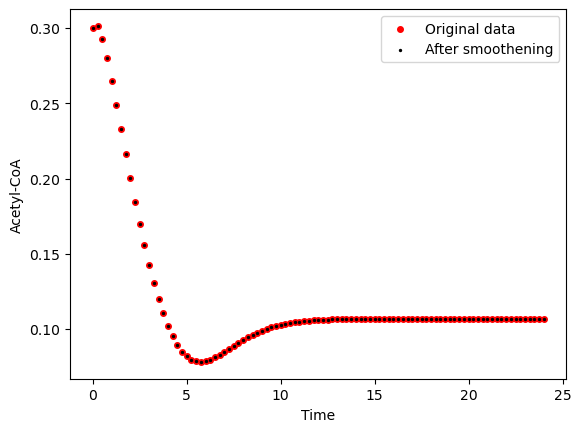

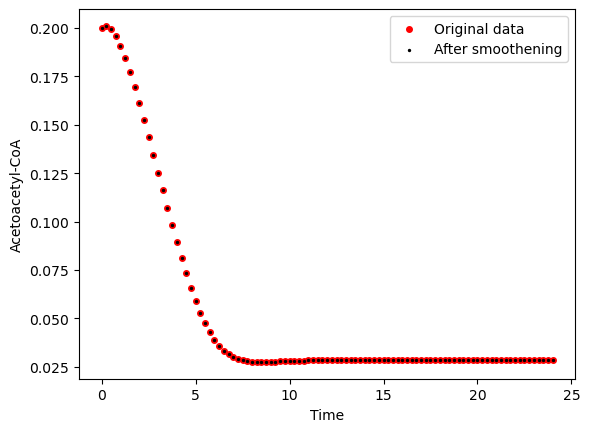

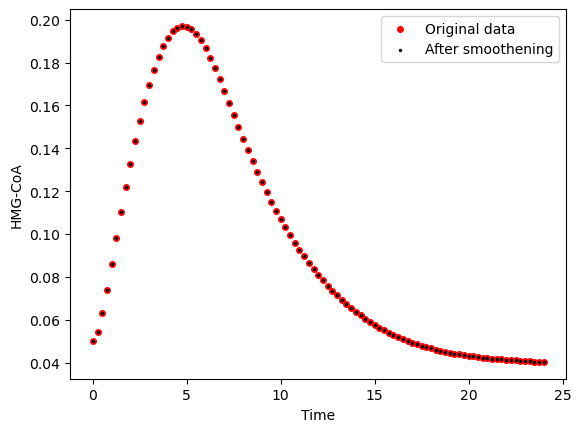

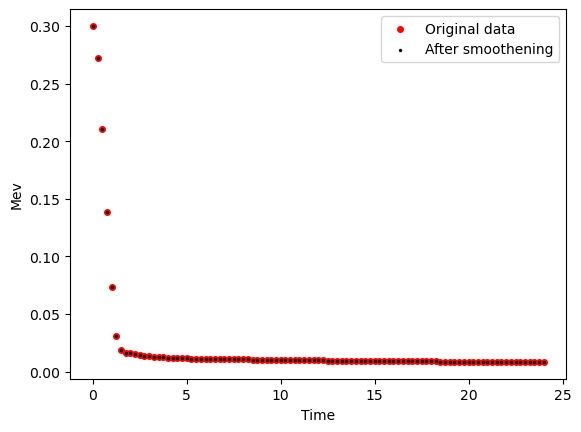

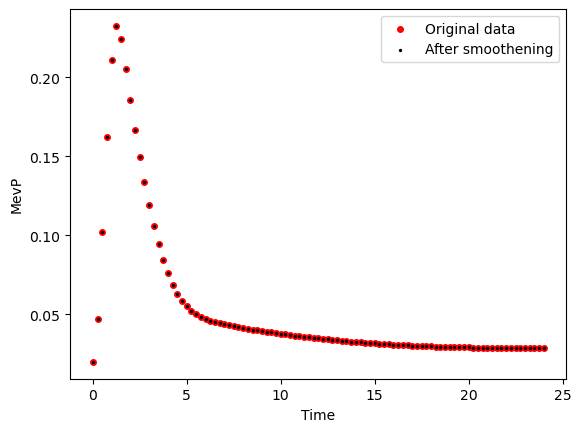

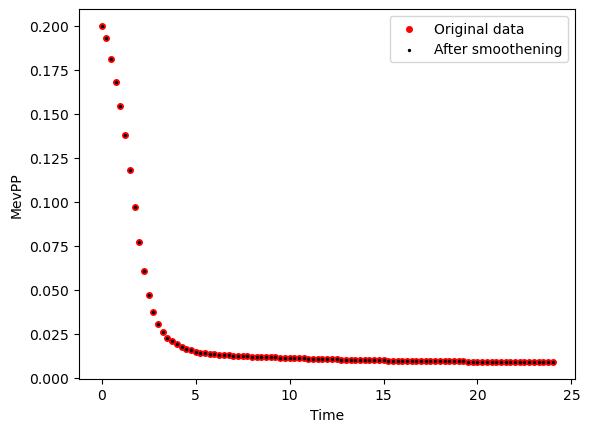

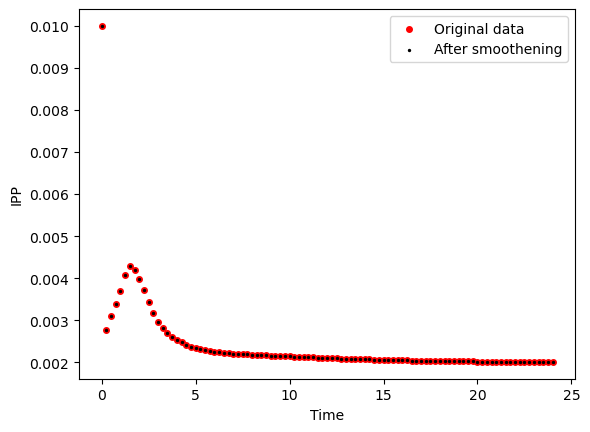

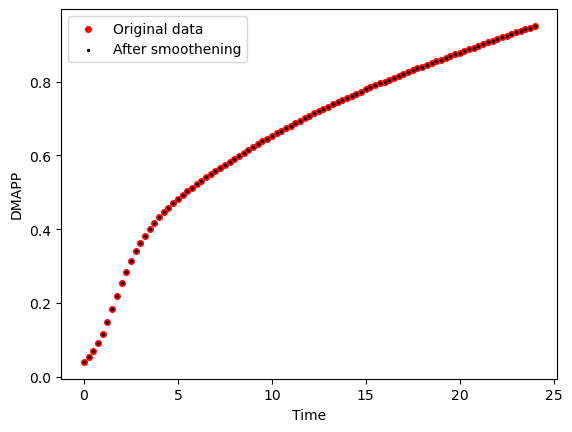

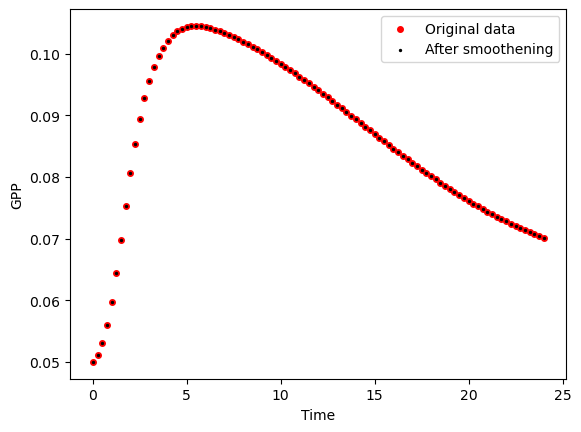

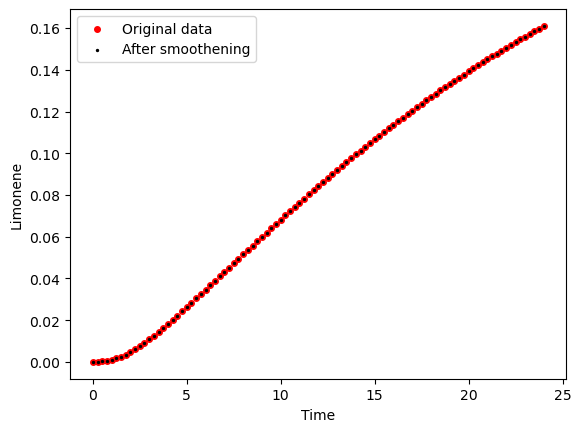

Strain Strain 2


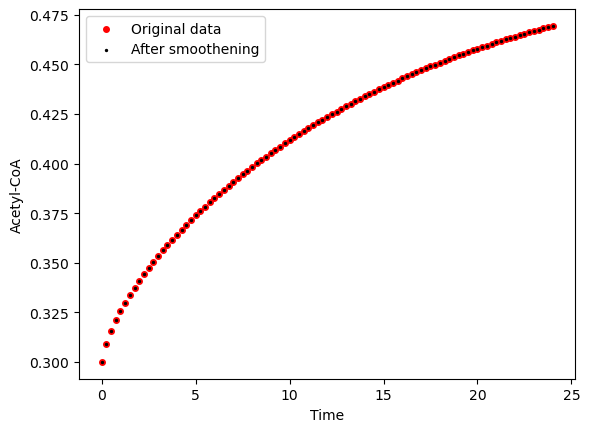

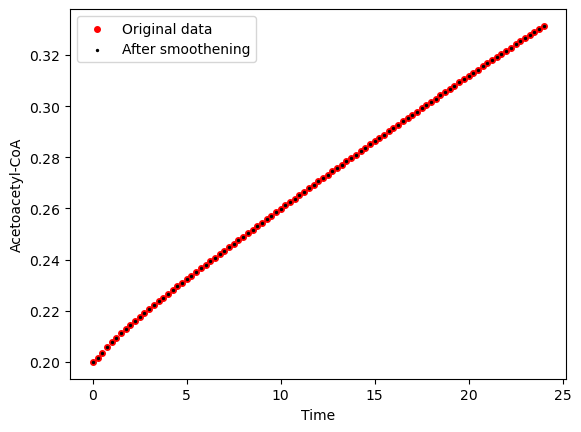

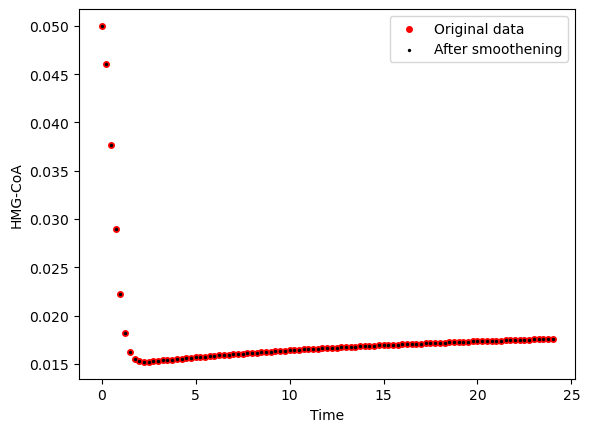

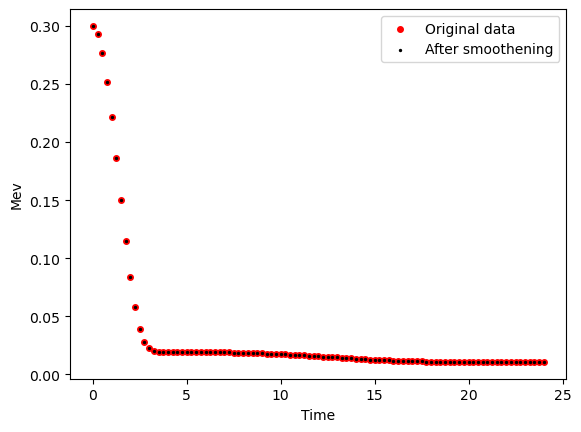

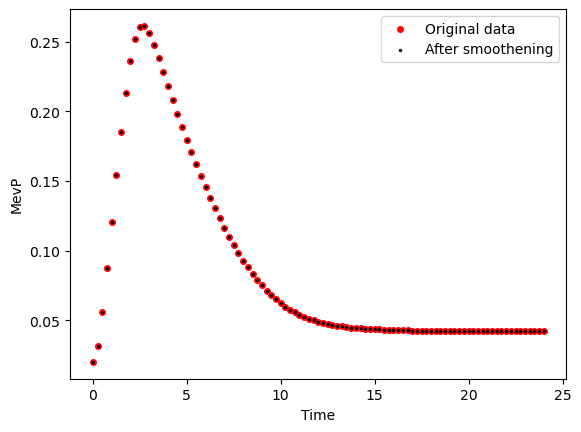

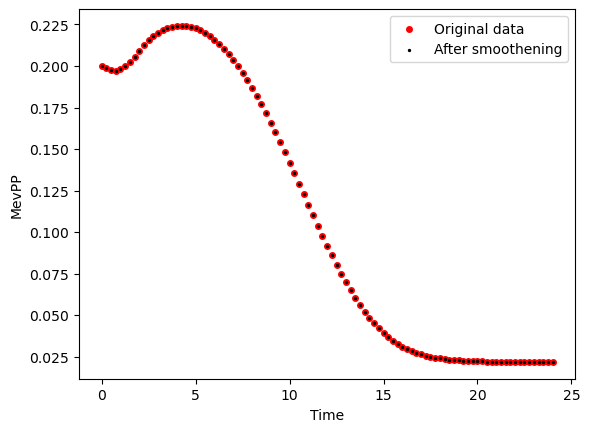

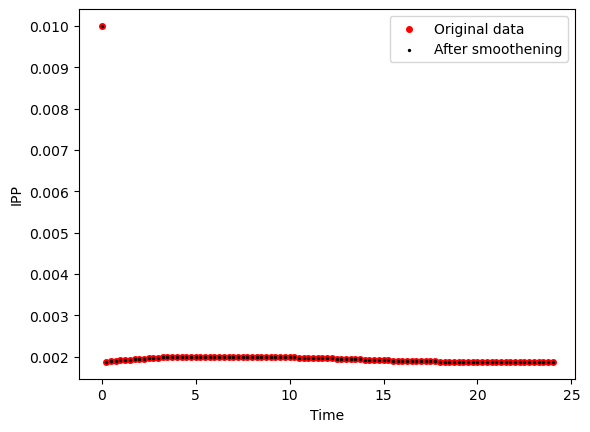

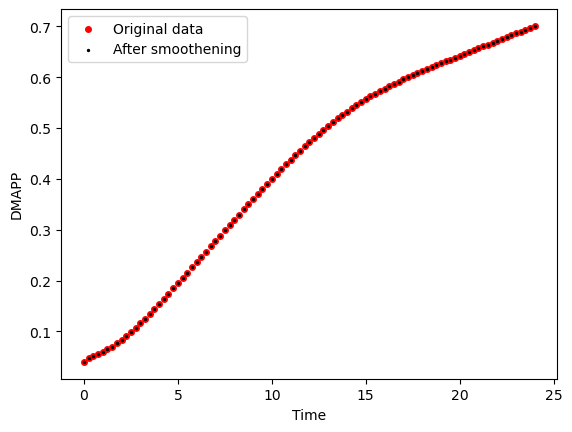

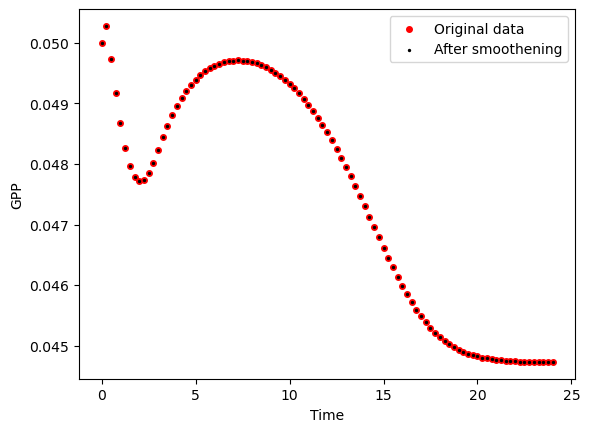

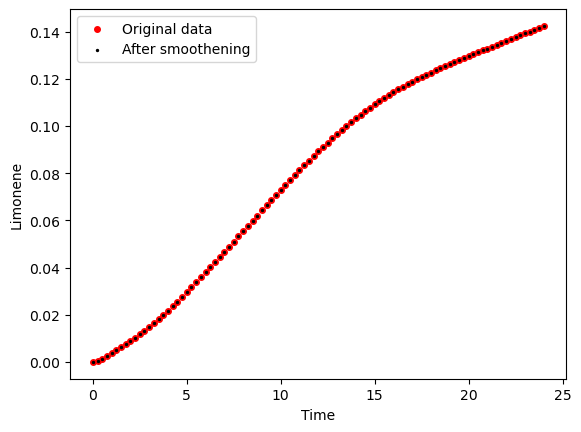

Strain Strain 3


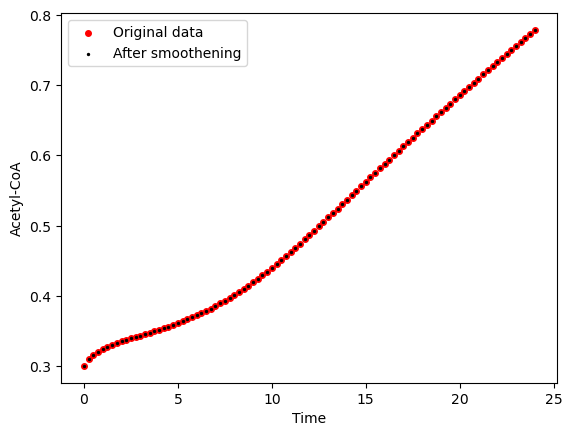

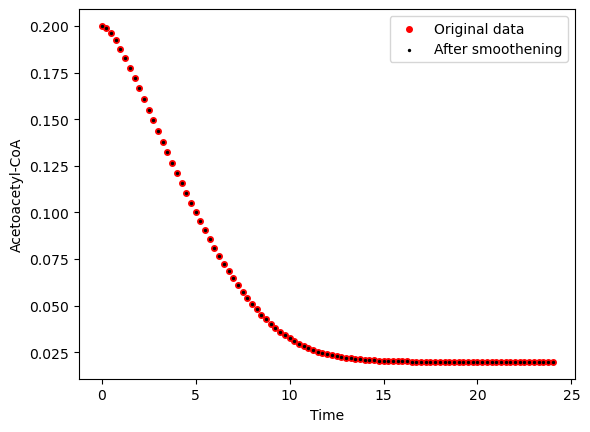

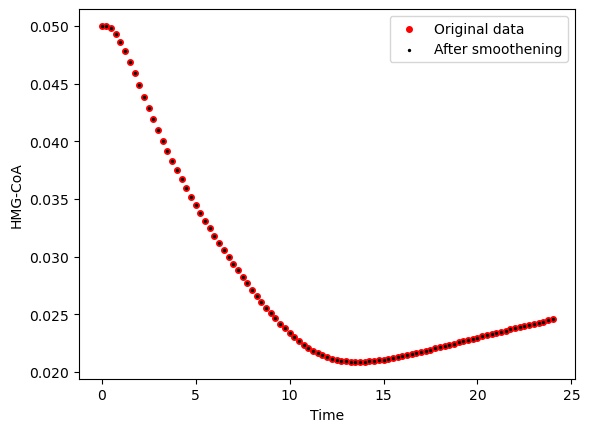

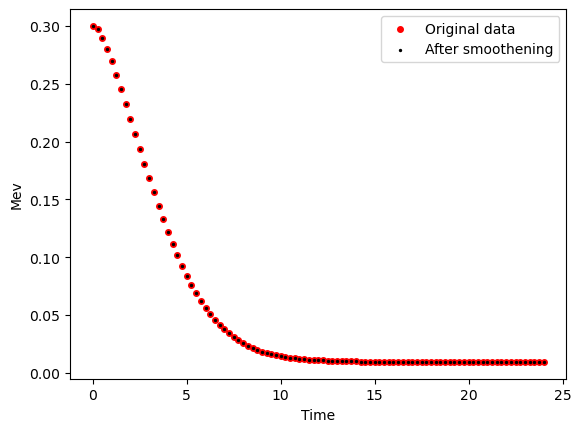

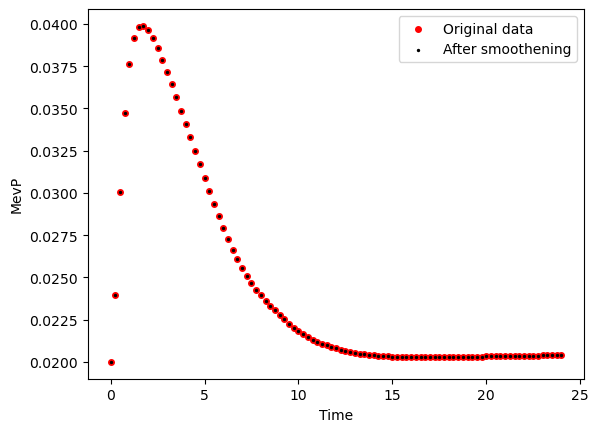

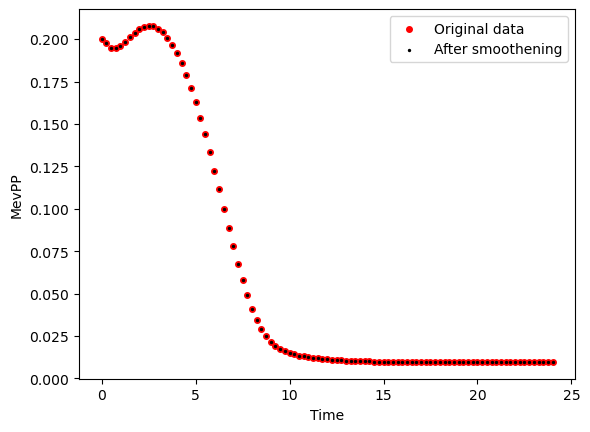

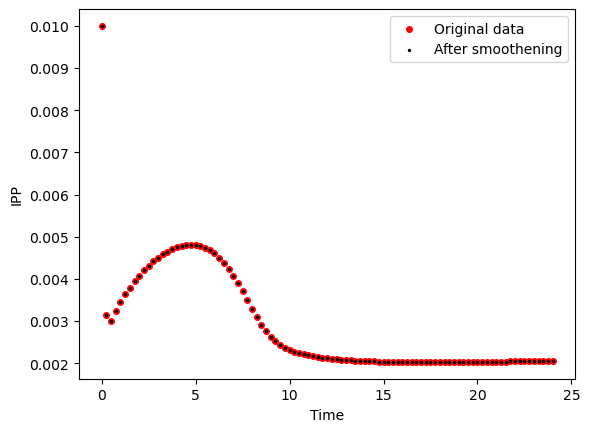

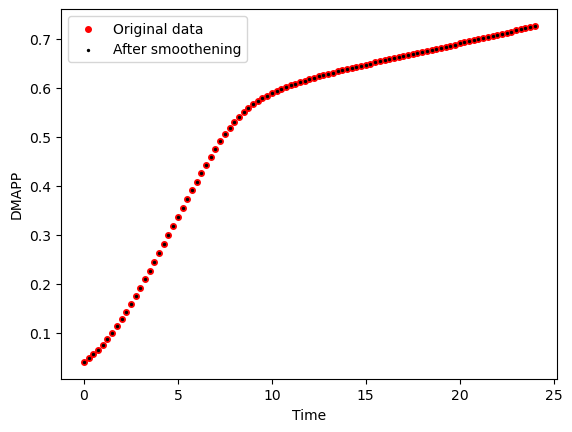

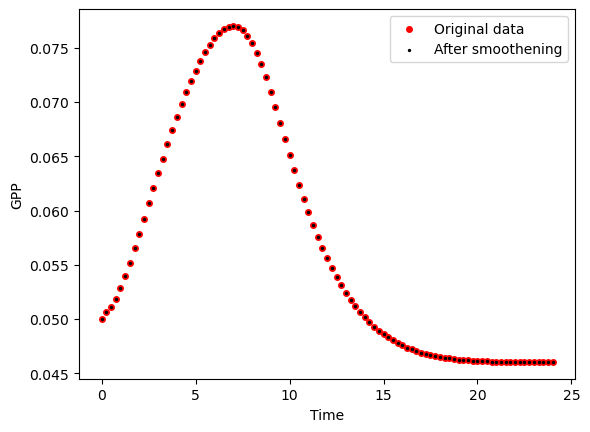

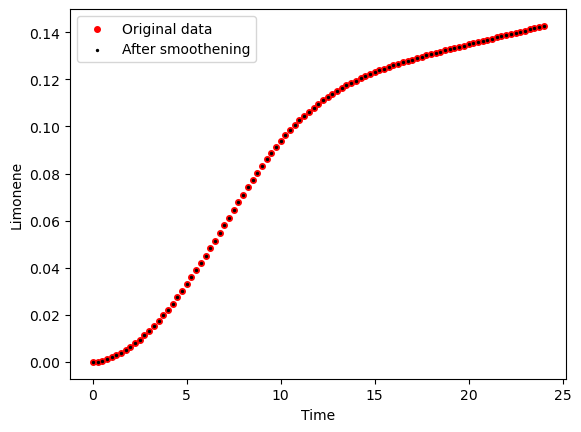

Strain WT


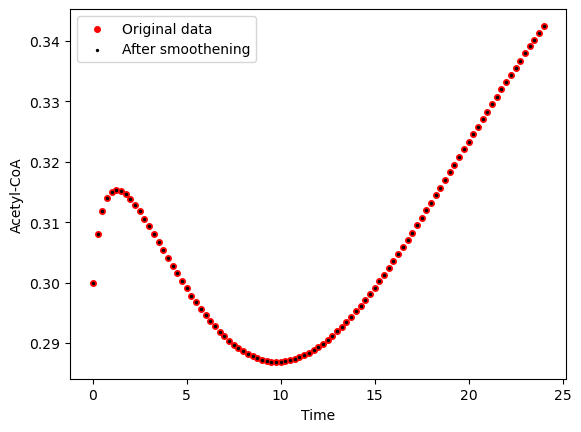

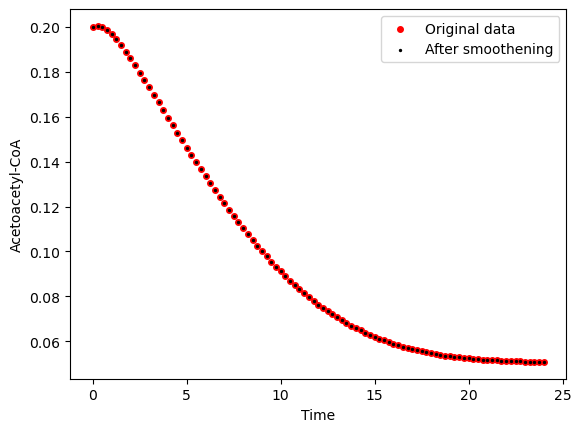

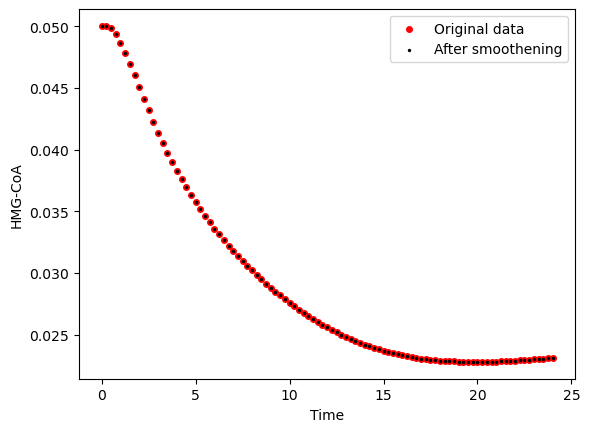

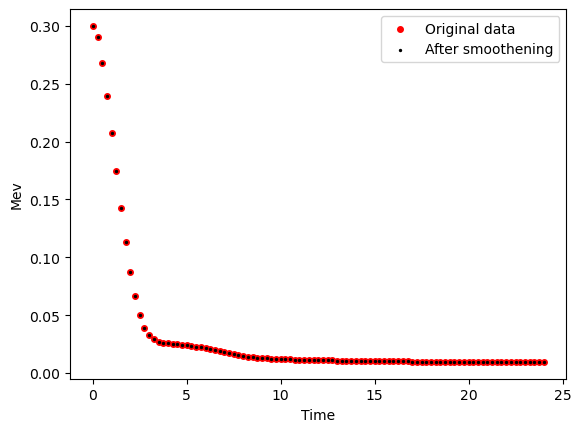

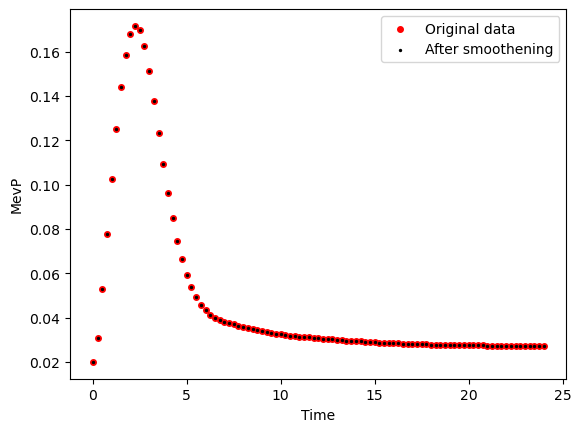

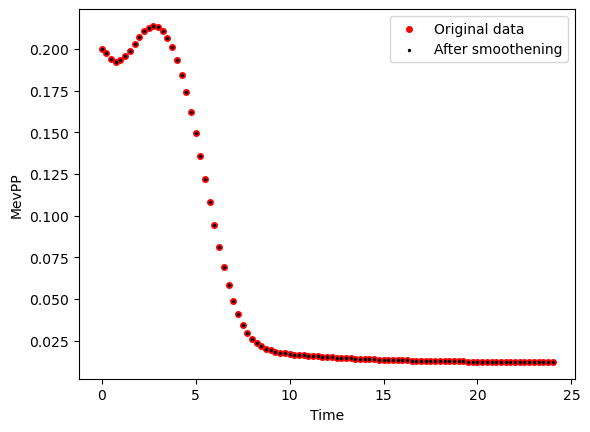

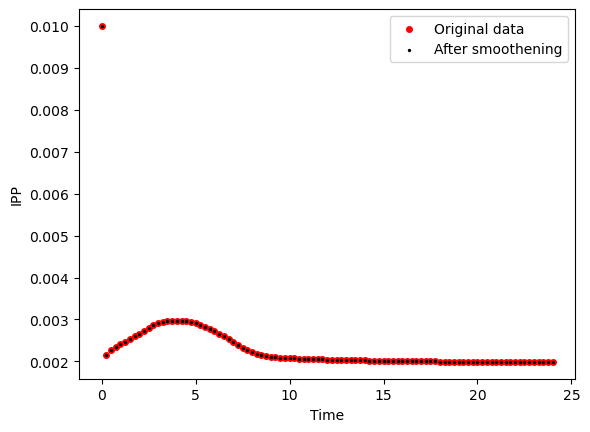

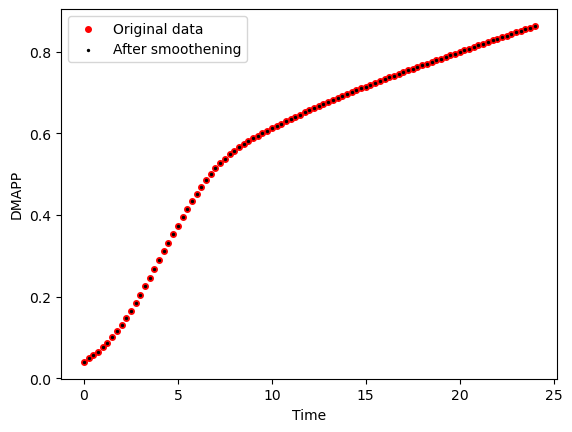

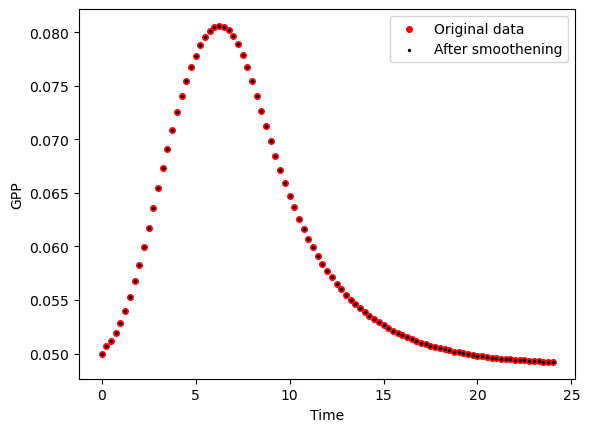

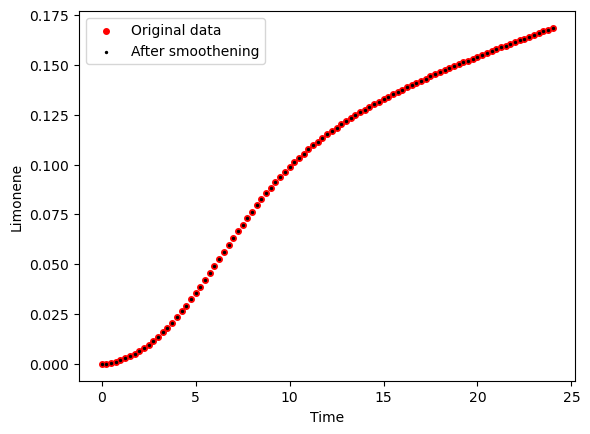

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


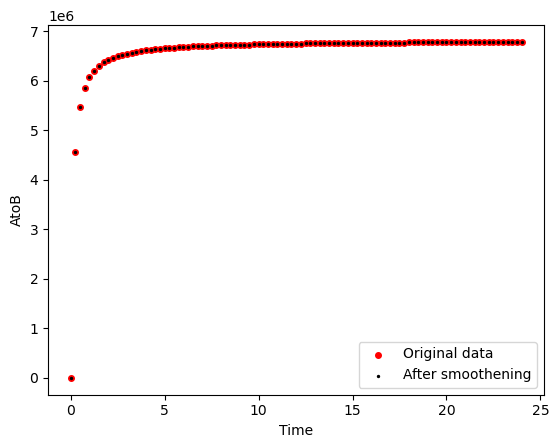

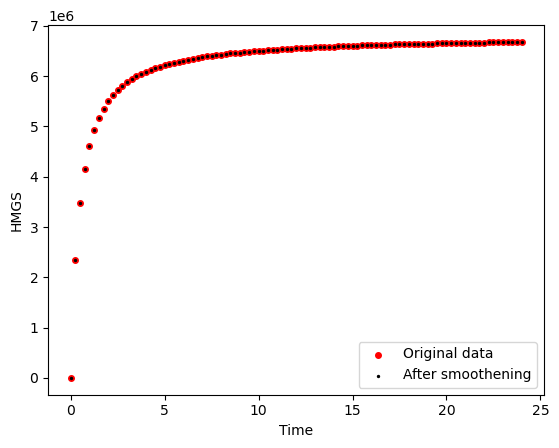

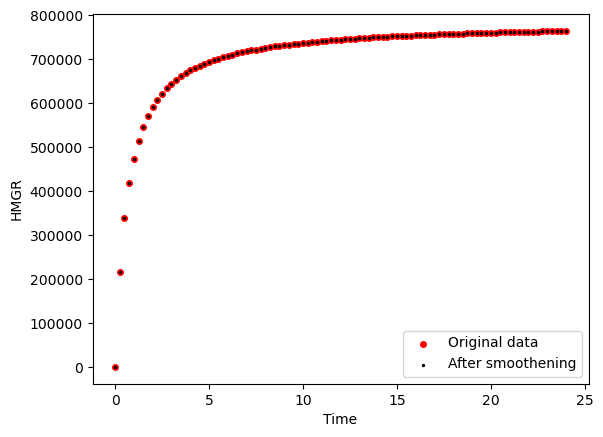

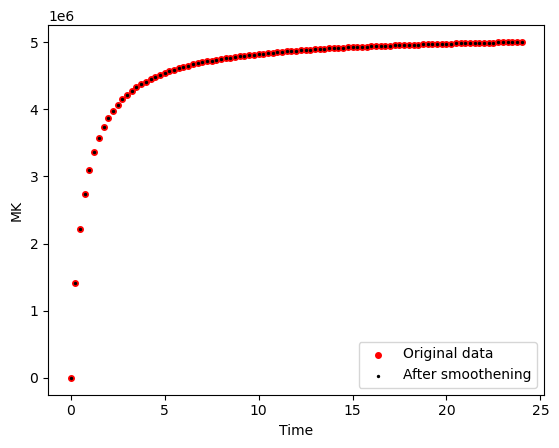

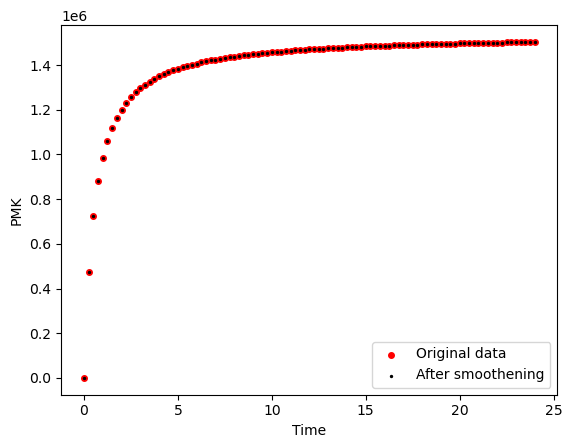

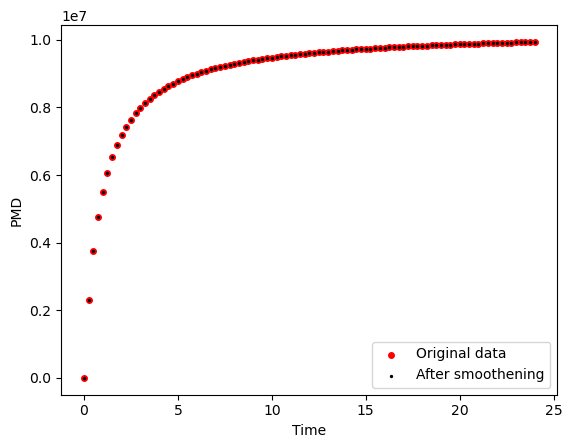

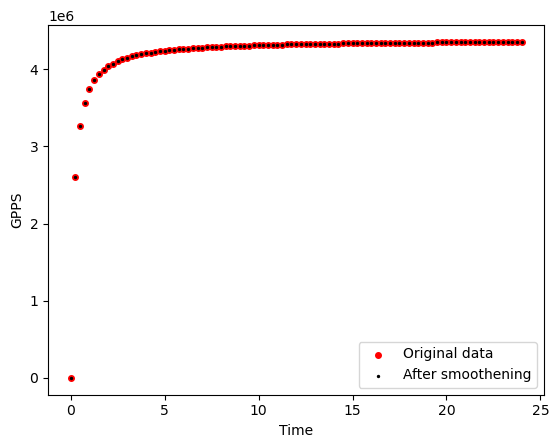

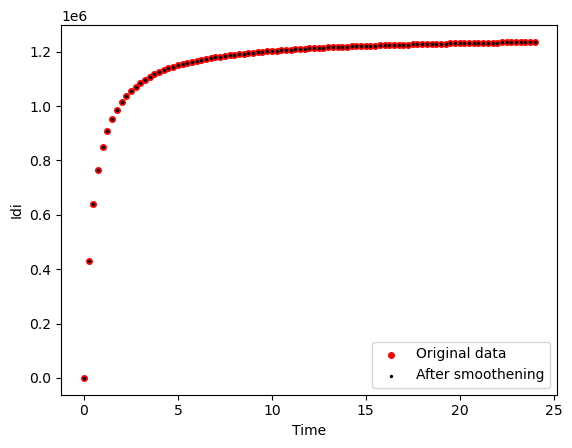

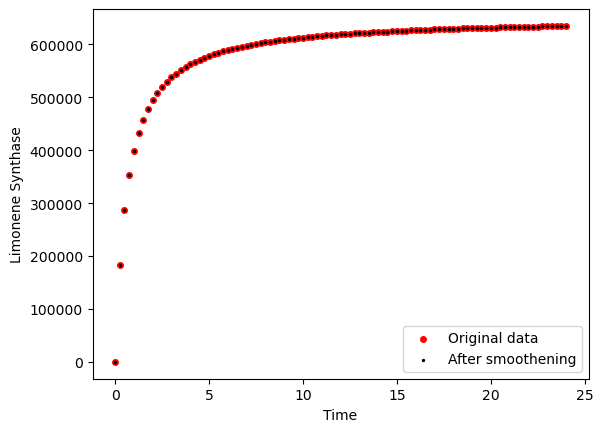

Strain Strain 2


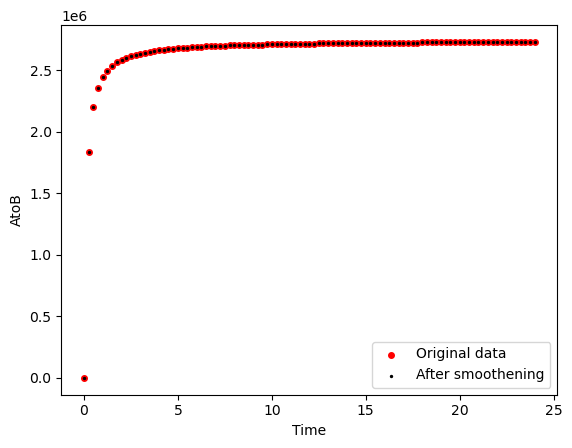

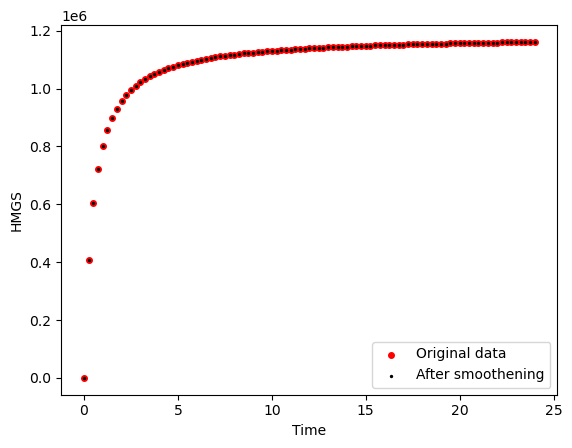

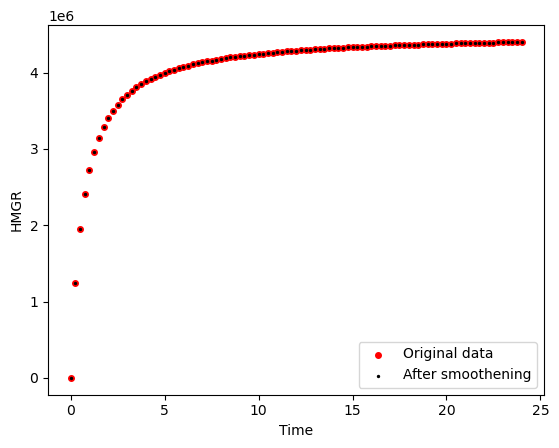

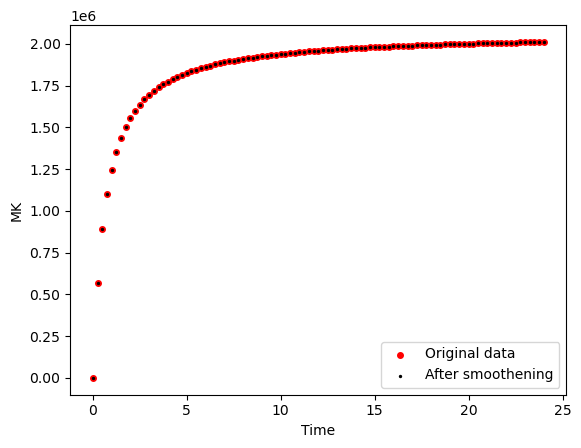

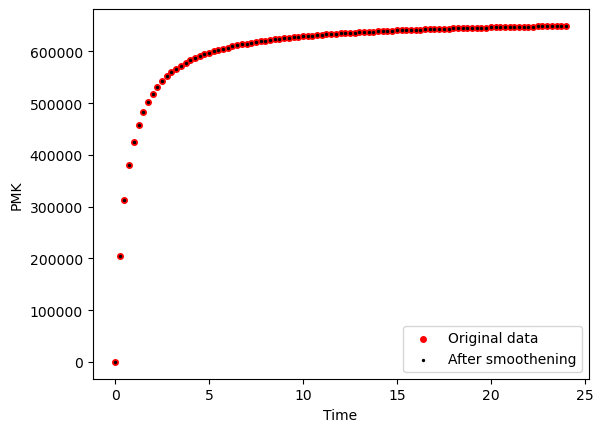

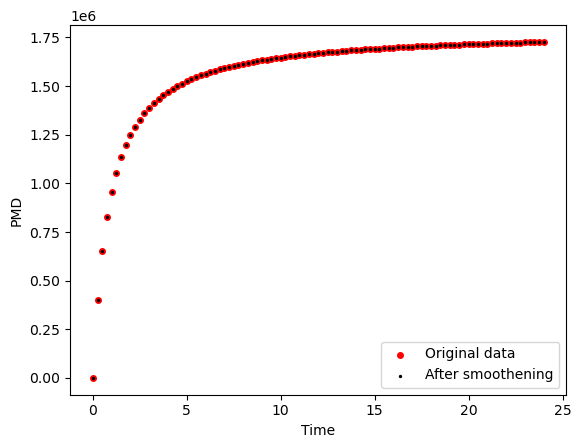

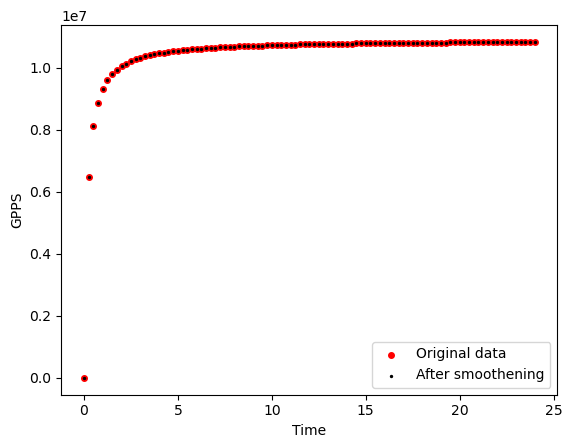

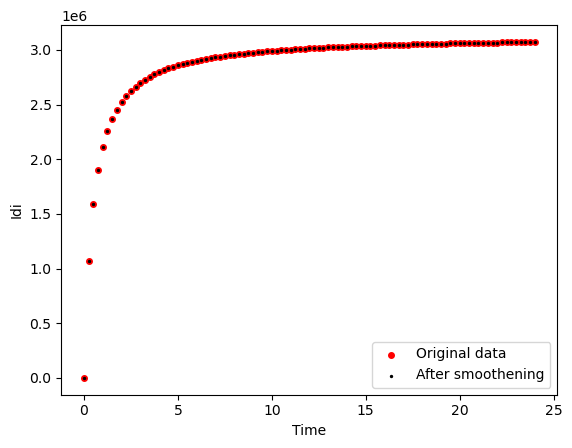

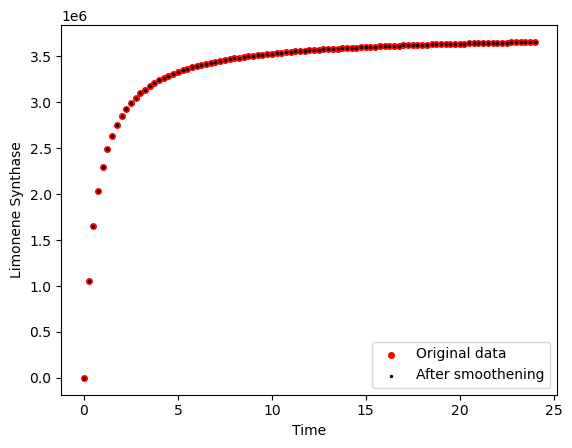

Strain Strain 3


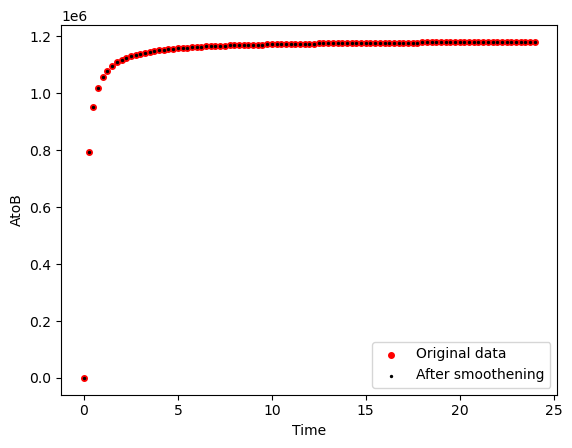

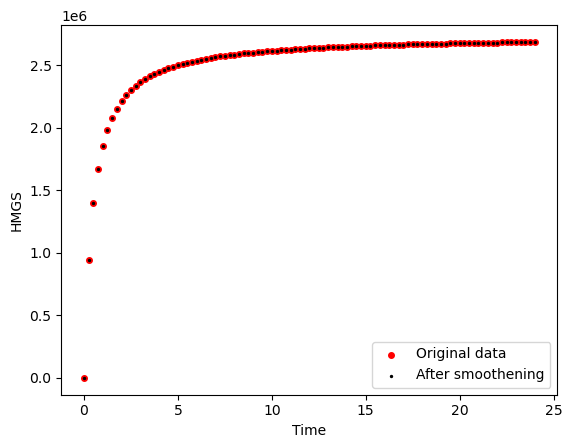

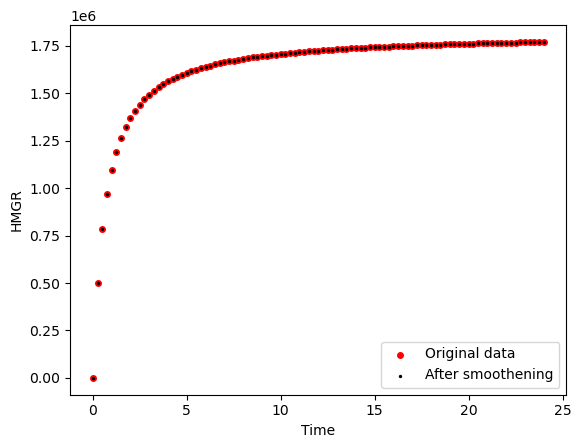

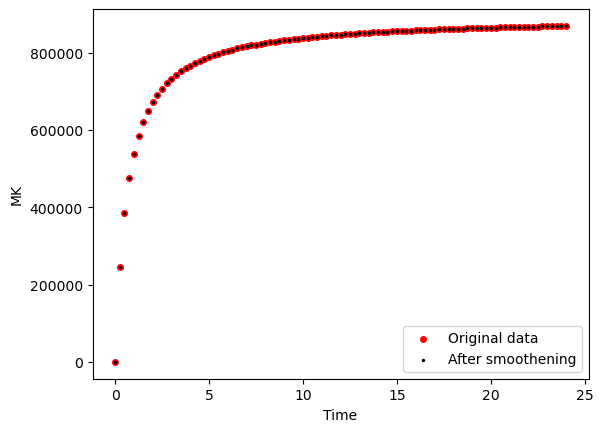

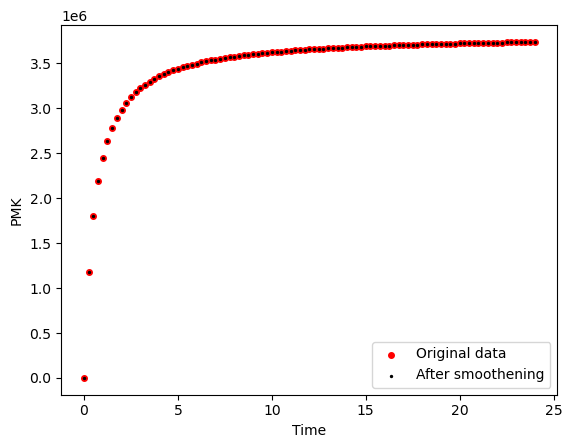

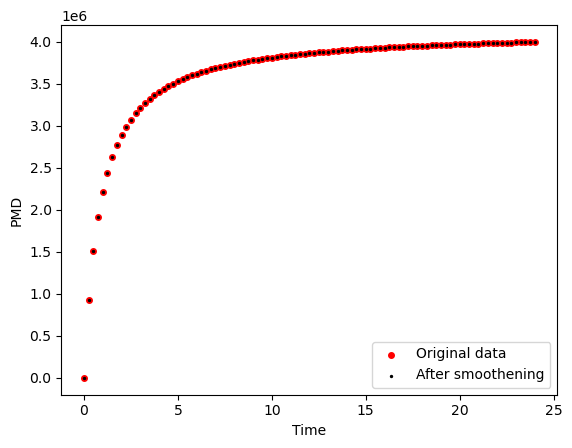

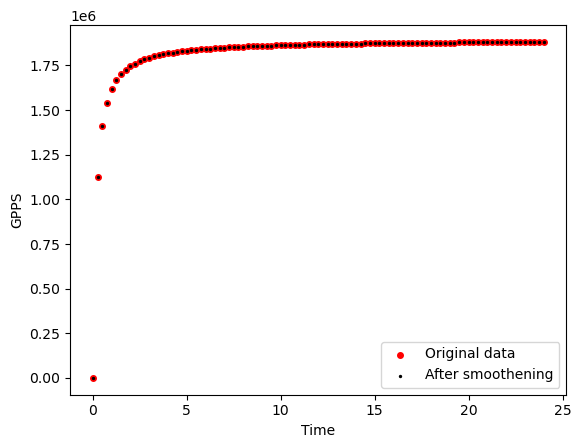

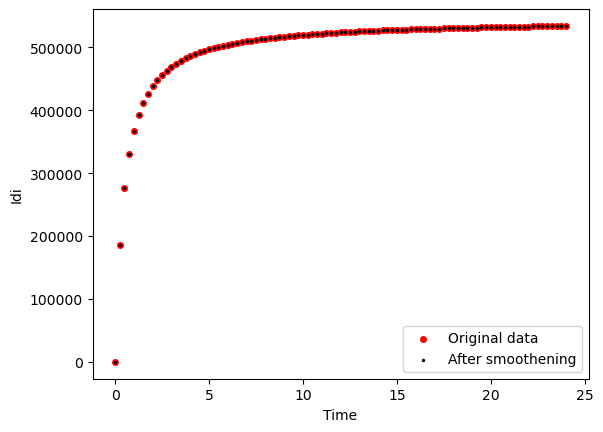

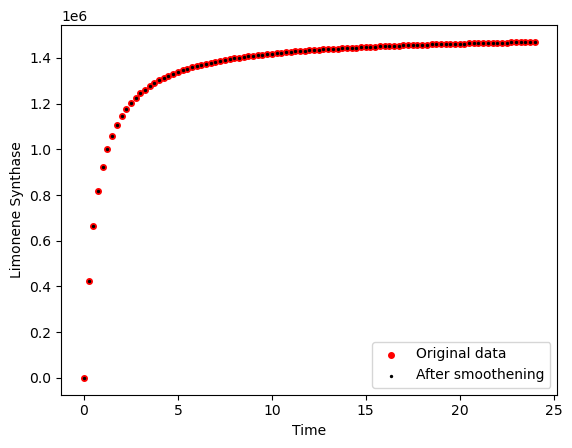

Strain WT


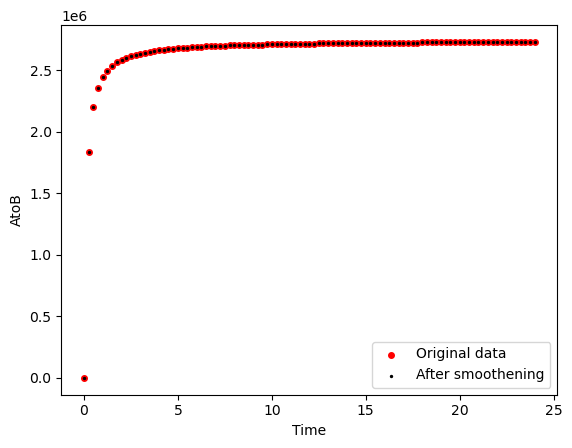

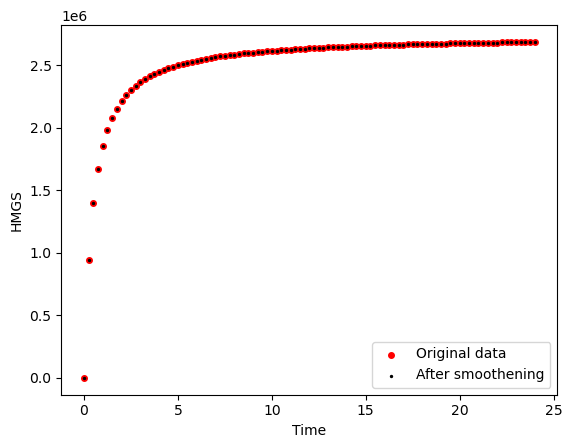

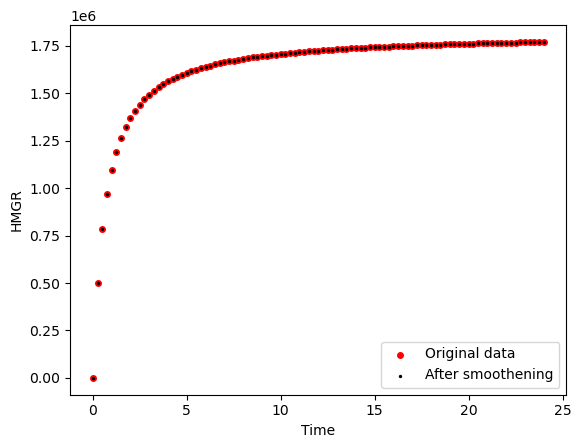

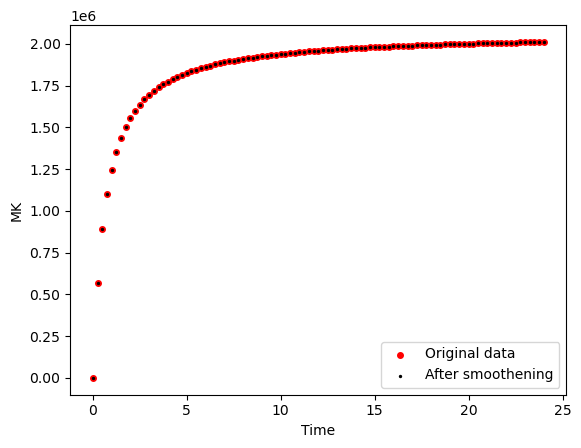

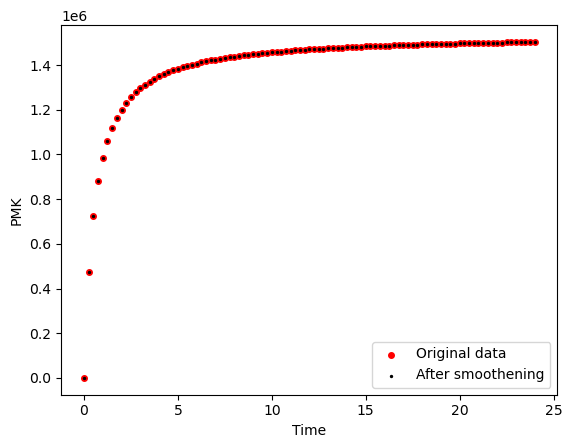

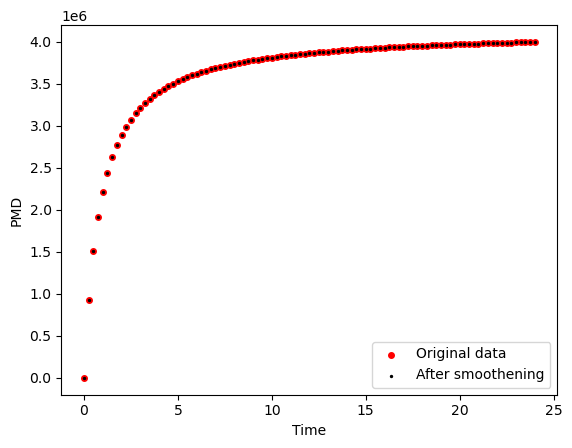

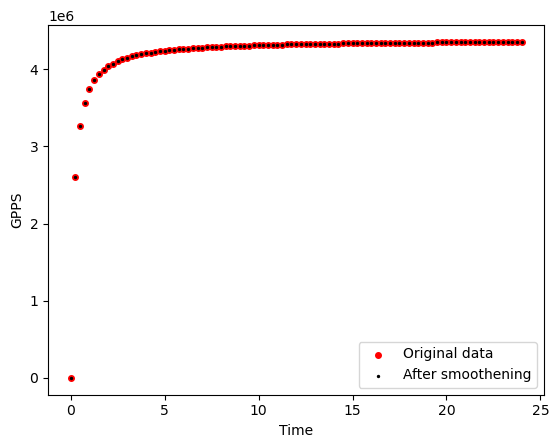

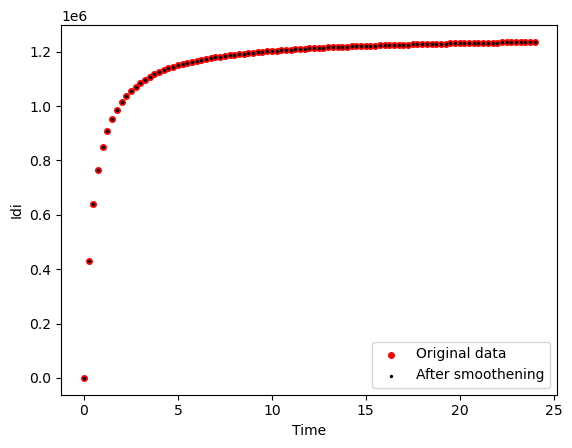

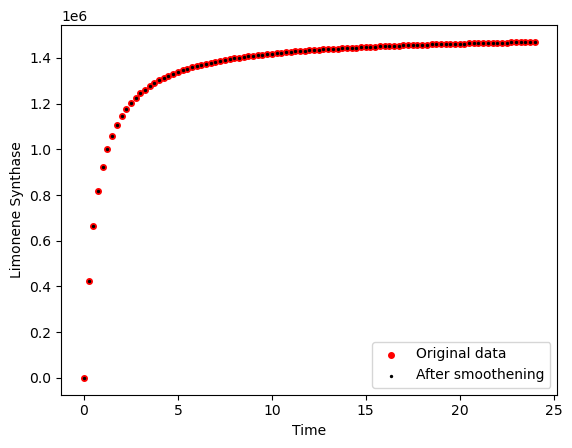

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

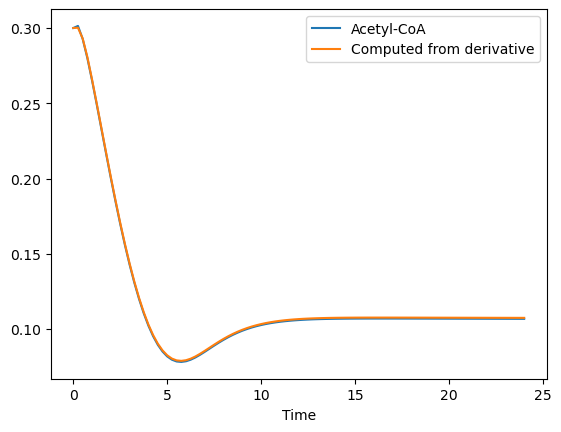

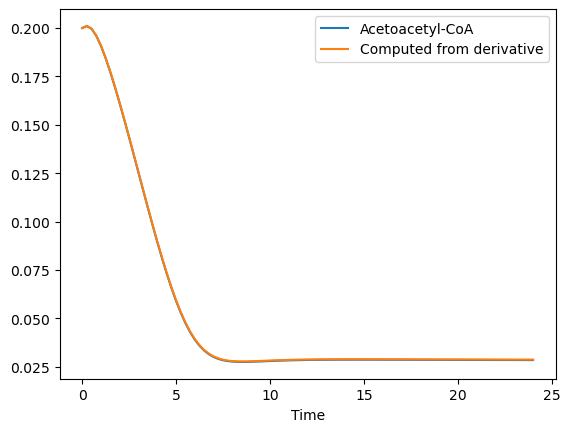

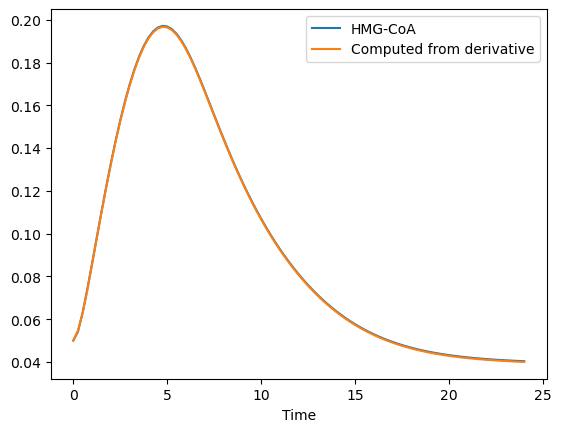

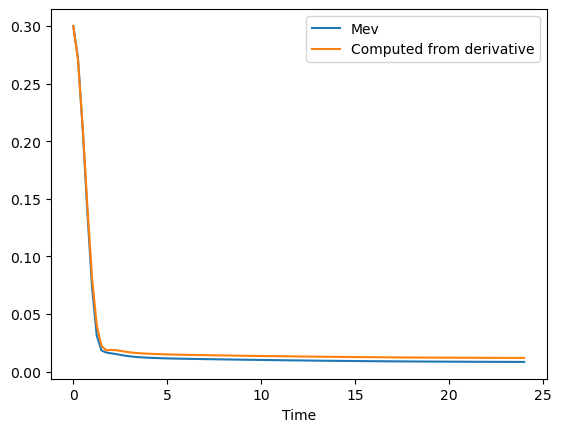

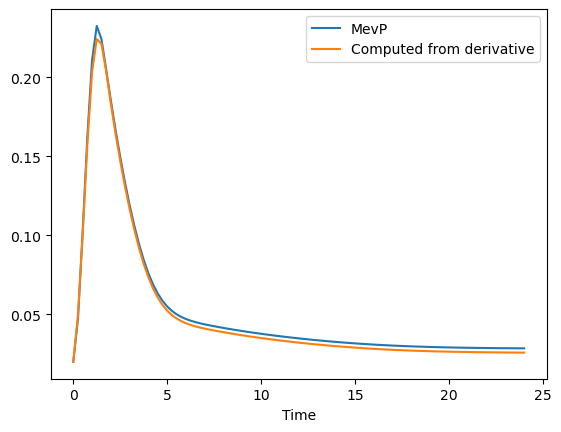

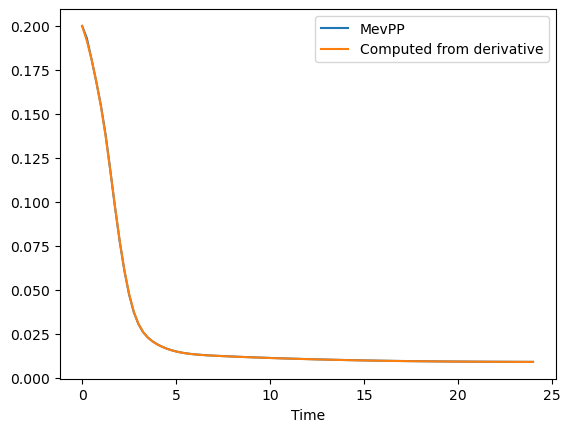

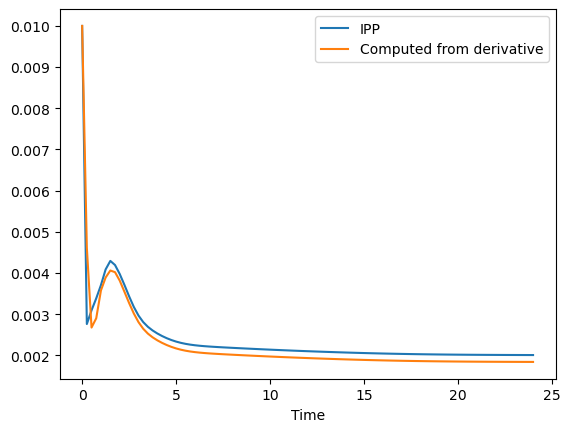

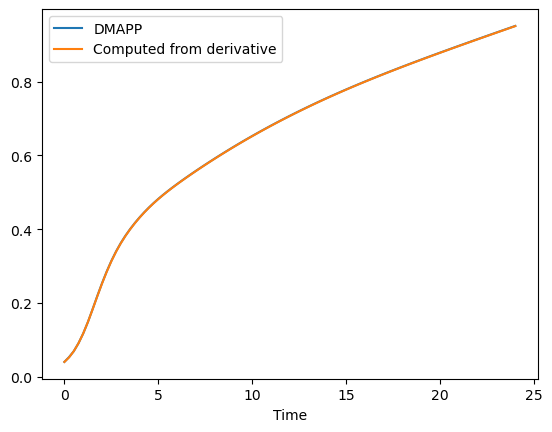

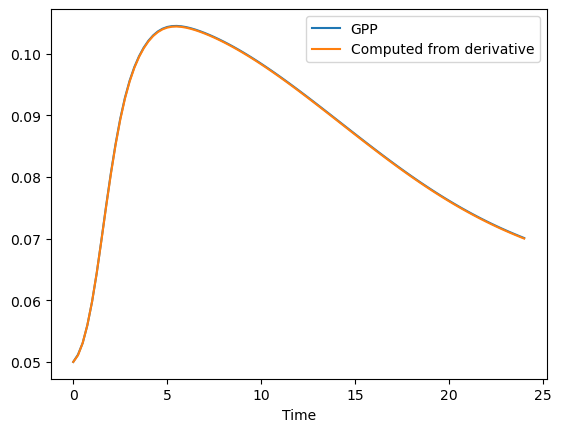

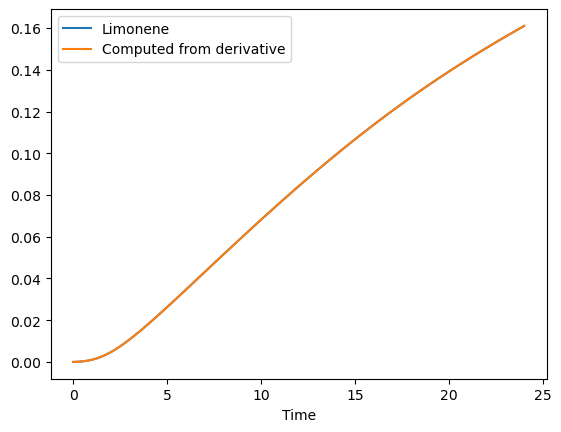

'Time profile from derivative vs. actual profile for Strain 2'

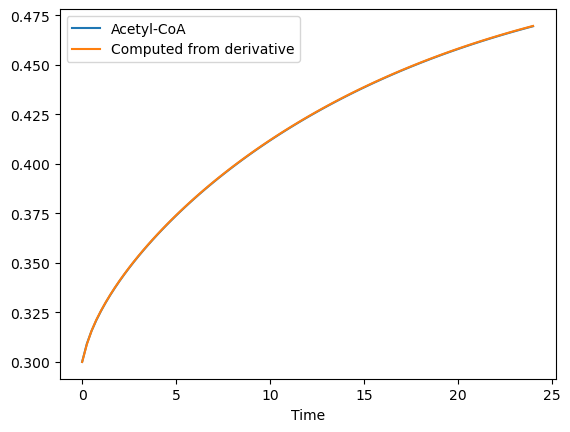

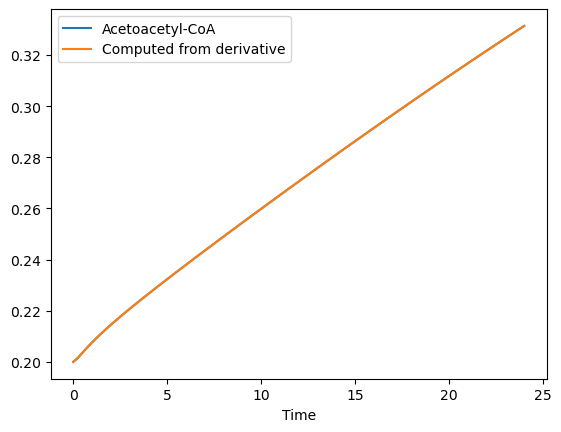

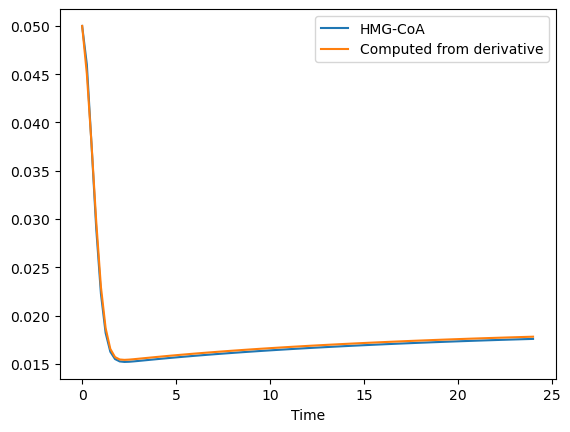

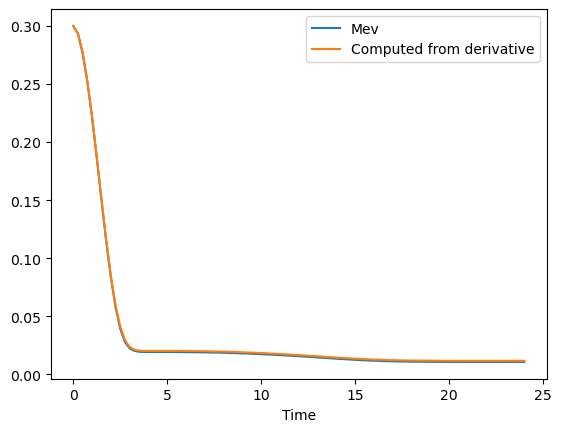

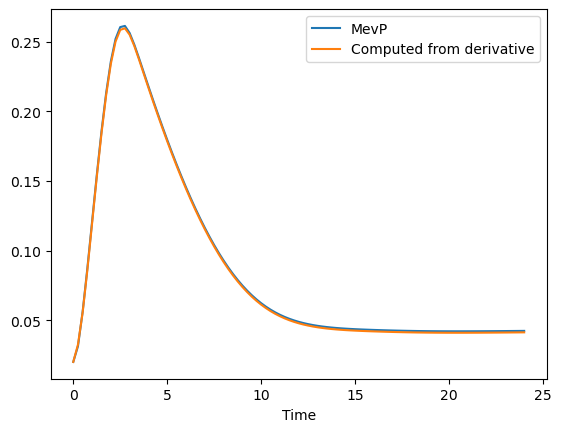

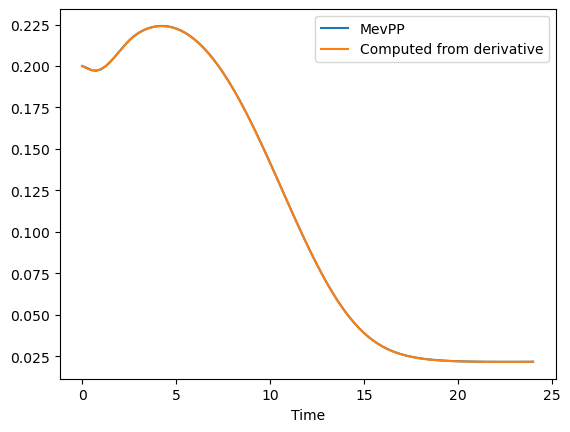

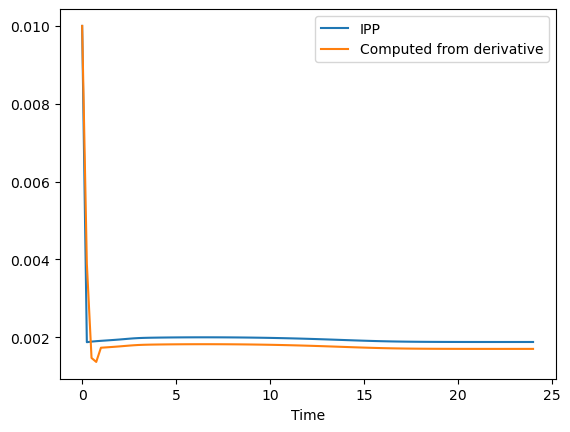

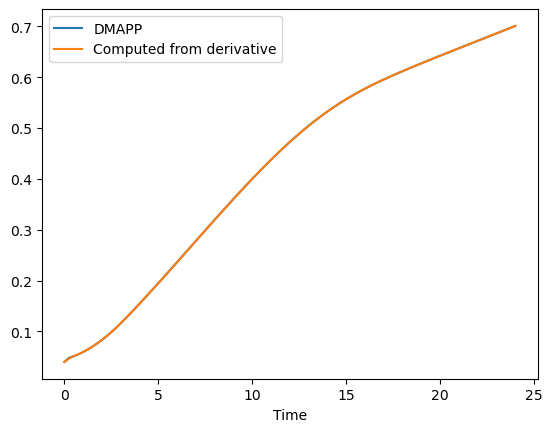

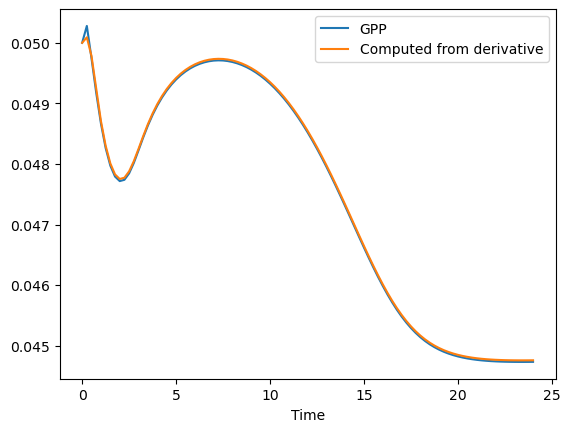

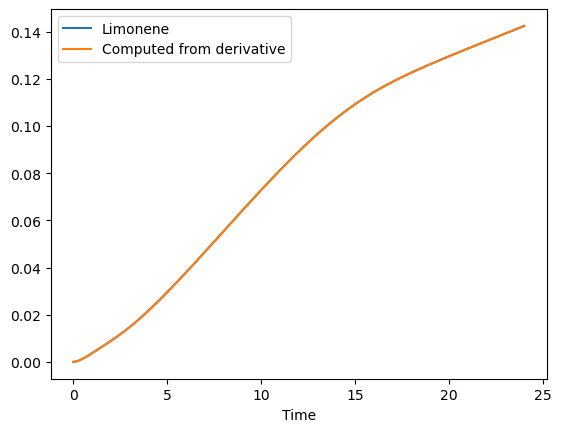

'Time profile from derivative vs. actual profile for Strain 3'

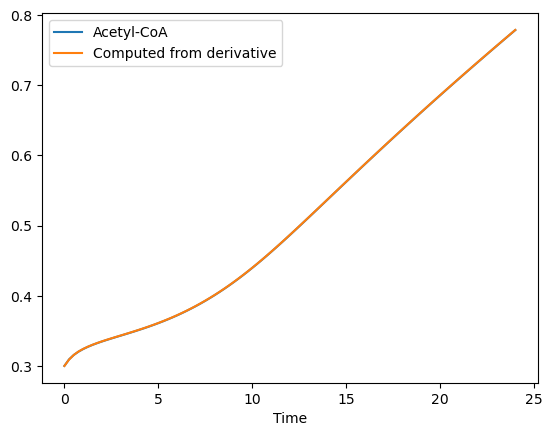

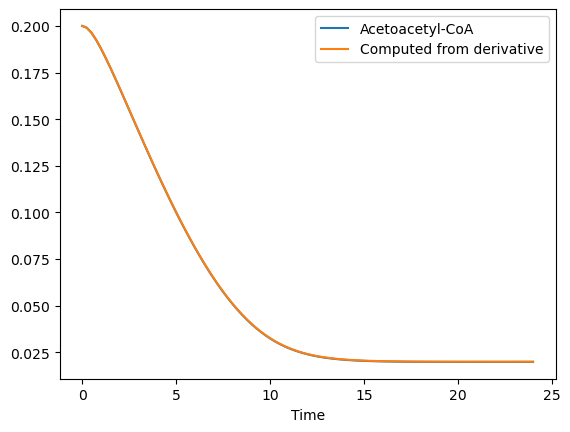

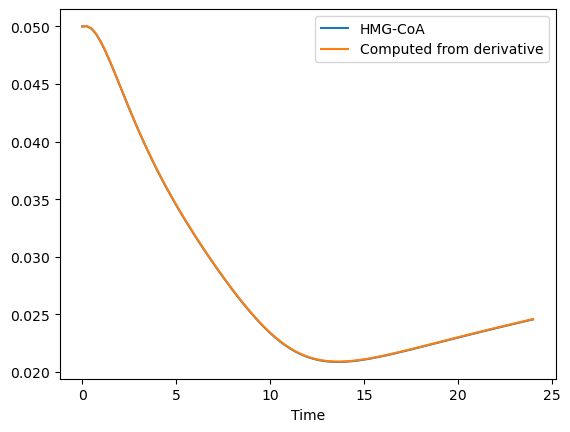

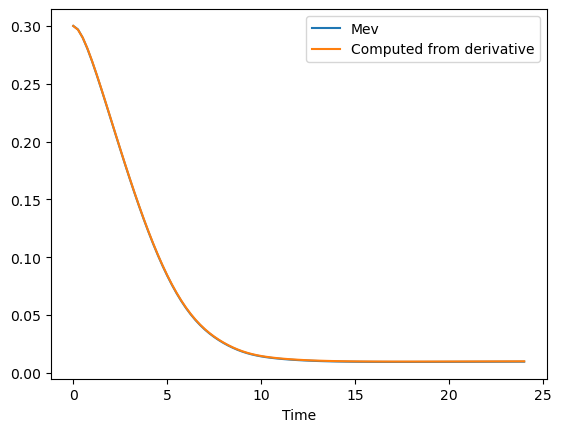

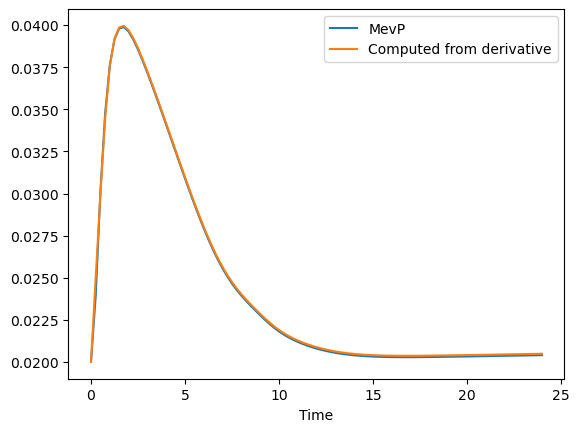

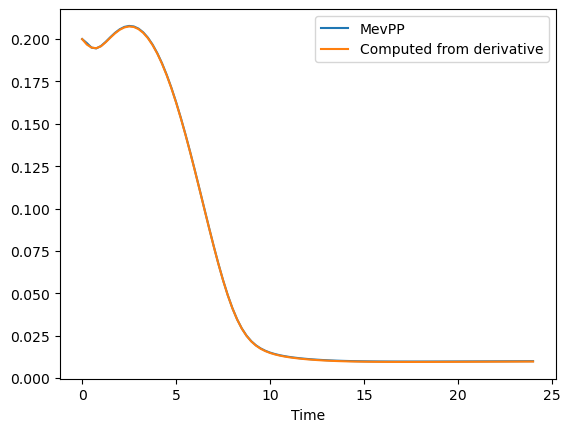

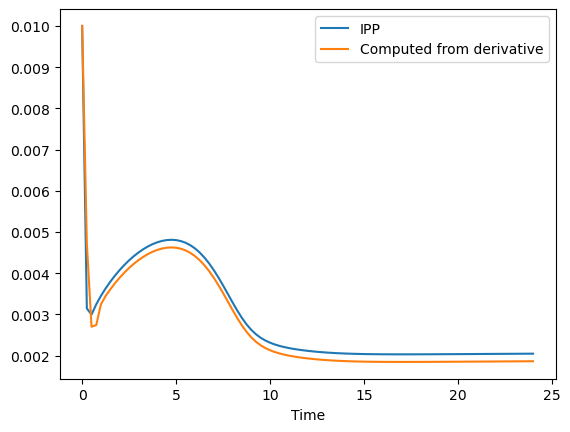

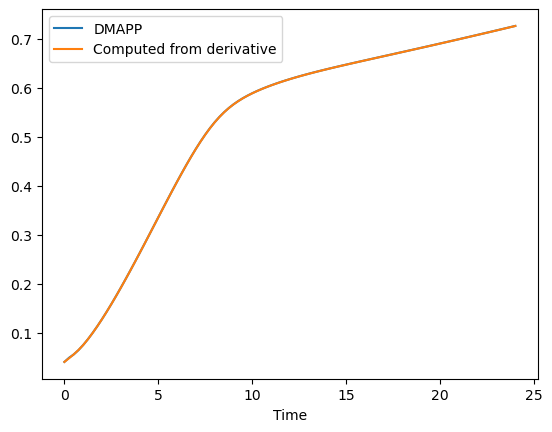

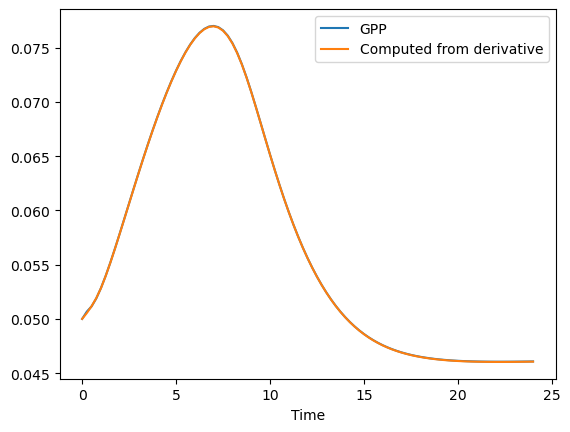

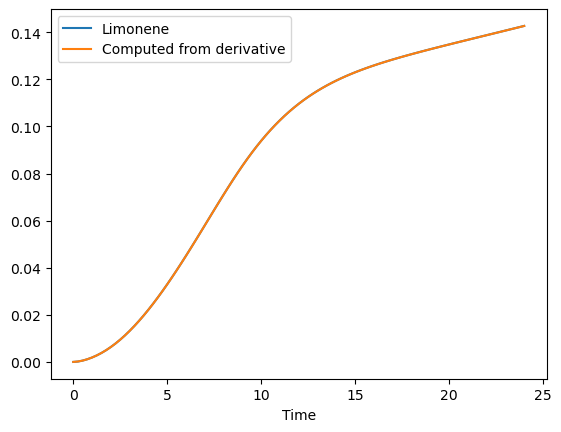

'Time profile from derivative vs. actual profile for WT'

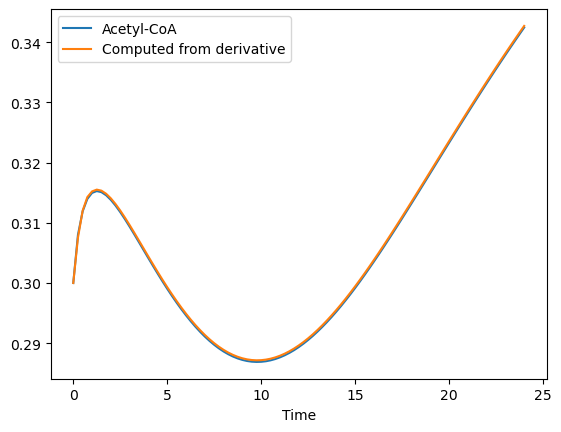

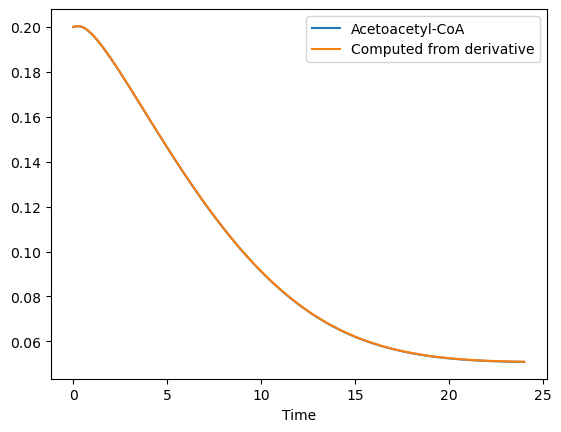

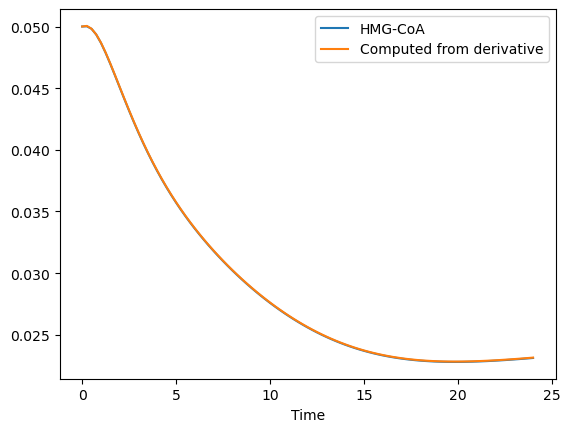

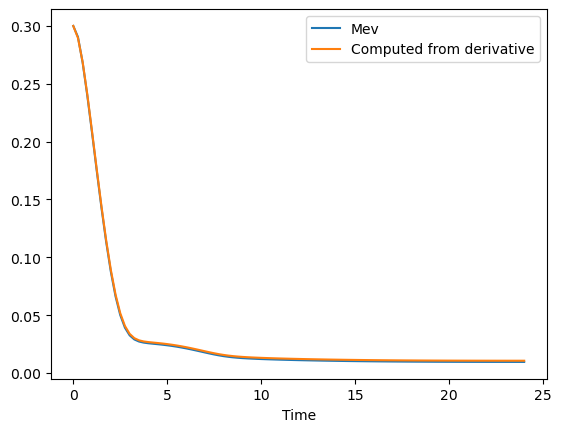

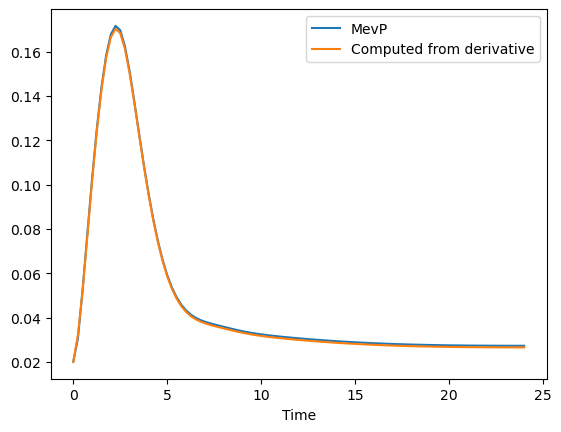

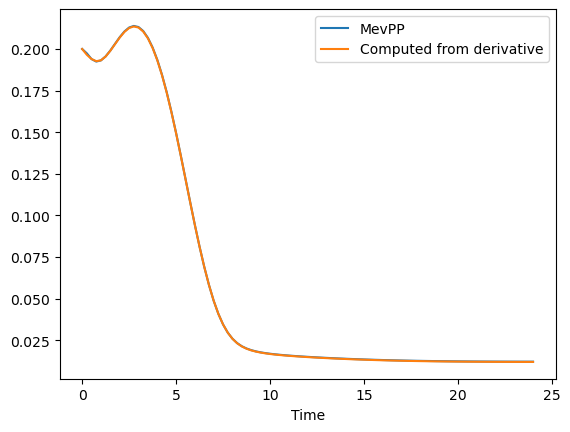

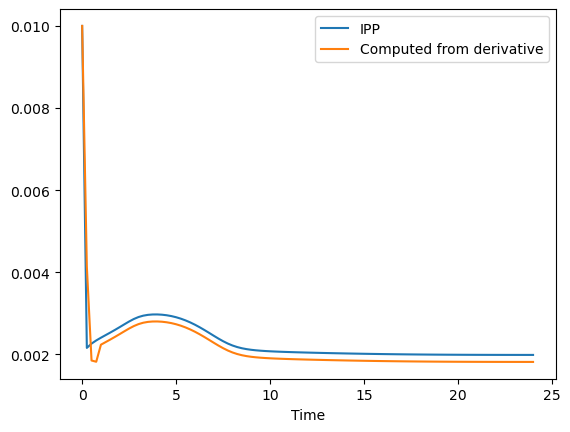

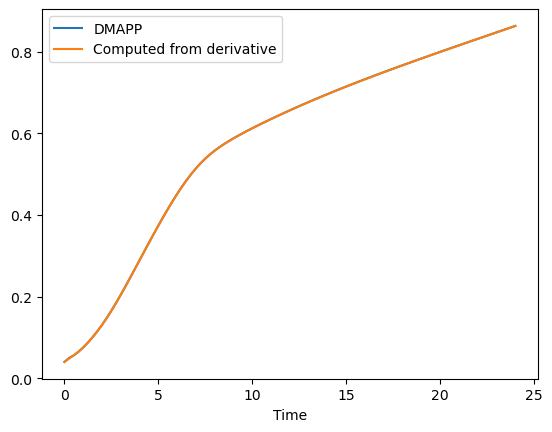

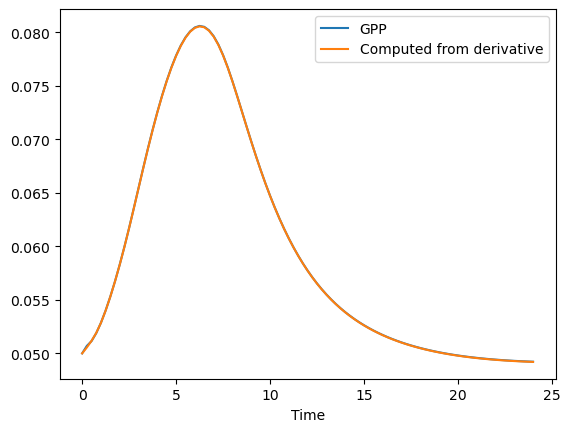

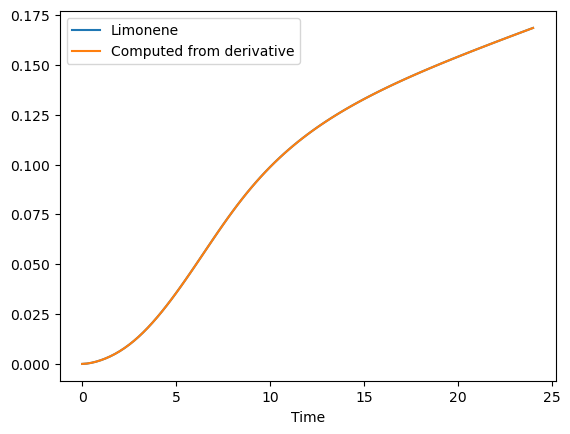

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  1.238322E+18 |  2.211621E+15
     2 |       74 |  1.247170E+15 |  1.127089E+13
     3 |      138 |  4.324554E+14 |  1.127089E+13
     4 |      202 |  1.021095E+14 |  1.346133E+12
     5 |      266 |  2.768085E+13 |  1.346133E+12
     6 |      330 |  7.727982E+12 |  6.808613E+09
     7 |      394 |  1.183909E+12 |  6.808613E+09
     8 |      458 |  3.931772E+11 |  6.808613E+09
     9 |      522 |  5.331539E+11 |  6.808613E+09
    10 |      586 |  1.049298E+11 |  6.808613E+09
    11 |      650 |  8.939644E+10 |  1.501411E+09
    12 |      714 |  1.868885E+10 |  3.564020E+07
    13 |      778 |  5.350353E+08 |  1.682163E+07
    14 |      842 |  2.471646E+08 |  9.048939E+06
    15 |      906 |  2.147908E+08 |  9.048939E+06
    16 |      970 |  1.674857E+08 |  6.431329E+06
    17 |     1034 |  6.980706E+07 |  4.512541E+04
    18 |     1098 |  1.874334E+07 |  4.512541E+04
    19 |     1162 |  1.13

   162 |    10314 |  4.604441E+01 |  4.500290E+01
   163 |    10378 |  4.596472E+01 |  4.500290E+01
   164 |    10442 |  4.534925E+01 |  4.250486E+01
   165 |    10506 |  4.543445E+01 |  4.250486E+01
   166 |    10570 |  4.498204E+01 |  4.250486E+01
   167 |    10634 |  4.465386E+01 |  4.250486E+01
   168 |    10698 |  4.483362E+01 |  4.250486E+01
   169 |    10762 |  4.516355E+01 |  4.228773E+01
   170 |    10826 |  4.459977E+01 |  3.868851E+01
   171 |    10890 |  4.685044E+01 |  3.868851E+01
   172 |    10954 |  4.621272E+01 |  3.868851E+01
   173 |    11018 |  4.604729E+01 |  3.868851E+01
   174 |    11082 |  4.604156E+01 |  3.868851E+01
   175 |    11146 |  4.596520E+01 |  3.868851E+01
   176 |    11210 |  4.582608E+01 |  3.868851E+01
   177 |    11274 |  4.548194E+01 |  3.868851E+01
   178 |    11338 |  4.527877E+01 |  3.868851E+01
   179 |    11402 |  4.497700E+01 |  3.868851E+01
   180 |    11466 |  4.497670E+01 |  3.868851E+01
   181 |    11530 |  4.489828E+01 |  3.868851E+01


   326 |    20810 |  3.034853E+01 |  3.028473E+01
   327 |    20874 |  3.028509E+01 |  3.023239E+01
   328 |    20938 |  3.022566E+01 |  3.016412E+01
   329 |    21002 |  3.017836E+01 |  3.014498E+01
   330 |    21066 |  3.015110E+01 |  3.012628E+01
   331 |    21130 |  3.011309E+01 |  3.007682E+01
   332 |    21194 |  3.008772E+01 |  3.005251E+01
   333 |    21258 |  3.006697E+01 |  3.003491E+01
   334 |    21322 |  3.006021E+01 |  3.002972E+01
   335 |    21386 |  3.005880E+01 |  2.998827E+01
   336 |    21450 |  3.005178E+01 |  2.998119E+01
   337 |    21514 |  3.002441E+01 |  2.992270E+01
   338 |    21578 |  2.996358E+01 |  2.984159E+01
   339 |    21642 |  2.992880E+01 |  2.980236E+01
   340 |    21706 |  2.990325E+01 |  2.980236E+01
   341 |    21770 |  2.987867E+01 |  2.978699E+01
   342 |    21834 |  2.979309E+01 |  2.963926E+01
   343 |    21898 |  2.977111E+01 |  2.963926E+01
   344 |    21962 |  2.976079E+01 |  2.963435E+01
   345 |    22026 |  2.978297E+01 |  2.962894E+01


   490 |    31306 |  2.821845E+01 |  2.820220E+01
   491 |    31370 |  2.821540E+01 |  2.819598E+01
   492 |    31434 |  2.821136E+01 |  2.819598E+01
   493 |    31498 |  2.820080E+01 |  2.818227E+01
   494 |    31562 |  2.819246E+01 |  2.818227E+01
   495 |    31626 |  2.818936E+01 |  2.818003E+01
   496 |    31690 |  2.818314E+01 |  2.816129E+01
   497 |    31754 |  2.818419E+01 |  2.816129E+01
   498 |    31818 |  2.818404E+01 |  2.816129E+01
   499 |    31882 |  2.817869E+01 |  2.815374E+01
   500 |    31946 |  2.816929E+01 |  2.815374E+01
   501 |    32010 |  2.816426E+01 |  2.814683E+01
   502 |    32074 |  2.815952E+01 |  2.814267E+01
   503 |    32138 |  2.816198E+01 |  2.814267E+01
   504 |    32202 |  2.815376E+01 |  2.814267E+01
   505 |    32266 |  2.815629E+01 |  2.814267E+01
   506 |    32330 |  2.815984E+01 |  2.814267E+01
   507 |    32394 |  2.816059E+01 |  2.814267E+01
   508 |    32458 |  2.815971E+01 |  2.814267E+01
   509 |    32522 |  2.815757E+01 |  2.814267E+01


   654 |    41802 |  2.762955E+01 |  2.761779E+01
   655 |    41866 |  2.762042E+01 |  2.761381E+01
   656 |    41930 |  2.762351E+01 |  2.760898E+01
   657 |    41994 |  2.761582E+01 |  2.760396E+01
   658 |    42058 |  2.760565E+01 |  2.759651E+01
   659 |    42122 |  2.760209E+01 |  2.758353E+01
   660 |    42186 |  2.760021E+01 |  2.758353E+01
   661 |    42250 |  2.759843E+01 |  2.758353E+01
   662 |    42314 |  2.758202E+01 |  2.757035E+01
   663 |    42378 |  2.757759E+01 |  2.755957E+01
   664 |    42442 |  2.757106E+01 |  2.754574E+01
   665 |    42506 |  2.756473E+01 |  2.754574E+01
   666 |    42570 |  2.754816E+01 |  2.753001E+01
   667 |    42634 |  2.754305E+01 |  2.753001E+01
   668 |    42698 |  2.753562E+01 |  2.752717E+01
   669 |    42762 |  2.752868E+01 |  2.750727E+01
   670 |    42826 |  2.751608E+01 |  2.750549E+01
   671 |    42890 |  2.750505E+01 |  2.749255E+01
   672 |    42954 |  2.750397E+01 |  2.749255E+01
   673 |    43018 |  2.749064E+01 |  2.746229E+01


   818 |    52298 |  2.565063E+01 |  2.564021E+01
   819 |    52362 |  2.564818E+01 |  2.564007E+01
   820 |    52426 |  2.564554E+01 |  2.563542E+01
   821 |    52490 |  2.563904E+01 |  2.563305E+01
   822 |    52554 |  2.563605E+01 |  2.562997E+01
   823 |    52618 |  2.563176E+01 |  2.562585E+01
   824 |    52682 |  2.562746E+01 |  2.562023E+01
   825 |    52746 |  2.562500E+01 |  2.561932E+01
   826 |    52810 |  2.562435E+01 |  2.561659E+01
   827 |    52874 |  2.561863E+01 |  2.560905E+01
   828 |    52938 |  2.561116E+01 |  2.560619E+01
   829 |    53002 |  2.560978E+01 |  2.560155E+01
   830 |    53066 |  2.560432E+01 |  2.560044E+01
   831 |    53130 |  2.560041E+01 |  2.558978E+01
   832 |    53194 |  2.559382E+01 |  2.558703E+01
   833 |    53258 |  2.559023E+01 |  2.558243E+01
   834 |    53322 |  2.558448E+01 |  2.557936E+01
   835 |    53386 |  2.558192E+01 |  2.557109E+01
   836 |    53450 |  2.557764E+01 |  2.557109E+01
   837 |    53514 |  2.557200E+01 |  2.556633E+01


   982 |    62794 |  2.461169E+01 |  2.454222E+01
   983 |    62858 |  2.459130E+01 |  2.453924E+01
   984 |    62922 |  2.457496E+01 |  2.453378E+01
   985 |    62986 |  2.454374E+01 |  2.450785E+01
   986 |    63050 |  2.454333E+01 |  2.449029E+01
   987 |    63114 |  2.454806E+01 |  2.447569E+01
   988 |    63178 |  2.453345E+01 |  2.447569E+01
   989 |    63242 |  2.451915E+01 |  2.447569E+01
   990 |    63306 |  2.450534E+01 |  2.445569E+01
   991 |    63370 |  2.450991E+01 |  2.445569E+01
   992 |    63434 |  2.449507E+01 |  2.445569E+01
   993 |    63498 |  2.447348E+01 |  2.441943E+01
   994 |    63562 |  2.444764E+01 |  2.441143E+01
   995 |    63626 |  2.445123E+01 |  2.441143E+01
   996 |    63690 |  2.443223E+01 |  2.440449E+01
   997 |    63754 |  2.442537E+01 |  2.437484E+01
   998 |    63818 |  2.442826E+01 |  2.430066E+01
   999 |    63882 |  2.441938E+01 |  2.430066E+01
  1000 |    63946 |  2.436893E+01 |  2.426086E+01
  1001 |    64010 |  2.435073E+01 |  2.425651E+01


  1146 |    73290 |  2.332322E+01 |  2.331460E+01
  1147 |    73354 |  2.331826E+01 |  2.330992E+01
  1148 |    73418 |  2.331304E+01 |  2.330381E+01
  1149 |    73482 |  2.330949E+01 |  2.330261E+01
  1150 |    73546 |  2.330619E+01 |  2.329894E+01
  1151 |    73610 |  2.330640E+01 |  2.329894E+01
  1152 |    73674 |  2.330463E+01 |  2.329894E+01
  1153 |    73738 |  2.330342E+01 |  2.329814E+01
  1154 |    73802 |  2.330161E+01 |  2.329798E+01
  1155 |    73866 |  2.329613E+01 |  2.329014E+01
  1156 |    73930 |  2.328983E+01 |  2.328655E+01
  1157 |    73994 |  2.328832E+01 |  2.328305E+01
  1158 |    74058 |  2.328341E+01 |  2.326407E+01
  1159 |    74122 |  2.326851E+01 |  2.325822E+01
  1160 |    74186 |  2.326007E+01 |  2.325654E+01
  1161 |    74250 |  2.325170E+01 |  2.323079E+01
  1162 |    74314 |  2.323864E+01 |  2.322409E+01
  1163 |    74378 |  2.322714E+01 |  2.320795E+01
  1164 |    74442 |  2.321574E+01 |  2.320424E+01
  1165 |    74506 |  2.320772E+01 |  2.319667E+01


  1310 |    83786 |  1.866136E+01 |  1.864139E+01
  1311 |    83850 |  1.865493E+01 |  1.861044E+01
  1312 |    83914 |  1.863060E+01 |  1.860011E+01
  1313 |    83978 |  1.862374E+01 |  1.859866E+01
  1314 |    84042 |  1.861898E+01 |  1.858202E+01
  1315 |    84106 |  1.861402E+01 |  1.858202E+01
  1316 |    84170 |  1.859616E+01 |  1.857029E+01
  1317 |    84234 |  1.859894E+01 |  1.856568E+01
  1318 |    84298 |  1.861734E+01 |  1.856568E+01
  1319 |    84362 |  1.859794E+01 |  1.856401E+01
  1320 |    84426 |  1.857880E+01 |  1.855300E+01
  1321 |    84490 |  1.857231E+01 |  1.855246E+01
  1322 |    84554 |  1.856126E+01 |  1.853333E+01
  1323 |    84618 |  1.854188E+01 |  1.847282E+01
  1324 |    84682 |  1.852227E+01 |  1.847282E+01
  1325 |    84746 |  1.849019E+01 |  1.845671E+01
  1326 |    84810 |  1.847362E+01 |  1.845665E+01
  1327 |    84874 |  1.846989E+01 |  1.843969E+01
  1328 |    84938 |  1.846152E+01 |  1.843969E+01
  1329 |    85002 |  1.845581E+01 |  1.843969E+01


  1474 |    94282 |  1.797353E+01 |  1.796771E+01
  1475 |    94346 |  1.797128E+01 |  1.796505E+01
  1476 |    94410 |  1.797025E+01 |  1.796505E+01
  1477 |    94474 |  1.796888E+01 |  1.796402E+01
  1478 |    94538 |  1.796536E+01 |  1.796073E+01
  1479 |    94602 |  1.796442E+01 |  1.796062E+01
  1480 |    94666 |  1.796650E+01 |  1.796062E+01
  1481 |    94730 |  1.796417E+01 |  1.795970E+01
  1482 |    94794 |  1.796187E+01 |  1.795846E+01
  1483 |    94858 |  1.795809E+01 |  1.795316E+01
  1484 |    94922 |  1.795504E+01 |  1.795247E+01
  1485 |    94986 |  1.795275E+01 |  1.794815E+01
  1486 |    95050 |  1.794684E+01 |  1.793353E+01
  1487 |    95114 |  1.794224E+01 |  1.793353E+01
  1488 |    95178 |  1.793506E+01 |  1.792921E+01
  1489 |    95242 |  1.792750E+01 |  1.791184E+01
  1490 |    95306 |  1.792573E+01 |  1.791184E+01
  1491 |    95370 |  1.791864E+01 |  1.791184E+01
  1492 |    95434 |  1.791142E+01 |  1.789662E+01
  1493 |    95498 |  1.790526E+01 |  1.789662E+01


  1638 |   104778 |  1.670312E+01 |  1.668042E+01
  1639 |   104842 |  1.667774E+01 |  1.665667E+01
  1640 |   104906 |  1.667302E+01 |  1.662697E+01
  1641 |   104970 |  1.665832E+01 |  1.662697E+01
  1642 |   105034 |  1.665844E+01 |  1.661714E+01
  1643 |   105098 |  1.662995E+01 |  1.659390E+01
  1644 |   105162 |  1.662637E+01 |  1.658820E+01
  1645 |   105226 |  1.660648E+01 |  1.658094E+01
  1646 |   105290 |  1.660911E+01 |  1.658094E+01
  1647 |   105354 |  1.661459E+01 |  1.658094E+01
  1648 |   105418 |  1.660593E+01 |  1.658094E+01
  1649 |   105482 |  1.659974E+01 |  1.658094E+01
  1650 |   105546 |  1.659554E+01 |  1.658094E+01
  1651 |   105610 |  1.659502E+01 |  1.658094E+01
  1652 |   105674 |  1.659523E+01 |  1.658094E+01
  1653 |   105738 |  1.659818E+01 |  1.658094E+01
  1654 |   105802 |  1.660518E+01 |  1.657610E+01
  1655 |   105866 |  1.658741E+01 |  1.655495E+01
  1656 |   105930 |  1.657545E+01 |  1.655495E+01
  1657 |   105994 |  1.657325E+01 |  1.655495E+01


  1802 |   115274 |  1.580585E+01 |  1.578982E+01
  1803 |   115338 |  1.580019E+01 |  1.578046E+01
  1804 |   115402 |  1.579396E+01 |  1.576804E+01
  1805 |   115466 |  1.578650E+01 |  1.576089E+01
  1806 |   115530 |  1.577843E+01 |  1.576089E+01
  1807 |   115594 |  1.577315E+01 |  1.575283E+01
  1808 |   115658 |  1.576106E+01 |  1.574171E+01
  1809 |   115722 |  1.576303E+01 |  1.574171E+01
  1810 |   115786 |  1.575479E+01 |  1.573614E+01
  1811 |   115850 |  1.575432E+01 |  1.573614E+01
  1812 |   115914 |  1.574634E+01 |  1.573392E+01
  1813 |   115978 |  1.574078E+01 |  1.572473E+01
  1814 |   116042 |  1.574326E+01 |  1.571956E+01
  1815 |   116106 |  1.574869E+01 |  1.571956E+01
  1816 |   116170 |  1.574516E+01 |  1.571956E+01
  1817 |   116234 |  1.573529E+01 |  1.571147E+01
  1818 |   116298 |  1.572680E+01 |  1.570507E+01
  1819 |   116362 |  1.571474E+01 |  1.569956E+01
  1820 |   116426 |  1.571278E+01 |  1.569924E+01
  1821 |   116490 |  1.571516E+01 |  1.569924E+01


  1966 |   125770 |  1.481016E+01 |  1.480744E+01
  1967 |   125834 |  1.480814E+01 |  1.480232E+01
  1968 |   125898 |  1.480303E+01 |  1.479954E+01
  1969 |   125962 |  1.479836E+01 |  1.479249E+01
  1970 |   126026 |  1.479355E+01 |  1.478406E+01
  1971 |   126090 |  1.478963E+01 |  1.478021E+01
  1972 |   126154 |  1.478497E+01 |  1.477975E+01
  1973 |   126218 |  1.477939E+01 |  1.476991E+01
  1974 |   126282 |  1.477225E+01 |  1.475707E+01
  1975 |   126346 |  1.476504E+01 |  1.475072E+01
  1976 |   126410 |  1.474709E+01 |  1.472854E+01
  1977 |   126474 |  1.474096E+01 |  1.472854E+01
  1978 |   126538 |  1.472403E+01 |  1.470117E+01
  1979 |   126602 |  1.470792E+01 |  1.467840E+01
  1980 |   126666 |  1.468759E+01 |  1.467004E+01
  1981 |   126730 |  1.467772E+01 |  1.466057E+01
  1982 |   126794 |  1.466825E+01 |  1.465516E+01
  1983 |   126858 |  1.466128E+01 |  1.464831E+01
  1984 |   126922 |  1.465517E+01 |  1.463971E+01
  1985 |   126986 |  1.465402E+01 |  1.463971E+01


  2130 |   136266 |  1.327817E+01 |  1.324281E+01
  2131 |   136330 |  1.326866E+01 |  1.324245E+01
  2132 |   136394 |  1.325450E+01 |  1.322438E+01
  2133 |   136458 |  1.322819E+01 |  1.320259E+01
  2134 |   136522 |  1.321528E+01 |  1.319465E+01
  2135 |   136586 |  1.319680E+01 |  1.315634E+01
  2136 |   136650 |  1.316839E+01 |  1.312295E+01
  2137 |   136714 |  1.314440E+01 |  1.310856E+01
  2138 |   136778 |  1.313343E+01 |  1.310856E+01
  2139 |   136842 |  1.310586E+01 |  1.305907E+01
  2140 |   136906 |  1.307862E+01 |  1.302101E+01
  2141 |   136970 |  1.304024E+01 |  1.300209E+01
  2142 |   137034 |  1.301296E+01 |  1.298358E+01
  2143 |   137098 |  1.299065E+01 |  1.295806E+01
  2144 |   137162 |  1.296468E+01 |  1.291437E+01
  2145 |   137226 |  1.292841E+01 |  1.288686E+01
  2146 |   137290 |  1.289660E+01 |  1.284787E+01
  2147 |   137354 |  1.287122E+01 |  1.280043E+01
  2148 |   137418 |  1.283445E+01 |  1.280043E+01
  2149 |   137482 |  1.281952E+01 |  1.278401E+01


  2294 |   146762 |  1.192862E+01 |  1.192084E+01
  2295 |   146826 |  1.192311E+01 |  1.191655E+01
  2296 |   146890 |  1.191227E+01 |  1.190611E+01
  2297 |   146954 |  1.190930E+01 |  1.190419E+01
  2298 |   147018 |  1.190670E+01 |  1.190077E+01
  2299 |   147082 |  1.190163E+01 |  1.189584E+01
  2300 |   147146 |  1.189595E+01 |  1.189210E+01
  2301 |   147210 |  1.189145E+01 |  1.188900E+01
  2302 |   147274 |  1.188927E+01 |  1.188333E+01
  2303 |   147338 |  1.188614E+01 |  1.188216E+01
  2304 |   147402 |  1.188267E+01 |  1.187377E+01
  2305 |   147466 |  1.187871E+01 |  1.187067E+01
  2306 |   147530 |  1.187566E+01 |  1.186940E+01
  2307 |   147594 |  1.187479E+01 |  1.186900E+01
  2308 |   147658 |  1.187168E+01 |  1.186900E+01
  2309 |   147722 |  1.186670E+01 |  1.185735E+01
  2310 |   147786 |  1.186312E+01 |  1.185655E+01
  2311 |   147850 |  1.185573E+01 |  1.184754E+01
  2312 |   147914 |  1.185036E+01 |  1.183400E+01
  2313 |   147978 |  1.184262E+01 |  1.183152E+01


  2458 |   157258 |  1.137716E+01 |  1.137399E+01
  2459 |   157322 |  1.137635E+01 |  1.137351E+01
  2460 |   157386 |  1.137382E+01 |  1.137098E+01
  2461 |   157450 |  1.137191E+01 |  1.136971E+01
  2462 |   157514 |  1.137129E+01 |  1.136971E+01
  2463 |   157578 |  1.137053E+01 |  1.136876E+01
  2464 |   157642 |  1.136952E+01 |  1.136805E+01
  2465 |   157706 |  1.136935E+01 |  1.136805E+01
  2466 |   157770 |  1.136972E+01 |  1.136805E+01
  2467 |   157834 |  1.136912E+01 |  1.136805E+01
  2468 |   157898 |  1.136880E+01 |  1.136784E+01
  2469 |   157962 |  1.136913E+01 |  1.136739E+01
  2470 |   158026 |  1.136845E+01 |  1.136663E+01
  2471 |   158090 |  1.136752E+01 |  1.136577E+01
  2472 |   158154 |  1.136692E+01 |  1.136398E+01
  2473 |   158218 |  1.136538E+01 |  1.136338E+01
  2474 |   158282 |  1.136391E+01 |  1.136245E+01
  2475 |   158346 |  1.136293E+01 |  1.136245E+01
  2476 |   158410 |  1.136264E+01 |  1.136177E+01
  2477 |   158474 |  1.136226E+01 |  1.136135E+01


  2622 |   167754 |  1.120482E+01 |  1.120069E+01
  2623 |   167818 |  1.120259E+01 |  1.119946E+01
  2624 |   167882 |  1.119855E+01 |  1.119519E+01
  2625 |   167946 |  1.119616E+01 |  1.119467E+01
  2626 |   168010 |  1.119246E+01 |  1.119077E+01
  2627 |   168074 |  1.119048E+01 |  1.118901E+01
  2628 |   168138 |  1.118785E+01 |  1.118350E+01
  2629 |   168202 |  1.118501E+01 |  1.118233E+01
  2630 |   168266 |  1.118300E+01 |  1.117708E+01
  2631 |   168330 |  1.117947E+01 |  1.117492E+01
  2632 |   168394 |  1.117598E+01 |  1.116927E+01
  2633 |   168458 |  1.116967E+01 |  1.116571E+01
  2634 |   168522 |  1.116661E+01 |  1.116264E+01
  2635 |   168586 |  1.116543E+01 |  1.116264E+01
  2636 |   168650 |  1.116209E+01 |  1.115953E+01
  2637 |   168714 |  1.115893E+01 |  1.115327E+01
  2638 |   168778 |  1.115489E+01 |  1.115107E+01
  2639 |   168842 |  1.114882E+01 |  1.114601E+01
  2640 |   168906 |  1.114628E+01 |  1.114213E+01
  2641 |   168970 |  1.114421E+01 |  1.114213E+01


  2786 |   178250 |  1.075850E+01 |  1.075671E+01
  2787 |   178314 |  1.075732E+01 |  1.075388E+01
  2788 |   178378 |  1.075568E+01 |  1.075349E+01
  2789 |   178442 |  1.075499E+01 |  1.075299E+01
  2790 |   178506 |  1.075377E+01 |  1.075127E+01
  2791 |   178570 |  1.075169E+01 |  1.074775E+01
  2792 |   178634 |  1.074992E+01 |  1.074669E+01
  2793 |   178698 |  1.074698E+01 |  1.074413E+01
  2794 |   178762 |  1.074669E+01 |  1.074413E+01
  2795 |   178826 |  1.074596E+01 |  1.074086E+01
  2796 |   178890 |  1.074360E+01 |  1.073945E+01
  2797 |   178954 |  1.074183E+01 |  1.073928E+01
  2798 |   179018 |  1.074004E+01 |  1.073870E+01
  2799 |   179082 |  1.073861E+01 |  1.073565E+01
  2800 |   179146 |  1.073731E+01 |  1.073565E+01
  2801 |   179210 |  1.073618E+01 |  1.073408E+01
  2802 |   179274 |  1.073540E+01 |  1.073162E+01
  2803 |   179338 |  1.073342E+01 |  1.073107E+01
  2804 |   179402 |  1.073217E+01 |  1.072809E+01
  2805 |   179466 |  1.073014E+01 |  1.072299E+01


  2950 |   188746 |  1.013907E+01 |  1.013367E+01
  2951 |   188810 |  1.013454E+01 |  1.012553E+01
  2952 |   188874 |  1.012988E+01 |  1.012119E+01
  2953 |   188938 |  1.012586E+01 |  1.012119E+01
  2954 |   189002 |  1.012378E+01 |  1.012040E+01
  2955 |   189066 |  1.011994E+01 |  1.011561E+01
  2956 |   189130 |  1.011546E+01 |  1.010923E+01
  2957 |   189194 |  1.011091E+01 |  1.010605E+01
  2958 |   189258 |  1.010554E+01 |  1.010177E+01
  2959 |   189322 |  1.010018E+01 |  1.009461E+01
  2960 |   189386 |  1.009766E+01 |  1.009208E+01
  2961 |   189450 |  1.009584E+01 |  1.009066E+01
  2962 |   189514 |  1.009223E+01 |  1.008736E+01
  2963 |   189578 |  1.009021E+01 |  1.008528E+01
  2964 |   189642 |  1.008563E+01 |  1.008187E+01
  2965 |   189706 |  1.008279E+01 |  1.007921E+01
  2966 |   189770 |  1.007983E+01 |  1.007709E+01
  2967 |   189834 |  1.007607E+01 |  1.007138E+01
  2968 |   189898 |  1.007376E+01 |  1.007103E+01
  2969 |   189962 |  1.007157E+01 |  1.006396E+01


  3114 |   199242 |  9.2356398352 |  9.2228733692
  3115 |   199306 |  9.2237407889 |  9.2069190214
  3116 |   199370 |  9.2140175093 |  9.1991239148
  3117 |   199434 |  9.2075930048 |  9.1991239148
  3118 |   199498 |  9.1982655731 |  9.1944459494
  3119 |   199562 |  9.1899456811 |  9.1757739909
  3120 |   199626 |  9.1828383206 |  9.1683227422
  3121 |   199690 |  9.1717437540 |  9.1647035121
  3122 |   199754 |  9.1637725650 |  9.1551786923
  3123 |   199818 |  9.1559939939 |  9.1469280532
  3124 |   199882 |  9.1536351569 |  9.1469280532
  3125 |   199946 |  9.1480163910 |  9.1351477539
  3126 |   200010 |  9.1383584317 |  9.1339246543
  3127 |   200074 |  9.1322473137 |  9.1273300086
  3128 |   200138 |  9.1211107382 |  9.1076906160
  3129 |   200202 |  9.1045934541 |  9.0787320232
  3130 |   200266 |  9.0807811281 |  9.0593150208
  3131 |   200330 |  9.0651025748 |  9.0470286130
  3132 |   200394 |  9.0554416465 |  9.0470286130
  3133 |   200458 |  9.0497022744 |  9.0434265395


  3278 |   209738 |  8.6144881492 |  8.6099316663
  3279 |   209802 |  8.6128024345 |  8.6099287583
  3280 |   209866 |  8.6127116468 |  8.6069097772
  3281 |   209930 |  8.6089045127 |  8.6056168137
  3282 |   209994 |  8.6080152686 |  8.6046145231
  3283 |   210058 |  8.6071430668 |  8.6030082675
  3284 |   210122 |  8.6050661533 |  8.6027764224
  3285 |   210186 |  8.6034787031 |  8.6002573700
  3286 |   210250 |  8.6009931004 |  8.5941614127
  3287 |   210314 |  8.5993160647 |  8.5941614127
  3288 |   210378 |  8.5985547947 |  8.5937034035
  3289 |   210442 |  8.5940437894 |  8.5908887162
  3290 |   210506 |  8.5921818890 |  8.5867610336
  3291 |   210570 |  8.5886643578 |  8.5851784926
  3292 |   210634 |  8.5869718118 |  8.5828153324
  3293 |   210698 |  8.5839246665 |  8.5813976357
  3294 |   210762 |  8.5836200732 |  8.5796932893
  3295 |   210826 |  8.5794592194 |  8.5740442257
  3296 |   210890 |  8.5754875567 |  8.5693333166
  3297 |   210954 |  8.5717240600 |  8.5679372975


  3442 |   220234 |  8.2780199733 |  8.2696165010
  3443 |   220298 |  8.2754208962 |  8.2634125588
  3444 |   220362 |  8.2674230931 |  8.2630659828
  3445 |   220426 |  8.2641437091 |  8.2562843277
  3446 |   220490 |  8.2608452409 |  8.2534119975
  3447 |   220554 |  8.2565311429 |  8.2459393541
  3448 |   220618 |  8.2526784824 |  8.2422988487
  3449 |   220682 |  8.2491472307 |  8.2422988487
  3450 |   220746 |  8.2486377409 |  8.2419391079
  3451 |   220810 |  8.2506301135 |  8.2419391079
  3452 |   220874 |  8.2492175032 |  8.2316444087
  3453 |   220938 |  8.2433460878 |  8.2309998529
  3454 |   221002 |  8.2380453077 |  8.2307906689
  3455 |   221066 |  8.2300818028 |  8.2232098611
  3456 |   221130 |  8.2287819675 |  8.2222537985
  3457 |   221194 |  8.2250248257 |  8.2137977513
  3458 |   221258 |  8.2235730127 |  8.2127596546
  3459 |   221322 |  8.2187985787 |  8.2092939884
  3460 |   221386 |  8.2160705649 |  8.2079409466
  3461 |   221450 |  8.2148952041 |  8.2064797600


  3606 |   230730 |  7.8473710203 |  7.8435608321
  3607 |   230794 |  7.8427387864 |  7.8331595367
  3608 |   230858 |  7.8386917131 |  7.8319196844
  3609 |   230922 |  7.8348606946 |  7.8243830927
  3610 |   230986 |  7.8264690318 |  7.8133754695
  3611 |   231050 |  7.8229869057 |  7.8120039655
  3612 |   231114 |  7.8182842315 |  7.8120039655
  3613 |   231178 |  7.8158829705 |  7.8112459038
  3614 |   231242 |  7.8095476867 |  7.8054066792
  3615 |   231306 |  7.8059581666 |  7.8009283564
  3616 |   231370 |  7.8010225470 |  7.7936902280
  3617 |   231434 |  7.7993849724 |  7.7931135002
  3618 |   231498 |  7.7940393910 |  7.7820380557
  3619 |   231562 |  7.7922728385 |  7.7820380557
  3620 |   231626 |  7.7911823946 |  7.7820380557
  3621 |   231690 |  7.7911415093 |  7.7820380557
  3622 |   231754 |  7.7874072207 |  7.7816639862
  3623 |   231818 |  7.7855765080 |  7.7756136083
  3624 |   231882 |  7.7817171096 |  7.7710585209
  3625 |   231946 |  7.7753471463 |  7.7657327865


  3770 |   241226 |  7.1954037298 |  7.1912621204
  3771 |   241290 |  7.1935295623 |  7.1882000270
  3772 |   241354 |  7.1908562829 |  7.1854550583
  3773 |   241418 |  7.1879787055 |  7.1794738622
  3774 |   241482 |  7.1837781256 |  7.1769450179
  3775 |   241546 |  7.1821693228 |  7.1738679252
  3776 |   241610 |  7.1808501053 |  7.1732580641
  3777 |   241674 |  7.1735757977 |  7.1620741487
  3778 |   241738 |  7.1659924155 |  7.1455349253
  3779 |   241802 |  7.1583215764 |  7.1455349253
  3780 |   241866 |  7.1514946375 |  7.1425632360
  3781 |   241930 |  7.1460667913 |  7.1382234567
  3782 |   241994 |  7.1409598211 |  7.1319670386
  3783 |   242058 |  7.1371549129 |  7.1319670386
  3784 |   242122 |  7.1353692512 |  7.1296023913
  3785 |   242186 |  7.1342520725 |  7.1282799079
  3786 |   242250 |  7.1323205962 |  7.1270099159
  3787 |   242314 |  7.1307825636 |  7.1251108287
  3788 |   242378 |  7.1304703889 |  7.1251108287
  3789 |   242442 |  7.1301366043 |  7.1155066172


  3934 |   251722 |  6.9636196479 |  6.9613493237
  3935 |   251786 |  6.9614537755 |  6.9590590897
  3936 |   251850 |  6.9599322909 |  6.9584355137
  3937 |   251914 |  6.9585874394 |  6.9560938136
  3938 |   251978 |  6.9573216166 |  6.9552603115
  3939 |   252042 |  6.9559512948 |  6.9540224557
  3940 |   252106 |  6.9545151676 |  6.9525033510
  3941 |   252170 |  6.9537549946 |  6.9516605901
  3942 |   252234 |  6.9517158534 |  6.9491959825
  3943 |   252298 |  6.9506426784 |  6.9476736749
  3944 |   252362 |  6.9484918296 |  6.9438800314
  3945 |   252426 |  6.9455183468 |  6.9414239608
  3946 |   252490 |  6.9431081137 |  6.9409997835
  3947 |   252554 |  6.9405332813 |  6.9373769617
  3948 |   252618 |  6.9386508136 |  6.9364405158
  3949 |   252682 |  6.9365632628 |  6.9335694239
  3950 |   252746 |  6.9345712256 |  6.9296885030
  3951 |   252810 |  6.9319703524 |  6.9296885030
  3952 |   252874 |  6.9303235160 |  6.9281878437
  3953 |   252938 |  6.9283503907 |  6.9244669530


  4098 |   262218 |  6.7601825602 |  6.7583083154
  4099 |   262282 |  6.7594223040 |  6.7579524125
  4100 |   262346 |  6.7589108908 |  6.7572945741
  4101 |   262410 |  6.7582718019 |  6.7562634903
  4102 |   262474 |  6.7567909766 |  6.7553900656
  4103 |   262538 |  6.7556594781 |  6.7544149926
  4104 |   262602 |  6.7547953682 |  6.7536168951
  4105 |   262666 |  6.7540006930 |  6.7527996490
  4106 |   262730 |  6.7533831690 |  6.7518039515
  4107 |   262794 |  6.7525688409 |  6.7516844927
  4108 |   262858 |  6.7526438501 |  6.7511141752
  4109 |   262922 |  6.7523258432 |  6.7503633939
  4110 |   262986 |  6.7518457069 |  6.7503013577
  4111 |   263050 |  6.7519099981 |  6.7503013577
  4112 |   263114 |  6.7512436575 |  6.7495788955
  4113 |   263178 |  6.7501384946 |  6.7489045509
  4114 |   263242 |  6.7490520644 |  6.7478918326
  4115 |   263306 |  6.7483663345 |  6.7474079332
  4116 |   263370 |  6.7480636796 |  6.7461633633
  4117 |   263434 |  6.7478059557 |  6.7461633633


  4262 |   272714 |  6.6542690421 |  6.6531098020
  4263 |   272778 |  6.6539003108 |  6.6531098020
  4264 |   272842 |  6.6535626322 |  6.6525109639
  4265 |   272906 |  6.6525333301 |  6.6519042399
  4266 |   272970 |  6.6520904187 |  6.6507965252
  4267 |   273034 |  6.6512899881 |  6.6494877606
  4268 |   273098 |  6.6502479126 |  6.6493352321
  4269 |   273162 |  6.6492152206 |  6.6475263665
  4270 |   273226 |  6.6484200719 |  6.6475263665
  4271 |   273290 |  6.6477895747 |  6.6469649810
  4272 |   273354 |  6.6467454563 |  6.6458444468
  4273 |   273418 |  6.6457608342 |  6.6450312523
  4274 |   273482 |  6.6438008626 |  6.6403093959
  4275 |   273546 |  6.6413295980 |  6.6378628279
  4276 |   273610 |  6.6390231461 |  6.6344259672
  4277 |   273674 |  6.6360854414 |  6.6336694365
  4278 |   273738 |  6.6337114853 |  6.6319191364
  4279 |   273802 |  6.6319999558 |  6.6302411418
  4280 |   273866 |  6.6308013816 |  6.6269321660
  4281 |   273930 |  6.6276999917 |  6.6250271064


  4426 |   283210 |  6.4425790004 |  6.4412793731
  4427 |   283274 |  6.4417539312 |  6.4395033634
  4428 |   283338 |  6.4405716689 |  6.4386327163
  4429 |   283402 |  6.4398021561 |  6.4380365220
  4430 |   283466 |  6.4389014748 |  6.4380365220
  4431 |   283530 |  6.4389118026 |  6.4380365220
  4432 |   283594 |  6.4385245536 |  6.4372353059
  4433 |   283658 |  6.4376184313 |  6.4366874907
  4434 |   283722 |  6.4368179232 |  6.4353727906
  4435 |   283786 |  6.4362351624 |  6.4348307683
  4436 |   283850 |  6.4361626094 |  6.4348307683
  4437 |   283914 |  6.4354802096 |  6.4345082504
  4438 |   283978 |  6.4351749761 |  6.4335794953
  4439 |   284042 |  6.4344384275 |  6.4335794953
  4440 |   284106 |  6.4343809507 |  6.4333338140
  4441 |   284170 |  6.4343055415 |  6.4328333457
  4442 |   284234 |  6.4337791630 |  6.4325693594
  4443 |   284298 |  6.4330505015 |  6.4320968986
  4444 |   284362 |  6.4330497643 |  6.4315378894
  4445 |   284426 |  6.4329592352 |  6.4315009863


  4590 |   293706 |  6.3730056633 |  6.3723688371
  4591 |   293770 |  6.3728202507 |  6.3721780630
  4592 |   293834 |  6.3728175783 |  6.3720489368
  4593 |   293898 |  6.3724127929 |  6.3719055727
  4594 |   293962 |  6.3724687162 |  6.3719055727
  4595 |   294026 |  6.3719029620 |  6.3706771741
  4596 |   294090 |  6.3712699468 |  6.3704042944
  4597 |   294154 |  6.3706896629 |  6.3700636869
  4598 |   294218 |  6.3705421528 |  6.3697733531
  4599 |   294282 |  6.3704697857 |  6.3697166434
  4600 |   294346 |  6.3702639293 |  6.3694001253
  4601 |   294410 |  6.3703007854 |  6.3692998627
  4602 |   294474 |  6.3697782288 |  6.3692967041
  4603 |   294538 |  6.3695757852 |  6.3688569222
  4604 |   294602 |  6.3696066461 |  6.3685549772
  4605 |   294666 |  6.3694031632 |  6.3685549772
  4606 |   294730 |  6.3692336531 |  6.3684342496
  4607 |   294794 |  6.3693005798 |  6.3684342496
  4608 |   294858 |  6.3690240032 |  6.3684342496
  4609 |   294922 |  6.3688136588 |  6.3679415719


  4754 |   304202 |  6.2435021945 |  6.2422908413
  4755 |   304266 |  6.2431177490 |  6.2420221973
  4756 |   304330 |  6.2420999365 |  6.2411891218
  4757 |   304394 |  6.2418669633 |  6.2405472811
  4758 |   304458 |  6.2411014558 |  6.2399062851
  4759 |   304522 |  6.2401949473 |  6.2383816145
  4760 |   304586 |  6.2390881158 |  6.2375200364
  4761 |   304650 |  6.2386807781 |  6.2375200364
  4762 |   304714 |  6.2377597121 |  6.2359652324
  4763 |   304778 |  6.2370728042 |  6.2359140135
  4764 |   304842 |  6.2361198602 |  6.2355249733
  4765 |   304906 |  6.2349419699 |  6.2329709989
  4766 |   304970 |  6.2335784040 |  6.2324397430
  4767 |   305034 |  6.2329279163 |  6.2310710808
  4768 |   305098 |  6.2319204180 |  6.2308701359
  4769 |   305162 |  6.2313512533 |  6.2298482363
  4770 |   305226 |  6.2303763851 |  6.2294121932
  4771 |   305290 |  6.2297997107 |  6.2287842682
  4772 |   305354 |  6.2293783112 |  6.2286768268
  4773 |   305418 |  6.2290533534 |  6.2282162114


  4918 |   314698 |  6.0204793100 |  6.0180347776
  4919 |   314762 |  6.0196546820 |  6.0179679640
  4920 |   314826 |  6.0180249603 |  6.0162338458
  4921 |   314890 |  6.0168887777 |  6.0140224207
  4922 |   314954 |  6.0151317571 |  6.0131845351
  4923 |   315018 |  6.0135118737 |  6.0098045719
  4924 |   315082 |  6.0122516380 |  6.0098045719
  4925 |   315146 |  6.0106123126 |  6.0087972935
  4926 |   315210 |  6.0084415021 |  6.0063811256
  4927 |   315274 |  6.0066712111 |  6.0057457368
  4928 |   315338 |  6.0062266275 |  6.0021374315
  4929 |   315402 |  6.0035343452 |  5.9998371947
  4930 |   315466 |  6.0016349499 |  5.9996264521
  4931 |   315530 |  5.9993981216 |  5.9970398622
  4932 |   315594 |  5.9980760818 |  5.9961957473
  4933 |   315658 |  5.9972420017 |  5.9961140823
  4934 |   315722 |  5.9956344461 |  5.9932019129
  4935 |   315786 |  5.9948299446 |  5.9932019129
  4936 |   315850 |  5.9939286959 |  5.9926671895
  4937 |   315914 |  5.9932991105 |  5.9926671895


  5082 |   325194 |  5.8534133675 |  5.8518951342
  5083 |   325258 |  5.8519593310 |  5.8498559841
  5084 |   325322 |  5.8510735212 |  5.8498559841
  5085 |   325386 |  5.8501881254 |  5.8490683545
  5086 |   325450 |  5.8496628501 |  5.8490683545
  5087 |   325514 |  5.8488740546 |  5.8473910851
  5088 |   325578 |  5.8477404454 |  5.8469122424
  5089 |   325642 |  5.8461886901 |  5.8449323773
  5090 |   325706 |  5.8459552289 |  5.8449323773
  5091 |   325770 |  5.8452293649 |  5.8445885135
  5092 |   325834 |  5.8447192269 |  5.8436163006
  5093 |   325898 |  5.8436347800 |  5.8415853884
  5094 |   325962 |  5.8424678814 |  5.8399909557
  5095 |   326026 |  5.8409276872 |  5.8398538238
  5096 |   326090 |  5.8393888016 |  5.8374349079
  5097 |   326154 |  5.8374564912 |  5.8365663989
  5098 |   326218 |  5.8364646081 |  5.8347560903
  5099 |   326282 |  5.8361110895 |  5.8333248927
  5100 |   326346 |  5.8342517426 |  5.8309136216
  5101 |   326410 |  5.8319124737 |  5.8290449983


  5246 |   335690 |  5.4962789801 |  5.4935375284
  5247 |   335754 |  5.4942870062 |  5.4916522948
  5248 |   335818 |  5.4924810064 |  5.4891880491
  5249 |   335882 |  5.4908555338 |  5.4879098065
  5250 |   335946 |  5.4896618582 |  5.4854711190
  5251 |   336010 |  5.4868775856 |  5.4812766413
  5252 |   336074 |  5.4817462781 |  5.4783496797
  5253 |   336138 |  5.4789358806 |  5.4756829647
  5254 |   336202 |  5.4759282433 |  5.4691834188
  5255 |   336266 |  5.4728165410 |  5.4685277465
  5256 |   336330 |  5.4702773581 |  5.4658230231
  5257 |   336394 |  5.4670095843 |  5.4651885402
  5258 |   336458 |  5.4667061025 |  5.4647698804
  5259 |   336522 |  5.4646464316 |  5.4603756039
  5260 |   336586 |  5.4622499871 |  5.4603619513
  5261 |   336650 |  5.4607883225 |  5.4569086031
  5262 |   336714 |  5.4558972769 |  5.4528640256
  5263 |   336778 |  5.4521809344 |  5.4486892028
  5264 |   336842 |  5.4484525710 |  5.4460825878
  5265 |   336906 |  5.4465398766 |  5.4453076524


  5410 |   346186 |  4.7927834629 |  4.7770167936
  5411 |   346250 |  4.7913621748 |  4.7770167936
  5412 |   346314 |  4.7873212031 |  4.7770167936
  5413 |   346378 |  4.7854242126 |  4.7770167936
  5414 |   346442 |  4.7821249211 |  4.7746253336
  5415 |   346506 |  4.7787231613 |  4.7742559868
  5416 |   346570 |  4.7749855620 |  4.7722067496
  5417 |   346634 |  4.7737752945 |  4.7686122945
  5418 |   346698 |  4.7694366151 |  4.7635234688
  5419 |   346762 |  4.7669274892 |  4.7597060337
  5420 |   346826 |  4.7639161099 |  4.7584252332
  5421 |   346890 |  4.7653744386 |  4.7584252332
  5422 |   346954 |  4.7583671947 |  4.7505412645
  5423 |   347018 |  4.7571239414 |  4.7505412645
  5424 |   347082 |  4.7564655160 |  4.7397991517
  5425 |   347146 |  4.7540067363 |  4.7397991517
  5426 |   347210 |  4.7483577939 |  4.7397991517
  5427 |   347274 |  4.7397175395 |  4.7332854060
  5428 |   347338 |  4.7378966709 |  4.7315063521
  5429 |   347402 |  4.7371155237 |  4.7315063521


  5574 |   356682 |  4.4981463556 |  4.4970885571
  5575 |   356746 |  4.4981738660 |  4.4970885571
  5576 |   356810 |  4.4979505958 |  4.4969685764
  5577 |   356874 |  4.4975609905 |  4.4966863705
  5578 |   356938 |  4.4976452280 |  4.4960381827
  5579 |   357002 |  4.4970443856 |  4.4960381827
  5580 |   357066 |  4.4967791680 |  4.4960037552
  5581 |   357130 |  4.4967069056 |  4.4959310396
  5582 |   357194 |  4.4963633616 |  4.4958021206
  5583 |   357258 |  4.4962574619 |  4.4951673863
  5584 |   357322 |  4.4955497651 |  4.4948685429
  5585 |   357386 |  4.4947157427 |  4.4914955676
  5586 |   357450 |  4.4927740588 |  4.4914955676
  5587 |   357514 |  4.4920682708 |  4.4910208760
  5588 |   357578 |  4.4912403019 |  4.4905986268
  5589 |   357642 |  4.4906074457 |  4.4902059970
  5590 |   357706 |  4.4905218661 |  4.4897817591
  5591 |   357770 |  4.4903348740 |  4.4896876085
  5592 |   357834 |  4.4898457220 |  4.4891042803
  5593 |   357898 |  4.4894898023 |  4.4891042803


  5738 |   367178 |  4.3848270273 |  4.3834935162
  5739 |   367242 |  4.3843582922 |  4.3834914662
  5740 |   367306 |  4.3839530268 |  4.3830150105
  5741 |   367370 |  4.3835846496 |  4.3830150105
  5742 |   367434 |  4.3833589670 |  4.3824664886
  5743 |   367498 |  4.3827917934 |  4.3811912007
  5744 |   367562 |  4.3820183670 |  4.3809866258
  5745 |   367626 |  4.3811295379 |  4.3801661173
  5746 |   367690 |  4.3803582446 |  4.3796906285
  5747 |   367754 |  4.3801380392 |  4.3794403613
  5748 |   367818 |  4.3800518556 |  4.3794403613
  5749 |   367882 |  4.3795270798 |  4.3791016377
  5750 |   367946 |  4.3791960890 |  4.3785486440
  5751 |   368010 |  4.3788518234 |  4.3779537287
  5752 |   368074 |  4.3783799948 |  4.3777755324
  5753 |   368138 |  4.3782252961 |  4.3777274173
  5754 |   368202 |  4.3777558533 |  4.3765686792
  5755 |   368266 |  4.3772740238 |  4.3763837501
  5756 |   368330 |  4.3768361605 |  4.3763348435
  5757 |   368394 |  4.3764854768 |  4.3759224068


  5902 |   377674 |  4.2207668443 |  4.2170247834
  5903 |   377738 |  4.2196196630 |  4.2156791823
  5904 |   377802 |  4.2169910385 |  4.2146410891
  5905 |   377866 |  4.2167901588 |  4.2131284356
  5906 |   377930 |  4.2150975137 |  4.2113975443
  5907 |   377994 |  4.2144718666 |  4.2112203823
  5908 |   378058 |  4.2116212401 |  4.2089341097
  5909 |   378122 |  4.2097438580 |  4.2014782822
  5910 |   378186 |  4.2054011285 |  4.2014430249
  5911 |   378250 |  4.2020917300 |  4.1995759772
  5912 |   378314 |  4.2010431703 |  4.1984566708
  5913 |   378378 |  4.1994965311 |  4.1978774389
  5914 |   378442 |  4.1985571700 |  4.1929989067
  5915 |   378506 |  4.1956182794 |  4.1929989067
  5916 |   378570 |  4.1938453978 |  4.1886737296
  5917 |   378634 |  4.1914570097 |  4.1878457971
  5918 |   378698 |  4.1885551261 |  4.1862750893
  5919 |   378762 |  4.1864246827 |  4.1840647935
  5920 |   378826 |  4.1824570830 |  4.1789704225
  5921 |   378890 |  4.1808602733 |  4.1784695976


  6066 |   388170 |  3.9817459854 |  3.9800497831
  6067 |   388234 |  3.9806307629 |  3.9778662727
  6068 |   388298 |  3.9800759000 |  3.9778000687
  6069 |   388362 |  3.9795180730 |  3.9776858633
  6070 |   388426 |  3.9785407224 |  3.9764450109
  6071 |   388490 |  3.9786693045 |  3.9763251873
  6072 |   388554 |  3.9776248283 |  3.9750021624
  6073 |   388618 |  3.9770806184 |  3.9743821558
  6074 |   388682 |  3.9766159148 |  3.9739897196
  6075 |   388746 |  3.9756541547 |  3.9739488441
  6076 |   388810 |  3.9753328943 |  3.9739203336
  6077 |   388874 |  3.9743290018 |  3.9726048535
  6078 |   388938 |  3.9736505177 |  3.9720077395
  6079 |   389002 |  3.9727219823 |  3.9707377093
  6080 |   389066 |  3.9723273558 |  3.9696267422
  6081 |   389130 |  3.9714993648 |  3.9683734289
  6082 |   389194 |  3.9691021310 |  3.9652465456
  6083 |   389258 |  3.9672669707 |  3.9649788635
  6084 |   389322 |  3.9657068855 |  3.9624722931
  6085 |   389386 |  3.9636262697 |  3.9603900140


  6230 |   398666 |  3.8801462773 |  3.8793930516
  6231 |   398730 |  3.8796770414 |  3.8791165772
  6232 |   398794 |  3.8792569415 |  3.8786210239
  6233 |   398858 |  3.8791219385 |  3.8786210239
  6234 |   398922 |  3.8786901839 |  3.8778888876
  6235 |   398986 |  3.8783900031 |  3.8776765745
  6236 |   399050 |  3.8780749426 |  3.8771060579
  6237 |   399114 |  3.8775263564 |  3.8762712809
  6238 |   399178 |  3.8765952588 |  3.8756692301
  6239 |   399242 |  3.8763016515 |  3.8756692301
  6240 |   399306 |  3.8757419039 |  3.8750358236
  6241 |   399370 |  3.8751866994 |  3.8740707852
  6242 |   399434 |  3.8747045814 |  3.8740707852
  6243 |   399498 |  3.8745627908 |  3.8734551146
  6244 |   399562 |  3.8740380977 |  3.8728525620
  6245 |   399626 |  3.8735549738 |  3.8728525620
  6246 |   399690 |  3.8731747421 |  3.8727767764
  6247 |   399754 |  3.8726168952 |  3.8714104480
  6248 |   399818 |  3.8720134460 |  3.8712977472
  6249 |   399882 |  3.8715786305 |  3.8706513963


  6394 |   409162 |  3.7968027520 |  3.7960885391
  6395 |   409226 |  3.7960804630 |  3.7943296311
  6396 |   409290 |  3.7949242775 |  3.7940619293
  6397 |   409354 |  3.7941673375 |  3.7933136982
  6398 |   409418 |  3.7938106586 |  3.7929196270
  6399 |   409482 |  3.7932162169 |  3.7922222184
  6400 |   409546 |  3.7921876161 |  3.7906818013
  6401 |   409610 |  3.7911632954 |  3.7903895380
  6402 |   409674 |  3.7899536649 |  3.7888637318
  6403 |   409738 |  3.7884087684 |  3.7865131875
  6404 |   409802 |  3.7876973719 |  3.7865131875
  6405 |   409866 |  3.7858056598 |  3.7818152765
  6406 |   409930 |  3.7827225660 |  3.7796806545
  6407 |   409994 |  3.7806637359 |  3.7777346834
  6408 |   410058 |  3.7792724842 |  3.7777346834
  6409 |   410122 |  3.7777338835 |  3.7759192598
  6410 |   410186 |  3.7756857246 |  3.7734938461
  6411 |   410250 |  3.7749217008 |  3.7734938461
  6412 |   410314 |  3.7731649937 |  3.7668147090
  6413 |   410378 |  3.7704006313 |  3.7668147090


  6558 |   419658 |  3.4687445170 |  3.4678138605
  6559 |   419722 |  3.4676677287 |  3.4653938139
  6560 |   419786 |  3.4663580422 |  3.4646292734
  6561 |   419850 |  3.4649494786 |  3.4640291199
  6562 |   419914 |  3.4641858043 |  3.4634558158
  6563 |   419978 |  3.4632435069 |  3.4611191711
  6564 |   420042 |  3.4623117968 |  3.4603401849
  6565 |   420106 |  3.4620798355 |  3.4591490148
  6566 |   420170 |  3.4594801408 |  3.4584389506
  6567 |   420234 |  3.4591182346 |  3.4566432626
  6568 |   420298 |  3.4589481175 |  3.4566432626
  6569 |   420362 |  3.4584853990 |  3.4566432626
  6570 |   420426 |  3.4577718095 |  3.4554871054
  6571 |   420490 |  3.4565828558 |  3.4548630253
  6572 |   420554 |  3.4556448402 |  3.4531873951
  6573 |   420618 |  3.4547182931 |  3.4531873951
  6574 |   420682 |  3.4540968259 |  3.4531873951
  6575 |   420746 |  3.4528914797 |  3.4504311382
  6576 |   420810 |  3.4512780281 |  3.4489929292
  6577 |   420874 |  3.4496304267 |  3.4476679448


  6722 |   430154 |  3.3082968493 |  3.3061901759
  6723 |   430218 |  3.3090201292 |  3.3061901759
  6724 |   430282 |  3.3087733524 |  3.3061901759
  6725 |   430346 |  3.3070022141 |  3.3047541286
  6726 |   430410 |  3.3069837974 |  3.3041042808
  6727 |   430474 |  3.3048312732 |  3.3023841790
  6728 |   430538 |  3.3038357209 |  3.3011746959
  6729 |   430602 |  3.3027617281 |  3.3003210443
  6730 |   430666 |  3.3015644217 |  3.2997907026
  6731 |   430730 |  3.3010833410 |  3.2984557136
  6732 |   430794 |  3.2995054672 |  3.2973551637
  6733 |   430858 |  3.2992884349 |  3.2973551637
  6734 |   430922 |  3.2986244731 |  3.2960874025
  6735 |   430986 |  3.2980402015 |  3.2960874025
  6736 |   431050 |  3.2982243323 |  3.2955124908
  6737 |   431114 |  3.2965623126 |  3.2951081898
  6738 |   431178 |  3.2959385985 |  3.2937525254
  6739 |   431242 |  3.2952962663 |  3.2937525254
  6740 |   431306 |  3.2951613154 |  3.2937525254
  6741 |   431370 |  3.2951852726 |  3.2935974849


  6886 |   440650 |  3.1995112702 |  3.1989913788
  6887 |   440714 |  3.1988125364 |  3.1979315962
  6888 |   440778 |  3.1982503362 |  3.1975580839
  6889 |   440842 |  3.1980537221 |  3.1975580839
  6890 |   440906 |  3.1978599872 |  3.1967410148
  6891 |   440970 |  3.1974228063 |  3.1967410148
  6892 |   441034 |  3.1971864961 |  3.1963486393
  6893 |   441098 |  3.1970217490 |  3.1960002867
  6894 |   441162 |  3.1965911088 |  3.1951923761
  6895 |   441226 |  3.1961992001 |  3.1951923761
  6896 |   441290 |  3.1955434829 |  3.1950178007
  6897 |   441354 |  3.1951143504 |  3.1946305558
  6898 |   441418 |  3.1947224498 |  3.1938200149
  6899 |   441482 |  3.1944831241 |  3.1938200149
  6900 |   441546 |  3.1941277861 |  3.1918327770
  6901 |   441610 |  3.1926463969 |  3.1916420058
  6902 |   441674 |  3.1924274803 |  3.1916420058
  6903 |   441738 |  3.1922558050 |  3.1916420058
  6904 |   441802 |  3.1916651897 |  3.1910633253
  6905 |   441866 |  3.1912977317 |  3.1898491508


  7050 |   451146 |  3.1018671016 |  3.1010232920
  7051 |   451210 |  3.1011985468 |  3.1001465943
  7052 |   451274 |  3.1011813498 |  3.0996887405
  7053 |   451338 |  3.1006913863 |  3.0982568157
  7054 |   451402 |  3.0995177045 |  3.0981278984
  7055 |   451466 |  3.0990568251 |  3.0973475318
  7056 |   451530 |  3.0989968062 |  3.0969267670
  7057 |   451594 |  3.0977203021 |  3.0969267670
  7058 |   451658 |  3.0983359215 |  3.0968867579
  7059 |   451722 |  3.0979514410 |  3.0968867579
  7060 |   451786 |  3.0974975005 |  3.0960277850
  7061 |   451850 |  3.0976789568 |  3.0946163594
  7062 |   451914 |  3.0967687805 |  3.0946163594
  7063 |   451978 |  3.0968942058 |  3.0946163594
  7064 |   452042 |  3.0961951836 |  3.0946163594
  7065 |   452106 |  3.0948574605 |  3.0919747271
  7066 |   452170 |  3.0933894966 |  3.0919747271
  7067 |   452234 |  3.0931115048 |  3.0917868564
  7068 |   452298 |  3.0927469974 |  3.0899514764
  7069 |   452362 |  3.0916104309 |  3.0899514764


  7214 |   461642 |  3.0211604804 |  3.0202096045
  7215 |   461706 |  3.0204747258 |  3.0198148670
  7216 |   461770 |  3.0202113240 |  3.0198148670
  7217 |   461834 |  3.0199841839 |  3.0188390803
  7218 |   461898 |  3.0192401674 |  3.0182918032
  7219 |   461962 |  3.0184607502 |  3.0172661639
  7220 |   462026 |  3.0174013795 |  3.0169074604
  7221 |   462090 |  3.0170759273 |  3.0165028043
  7222 |   462154 |  3.0165937602 |  3.0157029353
  7223 |   462218 |  3.0159722484 |  3.0151336147
  7224 |   462282 |  3.0153116498 |  3.0141879359
  7225 |   462346 |  3.0143916661 |  3.0137493455
  7226 |   462410 |  3.0141609543 |  3.0136230480
  7227 |   462474 |  3.0134717043 |  3.0121793706
  7228 |   462538 |  3.0127979238 |  3.0120122837
  7229 |   462602 |  3.0122055181 |  3.0110974574
  7230 |   462666 |  3.0114193412 |  3.0107408632
  7231 |   462730 |  3.0112996650 |  3.0105466001
  7232 |   462794 |  3.0110074080 |  3.0105466001
  7233 |   462858 |  3.0104091922 |  3.0095152916


  7378 |   472138 |  2.8730565765 |  2.8719070811
  7379 |   472202 |  2.8729689140 |  2.8719070811
  7380 |   472266 |  2.8721614526 |  2.8709147839
  7381 |   472330 |  2.8710987837 |  2.8690397396
  7382 |   472394 |  2.8701137885 |  2.8685652616
  7383 |   472458 |  2.8689511227 |  2.8681224280
  7384 |   472522 |  2.8687485428 |  2.8679595131
  7385 |   472586 |  2.8688134243 |  2.8679595131
  7386 |   472650 |  2.8686820894 |  2.8679595131
  7387 |   472714 |  2.8681658055 |  2.8671191163
  7388 |   472778 |  2.8676163378 |  2.8667956709
  7389 |   472842 |  2.8674396729 |  2.8660861759
  7390 |   472906 |  2.8670438069 |  2.8654530680
  7391 |   472970 |  2.8660445495 |  2.8643141862
  7392 |   473034 |  2.8654818107 |  2.8641092851
  7393 |   473098 |  2.8646842465 |  2.8629362061
  7394 |   473162 |  2.8639154733 |  2.8627968925
  7395 |   473226 |  2.8636547328 |  2.8627946136
  7396 |   473290 |  2.8632921475 |  2.8618145971
  7397 |   473354 |  2.8626528828 |  2.8617219928


  7542 |   482634 |  2.7982436355 |  2.7970929364
  7543 |   482698 |  2.7979373018 |  2.7970929364
  7544 |   482762 |  2.7973919398 |  2.7966835100
  7545 |   482826 |  2.7963436970 |  2.7944633580
  7546 |   482890 |  2.7953567107 |  2.7941842334
  7547 |   482954 |  2.7946121334 |  2.7932858922
  7548 |   483018 |  2.7942592553 |  2.7930605892
  7549 |   483082 |  2.7940782328 |  2.7926800790
  7550 |   483146 |  2.7936908119 |  2.7923826198
  7551 |   483210 |  2.7933842883 |  2.7923826198
  7552 |   483274 |  2.7931523189 |  2.7919751859
  7553 |   483338 |  2.7926730939 |  2.7893884943
  7554 |   483402 |  2.7910100827 |  2.7893884943
  7555 |   483466 |  2.7897391845 |  2.7886319385
  7556 |   483530 |  2.7889184576 |  2.7874333809
  7557 |   483594 |  2.7879451462 |  2.7868106258
  7558 |   483658 |  2.7872304021 |  2.7854860223
  7559 |   483722 |  2.7859895908 |  2.7843949653
  7560 |   483786 |  2.7851249377 |  2.7838711676
  7561 |   483850 |  2.7840816020 |  2.7830888052


  7706 |   493130 |  2.7005092448 |  2.6998500490
  7707 |   493194 |  2.7003988127 |  2.6996794119
  7708 |   493258 |  2.6998142888 |  2.6993335958
  7709 |   493322 |  2.6993388435 |  2.6987640982
  7710 |   493386 |  2.6988820412 |  2.6982712370
  7711 |   493450 |  2.6984802740 |  2.6980136352
  7712 |   493514 |  2.6982143263 |  2.6976756598
  7713 |   493578 |  2.6977928061 |  2.6966487146
  7714 |   493642 |  2.6973713162 |  2.6961746857
  7715 |   493706 |  2.6964411763 |  2.6954264004
  7716 |   493770 |  2.6958367234 |  2.6950593833
  7717 |   493834 |  2.6953852590 |  2.6944872447
  7718 |   493898 |  2.6953659738 |  2.6944872447
  7719 |   493962 |  2.6950883863 |  2.6941626384
  7720 |   494026 |  2.6945086162 |  2.6941626384
  7721 |   494090 |  2.6941589932 |  2.6930193061
  7722 |   494154 |  2.6935012669 |  2.6924080935
  7723 |   494218 |  2.6929339652 |  2.6919959211
  7724 |   494282 |  2.6923767901 |  2.6917835461
  7725 |   494346 |  2.6923400975 |  2.6914729483


  7870 |   503626 |  2.6105366611 |  2.6086525974
  7871 |   503690 |  2.6087998094 |  2.6070299247
  7872 |   503754 |  2.6077532267 |  2.6069602678
  7873 |   503818 |  2.6073550270 |  2.6062063664
  7874 |   503882 |  2.6065784004 |  2.6057246914
  7875 |   503946 |  2.6064029298 |  2.6052715347
  7876 |   504010 |  2.6059194753 |  2.6051258255
  7877 |   504074 |  2.6054144193 |  2.6046821635
  7878 |   504138 |  2.6043850684 |  2.6040744993
  7879 |   504202 |  2.6024284037 |  2.6002845189
  7880 |   504266 |  2.6021069352 |  2.6000210484
  7881 |   504330 |  2.6012963540 |  2.5991055232
  7882 |   504394 |  2.6001217530 |  2.5976106952
  7883 |   504458 |  2.5995495352 |  2.5976106952
  7884 |   504522 |  2.5986285857 |  2.5976106952
  7885 |   504586 |  2.5976853856 |  2.5966657494
  7886 |   504650 |  2.5959560138 |  2.5943359802
  7887 |   504714 |  2.5955638545 |  2.5943359802
  7888 |   504778 |  2.5947016457 |  2.5936961624
  7889 |   504842 |  2.5944565195 |  2.5934977113


  8034 |   514122 |  2.3452748957 |  2.3444612653
  8035 |   514186 |  2.3450052483 |  2.3444612653
  8036 |   514250 |  2.3447552519 |  2.3442989236
  8037 |   514314 |  2.3445142118 |  2.3441610180
  8038 |   514378 |  2.3442871801 |  2.3436054767
  8039 |   514442 |  2.3442776621 |  2.3434840024
  8040 |   514506 |  2.3440362256 |  2.3433743474
  8041 |   514570 |  2.3434050865 |  2.3428995680
  8042 |   514634 |  2.3433357727 |  2.3428995680
  8043 |   514698 |  2.3430926547 |  2.3427451729
  8044 |   514762 |  2.3427833820 |  2.3424802840
  8045 |   514826 |  2.3427104105 |  2.3421270513
  8046 |   514890 |  2.3425180172 |  2.3419979303
  8047 |   514954 |  2.3423496705 |  2.3419979303
  8048 |   515018 |  2.3422798705 |  2.3417971267
  8049 |   515082 |  2.3421319107 |  2.3417971267
  8050 |   515146 |  2.3421555058 |  2.3417971267
  8051 |   515210 |  2.3419013959 |  2.3410102576
  8052 |   515274 |  2.3415745870 |  2.3408542039
  8053 |   515338 |  2.3414238348 |  2.3408542039


  8198 |   524618 |  2.3022908691 |  2.3014779330
  8199 |   524682 |  2.3014765959 |  2.3008957636
  8200 |   524746 |  2.3012670793 |  2.3008623172
  8201 |   524810 |  2.3008691760 |  2.3005548038
  8202 |   524874 |  2.3003512461 |  2.2998838986
  8203 |   524938 |  2.2998799759 |  2.2993535920
  8204 |   525002 |  2.2995241419 |  2.2988453793
  8205 |   525066 |  2.2992342471 |  2.2983977098
  8206 |   525130 |  2.2986984979 |  2.2982489223
  8207 |   525194 |  2.2984914251 |  2.2982489223
  8208 |   525258 |  2.2981871122 |  2.2977651981
  8209 |   525322 |  2.2979213596 |  2.2975646792
  8210 |   525386 |  2.2977868599 |  2.2968932683
  8211 |   525450 |  2.2969732085 |  2.2964490930
  8212 |   525514 |  2.2966253422 |  2.2963100529
  8213 |   525578 |  2.2963259537 |  2.2961227355
  8214 |   525642 |  2.2960260335 |  2.2955308671
  8215 |   525706 |  2.2955315765 |  2.2951829926
  8216 |   525770 |  2.2954403442 |  2.2949205817
  8217 |   525834 |  2.2953874590 |  2.2949205817


  8362 |   535114 |  2.2573630993 |  2.2568470093
  8363 |   535178 |  2.2570730094 |  2.2568364727
  8364 |   535242 |  2.2568739931 |  2.2564200655
  8365 |   535306 |  2.2565932671 |  2.2561042715
  8366 |   535370 |  2.2562871843 |  2.2557979771
  8367 |   535434 |  2.2556704224 |  2.2548873591
  8368 |   535498 |  2.2549777331 |  2.2539160628
  8369 |   535562 |  2.2540142447 |  2.2533601109
  8370 |   535626 |  2.2536670836 |  2.2532760250
  8371 |   535690 |  2.2535287602 |  2.2531948788
  8372 |   535754 |  2.2532535577 |  2.2529942087
  8373 |   535818 |  2.2530242557 |  2.2527297369
  8374 |   535882 |  2.2528272876 |  2.2519426485
  8375 |   535946 |  2.2522899096 |  2.2519231072
  8376 |   536010 |  2.2520242452 |  2.2516192981
  8377 |   536074 |  2.2518316351 |  2.2511174472
  8378 |   536138 |  2.2514312963 |  2.2509697281
  8379 |   536202 |  2.2511736651 |  2.2508557928
  8380 |   536266 |  2.2508462463 |  2.2505848728
  8381 |   536330 |  2.2508391754 |  2.2503949539


  8526 |   545610 |  2.2358762491 |  2.2356552486
  8527 |   545674 |  2.2358164657 |  2.2356552486
  8528 |   545738 |  2.2357163448 |  2.2356045479
  8529 |   545802 |  2.2356382693 |  2.2354980575
  8530 |   545866 |  2.2355762692 |  2.2354825442
  8531 |   545930 |  2.2355117017 |  2.2354404046
  8532 |   545994 |  2.2354561190 |  2.2353684414
  8533 |   546058 |  2.2353709537 |  2.2352511565
  8534 |   546122 |  2.2353086454 |  2.2350910263
  8535 |   546186 |  2.2352363787 |  2.2350433347
  8536 |   546250 |  2.2351538032 |  2.2349828958
  8537 |   546314 |  2.2349972442 |  2.2348016288
  8538 |   546378 |  2.2348443533 |  2.2346656736
  8539 |   546442 |  2.2347504891 |  2.2345570154
  8540 |   546506 |  2.2346834320 |  2.2345380540
  8541 |   546570 |  2.2346392380 |  2.2344773769
  8542 |   546634 |  2.2346226615 |  2.2344603492
  8543 |   546698 |  2.2345902518 |  2.2344603492
  8544 |   546762 |  2.2345764378 |  2.2344603492
  8545 |   546826 |  2.2344742621 |  2.2343144045


  8690 |   556106 |  2.2198510036 |  2.2197696967
  8691 |   556170 |  2.2197502853 |  2.2195217375
  8692 |   556234 |  2.2196765535 |  2.2194646752
  8693 |   556298 |  2.2196109807 |  2.2194189298
  8694 |   556362 |  2.2194540926 |  2.2193476456
  8695 |   556426 |  2.2193560718 |  2.2191907851
  8696 |   556490 |  2.2192635086 |  2.2191743874
  8697 |   556554 |  2.2190733082 |  2.2189525777
  8698 |   556618 |  2.2189917619 |  2.2188543952
  8699 |   556682 |  2.2188441109 |  2.2187409951
  8700 |   556746 |  2.2187316728 |  2.2185625523
  8701 |   556810 |  2.2186340454 |  2.2185010134
  8702 |   556874 |  2.2185822491 |  2.2183778659
  8703 |   556938 |  2.2184328634 |  2.2182622259
  8704 |   557002 |  2.2183201915 |  2.2181919035
  8705 |   557066 |  2.2181710042 |  2.2180495925
  8706 |   557130 |  2.2180799992 |  2.2179004072
  8707 |   557194 |  2.2179976577 |  2.2178838989
  8708 |   557258 |  2.2179416808 |  2.2176396907
  8709 |   557322 |  2.2178700462 |  2.2176294000


  8854 |   566602 |  2.1897005488 |  2.1888682183
  8855 |   566666 |  2.1893687969 |  2.1886029361
  8856 |   566730 |  2.1891508927 |  2.1886029361
  8857 |   566794 |  2.1888577599 |  2.1885062097
  8858 |   566858 |  2.1886446156 |  2.1884078334
  8859 |   566922 |  2.1885538143 |  2.1882338354
  8860 |   566986 |  2.1883227357 |  2.1880610843
  8861 |   567050 |  2.1882390514 |  2.1876551045
  8862 |   567114 |  2.1878761890 |  2.1875631192
  8863 |   567178 |  2.1877776264 |  2.1875543634
  8864 |   567242 |  2.1876653378 |  2.1874144679
  8865 |   567306 |  2.1873545308 |  2.1867272720
  8866 |   567370 |  2.1871594858 |  2.1866292490
  8867 |   567434 |  2.1873408120 |  2.1866292490
  8868 |   567498 |  2.1870520703 |  2.1863501639
  8869 |   567562 |  2.1870429410 |  2.1863501639
  8870 |   567626 |  2.1866943112 |  2.1862171926
  8871 |   567690 |  2.1862073901 |  2.1857963723
  8872 |   567754 |  2.1859138392 |  2.1843550262
  8873 |   567818 |  2.1854357724 |  2.1843550262


  9018 |   577098 |  2.1402107614 |  2.1393719930
  9019 |   577162 |  2.1402709580 |  2.1393719930
  9020 |   577226 |  2.1404644714 |  2.1393719930
  9021 |   577290 |  2.1398335886 |  2.1385629279
  9022 |   577354 |  2.1393510408 |  2.1378043612
  9023 |   577418 |  2.1384958826 |  2.1373040844
  9024 |   577482 |  2.1380414038 |  2.1370524488
  9025 |   577546 |  2.1377935133 |  2.1369085104
  9026 |   577610 |  2.1369434206 |  2.1364335440
  9027 |   577674 |  2.1365268172 |  2.1353825928
  9028 |   577738 |  2.1359078891 |  2.1352984211
  9029 |   577802 |  2.1354176606 |  2.1342591589
  9030 |   577866 |  2.1345336611 |  2.1330527191
  9031 |   577930 |  2.1340979339 |  2.1330527191
  9032 |   577994 |  2.1336562330 |  2.1323669877
  9033 |   578058 |  2.1330603286 |  2.1322184677
  9034 |   578122 |  2.1330338647 |  2.1322184677
  9035 |   578186 |  2.1329544149 |  2.1322184677
  9036 |   578250 |  2.1330664917 |  2.1322184677
  9037 |   578314 |  2.1327488216 |  2.1320147476


  9182 |   587594 |  2.0838107266 |  2.0832509814
  9183 |   587658 |  2.0833090411 |  2.0823034276
  9184 |   587722 |  2.0827361784 |  2.0822644805
  9185 |   587786 |  2.0824116976 |  2.0818227997
  9186 |   587850 |  2.0820683558 |  2.0815757355
  9187 |   587914 |  2.0816489893 |  2.0812171484
  9188 |   587978 |  2.0813482636 |  2.0811067102
  9189 |   588042 |  2.0812656910 |  2.0809363575
  9190 |   588106 |  2.0812198543 |  2.0805504828
  9191 |   588170 |  2.0809368976 |  2.0805504828
  9192 |   588234 |  2.0806241851 |  2.0796131741
  9193 |   588298 |  2.0801415212 |  2.0796037247
  9194 |   588362 |  2.0796635645 |  2.0792576659
  9195 |   588426 |  2.0792751232 |  2.0788514338
  9196 |   588490 |  2.0792641613 |  2.0788514338
  9197 |   588554 |  2.0791724589 |  2.0788514338
  9198 |   588618 |  2.0788498200 |  2.0784770706
  9199 |   588682 |  2.0786679716 |  2.0782963220
  9200 |   588746 |  2.0784943315 |  2.0782833129
  9201 |   588810 |  2.0781857651 |  2.0773832773


  9346 |   598090 |  2.0578797186 |  2.0574198410
  9347 |   598154 |  2.0574723370 |  2.0572461148
  9348 |   598218 |  2.0572027146 |  2.0569792185
  9349 |   598282 |  2.0570259377 |  2.0567597766
  9350 |   598346 |  2.0568298754 |  2.0567075633
  9351 |   598410 |  2.0566852705 |  2.0565923972
  9352 |   598474 |  2.0565191507 |  2.0562068279
  9353 |   598538 |  2.0562464740 |  2.0559867952
  9354 |   598602 |  2.0560410080 |  2.0556128220
  9355 |   598666 |  2.0557534821 |  2.0553844103
  9356 |   598730 |  2.0554331014 |  2.0549985291
  9357 |   598794 |  2.0551464225 |  2.0549791153
  9358 |   598858 |  2.0550627500 |  2.0548697105
  9359 |   598922 |  2.0549535913 |  2.0548467175
  9360 |   598986 |  2.0548213815 |  2.0544669410
  9361 |   599050 |  2.0545687573 |  2.0544296461
  9362 |   599114 |  2.0544632594 |  2.0541133202
  9363 |   599178 |  2.0542290787 |  2.0538990537
  9364 |   599242 |  2.0539381707 |  2.0537367376
  9365 |   599306 |  2.0538185036 |  2.0536367595


  9510 |   608586 |  2.0204657641 |  2.0202949334
  9511 |   608650 |  2.0202437424 |  2.0198683755
  9512 |   608714 |  2.0199092218 |  2.0197349186
  9513 |   608778 |  2.0197575392 |  2.0196562448
  9514 |   608842 |  2.0194399470 |  2.0187088045
  9515 |   608906 |  2.0189469960 |  2.0181693311
  9516 |   608970 |  2.0181671511 |  2.0177325167
  9517 |   609034 |  2.0177651877 |  2.0176031370
  9518 |   609098 |  2.0174452657 |  2.0166972571
  9519 |   609162 |  2.0170774137 |  2.0163302565
  9520 |   609226 |  2.0167359102 |  2.0162353188
  9521 |   609290 |  2.0163116583 |  2.0158799502
  9522 |   609354 |  2.0159741190 |  2.0156767889
  9523 |   609418 |  2.0155918399 |  2.0150472170
  9524 |   609482 |  2.0152565471 |  2.0148845900
  9525 |   609546 |  2.0147309842 |  2.0137742351
  9526 |   609610 |  2.0139708235 |  2.0134518207
  9527 |   609674 |  2.0133908701 |  2.0131564922
  9528 |   609738 |  2.0130508502 |  2.0126221094
  9529 |   609802 |  2.0126600062 |  2.0122735293


  9674 |   619082 |  1.9136025976 |  1.9131716308
  9675 |   619146 |  1.9133373193 |  1.9131524407
  9676 |   619210 |  1.9132458974 |  1.9131524407
  9677 |   619274 |  1.9129990736 |  1.9126534937
  9678 |   619338 |  1.9128778838 |  1.9125598403
  9679 |   619402 |  1.9126011293 |  1.9123691675
  9680 |   619466 |  1.9125254053 |  1.9121088247
  9681 |   619530 |  1.9121264603 |  1.9117506846
  9682 |   619594 |  1.9118585923 |  1.9115409691
  9683 |   619658 |  1.9117385870 |  1.9114855100
  9684 |   619722 |  1.9116242143 |  1.9113381263
  9685 |   619786 |  1.9115974978 |  1.9113381263
  9686 |   619850 |  1.9113704536 |  1.9106396927
  9687 |   619914 |  1.9110177761 |  1.9103786448
  9688 |   619978 |  1.9107325007 |  1.9103540871
  9689 |   620042 |  1.9104147158 |  1.9100960544
  9690 |   620106 |  1.9103263425 |  1.9099578347
  9691 |   620170 |  1.9099418341 |  1.9094596981
  9692 |   620234 |  1.9096673652 |  1.9092506953
  9693 |   620298 |  1.9093397554 |  1.9090752416


  9838 |   629578 |  1.8666290945 |  1.8664627667
  9839 |   629642 |  1.8665212436 |  1.8663216783
  9840 |   629706 |  1.8664481831 |  1.8660740653
  9841 |   629770 |  1.8662789807 |  1.8660740653
  9842 |   629834 |  1.8660390548 |  1.8657771312
  9843 |   629898 |  1.8656804614 |  1.8653348047
  9844 |   629962 |  1.8655580245 |  1.8652366407
  9845 |   630026 |  1.8653201348 |  1.8648872485
  9846 |   630090 |  1.8651509920 |  1.8646964079
  9847 |   630154 |  1.8649535150 |  1.8646964079
  9848 |   630218 |  1.8648318605 |  1.8646901960
  9849 |   630282 |  1.8646762786 |  1.8645000151
  9850 |   630346 |  1.8645036089 |  1.8640319041
  9851 |   630410 |  1.8642115618 |  1.8638599853
  9852 |   630474 |  1.8639844032 |  1.8637424439
  9853 |   630538 |  1.8637789310 |  1.8635784161
  9854 |   630602 |  1.8636286268 |  1.8629605841
  9855 |   630666 |  1.8631415722 |  1.8627561107
  9856 |   630730 |  1.8630704816 |  1.8627561107
  9857 |   630794 |  1.8629284403 |  1.8623240910


 10002 |   640074 |  1.8260010269 |  1.8249145883
 10003 |   640138 |  1.8253728683 |  1.8247845977
 10004 |   640202 |  1.8251419898 |  1.8243793930
 10005 |   640266 |  1.8248791226 |  1.8243793930
 10006 |   640330 |  1.8248179950 |  1.8243793930
 10007 |   640394 |  1.8248664117 |  1.8243793930
 10008 |   640458 |  1.8247727521 |  1.8243793930
 10009 |   640522 |  1.8244029019 |  1.8239286677
 10010 |   640586 |  1.8246272411 |  1.8235349993
 10011 |   640650 |  1.8243696088 |  1.8235349993
 10012 |   640714 |  1.8238887424 |  1.8233308929
 10013 |   640778 |  1.8232293237 |  1.8219597084
 10014 |   640842 |  1.8226824046 |  1.8215952063
 10015 |   640906 |  1.8222522480 |  1.8215952063
 10016 |   640970 |  1.8218494389 |  1.8213125299
 10017 |   641034 |  1.8217747856 |  1.8211023853
 10018 |   641098 |  1.8216698994 |  1.8210164634
 10019 |   641162 |  1.8215592659 |  1.8204987188
 10020 |   641226 |  1.8208596128 |  1.8198513978
 10021 |   641290 |  1.8200677078 |  1.8190722696


 10166 |   650570 |  1.7779888146 |  1.7777362008
 10167 |   650634 |  1.7778018983 |  1.7773986037
 10168 |   650698 |  1.7777424314 |  1.7773986037
 10169 |   650762 |  1.7776737364 |  1.7773101994
 10170 |   650826 |  1.7775926231 |  1.7771157026
 10171 |   650890 |  1.7775152045 |  1.7768561614
 10172 |   650954 |  1.7773906118 |  1.7768561614
 10173 |   651018 |  1.7770305998 |  1.7763215766
 10174 |   651082 |  1.7766604843 |  1.7761845488
 10175 |   651146 |  1.7763364894 |  1.7761049577
 10176 |   651210 |  1.7762586699 |  1.7760643779
 10177 |   651274 |  1.7759810797 |  1.7754008871
 10178 |   651338 |  1.7758029540 |  1.7754008871
 10179 |   651402 |  1.7755125506 |  1.7752505891
 10180 |   651466 |  1.7753240300 |  1.7751582901
 10181 |   651530 |  1.7750604822 |  1.7745767190
 10182 |   651594 |  1.7748801390 |  1.7745343552
 10183 |   651658 |  1.7748067445 |  1.7745343552
 10184 |   651722 |  1.7746385701 |  1.7742321493
 10185 |   651786 |  1.7744358837 |  1.7739294835


 10330 |   661066 |  1.7496334169 |  1.7493958145
 10331 |   661130 |  1.7495322525 |  1.7493239427
 10332 |   661194 |  1.7494890985 |  1.7488592353
 10333 |   661258 |  1.7492290207 |  1.7488592353
 10334 |   661322 |  1.7488681460 |  1.7485388059
 10335 |   661386 |  1.7486789631 |  1.7481086798
 10336 |   661450 |  1.7485286651 |  1.7480950837
 10337 |   661514 |  1.7482983051 |  1.7479933813
 10338 |   661578 |  1.7481776457 |  1.7478390805
 10339 |   661642 |  1.7479851566 |  1.7476356347
 10340 |   661706 |  1.7476303962 |  1.7471507380
 10341 |   661770 |  1.7471231153 |  1.7467963990
 10342 |   661834 |  1.7467940101 |  1.7464397625
 10343 |   661898 |  1.7466131149 |  1.7464397625
 10344 |   661962 |  1.7464665152 |  1.7462421998
 10345 |   662026 |  1.7463231904 |  1.7461971199
 10346 |   662090 |  1.7463334436 |  1.7461971199
 10347 |   662154 |  1.7462768261 |  1.7460272109
 10348 |   662218 |  1.7462150431 |  1.7460272109
 10349 |   662282 |  1.7461632736 |  1.7458777162


 10494 |   671562 |  1.7303975952 |  1.7301719442
 10495 |   671626 |  1.7301929589 |  1.7296932053
 10496 |   671690 |  1.7297805969 |  1.7291056073
 10497 |   671754 |  1.7292823500 |  1.7290619279
 10498 |   671818 |  1.7292723384 |  1.7289761617
 10499 |   671882 |  1.7291029854 |  1.7289220394
 10500 |   671946 |  1.7292020763 |  1.7289220394
 10501 |   672010 |  1.7291718224 |  1.7287382659
 10502 |   672074 |  1.7288313850 |  1.7284420183
 10503 |   672138 |  1.7287309695 |  1.7282179281
 10504 |   672202 |  1.7283981609 |  1.7278886748
 10505 |   672266 |  1.7280818935 |  1.7277588158
 10506 |   672330 |  1.7280256600 |  1.7275542402
 10507 |   672394 |  1.7278423842 |  1.7274464231
 10508 |   672458 |  1.7275345785 |  1.7274242673
 10509 |   672522 |  1.7274525224 |  1.7271393263
 10510 |   672586 |  1.7273195544 |  1.7271393263
 10511 |   672650 |  1.7272566028 |  1.7270916680
 10512 |   672714 |  1.7271655565 |  1.7268830015
 10513 |   672778 |  1.7271404901 |  1.7268379525


 10658 |   682058 |  1.7107732968 |  1.7105810242
 10659 |   682122 |  1.7107153971 |  1.7105112799
 10660 |   682186 |  1.7106687769 |  1.7103438280
 10661 |   682250 |  1.7105030295 |  1.7103167289
 10662 |   682314 |  1.7103418734 |  1.7101392340
 10663 |   682378 |  1.7102029157 |  1.7099867981
 10664 |   682442 |  1.7100341830 |  1.7098773826
 10665 |   682506 |  1.7100070376 |  1.7098056672
 10666 |   682570 |  1.7099351469 |  1.7096906640
 10667 |   682634 |  1.7097744588 |  1.7095445393
 10668 |   682698 |  1.7096252838 |  1.7094219589
 10669 |   682762 |  1.7094856814 |  1.7092833278
 10670 |   682826 |  1.7093393145 |  1.7088066819
 10671 |   682890 |  1.7091945604 |  1.7087814697
 10672 |   682954 |  1.7090321254 |  1.7087814697
 10673 |   683018 |  1.7089592902 |  1.7086891315
 10674 |   683082 |  1.7088075131 |  1.7085967588
 10675 |   683146 |  1.7087529397 |  1.7085144213
 10676 |   683210 |  1.7085127490 |  1.7082763504
 10677 |   683274 |  1.7084669150 |  1.7082763504


 10822 |   692554 |  1.6958750205 |  1.6957192183
 10823 |   692618 |  1.6957551179 |  1.6955687255
 10824 |   692682 |  1.6957303770 |  1.6955687255
 10825 |   692746 |  1.6956591701 |  1.6955467978
 10826 |   692810 |  1.6956895455 |  1.6955467978
 10827 |   692874 |  1.6955666577 |  1.6953840602
 10828 |   692938 |  1.6955182798 |  1.6953840602
 10829 |   693002 |  1.6955350888 |  1.6952674311
 10830 |   693066 |  1.6954674365 |  1.6952674311
 10831 |   693130 |  1.6954354839 |  1.6951802147
 10832 |   693194 |  1.6953660651 |  1.6951802147
 10833 |   693258 |  1.6953408567 |  1.6950528384
 10834 |   693322 |  1.6951662478 |  1.6950251509
 10835 |   693386 |  1.6950493745 |  1.6948101258
 10836 |   693450 |  1.6949141222 |  1.6947253483
 10837 |   693514 |  1.6948251245 |  1.6947013744
 10838 |   693578 |  1.6947262321 |  1.6944927828
 10839 |   693642 |  1.6945858666 |  1.6944707409
 10840 |   693706 |  1.6945649236 |  1.6943919343
 10841 |   693770 |  1.6944457742 |  1.6942248586


 10986 |   703050 |  1.6847323386 |  1.6846890819
 10987 |   703114 |  1.6846941417 |  1.6846390854
 10988 |   703178 |  1.6846717946 |  1.6846346418
 10989 |   703242 |  1.6846555502 |  1.6846269013
 10990 |   703306 |  1.6846405131 |  1.6845919050
 10991 |   703370 |  1.6846123508 |  1.6845833454
 10992 |   703434 |  1.6846054691 |  1.6845833454
 10993 |   703498 |  1.6845839390 |  1.6845061373
 10994 |   703562 |  1.6845404114 |  1.6845061373
 10995 |   703626 |  1.6845330498 |  1.6844818613
 10996 |   703690 |  1.6844681280 |  1.6843917259
 10997 |   703754 |  1.6844035539 |  1.6843797144
 10998 |   703818 |  1.6843055744 |  1.6842312787
 10999 |   703882 |  1.6842261354 |  1.6841835056
 11000 |   703946 |  1.6841558129 |  1.6841043990
 11001 |   704010 |  1.6841165686 |  1.6840838963
 11002 |   704074 |  1.6840761840 |  1.6840136666
 11003 |   704138 |  1.6840269064 |  1.6839463105
 11004 |   704202 |  1.6839614182 |  1.6839011912
 11005 |   704266 |  1.6838984753 |  1.6837884434


 11150 |   713546 |  1.6381903263 |  1.6373210684
 11151 |   713610 |  1.6378413511 |  1.6372031898
 11152 |   713674 |  1.6374865972 |  1.6367792292
 11153 |   713738 |  1.6373978952 |  1.6367792292
 11154 |   713802 |  1.6372717158 |  1.6367792292
 11155 |   713866 |  1.6372873041 |  1.6367792292
 11156 |   713930 |  1.6371776560 |  1.6366320310
 11157 |   713994 |  1.6371055022 |  1.6366320310
 11158 |   714058 |  1.6368621130 |  1.6363040773
 11159 |   714122 |  1.6369499178 |  1.6363040773
 11160 |   714186 |  1.6368306904 |  1.6363040773
 11161 |   714250 |  1.6366410495 |  1.6363040773
 11162 |   714314 |  1.6366979268 |  1.6363040773
 11163 |   714378 |  1.6364496285 |  1.6361803873
 11164 |   714442 |  1.6362786454 |  1.6358900312
 11165 |   714506 |  1.6361887151 |  1.6357121709
 11166 |   714570 |  1.6359476812 |  1.6354292475
 11167 |   714634 |  1.6356750459 |  1.6353090885
 11168 |   714698 |  1.6354373400 |  1.6352223860
 11169 |   714762 |  1.6353231791 |  1.6350770730


 11314 |   724042 |  1.6161349520 |  1.6160576042
 11315 |   724106 |  1.6160498623 |  1.6158585254
 11316 |   724170 |  1.6158696187 |  1.6157752246
 11317 |   724234 |  1.6157607582 |  1.6155095998
 11318 |   724298 |  1.6156509128 |  1.6153355287
 11319 |   724362 |  1.6154826898 |  1.6151199019
 11320 |   724426 |  1.6153519384 |  1.6150466834
 11321 |   724490 |  1.6151985968 |  1.6147800504
 11322 |   724554 |  1.6150480956 |  1.6145845547
 11323 |   724618 |  1.6147881433 |  1.6143895903
 11324 |   724682 |  1.6145341624 |  1.6143205448
 11325 |   724746 |  1.6144858563 |  1.6143205448
 11326 |   724810 |  1.6144117139 |  1.6141548258
 11327 |   724874 |  1.6143816460 |  1.6141548258
 11328 |   724938 |  1.6143409681 |  1.6141548258
 11329 |   725002 |  1.6142176491 |  1.6139931279
 11330 |   725066 |  1.6141495290 |  1.6137506632
 11331 |   725130 |  1.6138752211 |  1.6134671990
 11332 |   725194 |  1.6136624429 |  1.6134671990
 11333 |   725258 |  1.6135876848 |  1.6132897172


 11478 |   734538 |  1.6017071462 |  1.6015028059
 11479 |   734602 |  1.6016076561 |  1.6014719913
 11480 |   734666 |  1.6015439904 |  1.6013848795
 11481 |   734730 |  1.6014542053 |  1.6013770708
 11482 |   734794 |  1.6014555086 |  1.6012790464
 11483 |   734858 |  1.6013856562 |  1.6012308564
 11484 |   734922 |  1.6013033842 |  1.6011414907
 11485 |   734986 |  1.6011992701 |  1.6010796839
 11486 |   735050 |  1.6010811762 |  1.6010042593
 11487 |   735114 |  1.6010477521 |  1.6009496424
 11488 |   735178 |  1.6010036104 |  1.6009343969
 11489 |   735242 |  1.6009596510 |  1.6008860740
 11490 |   735306 |  1.6009280843 |  1.6008743321
 11491 |   735370 |  1.6009025497 |  1.6008436649
 11492 |   735434 |  1.6008665378 |  1.6008367142
 11493 |   735498 |  1.6008102133 |  1.6007284433
 11494 |   735562 |  1.6007801697 |  1.6006749621
 11495 |   735626 |  1.6007270534 |  1.6005678351
 11496 |   735690 |  1.6006830130 |  1.6005678351
 11497 |   735754 |  1.6006279524 |  1.6005468560


 11642 |   745034 |  1.5846717778 |  1.5844843062
 11643 |   745098 |  1.5845586665 |  1.5844204097
 11644 |   745162 |  1.5844440912 |  1.5839692578
 11645 |   745226 |  1.5841235040 |  1.5837826395
 11646 |   745290 |  1.5839607804 |  1.5837826395
 11647 |   745354 |  1.5838354964 |  1.5836622401
 11648 |   745418 |  1.5838046571 |  1.5836349976
 11649 |   745482 |  1.5836512025 |  1.5833405537
 11650 |   745546 |  1.5835643196 |  1.5833405537
 11651 |   745610 |  1.5833568613 |  1.5830672743
 11652 |   745674 |  1.5832821749 |  1.5830672743
 11653 |   745738 |  1.5831682135 |  1.5828699661
 11654 |   745802 |  1.5829526259 |  1.5827268712
 11655 |   745866 |  1.5827520038 |  1.5824983918
 11656 |   745930 |  1.5826072503 |  1.5824625680
 11657 |   745994 |  1.5825637313 |  1.5823642826
 11658 |   746058 |  1.5825077486 |  1.5823347825
 11659 |   746122 |  1.5823992737 |  1.5822831660
 11660 |   746186 |  1.5823676685 |  1.5822480390
 11661 |   746250 |  1.5823399059 |  1.5821782100


 11806 |   755530 |  1.5580909763 |  1.5579057793
 11807 |   755594 |  1.5577929853 |  1.5573630359
 11808 |   755658 |  1.5575463254 |  1.5568528387
 11809 |   755722 |  1.5571901776 |  1.5567755853
 11810 |   755786 |  1.5571791437 |  1.5567755853
 11811 |   755850 |  1.5569938082 |  1.5567755853
 11812 |   755914 |  1.5568248460 |  1.5563831404
 11813 |   755978 |  1.5567099750 |  1.5562248944
 11814 |   756042 |  1.5564954412 |  1.5561029444
 11815 |   756106 |  1.5564394675 |  1.5560830705
 11816 |   756170 |  1.5563186418 |  1.5560830705
 11817 |   756234 |  1.5559810559 |  1.5550355824
 11818 |   756298 |  1.5552930413 |  1.5550263867
 11819 |   756362 |  1.5549623246 |  1.5546968978
 11820 |   756426 |  1.5544850718 |  1.5536193310
 11821 |   756490 |  1.5540756667 |  1.5534871713
 11822 |   756554 |  1.5536789918 |  1.5531068067
 11823 |   756618 |  1.5532854186 |  1.5528970892
 11824 |   756682 |  1.5531289876 |  1.5523409966
 11825 |   756746 |  1.5526368195 |  1.5518432061


 11970 |   766026 |  1.5120780672 |  1.5115624286
 11971 |   766090 |  1.5117811820 |  1.5110090602
 11972 |   766154 |  1.5113133772 |  1.5109555785
 11973 |   766218 |  1.5110067971 |  1.5107462617
 11974 |   766282 |  1.5108860614 |  1.5106646499
 11975 |   766346 |  1.5106677046 |  1.5104121975
 11976 |   766410 |  1.5105990084 |  1.5092394428
 11977 |   766474 |  1.5103233468 |  1.5092394428
 11978 |   766538 |  1.5101378976 |  1.5088056461
 11979 |   766602 |  1.5095462740 |  1.5087954527
 11980 |   766666 |  1.5089418936 |  1.5079005684
 11981 |   766730 |  1.5081651211 |  1.5066503165
 11982 |   766794 |  1.5068526850 |  1.5057505209
 11983 |   766858 |  1.5058588574 |  1.5053753070
 11984 |   766922 |  1.5055790231 |  1.5051097128
 11985 |   766986 |  1.5053495371 |  1.5049561480
 11986 |   767050 |  1.5050098453 |  1.5045155668
 11987 |   767114 |  1.5049243634 |  1.5045155668
 11988 |   767178 |  1.5049073754 |  1.5045155668
 11989 |   767242 |  1.5046032598 |  1.5042512989


 12134 |   776522 |  1.4788510164 |  1.4787732124
 12135 |   776586 |  1.4787836596 |  1.4786925674
 12136 |   776650 |  1.4787199654 |  1.4786352674
 12137 |   776714 |  1.4786396560 |  1.4785039256
 12138 |   776778 |  1.4785900023 |  1.4784873003
 12139 |   776842 |  1.4785271967 |  1.4784620691
 12140 |   776906 |  1.4784760196 |  1.4783838923
 12141 |   776970 |  1.4783918250 |  1.4782537808
 12142 |   777034 |  1.4783324921 |  1.4781958825
 12143 |   777098 |  1.4782637459 |  1.4781958825
 12144 |   777162 |  1.4782163986 |  1.4780988629
 12145 |   777226 |  1.4781421952 |  1.4779420904
 12146 |   777290 |  1.4780320687 |  1.4778777470
 12147 |   777354 |  1.4779318083 |  1.4778777470
 12148 |   777418 |  1.4778608533 |  1.4778252113
 12149 |   777482 |  1.4778209494 |  1.4777398580
 12150 |   777546 |  1.4776995282 |  1.4775177597
 12151 |   777610 |  1.4775872215 |  1.4774837649
 12152 |   777674 |  1.4774980544 |  1.4774392626
 12153 |   777738 |  1.4774477483 |  1.4773843438


 12298 |   787018 |  1.4590529131 |  1.4589198883
 12299 |   787082 |  1.4589451362 |  1.4585015523
 12300 |   787146 |  1.4585608651 |  1.4580326604
 12301 |   787210 |  1.4581888722 |  1.4578798512
 12302 |   787274 |  1.4580496795 |  1.4575821787
 12303 |   787338 |  1.4578644540 |  1.4575273775
 12304 |   787402 |  1.4578341774 |  1.4575200432
 12305 |   787466 |  1.4576749440 |  1.4573855312
 12306 |   787530 |  1.4575794694 |  1.4573125181
 12307 |   787594 |  1.4573245065 |  1.4568873920
 12308 |   787658 |  1.4571705120 |  1.4568344053
 12309 |   787722 |  1.4570344768 |  1.4566568722
 12310 |   787786 |  1.4565406943 |  1.4559710545
 12311 |   787850 |  1.4562984529 |  1.4559710545
 12312 |   787914 |  1.4562094891 |  1.4558797074
 12313 |   787978 |  1.4560653758 |  1.4558250674
 12314 |   788042 |  1.4559075741 |  1.4554778555
 12315 |   788106 |  1.4557710988 |  1.4554778555
 12316 |   788170 |  1.4558547319 |  1.4554778555
 12317 |   788234 |  1.4557490750 |  1.4554778555


 12462 |   797514 |  1.4412233687 |  1.4409349085
 12463 |   797578 |  1.4410101062 |  1.4407862581
 12464 |   797642 |  1.4408222382 |  1.4406961072
 12465 |   797706 |  1.4408140087 |  1.4406885487
 12466 |   797770 |  1.4407708441 |  1.4405122647
 12467 |   797834 |  1.4405912257 |  1.4403966921
 12468 |   797898 |  1.4405339448 |  1.4403966062
 12469 |   797962 |  1.4404942904 |  1.4403939430
 12470 |   798026 |  1.4403480963 |  1.4400893203
 12471 |   798090 |  1.4402300638 |  1.4400118511
 12472 |   798154 |  1.4400375588 |  1.4399814202
 12473 |   798218 |  1.4400735907 |  1.4399094369
 12474 |   798282 |  1.4400817110 |  1.4398945648
 12475 |   798346 |  1.4399186961 |  1.4397594957
 12476 |   798410 |  1.4399303902 |  1.4397594957
 12477 |   798474 |  1.4398592488 |  1.4396001828
 12478 |   798538 |  1.4397784997 |  1.4393890319
 12479 |   798602 |  1.4396197030 |  1.4393890319
 12480 |   798666 |  1.4395522650 |  1.4392595247
 12481 |   798730 |  1.4394267097 |  1.4392595247


 12626 |   808010 |  1.4278721706 |  1.4276393801
 12627 |   808074 |  1.4277156787 |  1.4275014849
 12628 |   808138 |  1.4275405096 |  1.4273200097
 12629 |   808202 |  1.4274812001 |  1.4271532646
 12630 |   808266 |  1.4273316208 |  1.4271532646
 12631 |   808330 |  1.4272914623 |  1.4270846350
 12632 |   808394 |  1.4271653946 |  1.4269965347
 12633 |   808458 |  1.4271091566 |  1.4269782633
 12634 |   808522 |  1.4270586309 |  1.4267704978
 12635 |   808586 |  1.4269637687 |  1.4267704978
 12636 |   808650 |  1.4268022369 |  1.4267258693
 12637 |   808714 |  1.4268011153 |  1.4266362794
 12638 |   808778 |  1.4267486339 |  1.4263596938
 12639 |   808842 |  1.4264333050 |  1.4259272883
 12640 |   808906 |  1.4261925505 |  1.4259272883
 12641 |   808970 |  1.4260162258 |  1.4257784624
 12642 |   809034 |  1.4259668057 |  1.4255955385
 12643 |   809098 |  1.4259471045 |  1.4255955385
 12644 |   809162 |  1.4258041304 |  1.4252571670
 12645 |   809226 |  1.4254640870 |  1.4251386212


 12790 |   818506 |  1.4102167257 |  1.4100735000
 12791 |   818570 |  1.4101396230 |  1.4099356060
 12792 |   818634 |  1.4100981220 |  1.4099356060
 12793 |   818698 |  1.4100196297 |  1.4099356060
 12794 |   818762 |  1.4099078912 |  1.4098132671
 12795 |   818826 |  1.4098181180 |  1.4096621820
 12796 |   818890 |  1.4096741481 |  1.4095843689
 12797 |   818954 |  1.4096347796 |  1.4094827092
 12798 |   819018 |  1.4095759325 |  1.4093768833
 12799 |   819082 |  1.4094210973 |  1.4092788086
 12800 |   819146 |  1.4093131499 |  1.4091250364
 12801 |   819210 |  1.4092759738 |  1.4090017531
 12802 |   819274 |  1.4090481715 |  1.4087989933
 12803 |   819338 |  1.4089496926 |  1.4087989933
 12804 |   819402 |  1.4088283480 |  1.4086055517
 12805 |   819466 |  1.4087877580 |  1.4086055517
 12806 |   819530 |  1.4087408156 |  1.4084831487
 12807 |   819594 |  1.4086075783 |  1.4083797153
 12808 |   819658 |  1.4086070491 |  1.4083797153
 12809 |   819722 |  1.4085405973 |  1.4083262634


 12954 |   829002 |  1.3907874297 |  1.3903970054
 12955 |   829066 |  1.3904464986 |  1.3895787513
 12956 |   829130 |  1.3899628487 |  1.3894984943
 12957 |   829194 |  1.3898762840 |  1.3893855775
 12958 |   829258 |  1.3897228302 |  1.3891759386
 12959 |   829322 |  1.3895596000 |  1.3890932417
 12960 |   829386 |  1.3893650262 |  1.3890932417
 12961 |   829450 |  1.3893233231 |  1.3890924414
 12962 |   829514 |  1.3891923781 |  1.3889072391
 12963 |   829578 |  1.3891858108 |  1.3888173263
 12964 |   829642 |  1.3892531480 |  1.3888173263
 12965 |   829706 |  1.3891652437 |  1.3888173263
 12966 |   829770 |  1.3889873477 |  1.3885506824
 12967 |   829834 |  1.3887711645 |  1.3884474638
 12968 |   829898 |  1.3885250504 |  1.3883661073
 12969 |   829962 |  1.3884937551 |  1.3883496675
 12970 |   830026 |  1.3884440497 |  1.3882789807
 12971 |   830090 |  1.3883277600 |  1.3881794970
 12972 |   830154 |  1.3882412131 |  1.3878747156
 12973 |   830218 |  1.3881042461 |  1.3878747156


 13118 |   839498 |  1.3789159987 |  1.3788607141
 13119 |   839562 |  1.3788515255 |  1.3786309304
 13120 |   839626 |  1.3787627590 |  1.3786309304
 13121 |   839690 |  1.3787029788 |  1.3785801870
 13122 |   839754 |  1.3785982132 |  1.3785295226
 13123 |   839818 |  1.3785809499 |  1.3785106988
 13124 |   839882 |  1.3784815143 |  1.3783943159
 13125 |   839946 |  1.3784226497 |  1.3783417852
 13126 |   840010 |  1.3783524151 |  1.3782858617
 13127 |   840074 |  1.3782929638 |  1.3781551964
 13128 |   840138 |  1.3782251905 |  1.3781449195
 13129 |   840202 |  1.3781445188 |  1.3780922121
 13130 |   840266 |  1.3781088772 |  1.3780723635
 13131 |   840330 |  1.3780890091 |  1.3780365960
 13132 |   840394 |  1.3780555022 |  1.3779385439
 13133 |   840458 |  1.3780019802 |  1.3779098262
 13134 |   840522 |  1.3779648328 |  1.3778264627
 13135 |   840586 |  1.3778603886 |  1.3777394513
 13136 |   840650 |  1.3777646290 |  1.3777255827
 13137 |   840714 |  1.3777224875 |  1.3775881420


 13282 |   849994 |  1.3561057573 |  1.3551308661
 13283 |   850058 |  1.3555550709 |  1.3551308661
 13284 |   850122 |  1.3552900674 |  1.3548662337
 13285 |   850186 |  1.3551753575 |  1.3547359626
 13286 |   850250 |  1.3550221594 |  1.3546284095
 13287 |   850314 |  1.3550257908 |  1.3546284095
 13288 |   850378 |  1.3547793461 |  1.3544962565
 13289 |   850442 |  1.3546778670 |  1.3544962565
 13290 |   850506 |  1.3545902984 |  1.3543812581
 13291 |   850570 |  1.3545697869 |  1.3543314871
 13292 |   850634 |  1.3544524814 |  1.3542091931
 13293 |   850698 |  1.3544769266 |  1.3540793725
 13294 |   850762 |  1.3542526260 |  1.3540344502
 13295 |   850826 |  1.3541962709 |  1.3540042281
 13296 |   850890 |  1.3540809423 |  1.3538056313
 13297 |   850954 |  1.3539532835 |  1.3537082440
 13298 |   851018 |  1.3538038460 |  1.3535605950
 13299 |   851082 |  1.3537148688 |  1.3535390916
 13300 |   851146 |  1.3536245789 |  1.3533472402
 13301 |   851210 |  1.3534775339 |  1.3533472402


 13446 |   860490 |  1.3412425698 |  1.3410999470
 13447 |   860554 |  1.3411704355 |  1.3410356770
 13448 |   860618 |  1.3411138497 |  1.3408974185
 13449 |   860682 |  1.3410654390 |  1.3408974185
 13450 |   860746 |  1.3409781277 |  1.3408974185
 13451 |   860810 |  1.3409475480 |  1.3408531796
 13452 |   860874 |  1.3409024642 |  1.3407599570
 13453 |   860938 |  1.3408060812 |  1.3407194111
 13454 |   861002 |  1.3406625577 |  1.3404402840
 13455 |   861066 |  1.3405856615 |  1.3404402840
 13456 |   861130 |  1.3405003710 |  1.3403460182
 13457 |   861194 |  1.3404088101 |  1.3402484697
 13458 |   861258 |  1.3403022262 |  1.3401490663
 13459 |   861322 |  1.3402314198 |  1.3399230641
 13460 |   861386 |  1.3400897566 |  1.3399230641
 13461 |   861450 |  1.3400279148 |  1.3398628420
 13462 |   861514 |  1.3399974347 |  1.3398628420
 13463 |   861578 |  1.3399386719 |  1.3397712478
 13464 |   861642 |  1.3398348613 |  1.3396122033
 13465 |   861706 |  1.3396457437 |  1.3394615755


 13610 |   870986 |  1.3269549165 |  1.3268827298
 13611 |   871050 |  1.3269244749 |  1.3268757220
 13612 |   871114 |  1.3269103516 |  1.3268390913
 13613 |   871178 |  1.3268670286 |  1.3267548817
 13614 |   871242 |  1.3268134287 |  1.3267548817
 13615 |   871306 |  1.3267880646 |  1.3267160968
 13616 |   871370 |  1.3267230264 |  1.3266912592
 13617 |   871434 |  1.3266935499 |  1.3266638618
 13618 |   871498 |  1.3266642958 |  1.3266273015
 13619 |   871562 |  1.3266350017 |  1.3265725630
 13620 |   871626 |  1.3265954214 |  1.3265396237
 13621 |   871690 |  1.3265764181 |  1.3265396237
 13622 |   871754 |  1.3265555395 |  1.3265263478
 13623 |   871818 |  1.3265267131 |  1.3264896832
 13624 |   871882 |  1.3264957232 |  1.3264564012
 13625 |   871946 |  1.3264571518 |  1.3264213901
 13626 |   872010 |  1.3264208166 |  1.3263558254
 13627 |   872074 |  1.3263806121 |  1.3263404610
 13628 |   872138 |  1.3263459340 |  1.3263168765
 13629 |   872202 |  1.3263407628 |  1.3262525836


 13774 |   881482 |  1.3185675903 |  1.3184878409
 13775 |   881546 |  1.3185317226 |  1.3184786268
 13776 |   881610 |  1.3184990109 |  1.3184343495
 13777 |   881674 |  1.3184891081 |  1.3184189968
 13778 |   881738 |  1.3184385372 |  1.3183695337
 13779 |   881802 |  1.3184092422 |  1.3183480029
 13780 |   881866 |  1.3183737018 |  1.3182873522
 13781 |   881930 |  1.3183389507 |  1.3182533843
 13782 |   881994 |  1.3182934475 |  1.3181807381
 13783 |   882058 |  1.3182729703 |  1.3181807381
 13784 |   882122 |  1.3182210530 |  1.3180831681
 13785 |   882186 |  1.3181113977 |  1.3180145212
 13786 |   882250 |  1.3180114505 |  1.3179371455
 13787 |   882314 |  1.3179937452 |  1.3179371455
 13788 |   882378 |  1.3179673531 |  1.3179110048
 13789 |   882442 |  1.3179341393 |  1.3177981601
 13790 |   882506 |  1.3179082655 |  1.3177981601
 13791 |   882570 |  1.3178036311 |  1.3176466122
 13792 |   882634 |  1.3177118105 |  1.3176422251
 13793 |   882698 |  1.3177070207 |  1.3176422251


 13938 |   891978 |  1.3075167258 |  1.3074198455
 13939 |   892042 |  1.3074517326 |  1.3073586226
 13940 |   892106 |  1.3073922446 |  1.3073353450
 13941 |   892170 |  1.3073414328 |  1.3072531822
 13942 |   892234 |  1.3072843657 |  1.3072283812
 13943 |   892298 |  1.3072111382 |  1.3070409191
 13944 |   892362 |  1.3071284982 |  1.3070164651
 13945 |   892426 |  1.3071172666 |  1.3069326704
 13946 |   892490 |  1.3070473643 |  1.3069318167
 13947 |   892554 |  1.3069841059 |  1.3069178947
 13948 |   892618 |  1.3068822692 |  1.3068234982
 13949 |   892682 |  1.3068611546 |  1.3067330542
 13950 |   892746 |  1.3067507419 |  1.3065836141
 13951 |   892810 |  1.3066351668 |  1.3064536298
 13952 |   892874 |  1.3065308693 |  1.3062762660
 13953 |   892938 |  1.3063826750 |  1.3061747283
 13954 |   893002 |  1.3064006704 |  1.3061747283
 13955 |   893066 |  1.3063901651 |  1.3061305291
 13956 |   893130 |  1.3062200567 |  1.3060133882
 13957 |   893194 |  1.3061246837 |  1.3058403098


 14102 |   902474 |  1.2886795060 |  1.2884210514
 14103 |   902538 |  1.2886198512 |  1.2883360327
 14104 |   902602 |  1.2884316890 |  1.2882647666
 14105 |   902666 |  1.2882820491 |  1.2880686507
 14106 |   902730 |  1.2881862007 |  1.2879699114
 14107 |   902794 |  1.2880556728 |  1.2879031232
 14108 |   902858 |  1.2879628390 |  1.2878348113
 14109 |   902922 |  1.2878501558 |  1.2875775780
 14110 |   902986 |  1.2876684974 |  1.2875462644
 14111 |   903050 |  1.2875976418 |  1.2873990401
 14112 |   903114 |  1.2875152721 |  1.2873339215
 14113 |   903178 |  1.2874022516 |  1.2872711626
 14114 |   903242 |  1.2873282406 |  1.2871973512
 14115 |   903306 |  1.2872798292 |  1.2871973512
 14116 |   903370 |  1.2872262569 |  1.2871645560
 14117 |   903434 |  1.2871643248 |  1.2871042689
 14118 |   903498 |  1.2870955974 |  1.2869934233
 14119 |   903562 |  1.2870188202 |  1.2869429882
 14120 |   903626 |  1.2869507596 |  1.2868950167
 14121 |   903690 |  1.2869625628 |  1.2868110442


 14266 |   912970 |  1.2731054433 |  1.2729855312
 14267 |   913034 |  1.2730195442 |  1.2728968475
 14268 |   913098 |  1.2729806583 |  1.2728114594
 14269 |   913162 |  1.2728585085 |  1.2727492775
 14270 |   913226 |  1.2727562540 |  1.2726334538
 14271 |   913290 |  1.2727012933 |  1.2726065372
 14272 |   913354 |  1.2726050181 |  1.2724910363
 14273 |   913418 |  1.2725395422 |  1.2724296911
 14274 |   913482 |  1.2725021802 |  1.2724296911
 14275 |   913546 |  1.2725147067 |  1.2723746543
 14276 |   913610 |  1.2724562374 |  1.2723548706
 14277 |   913674 |  1.2723891000 |  1.2723014632
 14278 |   913738 |  1.2723074335 |  1.2721817365
 14279 |   913802 |  1.2722796434 |  1.2721585615
 14280 |   913866 |  1.2721863683 |  1.2720372518
 14281 |   913930 |  1.2721199317 |  1.2720177410
 14282 |   913994 |  1.2720649827 |  1.2717922425
 14283 |   914058 |  1.2719272231 |  1.2717922425
 14284 |   914122 |  1.2718462398 |  1.2717575863
 14285 |   914186 |  1.2718067515 |  1.2716598801


 14430 |   923466 |  1.2577809098 |  1.2575724633
 14431 |   923530 |  1.2576179906 |  1.2574289151
 14432 |   923594 |  1.2576051359 |  1.2573968033
 14433 |   923658 |  1.2575200283 |  1.2571397437
 14434 |   923722 |  1.2572641915 |  1.2568600681
 14435 |   923786 |  1.2571369301 |  1.2567448492
 14436 |   923850 |  1.2570237472 |  1.2567227888
 14437 |   923914 |  1.2570216141 |  1.2566970205
 14438 |   923978 |  1.2569151067 |  1.2566970205
 14439 |   924042 |  1.2569618254 |  1.2566970205
 14440 |   924106 |  1.2568073257 |  1.2565836205
 14441 |   924170 |  1.2567677245 |  1.2565258719
 14442 |   924234 |  1.2566294785 |  1.2564353143
 14443 |   924298 |  1.2566417488 |  1.2564353143
 14444 |   924362 |  1.2566151071 |  1.2564353143
 14445 |   924426 |  1.2566514040 |  1.2564353143
 14446 |   924490 |  1.2565817781 |  1.2564353143
 14447 |   924554 |  1.2566211572 |  1.2564353143
 14448 |   924618 |  1.2565586112 |  1.2562556733
 14449 |   924682 |  1.2564591256 |  1.2562556733


 14594 |   933962 |  1.2473951384 |  1.2472648570
 14595 |   934026 |  1.2473797822 |  1.2472648570
 14596 |   934090 |  1.2473178645 |  1.2471766752
 14597 |   934154 |  1.2472260411 |  1.2469864739
 14598 |   934218 |  1.2471285784 |  1.2469864739
 14599 |   934282 |  1.2470691533 |  1.2469806948
 14600 |   934346 |  1.2470307769 |  1.2469705337
 14601 |   934410 |  1.2469847038 |  1.2468992577
 14602 |   934474 |  1.2469402638 |  1.2467450813
 14603 |   934538 |  1.2468426156 |  1.2467217990
 14604 |   934602 |  1.2468036796 |  1.2467186660
 14605 |   934666 |  1.2467400533 |  1.2466848370
 14606 |   934730 |  1.2466986646 |  1.2466394477
 14607 |   934794 |  1.2466511085 |  1.2465435893
 14608 |   934858 |  1.2465993794 |  1.2465163126
 14609 |   934922 |  1.2465188765 |  1.2463948787
 14610 |   934986 |  1.2464442944 |  1.2462867044
 14611 |   935050 |  1.2463700919 |  1.2461907639
 14612 |   935114 |  1.2463202039 |  1.2461907639
 14613 |   935178 |  1.2463011893 |  1.2461907639


 14758 |   944458 |  1.2291313542 |  1.2289032384
 14759 |   944522 |  1.2291531605 |  1.2288102122
 14760 |   944586 |  1.2288100557 |  1.2284079693
 14761 |   944650 |  1.2286497000 |  1.2281233126
 14762 |   944714 |  1.2283076347 |  1.2279579196
 14763 |   944778 |  1.2280922471 |  1.2278301833
 14764 |   944842 |  1.2278744825 |  1.2275810025
 14765 |   944906 |  1.2277234776 |  1.2275291858
 14766 |   944970 |  1.2275543075 |  1.2274515245
 14767 |   945034 |  1.2275034291 |  1.2270796279
 14768 |   945098 |  1.2273955586 |  1.2270796279
 14769 |   945162 |  1.2272792871 |  1.2270796279
 14770 |   945226 |  1.2270341061 |  1.2266940932
 14771 |   945290 |  1.2268645178 |  1.2265026888
 14772 |   945354 |  1.2264233762 |  1.2258075108
 14773 |   945418 |  1.2260132504 |  1.2255988074
 14774 |   945482 |  1.2257440916 |  1.2255826362
 14775 |   945546 |  1.2256313757 |  1.2248030159
 14776 |   945610 |  1.2251830745 |  1.2247097157
 14777 |   945674 |  1.2247828975 |  1.2243278934


 14922 |   954954 |  1.2182695962 |  1.2182218319
 14923 |   955018 |  1.2182250892 |  1.2181877792
 14924 |   955082 |  1.2182230940 |  1.2181877792
 14925 |   955146 |  1.2182092409 |  1.2181877792
 14926 |   955210 |  1.2181814278 |  1.2181340588
 14927 |   955274 |  1.2181125966 |  1.2180368410
 14928 |   955338 |  1.2180571677 |  1.2180206587
 14929 |   955402 |  1.2180436568 |  1.2179904502
 14930 |   955466 |  1.2180132914 |  1.2179899035
 14931 |   955530 |  1.2179779357 |  1.2179148139
 14932 |   955594 |  1.2179568920 |  1.2179148139
 14933 |   955658 |  1.2179044692 |  1.2177630823
 14934 |   955722 |  1.2178188310 |  1.2177432114
 14935 |   955786 |  1.2177530941 |  1.2177048499
 14936 |   955850 |  1.2177060712 |  1.2176589332
 14937 |   955914 |  1.2176391016 |  1.2175814667
 14938 |   955978 |  1.2176090682 |  1.2175769240
 14939 |   956042 |  1.2175969662 |  1.2175744078
 14940 |   956106 |  1.2175680741 |  1.2175224450
 14941 |   956170 |  1.2175363129 |  1.2174862416


 15086 |   965450 |  1.2102220003 |  1.2101973415
 15087 |   965514 |  1.2102065822 |  1.2101910927
 15088 |   965578 |  1.2101889299 |  1.2101651566
 15089 |   965642 |  1.2101709617 |  1.2101329736
 15090 |   965706 |  1.2101367283 |  1.2100937145
 15091 |   965770 |  1.2101171123 |  1.2100875923
 15092 |   965834 |  1.2101075132 |  1.2100875923
 15093 |   965898 |  1.2100871758 |  1.2100450459
 15094 |   965962 |  1.2100619669 |  1.2100342794
 15095 |   966026 |  1.2100444712 |  1.2100216998
 15096 |   966090 |  1.2100260674 |  1.2100042488
 15097 |   966154 |  1.2100072415 |  1.2099829601
 15098 |   966218 |  1.2099957245 |  1.2099724141
 15099 |   966282 |  1.2099754817 |  1.2098531756
 15100 |   966346 |  1.2099341587 |  1.2098531756
 15101 |   966410 |  1.2098873712 |  1.2098284982
 15102 |   966474 |  1.2098302741 |  1.2097251502
 15103 |   966538 |  1.2097770776 |  1.2097251502
 15104 |   966602 |  1.2097331219 |  1.2096970348
 15105 |   966666 |  1.2096891212 |  1.2096427266


 15250 |   975946 |  1.2026095260 |  1.2025347117
 15251 |   976010 |  1.2025754469 |  1.2024497104
 15252 |   976074 |  1.2024672428 |  1.2023868530
 15253 |   976138 |  1.2024146920 |  1.2022653892
 15254 |   976202 |  1.2023358568 |  1.2021764895
 15255 |   976266 |  1.2022401860 |  1.2021229140
 15256 |   976330 |  1.2021956768 |  1.2021229140
 15257 |   976394 |  1.2021635409 |  1.2019748570
 15258 |   976458 |  1.2020852739 |  1.2019748570
 15259 |   976522 |  1.2020197905 |  1.2019576712
 15260 |   976586 |  1.2019962225 |  1.2018006014
 15261 |   976650 |  1.2019477198 |  1.2018006014
 15262 |   976714 |  1.2018659805 |  1.2016787174
 15263 |   976778 |  1.2017445777 |  1.2014876610
 15264 |   976842 |  1.2017175706 |  1.2014876610
 15265 |   976906 |  1.2015882644 |  1.2013596135
 15266 |   976970 |  1.2014936956 |  1.2013402723
 15267 |   977034 |  1.2014629283 |  1.2013396732
 15268 |   977098 |  1.2014779892 |  1.2013396732
 15269 |   977162 |  1.2013560233 |  1.2010587900


 15414 |   986442 |  1.1934937512 |  1.1932924318
 15415 |   986506 |  1.1934679628 |  1.1932924318
 15416 |   986570 |  1.1933531765 |  1.1931862206
 15417 |   986634 |  1.1933231274 |  1.1930362512
 15418 |   986698 |  1.1932486955 |  1.1930362512
 15419 |   986762 |  1.1932060205 |  1.1930362512
 15420 |   986826 |  1.1931358838 |  1.1930362512
 15421 |   986890 |  1.1930168054 |  1.1928694993
 15422 |   986954 |  1.1928987549 |  1.1927769888
 15423 |   987018 |  1.1927940142 |  1.1926896363
 15424 |   987082 |  1.1927770213 |  1.1926839070
 15425 |   987146 |  1.1926999673 |  1.1925340442
 15426 |   987210 |  1.1925985570 |  1.1924416033
 15427 |   987274 |  1.1925476109 |  1.1923936535
 15428 |   987338 |  1.1924972159 |  1.1923044095
 15429 |   987402 |  1.1923833211 |  1.1922951622
 15430 |   987466 |  1.1923496011 |  1.1922250577
 15431 |   987530 |  1.1923055352 |  1.1922250577
 15432 |   987594 |  1.1922464720 |  1.1920357543
 15433 |   987658 |  1.1921986759 |  1.1920357543


 15578 |   996938 |  1.1820709585 |  1.1819726100
 15579 |   997002 |  1.1819847475 |  1.1818515121
 15580 |   997066 |  1.1818720867 |  1.1817232346
 15581 |   997130 |  1.1817913896 |  1.1817019890
 15582 |   997194 |  1.1817702130 |  1.1816551848
 15583 |   997258 |  1.1817139296 |  1.1815533319
 15584 |   997322 |  1.1816793518 |  1.1815533319
 15585 |   997386 |  1.1815482302 |  1.1813272319
 15586 |   997450 |  1.1814644281 |  1.1813272319
 15587 |   997514 |  1.1813935419 |  1.1810149895
 15588 |   997578 |  1.1812146698 |  1.1810149895
 15589 |   997642 |  1.1811510140 |  1.1810012764
 15590 |   997706 |  1.1810685410 |  1.1807097813
 15591 |   997770 |  1.1810067213 |  1.1807097813
 15592 |   997834 |  1.1809632318 |  1.1807097813
 15593 |   997898 |  1.1809172772 |  1.1806231566
 15594 |   997962 |  1.1807926110 |  1.1806231566
 15595 |   998026 |  1.1807261052 |  1.1804528634
 15596 |   998090 |  1.1806778526 |  1.1804528634
 15597 |   998154 |  1.1805896652 |  1.1803746035


 15742 |  1007434 |  1.1747054124 |  1.1746485042
 15743 |  1007498 |  1.1746565591 |  1.1745385568
 15744 |  1007562 |  1.1745871707 |  1.1744818204
 15745 |  1007626 |  1.1744907886 |  1.1744465555
 15746 |  1007690 |  1.1744494309 |  1.1743573475
 15747 |  1007754 |  1.1743627325 |  1.1742186117
 15748 |  1007818 |  1.1742590575 |  1.1741316076
 15749 |  1007882 |  1.1741772836 |  1.1740126642
 15750 |  1007946 |  1.1740894566 |  1.1740126642
 15751 |  1008010 |  1.1740384085 |  1.1739799231
 15752 |  1008074 |  1.1739781887 |  1.1739142416
 15753 |  1008138 |  1.1739128674 |  1.1738070370
 15754 |  1008202 |  1.1738753401 |  1.1738005157
 15755 |  1008266 |  1.1738130877 |  1.1737406491
 15756 |  1008330 |  1.1737408522 |  1.1737206077
 15757 |  1008394 |  1.1737019110 |  1.1736375263
 15758 |  1008458 |  1.1736558639 |  1.1735113812
 15759 |  1008522 |  1.1735224451 |  1.1734509740
 15760 |  1008586 |  1.1734540276 |  1.1733664431
 15761 |  1008650 |  1.1734116171 |  1.1733597479


 15906 |  1017930 |  1.1495470547 |  1.1491422808
 15907 |  1017994 |  1.1495455804 |  1.1491422808
 15908 |  1018058 |  1.1495077799 |  1.1486819326
 15909 |  1018122 |  1.1491689170 |  1.1485025816
 15910 |  1018186 |  1.1486961302 |  1.1483009186
 15911 |  1018250 |  1.1484201122 |  1.1477795934
 15912 |  1018314 |  1.1479629433 |  1.1477551942
 15913 |  1018378 |  1.1478538482 |  1.1473943004
 15914 |  1018442 |  1.1477251304 |  1.1473943004
 15915 |  1018506 |  1.1476859219 |  1.1472393087
 15916 |  1018570 |  1.1474524121 |  1.1471653797
 15917 |  1018634 |  1.1474133920 |  1.1470509916
 15918 |  1018698 |  1.1472668763 |  1.1468353844
 15919 |  1018762 |  1.1471460168 |  1.1466040806
 15920 |  1018826 |  1.1470066348 |  1.1465704544
 15921 |  1018890 |  1.1467705502 |  1.1463042964
 15922 |  1018954 |  1.1466844394 |  1.1463042964
 15923 |  1019018 |  1.1463661951 |  1.1460608902
 15924 |  1019082 |  1.1460042766 |  1.1455940631
 15925 |  1019146 |  1.1457978847 |  1.1455067831


 16070 |  1028426 |  1.1358224647 |  1.1357923132
 16071 |  1028490 |  1.1358138358 |  1.1357639444
 16072 |  1028554 |  1.1357921004 |  1.1357225804
 16073 |  1028618 |  1.1357374570 |  1.1356835947
 16074 |  1028682 |  1.1356966954 |  1.1356785627
 16075 |  1028746 |  1.1356453009 |  1.1355740749
 16076 |  1028810 |  1.1356069793 |  1.1355409963
 16077 |  1028874 |  1.1355680576 |  1.1354908187
 16078 |  1028938 |  1.1355183087 |  1.1353961000
 16079 |  1029002 |  1.1354674725 |  1.1353820457
 16080 |  1029066 |  1.1354289875 |  1.1353701266
 16081 |  1029130 |  1.1353915150 |  1.1352843061
 16082 |  1029194 |  1.1353552779 |  1.1352478054
 16083 |  1029258 |  1.1353139206 |  1.1352478054
 16084 |  1029322 |  1.1352810890 |  1.1351057997
 16085 |  1029386 |  1.1352155248 |  1.1350609654
 16086 |  1029450 |  1.1350969311 |  1.1349915296
 16087 |  1029514 |  1.1350345097 |  1.1349541350
 16088 |  1029578 |  1.1350060894 |  1.1349342464
 16089 |  1029642 |  1.1349314168 |  1.1347362344


 16234 |  1038922 |  1.1298474728 |  1.1296877853
 16235 |  1038986 |  1.1297647046 |  1.1294885309
 16236 |  1039050 |  1.1296467210 |  1.1294885309
 16237 |  1039114 |  1.1296448989 |  1.1294015602
 16238 |  1039178 |  1.1295654898 |  1.1294015602
 16239 |  1039242 |  1.1295418160 |  1.1294015602
 16240 |  1039306 |  1.1294350676 |  1.1293325651
 16241 |  1039370 |  1.1293488675 |  1.1292662391
 16242 |  1039434 |  1.1293227102 |  1.1291777545
 16243 |  1039498 |  1.1292488305 |  1.1291284140
 16244 |  1039562 |  1.1292337258 |  1.1291284140
 16245 |  1039626 |  1.1292169999 |  1.1291284140
 16246 |  1039690 |  1.1291768370 |  1.1290783410
 16247 |  1039754 |  1.1291331015 |  1.1290261238
 16248 |  1039818 |  1.1290730338 |  1.1290128079
 16249 |  1039882 |  1.1290494996 |  1.1289937545
 16250 |  1039946 |  1.1290228575 |  1.1289600712
 16251 |  1040010 |  1.1290043830 |  1.1289292758
 16252 |  1040074 |  1.1289582531 |  1.1288464224
 16253 |  1040138 |  1.1289016304 |  1.1287683723


 16398 |  1049418 |  1.1236109618 |  1.1235814231
 16399 |  1049482 |  1.1236103904 |  1.1235569023
 16400 |  1049546 |  1.1235890653 |  1.1235544112
 16401 |  1049610 |  1.1235751429 |  1.1235544112
 16402 |  1049674 |  1.1235569324 |  1.1235241582
 16403 |  1049738 |  1.1235498218 |  1.1235208956
 16404 |  1049802 |  1.1235417751 |  1.1234708847
 16405 |  1049866 |  1.1235196637 |  1.1234708847
 16406 |  1049930 |  1.1235164696 |  1.1234708847
 16407 |  1049994 |  1.1234946873 |  1.1234274513
 16408 |  1050058 |  1.1234409036 |  1.1234170346
 16409 |  1050122 |  1.1234363895 |  1.1234170346
 16410 |  1050186 |  1.1234226384 |  1.1234028642
 16411 |  1050250 |  1.1234120384 |  1.1233746546
 16412 |  1050314 |  1.1233954136 |  1.1233746546
 16413 |  1050378 |  1.1233838965 |  1.1233635171
 16414 |  1050442 |  1.1233788272 |  1.1233635171
 16415 |  1050506 |  1.1233744044 |  1.1233354071
 16416 |  1050570 |  1.1233511110 |  1.1233182787
 16417 |  1050634 |  1.1233371310 |  1.1232972105


 16562 |  1059914 |  1.1200062633 |  1.1199674654
 16563 |  1059978 |  1.1199853065 |  1.1199343522
 16564 |  1060042 |  1.1199555253 |  1.1199314051
 16565 |  1060106 |  1.1199345064 |  1.1199274557
 16566 |  1060170 |  1.1199142692 |  1.1198395898
 16567 |  1060234 |  1.1198805427 |  1.1198387296
 16568 |  1060298 |  1.1198351137 |  1.1198121060
 16569 |  1060362 |  1.1198270642 |  1.1198106763
 16570 |  1060426 |  1.1198202989 |  1.1197994514
 16571 |  1060490 |  1.1198146279 |  1.1197994514
 16572 |  1060554 |  1.1198072816 |  1.1197991092
 16573 |  1060618 |  1.1197963393 |  1.1197766479
 16574 |  1060682 |  1.1197930278 |  1.1197766479
 16575 |  1060746 |  1.1197770306 |  1.1197450761
 16576 |  1060810 |  1.1197657086 |  1.1197319062
 16577 |  1060874 |  1.1197334472 |  1.1197143479
 16578 |  1060938 |  1.1197220385 |  1.1196972874
 16579 |  1061002 |  1.1197001666 |  1.1196385696
 16580 |  1061066 |  1.1196812833 |  1.1196385696
 16581 |  1061130 |  1.1196561305 |  1.1195692263


 16726 |  1070410 |  1.1163432627 |  1.1162925688
 16727 |  1070474 |  1.1163189337 |  1.1162737605
 16728 |  1070538 |  1.1162883455 |  1.1162692395
 16729 |  1070602 |  1.1162629888 |  1.1162252269
 16730 |  1070666 |  1.1162428162 |  1.1161923801
 16731 |  1070730 |  1.1162370774 |  1.1161923801
 16732 |  1070794 |  1.1162281597 |  1.1161923801
 16733 |  1070858 |  1.1162151036 |  1.1161923801
 16734 |  1070922 |  1.1162037756 |  1.1161816445
 16735 |  1070986 |  1.1161989437 |  1.1161717723
 16736 |  1071050 |  1.1161808868 |  1.1161589926
 16737 |  1071114 |  1.1161665669 |  1.1161569928
 16738 |  1071178 |  1.1161659763 |  1.1161566680
 16739 |  1071242 |  1.1161613829 |  1.1161075394
 16740 |  1071306 |  1.1161335583 |  1.1160878074
 16741 |  1071370 |  1.1161129041 |  1.1160849750
 16742 |  1071434 |  1.1161006408 |  1.1160782152
 16743 |  1071498 |  1.1160894323 |  1.1160709972
 16744 |  1071562 |  1.1160780957 |  1.1160649848
 16745 |  1071626 |  1.1160635311 |  1.1160436439


 16890 |  1080906 |  1.1099995562 |  1.1099366642
 16891 |  1080970 |  1.1099505628 |  1.1099168385
 16892 |  1081034 |  1.1099248679 |  1.1098804327
 16893 |  1081098 |  1.1099039343 |  1.1098414261
 16894 |  1081162 |  1.1098774390 |  1.1098264277
 16895 |  1081226 |  1.1098663330 |  1.1098264277
 16896 |  1081290 |  1.1098367247 |  1.1098082809
 16897 |  1081354 |  1.1098276551 |  1.1097998863
 16898 |  1081418 |  1.1097809331 |  1.1097017879
 16899 |  1081482 |  1.1097283996 |  1.1096841880
 16900 |  1081546 |  1.1096702764 |  1.1096171263
 16901 |  1081610 |  1.1096374335 |  1.1095679774
 16902 |  1081674 |  1.1095896146 |  1.1095275950
 16903 |  1081738 |  1.1095254501 |  1.1094701312
 16904 |  1081802 |  1.1094421042 |  1.1094034336
 16905 |  1081866 |  1.1093940226 |  1.1092756922
 16906 |  1081930 |  1.1093422540 |  1.1092640548
 16907 |  1081994 |  1.1092770193 |  1.1091783259
 16908 |  1082058 |  1.1092111696 |  1.1091251610
 16909 |  1082122 |  1.1091903134 |  1.1091034497


 17054 |  1091402 |  1.0984363213 |  1.0982091214
 17055 |  1091466 |  1.0982824900 |  1.0981232744
 17056 |  1091530 |  1.0981523198 |  1.0980104183
 17057 |  1091594 |  1.0980766032 |  1.0979306906
 17058 |  1091658 |  1.0976514268 |  1.0971589540
 17059 |  1091722 |  1.0972096051 |  1.0970028477
 17060 |  1091786 |  1.0971462125 |  1.0968999453
 17061 |  1091850 |  1.0970351840 |  1.0967931347
 17062 |  1091914 |  1.0968797831 |  1.0967312050
 17063 |  1091978 |  1.0967404922 |  1.0964195738
 17064 |  1092042 |  1.0966245999 |  1.0963487960
 17065 |  1092106 |  1.0965694311 |  1.0963487960
 17066 |  1092170 |  1.0964367020 |  1.0962091263
 17067 |  1092234 |  1.0963023169 |  1.0960460641
 17068 |  1092298 |  1.0962200267 |  1.0958616091
 17069 |  1092362 |  1.0959518228 |  1.0952234270
 17070 |  1092426 |  1.0955921958 |  1.0951893690
 17071 |  1092490 |  1.0952718172 |  1.0949194637
 17072 |  1092554 |  1.0950061036 |  1.0947290097
 17073 |  1092618 |  1.0948208545 |  1.0945200034


 17218 |  1101898 |  1.0776117319 |  1.0774409365
 17219 |  1101962 |  1.0775718361 |  1.0774095620
 17220 |  1102026 |  1.0774871453 |  1.0773543009
 17221 |  1102090 |  1.0773827915 |  1.0772895545
 17222 |  1102154 |  1.0773318967 |  1.0771147279
 17223 |  1102218 |  1.0772604209 |  1.0771147279
 17224 |  1102282 |  1.0771691468 |  1.0770583560
 17225 |  1102346 |  1.0770807477 |  1.0769730052
 17226 |  1102410 |  1.0769877025 |  1.0768579619
 17227 |  1102474 |  1.0769237873 |  1.0768579619
 17228 |  1102538 |  1.0768628650 |  1.0767881339
 17229 |  1102602 |  1.0768590101 |  1.0767771364
 17230 |  1102666 |  1.0767766550 |  1.0766946834
 17231 |  1102730 |  1.0767368910 |  1.0766018556
 17232 |  1102794 |  1.0766875643 |  1.0765346540
 17233 |  1102858 |  1.0766361382 |  1.0765346540
 17234 |  1102922 |  1.0766167274 |  1.0764722446
 17235 |  1102986 |  1.0765208211 |  1.0764538509
 17236 |  1103050 |  1.0765041496 |  1.0764489403
 17237 |  1103114 |  1.0764878218 |  1.0764156391


 17382 |  1112394 |  1.0727346160 |  1.0727058230
 17383 |  1112458 |  1.0727130810 |  1.0726462740
 17384 |  1112522 |  1.0726783831 |  1.0726214657
 17385 |  1112586 |  1.0726600715 |  1.0725769984
 17386 |  1112650 |  1.0726151499 |  1.0725612316
 17387 |  1112714 |  1.0725924317 |  1.0725612316
 17388 |  1112778 |  1.0725787621 |  1.0725457752
 17389 |  1112842 |  1.0725632938 |  1.0725328996
 17390 |  1112906 |  1.0725586599 |  1.0725312332
 17391 |  1112970 |  1.0725601320 |  1.0725312332
 17392 |  1113034 |  1.0725672871 |  1.0725236736
 17393 |  1113098 |  1.0725535047 |  1.0725131270
 17394 |  1113162 |  1.0725244957 |  1.0724866503
 17395 |  1113226 |  1.0725026731 |  1.0724827070
 17396 |  1113290 |  1.0724911814 |  1.0724626889
 17397 |  1113354 |  1.0724723614 |  1.0724442018
 17398 |  1113418 |  1.0724499840 |  1.0724327117
 17399 |  1113482 |  1.0724290086 |  1.0723891191
 17400 |  1113546 |  1.0723987808 |  1.0723619801
 17401 |  1113610 |  1.0723671703 |  1.0723144551


 17546 |  1122890 |  1.0637427337 |  1.0636418567
 17547 |  1122954 |  1.0637000869 |  1.0636055349
 17548 |  1123018 |  1.0636242476 |  1.0635850084
 17549 |  1123082 |  1.0635902944 |  1.0635351239
 17550 |  1123146 |  1.0635648477 |  1.0635191942
 17551 |  1123210 |  1.0635211657 |  1.0634758171
 17552 |  1123274 |  1.0635031093 |  1.0634343846
 17553 |  1123338 |  1.0634892712 |  1.0634343846
 17554 |  1123402 |  1.0634396934 |  1.0633743636
 17555 |  1123466 |  1.0633755936 |  1.0632944269
 17556 |  1123530 |  1.0633231838 |  1.0632473201
 17557 |  1123594 |  1.0632411934 |  1.0631636561
 17558 |  1123658 |  1.0631973978 |  1.0631201299
 17559 |  1123722 |  1.0631357653 |  1.0630501617
 17560 |  1123786 |  1.0630931141 |  1.0630501617
 17561 |  1123850 |  1.0630523629 |  1.0629817183
 17562 |  1123914 |  1.0630169861 |  1.0629613244
 17563 |  1123978 |  1.0629677718 |  1.0628995393
 17564 |  1124042 |  1.0629148812 |  1.0628535259
 17565 |  1124106 |  1.0628748275 |  1.0628335615


 17710 |  1133386 |  1.0539489107 |  1.0538245317
 17711 |  1133450 |  1.0539147981 |  1.0537657596
 17712 |  1133514 |  1.0538508139 |  1.0536369273
 17713 |  1133578 |  1.0538050957 |  1.0536369273
 17714 |  1133642 |  1.0537574122 |  1.0535837390
 17715 |  1133706 |  1.0537627866 |  1.0535837390
 17716 |  1133770 |  1.0537069696 |  1.0535837390
 17717 |  1133834 |  1.0537110709 |  1.0535747558
 17718 |  1133898 |  1.0536294606 |  1.0535145406
 17719 |  1133962 |  1.0535683991 |  1.0533831945
 17720 |  1134026 |  1.0534852281 |  1.0533359562
 17721 |  1134090 |  1.0533795259 |  1.0532950215
 17722 |  1134154 |  1.0533539388 |  1.0532336849
 17723 |  1134218 |  1.0532492828 |  1.0530680849
 17724 |  1134282 |  1.0531618122 |  1.0530680849
 17725 |  1134346 |  1.0530801212 |  1.0528825281
 17726 |  1134410 |  1.0529546184 |  1.0528483493
 17727 |  1134474 |  1.0528817038 |  1.0527110974
 17728 |  1134538 |  1.0527614656 |  1.0526613907
 17729 |  1134602 |  1.0526905213 |  1.0525885850


 17874 |  1143882 |  1.0420545223 |  1.0419778354
 17875 |  1143946 |  1.0420389938 |  1.0419778354
 17876 |  1144010 |  1.0420268578 |  1.0419558364
 17877 |  1144074 |  1.0419852843 |  1.0419227508
 17878 |  1144138 |  1.0419624917 |  1.0419227508
 17879 |  1144202 |  1.0419010139 |  1.0418045771
 17880 |  1144266 |  1.0418642571 |  1.0418033673
 17881 |  1144330 |  1.0418298690 |  1.0417681119
 17882 |  1144394 |  1.0418019265 |  1.0417681119
 17883 |  1144458 |  1.0417760196 |  1.0417262022
 17884 |  1144522 |  1.0417438634 |  1.0416854557
 17885 |  1144586 |  1.0417051148 |  1.0416762607
 17886 |  1144650 |  1.0416899081 |  1.0416295199
 17887 |  1144714 |  1.0416744552 |  1.0416182493
 17888 |  1144778 |  1.0416372502 |  1.0415976449
 17889 |  1144842 |  1.0416253598 |  1.0415803756
 17890 |  1144906 |  1.0416034907 |  1.0415591675
 17891 |  1144970 |  1.0415772703 |  1.0415348673
 17892 |  1145034 |  1.0415581450 |  1.0414957118
 17893 |  1145098 |  1.0415153247 |  1.0414583900


 18038 |  1154378 |  1.0377103722 |  1.0376690591
 18039 |  1154442 |  1.0376909770 |  1.0376690591
 18040 |  1154506 |  1.0376757760 |  1.0376366736
 18041 |  1154570 |  1.0376826712 |  1.0376366736
 18042 |  1154634 |  1.0376489556 |  1.0376077889
 18043 |  1154698 |  1.0376176048 |  1.0375620815
 18044 |  1154762 |  1.0375873669 |  1.0375620815
 18045 |  1154826 |  1.0375723232 |  1.0375567475
 18046 |  1154890 |  1.0375593351 |  1.0375425440
 18047 |  1154954 |  1.0375510960 |  1.0375296827
 18048 |  1155018 |  1.0375502598 |  1.0375276191
 18049 |  1155082 |  1.0375411929 |  1.0375111879
 18050 |  1155146 |  1.0375393788 |  1.0375111879
 18051 |  1155210 |  1.0375339325 |  1.0375111879
 18052 |  1155274 |  1.0375246041 |  1.0374961417
 18053 |  1155338 |  1.0375066499 |  1.0374831075
 18054 |  1155402 |  1.0375061469 |  1.0374769289
 18055 |  1155466 |  1.0374904054 |  1.0374541963
 18056 |  1155530 |  1.0374830770 |  1.0374541963
 18057 |  1155594 |  1.0374696837 |  1.0374541963


 18202 |  1164874 |  1.0341123759 |  1.0340419843
 18203 |  1164938 |  1.0340454104 |  1.0339900769
 18204 |  1165002 |  1.0339839385 |  1.0339183381
 18205 |  1165066 |  1.0339198559 |  1.0338384072
 18206 |  1165130 |  1.0338556625 |  1.0338064922
 18207 |  1165194 |  1.0338336193 |  1.0337876778
 18208 |  1165258 |  1.0337987594 |  1.0337544148
 18209 |  1165322 |  1.0337937015 |  1.0336952983
 18210 |  1165386 |  1.0337560790 |  1.0336887055
 18211 |  1165450 |  1.0336900922 |  1.0335854332
 18212 |  1165514 |  1.0336280597 |  1.0335627265
 18213 |  1165578 |  1.0335903473 |  1.0335427522
 18214 |  1165642 |  1.0334839700 |  1.0333384845
 18215 |  1165706 |  1.0333553045 |  1.0331635552
 18216 |  1165770 |  1.0332783299 |  1.0331635552
 18217 |  1165834 |  1.0331954625 |  1.0331438345
 18218 |  1165898 |  1.0331632236 |  1.0331202621
 18219 |  1165962 |  1.0330951488 |  1.0329547999
 18220 |  1166026 |  1.0329877789 |  1.0329410215
 18221 |  1166090 |  1.0329087190 |  1.0328328799


 18366 |  1175370 |  1.0242948850 |  1.0241968198
 18367 |  1175434 |  1.0242651103 |  1.0241290952
 18368 |  1175498 |  1.0242148591 |  1.0241197119
 18369 |  1175562 |  1.0241520602 |  1.0240959503
 18370 |  1175626 |  1.0241158008 |  1.0240219612
 18371 |  1175690 |  1.0240751643 |  1.0239367331
 18372 |  1175754 |  1.0240071083 |  1.0239367331
 18373 |  1175818 |  1.0240307878 |  1.0238475270
 18374 |  1175882 |  1.0239457202 |  1.0238318447
 18375 |  1175946 |  1.0239183558 |  1.0238300230
 18376 |  1176010 |  1.0238340803 |  1.0237527213
 18377 |  1176074 |  1.0238531930 |  1.0237527213
 18378 |  1176138 |  1.0238665559 |  1.0237527213
 18379 |  1176202 |  1.0238166600 |  1.0236357640
 18380 |  1176266 |  1.0237467371 |  1.0236034183
 18381 |  1176330 |  1.0236942135 |  1.0236034183
 18382 |  1176394 |  1.0236535717 |  1.0235553460
 18383 |  1176458 |  1.0236610063 |  1.0235489096
 18384 |  1176522 |  1.0235962983 |  1.0234272747
 18385 |  1176586 |  1.0235194925 |  1.0234023192


 18530 |  1185866 |  1.0183713791 |  1.0183279550
 18531 |  1185930 |  1.0183360656 |  1.0183035267
 18532 |  1185994 |  1.0183031788 |  1.0182805654
 18533 |  1186058 |  1.0183105237 |  1.0182690111
 18534 |  1186122 |  1.0182793321 |  1.0182429537
 18535 |  1186186 |  1.0182661733 |  1.0181807720
 18536 |  1186250 |  1.0182313476 |  1.0181228909
 18537 |  1186314 |  1.0181634235 |  1.0181228909
 18538 |  1186378 |  1.0181191935 |  1.0180819127
 18539 |  1186442 |  1.0180801890 |  1.0179579684
 18540 |  1186506 |  1.0180169452 |  1.0179465714
 18541 |  1186570 |  1.0179460533 |  1.0178740796
 18542 |  1186634 |  1.0178861860 |  1.0178212815
 18543 |  1186698 |  1.0178388329 |  1.0177771775
 18544 |  1186762 |  1.0177952317 |  1.0177455929
 18545 |  1186826 |  1.0177470673 |  1.0176819147
 18546 |  1186890 |  1.0177024712 |  1.0176619083
 18547 |  1186954 |  1.0176689716 |  1.0176241014
 18548 |  1187018 |  1.0176319620 |  1.0175843076
 18549 |  1187082 |  1.0175961529 |  1.0175366404


 18694 |  1196362 |  1.0055581700 |  1.0053450755
 18695 |  1196426 |  1.0054662022 |  1.0052480119
 18696 |  1196490 |  1.0053053866 |  1.0052108856
 18697 |  1196554 |  1.0051875030 |  1.0050812635
 18698 |  1196618 |  1.0050946893 |  1.0048153602
 18699 |  1196682 |  1.0049883825 |  1.0047867825
 18700 |  1196746 |  1.0048331779 |  1.0046869007
 18701 |  1196810 |  1.0046683800 |  1.0045814027
 18702 |  1196874 |  1.0046075301 |  1.0044722731
 18703 |  1196938 |  1.0044572871 |  1.0042615103
 18704 |  1197002 |  1.0043055741 |  1.0041048279
 18705 |  1197066 |  1.0041309790 |  1.0039218169
 18706 |  1197130 |  1.0040116682 |  1.0038329241
 18707 |  1197194 |  1.0039133149 |  1.0037720514
 18708 |  1197258 |  1.0038818998 |  1.0036705955
 18709 |  1197322 |  1.0037869437 |  1.0036705955
 18710 |  1197386 |  1.0036920486 |  1.0035738795
 18711 |  1197450 |  1.0035786562 |  1.0034656886
 18712 |  1197514 |  1.0034957792 |  1.0034177496
 18713 |  1197578 |  1.0034302701 |  1.0032654135


 18858 |  1206858 |  0.9852816791 |  0.9850368107
 18859 |  1206922 |  0.9850919926 |  0.9848632679
 18860 |  1206986 |  0.9850208628 |  0.9848632679
 18861 |  1207050 |  0.9850353329 |  0.9848632679
 18862 |  1207114 |  0.9849483668 |  0.9848088319
 18863 |  1207178 |  0.9848937940 |  0.9846106651
 18864 |  1207242 |  0.9846953696 |  0.9845398437
 18865 |  1207306 |  0.9846374950 |  0.9842111911
 18866 |  1207370 |  0.9844628655 |  0.9842111911
 18867 |  1207434 |  0.9843380415 |  0.9841348157
 18868 |  1207498 |  0.9843303648 |  0.9841328631
 18869 |  1207562 |  0.9841493469 |  0.9837041487
 18870 |  1207626 |  0.9838635408 |  0.9835745156
 18871 |  1207690 |  0.9836936373 |  0.9835316735
 18872 |  1207754 |  0.9835443154 |  0.9833011625
 18873 |  1207818 |  0.9834477459 |  0.9832405586
 18874 |  1207882 |  0.9833287939 |  0.9832361303
 18875 |  1207946 |  0.9832970056 |  0.9831626449
 18876 |  1208010 |  0.9832182503 |  0.9830840982
 18877 |  1208074 |  0.9830242825 |  0.9828541006


 19022 |  1217354 |  0.9742389288 |  0.9741831606
 19023 |  1217418 |  0.9742153714 |  0.9741765259
 19024 |  1217482 |  0.9741816328 |  0.9741537813
 19025 |  1217546 |  0.9741828475 |  0.9741537813
 19026 |  1217610 |  0.9741555111 |  0.9741252280
 19027 |  1217674 |  0.9741252842 |  0.9740827538
 19028 |  1217738 |  0.9741012323 |  0.9740357741
 19029 |  1217802 |  0.9740626778 |  0.9739916406
 19030 |  1217866 |  0.9740280176 |  0.9739852232
 19031 |  1217930 |  0.9740019043 |  0.9739759478
 19032 |  1217994 |  0.9739795613 |  0.9739406108
 19033 |  1218058 |  0.9739744542 |  0.9739137670
 19034 |  1218122 |  0.9739525614 |  0.9739137670
 19035 |  1218186 |  0.9739359441 |  0.9738638242
 19036 |  1218250 |  0.9739114948 |  0.9738638242
 19037 |  1218314 |  0.9738947417 |  0.9738638242
 19038 |  1218378 |  0.9738613767 |  0.9738241550
 19039 |  1218442 |  0.9738444127 |  0.9737709192
 19040 |  1218506 |  0.9738095327 |  0.9737555758
 19041 |  1218570 |  0.9737766596 |  0.9737485488


 19186 |  1227850 |  0.9685618421 |  0.9683630570
 19187 |  1227914 |  0.9684624352 |  0.9683561112
 19188 |  1227978 |  0.9684069515 |  0.9683320300
 19189 |  1228042 |  0.9683763350 |  0.9682851405
 19190 |  1228106 |  0.9683143843 |  0.9682428138
 19191 |  1228170 |  0.9682839544 |  0.9682172854
 19192 |  1228234 |  0.9682453216 |  0.9682018831
 19193 |  1228298 |  0.9682505150 |  0.9681854516
 19194 |  1228362 |  0.9682399784 |  0.9681623937
 19195 |  1228426 |  0.9682051962 |  0.9681478581
 19196 |  1228490 |  0.9681793082 |  0.9681356603
 19197 |  1228554 |  0.9681551039 |  0.9681032807
 19198 |  1228618 |  0.9681482739 |  0.9681032807
 19199 |  1228682 |  0.9681427797 |  0.9680893999
 19200 |  1228746 |  0.9681186096 |  0.9680569488
 19201 |  1228810 |  0.9681270090 |  0.9680569488
 19202 |  1228874 |  0.9680772932 |  0.9680152268
 19203 |  1228938 |  0.9680493207 |  0.9680131638
 19204 |  1229002 |  0.9680356517 |  0.9679881902
 19205 |  1229066 |  0.9680116344 |  0.9679427315


 19350 |  1238346 |  0.9657248929 |  0.9656576956
 19351 |  1238410 |  0.9656998272 |  0.9656576956
 19352 |  1238474 |  0.9656766583 |  0.9656274044
 19353 |  1238538 |  0.9656597108 |  0.9656124033
 19354 |  1238602 |  0.9656367836 |  0.9656108382
 19355 |  1238666 |  0.9656203757 |  0.9656061413
 19356 |  1238730 |  0.9656123293 |  0.9655885469
 19357 |  1238794 |  0.9655883027 |  0.9655631751
 19358 |  1238858 |  0.9655553564 |  0.9655403910
 19359 |  1238922 |  0.9655460960 |  0.9655289325
 19360 |  1238986 |  0.9655390654 |  0.9654831263
 19361 |  1239050 |  0.9654958359 |  0.9654556100
 19362 |  1239114 |  0.9654745923 |  0.9654346789
 19363 |  1239178 |  0.9654545769 |  0.9654346789
 19364 |  1239242 |  0.9654375884 |  0.9654149185
 19365 |  1239306 |  0.9654334901 |  0.9653970873
 19366 |  1239370 |  0.9654121985 |  0.9653544492
 19367 |  1239434 |  0.9654006931 |  0.9653482922
 19368 |  1239498 |  0.9653586703 |  0.9653283128
 19369 |  1239562 |  0.9653343483 |  0.9653106060


 19514 |  1248842 |  0.9582895347 |  0.9582162562
 19515 |  1248906 |  0.9582046975 |  0.9580325967
 19516 |  1248970 |  0.9581203612 |  0.9579481010
 19517 |  1249034 |  0.9580388742 |  0.9579481010
 19518 |  1249098 |  0.9579803217 |  0.9579074826
 19519 |  1249162 |  0.9577908607 |  0.9575277287
 19520 |  1249226 |  0.9576480737 |  0.9575102381
 19521 |  1249290 |  0.9575606006 |  0.9574383164
 19522 |  1249354 |  0.9574840994 |  0.9573333569
 19523 |  1249418 |  0.9574899231 |  0.9573333569
 19524 |  1249482 |  0.9574151161 |  0.9572331325
 19525 |  1249546 |  0.9572914082 |  0.9570355114
 19526 |  1249610 |  0.9572164237 |  0.9570355114
 19527 |  1249674 |  0.9571682848 |  0.9569932838
 19528 |  1249738 |  0.9571795299 |  0.9569191028
 19529 |  1249802 |  0.9570353802 |  0.9566645003
 19530 |  1249866 |  0.9569073698 |  0.9566645003
 19531 |  1249930 |  0.9568496574 |  0.9565015233
 19532 |  1249994 |  0.9566649654 |  0.9563402697
 19533 |  1250058 |  0.9564562510 |  0.9562123392


 19678 |  1259338 |  0.9475753832 |  0.9474806316
 19679 |  1259402 |  0.9475487573 |  0.9474141817
 19680 |  1259466 |  0.9475058381 |  0.9473366751
 19681 |  1259530 |  0.9474644585 |  0.9473366751
 19682 |  1259594 |  0.9473754048 |  0.9472323020
 19683 |  1259658 |  0.9473667238 |  0.9472323020
 19684 |  1259722 |  0.9473215282 |  0.9471717247
 19685 |  1259786 |  0.9472275919 |  0.9471574495
 19686 |  1259850 |  0.9472204455 |  0.9471535073
 19687 |  1259914 |  0.9471455930 |  0.9470617790
 19688 |  1259978 |  0.9470704510 |  0.9470221916
 19689 |  1260042 |  0.9470305019 |  0.9469696742
 19690 |  1260106 |  0.9469719387 |  0.9469095650
 19691 |  1260170 |  0.9469247097 |  0.9467917395
 19692 |  1260234 |  0.9468538864 |  0.9467677397
 19693 |  1260298 |  0.9467866095 |  0.9466625385
 19694 |  1260362 |  0.9467127677 |  0.9466250019
 19695 |  1260426 |  0.9467088002 |  0.9465602088
 19696 |  1260490 |  0.9466614644 |  0.9465122149
 19697 |  1260554 |  0.9465795063 |  0.9464529294


 19842 |  1269834 |  0.9405778123 |  0.9405448338
 19843 |  1269898 |  0.9405675047 |  0.9405448338
 19844 |  1269962 |  0.9405664958 |  0.9405291987
 19845 |  1270026 |  0.9405622321 |  0.9405290999
 19846 |  1270090 |  0.9405528117 |  0.9405096870
 19847 |  1270154 |  0.9405365135 |  0.9405096870
 19848 |  1270218 |  0.9405143500 |  0.9404850233
 19849 |  1270282 |  0.9405097917 |  0.9404850233
 19850 |  1270346 |  0.9404986521 |  0.9404841858
 19851 |  1270410 |  0.9404904250 |  0.9404728100
 19852 |  1270474 |  0.9404799346 |  0.9404475318
 19853 |  1270538 |  0.9404677284 |  0.9404391330
 19854 |  1270602 |  0.9404538740 |  0.9404131040
 19855 |  1270666 |  0.9404355971 |  0.9404129546
 19856 |  1270730 |  0.9404259380 |  0.9403971186
 19857 |  1270794 |  0.9404035859 |  0.9403360728
 19858 |  1270858 |  0.9403766162 |  0.9403360728
 19859 |  1270922 |  0.9403574476 |  0.9403300422
 19860 |  1270986 |  0.9403348162 |  0.9403113570
 19861 |  1271050 |  0.9403293287 |  0.9403006699


 20006 |  1280330 |  0.9350159829 |  0.9349553561
 20007 |  1280394 |  0.9349402469 |  0.9347754369
 20008 |  1280458 |  0.9348591861 |  0.9347261123
 20009 |  1280522 |  0.9347902083 |  0.9346969730
 20010 |  1280586 |  0.9347406513 |  0.9346675191
 20011 |  1280650 |  0.9347318894 |  0.9346675191
 20012 |  1280714 |  0.9347493124 |  0.9346675191
 20013 |  1280778 |  0.9347189152 |  0.9346347467
 20014 |  1280842 |  0.9347012871 |  0.9344308731
 20015 |  1280906 |  0.9346109013 |  0.9344248701
 20016 |  1280970 |  0.9344820867 |  0.9343197632
 20017 |  1281034 |  0.9343625883 |  0.9342460194
 20018 |  1281098 |  0.9342902510 |  0.9342317996
 20019 |  1281162 |  0.9341956019 |  0.9340628621
 20020 |  1281226 |  0.9341345566 |  0.9340581502
 20021 |  1281290 |  0.9340764833 |  0.9340242669
 20022 |  1281354 |  0.9340391173 |  0.9339653612
 20023 |  1281418 |  0.9339889558 |  0.9339653612
 20024 |  1281482 |  0.9339596966 |  0.9339307377
 20025 |  1281546 |  0.9339409567 |  0.9338800631


 20170 |  1290826 |  0.9247065008 |  0.9245905517
 20171 |  1290890 |  0.9246301242 |  0.9245602636
 20172 |  1290954 |  0.9246016275 |  0.9245207696
 20173 |  1291018 |  0.9245735556 |  0.9245139332
 20174 |  1291082 |  0.9245127147 |  0.9243710072
 20175 |  1291146 |  0.9244504046 |  0.9243213405
 20176 |  1291210 |  0.9243943678 |  0.9242873264
 20177 |  1291274 |  0.9243622665 |  0.9242819321
 20178 |  1291338 |  0.9242774515 |  0.9241948920
 20179 |  1291402 |  0.9242477074 |  0.9241904530
 20180 |  1291466 |  0.9242341366 |  0.9240858459
 20181 |  1291530 |  0.9242129267 |  0.9240613358
 20182 |  1291594 |  0.9241331422 |  0.9239683836
 20183 |  1291658 |  0.9240367146 |  0.9239025402
 20184 |  1291722 |  0.9239536569 |  0.9238040693
 20185 |  1291786 |  0.9239236827 |  0.9237939834
 20186 |  1291850 |  0.9239042795 |  0.9237939834
 20187 |  1291914 |  0.9238605687 |  0.9237484920
 20188 |  1291978 |  0.9238387271 |  0.9237484920
 20189 |  1292042 |  0.9238001590 |  0.9237138265


 20334 |  1301322 |  0.9201776602 |  0.9201493461
 20335 |  1301386 |  0.9201739971 |  0.9201493461
 20336 |  1301450 |  0.9201388261 |  0.9200860602
 20337 |  1301514 |  0.9201132897 |  0.9200583908
 20338 |  1301578 |  0.9201038311 |  0.9200583908
 20339 |  1301642 |  0.9200859800 |  0.9200583908
 20340 |  1301706 |  0.9200489982 |  0.9200176291
 20341 |  1301770 |  0.9200337255 |  0.9199990267
 20342 |  1301834 |  0.9200037094 |  0.9199624005
 20343 |  1301898 |  0.9199764060 |  0.9199624005
 20344 |  1301962 |  0.9199581827 |  0.9198993451
 20345 |  1302026 |  0.9199195704 |  0.9198506211
 20346 |  1302090 |  0.9198681199 |  0.9198217274
 20347 |  1302154 |  0.9198463795 |  0.9198217274
 20348 |  1302218 |  0.9198328918 |  0.9198059065
 20349 |  1302282 |  0.9198249327 |  0.9197838744
 20350 |  1302346 |  0.9198147131 |  0.9197822934
 20351 |  1302410 |  0.9197901833 |  0.9197501811
 20352 |  1302474 |  0.9197622307 |  0.9197308699
 20353 |  1302538 |  0.9197286490 |  0.9196949715


 20498 |  1311818 |  0.9151932708 |  0.9151335122
 20499 |  1311882 |  0.9151731208 |  0.9151324265
 20500 |  1311946 |  0.9151509573 |  0.9151141599
 20501 |  1312010 |  0.9151237241 |  0.9150839216
 20502 |  1312074 |  0.9151092729 |  0.9150746886
 20503 |  1312138 |  0.9150733449 |  0.9149918192
 20504 |  1312202 |  0.9150286616 |  0.9149352917
 20505 |  1312266 |  0.9149640550 |  0.9148374133
 20506 |  1312330 |  0.9148889398 |  0.9147775928
 20507 |  1312394 |  0.9148209226 |  0.9147167163
 20508 |  1312458 |  0.9147394400 |  0.9146764119
 20509 |  1312522 |  0.9146974682 |  0.9146575992
 20510 |  1312586 |  0.9146490642 |  0.9146004506
 20511 |  1312650 |  0.9145968337 |  0.9145788266
 20512 |  1312714 |  0.9146074385 |  0.9145788266
 20513 |  1312778 |  0.9145865969 |  0.9145381727
 20514 |  1312842 |  0.9145240291 |  0.9144617751
 20515 |  1312906 |  0.9144735388 |  0.9144041145
 20516 |  1312970 |  0.9144448843 |  0.9143793952
 20517 |  1313034 |  0.9144077057 |  0.9143793952


 20662 |  1322314 |  0.9084878760 |  0.9084175008
 20663 |  1322378 |  0.9084472377 |  0.9083752987
 20664 |  1322442 |  0.9084163876 |  0.9083679824
 20665 |  1322506 |  0.9083769997 |  0.9082955335
 20666 |  1322570 |  0.9083243676 |  0.9082955335
 20667 |  1322634 |  0.9082975834 |  0.9082383213
 20668 |  1322698 |  0.9082170756 |  0.9081864154
 20669 |  1322762 |  0.9081803213 |  0.9080653616
 20670 |  1322826 |  0.9081104296 |  0.9079822522
 20671 |  1322890 |  0.9080302766 |  0.9079025382
 20672 |  1322954 |  0.9079441682 |  0.9078854482
 20673 |  1323018 |  0.9078847546 |  0.9078440299
 20674 |  1323082 |  0.9078469958 |  0.9078121583
 20675 |  1323146 |  0.9078443067 |  0.9077861151
 20676 |  1323210 |  0.9078101474 |  0.9077170176
 20677 |  1323274 |  0.9077494821 |  0.9076955155
 20678 |  1323338 |  0.9077085120 |  0.9076840852
 20679 |  1323402 |  0.9076957815 |  0.9076529026
 20680 |  1323466 |  0.9076864038 |  0.9076529026
 20681 |  1323530 |  0.9076590530 |  0.9075991254


 20826 |  1332810 |  0.9016679855 |  0.9015494380
 20827 |  1332874 |  0.9015978819 |  0.9014964313
 20828 |  1332938 |  0.9015555926 |  0.9014964313
 20829 |  1333002 |  0.9014752397 |  0.9013962781
 20830 |  1333066 |  0.9013860727 |  0.9012609089
 20831 |  1333130 |  0.9013388724 |  0.9012609089
 20832 |  1333194 |  0.9013008621 |  0.9012609089
 20833 |  1333258 |  0.9012585754 |  0.9012223833
 20834 |  1333322 |  0.9012022686 |  0.9011646466
 20835 |  1333386 |  0.9011705555 |  0.9011365014
 20836 |  1333450 |  0.9011368554 |  0.9010645611
 20837 |  1333514 |  0.9010873872 |  0.9010575386
 20838 |  1333578 |  0.9010490604 |  0.9010114059
 20839 |  1333642 |  0.9010135696 |  0.9009391403
 20840 |  1333706 |  0.9009674498 |  0.9008903883
 20841 |  1333770 |  0.9009094087 |  0.9008903883
 20842 |  1333834 |  0.9008934751 |  0.9008714565
 20843 |  1333898 |  0.9008678718 |  0.9008148214
 20844 |  1333962 |  0.9008247767 |  0.9007794706
 20845 |  1334026 |  0.9007839200 |  0.9006710852


 20990 |  1343306 |  0.8945274281 |  0.8945003786
 20991 |  1343370 |  0.8945116933 |  0.8944340670
 20992 |  1343434 |  0.8944305069 |  0.8943820455
 20993 |  1343498 |  0.8943851554 |  0.8943420509
 20994 |  1343562 |  0.8943500384 |  0.8942535711
 20995 |  1343626 |  0.8943056975 |  0.8942535711
 20996 |  1343690 |  0.8942612346 |  0.8942328616
 20997 |  1343754 |  0.8942286188 |  0.8941882110
 20998 |  1343818 |  0.8942178752 |  0.8941538437
 20999 |  1343882 |  0.8942462821 |  0.8941538437
 21000 |  1343946 |  0.8942280674 |  0.8941472744
 21001 |  1344010 |  0.8941976304 |  0.8940781354
 21002 |  1344074 |  0.8941359332 |  0.8940781354
 21003 |  1344138 |  0.8941264843 |  0.8940472324
 21004 |  1344202 |  0.8941085052 |  0.8940152975
 21005 |  1344266 |  0.8940892161 |  0.8940152975
 21006 |  1344330 |  0.8940718589 |  0.8940051842
 21007 |  1344394 |  0.8940150441 |  0.8938723507
 21008 |  1344458 |  0.8939092740 |  0.8938041637
 21009 |  1344522 |  0.8938301028 |  0.8937717448


 21154 |  1353802 |  0.8889942248 |  0.8889481270
 21155 |  1353866 |  0.8889978402 |  0.8889076031
 21156 |  1353930 |  0.8889737051 |  0.8888370073
 21157 |  1353994 |  0.8889401538 |  0.8888370073
 21158 |  1354058 |  0.8889008504 |  0.8888089943
 21159 |  1354122 |  0.8888384267 |  0.8888089943
 21160 |  1354186 |  0.8888205244 |  0.8887748669
 21161 |  1354250 |  0.8887817847 |  0.8887299650
 21162 |  1354314 |  0.8887548530 |  0.8887180907
 21163 |  1354378 |  0.8887325524 |  0.8886744644
 21164 |  1354442 |  0.8887116789 |  0.8886729030
 21165 |  1354506 |  0.8886825003 |  0.8886053945
 21166 |  1354570 |  0.8886406753 |  0.8886053945
 21167 |  1354634 |  0.8886157120 |  0.8885606251
 21168 |  1354698 |  0.8885689969 |  0.8885211377
 21169 |  1354762 |  0.8885273385 |  0.8884460913
 21170 |  1354826 |  0.8884687913 |  0.8884001110
 21171 |  1354890 |  0.8884173081 |  0.8883416360
 21172 |  1354954 |  0.8883704294 |  0.8883416360
 21173 |  1355018 |  0.8883529161 |  0.8883266264


 21318 |  1364298 |  0.8814225169 |  0.8813608525
 21319 |  1364362 |  0.8814024584 |  0.8813564557
 21320 |  1364426 |  0.8813548959 |  0.8813257524
 21321 |  1364490 |  0.8813042725 |  0.8812732208
 21322 |  1364554 |  0.8812878537 |  0.8812558381
 21323 |  1364618 |  0.8812848055 |  0.8812458287
 21324 |  1364682 |  0.8812553427 |  0.8812303914
 21325 |  1364746 |  0.8812418039 |  0.8812171784
 21326 |  1364810 |  0.8811991560 |  0.8811740654
 21327 |  1364874 |  0.8811865189 |  0.8811592109
 21328 |  1364938 |  0.8811618667 |  0.8811208131
 21329 |  1365002 |  0.8811363731 |  0.8810989950
 21330 |  1365066 |  0.8811110555 |  0.8810826848
 21331 |  1365130 |  0.8810985403 |  0.8810785522
 21332 |  1365194 |  0.8810948086 |  0.8810777630
 21333 |  1365258 |  0.8810853647 |  0.8810685003
 21334 |  1365322 |  0.8810691032 |  0.8810510672
 21335 |  1365386 |  0.8810542959 |  0.8810392264
 21336 |  1365450 |  0.8810464704 |  0.8810222635
 21337 |  1365514 |  0.8810350162 |  0.8810135783


 21482 |  1374794 |  0.8765728452 |  0.8765364946
 21483 |  1374858 |  0.8765438940 |  0.8764831949
 21484 |  1374922 |  0.8765194518 |  0.8764831949
 21485 |  1374986 |  0.8764962099 |  0.8764474691
 21486 |  1375050 |  0.8764813102 |  0.8764474691
 21487 |  1375114 |  0.8764703819 |  0.8764397612
 21488 |  1375178 |  0.8764354809 |  0.8763686709
 21489 |  1375242 |  0.8763965883 |  0.8763686709
 21490 |  1375306 |  0.8764013692 |  0.8763489304
 21491 |  1375370 |  0.8763897143 |  0.8763467005
 21492 |  1375434 |  0.8763694696 |  0.8763295690
 21493 |  1375498 |  0.8763536008 |  0.8763295690
 21494 |  1375562 |  0.8763467805 |  0.8763250601
 21495 |  1375626 |  0.8763456817 |  0.8762978927
 21496 |  1375690 |  0.8763328651 |  0.8762978927
 21497 |  1375754 |  0.8762889788 |  0.8762527144
 21498 |  1375818 |  0.8762762102 |  0.8762410289
 21499 |  1375882 |  0.8762570963 |  0.8762033286
 21500 |  1375946 |  0.8762577086 |  0.8762033286
 21501 |  1376010 |  0.8762202322 |  0.8761782579


 21646 |  1385290 |  0.8719923065 |  0.8719087498
 21647 |  1385354 |  0.8719513972 |  0.8718955467
 21648 |  1385418 |  0.8719119894 |  0.8718233651
 21649 |  1385482 |  0.8718711523 |  0.8718214639
 21650 |  1385546 |  0.8718513926 |  0.8718051378
 21651 |  1385610 |  0.8718339907 |  0.8718051378
 21652 |  1385674 |  0.8718428471 |  0.8717962442
 21653 |  1385738 |  0.8718101925 |  0.8717715612
 21654 |  1385802 |  0.8717948972 |  0.8717327017
 21655 |  1385866 |  0.8717595138 |  0.8716994879
 21656 |  1385930 |  0.8717379058 |  0.8716994879
 21657 |  1385994 |  0.8717127385 |  0.8716827973
 21658 |  1386058 |  0.8717077327 |  0.8716732274
 21659 |  1386122 |  0.8716868891 |  0.8716490255
 21660 |  1386186 |  0.8716623431 |  0.8716228508
 21661 |  1386250 |  0.8716349680 |  0.8716049446
 21662 |  1386314 |  0.8715894690 |  0.8715477667
 21663 |  1386378 |  0.8715760939 |  0.8715450777
 21664 |  1386442 |  0.8715689695 |  0.8715289580
 21665 |  1386506 |  0.8715535325 |  0.8715289580


 21810 |  1395786 |  0.8676567532 |  0.8676275420
 21811 |  1395850 |  0.8676345480 |  0.8675951577
 21812 |  1395914 |  0.8676060163 |  0.8675460032
 21813 |  1395978 |  0.8675757186 |  0.8675321306
 21814 |  1396042 |  0.8675390226 |  0.8675002778
 21815 |  1396106 |  0.8675349323 |  0.8675002778
 21816 |  1396170 |  0.8675129263 |  0.8674779360
 21817 |  1396234 |  0.8674892403 |  0.8674537233
 21818 |  1396298 |  0.8674605903 |  0.8674068352
 21819 |  1396362 |  0.8674228510 |  0.8673460124
 21820 |  1396426 |  0.8673841906 |  0.8673415634
 21821 |  1396490 |  0.8673609556 |  0.8673118504
 21822 |  1396554 |  0.8673405618 |  0.8672941070
 21823 |  1396618 |  0.8673112649 |  0.8672482124
 21824 |  1396682 |  0.8672804960 |  0.8672482124
 21825 |  1396746 |  0.8672741743 |  0.8672210511
 21826 |  1396810 |  0.8672487158 |  0.8672156723
 21827 |  1396874 |  0.8672364189 |  0.8672010102
 21828 |  1396938 |  0.8672179767 |  0.8671979868
 21829 |  1397002 |  0.8672302927 |  0.8671892717


 21974 |  1406282 |  0.8630457415 |  0.8630132867
 21975 |  1406346 |  0.8630314805 |  0.8629917956
 21976 |  1406410 |  0.8630339356 |  0.8629696185
 21977 |  1406474 |  0.8630086696 |  0.8629696185
 21978 |  1406538 |  0.8629886899 |  0.8629372459
 21979 |  1406602 |  0.8629798915 |  0.8629372459
 21980 |  1406666 |  0.8629577370 |  0.8628822768
 21981 |  1406730 |  0.8629318393 |  0.8628822768
 21982 |  1406794 |  0.8628933096 |  0.8628303553
 21983 |  1406858 |  0.8628717313 |  0.8628295046
 21984 |  1406922 |  0.8628682451 |  0.8627798081
 21985 |  1406986 |  0.8628247661 |  0.8627798081
 21986 |  1407050 |  0.8628057841 |  0.8627755523
 21987 |  1407114 |  0.8627833369 |  0.8627133872
 21988 |  1407178 |  0.8627508480 |  0.8626716207
 21989 |  1407242 |  0.8627154582 |  0.8626716207
 21990 |  1407306 |  0.8627069185 |  0.8626716207
 21991 |  1407370 |  0.8626992821 |  0.8626358041
 21992 |  1407434 |  0.8626383604 |  0.8625936173
 21993 |  1407498 |  0.8626293274 |  0.8625894219


 22138 |  1416778 |  0.8604882830 |  0.8604547135
 22139 |  1416842 |  0.8604841075 |  0.8604451790
 22140 |  1416906 |  0.8604517778 |  0.8604094432
 22141 |  1416970 |  0.8604452125 |  0.8603875672
 22142 |  1417034 |  0.8604192353 |  0.8603720522
 22143 |  1417098 |  0.8604058306 |  0.8603419793
 22144 |  1417162 |  0.8603900482 |  0.8603371690
 22145 |  1417226 |  0.8603707190 |  0.8603181103
 22146 |  1417290 |  0.8603518129 |  0.8603093435
 22147 |  1417354 |  0.8603396232 |  0.8602948996
 22148 |  1417418 |  0.8603513105 |  0.8602948996
 22149 |  1417482 |  0.8603530540 |  0.8602948996
 22150 |  1417546 |  0.8603398734 |  0.8602948996
 22151 |  1417610 |  0.8603060920 |  0.8602531728
 22152 |  1417674 |  0.8602763105 |  0.8602370931
 22153 |  1417738 |  0.8602499577 |  0.8601989413
 22154 |  1417802 |  0.8602372118 |  0.8601979243
 22155 |  1417866 |  0.8601963079 |  0.8601569788
 22156 |  1417930 |  0.8602043496 |  0.8601569788
 22157 |  1417994 |  0.8601822108 |  0.8601222295


 22302 |  1427274 |  0.8564427618 |  0.8563957462
 22303 |  1427338 |  0.8564221072 |  0.8563957462
 22304 |  1427402 |  0.8564211410 |  0.8563841070
 22305 |  1427466 |  0.8564088167 |  0.8563491001
 22306 |  1427530 |  0.8563882691 |  0.8563300376
 22307 |  1427594 |  0.8563566035 |  0.8563080667
 22308 |  1427658 |  0.8563191820 |  0.8562753568
 22309 |  1427722 |  0.8562867448 |  0.8562686312
 22310 |  1427786 |  0.8562955022 |  0.8562103550
 22311 |  1427850 |  0.8562440525 |  0.8561814060
 22312 |  1427914 |  0.8562169246 |  0.8561608324
 22313 |  1427978 |  0.8561794582 |  0.8561024126
 22314 |  1428042 |  0.8561441314 |  0.8560853408
 22315 |  1428106 |  0.8561211502 |  0.8560682183
 22316 |  1428170 |  0.8560884486 |  0.8560660725
 22317 |  1428234 |  0.8560775536 |  0.8560390342
 22318 |  1428298 |  0.8560639902 |  0.8560025092
 22319 |  1428362 |  0.8560263212 |  0.8559947283
 22320 |  1428426 |  0.8560131870 |  0.8559921331
 22321 |  1428490 |  0.8560011131 |  0.8559626167


 22466 |  1437770 |  0.8525506700 |  0.8524827384
 22467 |  1437834 |  0.8524889047 |  0.8524317450
 22468 |  1437898 |  0.8524797482 |  0.8524292614
 22469 |  1437962 |  0.8524496970 |  0.8524027866
 22470 |  1438026 |  0.8524429662 |  0.8524027866
 22471 |  1438090 |  0.8524056379 |  0.8523366205
 22472 |  1438154 |  0.8524077078 |  0.8523210161
 22473 |  1438218 |  0.8523666919 |  0.8522963248
 22474 |  1438282 |  0.8523366405 |  0.8522267113
 22475 |  1438346 |  0.8522472128 |  0.8521889698
 22476 |  1438410 |  0.8521965563 |  0.8521438902
 22477 |  1438474 |  0.8521829755 |  0.8520922243
 22478 |  1438538 |  0.8521687140 |  0.8520922243
 22479 |  1438602 |  0.8521316552 |  0.8520861044
 22480 |  1438666 |  0.8521131953 |  0.8520497252
 22481 |  1438730 |  0.8520885614 |  0.8520432044
 22482 |  1438794 |  0.8520607364 |  0.8519699910
 22483 |  1438858 |  0.8520457506 |  0.8519682900
 22484 |  1438922 |  0.8520331656 |  0.8519636727
 22485 |  1438986 |  0.8520336882 |  0.8519636727


 22630 |  1448266 |  0.8486025224 |  0.8485623084
 22631 |  1448330 |  0.8485743043 |  0.8485269980
 22632 |  1448394 |  0.8485578764 |  0.8485269980
 22633 |  1448458 |  0.8485352944 |  0.8484609186
 22634 |  1448522 |  0.8484824375 |  0.8484452101
 22635 |  1448586 |  0.8484879398 |  0.8484350955
 22636 |  1448650 |  0.8484530988 |  0.8483877973
 22637 |  1448714 |  0.8483997779 |  0.8483570550
 22638 |  1448778 |  0.8483401037 |  0.8482670587
 22639 |  1448842 |  0.8483022302 |  0.8482321975
 22640 |  1448906 |  0.8482594016 |  0.8482189802
 22641 |  1448970 |  0.8482264850 |  0.8481729694
 22642 |  1449034 |  0.8481833027 |  0.8481231341
 22643 |  1449098 |  0.8481164785 |  0.8480494488
 22644 |  1449162 |  0.8480834703 |  0.8480494488
 22645 |  1449226 |  0.8480540157 |  0.8480041211
 22646 |  1449290 |  0.8480242849 |  0.8479878638
 22647 |  1449354 |  0.8479813501 |  0.8479134598
 22648 |  1449418 |  0.8479507367 |  0.8478772251
 22649 |  1449482 |  0.8479188988 |  0.8478663543


 22794 |  1458762 |  0.8455495874 |  0.8454696975
 22795 |  1458826 |  0.8455187040 |  0.8454696975
 22796 |  1458890 |  0.8454714149 |  0.8454092777
 22797 |  1458954 |  0.8454385757 |  0.8453829013
 22798 |  1459018 |  0.8454063233 |  0.8453434649
 22799 |  1459082 |  0.8453423810 |  0.8453035434
 22800 |  1459146 |  0.8453448023 |  0.8453035434
 22801 |  1459210 |  0.8453190392 |  0.8452957047
 22802 |  1459274 |  0.8453144582 |  0.8452185134
 22803 |  1459338 |  0.8452864183 |  0.8452185134
 22804 |  1459402 |  0.8452342989 |  0.8451131562
 22805 |  1459466 |  0.8451686193 |  0.8451131562
 22806 |  1459530 |  0.8451121199 |  0.8450398971
 22807 |  1459594 |  0.8450077670 |  0.8449183347
 22808 |  1459658 |  0.8449079932 |  0.8447629308
 22809 |  1459722 |  0.8448162350 |  0.8447586886
 22810 |  1459786 |  0.8447658103 |  0.8447159250
 22811 |  1459850 |  0.8447679704 |  0.8447064772
 22812 |  1459914 |  0.8447460848 |  0.8446884667
 22813 |  1459978 |  0.8447214444 |  0.8446157931


 22958 |  1469258 |  0.8404051210 |  0.8403832617
 22959 |  1469322 |  0.8403983318 |  0.8403638804
 22960 |  1469386 |  0.8403880742 |  0.8403638804
 22961 |  1469450 |  0.8403673170 |  0.8403268262
 22962 |  1469514 |  0.8403624947 |  0.8403268262
 22963 |  1469578 |  0.8403470290 |  0.8403218453
 22964 |  1469642 |  0.8403272638 |  0.8403011578
 22965 |  1469706 |  0.8403206877 |  0.8402793710
 22966 |  1469770 |  0.8402954813 |  0.8402665604
 22967 |  1469834 |  0.8402921019 |  0.8402665604
 22968 |  1469898 |  0.8402848722 |  0.8402665604
 22969 |  1469962 |  0.8402744903 |  0.8402633040
 22970 |  1470026 |  0.8402710811 |  0.8402536966
 22971 |  1470090 |  0.8402561245 |  0.8402398475
 22972 |  1470154 |  0.8402419465 |  0.8401902154
 22973 |  1470218 |  0.8402091583 |  0.8401781627
 22974 |  1470282 |  0.8401831630 |  0.8401671952
 22975 |  1470346 |  0.8401789935 |  0.8401619517
 22976 |  1470410 |  0.8401746377 |  0.8401566988
 22977 |  1470474 |  0.8401709548 |  0.8401566988


 23122 |  1479754 |  0.8386255335 |  0.8386099158
 23123 |  1479818 |  0.8386122659 |  0.8385956863
 23124 |  1479882 |  0.8385971344 |  0.8385731822
 23125 |  1479946 |  0.8385771618 |  0.8385473788
 23126 |  1480010 |  0.8385706457 |  0.8385473788
 23127 |  1480074 |  0.8385614352 |  0.8385353032
 23128 |  1480138 |  0.8385357956 |  0.8384953319
 23129 |  1480202 |  0.8385114366 |  0.8384793620
 23130 |  1480266 |  0.8385032847 |  0.8384775089
 23131 |  1480330 |  0.8384947230 |  0.8384447766
 23132 |  1480394 |  0.8384733139 |  0.8384447766
 23133 |  1480458 |  0.8384630648 |  0.8384191319
 23134 |  1480522 |  0.8384443831 |  0.8384191319
 23135 |  1480586 |  0.8384308206 |  0.8383973141
 23136 |  1480650 |  0.8384294358 |  0.8383973141
 23137 |  1480714 |  0.8384206582 |  0.8383956237
 23138 |  1480778 |  0.8384105801 |  0.8383845653
 23139 |  1480842 |  0.8383883269 |  0.8383359280
 23140 |  1480906 |  0.8383626417 |  0.8383359280
 23141 |  1480970 |  0.8383508691 |  0.8383200869


 23286 |  1490250 |  0.8352314958 |  0.8351756356
 23287 |  1490314 |  0.8351938631 |  0.8351519108
 23288 |  1490378 |  0.8351606440 |  0.8351193614
 23289 |  1490442 |  0.8351283380 |  0.8351055007
 23290 |  1490506 |  0.8350991883 |  0.8350553159
 23291 |  1490570 |  0.8350773431 |  0.8350450248
 23292 |  1490634 |  0.8350577833 |  0.8350026320
 23293 |  1490698 |  0.8350138683 |  0.8349573379
 23294 |  1490762 |  0.8349877310 |  0.8349454042
 23295 |  1490826 |  0.8349576880 |  0.8349205951
 23296 |  1490890 |  0.8349319292 |  0.8348985787
 23297 |  1490954 |  0.8349032758 |  0.8348403590
 23298 |  1491018 |  0.8348809948 |  0.8348403590
 23299 |  1491082 |  0.8348486139 |  0.8348289716
 23300 |  1491146 |  0.8348269708 |  0.8347762584
 23301 |  1491210 |  0.8347911863 |  0.8347167088
 23302 |  1491274 |  0.8347619155 |  0.8347128782
 23303 |  1491338 |  0.8347228544 |  0.8346899150
 23304 |  1491402 |  0.8347025662 |  0.8346869189
 23305 |  1491466 |  0.8346919455 |  0.8346524701


 23450 |  1500746 |  0.8319886672 |  0.8319568812
 23451 |  1500810 |  0.8319692243 |  0.8319332904
 23452 |  1500874 |  0.8319572220 |  0.8319172453
 23453 |  1500938 |  0.8319277850 |  0.8318884180
 23454 |  1501002 |  0.8319061788 |  0.8318866982
 23455 |  1501066 |  0.8318869167 |  0.8317522604
 23456 |  1501130 |  0.8318185213 |  0.8317346999
 23457 |  1501194 |  0.8317676346 |  0.8317346999
 23458 |  1501258 |  0.8317510845 |  0.8317194499
 23459 |  1501322 |  0.8317478145 |  0.8317194499
 23460 |  1501386 |  0.8317229760 |  0.8316762543
 23461 |  1501450 |  0.8316765021 |  0.8316190930
 23462 |  1501514 |  0.8316518909 |  0.8315750445
 23463 |  1501578 |  0.8316390882 |  0.8315750445
 23464 |  1501642 |  0.8316175393 |  0.8315750445
 23465 |  1501706 |  0.8315795632 |  0.8314652194
 23466 |  1501770 |  0.8315189549 |  0.8314652194
 23467 |  1501834 |  0.8314843248 |  0.8314086546
 23468 |  1501898 |  0.8314453498 |  0.8313734856
 23469 |  1501962 |  0.8314175465 |  0.8313734856


 23614 |  1511242 |  0.8282439746 |  0.8281888837
 23615 |  1511306 |  0.8282401947 |  0.8281888837
 23616 |  1511370 |  0.8282097088 |  0.8281329199
 23617 |  1511434 |  0.8281621644 |  0.8281160686
 23618 |  1511498 |  0.8281107199 |  0.8280620306
 23619 |  1511562 |  0.8280815014 |  0.8280609522
 23620 |  1511626 |  0.8280441249 |  0.8280217687
 23621 |  1511690 |  0.8280300946 |  0.8279861662
 23622 |  1511754 |  0.8280069126 |  0.8279777502
 23623 |  1511818 |  0.8279984674 |  0.8279550942
 23624 |  1511882 |  0.8279864592 |  0.8279438087
 23625 |  1511946 |  0.8279556715 |  0.8279375831
 23626 |  1512010 |  0.8279503388 |  0.8279123840
 23627 |  1512074 |  0.8279259214 |  0.8279027503
 23628 |  1512138 |  0.8279121140 |  0.8278161802
 23629 |  1512202 |  0.8278489310 |  0.8278087532
 23630 |  1512266 |  0.8278296903 |  0.8277798001
 23631 |  1512330 |  0.8278267241 |  0.8277798001
 23632 |  1512394 |  0.8278053999 |  0.8277484126
 23633 |  1512458 |  0.8277528343 |  0.8276536599


 23778 |  1521738 |  0.8251662850 |  0.8251330510
 23779 |  1521802 |  0.8251604322 |  0.8251330510
 23780 |  1521866 |  0.8251478266 |  0.8251292100
 23781 |  1521930 |  0.8251315565 |  0.8250972213
 23782 |  1521994 |  0.8251187808 |  0.8250972213
 23783 |  1522058 |  0.8250970872 |  0.8250633331
 23784 |  1522122 |  0.8250801134 |  0.8250588803
 23785 |  1522186 |  0.8250696889 |  0.8250523927
 23786 |  1522250 |  0.8250485161 |  0.8250316479
 23787 |  1522314 |  0.8250306143 |  0.8250008617
 23788 |  1522378 |  0.8250115783 |  0.8249931492
 23789 |  1522442 |  0.8249958310 |  0.8249862674
 23790 |  1522506 |  0.8249912441 |  0.8249777644
 23791 |  1522570 |  0.8249732009 |  0.8249428054
 23792 |  1522634 |  0.8249598529 |  0.8249428054
 23793 |  1522698 |  0.8249548048 |  0.8249100290
 23794 |  1522762 |  0.8249270590 |  0.8248921751
 23795 |  1522826 |  0.8249004263 |  0.8248879315
 23796 |  1522890 |  0.8248781190 |  0.8248231455
 23797 |  1522954 |  0.8248370920 |  0.8248055484


 23942 |  1532234 |  0.8207851294 |  0.8207108789
 23943 |  1532298 |  0.8207711151 |  0.8207108789
 23944 |  1532362 |  0.8207463399 |  0.8206601867
 23945 |  1532426 |  0.8206975608 |  0.8206601867
 23946 |  1532490 |  0.8206546536 |  0.8205986071
 23947 |  1532554 |  0.8206257750 |  0.8205718249
 23948 |  1532618 |  0.8205980011 |  0.8205704320
 23949 |  1532682 |  0.8205678906 |  0.8205259505
 23950 |  1532746 |  0.8205464357 |  0.8205209502
 23951 |  1532810 |  0.8205365841 |  0.8205111312
 23952 |  1532874 |  0.8205160303 |  0.8204820129
 23953 |  1532938 |  0.8204996664 |  0.8204645629
 23954 |  1533002 |  0.8204856977 |  0.8204556049
 23955 |  1533066 |  0.8204731810 |  0.8204556049
 23956 |  1533130 |  0.8204536904 |  0.8204302962
 23957 |  1533194 |  0.8204330279 |  0.8203908502
 23958 |  1533258 |  0.8204255544 |  0.8203601076
 23959 |  1533322 |  0.8204129741 |  0.8203601076
 23960 |  1533386 |  0.8203741275 |  0.8203411002
 23961 |  1533450 |  0.8203592962 |  0.8203258691


 24106 |  1542730 |  0.8168853498 |  0.8168267253
 24107 |  1542794 |  0.8168527955 |  0.8167840569
 24108 |  1542858 |  0.8168337948 |  0.8167632764
 24109 |  1542922 |  0.8167830730 |  0.8165709813
 24110 |  1542986 |  0.8167348029 |  0.8165709813
 24111 |  1543050 |  0.8167517303 |  0.8165709813
 24112 |  1543114 |  0.8166888694 |  0.8165382990
 24113 |  1543178 |  0.8165998840 |  0.8164657777
 24114 |  1543242 |  0.8165394565 |  0.8163908679
 24115 |  1543306 |  0.8165259959 |  0.8163908679
 24116 |  1543370 |  0.8164386807 |  0.8163443099
 24117 |  1543434 |  0.8164384882 |  0.8162730186
 24118 |  1543498 |  0.8164432896 |  0.8162476182
 24119 |  1543562 |  0.8163691646 |  0.8162456902
 24120 |  1543626 |  0.8163197586 |  0.8161375433
 24121 |  1543690 |  0.8162349553 |  0.8161375433
 24122 |  1543754 |  0.8161891113 |  0.8161114504
 24123 |  1543818 |  0.8161861734 |  0.8160951832
 24124 |  1543882 |  0.8161460313 |  0.8160951832
 24125 |  1543946 |  0.8161541502 |  0.8160517399


 24270 |  1553226 |  0.8143678539 |  0.8143561756
 24271 |  1553290 |  0.8143660729 |  0.8143561756
 24272 |  1553354 |  0.8143632365 |  0.8143536734
 24273 |  1553418 |  0.8143562179 |  0.8143478312
 24274 |  1553482 |  0.8143482546 |  0.8143447524
 24275 |  1553546 |  0.8143399100 |  0.8143288599
 24276 |  1553610 |  0.8143347961 |  0.8143245743
 24277 |  1553674 |  0.8143244595 |  0.8143097189
 24278 |  1553738 |  0.8143107836 |  0.8142997932
 24279 |  1553802 |  0.8142929007 |  0.8142824326
 24280 |  1553866 |  0.8142795648 |  0.8142612787
 24281 |  1553930 |  0.8142703203 |  0.8142540521
 24282 |  1553994 |  0.8142578901 |  0.8142309157
 24283 |  1554058 |  0.8142490589 |  0.8142225424
 24284 |  1554122 |  0.8142385729 |  0.8142225424
 24285 |  1554186 |  0.8142302585 |  0.8142157902
 24286 |  1554250 |  0.8142211793 |  0.8142083799
 24287 |  1554314 |  0.8142137081 |  0.8141919489
 24288 |  1554378 |  0.8142114597 |  0.8141816586
 24289 |  1554442 |  0.8141984218 |  0.8141784436


 24434 |  1563722 |  0.8127884088 |  0.8127707827
 24435 |  1563786 |  0.8127695272 |  0.8127585395
 24436 |  1563850 |  0.8127626286 |  0.8127400704
 24437 |  1563914 |  0.8127356502 |  0.8127162983
 24438 |  1563978 |  0.8127206625 |  0.8127065299
 24439 |  1564042 |  0.8127036138 |  0.8126070485
 24440 |  1564106 |  0.8126330109 |  0.8125596072
 24441 |  1564170 |  0.8126224380 |  0.8125596072
 24442 |  1564234 |  0.8126057902 |  0.8125443176
 24443 |  1564298 |  0.8125739786 |  0.8125290049
 24444 |  1564362 |  0.8125540713 |  0.8125075837
 24445 |  1564426 |  0.8125274453 |  0.8124813566
 24446 |  1564490 |  0.8124905357 |  0.8124516223
 24447 |  1564554 |  0.8124774354 |  0.8124453533
 24448 |  1564618 |  0.8124407818 |  0.8124182434
 24449 |  1564682 |  0.8124333523 |  0.8123997518
 24450 |  1564746 |  0.8124070538 |  0.8123765860
 24451 |  1564810 |  0.8123923501 |  0.8123413771
 24452 |  1564874 |  0.8123576277 |  0.8123219927
 24453 |  1564938 |  0.8123505131 |  0.8123199710


 24598 |  1574218 |  0.8074670567 |  0.8073878721
 24599 |  1574282 |  0.8074204019 |  0.8073529729
 24600 |  1574346 |  0.8073877484 |  0.8073040627
 24601 |  1574410 |  0.8073702503 |  0.8072758410
 24602 |  1574474 |  0.8072980903 |  0.8072229593
 24603 |  1574538 |  0.8072532516 |  0.8071807436
 24604 |  1574602 |  0.8072109728 |  0.8071573949
 24605 |  1574666 |  0.8071830765 |  0.8070528491
 24606 |  1574730 |  0.8071507248 |  0.8070528491
 24607 |  1574794 |  0.8070790170 |  0.8070072523
 24608 |  1574858 |  0.8070437697 |  0.8069401524
 24609 |  1574922 |  0.8070017086 |  0.8069337214
 24610 |  1574986 |  0.8069746584 |  0.8069337214
 24611 |  1575050 |  0.8069451103 |  0.8069187855
 24612 |  1575114 |  0.8069306092 |  0.8068868664
 24613 |  1575178 |  0.8069187970 |  0.8068511308
 24614 |  1575242 |  0.8069165662 |  0.8068511308
 24615 |  1575306 |  0.8068777772 |  0.8068064729
 24616 |  1575370 |  0.8068567296 |  0.8067951017
 24617 |  1575434 |  0.8068287180 |  0.8067344910


 24762 |  1584714 |  0.8046936738 |  0.8046859760
 24763 |  1584778 |  0.8046771005 |  0.8046641576
 24764 |  1584842 |  0.8046633635 |  0.8046476242
 24765 |  1584906 |  0.8046438145 |  0.8046206616
 24766 |  1584970 |  0.8046320907 |  0.8046177672
 24767 |  1585034 |  0.8046249575 |  0.8046077742
 24768 |  1585098 |  0.8046111595 |  0.8045839905
 24769 |  1585162 |  0.8045876469 |  0.8045750841
 24770 |  1585226 |  0.8045733505 |  0.8045667523
 24771 |  1585290 |  0.8045598016 |  0.8045443644
 24772 |  1585354 |  0.8045444480 |  0.8045283675
 24773 |  1585418 |  0.8045250961 |  0.8045016406
 24774 |  1585482 |  0.8045073983 |  0.8044847433
 24775 |  1585546 |  0.8044965009 |  0.8044802127
 24776 |  1585610 |  0.8044824709 |  0.8044551749
 24777 |  1585674 |  0.8044675447 |  0.8044507420
 24778 |  1585738 |  0.8044626925 |  0.8044496247
 24779 |  1585802 |  0.8044516225 |  0.8044276926
 24780 |  1585866 |  0.8044423362 |  0.8044219620
 24781 |  1585930 |  0.8044335806 |  0.8044050135


 24926 |  1595210 |  0.8020805666 |  0.8020538077
 24927 |  1595274 |  0.8020504104 |  0.8019671991
 24928 |  1595338 |  0.8019959657 |  0.8019671991
 24929 |  1595402 |  0.8019666415 |  0.8019480123
 24930 |  1595466 |  0.8019575416 |  0.8019400562
 24931 |  1595530 |  0.8019484214 |  0.8019322427
 24932 |  1595594 |  0.8019387403 |  0.8019235961
 24933 |  1595658 |  0.8019150762 |  0.8018921268
 24934 |  1595722 |  0.8018933404 |  0.8018598108
 24935 |  1595786 |  0.8018751877 |  0.8018465076
 24936 |  1595850 |  0.8018686178 |  0.8018465076
 24937 |  1595914 |  0.8018714518 |  0.8018465076
 24938 |  1595978 |  0.8018604934 |  0.8018229287
 24939 |  1596042 |  0.8018421996 |  0.8018229287
 24940 |  1596106 |  0.8018234434 |  0.8018027240
 24941 |  1596170 |  0.8018156762 |  0.8017920412
 24942 |  1596234 |  0.8018036584 |  0.8017760103
 24943 |  1596298 |  0.8018027214 |  0.8017748507
 24944 |  1596362 |  0.8017847141 |  0.8017185080
 24945 |  1596426 |  0.8017704650 |  0.8017185080


 25090 |  1605706 |  0.7987164832 |  0.7986647309
 25091 |  1605770 |  0.7986922095 |  0.7986447535
 25092 |  1605834 |  0.7986694620 |  0.7986447535
 25093 |  1605898 |  0.7986549452 |  0.7986162306
 25094 |  1605962 |  0.7986360206 |  0.7985825343
 25095 |  1606026 |  0.7986027361 |  0.7985816629
 25096 |  1606090 |  0.7985941712 |  0.7985697391
 25097 |  1606154 |  0.7985667550 |  0.7985466810
 25098 |  1606218 |  0.7985667320 |  0.7985447654
 25099 |  1606282 |  0.7985524535 |  0.7985320596
 25100 |  1606346 |  0.7985305038 |  0.7985135314
 25101 |  1606410 |  0.7985358605 |  0.7985135314
 25102 |  1606474 |  0.7985319696 |  0.7985079991
 25103 |  1606538 |  0.7985225631 |  0.7984950094
 25104 |  1606602 |  0.7985120177 |  0.7984869429
 25105 |  1606666 |  0.7984984587 |  0.7984761635
 25106 |  1606730 |  0.7984909012 |  0.7984684677
 25107 |  1606794 |  0.7984808774 |  0.7984684677
 25108 |  1606858 |  0.7984734108 |  0.7984598264
 25109 |  1606922 |  0.7984645271 |  0.7984337139


 25254 |  1616202 |  0.7971574522 |  0.7971453347
 25255 |  1616266 |  0.7971537612 |  0.7971382141
 25256 |  1616330 |  0.7971418775 |  0.7971286240
 25257 |  1616394 |  0.7971308301 |  0.7971187019
 25258 |  1616458 |  0.7971258003 |  0.7971075672
 25259 |  1616522 |  0.7971226158 |  0.7971075672
 25260 |  1616586 |  0.7971170501 |  0.7970995496
 25261 |  1616650 |  0.7971006302 |  0.7970791261
 25262 |  1616714 |  0.7970902632 |  0.7970708692
 25263 |  1616778 |  0.7970772613 |  0.7970687450
 25264 |  1616842 |  0.7970674846 |  0.7970506561
 25265 |  1616906 |  0.7970555872 |  0.7970276301
 25266 |  1616970 |  0.7970313488 |  0.7970165340
 25267 |  1617034 |  0.7970232167 |  0.7969997805
 25268 |  1617098 |  0.7970123456 |  0.7969855057
 25269 |  1617162 |  0.7969984442 |  0.7969774069
 25270 |  1617226 |  0.7969769742 |  0.7969552268
 25271 |  1617290 |  0.7969655538 |  0.7969465681
 25272 |  1617354 |  0.7969528952 |  0.7969252231
 25273 |  1617418 |  0.7969361685 |  0.7969081965


 25418 |  1626698 |  0.7838615049 |  0.7835559364
 25419 |  1626762 |  0.7837860418 |  0.7835559364
 25420 |  1626826 |  0.7838156851 |  0.7835559364
 25421 |  1626890 |  0.7838183519 |  0.7835559364
 25422 |  1626954 |  0.7836542664 |  0.7834014490
 25423 |  1627018 |  0.7834857058 |  0.7832618386
 25424 |  1627082 |  0.7833995555 |  0.7832495299
 25425 |  1627146 |  0.7834130902 |  0.7832495299
 25426 |  1627210 |  0.7833364020 |  0.7832187618
 25427 |  1627274 |  0.7832998580 |  0.7832145257
 25428 |  1627338 |  0.7832217598 |  0.7830519543
 25429 |  1627402 |  0.7831510477 |  0.7829593521
 25430 |  1627466 |  0.7830190129 |  0.7828859842
 25431 |  1627530 |  0.7830625256 |  0.7828859842
 25432 |  1627594 |  0.7829972022 |  0.7828859842
 25433 |  1627658 |  0.7829916775 |  0.7828651142
 25434 |  1627722 |  0.7829879989 |  0.7827117705
 25435 |  1627786 |  0.7829618075 |  0.7827117705
 25436 |  1627850 |  0.7828506660 |  0.7826093047
 25437 |  1627914 |  0.7828071495 |  0.7826093047


 25582 |  1637194 |  0.7746917313 |  0.7745057692
 25583 |  1637258 |  0.7745333563 |  0.7743795052
 25584 |  1637322 |  0.7743508554 |  0.7740975874
 25585 |  1637386 |  0.7742525596 |  0.7740975874
 25586 |  1637450 |  0.7742360537 |  0.7740352144
 25587 |  1637514 |  0.7741899614 |  0.7740352144
 25588 |  1637578 |  0.7741137202 |  0.7739922202
 25589 |  1637642 |  0.7741398674 |  0.7739922202
 25590 |  1637706 |  0.7741422428 |  0.7739922202
 25591 |  1637770 |  0.7741304141 |  0.7739360438
 25592 |  1637834 |  0.7740393748 |  0.7738934756
 25593 |  1637898 |  0.7739370828 |  0.7737860028
 25594 |  1637962 |  0.7739093345 |  0.7737860028
 25595 |  1638026 |  0.7738785939 |  0.7737742958
 25596 |  1638090 |  0.7738277493 |  0.7736478918
 25597 |  1638154 |  0.7737965432 |  0.7736478918
 25598 |  1638218 |  0.7736623346 |  0.7735600872
 25599 |  1638282 |  0.7736601282 |  0.7735600872
 25600 |  1638346 |  0.7736448177 |  0.7734499492
 25601 |  1638410 |  0.7735502003 |  0.7733927873


 25746 |  1647690 |  0.7681056177 |  0.7680627592
 25747 |  1647754 |  0.7681010769 |  0.7680577030
 25748 |  1647818 |  0.7680773922 |  0.7680577030
 25749 |  1647882 |  0.7680626994 |  0.7680372499
 25750 |  1647946 |  0.7680454907 |  0.7680320243
 25751 |  1648010 |  0.7680353866 |  0.7680137285
 25752 |  1648074 |  0.7680167915 |  0.7679954818
 25753 |  1648138 |  0.7680158819 |  0.7679954818
 25754 |  1648202 |  0.7680285145 |  0.7679954818
 25755 |  1648266 |  0.7680188150 |  0.7679954818
 25756 |  1648330 |  0.7680027594 |  0.7679761755
 25757 |  1648394 |  0.7679769883 |  0.7679460213
 25758 |  1648458 |  0.7679695127 |  0.7679460213
 25759 |  1648522 |  0.7679544071 |  0.7679220288
 25760 |  1648586 |  0.7679404185 |  0.7679220288
 25761 |  1648650 |  0.7679345814 |  0.7679220288
 25762 |  1648714 |  0.7679194930 |  0.7679033522
 25763 |  1648778 |  0.7679166581 |  0.7679033522
 25764 |  1648842 |  0.7679045294 |  0.7678723286
 25765 |  1648906 |  0.7678864109 |  0.7678649613


 25910 |  1658186 |  0.7643955614 |  0.7643231490
 25911 |  1658250 |  0.7643609293 |  0.7642791866
 25912 |  1658314 |  0.7642954678 |  0.7642661979
 25913 |  1658378 |  0.7642833571 |  0.7642336266
 25914 |  1658442 |  0.7642524153 |  0.7642140338
 25915 |  1658506 |  0.7642424094 |  0.7642021623
 25916 |  1658570 |  0.7641811678 |  0.7640628438
 25917 |  1658634 |  0.7640772618 |  0.7640373514
 25918 |  1658698 |  0.7640433173 |  0.7639852320
 25919 |  1658762 |  0.7639978058 |  0.7639794451
 25920 |  1658826 |  0.7639556527 |  0.7639062820
 25921 |  1658890 |  0.7639541458 |  0.7639035751
 25922 |  1658954 |  0.7639442349 |  0.7638858262
 25923 |  1659018 |  0.7639087929 |  0.7638760878
 25924 |  1659082 |  0.7638812984 |  0.7638286987
 25925 |  1659146 |  0.7638729112 |  0.7638286987
 25926 |  1659210 |  0.7638470324 |  0.7637780249
 25927 |  1659274 |  0.7638106895 |  0.7637780249
 25928 |  1659338 |  0.7637964056 |  0.7637588004
 25929 |  1659402 |  0.7637728554 |  0.7637357134


 26074 |  1668682 |  0.7602980988 |  0.7602733152
 26075 |  1668746 |  0.7602638084 |  0.7601991774
 26076 |  1668810 |  0.7602169689 |  0.7601943611
 26077 |  1668874 |  0.7602059410 |  0.7601874871
 26078 |  1668938 |  0.7601917202 |  0.7601706317
 26079 |  1669002 |  0.7601828071 |  0.7601706317
 26080 |  1669066 |  0.7601726243 |  0.7601343861
 26081 |  1669130 |  0.7601558816 |  0.7601222293
 26082 |  1669194 |  0.7601349287 |  0.7601150074
 26083 |  1669258 |  0.7601168632 |  0.7601085717
 26084 |  1669322 |  0.7601109447 |  0.7600939177
 26085 |  1669386 |  0.7601045178 |  0.7600893066
 26086 |  1669450 |  0.7600994402 |  0.7600774380
 26087 |  1669514 |  0.7600885947 |  0.7600733322
 26088 |  1669578 |  0.7600688067 |  0.7600043888
 26089 |  1669642 |  0.7600202871 |  0.7599854000
 26090 |  1669706 |  0.7599919354 |  0.7599666382
 26091 |  1669770 |  0.7599690686 |  0.7599361999
 26092 |  1669834 |  0.7599423389 |  0.7599105072
 26093 |  1669898 |  0.7599205967 |  0.7598948999


 26238 |  1679178 |  0.7555972498 |  0.7555404252
 26239 |  1679242 |  0.7555716331 |  0.7555025095
 26240 |  1679306 |  0.7555351423 |  0.7554825554
 26241 |  1679370 |  0.7555050328 |  0.7554620479
 26242 |  1679434 |  0.7554753442 |  0.7554166105
 26243 |  1679498 |  0.7554558412 |  0.7554159947
 26244 |  1679562 |  0.7554350800 |  0.7554100130
 26245 |  1679626 |  0.7554175725 |  0.7553416488
 26246 |  1679690 |  0.7553866795 |  0.7553416488
 26247 |  1679754 |  0.7553685949 |  0.7552775042
 26248 |  1679818 |  0.7553416677 |  0.7552764645
 26249 |  1679882 |  0.7553163489 |  0.7552764645
 26250 |  1679946 |  0.7552988070 |  0.7552590204
 26251 |  1680010 |  0.7552886443 |  0.7552523092
 26252 |  1680074 |  0.7552755800 |  0.7552368420
 26253 |  1680138 |  0.7552564324 |  0.7552027585
 26254 |  1680202 |  0.7552287759 |  0.7551805425
 26255 |  1680266 |  0.7552149257 |  0.7551805425
 26256 |  1680330 |  0.7552147021 |  0.7551778450
 26257 |  1680394 |  0.7551863761 |  0.7551258748


 26402 |  1689674 |  0.7526231184 |  0.7525938068
 26403 |  1689738 |  0.7526334176 |  0.7525835870
 26404 |  1689802 |  0.7525970303 |  0.7525255160
 26405 |  1689866 |  0.7525464671 |  0.7525109604
 26406 |  1689930 |  0.7525295648 |  0.7525031433
 26407 |  1689994 |  0.7525260678 |  0.7524995292
 26408 |  1690058 |  0.7525001234 |  0.7524762923
 26409 |  1690122 |  0.7524881189 |  0.7524485749
 26410 |  1690186 |  0.7524729787 |  0.7524276339
 26411 |  1690250 |  0.7524434163 |  0.7524143377
 26412 |  1690314 |  0.7524205303 |  0.7523550345
 26413 |  1690378 |  0.7524031930 |  0.7523550345
 26414 |  1690442 |  0.7523819179 |  0.7523550345
 26415 |  1690506 |  0.7523538815 |  0.7523154513
 26416 |  1690570 |  0.7523431374 |  0.7523115879
 26417 |  1690634 |  0.7523252045 |  0.7522889184
 26418 |  1690698 |  0.7523077979 |  0.7522562205
 26419 |  1690762 |  0.7522759397 |  0.7522330542
 26420 |  1690826 |  0.7522356001 |  0.7522175137
 26421 |  1690890 |  0.7522251015 |  0.7521974464


 26566 |  1700170 |  0.7490660017 |  0.7490486790
 26567 |  1700234 |  0.7490597783 |  0.7490486790
 26568 |  1700298 |  0.7490607256 |  0.7490452684
 26569 |  1700362 |  0.7490525902 |  0.7490287568
 26570 |  1700426 |  0.7490284921 |  0.7490194779
 26571 |  1700490 |  0.7490193616 |  0.7490049292
 26572 |  1700554 |  0.7490109843 |  0.7489920942
 26573 |  1700618 |  0.7490002115 |  0.7489911408
 26574 |  1700682 |  0.7489991652 |  0.7489696321
 26575 |  1700746 |  0.7489807685 |  0.7489639471
 26576 |  1700810 |  0.7489718011 |  0.7489499777
 26577 |  1700874 |  0.7489567590 |  0.7489295005
 26578 |  1700938 |  0.7489438557 |  0.7489196607
 26579 |  1701002 |  0.7489367940 |  0.7488947740
 26580 |  1701066 |  0.7489179488 |  0.7488947740
 26581 |  1701130 |  0.7488943694 |  0.7488811342
 26582 |  1701194 |  0.7488790760 |  0.7488594883
 26583 |  1701258 |  0.7488703962 |  0.7488460029
 26584 |  1701322 |  0.7488515307 |  0.7488045896
 26585 |  1701386 |  0.7488351272 |  0.7487983478


 26730 |  1710666 |  0.7466647596 |  0.7466096035
 26731 |  1710730 |  0.7466351374 |  0.7466050449
 26732 |  1710794 |  0.7465833005 |  0.7465535383
 26733 |  1710858 |  0.7465537789 |  0.7465238894
 26734 |  1710922 |  0.7465547746 |  0.7465176466
 26735 |  1710986 |  0.7465202969 |  0.7464733686
 26736 |  1711050 |  0.7464853617 |  0.7464412925
 26737 |  1711114 |  0.7464643172 |  0.7464184484
 26738 |  1711178 |  0.7464385104 |  0.7463936137
 26739 |  1711242 |  0.7463955404 |  0.7463472435
 26740 |  1711306 |  0.7463681344 |  0.7463327321
 26741 |  1711370 |  0.7463435738 |  0.7462928308
 26742 |  1711434 |  0.7462939258 |  0.7462220254
 26743 |  1711498 |  0.7462464697 |  0.7462165525
 26744 |  1711562 |  0.7462246570 |  0.7461912411
 26745 |  1711626 |  0.7462068752 |  0.7461789433
 26746 |  1711690 |  0.7461849866 |  0.7461517790
 26747 |  1711754 |  0.7461697261 |  0.7461484446
 26748 |  1711818 |  0.7461701685 |  0.7461260813
 26749 |  1711882 |  0.7461449332 |  0.7461128891


 26894 |  1721162 |  0.7422902816 |  0.7422631620
 26895 |  1721226 |  0.7422794327 |  0.7422372701
 26896 |  1721290 |  0.7422620205 |  0.7422180293
 26897 |  1721354 |  0.7422427061 |  0.7422180293
 26898 |  1721418 |  0.7422365834 |  0.7422159647
 26899 |  1721482 |  0.7422219610 |  0.7422036973
 26900 |  1721546 |  0.7422120271 |  0.7422036973
 26901 |  1721610 |  0.7422108891 |  0.7421983055
 26902 |  1721674 |  0.7422016652 |  0.7421643909
 26903 |  1721738 |  0.7421784775 |  0.7421634643
 26904 |  1721802 |  0.7421737470 |  0.7421546175
 26905 |  1721866 |  0.7421666700 |  0.7421482803
 26906 |  1721930 |  0.7421605322 |  0.7421354738
 26907 |  1721994 |  0.7421434371 |  0.7421251983
 26908 |  1722058 |  0.7421275946 |  0.7421077596
 26909 |  1722122 |  0.7421209195 |  0.7421018797
 26910 |  1722186 |  0.7421079787 |  0.7420955335
 26911 |  1722250 |  0.7420979015 |  0.7420902645
 26912 |  1722314 |  0.7420887571 |  0.7420777336
 26913 |  1722378 |  0.7420718679 |  0.7420430333


 27058 |  1731658 |  0.7386440831 |  0.7386241673
 27059 |  1731722 |  0.7386257100 |  0.7385937844
 27060 |  1731786 |  0.7386109312 |  0.7385860825
 27061 |  1731850 |  0.7385909315 |  0.7385613343
 27062 |  1731914 |  0.7385822446 |  0.7385526159
 27063 |  1731978 |  0.7385724541 |  0.7385353356
 27064 |  1732042 |  0.7385378959 |  0.7384892064
 27065 |  1732106 |  0.7385200252 |  0.7384892064
 27066 |  1732170 |  0.7385142400 |  0.7384731343
 27067 |  1732234 |  0.7385041693 |  0.7384503080
 27068 |  1732298 |  0.7384766332 |  0.7384374537
 27069 |  1732362 |  0.7384625217 |  0.7384320068
 27070 |  1732426 |  0.7384585904 |  0.7384320068
 27071 |  1732490 |  0.7384422217 |  0.7384226774
 27072 |  1732554 |  0.7384417597 |  0.7384115329
 27073 |  1732618 |  0.7384136208 |  0.7383440911
 27074 |  1732682 |  0.7383761201 |  0.7383272798
 27075 |  1732746 |  0.7383624844 |  0.7383195477
 27076 |  1732810 |  0.7383411020 |  0.7382856657
 27077 |  1732874 |  0.7383076143 |  0.7382454364


 27222 |  1742154 |  0.7358887072 |  0.7358577988
 27223 |  1742218 |  0.7358783966 |  0.7358577988
 27224 |  1742282 |  0.7358629635 |  0.7358248278
 27225 |  1742346 |  0.7358480765 |  0.7358248278
 27226 |  1742410 |  0.7358235822 |  0.7357955977
 27227 |  1742474 |  0.7358141105 |  0.7357952634
 27228 |  1742538 |  0.7357877865 |  0.7357382632
 27229 |  1742602 |  0.7357632810 |  0.7357382632
 27230 |  1742666 |  0.7357608786 |  0.7357266352
 27231 |  1742730 |  0.7357488110 |  0.7357238305
 27232 |  1742794 |  0.7357112385 |  0.7356731867
 27233 |  1742858 |  0.7356727395 |  0.7356334226
 27234 |  1742922 |  0.7356595201 |  0.7356260678
 27235 |  1742986 |  0.7356451858 |  0.7355986902
 27236 |  1743050 |  0.7356129545 |  0.7355892335
 27237 |  1743114 |  0.7355998978 |  0.7355845346
 27238 |  1743178 |  0.7355852320 |  0.7355679230
 27239 |  1743242 |  0.7355655803 |  0.7355206869
 27240 |  1743306 |  0.7355444500 |  0.7355206869
 27241 |  1743370 |  0.7355238537 |  0.7354597280


 27386 |  1752650 |  0.7296462007 |  0.7295745054
 27387 |  1752714 |  0.7296043387 |  0.7295352340
 27388 |  1752778 |  0.7295759189 |  0.7294921782
 27389 |  1752842 |  0.7295665166 |  0.7294921782
 27390 |  1752906 |  0.7295468378 |  0.7294869547
 27391 |  1752970 |  0.7295138488 |  0.7294498420
 27392 |  1753034 |  0.7294627095 |  0.7293964302
 27393 |  1753098 |  0.7294347270 |  0.7293964302
 27394 |  1753162 |  0.7294209732 |  0.7293593674
 27395 |  1753226 |  0.7294072916 |  0.7292778722
 27396 |  1753290 |  0.7293526844 |  0.7292686340
 27397 |  1753354 |  0.7293160015 |  0.7292686340
 27398 |  1753418 |  0.7293118506 |  0.7292613279
 27399 |  1753482 |  0.7293222875 |  0.7292613279
 27400 |  1753546 |  0.7292912234 |  0.7292613279
 27401 |  1753610 |  0.7292916788 |  0.7292455823
 27402 |  1753674 |  0.7292823422 |  0.7292455823
 27403 |  1753738 |  0.7292689738 |  0.7292421158
 27404 |  1753802 |  0.7292475458 |  0.7291979352
 27405 |  1753866 |  0.7292378984 |  0.7291973322


 27550 |  1763146 |  0.7232131258 |  0.7231143669
 27551 |  1763210 |  0.7232082758 |  0.7231143669
 27552 |  1763274 |  0.7232025640 |  0.7231143669
 27553 |  1763338 |  0.7231972775 |  0.7231143669
 27554 |  1763402 |  0.7232074866 |  0.7231143669
 27555 |  1763466 |  0.7232045552 |  0.7231143669
 27556 |  1763530 |  0.7231741484 |  0.7231143669
 27557 |  1763594 |  0.7231780897 |  0.7230950164
 27558 |  1763658 |  0.7231552727 |  0.7230950164
 27559 |  1763722 |  0.7231292846 |  0.7230471100
 27560 |  1763786 |  0.7230984885 |  0.7230471100
 27561 |  1763850 |  0.7230860997 |  0.7230471100
 27562 |  1763914 |  0.7230716690 |  0.7230471100
 27563 |  1763978 |  0.7230619360 |  0.7230317144
 27564 |  1764042 |  0.7230587029 |  0.7229885656
 27565 |  1764106 |  0.7230346303 |  0.7229885656
 27566 |  1764170 |  0.7230152815 |  0.7229743597
 27567 |  1764234 |  0.7229934384 |  0.7229530047
 27568 |  1764298 |  0.7230077883 |  0.7229493101
 27569 |  1764362 |  0.7229898109 |  0.7229493101


 27714 |  1773642 |  0.7201814464 |  0.7201427997
 27715 |  1773706 |  0.7201575581 |  0.7201279282
 27716 |  1773770 |  0.7201485427 |  0.7201189321
 27717 |  1773834 |  0.7201228659 |  0.7200036793
 27718 |  1773898 |  0.7200691988 |  0.7200036793
 27719 |  1773962 |  0.7200290619 |  0.7199833813
 27720 |  1774026 |  0.7199940486 |  0.7199687350
 27721 |  1774090 |  0.7199835458 |  0.7199438677
 27722 |  1774154 |  0.7199638017 |  0.7199397977
 27723 |  1774218 |  0.7199577685 |  0.7199376757
 27724 |  1774282 |  0.7199398374 |  0.7198963262
 27725 |  1774346 |  0.7199187729 |  0.7198963262
 27726 |  1774410 |  0.7198983864 |  0.7198553281
 27727 |  1774474 |  0.7198963552 |  0.7198553281
 27728 |  1774538 |  0.7198711110 |  0.7198282527
 27729 |  1774602 |  0.7198410291 |  0.7198169316
 27730 |  1774666 |  0.7198501154 |  0.7198142740
 27731 |  1774730 |  0.7198409049 |  0.7198142740
 27732 |  1774794 |  0.7198283290 |  0.7197955796
 27733 |  1774858 |  0.7198074712 |  0.7197901947


 27878 |  1784138 |  0.7166784236 |  0.7166538257
 27879 |  1784202 |  0.7166755325 |  0.7166513725
 27880 |  1784266 |  0.7166700922 |  0.7166459940
 27881 |  1784330 |  0.7166702815 |  0.7166439622
 27882 |  1784394 |  0.7166505242 |  0.7165944514
 27883 |  1784458 |  0.7166371847 |  0.7165944514
 27884 |  1784522 |  0.7166230836 |  0.7165781829
 27885 |  1784586 |  0.7166154084 |  0.7165781829
 27886 |  1784650 |  0.7166109065 |  0.7165781829
 27887 |  1784714 |  0.7165931833 |  0.7165575498
 27888 |  1784778 |  0.7165805419 |  0.7165541536
 27889 |  1784842 |  0.7165535999 |  0.7165216873
 27890 |  1784906 |  0.7165431362 |  0.7165216873
 27891 |  1784970 |  0.7165383350 |  0.7165216873
 27892 |  1785034 |  0.7165151460 |  0.7164303163
 27893 |  1785098 |  0.7164827551 |  0.7164160644
 27894 |  1785162 |  0.7164470765 |  0.7164069615
 27895 |  1785226 |  0.7164265964 |  0.7164006345
 27896 |  1785290 |  0.7164188353 |  0.7163993003
 27897 |  1785354 |  0.7164159277 |  0.7163885912


 28042 |  1794634 |  0.7131421890 |  0.7131113984
 28043 |  1794698 |  0.7131302290 |  0.7131113984
 28044 |  1794762 |  0.7131338638 |  0.7130906069
 28045 |  1794826 |  0.7130955273 |  0.7130106904
 28046 |  1794890 |  0.7130783320 |  0.7130106904
 28047 |  1794954 |  0.7130431730 |  0.7129691117
 28048 |  1795018 |  0.7129615149 |  0.7129130804
 28049 |  1795082 |  0.7129233681 |  0.7128740572
 28050 |  1795146 |  0.7128966539 |  0.7128645586
 28051 |  1795210 |  0.7128712066 |  0.7128122870
 28052 |  1795274 |  0.7128553780 |  0.7127879615
 28053 |  1795338 |  0.7128101247 |  0.7127457679
 28054 |  1795402 |  0.7127515412 |  0.7127082880
 28055 |  1795466 |  0.7127453735 |  0.7126948629
 28056 |  1795530 |  0.7126985952 |  0.7125750999
 28057 |  1795594 |  0.7126407805 |  0.7125442608
 28058 |  1795658 |  0.7126052605 |  0.7125151572
 28059 |  1795722 |  0.7125599653 |  0.7123814489
 28060 |  1795786 |  0.7124606186 |  0.7123595837
 28061 |  1795850 |  0.7124030497 |  0.7123180981


 28206 |  1805130 |  0.7095066632 |  0.7094853173
 28207 |  1805194 |  0.7095088156 |  0.7094853173
 28208 |  1805258 |  0.7094972800 |  0.7094853173
 28209 |  1805322 |  0.7094691670 |  0.7094350008
 28210 |  1805386 |  0.7094562650 |  0.7094350008
 28211 |  1805450 |  0.7094433445 |  0.7094271327
 28212 |  1805514 |  0.7094312381 |  0.7094096926
 28213 |  1805578 |  0.7094262899 |  0.7094052446
 28214 |  1805642 |  0.7094208483 |  0.7094052446
 28215 |  1805706 |  0.7094004315 |  0.7093814989
 28216 |  1805770 |  0.7093813999 |  0.7093603886
 28217 |  1805834 |  0.7093575103 |  0.7093401945
 28218 |  1805898 |  0.7093488298 |  0.7093321204
 28219 |  1805962 |  0.7093375543 |  0.7093217720
 28220 |  1806026 |  0.7093331423 |  0.7093211169
 28221 |  1806090 |  0.7093232035 |  0.7092908711
 28222 |  1806154 |  0.7092961293 |  0.7092850456
 28223 |  1806218 |  0.7092926448 |  0.7092733173
 28224 |  1806282 |  0.7092811871 |  0.7092699161
 28225 |  1806346 |  0.7092701042 |  0.7092427981


 28370 |  1815626 |  0.7074801655 |  0.7074692415
 28371 |  1815690 |  0.7074725294 |  0.7074638835
 28372 |  1815754 |  0.7074713602 |  0.7074622714
 28373 |  1815818 |  0.7074645203 |  0.7074490785
 28374 |  1815882 |  0.7074515994 |  0.7074437064
 28375 |  1815946 |  0.7074503631 |  0.7074393007
 28376 |  1816010 |  0.7074465608 |  0.7074345275
 28377 |  1816074 |  0.7074425210 |  0.7074325567
 28378 |  1816138 |  0.7074369548 |  0.7074261206
 28379 |  1816202 |  0.7074272728 |  0.7074167388
 28380 |  1816266 |  0.7074214911 |  0.7074124049
 28381 |  1816330 |  0.7074097566 |  0.7074023235
 28382 |  1816394 |  0.7074033744 |  0.7073920506
 28383 |  1816458 |  0.7073925304 |  0.7073688493
 28384 |  1816522 |  0.7073781516 |  0.7073625934
 28385 |  1816586 |  0.7073674427 |  0.7073530303
 28386 |  1816650 |  0.7073540326 |  0.7073427577
 28387 |  1816714 |  0.7073542544 |  0.7073255685
 28388 |  1816778 |  0.7073430593 |  0.7073233969
 28389 |  1816842 |  0.7073114476 |  0.7072701647


 28534 |  1826122 |  0.7064364016 |  0.7064301332
 28535 |  1826186 |  0.7064372426 |  0.7064299930
 28536 |  1826250 |  0.7064331306 |  0.7064241665
 28537 |  1826314 |  0.7064318194 |  0.7064228852
 28538 |  1826378 |  0.7064294426 |  0.7064201774
 28539 |  1826442 |  0.7064243440 |  0.7064186251
 28540 |  1826506 |  0.7064165175 |  0.7064109721
 28541 |  1826570 |  0.7064117122 |  0.7064042789
 28542 |  1826634 |  0.7064072314 |  0.7063989058
 28543 |  1826698 |  0.7064013408 |  0.7063948405
 28544 |  1826762 |  0.7063978636 |  0.7063826920
 28545 |  1826826 |  0.7063932573 |  0.7063826920
 28546 |  1826890 |  0.7063835822 |  0.7063719024
 28547 |  1826954 |  0.7063777942 |  0.7063679027
 28548 |  1827018 |  0.7063705742 |  0.7063657962
 28549 |  1827082 |  0.7063698096 |  0.7063653366
 28550 |  1827146 |  0.7063666191 |  0.7063617252
 28551 |  1827210 |  0.7063654395 |  0.7063584398
 28552 |  1827274 |  0.7063610256 |  0.7063524936
 28553 |  1827338 |  0.7063597845 |  0.7063499651


 28698 |  1836618 |  0.7058105460 |  0.7058085133
 28699 |  1836682 |  0.7058093525 |  0.7058083922
 28700 |  1836746 |  0.7058070165 |  0.7058045062
 28701 |  1836810 |  0.7058046775 |  0.7058025121
 28702 |  1836874 |  0.7058011159 |  0.7057964776
 28703 |  1836938 |  0.7057994628 |  0.7057960348
 28704 |  1837002 |  0.7057964655 |  0.7057944016
 28705 |  1837066 |  0.7057929508 |  0.7057878697
 28706 |  1837130 |  0.7057893061 |  0.7057844108
 28707 |  1837194 |  0.7057844598 |  0.7057805851
 28708 |  1837258 |  0.7057796439 |  0.7057678118
 28709 |  1837322 |  0.7057710798 |  0.7057637454
 28710 |  1837386 |  0.7057639821 |  0.7057415229
 28711 |  1837450 |  0.7057484449 |  0.7057405273
 28712 |  1837514 |  0.7057392856 |  0.7057334776
 28713 |  1837578 |  0.7057325677 |  0.7057283684
 28714 |  1837642 |  0.7057283742 |  0.7057254964
 28715 |  1837706 |  0.7057244351 |  0.7057210794
 28716 |  1837770 |  0.7057208741 |  0.7057171680
 28717 |  1837834 |  0.7057169456 |  0.7057088053


 28862 |  1847114 |  0.7022297500 |  0.7021462835
 28863 |  1847178 |  0.7021843521 |  0.7020313268
 28864 |  1847242 |  0.7021362889 |  0.7019921324
 28865 |  1847306 |  0.7020711322 |  0.7019240853
 28866 |  1847370 |  0.7019923328 |  0.7018923330
 28867 |  1847434 |  0.7019739889 |  0.7018778548
 28868 |  1847498 |  0.7018961224 |  0.7018207499
 28869 |  1847562 |  0.7018809168 |  0.7017976599
 28870 |  1847626 |  0.7018394958 |  0.7016830953
 28871 |  1847690 |  0.7017815582 |  0.7016676023
 28872 |  1847754 |  0.7017259232 |  0.7015567650
 28873 |  1847818 |  0.7016559282 |  0.7015344953
 28874 |  1847882 |  0.7015827924 |  0.7015232704
 28875 |  1847946 |  0.7015717676 |  0.7014703712
 28876 |  1848010 |  0.7015616780 |  0.7014703712
 28877 |  1848074 |  0.7015258096 |  0.7014703712
 28878 |  1848138 |  0.7015168484 |  0.7014441122
 28879 |  1848202 |  0.7014770222 |  0.7014099470
 28880 |  1848266 |  0.7014471838 |  0.7013716013
 28881 |  1848330 |  0.7014416726 |  0.7013716013


 29026 |  1857610 |  0.6982720743 |  0.6982311437
 29027 |  1857674 |  0.6982522118 |  0.6982250831
 29028 |  1857738 |  0.6982359271 |  0.6982229732
 29029 |  1857802 |  0.6982322801 |  0.6982187178
 29030 |  1857866 |  0.6982202952 |  0.6981965920
 29031 |  1857930 |  0.6982079625 |  0.6981838855
 29032 |  1857994 |  0.6981979734 |  0.6981725267
 29033 |  1858058 |  0.6981884629 |  0.6981669095
 29034 |  1858122 |  0.6981794959 |  0.6981614257
 29035 |  1858186 |  0.6981665802 |  0.6981526466
 29036 |  1858250 |  0.6981575255 |  0.6981458860
 29037 |  1858314 |  0.6981416841 |  0.6981265381
 29038 |  1858378 |  0.6981380763 |  0.6981104299
 29039 |  1858442 |  0.6981190584 |  0.6981088107
 29040 |  1858506 |  0.6981012173 |  0.6980454951
 29041 |  1858570 |  0.6980596331 |  0.6980337213
 29042 |  1858634 |  0.6980359578 |  0.6980077882
 29043 |  1858698 |  0.6980182292 |  0.6980034294
 29044 |  1858762 |  0.6979917152 |  0.6979765012
 29045 |  1858826 |  0.6979805503 |  0.6979637160


 29190 |  1868106 |  0.6957621698 |  0.6957538627
 29191 |  1868170 |  0.6957577711 |  0.6957520194
 29192 |  1868234 |  0.6957534550 |  0.6957489503
 29193 |  1868298 |  0.6957532430 |  0.6957448608
 29194 |  1868362 |  0.6957504145 |  0.6957448608
 29195 |  1868426 |  0.6957481212 |  0.6957448608
 29196 |  1868490 |  0.6957464050 |  0.6957407282
 29197 |  1868554 |  0.6957428812 |  0.6957349342
 29198 |  1868618 |  0.6957392962 |  0.6957310044
 29199 |  1868682 |  0.6957356241 |  0.6957310044
 29200 |  1868746 |  0.6957329893 |  0.6957302925
 29201 |  1868810 |  0.6957308064 |  0.6957236874
 29202 |  1868874 |  0.6957234971 |  0.6957107981
 29203 |  1868938 |  0.6957131492 |  0.6957005272
 29204 |  1869002 |  0.6957057477 |  0.6956968230
 29205 |  1869066 |  0.6956997274 |  0.6956957600
 29206 |  1869130 |  0.6956978794 |  0.6956912498
 29207 |  1869194 |  0.6956895795 |  0.6956850522
 29208 |  1869258 |  0.6956856748 |  0.6956815266
 29209 |  1869322 |  0.6956837935 |  0.6956799118


 29354 |  1878602 |  0.6952160864 |  0.6952065449
 29355 |  1878666 |  0.6952128466 |  0.6952065449
 29356 |  1878730 |  0.6952122773 |  0.6952065449
 29357 |  1878794 |  0.6952146890 |  0.6952065449
 29358 |  1878858 |  0.6952121367 |  0.6952060237
 29359 |  1878922 |  0.6952103893 |  0.6952041571
 29360 |  1878986 |  0.6952102998 |  0.6952041571
 29361 |  1879050 |  0.6952100727 |  0.6952041571
 29362 |  1879114 |  0.6952060210 |  0.6952002608
 29363 |  1879178 |  0.6952054264 |  0.6951984991
 29364 |  1879242 |  0.6952008888 |  0.6951955198
 29365 |  1879306 |  0.6952008726 |  0.6951955198
 29366 |  1879370 |  0.6951961791 |  0.6951919843
 29367 |  1879434 |  0.6951953019 |  0.6951919353
 29368 |  1879498 |  0.6951906818 |  0.6951842655
 29369 |  1879562 |  0.6951870916 |  0.6951781832
 29370 |  1879626 |  0.6951822498 |  0.6951729442
 29371 |  1879690 |  0.6951795342 |  0.6951729442
 29372 |  1879754 |  0.6951752988 |  0.6951678153
 29373 |  1879818 |  0.6951731997 |  0.6951678153


 29518 |  1889098 |  0.6947323582 |  0.6947223133
 29519 |  1889162 |  0.6947308675 |  0.6947197384
 29520 |  1889226 |  0.6947233721 |  0.6947097068
 29521 |  1889290 |  0.6947154763 |  0.6947055014
 29522 |  1889354 |  0.6947069630 |  0.6946988339
 29523 |  1889418 |  0.6947019329 |  0.6946964405
 29524 |  1889482 |  0.6946994564 |  0.6946948236
 29525 |  1889546 |  0.6946946505 |  0.6946877789
 29526 |  1889610 |  0.6946914784 |  0.6946844795
 29527 |  1889674 |  0.6946890158 |  0.6946838386
 29528 |  1889738 |  0.6946842363 |  0.6946763022
 29529 |  1889802 |  0.6946774139 |  0.6946739790
 29530 |  1889866 |  0.6946775830 |  0.6946738348
 29531 |  1889930 |  0.6946735901 |  0.6946681463
 29532 |  1889994 |  0.6946675869 |  0.6946627959
 29533 |  1890058 |  0.6946659147 |  0.6946627959
 29534 |  1890122 |  0.6946637914 |  0.6946583334
 29535 |  1890186 |  0.6946631916 |  0.6946561122
 29536 |  1890250 |  0.6946621744 |  0.6946543353
 29537 |  1890314 |  0.6946584844 |  0.6946507636


 29682 |  1899594 |  0.6938838232 |  0.6938759935
 29683 |  1899658 |  0.6938811652 |  0.6938755330
 29684 |  1899722 |  0.6938769743 |  0.6938638139
 29685 |  1899786 |  0.6938708114 |  0.6938590686
 29686 |  1899850 |  0.6938662204 |  0.6938584169
 29687 |  1899914 |  0.6938609699 |  0.6938563203
 29688 |  1899978 |  0.6938574330 |  0.6938533203
 29689 |  1900042 |  0.6938531359 |  0.6938498980
 29690 |  1900106 |  0.6938504919 |  0.6938486184
 29691 |  1900170 |  0.6938493397 |  0.6938479082
 29692 |  1900234 |  0.6938487223 |  0.6938452530
 29693 |  1900298 |  0.6938477126 |  0.6938452530
 29694 |  1900362 |  0.6938469480 |  0.6938449578
 29695 |  1900426 |  0.6938449090 |  0.6938434278
 29696 |  1900490 |  0.6938428225 |  0.6938394863
 29697 |  1900554 |  0.6938412067 |  0.6938369303
 29698 |  1900618 |  0.6938381424 |  0.6938339388
 29699 |  1900682 |  0.6938364533 |  0.6938330542
 29700 |  1900746 |  0.6938356757 |  0.6938273541
 29701 |  1900810 |  0.6938311914 |  0.6938273541


 29846 |  1910090 |  0.6933929521 |  0.6933898250
 29847 |  1910154 |  0.6933908422 |  0.6933886582
 29848 |  1910218 |  0.6933885185 |  0.6933853152
 29849 |  1910282 |  0.6933874453 |  0.6933853152
 29850 |  1910346 |  0.6933861384 |  0.6933805386
 29851 |  1910410 |  0.6933831125 |  0.6933805386
 29852 |  1910474 |  0.6933800097 |  0.6933762632
 29853 |  1910538 |  0.6933757096 |  0.6933704327
 29854 |  1910602 |  0.6933732193 |  0.6933704327
 29855 |  1910666 |  0.6933700762 |  0.6933599531
 29856 |  1910730 |  0.6933651921 |  0.6933597229
 29857 |  1910794 |  0.6933630161 |  0.6933574313
 29858 |  1910858 |  0.6933602291 |  0.6933556326
 29859 |  1910922 |  0.6933588608 |  0.6933518522
 29860 |  1910986 |  0.6933552504 |  0.6933510101
 29861 |  1911050 |  0.6933491560 |  0.6933448181
 29862 |  1911114 |  0.6933469857 |  0.6933448181
 29863 |  1911178 |  0.6933444409 |  0.6933403367
 29864 |  1911242 |  0.6933433821 |  0.6933369654
 29865 |  1911306 |  0.6933355857 |  0.6933201294


 30010 |  1920586 |  0.6910079772 |  0.6909641409
 30011 |  1920650 |  0.6909907147 |  0.6909602875
 30012 |  1920714 |  0.6909682000 |  0.6909489283
 30013 |  1920778 |  0.6909582252 |  0.6909143824
 30014 |  1920842 |  0.6909359338 |  0.6908911481
 30015 |  1920906 |  0.6909043098 |  0.6908861584
 30016 |  1920970 |  0.6908969311 |  0.6908801446
 30017 |  1921034 |  0.6908854798 |  0.6908627415
 30018 |  1921098 |  0.6908648821 |  0.6908168175
 30019 |  1921162 |  0.6908402642 |  0.6908154603
 30020 |  1921226 |  0.6908360287 |  0.6908154603
 30021 |  1921290 |  0.6908241983 |  0.6908126862
 30022 |  1921354 |  0.6908210833 |  0.6908021624
 30023 |  1921418 |  0.6908084523 |  0.6907821497
 30024 |  1921482 |  0.6907898013 |  0.6907406932
 30025 |  1921546 |  0.6907690516 |  0.6907406932
 30026 |  1921610 |  0.6907390224 |  0.6906962530
 30027 |  1921674 |  0.6907135568 |  0.6906769828
 30028 |  1921738 |  0.6906986182 |  0.6906708440
 30029 |  1921802 |  0.6906927903 |  0.6906708440


 30174 |  1931082 |  0.6885485901 |  0.6885180117
 30175 |  1931146 |  0.6885242547 |  0.6885023174
 30176 |  1931210 |  0.6885223250 |  0.6884932479
 30177 |  1931274 |  0.6885183101 |  0.6884861437
 30178 |  1931338 |  0.6885064651 |  0.6884777076
 30179 |  1931402 |  0.6884888020 |  0.6884573365
 30180 |  1931466 |  0.6884763652 |  0.6884484732
 30181 |  1931530 |  0.6884668729 |  0.6884481056
 30182 |  1931594 |  0.6884509554 |  0.6884298405
 30183 |  1931658 |  0.6884336754 |  0.6883482660
 30184 |  1931722 |  0.6883993710 |  0.6883482660
 30185 |  1931786 |  0.6883564911 |  0.6882780986
 30186 |  1931850 |  0.6883166014 |  0.6882765167
 30187 |  1931914 |  0.6883028129 |  0.6882640624
 30188 |  1931978 |  0.6882865718 |  0.6882552693
 30189 |  1932042 |  0.6882693306 |  0.6882463511
 30190 |  1932106 |  0.6882528982 |  0.6882283281
 30191 |  1932170 |  0.6882455186 |  0.6882259842
 30192 |  1932234 |  0.6882335737 |  0.6882120508
 30193 |  1932298 |  0.6882223211 |  0.6881977068


 30338 |  1941578 |  0.6864004592 |  0.6863683178
 30339 |  1941642 |  0.6863892564 |  0.6863683178
 30340 |  1941706 |  0.6863765199 |  0.6863578382
 30341 |  1941770 |  0.6863760148 |  0.6863527719
 30342 |  1941834 |  0.6863734870 |  0.6863527719
 30343 |  1941898 |  0.6863699319 |  0.6863527719
 30344 |  1941962 |  0.6863638691 |  0.6863527331
 30345 |  1942026 |  0.6863606542 |  0.6863417125
 30346 |  1942090 |  0.6863432411 |  0.6863112002
 30347 |  1942154 |  0.6863313627 |  0.6862883238
 30348 |  1942218 |  0.6863072758 |  0.6862883238
 30349 |  1942282 |  0.6863028886 |  0.6862790967
 30350 |  1942346 |  0.6862859357 |  0.6862596193
 30351 |  1942410 |  0.6862785512 |  0.6862540173
 30352 |  1942474 |  0.6862708273 |  0.6862540173
 30353 |  1942538 |  0.6862526194 |  0.6862399239
 30354 |  1942602 |  0.6862573503 |  0.6862399239
 30355 |  1942666 |  0.6862469721 |  0.6862306647
 30356 |  1942730 |  0.6862460902 |  0.6862178143
 30357 |  1942794 |  0.6862338088 |  0.6862150468


 30502 |  1952074 |  0.6837825392 |  0.6836565126
 30503 |  1952138 |  0.6837163725 |  0.6836565126
 30504 |  1952202 |  0.6836633933 |  0.6836007054
 30505 |  1952266 |  0.6836217455 |  0.6835913154
 30506 |  1952330 |  0.6835969088 |  0.6835517217
 30507 |  1952394 |  0.6835671144 |  0.6835411179
 30508 |  1952458 |  0.6835618073 |  0.6835230969
 30509 |  1952522 |  0.6835415705 |  0.6835098034
 30510 |  1952586 |  0.6835303587 |  0.6834820374
 30511 |  1952650 |  0.6835254541 |  0.6834820374
 30512 |  1952714 |  0.6835091650 |  0.6834749578
 30513 |  1952778 |  0.6834898864 |  0.6834091432
 30514 |  1952842 |  0.6834731506 |  0.6834091432
 30515 |  1952906 |  0.6834478100 |  0.6834010162
 30516 |  1952970 |  0.6834034261 |  0.6833893337
 30517 |  1953034 |  0.6833872976 |  0.6833777580
 30518 |  1953098 |  0.6833761577 |  0.6833361342
 30519 |  1953162 |  0.6833681523 |  0.6833361342
 30520 |  1953226 |  0.6833617970 |  0.6833361342
 30521 |  1953290 |  0.6833575996 |  0.6833361342


 30666 |  1962570 |  0.6820336813 |  0.6820111558
 30667 |  1962634 |  0.6820186479 |  0.6820061380
 30668 |  1962698 |  0.6820089730 |  0.6819871092
 30669 |  1962762 |  0.6819995456 |  0.6819734643
 30670 |  1962826 |  0.6819836066 |  0.6819717099
 30671 |  1962890 |  0.6819732297 |  0.6819536263
 30672 |  1962954 |  0.6819680186 |  0.6819536263
 30673 |  1963018 |  0.6819574261 |  0.6819382702
 30674 |  1963082 |  0.6819552875 |  0.6819382702
 30675 |  1963146 |  0.6819506364 |  0.6819265697
 30676 |  1963210 |  0.6819423871 |  0.6819113791
 30677 |  1963274 |  0.6819362455 |  0.6819091674
 30678 |  1963338 |  0.6819388706 |  0.6819088914
 30679 |  1963402 |  0.6819257745 |  0.6818795384
 30680 |  1963466 |  0.6819034914 |  0.6818611132
 30681 |  1963530 |  0.6818870096 |  0.6818455879
 30682 |  1963594 |  0.6818574998 |  0.6818340787
 30683 |  1963658 |  0.6818548852 |  0.6818340787
 30684 |  1963722 |  0.6818541290 |  0.6818318229
 30685 |  1963786 |  0.6818413561 |  0.6818099662


 30830 |  1973066 |  0.6797162480 |  0.6796888762
 30831 |  1973130 |  0.6797070151 |  0.6796860978
 30832 |  1973194 |  0.6796960468 |  0.6796860978
 30833 |  1973258 |  0.6796911048 |  0.6796572425
 30834 |  1973322 |  0.6796877342 |  0.6796483774
 30835 |  1973386 |  0.6796612754 |  0.6796260333
 30836 |  1973450 |  0.6796394356 |  0.6796024043
 30837 |  1973514 |  0.6796377304 |  0.6796024043
 30838 |  1973578 |  0.6796305812 |  0.6795997259
 30839 |  1973642 |  0.6796218214 |  0.6795997259
 30840 |  1973706 |  0.6796069018 |  0.6795815819
 30841 |  1973770 |  0.6795915144 |  0.6795314941
 30842 |  1973834 |  0.6795411217 |  0.6794847171
 30843 |  1973898 |  0.6795141960 |  0.6794762703
 30844 |  1973962 |  0.6795018148 |  0.6794687902
 30845 |  1974026 |  0.6795039396 |  0.6794687902
 30846 |  1974090 |  0.6794847245 |  0.6794487321
 30847 |  1974154 |  0.6794397079 |  0.6793753915
 30848 |  1974218 |  0.6793916176 |  0.6793606380
 30849 |  1974282 |  0.6793704661 |  0.6793231596


 30994 |  1983562 |  0.6770971426 |  0.6770757730
 30995 |  1983626 |  0.6770915288 |  0.6770750715
 30996 |  1983690 |  0.6770909311 |  0.6770674890
 30997 |  1983754 |  0.6770789586 |  0.6770663050
 30998 |  1983818 |  0.6770681051 |  0.6770558878
 30999 |  1983882 |  0.6770619769 |  0.6770553053
 31000 |  1983946 |  0.6770610495 |  0.6770422839
 31001 |  1984010 |  0.6770510606 |  0.6770359694
 31002 |  1984074 |  0.6770414781 |  0.6770248897
 31003 |  1984138 |  0.6770315242 |  0.6770135619
 31004 |  1984202 |  0.6770246839 |  0.6770135619
 31005 |  1984266 |  0.6770239046 |  0.6770017356
 31006 |  1984330 |  0.6770203616 |  0.6770017356
 31007 |  1984394 |  0.6770136180 |  0.6769970056
 31008 |  1984458 |  0.6770060302 |  0.6769879676
 31009 |  1984522 |  0.6769927655 |  0.6769787699
 31010 |  1984586 |  0.6769858217 |  0.6769702277
 31011 |  1984650 |  0.6769817086 |  0.6769702277
 31012 |  1984714 |  0.6769748458 |  0.6769545721
 31013 |  1984778 |  0.6769661939 |  0.6769545721


 31158 |  1994058 |  0.6754012768 |  0.6753717569
 31159 |  1994122 |  0.6753827681 |  0.6753550370
 31160 |  1994186 |  0.6753789657 |  0.6753446076
 31161 |  1994250 |  0.6753648156 |  0.6753393286
 31162 |  1994314 |  0.6753575707 |  0.6753367815
 31163 |  1994378 |  0.6753503493 |  0.6753336140
 31164 |  1994442 |  0.6753442939 |  0.6752993507
 31165 |  1994506 |  0.6753166462 |  0.6752724310
 31166 |  1994570 |  0.6752813551 |  0.6752491531
 31167 |  1994634 |  0.6752631335 |  0.6752486152
 31168 |  1994698 |  0.6752541576 |  0.6752334158
 31169 |  1994762 |  0.6752545924 |  0.6752297482
 31170 |  1994826 |  0.6752476839 |  0.6752297482
 31171 |  1994890 |  0.6752300978 |  0.6751786447
 31172 |  1994954 |  0.6752206817 |  0.6751786447
 31173 |  1995018 |  0.6752257288 |  0.6751786447
 31174 |  1995082 |  0.6752182017 |  0.6751599748
 31175 |  1995146 |  0.6751997169 |  0.6751503742
 31176 |  1995210 |  0.6752094376 |  0.6751503742
 31177 |  1995274 |  0.6752113504 |  0.6751503742


 31322 |  2004554 |  0.6740045101 |  0.6739622652
 31323 |  2004618 |  0.6739761668 |  0.6739477952
 31324 |  2004682 |  0.6739529693 |  0.6738979207
 31325 |  2004746 |  0.6739202678 |  0.6738510288
 31326 |  2004810 |  0.6738480162 |  0.6737946229
 31327 |  2004874 |  0.6737989449 |  0.6737667271
 31328 |  2004938 |  0.6737695660 |  0.6737238216
 31329 |  2005002 |  0.6737411257 |  0.6737095351
 31330 |  2005066 |  0.6737039606 |  0.6736792242
 31331 |  2005130 |  0.6736791054 |  0.6736632120
 31332 |  2005194 |  0.6736709722 |  0.6736485622
 31333 |  2005258 |  0.6736691363 |  0.6736485622
 31334 |  2005322 |  0.6736608897 |  0.6736430047
 31335 |  2005386 |  0.6736506744 |  0.6736229791
 31336 |  2005450 |  0.6736342769 |  0.6736098968
 31337 |  2005514 |  0.6736336516 |  0.6735977510
 31338 |  2005578 |  0.6736192539 |  0.6735772020
 31339 |  2005642 |  0.6735977810 |  0.6735633695
 31340 |  2005706 |  0.6735797962 |  0.6735607869
 31341 |  2005770 |  0.6735747581 |  0.6735607869


 31486 |  2015050 |  0.6720950452 |  0.6720863947
 31487 |  2015114 |  0.6720926541 |  0.6720785314
 31488 |  2015178 |  0.6720829616 |  0.6720561015
 31489 |  2015242 |  0.6720683572 |  0.6720377993
 31490 |  2015306 |  0.6720561966 |  0.6720377993
 31491 |  2015370 |  0.6720527630 |  0.6720377993
 31492 |  2015434 |  0.6720419490 |  0.6720283205
 31493 |  2015498 |  0.6720296797 |  0.6720140033
 31494 |  2015562 |  0.6720223089 |  0.6720140033
 31495 |  2015626 |  0.6720139712 |  0.6719984287
 31496 |  2015690 |  0.6720041639 |  0.6719980608
 31497 |  2015754 |  0.6719974151 |  0.6719737609
 31498 |  2015818 |  0.6719790118 |  0.6719509471
 31499 |  2015882 |  0.6719551251 |  0.6719329045
 31500 |  2015946 |  0.6719380188 |  0.6719267573
 31501 |  2016010 |  0.6719205521 |  0.6719046276
 31502 |  2016074 |  0.6719095135 |  0.6718951292
 31503 |  2016138 |  0.6718906010 |  0.6718569617
 31504 |  2016202 |  0.6718672820 |  0.6718436693
 31505 |  2016266 |  0.6718459569 |  0.6718064284


 31650 |  2025546 |  0.6701172413 |  0.6700819267
 31651 |  2025610 |  0.6701206184 |  0.6700734245
 31652 |  2025674 |  0.6700870322 |  0.6700433070
 31653 |  2025738 |  0.6700605210 |  0.6700361545
 31654 |  2025802 |  0.6700562951 |  0.6700324548
 31655 |  2025866 |  0.6700230845 |  0.6699566425
 31656 |  2025930 |  0.6699972320 |  0.6699566425
 31657 |  2025994 |  0.6699769080 |  0.6699415726
 31658 |  2026058 |  0.6699749752 |  0.6699415726
 31659 |  2026122 |  0.6699533399 |  0.6699104710
 31660 |  2026186 |  0.6699382327 |  0.6699073297
 31661 |  2026250 |  0.6699195545 |  0.6698734624
 31662 |  2026314 |  0.6699065834 |  0.6698671098
 31663 |  2026378 |  0.6698898417 |  0.6698648794
 31664 |  2026442 |  0.6698773962 |  0.6698382453
 31665 |  2026506 |  0.6698621151 |  0.6698141636
 31666 |  2026570 |  0.6698548921 |  0.6697999134
 31667 |  2026634 |  0.6698337539 |  0.6697967803
 31668 |  2026698 |  0.6698313323 |  0.6697898117
 31669 |  2026762 |  0.6698189931 |  0.6697898117


 31814 |  2036042 |  0.6678459054 |  0.6678256140
 31815 |  2036106 |  0.6678380550 |  0.6678256140
 31816 |  2036170 |  0.6678293344 |  0.6678176872
 31817 |  2036234 |  0.6678240924 |  0.6678123272
 31818 |  2036298 |  0.6678211130 |  0.6678106895
 31819 |  2036362 |  0.6678131001 |  0.6677980822
 31820 |  2036426 |  0.6678037455 |  0.6677856018
 31821 |  2036490 |  0.6677897773 |  0.6677689268
 31822 |  2036554 |  0.6677828238 |  0.6677686356
 31823 |  2036618 |  0.6677770745 |  0.6677649539
 31824 |  2036682 |  0.6677747811 |  0.6677607441
 31825 |  2036746 |  0.6677565925 |  0.6677453006
 31826 |  2036810 |  0.6677448962 |  0.6677321752
 31827 |  2036874 |  0.6677346777 |  0.6677075820
 31828 |  2036938 |  0.6677234897 |  0.6676945176
 31829 |  2037002 |  0.6677083655 |  0.6676945088
 31830 |  2037066 |  0.6677103992 |  0.6676945088
 31831 |  2037130 |  0.6677002616 |  0.6676764361
 31832 |  2037194 |  0.6676858960 |  0.6676699501
 31833 |  2037258 |  0.6676677713 |  0.6676444065


 31978 |  2046538 |  0.6645013004 |  0.6644759276
 31979 |  2046602 |  0.6644817704 |  0.6644389517
 31980 |  2046666 |  0.6644637624 |  0.6644151389
 31981 |  2046730 |  0.6644679346 |  0.6644151389
 31982 |  2046794 |  0.6644444062 |  0.6644112892
 31983 |  2046858 |  0.6644257370 |  0.6643858169
 31984 |  2046922 |  0.6643948560 |  0.6643531253
 31985 |  2046986 |  0.6643811908 |  0.6643531253
 31986 |  2047050 |  0.6643578356 |  0.6643359904
 31987 |  2047114 |  0.6643447175 |  0.6643299008
 31988 |  2047178 |  0.6643358430 |  0.6643161361
 31989 |  2047242 |  0.6643102163 |  0.6642532250
 31990 |  2047306 |  0.6642836594 |  0.6642532250
 31991 |  2047370 |  0.6642782910 |  0.6642519424
 31992 |  2047434 |  0.6642721647 |  0.6642519424
 31993 |  2047498 |  0.6642566847 |  0.6642410597
 31994 |  2047562 |  0.6642394710 |  0.6641654175
 31995 |  2047626 |  0.6642069268 |  0.6641547527
 31996 |  2047690 |  0.6641690155 |  0.6641397622
 31997 |  2047754 |  0.6641528832 |  0.6641323560


 32142 |  2057034 |  0.6619316023 |  0.6619191635
 32143 |  2057098 |  0.6619319458 |  0.6619191635
 32144 |  2057162 |  0.6619201623 |  0.6618954130
 32145 |  2057226 |  0.6619056711 |  0.6618863477
 32146 |  2057290 |  0.6618943438 |  0.6618860746
 32147 |  2057354 |  0.6618846818 |  0.6618667178
 32148 |  2057418 |  0.6618776945 |  0.6618642601
 32149 |  2057482 |  0.6618638140 |  0.6618339030
 32150 |  2057546 |  0.6618440517 |  0.6618204624
 32151 |  2057610 |  0.6618253839 |  0.6618045886
 32152 |  2057674 |  0.6618129132 |  0.6618020308
 32153 |  2057738 |  0.6618044502 |  0.6617928046
 32154 |  2057802 |  0.6617916101 |  0.6617838630
 32155 |  2057866 |  0.6617881082 |  0.6617811309
 32156 |  2057930 |  0.6617807337 |  0.6617625138
 32157 |  2057994 |  0.6617747386 |  0.6617610945
 32158 |  2058058 |  0.6617701407 |  0.6617520525
 32159 |  2058122 |  0.6617624632 |  0.6617499850
 32160 |  2058186 |  0.6617560711 |  0.6617426350
 32161 |  2058250 |  0.6617479589 |  0.6616961573


 32306 |  2067530 |  0.6597886796 |  0.6597697610
 32307 |  2067594 |  0.6597776958 |  0.6597697610
 32308 |  2067658 |  0.6597753329 |  0.6597694697
 32309 |  2067722 |  0.6597682013 |  0.6597556030
 32310 |  2067786 |  0.6597650391 |  0.6597524855
 32311 |  2067850 |  0.6597595834 |  0.6597524855
 32312 |  2067914 |  0.6597566523 |  0.6597499420
 32313 |  2067978 |  0.6597526170 |  0.6597431786
 32314 |  2068042 |  0.6597471660 |  0.6597420528
 32315 |  2068106 |  0.6597403358 |  0.6597345852
 32316 |  2068170 |  0.6597362314 |  0.6597320671
 32317 |  2068234 |  0.6597343852 |  0.6597303989
 32318 |  2068298 |  0.6597331179 |  0.6597244701
 32319 |  2068362 |  0.6597242261 |  0.6597091125
 32320 |  2068426 |  0.6597141045 |  0.6597052111
 32321 |  2068490 |  0.6597078941 |  0.6597011855
 32322 |  2068554 |  0.6597054610 |  0.6597001001
 32323 |  2068618 |  0.6597014885 |  0.6596977183
 32324 |  2068682 |  0.6597000690 |  0.6596921647
 32325 |  2068746 |  0.6596960923 |  0.6596909936


 32470 |  2078026 |  0.6589108373 |  0.6588863826
 32471 |  2078090 |  0.6588937846 |  0.6588782861
 32472 |  2078154 |  0.6588835022 |  0.6588708892
 32473 |  2078218 |  0.6588761720 |  0.6588602951
 32474 |  2078282 |  0.6588594691 |  0.6588424876
 32475 |  2078346 |  0.6588465649 |  0.6588330572
 32476 |  2078410 |  0.6588453609 |  0.6588288930
 32477 |  2078474 |  0.6588453200 |  0.6588230305
 32478 |  2078538 |  0.6588289040 |  0.6588129593
 32479 |  2078602 |  0.6588187918 |  0.6587895878
 32480 |  2078666 |  0.6588107160 |  0.6587895878
 32481 |  2078730 |  0.6588008079 |  0.6587818233
 32482 |  2078794 |  0.6587906550 |  0.6587651948
 32483 |  2078858 |  0.6587826701 |  0.6587634439
 32484 |  2078922 |  0.6587652863 |  0.6587536619
 32485 |  2078986 |  0.6587502141 |  0.6587315178
 32486 |  2079050 |  0.6587426702 |  0.6587281262
 32487 |  2079114 |  0.6587364639 |  0.6587211345
 32488 |  2079178 |  0.6587258999 |  0.6587143206
 32489 |  2079242 |  0.6587177057 |  0.6586990847


 32634 |  2088522 |  0.6578830208 |  0.6578520300
 32635 |  2088586 |  0.6578653455 |  0.6578505697
 32636 |  2088650 |  0.6578633806 |  0.6578505697
 32637 |  2088714 |  0.6578523961 |  0.6578483354
 32638 |  2088778 |  0.6578479225 |  0.6578331121
 32639 |  2088842 |  0.6578389310 |  0.6578244646
 32640 |  2088906 |  0.6578290670 |  0.6578193244
 32641 |  2088970 |  0.6578210176 |  0.6578110391
 32642 |  2089034 |  0.6578160682 |  0.6578056700
 32643 |  2089098 |  0.6578125484 |  0.6578028950
 32644 |  2089162 |  0.6578065606 |  0.6578011477
 32645 |  2089226 |  0.6578001676 |  0.6577866044
 32646 |  2089290 |  0.6577952875 |  0.6577857516
 32647 |  2089354 |  0.6577921881 |  0.6577823976
 32648 |  2089418 |  0.6577881694 |  0.6577815116
 32649 |  2089482 |  0.6577838171 |  0.6577740097
 32650 |  2089546 |  0.6577809842 |  0.6577721459
 32651 |  2089610 |  0.6577775244 |  0.6577627374
 32652 |  2089674 |  0.6577724362 |  0.6577581677
 32653 |  2089738 |  0.6577670862 |  0.6577574800


 32798 |  2099018 |  0.6572973544 |  0.6572938059
 32799 |  2099082 |  0.6572963301 |  0.6572938059
 32800 |  2099146 |  0.6572944188 |  0.6572931083
 32801 |  2099210 |  0.6572935154 |  0.6572916101
 32802 |  2099274 |  0.6572928398 |  0.6572896814
 32803 |  2099338 |  0.6572914030 |  0.6572892082
 32804 |  2099402 |  0.6572896328 |  0.6572866814
 32805 |  2099466 |  0.6572885513 |  0.6572840843
 32806 |  2099530 |  0.6572849033 |  0.6572817608
 32807 |  2099594 |  0.6572830005 |  0.6572810628
 32808 |  2099658 |  0.6572815105 |  0.6572782499
 32809 |  2099722 |  0.6572800754 |  0.6572778127
 32810 |  2099786 |  0.6572765386 |  0.6572740368
 32811 |  2099850 |  0.6572748685 |  0.6572738478
 32812 |  2099914 |  0.6572734196 |  0.6572705810
 32813 |  2099978 |  0.6572705189 |  0.6572678068
 32814 |  2100042 |  0.6572685913 |  0.6572646406
 32815 |  2100106 |  0.6572679044 |  0.6572646406
 32816 |  2100170 |  0.6572666991 |  0.6572626081
 32817 |  2100234 |  0.6572642540 |  0.6572606096


 32962 |  2109514 |  0.6567773027 |  0.6567723460
 32963 |  2109578 |  0.6567739175 |  0.6567661314
 32964 |  2109642 |  0.6567697318 |  0.6567564091
 32965 |  2109706 |  0.6567615109 |  0.6567502498
 32966 |  2109770 |  0.6567520029 |  0.6567445020
 32967 |  2109834 |  0.6567463634 |  0.6567367389
 32968 |  2109898 |  0.6567424281 |  0.6567367389
 32969 |  2109962 |  0.6567392145 |  0.6567338821
 32970 |  2110026 |  0.6567373393 |  0.6567338821
 32971 |  2110090 |  0.6567357009 |  0.6567285875
 32972 |  2110154 |  0.6567335523 |  0.6567260617
 32973 |  2110218 |  0.6567300672 |  0.6567220193
 32974 |  2110282 |  0.6567237811 |  0.6567155855
 32975 |  2110346 |  0.6567201589 |  0.6567155855
 32976 |  2110410 |  0.6567135625 |  0.6567040787
 32977 |  2110474 |  0.6567083016 |  0.6566987584
 32978 |  2110538 |  0.6567011761 |  0.6566970230
 32979 |  2110602 |  0.6566976021 |  0.6566915171
 32980 |  2110666 |  0.6566909363 |  0.6566862145
 32981 |  2110730 |  0.6566861358 |  0.6566784322


 33126 |  2120010 |  0.6542723264 |  0.6542372108
 33127 |  2120074 |  0.6542748575 |  0.6542357533
 33128 |  2120138 |  0.6542600115 |  0.6542313586
 33129 |  2120202 |  0.6542430334 |  0.6542033179
 33130 |  2120266 |  0.6542285684 |  0.6542024374
 33131 |  2120330 |  0.6542174235 |  0.6541984299
 33132 |  2120394 |  0.6542193090 |  0.6541981005
 33133 |  2120458 |  0.6542042580 |  0.6541785467
 33134 |  2120522 |  0.6541679815 |  0.6541250261
 33135 |  2120586 |  0.6541430661 |  0.6540851496
 33136 |  2120650 |  0.6541221321 |  0.6540735232
 33137 |  2120714 |  0.6541038504 |  0.6540735232
 33138 |  2120778 |  0.6540801587 |  0.6540591368
 33139 |  2120842 |  0.6540621988 |  0.6540315328
 33140 |  2120906 |  0.6540408008 |  0.6540304350
 33141 |  2120970 |  0.6540277961 |  0.6539626027
 33142 |  2121034 |  0.6540036401 |  0.6539547209
 33143 |  2121098 |  0.6539781181 |  0.6539547209
 33144 |  2121162 |  0.6539600482 |  0.6539357178
 33145 |  2121226 |  0.6539442120 |  0.6539049789


 33290 |  2130506 |  0.6529858555 |  0.6529651400
 33291 |  2130570 |  0.6529838312 |  0.6529651400
 33292 |  2130634 |  0.6529802476 |  0.6529513570
 33293 |  2130698 |  0.6529750277 |  0.6529508004
 33294 |  2130762 |  0.6529650498 |  0.6529306285
 33295 |  2130826 |  0.6529518989 |  0.6529246810
 33296 |  2130890 |  0.6529493480 |  0.6529246810
 33297 |  2130954 |  0.6529429537 |  0.6529215508
 33298 |  2131018 |  0.6529309453 |  0.6529087612
 33299 |  2131082 |  0.6529259135 |  0.6528983936
 33300 |  2131146 |  0.6529155274 |  0.6528817113
 33301 |  2131210 |  0.6529064992 |  0.6528811988
 33302 |  2131274 |  0.6529045189 |  0.6528697283
 33303 |  2131338 |  0.6528979423 |  0.6528470125
 33304 |  2131402 |  0.6528742986 |  0.6528370210
 33305 |  2131466 |  0.6528669956 |  0.6528370210
 33306 |  2131530 |  0.6528584978 |  0.6528313949
 33307 |  2131594 |  0.6528610071 |  0.6528183392
 33308 |  2131658 |  0.6528503886 |  0.6528183392
 33309 |  2131722 |  0.6528517616 |  0.6528183392


 33454 |  2141002 |  0.6519669843 |  0.6519602402
 33455 |  2141066 |  0.6519636518 |  0.6519600003
 33456 |  2141130 |  0.6519618318 |  0.6519569827
 33457 |  2141194 |  0.6519594090 |  0.6519523622
 33458 |  2141258 |  0.6519530357 |  0.6519457793
 33459 |  2141322 |  0.6519488323 |  0.6519420811
 33460 |  2141386 |  0.6519458497 |  0.6519419103
 33461 |  2141450 |  0.6519433266 |  0.6519364599
 33462 |  2141514 |  0.6519400772 |  0.6519363134
 33463 |  2141578 |  0.6519379864 |  0.6519348846
 33464 |  2141642 |  0.6519358864 |  0.6519264641
 33465 |  2141706 |  0.6519292727 |  0.6519264641
 33466 |  2141770 |  0.6519268591 |  0.6519218270
 33467 |  2141834 |  0.6519243841 |  0.6519218270
 33468 |  2141898 |  0.6519190020 |  0.6519121471
 33469 |  2141962 |  0.6519152619 |  0.6519089840
 33470 |  2142026 |  0.6519125962 |  0.6519089840
 33471 |  2142090 |  0.6519108641 |  0.6519057189
 33472 |  2142154 |  0.6519078600 |  0.6519035373
 33473 |  2142218 |  0.6519058070 |  0.6518999075


 33618 |  2151498 |  0.6505864037 |  0.6505646858
 33619 |  2151562 |  0.6505771195 |  0.6505556856
 33620 |  2151626 |  0.6505541158 |  0.6505294181
 33621 |  2151690 |  0.6505332869 |  0.6505208803
 33622 |  2151754 |  0.6505267312 |  0.6505205131
 33623 |  2151818 |  0.6505232971 |  0.6505151218
 33624 |  2151882 |  0.6505114477 |  0.6504943125
 33625 |  2151946 |  0.6505009612 |  0.6504902949
 33626 |  2152010 |  0.6504896314 |  0.6504809498
 33627 |  2152074 |  0.6504817188 |  0.6504573643
 33628 |  2152138 |  0.6504711481 |  0.6504573643
 33629 |  2152202 |  0.6504627242 |  0.6504532626
 33630 |  2152266 |  0.6504571389 |  0.6504485609
 33631 |  2152330 |  0.6504514636 |  0.6504429648
 33632 |  2152394 |  0.6504438607 |  0.6504146621
 33633 |  2152458 |  0.6504197702 |  0.6503956390
 33634 |  2152522 |  0.6504030305 |  0.6503912149
 33635 |  2152586 |  0.6503969053 |  0.6503912149
 33636 |  2152650 |  0.6503886950 |  0.6503790368
 33637 |  2152714 |  0.6503815404 |  0.6503637949


 33782 |  2161994 |  0.6490737329 |  0.6490562281
 33783 |  2162058 |  0.6490665925 |  0.6490512937
 33784 |  2162122 |  0.6490565819 |  0.6490239602
 33785 |  2162186 |  0.6490361097 |  0.6490197737
 33786 |  2162250 |  0.6490264816 |  0.6490049773
 33787 |  2162314 |  0.6490255012 |  0.6490049773
 33788 |  2162378 |  0.6490156901 |  0.6489747698
 33789 |  2162442 |  0.6490002310 |  0.6489747698
 33790 |  2162506 |  0.6489897920 |  0.6489747698
 33791 |  2162570 |  0.6489787708 |  0.6489703899
 33792 |  2162634 |  0.6489672597 |  0.6489573448
 33793 |  2162698 |  0.6489664762 |  0.6489522037
 33794 |  2162762 |  0.6489516377 |  0.6489274518
 33795 |  2162826 |  0.6489408909 |  0.6489095362
 33796 |  2162890 |  0.6489298172 |  0.6488964100
 33797 |  2162954 |  0.6489120073 |  0.6488930879
 33798 |  2163018 |  0.6488940046 |  0.6488654869
 33799 |  2163082 |  0.6488825039 |  0.6488537378
 33800 |  2163146 |  0.6488701649 |  0.6488473127
 33801 |  2163210 |  0.6488621414 |  0.6488473127


 33946 |  2172490 |  0.6475281655 |  0.6475176546
 33947 |  2172554 |  0.6475213199 |  0.6475129737
 33948 |  2172618 |  0.6475127045 |  0.6474943841
 33949 |  2172682 |  0.6475076249 |  0.6474912421
 33950 |  2172746 |  0.6475011415 |  0.6474888839
 33951 |  2172810 |  0.6474953308 |  0.6474842418
 33952 |  2172874 |  0.6474847630 |  0.6474616337
 33953 |  2172938 |  0.6474783328 |  0.6474572765
 33954 |  2173002 |  0.6474720323 |  0.6474527561
 33955 |  2173066 |  0.6474656027 |  0.6474527561
 33956 |  2173130 |  0.6474607064 |  0.6474449833
 33957 |  2173194 |  0.6474481360 |  0.6474367902
 33958 |  2173258 |  0.6474350628 |  0.6474240395
 33959 |  2173322 |  0.6474288945 |  0.6474067168
 33960 |  2173386 |  0.6474154299 |  0.6474004583
 33961 |  2173450 |  0.6474075412 |  0.6473951457
 33962 |  2173514 |  0.6473915003 |  0.6473711458
 33963 |  2173578 |  0.6473880005 |  0.6473711458
 33964 |  2173642 |  0.6473838993 |  0.6473711458
 33965 |  2173706 |  0.6473822653 |  0.6473711052


 34110 |  2182986 |  0.6464033572 |  0.6463966722
 34111 |  2183050 |  0.6463968699 |  0.6463865801
 34112 |  2183114 |  0.6463942569 |  0.6463858948
 34113 |  2183178 |  0.6463920260 |  0.6463858948
 34114 |  2183242 |  0.6463886149 |  0.6463800915
 34115 |  2183306 |  0.6463847164 |  0.6463733234
 34116 |  2183370 |  0.6463810073 |  0.6463733234
 34117 |  2183434 |  0.6463765445 |  0.6463681021
 34118 |  2183498 |  0.6463695548 |  0.6463562697
 34119 |  2183562 |  0.6463624044 |  0.6463562697
 34120 |  2183626 |  0.6463607524 |  0.6463544277
 34121 |  2183690 |  0.6463545782 |  0.6463437710
 34122 |  2183754 |  0.6463460143 |  0.6463385733
 34123 |  2183818 |  0.6463383077 |  0.6463206406
 34124 |  2183882 |  0.6463268049 |  0.6463109000
 34125 |  2183946 |  0.6463129986 |  0.6462984729
 34126 |  2184010 |  0.6463015627 |  0.6462881725
 34127 |  2184074 |  0.6462873913 |  0.6462666227
 34128 |  2184138 |  0.6462641506 |  0.6462210270
 34129 |  2184202 |  0.6462299007 |  0.6462176322


 34274 |  2193482 |  0.6448373817 |  0.6448111123
 34275 |  2193546 |  0.6448354234 |  0.6448111123
 34276 |  2193610 |  0.6448156755 |  0.6448047316
 34277 |  2193674 |  0.6448153541 |  0.6447892399
 34278 |  2193738 |  0.6448137912 |  0.6447892399
 34279 |  2193802 |  0.6448046338 |  0.6447826133
 34280 |  2193866 |  0.6447993837 |  0.6447797173
 34281 |  2193930 |  0.6447867343 |  0.6447523854
 34282 |  2193994 |  0.6447712006 |  0.6447500274
 34283 |  2194058 |  0.6447623453 |  0.6447426169
 34284 |  2194122 |  0.6447600692 |  0.6447397244
 34285 |  2194186 |  0.6447422294 |  0.6447241084
 34286 |  2194250 |  0.6447385126 |  0.6447222831
 34287 |  2194314 |  0.6447299214 |  0.6447191076
 34288 |  2194378 |  0.6447201475 |  0.6447040962
 34289 |  2194442 |  0.6447130601 |  0.6446932666
 34290 |  2194506 |  0.6446947380 |  0.6446688710
 34291 |  2194570 |  0.6446922366 |  0.6446647569
 34292 |  2194634 |  0.6446854300 |  0.6446586158
 34293 |  2194698 |  0.6446729287 |  0.6446559728


 34438 |  2203978 |  0.6436967596 |  0.6436734671
 34439 |  2204042 |  0.6436861896 |  0.6436726596
 34440 |  2204106 |  0.6436766415 |  0.6436678690
 34441 |  2204170 |  0.6436676180 |  0.6436615241
 34442 |  2204234 |  0.6436629673 |  0.6436542033
 34443 |  2204298 |  0.6436581075 |  0.6436409616
 34444 |  2204362 |  0.6436502303 |  0.6436352646
 34445 |  2204426 |  0.6436408838 |  0.6436310419
 34446 |  2204490 |  0.6436378912 |  0.6436310419
 34447 |  2204554 |  0.6436335537 |  0.6436288699
 34448 |  2204618 |  0.6436317800 |  0.6436287954
 34449 |  2204682 |  0.6436262768 |  0.6436144401
 34450 |  2204746 |  0.6436172710 |  0.6436023101
 34451 |  2204810 |  0.6436117225 |  0.6435986252
 34452 |  2204874 |  0.6435991615 |  0.6435900851
 34453 |  2204938 |  0.6435952162 |  0.6435818888
 34454 |  2205002 |  0.6435909883 |  0.6435811380
 34455 |  2205066 |  0.6435904109 |  0.6435795406
 34456 |  2205130 |  0.6435838395 |  0.6435627965
 34457 |  2205194 |  0.6435796780 |  0.6435627965


 34602 |  2214474 |  0.6417929223 |  0.6417852656
 34603 |  2214538 |  0.6417903829 |  0.6417852656
 34604 |  2214602 |  0.6417889792 |  0.6417753792
 34605 |  2214666 |  0.6417788224 |  0.6417727993
 34606 |  2214730 |  0.6417696328 |  0.6417613070
 34607 |  2214794 |  0.6417624424 |  0.6417572554
 34608 |  2214858 |  0.6417528962 |  0.6417401993
 34609 |  2214922 |  0.6417445221 |  0.6417338718
 34610 |  2214986 |  0.6417321580 |  0.6417261570
 34611 |  2215050 |  0.6417280121 |  0.6417134847
 34612 |  2215114 |  0.6417207357 |  0.6417134847
 34613 |  2215178 |  0.6417153701 |  0.6417025905
 34614 |  2215242 |  0.6417045162 |  0.6416899196
 34615 |  2215306 |  0.6416978108 |  0.6416899196
 34616 |  2215370 |  0.6416870200 |  0.6416706135
 34617 |  2215434 |  0.6416684313 |  0.6416563998
 34618 |  2215498 |  0.6416597578 |  0.6416424872
 34619 |  2215562 |  0.6416432916 |  0.6416139762
 34620 |  2215626 |  0.6416335289 |  0.6416139762
 34621 |  2215690 |  0.6416302366 |  0.6416139762


 34766 |  2224970 |  0.6408468846 |  0.6408397676
 34767 |  2225034 |  0.6408391565 |  0.6408246590
 34768 |  2225098 |  0.6408304148 |  0.6408173335
 34769 |  2225162 |  0.6408264998 |  0.6408142964
 34770 |  2225226 |  0.6408212794 |  0.6408132641
 34771 |  2225290 |  0.6408073118 |  0.6407982091
 34772 |  2225354 |  0.6407987941 |  0.6407881162
 34773 |  2225418 |  0.6407928283 |  0.6407785000
 34774 |  2225482 |  0.6407874676 |  0.6407781706
 34775 |  2225546 |  0.6407851261 |  0.6407752294
 34776 |  2225610 |  0.6407780748 |  0.6407654044
 34777 |  2225674 |  0.6407697466 |  0.6407613650
 34778 |  2225738 |  0.6407673641 |  0.6407593481
 34779 |  2225802 |  0.6407652735 |  0.6407588995
 34780 |  2225866 |  0.6407606922 |  0.6407506475
 34781 |  2225930 |  0.6407607961 |  0.6407506475
 34782 |  2225994 |  0.6407557123 |  0.6407506475
 34783 |  2226058 |  0.6407508641 |  0.6407413198
 34784 |  2226122 |  0.6407455389 |  0.6407268337
 34785 |  2226186 |  0.6407343537 |  0.6407197752


 34930 |  2235466 |  0.6402978917 |  0.6402941939
 34931 |  2235530 |  0.6402982268 |  0.6402941939
 34932 |  2235594 |  0.6402974723 |  0.6402919762
 34933 |  2235658 |  0.6402952452 |  0.6402919762
 34934 |  2235722 |  0.6402951719 |  0.6402904886
 34935 |  2235786 |  0.6402927099 |  0.6402879368
 34936 |  2235850 |  0.6402896162 |  0.6402860481
 34937 |  2235914 |  0.6402892094 |  0.6402814807
 34938 |  2235978 |  0.6402883198 |  0.6402814807
 34939 |  2236042 |  0.6402856499 |  0.6402814807
 34940 |  2236106 |  0.6402851761 |  0.6402808982
 34941 |  2236170 |  0.6402826697 |  0.6402746952
 34942 |  2236234 |  0.6402791325 |  0.6402741199
 34943 |  2236298 |  0.6402743304 |  0.6402692544
 34944 |  2236362 |  0.6402721217 |  0.6402690463
 34945 |  2236426 |  0.6402695196 |  0.6402672024
 34946 |  2236490 |  0.6402665881 |  0.6402625600
 34947 |  2236554 |  0.6402659751 |  0.6402625600
 34948 |  2236618 |  0.6402654205 |  0.6402606385
 34949 |  2236682 |  0.6402626663 |  0.6402597338


 35094 |  2245962 |  0.6386777626 |  0.6386483438
 35095 |  2246026 |  0.6386652721 |  0.6386456333
 35096 |  2246090 |  0.6386550788 |  0.6386171733
 35097 |  2246154 |  0.6386340195 |  0.6386127228
 35098 |  2246218 |  0.6386329862 |  0.6386127228
 35099 |  2246282 |  0.6386207333 |  0.6385812356
 35100 |  2246346 |  0.6386074644 |  0.6385812356
 35101 |  2246410 |  0.6386089565 |  0.6385552417
 35102 |  2246474 |  0.6385992192 |  0.6385552417
 35103 |  2246538 |  0.6385881335 |  0.6385549259
 35104 |  2246602 |  0.6385791086 |  0.6385411493
 35105 |  2246666 |  0.6385661061 |  0.6385124928
 35106 |  2246730 |  0.6385629238 |  0.6385124928
 35107 |  2246794 |  0.6385386226 |  0.6385024984
 35108 |  2246858 |  0.6385115261 |  0.6384677998
 35109 |  2246922 |  0.6384887915 |  0.6384677998
 35110 |  2246986 |  0.6384796612 |  0.6384473019
 35111 |  2247050 |  0.6384626400 |  0.6384452999
 35112 |  2247114 |  0.6384584210 |  0.6384357231
 35113 |  2247178 |  0.6384398911 |  0.6383991810


 35258 |  2256458 |  0.6371175737 |  0.6370873023
 35259 |  2256522 |  0.6371053827 |  0.6370873023
 35260 |  2256586 |  0.6370825530 |  0.6370352374
 35261 |  2256650 |  0.6370567928 |  0.6370326707
 35262 |  2256714 |  0.6370453288 |  0.6370135508
 35263 |  2256778 |  0.6370187557 |  0.6369746177
 35264 |  2256842 |  0.6369943008 |  0.6369574332
 35265 |  2256906 |  0.6369759947 |  0.6369475531
 35266 |  2256970 |  0.6369727765 |  0.6369126259
 35267 |  2257034 |  0.6369483285 |  0.6368921852
 35268 |  2257098 |  0.6369228110 |  0.6368890843
 35269 |  2257162 |  0.6368930301 |  0.6368503550
 35270 |  2257226 |  0.6368740739 |  0.6368503550
 35271 |  2257290 |  0.6368265254 |  0.6367995970
 35272 |  2257354 |  0.6367867657 |  0.6367361665
 35273 |  2257418 |  0.6367534436 |  0.6367274312
 35274 |  2257482 |  0.6367398727 |  0.6367038497
 35275 |  2257546 |  0.6367148605 |  0.6366968278
 35276 |  2257610 |  0.6367109127 |  0.6366968278
 35277 |  2257674 |  0.6366963689 |  0.6366313818


 35422 |  2266954 |  0.6348809478 |  0.6348717616
 35423 |  2267018 |  0.6348761027 |  0.6348713195
 35424 |  2267082 |  0.6348724978 |  0.6348551422
 35425 |  2267146 |  0.6348669772 |  0.6348450119
 35426 |  2267210 |  0.6348592975 |  0.6348429547
 35427 |  2267274 |  0.6348499826 |  0.6348371396
 35428 |  2267338 |  0.6348456459 |  0.6348319143
 35429 |  2267402 |  0.6348351808 |  0.6348163645
 35430 |  2267466 |  0.6348201604 |  0.6348065765
 35431 |  2267530 |  0.6348143767 |  0.6347990730
 35432 |  2267594 |  0.6348096415 |  0.6347986986
 35433 |  2267658 |  0.6347993484 |  0.6347877665
 35434 |  2267722 |  0.6347900676 |  0.6347773062
 35435 |  2267786 |  0.6347888423 |  0.6347773062
 35436 |  2267850 |  0.6347811817 |  0.6347669540
 35437 |  2267914 |  0.6347695700 |  0.6347437664
 35438 |  2267978 |  0.6347557742 |  0.6347414573
 35439 |  2268042 |  0.6347479280 |  0.6347306119
 35440 |  2268106 |  0.6347447807 |  0.6347293849
 35441 |  2268170 |  0.6347328033 |  0.6347236732


 35586 |  2277450 |  0.6339884338 |  0.6339781376
 35587 |  2277514 |  0.6339776589 |  0.6339713606
 35588 |  2277578 |  0.6339637488 |  0.6339410875
 35589 |  2277642 |  0.6339525868 |  0.6339407779
 35590 |  2277706 |  0.6339369337 |  0.6339212209
 35591 |  2277770 |  0.6339129563 |  0.6338910793
 35592 |  2277834 |  0.6338929526 |  0.6338690189
 35593 |  2277898 |  0.6338757214 |  0.6338548958
 35594 |  2277962 |  0.6338525451 |  0.6338064105
 35595 |  2278026 |  0.6338072778 |  0.6337360747
 35596 |  2278090 |  0.6337615628 |  0.6337136183
 35597 |  2278154 |  0.6337308437 |  0.6336964910
 35598 |  2278218 |  0.6337174459 |  0.6336724028
 35599 |  2278282 |  0.6336860558 |  0.6336699576
 35600 |  2278346 |  0.6336709944 |  0.6336631588
 35601 |  2278410 |  0.6336633678 |  0.6336268358
 35602 |  2278474 |  0.6336481461 |  0.6336035421
 35603 |  2278538 |  0.6336295587 |  0.6335742322
 35604 |  2278602 |  0.6335940078 |  0.6335684965
 35605 |  2278666 |  0.6335851278 |  0.6335493164


 35750 |  2287946 |  0.6316680153 |  0.6316578213
 35751 |  2288010 |  0.6316664887 |  0.6316554067
 35752 |  2288074 |  0.6316640582 |  0.6316537120
 35753 |  2288138 |  0.6316649067 |  0.6316518852
 35754 |  2288202 |  0.6316580759 |  0.6316393375
 35755 |  2288266 |  0.6316486269 |  0.6316393375
 35756 |  2288330 |  0.6316395300 |  0.6316265133
 35757 |  2288394 |  0.6316359919 |  0.6316249667
 35758 |  2288458 |  0.6316360039 |  0.6316210283
 35759 |  2288522 |  0.6316251439 |  0.6316139525
 35760 |  2288586 |  0.6316232719 |  0.6316085709
 35761 |  2288650 |  0.6316126221 |  0.6316022814
 35762 |  2288714 |  0.6316085048 |  0.6316022814
 35763 |  2288778 |  0.6316050051 |  0.6316001947
 35764 |  2288842 |  0.6316045889 |  0.6315905108
 35765 |  2288906 |  0.6315987806 |  0.6315842779
 35766 |  2288970 |  0.6315918235 |  0.6315832203
 35767 |  2289034 |  0.6315891688 |  0.6315740607
 35768 |  2289098 |  0.6315812177 |  0.6315684888
 35769 |  2289162 |  0.6315756308 |  0.6315649482


 35914 |  2298442 |  0.6309539725 |  0.6309468107
 35915 |  2298506 |  0.6309504542 |  0.6309459806
 35916 |  2298570 |  0.6309493081 |  0.6309430140
 35917 |  2298634 |  0.6309470211 |  0.6309430140
 35918 |  2298698 |  0.6309441727 |  0.6309385552
 35919 |  2298762 |  0.6309399371 |  0.6309359909
 35920 |  2298826 |  0.6309386262 |  0.6309310517
 35921 |  2298890 |  0.6309332640 |  0.6309230459
 35922 |  2298954 |  0.6309296024 |  0.6309230459
 35923 |  2299018 |  0.6309277451 |  0.6309230459
 35924 |  2299082 |  0.6309252487 |  0.6309224431
 35925 |  2299146 |  0.6309247269 |  0.6309224431
 35926 |  2299210 |  0.6309190458 |  0.6309045562
 35927 |  2299274 |  0.6309070884 |  0.6308893809
 35928 |  2299338 |  0.6308956109 |  0.6308750159
 35929 |  2299402 |  0.6308892365 |  0.6308748105
 35930 |  2299466 |  0.6308743509 |  0.6308453223
 35931 |  2299530 |  0.6308524425 |  0.6308399256
 35932 |  2299594 |  0.6308435417 |  0.6308380565
 35933 |  2299658 |  0.6308387599 |  0.6308362618


 36078 |  2308938 |  0.6304230128 |  0.6304138760
 36079 |  2309002 |  0.6304189557 |  0.6304095879
 36080 |  2309066 |  0.6304153734 |  0.6304017710
 36081 |  2309130 |  0.6304106468 |  0.6303997887
 36082 |  2309194 |  0.6304056895 |  0.6303853000
 36083 |  2309258 |  0.6304032217 |  0.6303853000
 36084 |  2309322 |  0.6303923659 |  0.6303794850
 36085 |  2309386 |  0.6303852160 |  0.6303758736
 36086 |  2309450 |  0.6303753930 |  0.6303688078
 36087 |  2309514 |  0.6303737652 |  0.6303622868
 36088 |  2309578 |  0.6303650864 |  0.6303545871
 36089 |  2309642 |  0.6303614802 |  0.6303541793
 36090 |  2309706 |  0.6303587733 |  0.6303493104
 36091 |  2309770 |  0.6303582254 |  0.6303462227
 36092 |  2309834 |  0.6303547609 |  0.6303456751
 36093 |  2309898 |  0.6303520457 |  0.6303394474
 36094 |  2309962 |  0.6303466620 |  0.6303342151
 36095 |  2310026 |  0.6303366280 |  0.6303249139
 36096 |  2310090 |  0.6303325904 |  0.6303249139
 36097 |  2310154 |  0.6303310037 |  0.6303226474


 36242 |  2319434 |  0.6294745011 |  0.6294601136
 36243 |  2319498 |  0.6294730692 |  0.6294594544
 36244 |  2319562 |  0.6294659049 |  0.6294546739
 36245 |  2319626 |  0.6294640476 |  0.6294527571
 36246 |  2319690 |  0.6294618671 |  0.6294517637
 36247 |  2319754 |  0.6294550050 |  0.6294302287
 36248 |  2319818 |  0.6294419804 |  0.6294302287
 36249 |  2319882 |  0.6294389963 |  0.6294302287
 36250 |  2319946 |  0.6294375218 |  0.6294261416
 36251 |  2320010 |  0.6294315408 |  0.6294123603
 36252 |  2320074 |  0.6294254954 |  0.6294109253
 36253 |  2320138 |  0.6294199548 |  0.6294092841
 36254 |  2320202 |  0.6294132879 |  0.6294030226
 36255 |  2320266 |  0.6294123461 |  0.6293953843
 36256 |  2320330 |  0.6294086699 |  0.6293953843
 36257 |  2320394 |  0.6294054183 |  0.6293941929
 36258 |  2320458 |  0.6294032610 |  0.6293941929
 36259 |  2320522 |  0.6293994546 |  0.6293922630
 36260 |  2320586 |  0.6293978770 |  0.6293816146
 36261 |  2320650 |  0.6293969853 |  0.6293816146


 36406 |  2329930 |  0.6289208444 |  0.6289142644
 36407 |  2329994 |  0.6289136900 |  0.6289088722
 36408 |  2330058 |  0.6289094330 |  0.6289011439
 36409 |  2330122 |  0.6289050284 |  0.6288964875
 36410 |  2330186 |  0.6288998754 |  0.6288949184
 36411 |  2330250 |  0.6288955081 |  0.6288891624
 36412 |  2330314 |  0.6288912331 |  0.6288843702
 36413 |  2330378 |  0.6288829651 |  0.6288772345
 36414 |  2330442 |  0.6288754157 |  0.6288605887
 36415 |  2330506 |  0.6288700416 |  0.6288588487
 36416 |  2330570 |  0.6288630642 |  0.6288544113
 36417 |  2330634 |  0.6288564386 |  0.6288460428
 36418 |  2330698 |  0.6288450130 |  0.6288227946
 36419 |  2330762 |  0.6288332276 |  0.6288225305
 36420 |  2330826 |  0.6288277585 |  0.6288211610
 36421 |  2330890 |  0.6288247550 |  0.6288173360
 36422 |  2330954 |  0.6288211262 |  0.6288112396
 36423 |  2331018 |  0.6288187545 |  0.6288082406
 36424 |  2331082 |  0.6288112375 |  0.6287992823
 36425 |  2331146 |  0.6288062479 |  0.6287830431


 36570 |  2340426 |  0.6280990661 |  0.6280945377
 36571 |  2340490 |  0.6280957730 |  0.6280888451
 36572 |  2340554 |  0.6280890692 |  0.6280827973
 36573 |  2340618 |  0.6280902557 |  0.6280820205
 36574 |  2340682 |  0.6280845685 |  0.6280775914
 36575 |  2340746 |  0.6280810763 |  0.6280730735
 36576 |  2340810 |  0.6280713615 |  0.6280631345
 36577 |  2340874 |  0.6280682465 |  0.6280621698
 36578 |  2340938 |  0.6280647763 |  0.6280579618
 36579 |  2341002 |  0.6280573730 |  0.6280449528
 36580 |  2341066 |  0.6280543743 |  0.6280449528
 36581 |  2341130 |  0.6280497440 |  0.6280431077
 36582 |  2341194 |  0.6280422261 |  0.6280335733
 36583 |  2341258 |  0.6280386102 |  0.6280280998
 36584 |  2341322 |  0.6280267941 |  0.6280160901
 36585 |  2341386 |  0.6280272224 |  0.6280160901
 36586 |  2341450 |  0.6280232980 |  0.6280127525
 36587 |  2341514 |  0.6280136896 |  0.6280078388
 36588 |  2341578 |  0.6280073449 |  0.6279989448
 36589 |  2341642 |  0.6279969249 |  0.6279867525


 36734 |  2350922 |  0.6267623515 |  0.6267292133
 36735 |  2350986 |  0.6267410408 |  0.6267086601
 36736 |  2351050 |  0.6267237140 |  0.6267034499
 36737 |  2351114 |  0.6267206242 |  0.6267034499
 36738 |  2351178 |  0.6267058835 |  0.6266901653
 36739 |  2351242 |  0.6266989588 |  0.6266901653
 36740 |  2351306 |  0.6266909761 |  0.6266747708
 36741 |  2351370 |  0.6266810424 |  0.6266630574
 36742 |  2351434 |  0.6266703409 |  0.6266598493
 36743 |  2351498 |  0.6266703466 |  0.6266562548
 36744 |  2351562 |  0.6266648773 |  0.6266531318
 36745 |  2351626 |  0.6266637877 |  0.6266507644
 36746 |  2351690 |  0.6266567648 |  0.6266295328
 36747 |  2351754 |  0.6266462907 |  0.6266295328
 36748 |  2351818 |  0.6266379384 |  0.6266222645
 36749 |  2351882 |  0.6266292457 |  0.6266174378
 36750 |  2351946 |  0.6266165579 |  0.6266075588
 36751 |  2352010 |  0.6266101228 |  0.6265928312
 36752 |  2352074 |  0.6266086069 |  0.6265928312
 36753 |  2352138 |  0.6265945223 |  0.6265791649


 36898 |  2361418 |  0.6256402701 |  0.6256327719
 36899 |  2361482 |  0.6256390675 |  0.6256281006
 36900 |  2361546 |  0.6256292108 |  0.6256129365
 36901 |  2361610 |  0.6256180455 |  0.6255985965
 36902 |  2361674 |  0.6256110963 |  0.6255867172
 36903 |  2361738 |  0.6255988117 |  0.6255848519
 36904 |  2361802 |  0.6255932041 |  0.6255757343
 36905 |  2361866 |  0.6255809583 |  0.6255627068
 36906 |  2361930 |  0.6255691643 |  0.6255519849
 36907 |  2361994 |  0.6255628860 |  0.6255497145
 36908 |  2362058 |  0.6255575911 |  0.6255437457
 36909 |  2362122 |  0.6255536013 |  0.6255437457
 36910 |  2362186 |  0.6255493823 |  0.6255348819
 36911 |  2362250 |  0.6255399012 |  0.6255326126
 36912 |  2362314 |  0.6255362336 |  0.6255260717
 36913 |  2362378 |  0.6255237329 |  0.6255072389
 36914 |  2362442 |  0.6255099172 |  0.6254968932
 36915 |  2362506 |  0.6254965712 |  0.6254762944
 36916 |  2362570 |  0.6254889683 |  0.6254762944
 36917 |  2362634 |  0.6254809422 |  0.6254701383


 37062 |  2371914 |  0.6248209213 |  0.6248152542
 37063 |  2371978 |  0.6248157336 |  0.6248075957
 37064 |  2372042 |  0.6248062269 |  0.6247962189
 37065 |  2372106 |  0.6248024273 |  0.6247903446
 37066 |  2372170 |  0.6247969476 |  0.6247879820
 37067 |  2372234 |  0.6247886857 |  0.6247854484
 37068 |  2372298 |  0.6247846870 |  0.6247792055
 37069 |  2372362 |  0.6247830426 |  0.6247773654
 37070 |  2372426 |  0.6247801492 |  0.6247741372
 37071 |  2372490 |  0.6247791581 |  0.6247726267
 37072 |  2372554 |  0.6247759133 |  0.6247668780
 37073 |  2372618 |  0.6247708152 |  0.6247660012
 37074 |  2372682 |  0.6247630249 |  0.6247544772
 37075 |  2372746 |  0.6247566132 |  0.6247500535
 37076 |  2372810 |  0.6247532674 |  0.6247443588
 37077 |  2372874 |  0.6247478487 |  0.6247408440
 37078 |  2372938 |  0.6247463367 |  0.6247390892
 37079 |  2373002 |  0.6247459733 |  0.6247390178
 37080 |  2373066 |  0.6247382203 |  0.6247299120
 37081 |  2373130 |  0.6247325284 |  0.6247270587


 37226 |  2382410 |  0.6242125890 |  0.6242057462
 37227 |  2382474 |  0.6242101971 |  0.6242040628
 37228 |  2382538 |  0.6242085867 |  0.6242022592
 37229 |  2382602 |  0.6242040329 |  0.6241994204
 37230 |  2382666 |  0.6241994722 |  0.6241959410
 37231 |  2382730 |  0.6241984380 |  0.6241958841
 37232 |  2382794 |  0.6241969707 |  0.6241899704
 37233 |  2382858 |  0.6241917745 |  0.6241862426
 37234 |  2382922 |  0.6241895711 |  0.6241862426
 37235 |  2382986 |  0.6241864445 |  0.6241825285
 37236 |  2383050 |  0.6241822168 |  0.6241785241
 37237 |  2383114 |  0.6241824715 |  0.6241747350
 37238 |  2383178 |  0.6241773386 |  0.6241719157
 37239 |  2383242 |  0.6241737643 |  0.6241642656
 37240 |  2383306 |  0.6241704595 |  0.6241642656
 37241 |  2383370 |  0.6241683808 |  0.6241634863
 37242 |  2383434 |  0.6241669532 |  0.6241585825
 37243 |  2383498 |  0.6241631166 |  0.6241580618
 37244 |  2383562 |  0.6241615127 |  0.6241571563
 37245 |  2383626 |  0.6241611375 |  0.6241560310


 37390 |  2392906 |  0.6235947287 |  0.6235904711
 37391 |  2392970 |  0.6235926609 |  0.6235874345
 37392 |  2393034 |  0.6235913669 |  0.6235867040
 37393 |  2393098 |  0.6235915947 |  0.6235846799
 37394 |  2393162 |  0.6235864597 |  0.6235786398
 37395 |  2393226 |  0.6235821076 |  0.6235784309
 37396 |  2393290 |  0.6235774648 |  0.6235738922
 37397 |  2393354 |  0.6235745294 |  0.6235692866
 37398 |  2393418 |  0.6235706913 |  0.6235664302
 37399 |  2393482 |  0.6235636664 |  0.6235490024
 37400 |  2393546 |  0.6235556605 |  0.6235482048
 37401 |  2393610 |  0.6235483572 |  0.6235420502
 37402 |  2393674 |  0.6235452655 |  0.6235415180
 37403 |  2393738 |  0.6235373378 |  0.6235222299
 37404 |  2393802 |  0.6235234632 |  0.6235184138
 37405 |  2393866 |  0.6235196216 |  0.6235118339
 37406 |  2393930 |  0.6235163568 |  0.6235118030
 37407 |  2393994 |  0.6235138354 |  0.6235089510
 37408 |  2394058 |  0.6235101004 |  0.6234983721
 37409 |  2394122 |  0.6235076154 |  0.6234930734


 37554 |  2403402 |  0.6227855498 |  0.6227756803
 37555 |  2403466 |  0.6227801243 |  0.6227738306
 37556 |  2403530 |  0.6227725168 |  0.6227639869
 37557 |  2403594 |  0.6227651699 |  0.6227555660
 37558 |  2403658 |  0.6227548577 |  0.6227433766
 37559 |  2403722 |  0.6227454087 |  0.6227405512
 37560 |  2403786 |  0.6227390274 |  0.6227315675
 37561 |  2403850 |  0.6227320776 |  0.6227271078
 37562 |  2403914 |  0.6227277305 |  0.6227216429
 37563 |  2403978 |  0.6227254037 |  0.6227214102
 37564 |  2404042 |  0.6227225420 |  0.6227195519
 37565 |  2404106 |  0.6227194634 |  0.6227155514
 37566 |  2404170 |  0.6227162960 |  0.6227130338
 37567 |  2404234 |  0.6227086481 |  0.6227022409
 37568 |  2404298 |  0.6227045817 |  0.6227000566
 37569 |  2404362 |  0.6226993160 |  0.6226918244
 37570 |  2404426 |  0.6226949008 |  0.6226918244
 37571 |  2404490 |  0.6226895846 |  0.6226864473
 37572 |  2404554 |  0.6226874388 |  0.6226837654
 37573 |  2404618 |  0.6226848423 |  0.6226806730


 37718 |  2413898 |  0.6219550614 |  0.6219410326
 37719 |  2413962 |  0.6219460685 |  0.6219259573
 37720 |  2414026 |  0.6219343950 |  0.6219237046
 37721 |  2414090 |  0.6219311680 |  0.6219151831
 37722 |  2414154 |  0.6219229926 |  0.6219112419
 37723 |  2414218 |  0.6219151595 |  0.6219061986
 37724 |  2414282 |  0.6219100680 |  0.6218988340
 37725 |  2414346 |  0.6219049385 |  0.6218964961
 37726 |  2414410 |  0.6218994929 |  0.6218936962
 37727 |  2414474 |  0.6218955205 |  0.6218769024
 37728 |  2414538 |  0.6218840714 |  0.6218715756
 37729 |  2414602 |  0.6218700585 |  0.6218556832
 37730 |  2414666 |  0.6218659016 |  0.6218503515
 37731 |  2414730 |  0.6218614804 |  0.6218495821
 37732 |  2414794 |  0.6218553976 |  0.6218390995
 37733 |  2414858 |  0.6218406959 |  0.6218108217
 37734 |  2414922 |  0.6218240848 |  0.6218005162
 37735 |  2414986 |  0.6218180129 |  0.6218005162
 37736 |  2415050 |  0.6218152659 |  0.6217931204
 37737 |  2415114 |  0.6218090313 |  0.6217884294


 37882 |  2424394 |  0.6211051188 |  0.6210946147
 37883 |  2424458 |  0.6211046317 |  0.6210946147
 37884 |  2424522 |  0.6211018955 |  0.6210922546
 37885 |  2424586 |  0.6210971814 |  0.6210840195
 37886 |  2424650 |  0.6210919411 |  0.6210840195
 37887 |  2424714 |  0.6210879547 |  0.6210742084
 37888 |  2424778 |  0.6210848076 |  0.6210735719
 37889 |  2424842 |  0.6210835959 |  0.6210734487
 37890 |  2424906 |  0.6210803280 |  0.6210658592
 37891 |  2424970 |  0.6210756200 |  0.6210652202
 37892 |  2425034 |  0.6210696938 |  0.6210594033
 37893 |  2425098 |  0.6210674855 |  0.6210594033
 37894 |  2425162 |  0.6210609992 |  0.6210473731
 37895 |  2425226 |  0.6210586803 |  0.6210422244
 37896 |  2425290 |  0.6210484955 |  0.6210368314
 37897 |  2425354 |  0.6210422211 |  0.6210368094
 37898 |  2425418 |  0.6210377517 |  0.6210314195
 37899 |  2425482 |  0.6210356707 |  0.6210314195
 37900 |  2425546 |  0.6210384521 |  0.6210308500
 37901 |  2425610 |  0.6210338392 |  0.6210274709


 38046 |  2434890 |  0.6199414281 |  0.6199305763
 38047 |  2434954 |  0.6199336236 |  0.6199204084
 38048 |  2435018 |  0.6199299997 |  0.6199204084
 38049 |  2435082 |  0.6199265189 |  0.6199166347
 38050 |  2435146 |  0.6199248971 |  0.6199166347
 38051 |  2435210 |  0.6199277538 |  0.6199116296
 38052 |  2435274 |  0.6199226282 |  0.6199116296
 38053 |  2435338 |  0.6199187177 |  0.6199114419
 38054 |  2435402 |  0.6199140821 |  0.6199037731
 38055 |  2435466 |  0.6199119403 |  0.6199037731
 38056 |  2435530 |  0.6199127688 |  0.6199037731
 38057 |  2435594 |  0.6199080155 |  0.6198982841
 38058 |  2435658 |  0.6199077218 |  0.6198982841
 38059 |  2435722 |  0.6199117105 |  0.6198890902
 38060 |  2435786 |  0.6199043958 |  0.6198855702
 38061 |  2435850 |  0.6198927561 |  0.6198845110
 38062 |  2435914 |  0.6198942109 |  0.6198841035
 38063 |  2435978 |  0.6198890961 |  0.6198802033
 38064 |  2436042 |  0.6198819904 |  0.6198771353
 38065 |  2436106 |  0.6198782159 |  0.6198707091


 38210 |  2445386 |  0.6193225030 |  0.6193136250
 38211 |  2445450 |  0.6193144814 |  0.6193052280
 38212 |  2445514 |  0.6193079002 |  0.6193010457
 38213 |  2445578 |  0.6193014563 |  0.6192910472
 38214 |  2445642 |  0.6192971717 |  0.6192866891
 38215 |  2445706 |  0.6192930955 |  0.6192815680
 38216 |  2445770 |  0.6192857398 |  0.6192785639
 38217 |  2445834 |  0.6192854018 |  0.6192783573
 38218 |  2445898 |  0.6192803023 |  0.6192592412
 38219 |  2445962 |  0.6192658355 |  0.6192548714
 38220 |  2446026 |  0.6192534742 |  0.6192446485
 38221 |  2446090 |  0.6192418314 |  0.6192304697
 38222 |  2446154 |  0.6192381425 |  0.6192277030
 38223 |  2446218 |  0.6192322571 |  0.6192240088
 38224 |  2446282 |  0.6192275921 |  0.6192134690
 38225 |  2446346 |  0.6192218962 |  0.6192134690
 38226 |  2446410 |  0.6192179478 |  0.6192127250
 38227 |  2446474 |  0.6192133559 |  0.6191968958
 38228 |  2446538 |  0.6192036097 |  0.6191893783
 38229 |  2446602 |  0.6191944691 |  0.6191890238


 38374 |  2455882 |  0.6185847169 |  0.6185668971
 38375 |  2455946 |  0.6185715555 |  0.6185623870
 38376 |  2456010 |  0.6185624213 |  0.6185582044
 38377 |  2456074 |  0.6185635577 |  0.6185516287
 38378 |  2456138 |  0.6185595535 |  0.6185222079
 38379 |  2456202 |  0.6185403445 |  0.6185222079
 38380 |  2456266 |  0.6185227543 |  0.6185100584
 38381 |  2456330 |  0.6185141572 |  0.6185001696
 38382 |  2456394 |  0.6185027374 |  0.6184777211
 38383 |  2456458 |  0.6184874985 |  0.6184680074
 38384 |  2456522 |  0.6184776571 |  0.6184661364
 38385 |  2456586 |  0.6184730485 |  0.6184509721
 38386 |  2456650 |  0.6184574941 |  0.6184412499
 38387 |  2456714 |  0.6184496334 |  0.6184380424
 38388 |  2456778 |  0.6184397058 |  0.6184187021
 38389 |  2456842 |  0.6184203742 |  0.6184053047
 38390 |  2456906 |  0.6184079396 |  0.6183925696
 38391 |  2456970 |  0.6184035954 |  0.6183925696
 38392 |  2457034 |  0.6183985161 |  0.6183874636
 38393 |  2457098 |  0.6183930789 |  0.6183838486


 38538 |  2466378 |  0.6170876872 |  0.6170778212
 38539 |  2466442 |  0.6170800282 |  0.6170715046
 38540 |  2466506 |  0.6170796863 |  0.6170715046
 38541 |  2466570 |  0.6170708256 |  0.6170572469
 38542 |  2466634 |  0.6170635157 |  0.6170470908
 38543 |  2466698 |  0.6170523207 |  0.6170430570
 38544 |  2466762 |  0.6170382434 |  0.6170251507
 38545 |  2466826 |  0.6170334531 |  0.6170064902
 38546 |  2466890 |  0.6170207801 |  0.6170017352
 38547 |  2466954 |  0.6170042724 |  0.6169920717
 38548 |  2467018 |  0.6169972251 |  0.6169920717
 38549 |  2467082 |  0.6169922881 |  0.6169542791
 38550 |  2467146 |  0.6169779761 |  0.6169542791
 38551 |  2467210 |  0.6169751755 |  0.6169542791
 38552 |  2467274 |  0.6169641558 |  0.6169441103
 38553 |  2467338 |  0.6169550124 |  0.6169441103
 38554 |  2467402 |  0.6169546079 |  0.6169350912
 38555 |  2467466 |  0.6169478960 |  0.6169241908
 38556 |  2467530 |  0.6169403128 |  0.6169181789
 38557 |  2467594 |  0.6169326907 |  0.6169181789


 38702 |  2476874 |  0.6160778537 |  0.6160668021
 38703 |  2476938 |  0.6160765582 |  0.6160649955
 38704 |  2477002 |  0.6160697439 |  0.6160619585
 38705 |  2477066 |  0.6160684347 |  0.6160619570
 38706 |  2477130 |  0.6160607732 |  0.6160507582
 38707 |  2477194 |  0.6160605759 |  0.6160507582
 38708 |  2477258 |  0.6160576680 |  0.6160481016
 38709 |  2477322 |  0.6160569208 |  0.6160481016
 38710 |  2477386 |  0.6160553142 |  0.6160481016
 38711 |  2477450 |  0.6160405669 |  0.6160214870
 38712 |  2477514 |  0.6160280067 |  0.6160138158
 38713 |  2477578 |  0.6160195939 |  0.6159995498
 38714 |  2477642 |  0.6160067882 |  0.6159914035
 38715 |  2477706 |  0.6159972038 |  0.6159912940
 38716 |  2477770 |  0.6159940174 |  0.6159796807
 38717 |  2477834 |  0.6159824320 |  0.6159746073
 38718 |  2477898 |  0.6159796144 |  0.6159703825
 38719 |  2477962 |  0.6159777828 |  0.6159698422
 38720 |  2478026 |  0.6159794571 |  0.6159693972
 38721 |  2478090 |  0.6159757702 |  0.6159640711


 38866 |  2487370 |  0.6155980240 |  0.6155953554
 38867 |  2487434 |  0.6155970635 |  0.6155894075
 38868 |  2487498 |  0.6155908926 |  0.6155842838
 38869 |  2487562 |  0.6155877394 |  0.6155829825
 38870 |  2487626 |  0.6155859387 |  0.6155821466
 38871 |  2487690 |  0.6155811914 |  0.6155780598
 38872 |  2487754 |  0.6155782408 |  0.6155714757
 38873 |  2487818 |  0.6155755712 |  0.6155714757
 38874 |  2487882 |  0.6155737310 |  0.6155714757
 38875 |  2487946 |  0.6155731516 |  0.6155687154
 38876 |  2488010 |  0.6155731099 |  0.6155668200
 38877 |  2488074 |  0.6155705852 |  0.6155668200
 38878 |  2488138 |  0.6155688056 |  0.6155654229
 38879 |  2488202 |  0.6155661466 |  0.6155611342
 38880 |  2488266 |  0.6155638122 |  0.6155610621
 38881 |  2488330 |  0.6155626146 |  0.6155587841
 38882 |  2488394 |  0.6155615900 |  0.6155570180
 38883 |  2488458 |  0.6155606243 |  0.6155567533
 38884 |  2488522 |  0.6155580483 |  0.6155548560
 38885 |  2488586 |  0.6155570708 |  0.6155540930


 39030 |  2497866 |  0.6151407639 |  0.6151293342
 39031 |  2497930 |  0.6151329313 |  0.6151248768
 39032 |  2497994 |  0.6151268614 |  0.6151177674
 39033 |  2498058 |  0.6151201498 |  0.6151104691
 39034 |  2498122 |  0.6151149114 |  0.6151094648
 39035 |  2498186 |  0.6151127279 |  0.6151062949
 39036 |  2498250 |  0.6151095623 |  0.6151024921
 39037 |  2498314 |  0.6151044302 |  0.6150932075
 39038 |  2498378 |  0.6151005703 |  0.6150908408
 39039 |  2498442 |  0.6150972172 |  0.6150905654
 39040 |  2498506 |  0.6150940675 |  0.6150880822
 39041 |  2498570 |  0.6150904734 |  0.6150822815
 39042 |  2498634 |  0.6150874380 |  0.6150822815
 39043 |  2498698 |  0.6150860823 |  0.6150817591
 39044 |  2498762 |  0.6150836593 |  0.6150790968
 39045 |  2498826 |  0.6150807891 |  0.6150763490
 39046 |  2498890 |  0.6150772839 |  0.6150709023
 39047 |  2498954 |  0.6150749570 |  0.6150694540
 39048 |  2499018 |  0.6150701238 |  0.6150643087
 39049 |  2499082 |  0.6150668221 |  0.6150614457


 39194 |  2508362 |  0.6145275065 |  0.6145174491
 39195 |  2508426 |  0.6145233223 |  0.6145073297
 39196 |  2508490 |  0.6145148572 |  0.6145036720
 39197 |  2508554 |  0.6145096448 |  0.6145036720
 39198 |  2508618 |  0.6145069020 |  0.6145028821
 39199 |  2508682 |  0.6145029917 |  0.6145005293
 39200 |  2508746 |  0.6144980574 |  0.6144926109
 39201 |  2508810 |  0.6144931369 |  0.6144859756
 39202 |  2508874 |  0.6144889512 |  0.6144841206
 39203 |  2508938 |  0.6144763849 |  0.6144720690
 39204 |  2509002 |  0.6144729900 |  0.6144695168
 39205 |  2509066 |  0.6144685930 |  0.6144634839
 39206 |  2509130 |  0.6144659842 |  0.6144626546
 39207 |  2509194 |  0.6144645376 |  0.6144609918
 39208 |  2509258 |  0.6144616583 |  0.6144557555
 39209 |  2509322 |  0.6144556716 |  0.6144485604
 39210 |  2509386 |  0.6144528307 |  0.6144477298
 39211 |  2509450 |  0.6144484655 |  0.6144445091
 39212 |  2509514 |  0.6144435974 |  0.6144419476
 39213 |  2509578 |  0.6144432186 |  0.6144402898


 39358 |  2518858 |  0.6139377304 |  0.6139247212
 39359 |  2518922 |  0.6139266379 |  0.6139137291
 39360 |  2518986 |  0.6139194272 |  0.6139028822
 39361 |  2519050 |  0.6139170994 |  0.6139028822
 39362 |  2519114 |  0.6139147027 |  0.6138976806
 39363 |  2519178 |  0.6139071845 |  0.6138957028
 39364 |  2519242 |  0.6138971230 |  0.6138796947
 39365 |  2519306 |  0.6138941527 |  0.6138796947
 39366 |  2519370 |  0.6138911067 |  0.6138796947
 39367 |  2519434 |  0.6138882756 |  0.6138745028
 39368 |  2519498 |  0.6138840451 |  0.6138745028
 39369 |  2519562 |  0.6138778007 |  0.6138615188
 39370 |  2519626 |  0.6138742041 |  0.6138615188
 39371 |  2519690 |  0.6138748998 |  0.6138615188
 39372 |  2519754 |  0.6138674400 |  0.6138567296
 39373 |  2519818 |  0.6138635750 |  0.6138567296
 39374 |  2519882 |  0.6138610853 |  0.6138477772
 39375 |  2519946 |  0.6138578716 |  0.6138477772
 39376 |  2520010 |  0.6138571717 |  0.6138477772
 39377 |  2520074 |  0.6138600082 |  0.6138477772


 39522 |  2529354 |  0.6135167895 |  0.6135087419
 39523 |  2529418 |  0.6135113742 |  0.6135055821
 39524 |  2529482 |  0.6135045242 |  0.6134953373
 39525 |  2529546 |  0.6135001976 |  0.6134942975
 39526 |  2529610 |  0.6134969878 |  0.6134920965
 39527 |  2529674 |  0.6134923857 |  0.6134846913
 39528 |  2529738 |  0.6134897800 |  0.6134846913
 39529 |  2529802 |  0.6134889904 |  0.6134846913
 39530 |  2529866 |  0.6134860071 |  0.6134806978
 39531 |  2529930 |  0.6134831897 |  0.6134787231
 39532 |  2529994 |  0.6134778436 |  0.6134717596
 39533 |  2530058 |  0.6134733392 |  0.6134670203
 39534 |  2530122 |  0.6134694276 |  0.6134648593
 39535 |  2530186 |  0.6134638440 |  0.6134555469
 39536 |  2530250 |  0.6134587513 |  0.6134515779
 39537 |  2530314 |  0.6134544849 |  0.6134482045
 39538 |  2530378 |  0.6134524031 |  0.6134432113
 39539 |  2530442 |  0.6134463839 |  0.6134391963
 39540 |  2530506 |  0.6134427832 |  0.6134374368
 39541 |  2530570 |  0.6134372166 |  0.6134273099


 39686 |  2539850 |  0.6129379718 |  0.6129301812
 39687 |  2539914 |  0.6129352413 |  0.6129301143
 39688 |  2539978 |  0.6129312798 |  0.6129243389
 39689 |  2540042 |  0.6129296790 |  0.6129233136
 39690 |  2540106 |  0.6129291739 |  0.6129232024
 39691 |  2540170 |  0.6129276096 |  0.6129232024
 39692 |  2540234 |  0.6129223570 |  0.6129173270
 39693 |  2540298 |  0.6129194692 |  0.6129155099
 39694 |  2540362 |  0.6129160053 |  0.6129109980
 39695 |  2540426 |  0.6129130689 |  0.6129076476
 39696 |  2540490 |  0.6129090940 |  0.6129060118
 39697 |  2540554 |  0.6129078771 |  0.6129059683
 39698 |  2540618 |  0.6129066317 |  0.6128984221
 39699 |  2540682 |  0.6129038196 |  0.6128984221
 39700 |  2540746 |  0.6128979053 |  0.6128920460
 39701 |  2540810 |  0.6128960993 |  0.6128910410
 39702 |  2540874 |  0.6128956415 |  0.6128910410
 39703 |  2540938 |  0.6128933267 |  0.6128910410
 39704 |  2541002 |  0.6128911793 |  0.6128883240
 39705 |  2541066 |  0.6128890982 |  0.6128833655


 39850 |  2550346 |  0.6125411353 |  0.6125338080
 39851 |  2550410 |  0.6125348386 |  0.6125285794
 39852 |  2550474 |  0.6125296414 |  0.6125271351
 39853 |  2550538 |  0.6125257560 |  0.6125189160
 39854 |  2550602 |  0.6125212487 |  0.6125187921
 39855 |  2550666 |  0.6125162962 |  0.6125034209
 39856 |  2550730 |  0.6125061300 |  0.6124909372
 39857 |  2550794 |  0.6124963286 |  0.6124893288
 39858 |  2550858 |  0.6124900317 |  0.6124826283
 39859 |  2550922 |  0.6124820269 |  0.6124744911
 39860 |  2550986 |  0.6124802448 |  0.6124744911
 39861 |  2551050 |  0.6124766095 |  0.6124676427
 39862 |  2551114 |  0.6124692297 |  0.6124582650
 39863 |  2551178 |  0.6124634012 |  0.6124411358
 39864 |  2551242 |  0.6124522753 |  0.6124411358
 39865 |  2551306 |  0.6124403030 |  0.6124333717
 39866 |  2551370 |  0.6124321693 |  0.6124174424
 39867 |  2551434 |  0.6124280419 |  0.6124174424
 39868 |  2551498 |  0.6124176494 |  0.6124053462
 39869 |  2551562 |  0.6124093028 |  0.6123965515


 40014 |  2560842 |  0.6116050245 |  0.6115999549
 40015 |  2560906 |  0.6116013696 |  0.6115991937
 40016 |  2560970 |  0.6115979429 |  0.6115946633
 40017 |  2561034 |  0.6115963713 |  0.6115946633
 40018 |  2561098 |  0.6115950527 |  0.6115913977
 40019 |  2561162 |  0.6115912881 |  0.6115876352
 40020 |  2561226 |  0.6115884316 |  0.6115847229
 40021 |  2561290 |  0.6115849500 |  0.6115732972
 40022 |  2561354 |  0.6115753355 |  0.6115668061
 40023 |  2561418 |  0.6115711755 |  0.6115668061
 40024 |  2561482 |  0.6115694814 |  0.6115657614
 40025 |  2561546 |  0.6115681477 |  0.6115607704
 40026 |  2561610 |  0.6115677719 |  0.6115585089
 40027 |  2561674 |  0.6115642844 |  0.6115583720
 40028 |  2561738 |  0.6115595128 |  0.6115521241
 40029 |  2561802 |  0.6115534165 |  0.6115498150
 40030 |  2561866 |  0.6115496424 |  0.6115482758
 40031 |  2561930 |  0.6115492227 |  0.6115458420
 40032 |  2561994 |  0.6115467634 |  0.6115418616
 40033 |  2562058 |  0.6115446716 |  0.6115418616


 40178 |  2571338 |  0.6108766501 |  0.6108722789
 40179 |  2571402 |  0.6108752481 |  0.6108704536
 40180 |  2571466 |  0.6108738617 |  0.6108704536
 40181 |  2571530 |  0.6108725435 |  0.6108704536
 40182 |  2571594 |  0.6108690285 |  0.6108636885
 40183 |  2571658 |  0.6108656467 |  0.6108593426
 40184 |  2571722 |  0.6108607712 |  0.6108589632
 40185 |  2571786 |  0.6108570735 |  0.6108540941
 40186 |  2571850 |  0.6108559505 |  0.6108515595
 40187 |  2571914 |  0.6108517954 |  0.6108446371
 40188 |  2571978 |  0.6108504526 |  0.6108446371
 40189 |  2572042 |  0.6108479510 |  0.6108424197
 40190 |  2572106 |  0.6108481342 |  0.6108424197
 40191 |  2572170 |  0.6108471093 |  0.6108382381
 40192 |  2572234 |  0.6108437543 |  0.6108382381
 40193 |  2572298 |  0.6108419177 |  0.6108382381
 40194 |  2572362 |  0.6108407644 |  0.6108354289
 40195 |  2572426 |  0.6108407427 |  0.6108354289
 40196 |  2572490 |  0.6108395127 |  0.6108324813
 40197 |  2572554 |  0.6108360505 |  0.6108298168


 40342 |  2581834 |  0.6103379217 |  0.6103356184
 40343 |  2581898 |  0.6103369781 |  0.6103320715
 40344 |  2581962 |  0.6103358227 |  0.6103296994
 40345 |  2582026 |  0.6103329366 |  0.6103257020
 40346 |  2582090 |  0.6103265519 |  0.6103210252
 40347 |  2582154 |  0.6103254697 |  0.6103206915
 40348 |  2582218 |  0.6103213079 |  0.6103161010
 40349 |  2582282 |  0.6103173286 |  0.6103125682
 40350 |  2582346 |  0.6103140190 |  0.6103080229
 40351 |  2582410 |  0.6103109597 |  0.6103000613
 40352 |  2582474 |  0.6103064440 |  0.6103000613
 40353 |  2582538 |  0.6103041614 |  0.6102997896
 40354 |  2582602 |  0.6102988668 |  0.6102883809
 40355 |  2582666 |  0.6102910565 |  0.6102857162
 40356 |  2582730 |  0.6102880666 |  0.6102846611
 40357 |  2582794 |  0.6102858562 |  0.6102832219
 40358 |  2582858 |  0.6102836357 |  0.6102771610
 40359 |  2582922 |  0.6102799360 |  0.6102736832
 40360 |  2582986 |  0.6102772038 |  0.6102736832
 40361 |  2583050 |  0.6102764733 |  0.6102735560


 40506 |  2592330 |  0.6096291091 |  0.6096255423
 40507 |  2592394 |  0.6096255711 |  0.6096137229
 40508 |  2592458 |  0.6096224127 |  0.6096137229
 40509 |  2592522 |  0.6096165916 |  0.6096110496
 40510 |  2592586 |  0.6096118075 |  0.6096067617
 40511 |  2592650 |  0.6096058913 |  0.6096026993
 40512 |  2592714 |  0.6096014876 |  0.6095983288
 40513 |  2592778 |  0.6095959564 |  0.6095905843
 40514 |  2592842 |  0.6095897554 |  0.6095820634
 40515 |  2592906 |  0.6095849648 |  0.6095783237
 40516 |  2592970 |  0.6095794590 |  0.6095768385
 40517 |  2593034 |  0.6095767159 |  0.6095704599
 40518 |  2593098 |  0.6095730521 |  0.6095638318
 40519 |  2593162 |  0.6095678939 |  0.6095633672
 40520 |  2593226 |  0.6095654332 |  0.6095608697
 40521 |  2593290 |  0.6095646947 |  0.6095608697
 40522 |  2593354 |  0.6095639779 |  0.6095597081
 40523 |  2593418 |  0.6095643693 |  0.6095575437
 40524 |  2593482 |  0.6095579810 |  0.6095478587
 40525 |  2593546 |  0.6095535574 |  0.6095478587


 40670 |  2602826 |  0.6091311103 |  0.6091248431
 40671 |  2602890 |  0.6091293316 |  0.6091248431
 40672 |  2602954 |  0.6091233077 |  0.6091170926
 40673 |  2603018 |  0.6091172799 |  0.6091113467
 40674 |  2603082 |  0.6091138096 |  0.6091049188
 40675 |  2603146 |  0.6091075918 |  0.6091042772
 40676 |  2603210 |  0.6091044597 |  0.6090960139
 40677 |  2603274 |  0.6090990793 |  0.6090932322
 40678 |  2603338 |  0.6090935014 |  0.6090892953
 40679 |  2603402 |  0.6090914681 |  0.6090889927
 40680 |  2603466 |  0.6090876302 |  0.6090817520
 40681 |  2603530 |  0.6090827698 |  0.6090762663
 40682 |  2603594 |  0.6090770965 |  0.6090710376
 40683 |  2603658 |  0.6090733789 |  0.6090623730
 40684 |  2603722 |  0.6090691175 |  0.6090532420
 40685 |  2603786 |  0.6090617331 |  0.6090532420
 40686 |  2603850 |  0.6090550593 |  0.6090493511
 40687 |  2603914 |  0.6090506341 |  0.6090434699
 40688 |  2603978 |  0.6090480121 |  0.6090429766
 40689 |  2604042 |  0.6090420840 |  0.6090295573


 40834 |  2613322 |  0.6080747948 |  0.6080673644
 40835 |  2613386 |  0.6080714203 |  0.6080656774
 40836 |  2613450 |  0.6080672528 |  0.6080595482
 40837 |  2613514 |  0.6080629528 |  0.6080556034
 40838 |  2613578 |  0.6080617058 |  0.6080554627
 40839 |  2613642 |  0.6080559974 |  0.6080516466
 40840 |  2613706 |  0.6080535055 |  0.6080487597
 40841 |  2613770 |  0.6080511045 |  0.6080466378
 40842 |  2613834 |  0.6080477745 |  0.6080428502
 40843 |  2613898 |  0.6080462454 |  0.6080360976
 40844 |  2613962 |  0.6080383608 |  0.6080341897
 40845 |  2614026 |  0.6080359627 |  0.6080311055
 40846 |  2614090 |  0.6080313970 |  0.6080265451
 40847 |  2614154 |  0.6080270332 |  0.6080190763
 40848 |  2614218 |  0.6080229115 |  0.6080184053
 40849 |  2614282 |  0.6080185170 |  0.6080127710
 40850 |  2614346 |  0.6080159491 |  0.6080108806
 40851 |  2614410 |  0.6080105532 |  0.6080054373
 40852 |  2614474 |  0.6080062819 |  0.6080009683
 40853 |  2614538 |  0.6080027259 |  0.6080001699


 40998 |  2623818 |  0.6076232945 |  0.6076172669
 40999 |  2623882 |  0.6076206065 |  0.6076162734
 41000 |  2623946 |  0.6076198672 |  0.6076162734
 41001 |  2624010 |  0.6076191769 |  0.6076162547
 41002 |  2624074 |  0.6076164514 |  0.6076134160
 41003 |  2624138 |  0.6076150579 |  0.6076108963
 41004 |  2624202 |  0.6076131950 |  0.6076084313
 41005 |  2624266 |  0.6076132330 |  0.6076084313
 41006 |  2624330 |  0.6076123110 |  0.6076084313
 41007 |  2624394 |  0.6076112710 |  0.6076084313
 41008 |  2624458 |  0.6076077653 |  0.6076016090
 41009 |  2624522 |  0.6076064672 |  0.6076016090
 41010 |  2624586 |  0.6076064731 |  0.6076016090
 41011 |  2624650 |  0.6076058110 |  0.6076006068
 41012 |  2624714 |  0.6076032512 |  0.6075998203
 41013 |  2624778 |  0.6076005909 |  0.6075969735
 41014 |  2624842 |  0.6075990067 |  0.6075947957
 41015 |  2624906 |  0.6075972843 |  0.6075930262
 41016 |  2624970 |  0.6075962074 |  0.6075926558
 41017 |  2625034 |  0.6075924985 |  0.6075870832


 41162 |  2634314 |  0.6071271048 |  0.6071165541
 41163 |  2634378 |  0.6071204076 |  0.6071097973
 41164 |  2634442 |  0.6071144697 |  0.6071097973
 41165 |  2634506 |  0.6071098486 |  0.6071045248
 41166 |  2634570 |  0.6071075249 |  0.6071017365
 41167 |  2634634 |  0.6071032918 |  0.6070934975
 41168 |  2634698 |  0.6070978377 |  0.6070932131
 41169 |  2634762 |  0.6070959361 |  0.6070910846
 41170 |  2634826 |  0.6070911803 |  0.6070816284
 41171 |  2634890 |  0.6070862752 |  0.6070811181
 41172 |  2634954 |  0.6070819357 |  0.6070723137
 41173 |  2635018 |  0.6070767382 |  0.6070683576
 41174 |  2635082 |  0.6070702847 |  0.6070639755
 41175 |  2635146 |  0.6070678282 |  0.6070619566
 41176 |  2635210 |  0.6070667998 |  0.6070616652
 41177 |  2635274 |  0.6070626559 |  0.6070589352
 41178 |  2635338 |  0.6070588338 |  0.6070469086
 41179 |  2635402 |  0.6070523275 |  0.6070438986
 41180 |  2635466 |  0.6070486346 |  0.6070407230
 41181 |  2635530 |  0.6070454187 |  0.6070385559


 41326 |  2644810 |  0.6064838966 |  0.6064748872
 41327 |  2644874 |  0.6064795374 |  0.6064735104
 41328 |  2644938 |  0.6064719570 |  0.6064640756
 41329 |  2645002 |  0.6064672616 |  0.6064564771
 41330 |  2645066 |  0.6064649368 |  0.6064564771
 41331 |  2645130 |  0.6064660095 |  0.6064564771
 41332 |  2645194 |  0.6064636812 |  0.6064564771
 41333 |  2645258 |  0.6064616033 |  0.6064556544
 41334 |  2645322 |  0.6064594597 |  0.6064537196
 41335 |  2645386 |  0.6064547570 |  0.6064513908
 41336 |  2645450 |  0.6064528081 |  0.6064476799
 41337 |  2645514 |  0.6064488167 |  0.6064437559
 41338 |  2645578 |  0.6064457057 |  0.6064420420
 41339 |  2645642 |  0.6064402422 |  0.6064368888
 41340 |  2645706 |  0.6064383127 |  0.6064358389
 41341 |  2645770 |  0.6064353816 |  0.6064300775
 41342 |  2645834 |  0.6064329558 |  0.6064244250
 41343 |  2645898 |  0.6064275708 |  0.6064166363
 41344 |  2645962 |  0.6064209445 |  0.6064166363
 41345 |  2646026 |  0.6064193173 |  0.6064137284


 41490 |  2655306 |  0.6060386408 |  0.6060364884
 41491 |  2655370 |  0.6060369009 |  0.6060296395
 41492 |  2655434 |  0.6060296974 |  0.6060208711
 41493 |  2655498 |  0.6060247748 |  0.6060130702
 41494 |  2655562 |  0.6060206628 |  0.6060130702
 41495 |  2655626 |  0.6060159995 |  0.6060124200
 41496 |  2655690 |  0.6060135962 |  0.6060092440
 41497 |  2655754 |  0.6060119171 |  0.6060074860
 41498 |  2655818 |  0.6060101363 |  0.6060069752
 41499 |  2655882 |  0.6060081484 |  0.6060013469
 41500 |  2655946 |  0.6060052143 |  0.6059981224
 41501 |  2656010 |  0.6060008420 |  0.6059963127
 41502 |  2656074 |  0.6059977944 |  0.6059942919
 41503 |  2656138 |  0.6059960636 |  0.6059939987
 41504 |  2656202 |  0.6059959101 |  0.6059927612
 41505 |  2656266 |  0.6059937047 |  0.6059885598
 41506 |  2656330 |  0.6059914535 |  0.6059862568
 41507 |  2656394 |  0.6059870136 |  0.6059835634
 41508 |  2656458 |  0.6059846814 |  0.6059806402
 41509 |  2656522 |  0.6059830706 |  0.6059787331


 41654 |  2665802 |  0.6054747440 |  0.6054714290
 41655 |  2665866 |  0.6054716270 |  0.6054626384
 41656 |  2665930 |  0.6054694280 |  0.6054626384
 41657 |  2665994 |  0.6054665964 |  0.6054626198
 41658 |  2666058 |  0.6054636165 |  0.6054602185
 41659 |  2666122 |  0.6054608923 |  0.6054562865
 41660 |  2666186 |  0.6054541203 |  0.6054476909
 41661 |  2666250 |  0.6054513883 |  0.6054405263
 41662 |  2666314 |  0.6054506996 |  0.6054405263
 41663 |  2666378 |  0.6054442681 |  0.6054364907
 41664 |  2666442 |  0.6054402568 |  0.6054342223
 41665 |  2666506 |  0.6054369363 |  0.6054317999
 41666 |  2666570 |  0.6054356849 |  0.6054302083
 41667 |  2666634 |  0.6054338708 |  0.6054293137
 41668 |  2666698 |  0.6054314839 |  0.6054285744
 41669 |  2666762 |  0.6054302403 |  0.6054262073
 41670 |  2666826 |  0.6054261879 |  0.6054251392
 41671 |  2666890 |  0.6054222185 |  0.6054166920
 41672 |  2666954 |  0.6054192196 |  0.6054157424
 41673 |  2667018 |  0.6054166459 |  0.6054140670


 41818 |  2676298 |  0.6051022034 |  0.6050933950
 41819 |  2676362 |  0.6050980574 |  0.6050933934
 41820 |  2676426 |  0.6050939797 |  0.6050869609
 41821 |  2676490 |  0.6050883820 |  0.6050775733
 41822 |  2676554 |  0.6050804885 |  0.6050761611
 41823 |  2676618 |  0.6050788983 |  0.6050746848
 41824 |  2676682 |  0.6050742317 |  0.6050666637
 41825 |  2676746 |  0.6050689319 |  0.6050642685
 41826 |  2676810 |  0.6050659285 |  0.6050583827
 41827 |  2676874 |  0.6050632566 |  0.6050583827
 41828 |  2676938 |  0.6050614057 |  0.6050550318
 41829 |  2677002 |  0.6050589907 |  0.6050527093
 41830 |  2677066 |  0.6050560688 |  0.6050520714
 41831 |  2677130 |  0.6050535209 |  0.6050516518
 41832 |  2677194 |  0.6050520703 |  0.6050493363
 41833 |  2677258 |  0.6050487562 |  0.6050467615
 41834 |  2677322 |  0.6050465959 |  0.6050446556
 41835 |  2677386 |  0.6050461140 |  0.6050417236
 41836 |  2677450 |  0.6050450677 |  0.6050417236
 41837 |  2677514 |  0.6050431635 |  0.6050400997


 41982 |  2686794 |  0.6046966154 |  0.6046930843
 41983 |  2686858 |  0.6046921190 |  0.6046836541
 41984 |  2686922 |  0.6046879618 |  0.6046807982
 41985 |  2686986 |  0.6046843894 |  0.6046779423
 41986 |  2687050 |  0.6046820121 |  0.6046754882
 41987 |  2687114 |  0.6046806727 |  0.6046717708
 41988 |  2687178 |  0.6046800556 |  0.6046717708
 41989 |  2687242 |  0.6046765466 |  0.6046717708
 41990 |  2687306 |  0.6046770241 |  0.6046717708
 41991 |  2687370 |  0.6046736645 |  0.6046686460
 41992 |  2687434 |  0.6046732993 |  0.6046624842
 41993 |  2687498 |  0.6046678413 |  0.6046608375
 41994 |  2687562 |  0.6046643205 |  0.6046590255
 41995 |  2687626 |  0.6046608001 |  0.6046550916
 41996 |  2687690 |  0.6046595746 |  0.6046550916
 41997 |  2687754 |  0.6046533971 |  0.6046456311
 41998 |  2687818 |  0.6046503829 |  0.6046436793
 41999 |  2687882 |  0.6046480451 |  0.6046414145
 42000 |  2687946 |  0.6046441900 |  0.6046318134
 42001 |  2688010 |  0.6046368900 |  0.6046312272


 42146 |  2697290 |  0.6040643729 |  0.6040608275
 42147 |  2697354 |  0.6040600503 |  0.6040558064
 42148 |  2697418 |  0.6040562847 |  0.6040536218
 42149 |  2697482 |  0.6040523656 |  0.6040483886
 42150 |  2697546 |  0.6040517941 |  0.6040483886
 42151 |  2697610 |  0.6040503115 |  0.6040472620
 42152 |  2697674 |  0.6040493888 |  0.6040472616
 42153 |  2697738 |  0.6040481266 |  0.6040429106
 42154 |  2697802 |  0.6040461638 |  0.6040429106
 42155 |  2697866 |  0.6040453333 |  0.6040428040
 42156 |  2697930 |  0.6040437167 |  0.6040394648
 42157 |  2697994 |  0.6040410798 |  0.6040360358
 42158 |  2698058 |  0.6040370822 |  0.6040341687
 42159 |  2698122 |  0.6040360854 |  0.6040268759
 42160 |  2698186 |  0.6040309046 |  0.6040245063
 42161 |  2698250 |  0.6040272021 |  0.6040204746
 42162 |  2698314 |  0.6040262558 |  0.6040204746
 42163 |  2698378 |  0.6040208268 |  0.6040127150
 42164 |  2698442 |  0.6040197595 |  0.6040127150
 42165 |  2698506 |  0.6040138144 |  0.6039999960


 42310 |  2707786 |  0.6034308856 |  0.6034250191
 42311 |  2707850 |  0.6034289453 |  0.6034216939
 42312 |  2707914 |  0.6034250743 |  0.6034208058
 42313 |  2707978 |  0.6034234965 |  0.6034208058
 42314 |  2708042 |  0.6034227619 |  0.6034202887
 42315 |  2708106 |  0.6034205177 |  0.6034157736
 42316 |  2708170 |  0.6034202038 |  0.6034150960
 42317 |  2708234 |  0.6034186515 |  0.6034150752
 42318 |  2708298 |  0.6034182054 |  0.6034145723
 42319 |  2708362 |  0.6034167688 |  0.6034119690
 42320 |  2708426 |  0.6034135013 |  0.6034073803
 42321 |  2708490 |  0.6034113405 |  0.6034065798
 42322 |  2708554 |  0.6034077773 |  0.6034032218
 42323 |  2708618 |  0.6034043678 |  0.6033994414
 42324 |  2708682 |  0.6034029475 |  0.6033994414
 42325 |  2708746 |  0.6034026983 |  0.6033984782
 42326 |  2708810 |  0.6034024882 |  0.6033984782
 42327 |  2708874 |  0.6034006155 |  0.6033966380
 42328 |  2708938 |  0.6033988935 |  0.6033942489
 42329 |  2709002 |  0.6033971383 |  0.6033942489


 42474 |  2718282 |  0.6029967611 |  0.6029875062
 42475 |  2718346 |  0.6029903059 |  0.6029810307
 42476 |  2718410 |  0.6029908689 |  0.6029810307
 42477 |  2718474 |  0.6029905122 |  0.6029794501
 42478 |  2718538 |  0.6029859183 |  0.6029782052
 42479 |  2718602 |  0.6029805198 |  0.6029688167
 42480 |  2718666 |  0.6029734773 |  0.6029654809
 42481 |  2718730 |  0.6029696338 |  0.6029616602
 42482 |  2718794 |  0.6029699889 |  0.6029616602
 42483 |  2718858 |  0.6029739780 |  0.6029616602
 42484 |  2718922 |  0.6029719324 |  0.6029616602
 42485 |  2718986 |  0.6029742309 |  0.6029607952
 42486 |  2719050 |  0.6029708884 |  0.6029605336
 42487 |  2719114 |  0.6029707740 |  0.6029605336
 42488 |  2719178 |  0.6029671466 |  0.6029605336
 42489 |  2719242 |  0.6029673314 |  0.6029605336
 42490 |  2719306 |  0.6029689065 |  0.6029605336
 42491 |  2719370 |  0.6029663748 |  0.6029585463
 42492 |  2719434 |  0.6029608404 |  0.6029537590
 42493 |  2719498 |  0.6029540483 |  0.6029431887


 42638 |  2728778 |  0.6026825070 |  0.6026738759
 42639 |  2728842 |  0.6026769074 |  0.6026716221
 42640 |  2728906 |  0.6026755992 |  0.6026713016
 42641 |  2728970 |  0.6026757002 |  0.6026713016
 42642 |  2729034 |  0.6026724165 |  0.6026643231
 42643 |  2729098 |  0.6026721414 |  0.6026643231
 42644 |  2729162 |  0.6026683048 |  0.6026629112
 42645 |  2729226 |  0.6026628256 |  0.6026569459
 42646 |  2729290 |  0.6026553337 |  0.6026497916
 42647 |  2729354 |  0.6026501344 |  0.6026473007
 42648 |  2729418 |  0.6026498919 |  0.6026449395
 42649 |  2729482 |  0.6026463507 |  0.6026438304
 42650 |  2729546 |  0.6026457003 |  0.6026428381
 42651 |  2729610 |  0.6026468420 |  0.6026427845
 42652 |  2729674 |  0.6026425653 |  0.6026286159
 42653 |  2729738 |  0.6026358120 |  0.6026286159
 42654 |  2729802 |  0.6026312559 |  0.6026244477
 42655 |  2729866 |  0.6026288560 |  0.6026244477
 42656 |  2729930 |  0.6026227182 |  0.6026177071
 42657 |  2729994 |  0.6026173170 |  0.6026072727


 42802 |  2739274 |  0.6022940738 |  0.6022911881
 42803 |  2739338 |  0.6022927970 |  0.6022908360
 42804 |  2739402 |  0.6022918589 |  0.6022898619
 42805 |  2739466 |  0.6022906564 |  0.6022893426
 42806 |  2739530 |  0.6022889631 |  0.6022878587
 42807 |  2739594 |  0.6022883057 |  0.6022866062
 42808 |  2739658 |  0.6022872757 |  0.6022840876
 42809 |  2739722 |  0.6022860522 |  0.6022839214
 42810 |  2739786 |  0.6022850249 |  0.6022829836
 42811 |  2739850 |  0.6022842126 |  0.6022829836
 42812 |  2739914 |  0.6022832322 |  0.6022820308
 42813 |  2739978 |  0.6022824498 |  0.6022805566
 42814 |  2740042 |  0.6022816729 |  0.6022782780
 42815 |  2740106 |  0.6022796490 |  0.6022772183
 42816 |  2740170 |  0.6022774937 |  0.6022764700
 42817 |  2740234 |  0.6022763453 |  0.6022747438
 42818 |  2740298 |  0.6022758515 |  0.6022744238
 42819 |  2740362 |  0.6022749045 |  0.6022691183
 42820 |  2740426 |  0.6022711299 |  0.6022652714
 42821 |  2740490 |  0.6022683847 |  0.6022652714


 42966 |  2749770 |  0.6020908412 |  0.6020881179
 42967 |  2749834 |  0.6020891863 |  0.6020868560
 42968 |  2749898 |  0.6020878028 |  0.6020855287
 42969 |  2749962 |  0.6020875390 |  0.6020848666
 42970 |  2750026 |  0.6020860437 |  0.6020837899
 42971 |  2750090 |  0.6020833790 |  0.6020797995
 42972 |  2750154 |  0.6020818269 |  0.6020787761
 42973 |  2750218 |  0.6020797459 |  0.6020771371
 42974 |  2750282 |  0.6020785753 |  0.6020731967
 42975 |  2750346 |  0.6020767136 |  0.6020697896
 42976 |  2750410 |  0.6020735247 |  0.6020697896
 42977 |  2750474 |  0.6020720334 |  0.6020691657
 42978 |  2750538 |  0.6020705803 |  0.6020667628
 42979 |  2750602 |  0.6020694361 |  0.6020663034
 42980 |  2750666 |  0.6020660995 |  0.6020619944
 42981 |  2750730 |  0.6020629143 |  0.6020577763
 42982 |  2750794 |  0.6020608066 |  0.6020541674
 42983 |  2750858 |  0.6020580732 |  0.6020524253
 42984 |  2750922 |  0.6020539556 |  0.6020451946
 42985 |  2750986 |  0.6020494840 |  0.6020434400


 43130 |  2760266 |  0.6019008158 |  0.6018980571
 43131 |  2760330 |  0.6018994038 |  0.6018973036
 43132 |  2760394 |  0.6018983905 |  0.6018973036
 43133 |  2760458 |  0.6018983722 |  0.6018973036
 43134 |  2760522 |  0.6018977895 |  0.6018966465
 43135 |  2760586 |  0.6018971517 |  0.6018964669
 43136 |  2760650 |  0.6018967535 |  0.6018958187
 43137 |  2760714 |  0.6018956562 |  0.6018944235
 43138 |  2760778 |  0.6018952184 |  0.6018944235
 43139 |  2760842 |  0.6018947640 |  0.6018933597
 43140 |  2760906 |  0.6018942707 |  0.6018933597
 43141 |  2760970 |  0.6018939537 |  0.6018925662
 43142 |  2761034 |  0.6018928095 |  0.6018914187
 43143 |  2761098 |  0.6018917061 |  0.6018899324
 43144 |  2761162 |  0.6018911495 |  0.6018893807
 43145 |  2761226 |  0.6018900978 |  0.6018880037
 43146 |  2761290 |  0.6018889633 |  0.6018873569
 43147 |  2761354 |  0.6018876809 |  0.6018852342
 43148 |  2761418 |  0.6018863813 |  0.6018852342
 43149 |  2761482 |  0.6018853674 |  0.6018827741


 43294 |  2770762 |  0.6017149838 |  0.6017129479
 43295 |  2770826 |  0.6017138854 |  0.6017113211
 43296 |  2770890 |  0.6017128426 |  0.6017113211
 43297 |  2770954 |  0.6017113535 |  0.6017092500
 43298 |  2771018 |  0.6017102543 |  0.6017092500
 43299 |  2771082 |  0.6017100953 |  0.6017083292
 43300 |  2771146 |  0.6017091494 |  0.6017070591
 43301 |  2771210 |  0.6017076632 |  0.6017058930
 43302 |  2771274 |  0.6017068595 |  0.6017052092
 43303 |  2771338 |  0.6017067565 |  0.6017051056
 43304 |  2771402 |  0.6017056460 |  0.6017035167
 43305 |  2771466 |  0.6017039283 |  0.6017022040
 43306 |  2771530 |  0.6017023256 |  0.6017002732
 43307 |  2771594 |  0.6017013615 |  0.6016996899
 43308 |  2771658 |  0.6017005844 |  0.6016984629
 43309 |  2771722 |  0.6017000624 |  0.6016984629
 43310 |  2771786 |  0.6016992890 |  0.6016984629
 43311 |  2771850 |  0.6016990471 |  0.6016980266
 43312 |  2771914 |  0.6016984033 |  0.6016978518
 43313 |  2771978 |  0.6016970140 |  0.6016950492


 43458 |  2781258 |  0.6011884899 |  0.6011730152
 43459 |  2781322 |  0.6011817925 |  0.6011730152
 43460 |  2781386 |  0.6011800169 |  0.6011730152
 43461 |  2781450 |  0.6011815103 |  0.6011730152
 43462 |  2781514 |  0.6011734676 |  0.6011601914
 43463 |  2781578 |  0.6011670380 |  0.6011575924
 43464 |  2781642 |  0.6011614682 |  0.6011501716
 43465 |  2781706 |  0.6011594458 |  0.6011444664
 43466 |  2781770 |  0.6011450053 |  0.6011299988
 43467 |  2781834 |  0.6011443528 |  0.6011299988
 43468 |  2781898 |  0.6011380446 |  0.6011269436
 43469 |  2781962 |  0.6011430955 |  0.6011269436
 43470 |  2782026 |  0.6011365081 |  0.6011137248
 43471 |  2782090 |  0.6011332602 |  0.6011137248
 43472 |  2782154 |  0.6011255743 |  0.6011137248
 43473 |  2782218 |  0.6011214716 |  0.6011089138
 43474 |  2782282 |  0.6011213883 |  0.6011089138
 43475 |  2782346 |  0.6011196756 |  0.6011089138
 43476 |  2782410 |  0.6011190093 |  0.6011012969
 43477 |  2782474 |  0.6011085182 |  0.6010878714


 43622 |  2791754 |  0.6006686556 |  0.6006640065
 43623 |  2791818 |  0.6006667887 |  0.6006629436
 43624 |  2791882 |  0.6006661003 |  0.6006629436
 43625 |  2791946 |  0.6006635553 |  0.6006581684
 43626 |  2792010 |  0.6006607724 |  0.6006524931
 43627 |  2792074 |  0.6006582969 |  0.6006511299
 43628 |  2792138 |  0.6006567036 |  0.6006511299
 43629 |  2792202 |  0.6006547634 |  0.6006439475
 43630 |  2792266 |  0.6006520945 |  0.6006439475
 43631 |  2792330 |  0.6006485779 |  0.6006439475
 43632 |  2792394 |  0.6006468916 |  0.6006417083
 43633 |  2792458 |  0.6006424186 |  0.6006386004
 43634 |  2792522 |  0.6006388503 |  0.6006343392
 43635 |  2792586 |  0.6006369244 |  0.6006330073
 43636 |  2792650 |  0.6006359376 |  0.6006314405
 43637 |  2792714 |  0.6006337237 |  0.6006204445
 43638 |  2792778 |  0.6006282137 |  0.6006204445
 43639 |  2792842 |  0.6006273400 |  0.6006204445
 43640 |  2792906 |  0.6006254211 |  0.6006141081
 43641 |  2792970 |  0.6006230020 |  0.6006104615


 43786 |  2802250 |  0.6003702403 |  0.6003688319
 43787 |  2802314 |  0.6003697250 |  0.6003688073
 43788 |  2802378 |  0.6003695104 |  0.6003681074
 43789 |  2802442 |  0.6003693886 |  0.6003681074
 43790 |  2802506 |  0.6003682796 |  0.6003668280
 43791 |  2802570 |  0.6003680742 |  0.6003668280
 43792 |  2802634 |  0.6003675355 |  0.6003665213
 43793 |  2802698 |  0.6003671324 |  0.6003653818
 43794 |  2802762 |  0.6003660362 |  0.6003643002
 43795 |  2802826 |  0.6003653153 |  0.6003640435
 43796 |  2802890 |  0.6003643184 |  0.6003631214
 43797 |  2802954 |  0.6003634662 |  0.6003621328
 43798 |  2803018 |  0.6003624151 |  0.6003602554
 43799 |  2803082 |  0.6003618224 |  0.6003602554
 43800 |  2803146 |  0.6003611807 |  0.6003598859
 43801 |  2803210 |  0.6003604748 |  0.6003597096
 43802 |  2803274 |  0.6003597462 |  0.6003582333
 43803 |  2803338 |  0.6003594106 |  0.6003582333
 43804 |  2803402 |  0.6003585636 |  0.6003572630
 43805 |  2803466 |  0.6003580551 |  0.6003568367


 43950 |  2812746 |  0.6001226159 |  0.6001157532
 43951 |  2812810 |  0.6001174705 |  0.6001113924
 43952 |  2812874 |  0.6001142476 |  0.6001086677
 43953 |  2812938 |  0.6001110054 |  0.6001060968
 43954 |  2813002 |  0.6001074837 |  0.6000965275
 43955 |  2813066 |  0.6000982466 |  0.6000941750
 43956 |  2813130 |  0.6000940345 |  0.6000887438
 43957 |  2813194 |  0.6000876408 |  0.6000828118
 43958 |  2813258 |  0.6000851351 |  0.6000794644
 43959 |  2813322 |  0.6000815277 |  0.6000776582
 43960 |  2813386 |  0.6000785521 |  0.6000726990
 43961 |  2813450 |  0.6000744959 |  0.6000704668
 43962 |  2813514 |  0.6000715437 |  0.6000660730
 43963 |  2813578 |  0.6000715181 |  0.6000660730
 43964 |  2813642 |  0.6000701680 |  0.6000660730
 43965 |  2813706 |  0.6000696146 |  0.6000655195
 43966 |  2813770 |  0.6000679461 |  0.6000640945
 43967 |  2813834 |  0.6000661413 |  0.6000623138
 43968 |  2813898 |  0.6000651519 |  0.6000623138
 43969 |  2813962 |  0.6000635480 |  0.6000622124


 44114 |  2823242 |  0.5997995423 |  0.5997964243
 44115 |  2823306 |  0.5997986592 |  0.5997954376
 44116 |  2823370 |  0.5997969983 |  0.5997951391
 44117 |  2823434 |  0.5997970952 |  0.5997951391
 44118 |  2823498 |  0.5997953904 |  0.5997927628
 44119 |  2823562 |  0.5997941814 |  0.5997921361
 44120 |  2823626 |  0.5997930397 |  0.5997893566
 44121 |  2823690 |  0.5997924865 |  0.5997893566
 44122 |  2823754 |  0.5997910441 |  0.5997893566
 44123 |  2823818 |  0.5997902338 |  0.5997881390
 44124 |  2823882 |  0.5997898377 |  0.5997875485
 44125 |  2823946 |  0.5997872447 |  0.5997817717
 44126 |  2824010 |  0.5997823685 |  0.5997793210
 44127 |  2824074 |  0.5997805560 |  0.5997791347
 44128 |  2824138 |  0.5997798286 |  0.5997778224
 44129 |  2824202 |  0.5997788544 |  0.5997765828
 44130 |  2824266 |  0.5997778307 |  0.5997751198
 44131 |  2824330 |  0.5997765990 |  0.5997739895
 44132 |  2824394 |  0.5997754689 |  0.5997739895
 44133 |  2824458 |  0.5997729212 |  0.5997712396


 44278 |  2833738 |  0.5995344390 |  0.5995323588
 44279 |  2833802 |  0.5995338822 |  0.5995323588
 44280 |  2833866 |  0.5995337172 |  0.5995323588
 44281 |  2833930 |  0.5995330964 |  0.5995298863
 44282 |  2833994 |  0.5995316759 |  0.5995297277
 44283 |  2834058 |  0.5995311419 |  0.5995291133
 44284 |  2834122 |  0.5995294338 |  0.5995273551
 44285 |  2834186 |  0.5995284996 |  0.5995267019
 44286 |  2834250 |  0.5995278116 |  0.5995262200
 44287 |  2834314 |  0.5995274378 |  0.5995254364
 44288 |  2834378 |  0.5995268857 |  0.5995254364
 44289 |  2834442 |  0.5995267774 |  0.5995242830
 44290 |  2834506 |  0.5995262803 |  0.5995225651
 44291 |  2834570 |  0.5995255082 |  0.5995225651
 44292 |  2834634 |  0.5995249929 |  0.5995225651
 44293 |  2834698 |  0.5995238485 |  0.5995225651
 44294 |  2834762 |  0.5995231877 |  0.5995221024
 44295 |  2834826 |  0.5995224704 |  0.5995214002
 44296 |  2834890 |  0.5995219327 |  0.5995210841
 44297 |  2834954 |  0.5995212047 |  0.5995198346


 44442 |  2844234 |  0.5993309086 |  0.5993271856
 44443 |  2844298 |  0.5993292623 |  0.5993256897
 44444 |  2844362 |  0.5993287376 |  0.5993256582
 44445 |  2844426 |  0.5993265653 |  0.5993243829
 44446 |  2844490 |  0.5993251582 |  0.5993240771
 44447 |  2844554 |  0.5993252127 |  0.5993240771
 44448 |  2844618 |  0.5993250520 |  0.5993237107
 44449 |  2844682 |  0.5993246840 |  0.5993237107
 44450 |  2844746 |  0.5993246755 |  0.5993236019
 44451 |  2844810 |  0.5993238745 |  0.5993218793
 44452 |  2844874 |  0.5993238006 |  0.5993218793
 44453 |  2844938 |  0.5993232707 |  0.5993216080
 44454 |  2845002 |  0.5993221574 |  0.5993201898
 44455 |  2845066 |  0.5993215478 |  0.5993201898
 44456 |  2845130 |  0.5993212216 |  0.5993184435
 44457 |  2845194 |  0.5993199002 |  0.5993181699
 44458 |  2845258 |  0.5993193057 |  0.5993181060
 44459 |  2845322 |  0.5993187625 |  0.5993178459
 44460 |  2845386 |  0.5993188436 |  0.5993178459
 44461 |  2845450 |  0.5993184877 |  0.5993172645


 44606 |  2854730 |  0.5991357515 |  0.5991323789
 44607 |  2854794 |  0.5991340203 |  0.5991289509
 44608 |  2854858 |  0.5991316402 |  0.5991269817
 44609 |  2854922 |  0.5991307283 |  0.5991269817
 44610 |  2854986 |  0.5991287981 |  0.5991269817
 44611 |  2855050 |  0.5991276617 |  0.5991246625
 44612 |  2855114 |  0.5991260341 |  0.5991245576
 44613 |  2855178 |  0.5991249470 |  0.5991231896
 44614 |  2855242 |  0.5991220866 |  0.5991212220
 44615 |  2855306 |  0.5991221057 |  0.5991191504
 44616 |  2855370 |  0.5991204651 |  0.5991177980
 44617 |  2855434 |  0.5991194008 |  0.5991147554
 44618 |  2855498 |  0.5991168788 |  0.5991129819
 44619 |  2855562 |  0.5991151831 |  0.5991120802
 44620 |  2855626 |  0.5991134462 |  0.5991105638
 44621 |  2855690 |  0.5991126747 |  0.5991086994
 44622 |  2855754 |  0.5991109132 |  0.5991054346
 44623 |  2855818 |  0.5991096565 |  0.5991054346
 44624 |  2855882 |  0.5991085849 |  0.5991044356
 44625 |  2855946 |  0.5991075149 |  0.5991044356


 44770 |  2865226 |  0.5987131431 |  0.5987103902
 44771 |  2865290 |  0.5987117070 |  0.5987096293
 44772 |  2865354 |  0.5987106944 |  0.5987086547
 44773 |  2865418 |  0.5987094905 |  0.5987081205
 44774 |  2865482 |  0.5987087520 |  0.5987050265
 44775 |  2865546 |  0.5987075927 |  0.5987038840
 44776 |  2865610 |  0.5987053264 |  0.5987028592
 44777 |  2865674 |  0.5987037863 |  0.5987008082
 44778 |  2865738 |  0.5987030128 |  0.5987008082
 44779 |  2865802 |  0.5987023259 |  0.5987008082
 44780 |  2865866 |  0.5987014127 |  0.5987001452
 44781 |  2865930 |  0.5987007214 |  0.5986986535
 44782 |  2865994 |  0.5986990796 |  0.5986977100
 44783 |  2866058 |  0.5986985515 |  0.5986971724
 44784 |  2866122 |  0.5986971977 |  0.5986942687
 44785 |  2866186 |  0.5986961778 |  0.5986942687
 44786 |  2866250 |  0.5986952690 |  0.5986942475
 44787 |  2866314 |  0.5986946272 |  0.5986930500
 44788 |  2866378 |  0.5986936260 |  0.5986922235
 44789 |  2866442 |  0.5986926086 |  0.5986907597


 44934 |  2875722 |  0.5986094677 |  0.5986081745
 44935 |  2875786 |  0.5986084476 |  0.5986077083
 44936 |  2875850 |  0.5986075683 |  0.5986063501
 44937 |  2875914 |  0.5986063373 |  0.5986051963
 44938 |  2875978 |  0.5986052330 |  0.5986036271
 44939 |  2876042 |  0.5986041076 |  0.5986029705
 44940 |  2876106 |  0.5986033499 |  0.5986021404
 44941 |  2876170 |  0.5986023626 |  0.5986015118
 44942 |  2876234 |  0.5986012628 |  0.5986001306
 44943 |  2876298 |  0.5986008205 |  0.5985998949
 44944 |  2876362 |  0.5985999278 |  0.5985990212
 44945 |  2876426 |  0.5985994162 |  0.5985981375
 44946 |  2876490 |  0.5985987626 |  0.5985981375
 44947 |  2876554 |  0.5985977947 |  0.5985968557
 44948 |  2876618 |  0.5985972409 |  0.5985960622
 44949 |  2876682 |  0.5985965328 |  0.5985957501
 44950 |  2876746 |  0.5985958763 |  0.5985947059
 44951 |  2876810 |  0.5985949687 |  0.5985940977
 44952 |  2876874 |  0.5985949288 |  0.5985938787
 44953 |  2876938 |  0.5985942229 |  0.5985931357


 45098 |  2886218 |  0.5981817084 |  0.5981769657
 45099 |  2886282 |  0.5981755818 |  0.5981704304
 45100 |  2886346 |  0.5981724421 |  0.5981681831
 45101 |  2886410 |  0.5981686062 |  0.5981626037
 45102 |  2886474 |  0.5981674233 |  0.5981626037
 45103 |  2886538 |  0.5981664179 |  0.5981624805
 45104 |  2886602 |  0.5981653709 |  0.5981623599
 45105 |  2886666 |  0.5981631489 |  0.5981592285
 45106 |  2886730 |  0.5981612724 |  0.5981589120
 45107 |  2886794 |  0.5981586342 |  0.5981565412
 45108 |  2886858 |  0.5981571066 |  0.5981521842
 45109 |  2886922 |  0.5981539049 |  0.5981521842
 45110 |  2886986 |  0.5981526965 |  0.5981495269
 45111 |  2887050 |  0.5981509748 |  0.5981486032
 45112 |  2887114 |  0.5981504588 |  0.5981486032
 45113 |  2887178 |  0.5981497386 |  0.5981470471
 45114 |  2887242 |  0.5981473820 |  0.5981434419
 45115 |  2887306 |  0.5981449221 |  0.5981434419
 45116 |  2887370 |  0.5981422843 |  0.5981395277
 45117 |  2887434 |  0.5981403056 |  0.5981381379


 45262 |  2896714 |  0.5977471638 |  0.5977451783
 45263 |  2896778 |  0.5977465127 |  0.5977426910
 45264 |  2896842 |  0.5977445842 |  0.5977423808
 45265 |  2896906 |  0.5977438581 |  0.5977389221
 45266 |  2896970 |  0.5977414824 |  0.5977368053
 45267 |  2897034 |  0.5977402623 |  0.5977347666
 45268 |  2897098 |  0.5977388351 |  0.5977342747
 45269 |  2897162 |  0.5977358523 |  0.5977328931
 45270 |  2897226 |  0.5977346860 |  0.5977324696
 45271 |  2897290 |  0.5977329767 |  0.5977315012
 45272 |  2897354 |  0.5977325015 |  0.5977302868
 45273 |  2897418 |  0.5977306025 |  0.5977281383
 45274 |  2897482 |  0.5977300552 |  0.5977279123
 45275 |  2897546 |  0.5977281289 |  0.5977253321
 45276 |  2897610 |  0.5977282806 |  0.5977253321
 45277 |  2897674 |  0.5977275911 |  0.5977253321
 45278 |  2897738 |  0.5977269360 |  0.5977240861
 45279 |  2897802 |  0.5977250693 |  0.5977226607
 45280 |  2897866 |  0.5977240012 |  0.5977208178
 45281 |  2897930 |  0.5977219856 |  0.5977205894


 45426 |  2907210 |  0.5973897901 |  0.5973796688
 45427 |  2907274 |  0.5973834252 |  0.5973760001
 45428 |  2907338 |  0.5973804800 |  0.5973715754
 45429 |  2907402 |  0.5973759614 |  0.5973692228
 45430 |  2907466 |  0.5973683801 |  0.5973617050
 45431 |  2907530 |  0.5973659655 |  0.5973599127
 45432 |  2907594 |  0.5973630990 |  0.5973560644
 45433 |  2907658 |  0.5973605132 |  0.5973507148
 45434 |  2907722 |  0.5973562673 |  0.5973421721
 45435 |  2907786 |  0.5973467478 |  0.5973293047
 45436 |  2907850 |  0.5973389271 |  0.5973282951
 45437 |  2907914 |  0.5973420380 |  0.5973282951
 45438 |  2907978 |  0.5973407455 |  0.5973282951
 45439 |  2908042 |  0.5973397614 |  0.5973282951
 45440 |  2908106 |  0.5973347622 |  0.5973207616
 45441 |  2908170 |  0.5973305336 |  0.5973099351
 45442 |  2908234 |  0.5973207086 |  0.5973099351
 45443 |  2908298 |  0.5973187548 |  0.5973099351
 45444 |  2908362 |  0.5973118231 |  0.5972995867
 45445 |  2908426 |  0.5973048673 |  0.5972964391


 45590 |  2917706 |  0.5963756165 |  0.5963690680
 45591 |  2917770 |  0.5963720629 |  0.5963680107
 45592 |  2917834 |  0.5963694431 |  0.5963657197
 45593 |  2917898 |  0.5963676458 |  0.5963633647
 45594 |  2917962 |  0.5963648414 |  0.5963603463
 45595 |  2918026 |  0.5963595984 |  0.5963496586
 45596 |  2918090 |  0.5963545584 |  0.5963475791
 45597 |  2918154 |  0.5963476032 |  0.5963347206
 45598 |  2918218 |  0.5963398587 |  0.5963275417
 45599 |  2918282 |  0.5963329918 |  0.5963266075
 45600 |  2918346 |  0.5963324416 |  0.5963266075
 45601 |  2918410 |  0.5963292553 |  0.5963247281
 45602 |  2918474 |  0.5963278463 |  0.5963247281
 45603 |  2918538 |  0.5963261900 |  0.5963225433
 45604 |  2918602 |  0.5963255832 |  0.5963152867
 45605 |  2918666 |  0.5963221923 |  0.5963152867
 45606 |  2918730 |  0.5963214699 |  0.5963099280
 45607 |  2918794 |  0.5963214783 |  0.5963084746
 45608 |  2918858 |  0.5963159600 |  0.5963084746
 45609 |  2918922 |  0.5963164328 |  0.5963000834


 45754 |  2928202 |  0.5958191373 |  0.5958150827
 45755 |  2928266 |  0.5958168343 |  0.5958128658
 45756 |  2928330 |  0.5958144308 |  0.5958104742
 45757 |  2928394 |  0.5958106628 |  0.5958057722
 45758 |  2928458 |  0.5958077568 |  0.5958040718
 45759 |  2928522 |  0.5958051441 |  0.5958011360
 45760 |  2928586 |  0.5958016437 |  0.5957976941
 45761 |  2928650 |  0.5957992181 |  0.5957958752
 45762 |  2928714 |  0.5957969595 |  0.5957921203
 45763 |  2928778 |  0.5957953454 |  0.5957893544
 45764 |  2928842 |  0.5957908350 |  0.5957868178
 45765 |  2928906 |  0.5957884455 |  0.5957829143
 45766 |  2928970 |  0.5957841648 |  0.5957771881
 45767 |  2929034 |  0.5957831149 |  0.5957750469
 45768 |  2929098 |  0.5957810748 |  0.5957730877
 45769 |  2929162 |  0.5957776581 |  0.5957730877
 45770 |  2929226 |  0.5957754438 |  0.5957702510
 45771 |  2929290 |  0.5957731736 |  0.5957699349
 45772 |  2929354 |  0.5957716314 |  0.5957664248
 45773 |  2929418 |  0.5957676940 |  0.5957623281


 45918 |  2938698 |  0.5954413305 |  0.5954374297
 45919 |  2938762 |  0.5954373105 |  0.5954329629
 45920 |  2938826 |  0.5954343128 |  0.5954329629
 45921 |  2938890 |  0.5954330384 |  0.5954303927
 45922 |  2938954 |  0.5954327390 |  0.5954303927
 45923 |  2939018 |  0.5954312663 |  0.5954279935
 45924 |  2939082 |  0.5954290608 |  0.5954269084
 45925 |  2939146 |  0.5954279130 |  0.5954255870
 45926 |  2939210 |  0.5954266984 |  0.5954245598
 45927 |  2939274 |  0.5954256870 |  0.5954245598
 45928 |  2939338 |  0.5954237884 |  0.5954207682
 45929 |  2939402 |  0.5954229329 |  0.5954206768
 45930 |  2939466 |  0.5954221563 |  0.5954193833
 45931 |  2939530 |  0.5954204685 |  0.5954190228
 45932 |  2939594 |  0.5954195580 |  0.5954184279
 45933 |  2939658 |  0.5954184249 |  0.5954161725
 45934 |  2939722 |  0.5954179586 |  0.5954157315
 45935 |  2939786 |  0.5954165756 |  0.5954149896
 45936 |  2939850 |  0.5954155344 |  0.5954139125
 45937 |  2939914 |  0.5954151063 |  0.5954134543


 46082 |  2949194 |  0.5952149342 |  0.5952127145
 46083 |  2949258 |  0.5952128296 |  0.5952072493
 46084 |  2949322 |  0.5952089579 |  0.5952052455
 46085 |  2949386 |  0.5952069047 |  0.5952036608
 46086 |  2949450 |  0.5952056846 |  0.5952012668
 46087 |  2949514 |  0.5952030286 |  0.5951998081
 46088 |  2949578 |  0.5952009405 |  0.5951982029
 46089 |  2949642 |  0.5952001068 |  0.5951982029
 46090 |  2949706 |  0.5951980651 |  0.5951923163
 46091 |  2949770 |  0.5951939303 |  0.5951913567
 46092 |  2949834 |  0.5951926445 |  0.5951908164
 46093 |  2949898 |  0.5951914738 |  0.5951904498
 46094 |  2949962 |  0.5951908699 |  0.5951871761
 46095 |  2950026 |  0.5951875032 |  0.5951842084
 46096 |  2950090 |  0.5951857898 |  0.5951840775
 46097 |  2950154 |  0.5951841513 |  0.5951799672
 46098 |  2950218 |  0.5951817025 |  0.5951774173
 46099 |  2950282 |  0.5951796451 |  0.5951763399
 46100 |  2950346 |  0.5951777051 |  0.5951734450
 46101 |  2950410 |  0.5951748273 |  0.5951701259


 46246 |  2959690 |  0.5950082331 |  0.5950054412
 46247 |  2959754 |  0.5950065372 |  0.5950036419
 46248 |  2959818 |  0.5950046759 |  0.5950027971
 46249 |  2959882 |  0.5950035728 |  0.5950023306
 46250 |  2959946 |  0.5950032508 |  0.5950019009
 46251 |  2960010 |  0.5950023634 |  0.5949996399
 46252 |  2960074 |  0.5950013798 |  0.5949996399
 46253 |  2960138 |  0.5950003648 |  0.5949990034
 46254 |  2960202 |  0.5949992293 |  0.5949982673
 46255 |  2960266 |  0.5949985296 |  0.5949972383
 46256 |  2960330 |  0.5949970066 |  0.5949959570
 46257 |  2960394 |  0.5949962248 |  0.5949953522
 46258 |  2960458 |  0.5949933672 |  0.5949903748
 46259 |  2960522 |  0.5949917138 |  0.5949893528
 46260 |  2960586 |  0.5949907827 |  0.5949893528
 46261 |  2960650 |  0.5949897364 |  0.5949888259
 46262 |  2960714 |  0.5949875500 |  0.5949843082
 46263 |  2960778 |  0.5949864394 |  0.5949843082
 46264 |  2960842 |  0.5949858236 |  0.5949843082
 46265 |  2960906 |  0.5949840627 |  0.5949801460


 46410 |  2970186 |  0.5948744683 |  0.5948739877
 46411 |  2970250 |  0.5948741408 |  0.5948727285
 46412 |  2970314 |  0.5948735263 |  0.5948727285
 46413 |  2970378 |  0.5948731263 |  0.5948725460
 46414 |  2970442 |  0.5948727347 |  0.5948719492
 46415 |  2970506 |  0.5948723179 |  0.5948717468
 46416 |  2970570 |  0.5948723286 |  0.5948717468
 46417 |  2970634 |  0.5948721692 |  0.5948717468
 46418 |  2970698 |  0.5948719849 |  0.5948715229
 46419 |  2970762 |  0.5948719044 |  0.5948715229
 46420 |  2970826 |  0.5948716069 |  0.5948713355
 46421 |  2970890 |  0.5948717266 |  0.5948711833
 46422 |  2970954 |  0.5948715152 |  0.5948710477
 46423 |  2971018 |  0.5948715711 |  0.5948710477
 46424 |  2971082 |  0.5948715227 |  0.5948710477
 46425 |  2971146 |  0.5948714516 |  0.5948710477
 46426 |  2971210 |  0.5948712221 |  0.5948707940
 46427 |  2971274 |  0.5948708559 |  0.5948704920
 46428 |  2971338 |  0.5948707386 |  0.5948704189
 46429 |  2971402 |  0.5948706306 |  0.5948703689


 46574 |  2980682 |  0.5948252385 |  0.5948233397
 46575 |  2980746 |  0.5948237930 |  0.5948233176
 46576 |  2980810 |  0.5948234681 |  0.5948232067
 46577 |  2980874 |  0.5948230317 |  0.5948220809
 46578 |  2980938 |  0.5948224549 |  0.5948220809
 46579 |  2981002 |  0.5948218993 |  0.5948210138
 46580 |  2981066 |  0.5948215662 |  0.5948210138
 46581 |  2981130 |  0.5948211498 |  0.5948206718
 46582 |  2981194 |  0.5948206295 |  0.5948200571
 46583 |  2981258 |  0.5948202307 |  0.5948198300
 46584 |  2981322 |  0.5948198048 |  0.5948184612
 46585 |  2981386 |  0.5948193142 |  0.5948184612
 46586 |  2981450 |  0.5948188312 |  0.5948169840
 46587 |  2981514 |  0.5948179085 |  0.5948168350
 46588 |  2981578 |  0.5948175956 |  0.5948167573
 46589 |  2981642 |  0.5948169663 |  0.5948154688
 46590 |  2981706 |  0.5948162943 |  0.5948154688
 46591 |  2981770 |  0.5948154335 |  0.5948149573
 46592 |  2981834 |  0.5948149199 |  0.5948140314
 46593 |  2981898 |  0.5948141549 |  0.5948126531


 46738 |  2991178 |  0.5947504688 |  0.5947500583
 46739 |  2991242 |  0.5947501726 |  0.5947499299
 46740 |  2991306 |  0.5947500323 |  0.5947495507
 46741 |  2991370 |  0.5947496774 |  0.5947493290
 46742 |  2991434 |  0.5947494378 |  0.5947492473
 46743 |  2991498 |  0.5947492058 |  0.5947488874
 46744 |  2991562 |  0.5947488078 |  0.5947482623
 46745 |  2991626 |  0.5947484298 |  0.5947479761
 46746 |  2991690 |  0.5947483988 |  0.5947479761
 46747 |  2991754 |  0.5947483024 |  0.5947479761
 46748 |  2991818 |  0.5947480446 |  0.5947476440
 46749 |  2991882 |  0.5947477474 |  0.5947471719
 46750 |  2991946 |  0.5947474034 |  0.5947471719
 46751 |  2992010 |  0.5947473174 |  0.5947465942
 46752 |  2992074 |  0.5947469355 |  0.5947463033
 46753 |  2992138 |  0.5947464467 |  0.5947458426
 46754 |  2992202 |  0.5947462889 |  0.5947458426
 46755 |  2992266 |  0.5947460313 |  0.5947455864
 46756 |  2992330 |  0.5947456766 |  0.5947452550
 46757 |  2992394 |  0.5947454868 |  0.5947452550


 46902 |  3001674 |  0.5944238347 |  0.5944196400
 46903 |  3001738 |  0.5944190301 |  0.5944107901
 46904 |  3001802 |  0.5944141033 |  0.5944087291
 46905 |  3001866 |  0.5944083348 |  0.5944005508
 46906 |  3001930 |  0.5944044911 |  0.5943973133
 46907 |  3001994 |  0.5943982753 |  0.5943918369
 46908 |  3002058 |  0.5943954348 |  0.5943911389
 46909 |  3002122 |  0.5943935733 |  0.5943907181
 46910 |  3002186 |  0.5943945470 |  0.5943903946
 46911 |  3002250 |  0.5943934224 |  0.5943903946
 46912 |  3002314 |  0.5943915293 |  0.5943856057
 46913 |  3002378 |  0.5943889690 |  0.5943856057
 46914 |  3002442 |  0.5943901442 |  0.5943840987
 46915 |  3002506 |  0.5943889719 |  0.5943840987
 46916 |  3002570 |  0.5943869525 |  0.5943833608
 46917 |  3002634 |  0.5943824955 |  0.5943737417
 46918 |  3002698 |  0.5943770756 |  0.5943731376
 46919 |  3002762 |  0.5943743051 |  0.5943710532
 46920 |  3002826 |  0.5943719735 |  0.5943702366
 46921 |  3002890 |  0.5943698762 |  0.5943667250


 47066 |  3012170 |  0.5941108706 |  0.5941054250
 47067 |  3012234 |  0.5941063993 |  0.5941028142
 47068 |  3012298 |  0.5941047073 |  0.5941017689
 47069 |  3012362 |  0.5941033047 |  0.5941008066
 47070 |  3012426 |  0.5941012376 |  0.5940957566
 47071 |  3012490 |  0.5940990552 |  0.5940957566
 47072 |  3012554 |  0.5940928395 |  0.5940850277
 47073 |  3012618 |  0.5940874482 |  0.5940790712
 47074 |  3012682 |  0.5940828156 |  0.5940756950
 47075 |  3012746 |  0.5940774469 |  0.5940731382
 47076 |  3012810 |  0.5940762658 |  0.5940731382
 47077 |  3012874 |  0.5940723198 |  0.5940650388
 47078 |  3012938 |  0.5940659915 |  0.5940628360
 47079 |  3013002 |  0.5940622011 |  0.5940519796
 47080 |  3013066 |  0.5940530872 |  0.5940463495
 47081 |  3013130 |  0.5940468517 |  0.5940413931
 47082 |  3013194 |  0.5940395154 |  0.5940322802
 47083 |  3013258 |  0.5940307779 |  0.5940255287
 47084 |  3013322 |  0.5940287123 |  0.5940228466
 47085 |  3013386 |  0.5940247189 |  0.5940228466


 47230 |  3022666 |  0.5935360839 |  0.5935340449
 47231 |  3022730 |  0.5935346773 |  0.5935320157
 47232 |  3022794 |  0.5935332776 |  0.5935319912
 47233 |  3022858 |  0.5935324949 |  0.5935308297
 47234 |  3022922 |  0.5935316755 |  0.5935296638
 47235 |  3022986 |  0.5935306166 |  0.5935285289
 47236 |  3023050 |  0.5935306702 |  0.5935282941
 47237 |  3023114 |  0.5935299199 |  0.5935272751
 47238 |  3023178 |  0.5935285816 |  0.5935254306
 47239 |  3023242 |  0.5935264592 |  0.5935234212
 47240 |  3023306 |  0.5935255312 |  0.5935210563
 47241 |  3023370 |  0.5935239274 |  0.5935175250
 47242 |  3023434 |  0.5935216327 |  0.5935175250
 47243 |  3023498 |  0.5935195110 |  0.5935170123
 47244 |  3023562 |  0.5935176258 |  0.5935164489
 47245 |  3023626 |  0.5935172093 |  0.5935155805
 47246 |  3023690 |  0.5935174389 |  0.5935155805
 47247 |  3023754 |  0.5935172420 |  0.5935152647
 47248 |  3023818 |  0.5935172294 |  0.5935152647
 47249 |  3023882 |  0.5935160951 |  0.5935152647


 47394 |  3033162 |  0.5933913906 |  0.5933904428
 47395 |  3033226 |  0.5933905104 |  0.5933894729
 47396 |  3033290 |  0.5933895758 |  0.5933868977
 47397 |  3033354 |  0.5933874474 |  0.5933860073
 47398 |  3033418 |  0.5933864074 |  0.5933847563
 47399 |  3033482 |  0.5933857959 |  0.5933847563
 47400 |  3033546 |  0.5933854124 |  0.5933847563
 47401 |  3033610 |  0.5933845999 |  0.5933813226
 47402 |  3033674 |  0.5933827522 |  0.5933813226
 47403 |  3033738 |  0.5933818529 |  0.5933791147
 47404 |  3033802 |  0.5933805324 |  0.5933786351
 47405 |  3033866 |  0.5933790524 |  0.5933781209
 47406 |  3033930 |  0.5933783423 |  0.5933771271
 47407 |  3033994 |  0.5933775540 |  0.5933750729
 47408 |  3034058 |  0.5933762712 |  0.5933747696
 47409 |  3034122 |  0.5933748512 |  0.5933742258
 47410 |  3034186 |  0.5933739815 |  0.5933714061
 47411 |  3034250 |  0.5933721940 |  0.5933709111
 47412 |  3034314 |  0.5933715365 |  0.5933707572
 47413 |  3034378 |  0.5933716297 |  0.5933705684


 47558 |  3043658 |  0.5932216122 |  0.5932201723
 47559 |  3043722 |  0.5932205655 |  0.5932192483
 47560 |  3043786 |  0.5932198891 |  0.5932170558
 47561 |  3043850 |  0.5932180823 |  0.5932164295
 47562 |  3043914 |  0.5932173875 |  0.5932162307
 47563 |  3043978 |  0.5932170695 |  0.5932159247
 47564 |  3044042 |  0.5932156679 |  0.5932141030
 47565 |  3044106 |  0.5932152106 |  0.5932133082
 47566 |  3044170 |  0.5932133284 |  0.5932109554
 47567 |  3044234 |  0.5932111127 |  0.5932079202
 47568 |  3044298 |  0.5932097906 |  0.5932070430
 47569 |  3044362 |  0.5932082153 |  0.5932061416
 47570 |  3044426 |  0.5932074554 |  0.5932041196
 47571 |  3044490 |  0.5932060893 |  0.5932041196
 47572 |  3044554 |  0.5932036730 |  0.5932024619
 47573 |  3044618 |  0.5932026380 |  0.5931998505
 47574 |  3044682 |  0.5932013059 |  0.5931974929
 47575 |  3044746 |  0.5931991568 |  0.5931961130
 47576 |  3044810 |  0.5931978411 |  0.5931947331
 47577 |  3044874 |  0.5931955714 |  0.5931916157


 47722 |  3054154 |  0.5929374715 |  0.5929352648
 47723 |  3054218 |  0.5929344144 |  0.5929289377
 47724 |  3054282 |  0.5929318747 |  0.5929289377
 47725 |  3054346 |  0.5929313746 |  0.5929289377
 47726 |  3054410 |  0.5929304914 |  0.5929278179
 47727 |  3054474 |  0.5929298500 |  0.5929270626
 47728 |  3054538 |  0.5929290199 |  0.5929261718
 47729 |  3054602 |  0.5929262412 |  0.5929238843
 47730 |  3054666 |  0.5929255910 |  0.5929229980
 47731 |  3054730 |  0.5929237867 |  0.5929177530
 47732 |  3054794 |  0.5929215105 |  0.5929174797
 47733 |  3054858 |  0.5929195452 |  0.5929132768
 47734 |  3054922 |  0.5929165434 |  0.5929125484
 47735 |  3054986 |  0.5929138836 |  0.5929099018
 47736 |  3055050 |  0.5929118384 |  0.5929056602
 47737 |  3055114 |  0.5929095866 |  0.5929056602
 47738 |  3055178 |  0.5929059330 |  0.5929002870
 47739 |  3055242 |  0.5929036967 |  0.5929002870
 47740 |  3055306 |  0.5929015649 |  0.5928928313
 47741 |  3055370 |  0.5928997133 |  0.5928928313


 47886 |  3064650 |  0.5926262635 |  0.5926228997
 47887 |  3064714 |  0.5926249656 |  0.5926215996
 47888 |  3064778 |  0.5926229455 |  0.5926180319
 47889 |  3064842 |  0.5926216241 |  0.5926162319
 47890 |  3064906 |  0.5926156340 |  0.5926070706
 47891 |  3064970 |  0.5926089749 |  0.5926008079
 47892 |  3065034 |  0.5926057045 |  0.5925909611
 47893 |  3065098 |  0.5926015691 |  0.5925909611
 47894 |  3065162 |  0.5926002400 |  0.5925909611
 47895 |  3065226 |  0.5925953792 |  0.5925909611
 47896 |  3065290 |  0.5925961241 |  0.5925904031
 47897 |  3065354 |  0.5925931811 |  0.5925894135
 47898 |  3065418 |  0.5925902748 |  0.5925827030
 47899 |  3065482 |  0.5925869696 |  0.5925827030
 47900 |  3065546 |  0.5925854636 |  0.5925770382
 47901 |  3065610 |  0.5925797194 |  0.5925746435
 47902 |  3065674 |  0.5925783788 |  0.5925746435
 47903 |  3065738 |  0.5925745931 |  0.5925680281
 47904 |  3065802 |  0.5925737541 |  0.5925640984
 47905 |  3065866 |  0.5925733362 |  0.5925640984


 48050 |  3075146 |  0.5923136305 |  0.5923116012
 48051 |  3075210 |  0.5923121100 |  0.5923105445
 48052 |  3075274 |  0.5923103895 |  0.5923087627
 48053 |  3075338 |  0.5923085705 |  0.5923064464
 48054 |  3075402 |  0.5923070131 |  0.5923052691
 48055 |  3075466 |  0.5923065183 |  0.5923046133
 48056 |  3075530 |  0.5923053289 |  0.5923035145
 48057 |  3075594 |  0.5923036497 |  0.5923026927
 48058 |  3075658 |  0.5923034128 |  0.5923025417
 48059 |  3075722 |  0.5923024080 |  0.5923006456
 48060 |  3075786 |  0.5923011955 |  0.5922995380
 48061 |  3075850 |  0.5922996471 |  0.5922982204
 48062 |  3075914 |  0.5922988937 |  0.5922967205
 48063 |  3075978 |  0.5922964095 |  0.5922943554
 48064 |  3076042 |  0.5922949522 |  0.5922939158
 48065 |  3076106 |  0.5922941800 |  0.5922918036
 48066 |  3076170 |  0.5922935377 |  0.5922909342
 48067 |  3076234 |  0.5922918918 |  0.5922904422
 48068 |  3076298 |  0.5922906717 |  0.5922884737
 48069 |  3076362 |  0.5922899083 |  0.5922884737


 48214 |  3085642 |  0.5922028602 |  0.5922020367
 48215 |  3085706 |  0.5922023694 |  0.5922016761
 48216 |  3085770 |  0.5922020021 |  0.5922013415
 48217 |  3085834 |  0.5922016693 |  0.5922011803
 48218 |  3085898 |  0.5922008639 |  0.5922002862
 48219 |  3085962 |  0.5922006330 |  0.5922002862
 48220 |  3086026 |  0.5922005674 |  0.5922002293
 48221 |  3086090 |  0.5922000393 |  0.5921989752
 48222 |  3086154 |  0.5921990061 |  0.5921983759
 48223 |  3086218 |  0.5921986521 |  0.5921975250
 48224 |  3086282 |  0.5921980154 |  0.5921967790
 48225 |  3086346 |  0.5921974940 |  0.5921963237
 48226 |  3086410 |  0.5921969341 |  0.5921960218
 48227 |  3086474 |  0.5921966469 |  0.5921960031
 48228 |  3086538 |  0.5921965186 |  0.5921960031
 48229 |  3086602 |  0.5921957925 |  0.5921946667
 48230 |  3086666 |  0.5921956145 |  0.5921946667
 48231 |  3086730 |  0.5921952384 |  0.5921943927
 48232 |  3086794 |  0.5921946439 |  0.5921937217
 48233 |  3086858 |  0.5921940488 |  0.5921932406


 48378 |  3096138 |  0.5920772934 |  0.5920762458
 48379 |  3096202 |  0.5920766687 |  0.5920749089
 48380 |  3096266 |  0.5920760713 |  0.5920744981
 48381 |  3096330 |  0.5920749032 |  0.5920738898
 48382 |  3096394 |  0.5920743798 |  0.5920729214
 48383 |  3096458 |  0.5920734270 |  0.5920712500
 48384 |  3096522 |  0.5920725353 |  0.5920712500
 48385 |  3096586 |  0.5920726196 |  0.5920712500
 48386 |  3096650 |  0.5920713561 |  0.5920689976
 48387 |  3096714 |  0.5920695489 |  0.5920678809
 48388 |  3096778 |  0.5920682307 |  0.5920650512
 48389 |  3096842 |  0.5920666329 |  0.5920645171
 48390 |  3096906 |  0.5920648039 |  0.5920633772
 48391 |  3096970 |  0.5920636417 |  0.5920608725
 48392 |  3097034 |  0.5920612482 |  0.5920576562
 48393 |  3097098 |  0.5920583236 |  0.5920553939
 48394 |  3097162 |  0.5920556521 |  0.5920491642
 48395 |  3097226 |  0.5920516413 |  0.5920481423
 48396 |  3097290 |  0.5920482854 |  0.5920442965
 48397 |  3097354 |  0.5920448497 |  0.5920426969


 48542 |  3106634 |  0.5918227334 |  0.5918207257
 48543 |  3106698 |  0.5918223126 |  0.5918176443
 48544 |  3106762 |  0.5918210680 |  0.5918176443
 48545 |  3106826 |  0.5918194164 |  0.5918176443
 48546 |  3106890 |  0.5918175057 |  0.5918143743
 48547 |  3106954 |  0.5918162069 |  0.5918143743
 48548 |  3107018 |  0.5918154615 |  0.5918129875
 48549 |  3107082 |  0.5918152295 |  0.5918129875
 48550 |  3107146 |  0.5918140520 |  0.5918120234
 48551 |  3107210 |  0.5918140429 |  0.5918120234
 48552 |  3107274 |  0.5918141985 |  0.5918117280
 48553 |  3107338 |  0.5918132598 |  0.5918112290
 48554 |  3107402 |  0.5918127136 |  0.5918112290
 48555 |  3107466 |  0.5918130429 |  0.5918104307
 48556 |  3107530 |  0.5918130590 |  0.5918104307
 48557 |  3107594 |  0.5918131730 |  0.5918104307
 48558 |  3107658 |  0.5918136974 |  0.5918104307
 48559 |  3107722 |  0.5918137862 |  0.5918104307
 48560 |  3107786 |  0.5918136119 |  0.5918104307
 48561 |  3107850 |  0.5918127026 |  0.5918104307


 48706 |  3117130 |  0.5917339593 |  0.5917320098
 48707 |  3117194 |  0.5917333350 |  0.5917320098
 48708 |  3117258 |  0.5917331620 |  0.5917319505
 48709 |  3117322 |  0.5917329115 |  0.5917319505
 48710 |  3117386 |  0.5917320615 |  0.5917310511
 48711 |  3117450 |  0.5917313224 |  0.5917303512
 48712 |  3117514 |  0.5917301548 |  0.5917285845
 48713 |  3117578 |  0.5917295955 |  0.5917279853
 48714 |  3117642 |  0.5917286159 |  0.5917271811
 48715 |  3117706 |  0.5917278066 |  0.5917252216
 48716 |  3117770 |  0.5917266319 |  0.5917242375
 48717 |  3117834 |  0.5917257486 |  0.5917237470
 48718 |  3117898 |  0.5917244668 |  0.5917229908
 48719 |  3117962 |  0.5917231985 |  0.5917207999
 48720 |  3118026 |  0.5917219543 |  0.5917183941
 48721 |  3118090 |  0.5917191835 |  0.5917170756
 48722 |  3118154 |  0.5917185416 |  0.5917161178
 48723 |  3118218 |  0.5917184246 |  0.5917161178
 48724 |  3118282 |  0.5917176743 |  0.5917154236
 48725 |  3118346 |  0.5917160689 |  0.5917126265


 48870 |  3127626 |  0.5915474161 |  0.5915453114
 48871 |  3127690 |  0.5915455800 |  0.5915428084
 48872 |  3127754 |  0.5915429501 |  0.5915407625
 48873 |  3127818 |  0.5915407156 |  0.5915367006
 48874 |  3127882 |  0.5915389802 |  0.5915358831
 48875 |  3127946 |  0.5915376782 |  0.5915354653
 48876 |  3128010 |  0.5915368071 |  0.5915351757
 48877 |  3128074 |  0.5915346424 |  0.5915312226
 48878 |  3128138 |  0.5915328934 |  0.5915312226
 48879 |  3128202 |  0.5915314348 |  0.5915298085
 48880 |  3128266 |  0.5915301543 |  0.5915284270
 48881 |  3128330 |  0.5915285970 |  0.5915267271
 48882 |  3128394 |  0.5915277694 |  0.5915258490
 48883 |  3128458 |  0.5915268778 |  0.5915220302
 48884 |  3128522 |  0.5915234300 |  0.5915214564
 48885 |  3128586 |  0.5915226504 |  0.5915185474
 48886 |  3128650 |  0.5915200039 |  0.5915169496
 48887 |  3128714 |  0.5915181849 |  0.5915146048
 48888 |  3128778 |  0.5915166960 |  0.5915124601
 48889 |  3128842 |  0.5915143774 |  0.5915087638


 49034 |  3138122 |  0.5909572016 |  0.5909534161
 49035 |  3138186 |  0.5909556098 |  0.5909509087
 49036 |  3138250 |  0.5909550519 |  0.5909489599
 49037 |  3138314 |  0.5909529965 |  0.5909489599
 49038 |  3138378 |  0.5909526139 |  0.5909489599
 49039 |  3138442 |  0.5909513178 |  0.5909453921
 49040 |  3138506 |  0.5909472411 |  0.5909416156
 49041 |  3138570 |  0.5909425715 |  0.5909397475
 49042 |  3138634 |  0.5909394168 |  0.5909381440
 49043 |  3138698 |  0.5909380344 |  0.5909364171
 49044 |  3138762 |  0.5909360036 |  0.5909333846
 49045 |  3138826 |  0.5909344206 |  0.5909326638
 49046 |  3138890 |  0.5909337906 |  0.5909317996
 49047 |  3138954 |  0.5909328639 |  0.5909301548
 49048 |  3139018 |  0.5909325822 |  0.5909301548
 49049 |  3139082 |  0.5909305179 |  0.5909262448
 49050 |  3139146 |  0.5909300393 |  0.5909262448
 49051 |  3139210 |  0.5909296454 |  0.5909262448
 49052 |  3139274 |  0.5909290295 |  0.5909257080
 49053 |  3139338 |  0.5909269431 |  0.5909238986


 49198 |  3148618 |  0.5907919951 |  0.5907900018
 49199 |  3148682 |  0.5907908366 |  0.5907879711
 49200 |  3148746 |  0.5907895378 |  0.5907876906
 49201 |  3148810 |  0.5907882077 |  0.5907869248
 49202 |  3148874 |  0.5907879229 |  0.5907856969
 49203 |  3148938 |  0.5907872921 |  0.5907856969
 49204 |  3149002 |  0.5907870195 |  0.5907851171
 49205 |  3149066 |  0.5907857294 |  0.5907835800
 49206 |  3149130 |  0.5907847146 |  0.5907831432
 49207 |  3149194 |  0.5907840051 |  0.5907829235
 49208 |  3149258 |  0.5907838316 |  0.5907826456
 49209 |  3149322 |  0.5907836474 |  0.5907818558
 49210 |  3149386 |  0.5907827079 |  0.5907818558
 49211 |  3149450 |  0.5907823707 |  0.5907808656
 49212 |  3149514 |  0.5907812304 |  0.5907799888
 49213 |  3149578 |  0.5907806868 |  0.5907794933
 49214 |  3149642 |  0.5907801466 |  0.5907788531
 49215 |  3149706 |  0.5907797433 |  0.5907780513
 49216 |  3149770 |  0.5907780505 |  0.5907762795
 49217 |  3149834 |  0.5907771032 |  0.5907758140


 49362 |  3159114 |  0.5906840766 |  0.5906828071
 49363 |  3159178 |  0.5906837732 |  0.5906825191
 49364 |  3159242 |  0.5906823938 |  0.5906810028
 49365 |  3159306 |  0.5906815344 |  0.5906796118
 49366 |  3159370 |  0.5906812911 |  0.5906795193
 49367 |  3159434 |  0.5906814062 |  0.5906795193
 49368 |  3159498 |  0.5906820024 |  0.5906795193
 49369 |  3159562 |  0.5906816336 |  0.5906795193
 49370 |  3159626 |  0.5906803385 |  0.5906779977
 49371 |  3159690 |  0.5906786525 |  0.5906763613
 49372 |  3159754 |  0.5906783768 |  0.5906744538
 49373 |  3159818 |  0.5906778139 |  0.5906744538
 49374 |  3159882 |  0.5906781983 |  0.5906744538
 49375 |  3159946 |  0.5906778624 |  0.5906744538
 49376 |  3160010 |  0.5906783718 |  0.5906744538
 49377 |  3160074 |  0.5906771648 |  0.5906744538
 49378 |  3160138 |  0.5906765027 |  0.5906739978
 49379 |  3160202 |  0.5906754586 |  0.5906733698
 49380 |  3160266 |  0.5906739686 |  0.5906716803
 49381 |  3160330 |  0.5906737110 |  0.5906716803


 49526 |  3169610 |  0.5905998688 |  0.5905976945
 49527 |  3169674 |  0.5905984725 |  0.5905975623
 49528 |  3169738 |  0.5905982137 |  0.5905975623
 49529 |  3169802 |  0.5905974695 |  0.5905966988
 49530 |  3169866 |  0.5905965645 |  0.5905960232
 49531 |  3169930 |  0.5905961321 |  0.5905954421
 49532 |  3169994 |  0.5905958172 |  0.5905949027
 49533 |  3170058 |  0.5905950614 |  0.5905946719
 49534 |  3170122 |  0.5905944486 |  0.5905930018
 49535 |  3170186 |  0.5905932049 |  0.5905926699
 49536 |  3170250 |  0.5905928270 |  0.5905922866
 49537 |  3170314 |  0.5905925458 |  0.5905916327
 49538 |  3170378 |  0.5905917454 |  0.5905903163
 49539 |  3170442 |  0.5905911129 |  0.5905903163
 49540 |  3170506 |  0.5905902862 |  0.5905894780
 49541 |  3170570 |  0.5905896112 |  0.5905885344
 49542 |  3170634 |  0.5905893073 |  0.5905880055
 49543 |  3170698 |  0.5905882054 |  0.5905869349
 49544 |  3170762 |  0.5905871105 |  0.5905854013
 49545 |  3170826 |  0.5905860611 |  0.5905844217


 49690 |  3180106 |  0.5902708103 |  0.5902641689
 49691 |  3180170 |  0.5902692907 |  0.5902641689
 49692 |  3180234 |  0.5902664190 |  0.5902595825
 49693 |  3180298 |  0.5902602981 |  0.5902441632
 49694 |  3180362 |  0.5902508576 |  0.5902414175
 49695 |  3180426 |  0.5902411902 |  0.5902308291
 49696 |  3180490 |  0.5902326987 |  0.5902223986
 49697 |  3180554 |  0.5902280802 |  0.5902178830
 49698 |  3180618 |  0.5902258939 |  0.5902178830
 49699 |  3180682 |  0.5902212661 |  0.5902098739
 49700 |  3180746 |  0.5902148441 |  0.5902078496
 49701 |  3180810 |  0.5902116006 |  0.5902078496
 49702 |  3180874 |  0.5902104920 |  0.5902072827
 49703 |  3180938 |  0.5902071119 |  0.5902021502
 49704 |  3181002 |  0.5902037619 |  0.5902009471
 49705 |  3181066 |  0.5902030961 |  0.5902009471
 49706 |  3181130 |  0.5902003537 |  0.5901948132
 49707 |  3181194 |  0.5901958973 |  0.5901895211
 49708 |  3181258 |  0.5901924914 |  0.5901881465
 49709 |  3181322 |  0.5901887243 |  0.5901862626


 49854 |  3190602 |  0.5898583581 |  0.5898554574
 49855 |  3190666 |  0.5898564617 |  0.5898523362
 49856 |  3190730 |  0.5898509466 |  0.5898457937
 49857 |  3190794 |  0.5898487977 |  0.5898428424
 49858 |  3190858 |  0.5898464605 |  0.5898428424
 49859 |  3190922 |  0.5898425838 |  0.5898397617
 49860 |  3190986 |  0.5898402389 |  0.5898376656
 49861 |  3191050 |  0.5898389583 |  0.5898369944
 49862 |  3191114 |  0.5898378564 |  0.5898332559
 49863 |  3191178 |  0.5898359793 |  0.5898332559
 49864 |  3191242 |  0.5898340375 |  0.5898312153
 49865 |  3191306 |  0.5898307516 |  0.5898275877
 49866 |  3191370 |  0.5898300741 |  0.5898274948
 49867 |  3191434 |  0.5898272466 |  0.5898241674
 49868 |  3191498 |  0.5898264292 |  0.5898241674
 49869 |  3191562 |  0.5898260008 |  0.5898235805
 49870 |  3191626 |  0.5898243289 |  0.5898212636
 49871 |  3191690 |  0.5898227780 |  0.5898197195
 49872 |  3191754 |  0.5898206874 |  0.5898187839
 49873 |  3191818 |  0.5898203877 |  0.5898185372


 50018 |  3201098 |  0.5896684847 |  0.5896644372
 50019 |  3201162 |  0.5896691465 |  0.5896644372
 50020 |  3201226 |  0.5896694464 |  0.5896644372
 50021 |  3201290 |  0.5896662105 |  0.5896633549
 50022 |  3201354 |  0.5896634072 |  0.5896614229
 50023 |  3201418 |  0.5896620518 |  0.5896600180
 50024 |  3201482 |  0.5896601475 |  0.5896562638
 50025 |  3201546 |  0.5896587928 |  0.5896538253
 50026 |  3201610 |  0.5896540573 |  0.5896509953
 50027 |  3201674 |  0.5896529154 |  0.5896509953
 50028 |  3201738 |  0.5896546755 |  0.5896509953
 50029 |  3201802 |  0.5896543847 |  0.5896509953
 50030 |  3201866 |  0.5896525724 |  0.5896471141
 50031 |  3201930 |  0.5896500394 |  0.5896460196
 50032 |  3201994 |  0.5896468729 |  0.5896439150
 50033 |  3202058 |  0.5896453700 |  0.5896423278
 50034 |  3202122 |  0.5896443390 |  0.5896409368
 50035 |  3202186 |  0.5896432233 |  0.5896401094
 50036 |  3202250 |  0.5896423345 |  0.5896390670
 50037 |  3202314 |  0.5896409682 |  0.5896366289


 50182 |  3211594 |  0.5894029958 |  0.5893991752
 50183 |  3211658 |  0.5894036623 |  0.5893991752
 50184 |  3211722 |  0.5894035265 |  0.5893986965
 50185 |  3211786 |  0.5894010475 |  0.5893966876
 50186 |  3211850 |  0.5893967573 |  0.5893937508
 50187 |  3211914 |  0.5893968180 |  0.5893937508
 50188 |  3211978 |  0.5893974016 |  0.5893932072
 50189 |  3212042 |  0.5893929640 |  0.5893892789
 50190 |  3212106 |  0.5893904641 |  0.5893886962
 50191 |  3212170 |  0.5893889687 |  0.5893878983
 50192 |  3212234 |  0.5893889498 |  0.5893877248
 50193 |  3212298 |  0.5893871573 |  0.5893847122
 50194 |  3212362 |  0.5893849609 |  0.5893837664
 50195 |  3212426 |  0.5893840037 |  0.5893825804
 50196 |  3212490 |  0.5893831741 |  0.5893816635
 50197 |  3212554 |  0.5893819140 |  0.5893792702
 50198 |  3212618 |  0.5893810828 |  0.5893792702
 50199 |  3212682 |  0.5893798188 |  0.5893774585
 50200 |  3212746 |  0.5893785471 |  0.5893772793
 50201 |  3212810 |  0.5893786478 |  0.5893772793


 50346 |  3222090 |  0.5892340295 |  0.5892317934
 50347 |  3222154 |  0.5892333223 |  0.5892315492
 50348 |  3222218 |  0.5892329987 |  0.5892308124
 50349 |  3222282 |  0.5892318179 |  0.5892308124
 50350 |  3222346 |  0.5892303254 |  0.5892294366
 50351 |  3222410 |  0.5892302132 |  0.5892292063
 50352 |  3222474 |  0.5892297673 |  0.5892285924
 50353 |  3222538 |  0.5892297633 |  0.5892285924
 50354 |  3222602 |  0.5892293631 |  0.5892279558
 50355 |  3222666 |  0.5892295452 |  0.5892279558
 50356 |  3222730 |  0.5892296474 |  0.5892279558
 50357 |  3222794 |  0.5892279156 |  0.5892263759
 50358 |  3222858 |  0.5892275888 |  0.5892258515
 50359 |  3222922 |  0.5892268959 |  0.5892258515
 50360 |  3222986 |  0.5892265004 |  0.5892240483
 50361 |  3223050 |  0.5892262832 |  0.5892240483
 50362 |  3223114 |  0.5892263937 |  0.5892240483
 50363 |  3223178 |  0.5892259021 |  0.5892240483
 50364 |  3223242 |  0.5892255153 |  0.5892237769
 50365 |  3223306 |  0.5892245219 |  0.5892227006


 50510 |  3232586 |  0.5891063836 |  0.5891058196
 50511 |  3232650 |  0.5891061729 |  0.5891049692
 50512 |  3232714 |  0.5891055009 |  0.5891047121
 50513 |  3232778 |  0.5891049511 |  0.5891042452
 50514 |  3232842 |  0.5891046092 |  0.5891039418
 50515 |  3232906 |  0.5891042374 |  0.5891035703
 50516 |  3232970 |  0.5891039273 |  0.5891034428
 50517 |  3233034 |  0.5891038845 |  0.5891034428
 50518 |  3233098 |  0.5891038382 |  0.5891034428
 50519 |  3233162 |  0.5891039720 |  0.5891033922
 50520 |  3233226 |  0.5891037243 |  0.5891033922
 50521 |  3233290 |  0.5891037553 |  0.5891033922
 50522 |  3233354 |  0.5891037082 |  0.5891033209
 50523 |  3233418 |  0.5891035566 |  0.5891032623
 50524 |  3233482 |  0.5891033991 |  0.5891031710
 50525 |  3233546 |  0.5891031944 |  0.5891030517
 50526 |  3233610 |  0.5891031878 |  0.5891029252
 50527 |  3233674 |  0.5891030057 |  0.5891027804
 50528 |  3233738 |  0.5891027818 |  0.5891025164
 50529 |  3233802 |  0.5891027451 |  0.5891024119


 50674 |  3243082 |  0.5890770124 |  0.5890765863
 50675 |  3243146 |  0.5890764857 |  0.5890759920
 50676 |  3243210 |  0.5890761344 |  0.5890757727
 50677 |  3243274 |  0.5890759194 |  0.5890756050
 50678 |  3243338 |  0.5890756178 |  0.5890749876
 50679 |  3243402 |  0.5890748922 |  0.5890741747
 50680 |  3243466 |  0.5890742338 |  0.5890730689
 50681 |  3243530 |  0.5890736142 |  0.5890729019
 50682 |  3243594 |  0.5890732138 |  0.5890727260
 50683 |  3243658 |  0.5890722616 |  0.5890713093
 50684 |  3243722 |  0.5890715606 |  0.5890709673
 50685 |  3243786 |  0.5890712095 |  0.5890704483
 50686 |  3243850 |  0.5890707032 |  0.5890700783
 50687 |  3243914 |  0.5890705936 |  0.5890699442
 50688 |  3243978 |  0.5890702740 |  0.5890693913
 50689 |  3244042 |  0.5890699047 |  0.5890688715
 50690 |  3244106 |  0.5890692272 |  0.5890681951
 50691 |  3244170 |  0.5890689697 |  0.5890678805
 50692 |  3244234 |  0.5890684277 |  0.5890678805
 50693 |  3244298 |  0.5890684584 |  0.5890676204


 50838 |  3253578 |  0.5889827341 |  0.5889819017
 50839 |  3253642 |  0.5889812211 |  0.5889803137
 50840 |  3253706 |  0.5889805631 |  0.5889793545
 50841 |  3253770 |  0.5889799874 |  0.5889786271
 50842 |  3253834 |  0.5889790026 |  0.5889776225
 50843 |  3253898 |  0.5889779937 |  0.5889773698
 50844 |  3253962 |  0.5889770046 |  0.5889758856
 50845 |  3254026 |  0.5889762031 |  0.5889756226
 50846 |  3254090 |  0.5889754428 |  0.5889736322
 50847 |  3254154 |  0.5889736960 |  0.5889726709
 50848 |  3254218 |  0.5889724579 |  0.5889714723
 50849 |  3254282 |  0.5889718945 |  0.5889702866
 50850 |  3254346 |  0.5889705977 |  0.5889699705
 50851 |  3254410 |  0.5889693377 |  0.5889685682
 50852 |  3254474 |  0.5889695544 |  0.5889677008
 50853 |  3254538 |  0.5889687893 |  0.5889677008
 50854 |  3254602 |  0.5889674311 |  0.5889647745
 50855 |  3254666 |  0.5889662817 |  0.5889646165
 50856 |  3254730 |  0.5889643615 |  0.5889623764
 50857 |  3254794 |  0.5889624463 |  0.5889610949


 51002 |  3264074 |  0.5886371957 |  0.5886356231
 51003 |  3264138 |  0.5886357568 |  0.5886333987
 51004 |  3264202 |  0.5886341628 |  0.5886318126
 51005 |  3264266 |  0.5886328952 |  0.5886315813
 51006 |  3264330 |  0.5886321874 |  0.5886310201
 51007 |  3264394 |  0.5886315057 |  0.5886307772
 51008 |  3264458 |  0.5886306335 |  0.5886294754
 51009 |  3264522 |  0.5886302545 |  0.5886294754
 51010 |  3264586 |  0.5886300272 |  0.5886294754
 51011 |  3264650 |  0.5886297309 |  0.5886284118
 51012 |  3264714 |  0.5886289375 |  0.5886276669
 51013 |  3264778 |  0.5886283205 |  0.5886266408
 51014 |  3264842 |  0.5886273928 |  0.5886263390
 51015 |  3264906 |  0.5886270929 |  0.5886263390
 51016 |  3264970 |  0.5886261023 |  0.5886232623
 51017 |  3265034 |  0.5886243975 |  0.5886214099
 51018 |  3265098 |  0.5886225943 |  0.5886214099
 51019 |  3265162 |  0.5886214068 |  0.5886193388
 51020 |  3265226 |  0.5886201661 |  0.5886190531
 51021 |  3265290 |  0.5886198168 |  0.5886188208


 51166 |  3274570 |  0.5885342137 |  0.5885323180
 51167 |  3274634 |  0.5885330675 |  0.5885305908
 51168 |  3274698 |  0.5885303985 |  0.5885279366
 51169 |  3274762 |  0.5885293423 |  0.5885267773
 51170 |  3274826 |  0.5885282345 |  0.5885264484
 51171 |  3274890 |  0.5885274667 |  0.5885250599
 51172 |  3274954 |  0.5885261080 |  0.5885243668
 51173 |  3275018 |  0.5885258479 |  0.5885243668
 51174 |  3275082 |  0.5885253724 |  0.5885238845
 51175 |  3275146 |  0.5885247980 |  0.5885235423
 51176 |  3275210 |  0.5885244626 |  0.5885234251
 51177 |  3275274 |  0.5885232945 |  0.5885212098
 51178 |  3275338 |  0.5885213898 |  0.5885206654
 51179 |  3275402 |  0.5885209544 |  0.5885203601
 51180 |  3275466 |  0.5885204367 |  0.5885190133
 51181 |  3275530 |  0.5885199848 |  0.5885190133
 51182 |  3275594 |  0.5885197970 |  0.5885187846
 51183 |  3275658 |  0.5885193066 |  0.5885180027
 51184 |  3275722 |  0.5885190119 |  0.5885180027
 51185 |  3275786 |  0.5885184388 |  0.5885179073


 51330 |  3285066 |  0.5884277556 |  0.5884270919
 51331 |  3285130 |  0.5884276165 |  0.5884260824
 51332 |  3285194 |  0.5884269750 |  0.5884257026
 51333 |  3285258 |  0.5884262506 |  0.5884252520
 51334 |  3285322 |  0.5884259833 |  0.5884250008
 51335 |  3285386 |  0.5884256410 |  0.5884242664
 51336 |  3285450 |  0.5884248970 |  0.5884236515
 51337 |  3285514 |  0.5884241728 |  0.5884230251
 51338 |  3285578 |  0.5884235380 |  0.5884229254
 51339 |  3285642 |  0.5884230873 |  0.5884222902
 51340 |  3285706 |  0.5884224636 |  0.5884210970
 51341 |  3285770 |  0.5884217600 |  0.5884203530
 51342 |  3285834 |  0.5884212367 |  0.5884203530
 51343 |  3285898 |  0.5884211008 |  0.5884199051
 51344 |  3285962 |  0.5884208018 |  0.5884199051
 51345 |  3286026 |  0.5884200241 |  0.5884193343
 51346 |  3286090 |  0.5884195236 |  0.5884182023
 51347 |  3286154 |  0.5884188017 |  0.5884181999
 51348 |  3286218 |  0.5884181567 |  0.5884162196
 51349 |  3286282 |  0.5884172311 |  0.5884162196


 51494 |  3295562 |  0.5883427530 |  0.5883415925
 51495 |  3295626 |  0.5883421905 |  0.5883410278
 51496 |  3295690 |  0.5883412702 |  0.5883408595
 51497 |  3295754 |  0.5883410614 |  0.5883407504
 51498 |  3295818 |  0.5883408098 |  0.5883404512
 51499 |  3295882 |  0.5883405282 |  0.5883402648
 51500 |  3295946 |  0.5883402822 |  0.5883398591
 51501 |  3296010 |  0.5883401684 |  0.5883398591
 51502 |  3296074 |  0.5883400474 |  0.5883398378
 51503 |  3296138 |  0.5883397948 |  0.5883396615
 51504 |  3296202 |  0.5883396275 |  0.5883391524
 51505 |  3296266 |  0.5883395063 |  0.5883391524
 51506 |  3296330 |  0.5883391815 |  0.5883383809
 51507 |  3296394 |  0.5883386249 |  0.5883378804
 51508 |  3296458 |  0.5883383300 |  0.5883378804
 51509 |  3296522 |  0.5883381199 |  0.5883377942
 51510 |  3296586 |  0.5883379285 |  0.5883374228
 51511 |  3296650 |  0.5883374928 |  0.5883370843
 51512 |  3296714 |  0.5883370489 |  0.5883368159
 51513 |  3296778 |  0.5883367330 |  0.5883362809


 51658 |  3306058 |  0.5882884342 |  0.5882879056
 51659 |  3306122 |  0.5882880001 |  0.5882870948
 51660 |  3306186 |  0.5882874307 |  0.5882866392
 51661 |  3306250 |  0.5882867831 |  0.5882863483
 51662 |  3306314 |  0.5882866711 |  0.5882858744
 51663 |  3306378 |  0.5882859413 |  0.5882852216
 51664 |  3306442 |  0.5882854643 |  0.5882851229
 51665 |  3306506 |  0.5882851798 |  0.5882845848
 51666 |  3306570 |  0.5882847719 |  0.5882843822
 51667 |  3306634 |  0.5882846056 |  0.5882840457
 51668 |  3306698 |  0.5882842595 |  0.5882835227
 51669 |  3306762 |  0.5882838354 |  0.5882830436
 51670 |  3306826 |  0.5882829081 |  0.5882821387
 51671 |  3306890 |  0.5882824287 |  0.5882810298
 51672 |  3306954 |  0.5882821746 |  0.5882810298
 51673 |  3307018 |  0.5882820084 |  0.5882810298
 51674 |  3307082 |  0.5882813997 |  0.5882805767
 51675 |  3307146 |  0.5882813160 |  0.5882804223
 51676 |  3307210 |  0.5882809411 |  0.5882801911
 51677 |  3307274 |  0.5882802375 |  0.5882797621


 51822 |  3316554 |  0.5881988259 |  0.5881970757
 51823 |  3316618 |  0.5881986991 |  0.5881970757
 51824 |  3316682 |  0.5881978845 |  0.5881955587
 51825 |  3316746 |  0.5881959417 |  0.5881935558
 51826 |  3316810 |  0.5881952001 |  0.5881935558
 51827 |  3316874 |  0.5881943624 |  0.5881923616
 51828 |  3316938 |  0.5881938915 |  0.5881923616
 51829 |  3317002 |  0.5881929165 |  0.5881912589
 51830 |  3317066 |  0.5881919031 |  0.5881912589
 51831 |  3317130 |  0.5881910565 |  0.5881898218
 51832 |  3317194 |  0.5881905807 |  0.5881898218
 51833 |  3317258 |  0.5881904398 |  0.5881897311
 51834 |  3317322 |  0.5881893976 |  0.5881867015
 51835 |  3317386 |  0.5881888647 |  0.5881864347
 51836 |  3317450 |  0.5881880559 |  0.5881864347
 51837 |  3317514 |  0.5881878052 |  0.5881863349
 51838 |  3317578 |  0.5881871026 |  0.5881851588
 51839 |  3317642 |  0.5881860025 |  0.5881851588
 51840 |  3317706 |  0.5881852065 |  0.5881845377
 51841 |  3317770 |  0.5881845445 |  0.5881833316


 51986 |  3327050 |  0.5881254904 |  0.5881246006
 51987 |  3327114 |  0.5881252354 |  0.5881243475
 51988 |  3327178 |  0.5881253605 |  0.5881243475
 51989 |  3327242 |  0.5881251365 |  0.5881243475
 51990 |  3327306 |  0.5881248476 |  0.5881233892
 51991 |  3327370 |  0.5881242355 |  0.5881229955
 51992 |  3327434 |  0.5881236466 |  0.5881229065
 51993 |  3327498 |  0.5881230127 |  0.5881225962
 51994 |  3327562 |  0.5881229601 |  0.5881225694
 51995 |  3327626 |  0.5881228720 |  0.5881223070
 51996 |  3327690 |  0.5881226547 |  0.5881220464
 51997 |  3327754 |  0.5881222766 |  0.5881214263
 51998 |  3327818 |  0.5881219570 |  0.5881214036
 51999 |  3327882 |  0.5881217041 |  0.5881213453
 52000 |  3327946 |  0.5881212677 |  0.5881208134
 52001 |  3328010 |  0.5881210298 |  0.5881203820
 52002 |  3328074 |  0.5881205088 |  0.5881192698
 52003 |  3328138 |  0.5881199562 |  0.5881191993
 52004 |  3328202 |  0.5881195275 |  0.5881191993
 52005 |  3328266 |  0.5881193583 |  0.5881190480


 52150 |  3337546 |  0.5880436617 |  0.5880432467
 52151 |  3337610 |  0.5880430737 |  0.5880401392
 52152 |  3337674 |  0.5880428686 |  0.5880401392
 52153 |  3337738 |  0.5880421409 |  0.5880401392
 52154 |  3337802 |  0.5880407318 |  0.5880394157
 52155 |  3337866 |  0.5880396557 |  0.5880381562
 52156 |  3337930 |  0.5880390042 |  0.5880381562
 52157 |  3337994 |  0.5880382587 |  0.5880364930
 52158 |  3338058 |  0.5880371167 |  0.5880358878
 52159 |  3338122 |  0.5880363440 |  0.5880347850
 52160 |  3338186 |  0.5880353361 |  0.5880334200
 52161 |  3338250 |  0.5880341751 |  0.5880334200
 52162 |  3338314 |  0.5880334777 |  0.5880321315
 52163 |  3338378 |  0.5880325799 |  0.5880311881
 52164 |  3338442 |  0.5880319290 |  0.5880309633
 52165 |  3338506 |  0.5880314197 |  0.5880304799
 52166 |  3338570 |  0.5880303788 |  0.5880296079
 52167 |  3338634 |  0.5880296634 |  0.5880285369
 52168 |  3338698 |  0.5880287253 |  0.5880269482
 52169 |  3338762 |  0.5880269233 |  0.5880238692


 52314 |  3348042 |  0.5879039678 |  0.5879025832
 52315 |  3348106 |  0.5879039218 |  0.5879025832
 52316 |  3348170 |  0.5879035480 |  0.5879025832
 52317 |  3348234 |  0.5879029238 |  0.5879025832
 52318 |  3348298 |  0.5879023757 |  0.5879014343
 52319 |  3348362 |  0.5879019001 |  0.5879004942
 52320 |  3348426 |  0.5879010750 |  0.5879002760
 52321 |  3348490 |  0.5879004156 |  0.5878986007
 52322 |  3348554 |  0.5878992405 |  0.5878974677
 52323 |  3348618 |  0.5878985203 |  0.5878974677
 52324 |  3348682 |  0.5878982097 |  0.5878974677
 52325 |  3348746 |  0.5878973835 |  0.5878964255
 52326 |  3348810 |  0.5878969788 |  0.5878964255
 52327 |  3348874 |  0.5878965612 |  0.5878956569
 52328 |  3348938 |  0.5878963083 |  0.5878956471
 52329 |  3349002 |  0.5878959806 |  0.5878951899
 52330 |  3349066 |  0.5878956159 |  0.5878951762
 52331 |  3349130 |  0.5878952846 |  0.5878947663
 52332 |  3349194 |  0.5878949562 |  0.5878943657
 52333 |  3349258 |  0.5878945825 |  0.5878935767


 52478 |  3358538 |  0.5877724510 |  0.5877714344
 52479 |  3358602 |  0.5877722318 |  0.5877714344
 52480 |  3358666 |  0.5877721597 |  0.5877714344
 52481 |  3358730 |  0.5877718021 |  0.5877712828
 52482 |  3358794 |  0.5877711804 |  0.5877706941
 52483 |  3358858 |  0.5877709500 |  0.5877704206
 52484 |  3358922 |  0.5877706818 |  0.5877704197
 52485 |  3358986 |  0.5877706597 |  0.5877703672
 52486 |  3359050 |  0.5877702913 |  0.5877694050
 52487 |  3359114 |  0.5877700545 |  0.5877692944
 52488 |  3359178 |  0.5877697595 |  0.5877692643
 52489 |  3359242 |  0.5877696486 |  0.5877691276
 52490 |  3359306 |  0.5877693794 |  0.5877682747
 52491 |  3359370 |  0.5877689822 |  0.5877671816
 52492 |  3359434 |  0.5877679536 |  0.5877669168
 52493 |  3359498 |  0.5877671227 |  0.5877664465
 52494 |  3359562 |  0.5877667060 |  0.5877660211
 52495 |  3359626 |  0.5877665731 |  0.5877660211
 52496 |  3359690 |  0.5877664466 |  0.5877660211
 52497 |  3359754 |  0.5877661642 |  0.5877654022


 52642 |  3369034 |  0.5877224223 |  0.5877217918
 52643 |  3369098 |  0.5877221344 |  0.5877213316
 52644 |  3369162 |  0.5877216485 |  0.5877211385
 52645 |  3369226 |  0.5877214653 |  0.5877209906
 52646 |  3369290 |  0.5877212530 |  0.5877206007
 52647 |  3369354 |  0.5877205519 |  0.5877194983
 52648 |  3369418 |  0.5877202239 |  0.5877188419
 52649 |  3369482 |  0.5877194229 |  0.5877183681
 52650 |  3369546 |  0.5877189829 |  0.5877171208
 52651 |  3369610 |  0.5877182548 |  0.5877166215
 52652 |  3369674 |  0.5877182521 |  0.5877165765
 52653 |  3369738 |  0.5877172366 |  0.5877164296
 52654 |  3369802 |  0.5877169353 |  0.5877155482
 52655 |  3369866 |  0.5877161257 |  0.5877151945
 52656 |  3369930 |  0.5877155782 |  0.5877145978
 52657 |  3369994 |  0.5877152821 |  0.5877138540
 52658 |  3370058 |  0.5877141480 |  0.5877126852
 52659 |  3370122 |  0.5877129555 |  0.5877121095
 52660 |  3370186 |  0.5877122521 |  0.5877117182
 52661 |  3370250 |  0.5877124538 |  0.5877117182


 52806 |  3379530 |  0.5876385014 |  0.5876371529
 52807 |  3379594 |  0.5876378446 |  0.5876357631
 52808 |  3379658 |  0.5876365545 |  0.5876354728
 52809 |  3379722 |  0.5876358997 |  0.5876336111
 52810 |  3379786 |  0.5876352921 |  0.5876316032
 52811 |  3379850 |  0.5876337258 |  0.5876316032
 52812 |  3379914 |  0.5876328479 |  0.5876297394
 52813 |  3379978 |  0.5876309154 |  0.5876287993
 52814 |  3380042 |  0.5876299891 |  0.5876281172
 52815 |  3380106 |  0.5876292235 |  0.5876267205
 52816 |  3380170 |  0.5876274233 |  0.5876260895
 52817 |  3380234 |  0.5876255614 |  0.5876238749
 52818 |  3380298 |  0.5876256240 |  0.5876238749
 52819 |  3380362 |  0.5876251057 |  0.5876237378
 52820 |  3380426 |  0.5876243213 |  0.5876233092
 52821 |  3380490 |  0.5876241694 |  0.5876233092
 52822 |  3380554 |  0.5876239497 |  0.5876227729
 52823 |  3380618 |  0.5876235929 |  0.5876227729
 52824 |  3380682 |  0.5876231686 |  0.5876227230
 52825 |  3380746 |  0.5876230109 |  0.5876216295


 52970 |  3390026 |  0.5875673009 |  0.5875670176
 52971 |  3390090 |  0.5875672323 |  0.5875668842
 52972 |  3390154 |  0.5875670371 |  0.5875666346
 52973 |  3390218 |  0.5875667218 |  0.5875659424
 52974 |  3390282 |  0.5875662328 |  0.5875657982
 52975 |  3390346 |  0.5875657828 |  0.5875650273
 52976 |  3390410 |  0.5875653258 |  0.5875649688
 52977 |  3390474 |  0.5875650186 |  0.5875648102
 52978 |  3390538 |  0.5875648170 |  0.5875643505
 52979 |  3390602 |  0.5875646428 |  0.5875643505
 52980 |  3390666 |  0.5875643243 |  0.5875642053
 52981 |  3390730 |  0.5875640463 |  0.5875637782
 52982 |  3390794 |  0.5875636139 |  0.5875631108
 52983 |  3390858 |  0.5875630996 |  0.5875628128
 52984 |  3390922 |  0.5875626568 |  0.5875615605
 52985 |  3390986 |  0.5875621648 |  0.5875615605
 52986 |  3391050 |  0.5875615493 |  0.5875608792
 52987 |  3391114 |  0.5875609576 |  0.5875597085
 52988 |  3391178 |  0.5875599703 |  0.5875586247
 52989 |  3391242 |  0.5875591775 |  0.5875578579


 53134 |  3400522 |  0.5874962163 |  0.5874954321
 53135 |  3400586 |  0.5874960757 |  0.5874954321
 53136 |  3400650 |  0.5874957997 |  0.5874954321
 53137 |  3400714 |  0.5874950917 |  0.5874944098
 53138 |  3400778 |  0.5874940498 |  0.5874932850
 53139 |  3400842 |  0.5874936229 |  0.5874932830
 53140 |  3400906 |  0.5874930734 |  0.5874917414
 53141 |  3400970 |  0.5874922739 |  0.5874907713
 53142 |  3401034 |  0.5874910865 |  0.5874894242
 53143 |  3401098 |  0.5874897303 |  0.5874890516
 53144 |  3401162 |  0.5874890087 |  0.5874882642
 53145 |  3401226 |  0.5874887652 |  0.5874876691
 53146 |  3401290 |  0.5874879697 |  0.5874865784
 53147 |  3401354 |  0.5874867348 |  0.5874842040
 53148 |  3401418 |  0.5874852988 |  0.5874835664
 53149 |  3401482 |  0.5874837519 |  0.5874828384
 53150 |  3401546 |  0.5874820494 |  0.5874813259
 53151 |  3401610 |  0.5874812703 |  0.5874801842
 53152 |  3401674 |  0.5874807647 |  0.5874801310
 53153 |  3401738 |  0.5874801407 |  0.5874760634


 53298 |  3411018 |  0.5872855974 |  0.5872847826
 53299 |  3411082 |  0.5872850048 |  0.5872838718
 53300 |  3411146 |  0.5872844965 |  0.5872837804
 53301 |  3411210 |  0.5872840145 |  0.5872831243
 53302 |  3411274 |  0.5872834367 |  0.5872826059
 53303 |  3411338 |  0.5872831153 |  0.5872823930
 53304 |  3411402 |  0.5872826366 |  0.5872817858
 53305 |  3411466 |  0.5872821655 |  0.5872811520
 53306 |  3411530 |  0.5872817603 |  0.5872806676
 53307 |  3411594 |  0.5872813271 |  0.5872806676
 53308 |  3411658 |  0.5872806915 |  0.5872796619
 53309 |  3411722 |  0.5872798091 |  0.5872786436
 53310 |  3411786 |  0.5872792328 |  0.5872786436
 53311 |  3411850 |  0.5872785003 |  0.5872777831
 53312 |  3411914 |  0.5872780783 |  0.5872775706
 53313 |  3411978 |  0.5872777800 |  0.5872765117
 53314 |  3412042 |  0.5872771588 |  0.5872765117
 53315 |  3412106 |  0.5872767892 |  0.5872748379
 53316 |  3412170 |  0.5872754330 |  0.5872737620
 53317 |  3412234 |  0.5872740019 |  0.5872730581


 53462 |  3421514 |  0.5870945289 |  0.5870927576
 53463 |  3421578 |  0.5870942568 |  0.5870927576
 53464 |  3421642 |  0.5870924846 |  0.5870902903
 53465 |  3421706 |  0.5870906044 |  0.5870896729
 53466 |  3421770 |  0.5870898648 |  0.5870886369
 53467 |  3421834 |  0.5870881700 |  0.5870874583
 53468 |  3421898 |  0.5870864425 |  0.5870840130
 53469 |  3421962 |  0.5870860108 |  0.5870840130
 53470 |  3422026 |  0.5870840429 |  0.5870811347
 53471 |  3422090 |  0.5870813582 |  0.5870776545
 53472 |  3422154 |  0.5870788145 |  0.5870752692
 53473 |  3422218 |  0.5870762949 |  0.5870735738
 53474 |  3422282 |  0.5870743542 |  0.5870716247
 53475 |  3422346 |  0.5870722075 |  0.5870707746
 53476 |  3422410 |  0.5870714556 |  0.5870695209
 53477 |  3422474 |  0.5870704927 |  0.5870690703
 53478 |  3422538 |  0.5870700679 |  0.5870690703
 53479 |  3422602 |  0.5870690749 |  0.5870684719
 53480 |  3422666 |  0.5870687043 |  0.5870668059
 53481 |  3422730 |  0.5870676425 |  0.5870663065


 53626 |  3432010 |  0.5869433280 |  0.5869423030
 53627 |  3432074 |  0.5869427771 |  0.5869412359
 53628 |  3432138 |  0.5869422460 |  0.5869411183
 53629 |  3432202 |  0.5869417089 |  0.5869409929
 53630 |  3432266 |  0.5869414275 |  0.5869406256
 53631 |  3432330 |  0.5869409690 |  0.5869405334
 53632 |  3432394 |  0.5869408612 |  0.5869403452
 53633 |  3432458 |  0.5869407538 |  0.5869399049
 53634 |  3432522 |  0.5869405562 |  0.5869399049
 53635 |  3432586 |  0.5869403194 |  0.5869398465
 53636 |  3432650 |  0.5869400830 |  0.5869393090
 53637 |  3432714 |  0.5869395137 |  0.5869390524
 53638 |  3432778 |  0.5869391695 |  0.5869387959
 53639 |  3432842 |  0.5869393104 |  0.5869387851
 53640 |  3432906 |  0.5869390394 |  0.5869384786
 53641 |  3432970 |  0.5869386660 |  0.5869380205
 53642 |  3433034 |  0.5869385588 |  0.5869380205
 53643 |  3433098 |  0.5869382260 |  0.5869378209
 53644 |  3433162 |  0.5869381511 |  0.5869376904
 53645 |  3433226 |  0.5869380423 |  0.5869372980


 53790 |  3442506 |  0.5868934322 |  0.5868928098
 53791 |  3442570 |  0.5868928235 |  0.5868921041
 53792 |  3442634 |  0.5868927189 |  0.5868921041
 53793 |  3442698 |  0.5868923731 |  0.5868919272
 53794 |  3442762 |  0.5868918676 |  0.5868907662
 53795 |  3442826 |  0.5868912105 |  0.5868895561
 53796 |  3442890 |  0.5868905482 |  0.5868895561
 53797 |  3442954 |  0.5868901001 |  0.5868894656
 53798 |  3443018 |  0.5868896004 |  0.5868889489
 53799 |  3443082 |  0.5868891110 |  0.5868882028
 53800 |  3443146 |  0.5868886684 |  0.5868877762
 53801 |  3443210 |  0.5868878348 |  0.5868874346
 53802 |  3443274 |  0.5868873710 |  0.5868866774
 53803 |  3443338 |  0.5868872428 |  0.5868864712
 53804 |  3443402 |  0.5868869272 |  0.5868862248
 53805 |  3443466 |  0.5868866377 |  0.5868858042
 53806 |  3443530 |  0.5868860516 |  0.5868856871
 53807 |  3443594 |  0.5868857941 |  0.5868850421
 53808 |  3443658 |  0.5868850725 |  0.5868840346
 53809 |  3443722 |  0.5868844881 |  0.5868840346


 53954 |  3453002 |  0.5868365818 |  0.5868361083
 53955 |  3453066 |  0.5868362505 |  0.5868357884
 53956 |  3453130 |  0.5868358091 |  0.5868355241
 53957 |  3453194 |  0.5868354965 |  0.5868352417
 53958 |  3453258 |  0.5868352269 |  0.5868347440
 53959 |  3453322 |  0.5868349880 |  0.5868344698
 53960 |  3453386 |  0.5868345729 |  0.5868337439
 53961 |  3453450 |  0.5868341896 |  0.5868337439
 53962 |  3453514 |  0.5868338157 |  0.5868335405
 53963 |  3453578 |  0.5868337800 |  0.5868335405
 53964 |  3453642 |  0.5868335022 |  0.5868332171
 53965 |  3453706 |  0.5868334124 |  0.5868330926
 53966 |  3453770 |  0.5868331009 |  0.5868324777
 53967 |  3453834 |  0.5868328189 |  0.5868324777
 53968 |  3453898 |  0.5868325487 |  0.5868321514
 53969 |  3453962 |  0.5868324971 |  0.5868321514
 53970 |  3454026 |  0.5868323428 |  0.5868319722
 53971 |  3454090 |  0.5868320059 |  0.5868316646
 53972 |  3454154 |  0.5868318344 |  0.5868316118
 53973 |  3454218 |  0.5868315658 |  0.5868311480


 54118 |  3463498 |  0.5867932593 |  0.5867931607
 54119 |  3463562 |  0.5867931312 |  0.5867930554
 54120 |  3463626 |  0.5867930489 |  0.5867929368
 54121 |  3463690 |  0.5867929673 |  0.5867928533
 54122 |  3463754 |  0.5867929336 |  0.5867926951
 54123 |  3463818 |  0.5867926583 |  0.5867924120
 54124 |  3463882 |  0.5867925058 |  0.5867923347
 54125 |  3463946 |  0.5867923808 |  0.5867920745
 54126 |  3464010 |  0.5867921657 |  0.5867919164
 54127 |  3464074 |  0.5867917762 |  0.5867914541
 54128 |  3464138 |  0.5867914358 |  0.5867910151
 54129 |  3464202 |  0.5867910621 |  0.5867908010
 54130 |  3464266 |  0.5867906902 |  0.5867904274
 54131 |  3464330 |  0.5867901964 |  0.5867895519
 54132 |  3464394 |  0.5867892965 |  0.5867872728
 54133 |  3464458 |  0.5867878045 |  0.5867861626
 54134 |  3464522 |  0.5867862364 |  0.5867850393
 54135 |  3464586 |  0.5867852977 |  0.5867848516
 54136 |  3464650 |  0.5867847758 |  0.5867838415
 54137 |  3464714 |  0.5867841299 |  0.5867832707


 54282 |  3473994 |  0.5866454198 |  0.5866437099
 54283 |  3474058 |  0.5866452191 |  0.5866437099
 54284 |  3474122 |  0.5866449126 |  0.5866429709
 54285 |  3474186 |  0.5866441448 |  0.5866429709
 54286 |  3474250 |  0.5866436841 |  0.5866425005
 54287 |  3474314 |  0.5866429899 |  0.5866405555
 54288 |  3474378 |  0.5866417523 |  0.5866405230
 54289 |  3474442 |  0.5866411552 |  0.5866396443
 54290 |  3474506 |  0.5866393627 |  0.5866384322
 54291 |  3474570 |  0.5866388348 |  0.5866363500
 54292 |  3474634 |  0.5866381145 |  0.5866353764
 54293 |  3474698 |  0.5866367031 |  0.5866340319
 54294 |  3474762 |  0.5866347817 |  0.5866334439
 54295 |  3474826 |  0.5866347101 |  0.5866330066
 54296 |  3474890 |  0.5866354215 |  0.5866330066
 54297 |  3474954 |  0.5866338823 |  0.5866302863
 54298 |  3475018 |  0.5866311169 |  0.5866286581
 54299 |  3475082 |  0.5866314698 |  0.5866286378
 54300 |  3475146 |  0.5866294329 |  0.5866275624
 54301 |  3475210 |  0.5866285701 |  0.5866274867


 54446 |  3484490 |  0.5865520861 |  0.5865514131
 54447 |  3484554 |  0.5865517669 |  0.5865512514
 54448 |  3484618 |  0.5865513581 |  0.5865508778
 54449 |  3484682 |  0.5865513568 |  0.5865508778
 54450 |  3484746 |  0.5865513082 |  0.5865508250
 54451 |  3484810 |  0.5865513538 |  0.5865508250
 54452 |  3484874 |  0.5865510642 |  0.5865502184
 54453 |  3484938 |  0.5865504922 |  0.5865492910
 54454 |  3485002 |  0.5865502760 |  0.5865492910
 54455 |  3485066 |  0.5865496448 |  0.5865490503
 54456 |  3485130 |  0.5865491039 |  0.5865482040
 54457 |  3485194 |  0.5865482652 |  0.5865477331
 54458 |  3485258 |  0.5865479864 |  0.5865476477
 54459 |  3485322 |  0.5865478659 |  0.5865476360
 54460 |  3485386 |  0.5865478274 |  0.5865474437
 54461 |  3485450 |  0.5865475669 |  0.5865473030
 54462 |  3485514 |  0.5865472915 |  0.5865470232
 54463 |  3485578 |  0.5865472038 |  0.5865470232
 54464 |  3485642 |  0.5865471974 |  0.5865468034
 54465 |  3485706 |  0.5865472107 |  0.5865468034


 54610 |  3494986 |  0.5865227622 |  0.5865225512
 54611 |  3495050 |  0.5865225545 |  0.5865222970
 54612 |  3495114 |  0.5865222300 |  0.5865219369
 54613 |  3495178 |  0.5865220449 |  0.5865219178
 54614 |  3495242 |  0.5865219598 |  0.5865218783
 54615 |  3495306 |  0.5865218721 |  0.5865218174
 54616 |  3495370 |  0.5865217457 |  0.5865215914
 54617 |  3495434 |  0.5865216625 |  0.5865215413
 54618 |  3495498 |  0.5865215811 |  0.5865214101
 54619 |  3495562 |  0.5865214546 |  0.5865212880
 54620 |  3495626 |  0.5865213414 |  0.5865212736
 54621 |  3495690 |  0.5865212144 |  0.5865211104
 54622 |  3495754 |  0.5865211377 |  0.5865209621
 54623 |  3495818 |  0.5865209819 |  0.5865208242
 54624 |  3495882 |  0.5865208821 |  0.5865207524
 54625 |  3495946 |  0.5865207987 |  0.5865206571
 54626 |  3496010 |  0.5865206857 |  0.5865205892
 54627 |  3496074 |  0.5865205594 |  0.5865203848
 54628 |  3496138 |  0.5865204164 |  0.5865203485
 54629 |  3496202 |  0.5865203860 |  0.5865203461


 54774 |  3505482 |  0.5864761457 |  0.5864748579
 54775 |  3505546 |  0.5864755886 |  0.5864747831
 54776 |  3505610 |  0.5864751232 |  0.5864741829
 54777 |  3505674 |  0.5864746252 |  0.5864741829
 54778 |  3505738 |  0.5864742908 |  0.5864737394
 54779 |  3505802 |  0.5864737754 |  0.5864730478
 54780 |  3505866 |  0.5864731609 |  0.5864717177
 54781 |  3505930 |  0.5864727252 |  0.5864717177
 54782 |  3505994 |  0.5864720376 |  0.5864709600
 54783 |  3506058 |  0.5864715411 |  0.5864702386
 54784 |  3506122 |  0.5864706752 |  0.5864693483
 54785 |  3506186 |  0.5864698787 |  0.5864691657
 54786 |  3506250 |  0.5864690013 |  0.5864682518
 54787 |  3506314 |  0.5864686218 |  0.5864672030
 54788 |  3506378 |  0.5864677190 |  0.5864664728
 54789 |  3506442 |  0.5864667241 |  0.5864657350
 54790 |  3506506 |  0.5864657831 |  0.5864644934
 54791 |  3506570 |  0.5864648107 |  0.5864640410
 54792 |  3506634 |  0.5864643471 |  0.5864633396
 54793 |  3506698 |  0.5864636753 |  0.5864624429


 54938 |  3515978 |  0.5863205330 |  0.5863172681
 54939 |  3516042 |  0.5863189348 |  0.5863165748
 54940 |  3516106 |  0.5863179246 |  0.5863165148
 54941 |  3516170 |  0.5863158155 |  0.5863110340
 54942 |  3516234 |  0.5863131168 |  0.5863110340
 54943 |  3516298 |  0.5863125258 |  0.5863110340
 54944 |  3516362 |  0.5863115612 |  0.5863092678
 54945 |  3516426 |  0.5863091495 |  0.5863054058
 54946 |  3516490 |  0.5863070470 |  0.5863054058
 54947 |  3516554 |  0.5863067337 |  0.5863054058
 54948 |  3516618 |  0.5863067274 |  0.5863054058
 54949 |  3516682 |  0.5863065334 |  0.5863045700
 54950 |  3516746 |  0.5863054715 |  0.5863030075
 54951 |  3516810 |  0.5863043050 |  0.5863024999
 54952 |  3516874 |  0.5863034739 |  0.5863013970
 54953 |  3516938 |  0.5863017639 |  0.5862985790
 54954 |  3517002 |  0.5863000781 |  0.5862971961
 54955 |  3517066 |  0.5862975633 |  0.5862938501
 54956 |  3517130 |  0.5862958985 |  0.5862935434
 54957 |  3517194 |  0.5862943108 |  0.5862926873


 55102 |  3526474 |  0.5862277950 |  0.5862253417
 55103 |  3526538 |  0.5862268425 |  0.5862253417
 55104 |  3526602 |  0.5862261533 |  0.5862247322
 55105 |  3526666 |  0.5862249996 |  0.5862243158
 55106 |  3526730 |  0.5862242864 |  0.5862231031
 55107 |  3526794 |  0.5862228264 |  0.5862216441
 55108 |  3526858 |  0.5862229453 |  0.5862216441
 55109 |  3526922 |  0.5862223722 |  0.5862211872
 55110 |  3526986 |  0.5862209868 |  0.5862170819
 55111 |  3527050 |  0.5862186723 |  0.5862154333
 55112 |  3527114 |  0.5862173794 |  0.5862138992
 55113 |  3527178 |  0.5862146907 |  0.5862123001
 55114 |  3527242 |  0.5862144668 |  0.5862116174
 55115 |  3527306 |  0.5862128071 |  0.5862094946
 55116 |  3527370 |  0.5862113794 |  0.5862071135
 55117 |  3527434 |  0.5862089170 |  0.5862039592
 55118 |  3527498 |  0.5862071592 |  0.5862039592
 55119 |  3527562 |  0.5862056546 |  0.5862029731
 55120 |  3527626 |  0.5862032477 |  0.5862010486
 55121 |  3527690 |  0.5862036621 |  0.5862010486


 55266 |  3536970 |  0.5861267901 |  0.5861261165
 55267 |  3537034 |  0.5861265399 |  0.5861259791
 55268 |  3537098 |  0.5861262620 |  0.5861259791
 55269 |  3537162 |  0.5861260466 |  0.5861256645
 55270 |  3537226 |  0.5861257917 |  0.5861255399
 55271 |  3537290 |  0.5861257394 |  0.5861254835
 55272 |  3537354 |  0.5861255788 |  0.5861252784
 55273 |  3537418 |  0.5861253177 |  0.5861250772
 55274 |  3537482 |  0.5861249911 |  0.5861243742
 55275 |  3537546 |  0.5861247777 |  0.5861243742
 55276 |  3537610 |  0.5861245023 |  0.5861239766
 55277 |  3537674 |  0.5861242890 |  0.5861238163
 55278 |  3537738 |  0.5861241795 |  0.5861237593
 55279 |  3537802 |  0.5861238879 |  0.5861235485
 55280 |  3537866 |  0.5861236594 |  0.5861232085
 55281 |  3537930 |  0.5861235060 |  0.5861231768
 55282 |  3537994 |  0.5861232936 |  0.5861229614
 55283 |  3538058 |  0.5861229187 |  0.5861224977
 55284 |  3538122 |  0.5861227992 |  0.5861224977
 55285 |  3538186 |  0.5861226919 |  0.5861224782


 55430 |  3547466 |  0.5860931839 |  0.5860928711
 55431 |  3547530 |  0.5860928124 |  0.5860923109
 55432 |  3547594 |  0.5860925355 |  0.5860922186
 55433 |  3547658 |  0.5860924826 |  0.5860917248
 55434 |  3547722 |  0.5860917164 |  0.5860910781
 55435 |  3547786 |  0.5860913972 |  0.5860907590
 55436 |  3547850 |  0.5860908499 |  0.5860903253
 55437 |  3547914 |  0.5860907147 |  0.5860903253
 55438 |  3547978 |  0.5860903488 |  0.5860897373
 55439 |  3548042 |  0.5860902866 |  0.5860893872
 55440 |  3548106 |  0.5860901871 |  0.5860893872
 55441 |  3548170 |  0.5860894230 |  0.5860889851
 55442 |  3548234 |  0.5860890554 |  0.5860886634
 55443 |  3548298 |  0.5860887256 |  0.5860880014
 55444 |  3548362 |  0.5860885162 |  0.5860880014
 55445 |  3548426 |  0.5860879022 |  0.5860869092
 55446 |  3548490 |  0.5860874924 |  0.5860862452
 55447 |  3548554 |  0.5860870922 |  0.5860855610
 55448 |  3548618 |  0.5860868747 |  0.5860855610
 55449 |  3548682 |  0.5860861431 |  0.5860847884


 55594 |  3557962 |  0.5860374313 |  0.5860351900
 55595 |  3558026 |  0.5860360375 |  0.5860344951
 55596 |  3558090 |  0.5860347559 |  0.5860341509
 55597 |  3558154 |  0.5860344154 |  0.5860333051
 55598 |  3558218 |  0.5860331196 |  0.5860326083
 55599 |  3558282 |  0.5860326265 |  0.5860322320
 55600 |  3558346 |  0.5860323283 |  0.5860320261
 55601 |  3558410 |  0.5860321188 |  0.5860317740
 55602 |  3558474 |  0.5860319291 |  0.5860315697
 55603 |  3558538 |  0.5860316091 |  0.5860309547
 55604 |  3558602 |  0.5860313482 |  0.5860307708
 55605 |  3558666 |  0.5860309982 |  0.5860307708
 55606 |  3558730 |  0.5860309008 |  0.5860307708
 55607 |  3558794 |  0.5860308866 |  0.5860302666
 55608 |  3558858 |  0.5860306936 |  0.5860302666
 55609 |  3558922 |  0.5860305735 |  0.5860302310
 55610 |  3558986 |  0.5860303646 |  0.5860300011
 55611 |  3559050 |  0.5860300126 |  0.5860292290
 55612 |  3559114 |  0.5860296772 |  0.5860292290
 55613 |  3559178 |  0.5860294173 |  0.5860289153


 55758 |  3568458 |  0.5859488814 |  0.5859484797
 55759 |  3568522 |  0.5859486743 |  0.5859472270
 55760 |  3568586 |  0.5859481480 |  0.5859465118
 55761 |  3568650 |  0.5859474927 |  0.5859463903
 55762 |  3568714 |  0.5859467471 |  0.5859457098
 55763 |  3568778 |  0.5859460855 |  0.5859441882
 55764 |  3568842 |  0.5859448306 |  0.5859434126
 55765 |  3568906 |  0.5859440894 |  0.5859434126
 55766 |  3568970 |  0.5859433912 |  0.5859412035
 55767 |  3569034 |  0.5859422444 |  0.5859410966
 55768 |  3569098 |  0.5859405897 |  0.5859400876
 55769 |  3569162 |  0.5859396874 |  0.5859392662
 55770 |  3569226 |  0.5859394014 |  0.5859380622
 55771 |  3569290 |  0.5859385721 |  0.5859380298
 55772 |  3569354 |  0.5859379473 |  0.5859374424
 55773 |  3569418 |  0.5859375198 |  0.5859370851
 55774 |  3569482 |  0.5859371942 |  0.5859365926
 55775 |  3569546 |  0.5859364622 |  0.5859358567
 55776 |  3569610 |  0.5859360302 |  0.5859356713
 55777 |  3569674 |  0.5859355430 |  0.5859348568


 55922 |  3578954 |  0.5857993756 |  0.5857977347
 55923 |  3579018 |  0.5857987846 |  0.5857973029
 55924 |  3579082 |  0.5857980647 |  0.5857965495
 55925 |  3579146 |  0.5857972469 |  0.5857964237
 55926 |  3579210 |  0.5857960908 |  0.5857947694
 55927 |  3579274 |  0.5857952784 |  0.5857942059
 55928 |  3579338 |  0.5857947083 |  0.5857941663
 55929 |  3579402 |  0.5857944034 |  0.5857935230
 55930 |  3579466 |  0.5857936641 |  0.5857925184
 55931 |  3579530 |  0.5857929108 |  0.5857922673
 55932 |  3579594 |  0.5857927349 |  0.5857920490
 55933 |  3579658 |  0.5857919473 |  0.5857915188
 55934 |  3579722 |  0.5857916434 |  0.5857910528
 55935 |  3579786 |  0.5857910707 |  0.5857905566
 55936 |  3579850 |  0.5857906479 |  0.5857900569
 55937 |  3579914 |  0.5857904061 |  0.5857899265
 55938 |  3579978 |  0.5857899515 |  0.5857892149
 55939 |  3580042 |  0.5857892673 |  0.5857881902
 55940 |  3580106 |  0.5857887473 |  0.5857881881
 55941 |  3580170 |  0.5857883601 |  0.5857879074


 56086 |  3589450 |  0.5857130675 |  0.5857120855
 56087 |  3589514 |  0.5857120441 |  0.5857112355
 56088 |  3589578 |  0.5857113772 |  0.5857108613
 56089 |  3589642 |  0.5857111281 |  0.5857095098
 56090 |  3589706 |  0.5857104820 |  0.5857080316
 56091 |  3589770 |  0.5857090626 |  0.5857073180
 56092 |  3589834 |  0.5857076994 |  0.5857070729
 56093 |  3589898 |  0.5857071190 |  0.5857063846
 56094 |  3589962 |  0.5857070540 |  0.5857063846
 56095 |  3590026 |  0.5857066956 |  0.5857062078
 56096 |  3590090 |  0.5857064614 |  0.5857058505
 56097 |  3590154 |  0.5857058007 |  0.5857050623
 56098 |  3590218 |  0.5857053228 |  0.5857045871
 56099 |  3590282 |  0.5857048034 |  0.5857042306
 56100 |  3590346 |  0.5857041212 |  0.5857032653
 56101 |  3590410 |  0.5857035745 |  0.5857031267
 56102 |  3590474 |  0.5857033357 |  0.5857029428
 56103 |  3590538 |  0.5857032394 |  0.5857029428
 56104 |  3590602 |  0.5857025725 |  0.5857016188
 56105 |  3590666 |  0.5857019716 |  0.5857006487


 56250 |  3599946 |  0.5855904363 |  0.5855894338
 56251 |  3600010 |  0.5855898194 |  0.5855892801
 56252 |  3600074 |  0.5855897590 |  0.5855891952
 56253 |  3600138 |  0.5855896446 |  0.5855891022
 56254 |  3600202 |  0.5855899185 |  0.5855891022
 56255 |  3600266 |  0.5855899339 |  0.5855891022
 56256 |  3600330 |  0.5855896009 |  0.5855884550
 56257 |  3600394 |  0.5855884240 |  0.5855873262
 56258 |  3600458 |  0.5855881726 |  0.5855873262
 56259 |  3600522 |  0.5855873857 |  0.5855865524
 56260 |  3600586 |  0.5855870674 |  0.5855857354
 56261 |  3600650 |  0.5855861284 |  0.5855849221
 56262 |  3600714 |  0.5855852689 |  0.5855840927
 56263 |  3600778 |  0.5855841616 |  0.5855824384
 56264 |  3600842 |  0.5855833458 |  0.5855820654
 56265 |  3600906 |  0.5855825524 |  0.5855813973
 56266 |  3600970 |  0.5855826488 |  0.5855813973
 56267 |  3601034 |  0.5855829369 |  0.5855813973
 56268 |  3601098 |  0.5855822149 |  0.5855811088
 56269 |  3601162 |  0.5855819034 |  0.5855811088


 56414 |  3610442 |  0.5855315902 |  0.5855312560
 56415 |  3610506 |  0.5855314367 |  0.5855311249
 56416 |  3610570 |  0.5855311907 |  0.5855301026
 56417 |  3610634 |  0.5855307815 |  0.5855300400
 56418 |  3610698 |  0.5855303325 |  0.5855297627
 56419 |  3610762 |  0.5855299365 |  0.5855294405
 56420 |  3610826 |  0.5855299110 |  0.5855294405
 56421 |  3610890 |  0.5855296665 |  0.5855291190
 56422 |  3610954 |  0.5855293565 |  0.5855288071
 56423 |  3611018 |  0.5855286602 |  0.5855276732
 56424 |  3611082 |  0.5855282016 |  0.5855276732
 56425 |  3611146 |  0.5855280009 |  0.5855271925
 56426 |  3611210 |  0.5855276111 |  0.5855271925
 56427 |  3611274 |  0.5855277655 |  0.5855270555
 56428 |  3611338 |  0.5855274204 |  0.5855267098
 56429 |  3611402 |  0.5855270875 |  0.5855261401
 56430 |  3611466 |  0.5855264981 |  0.5855257514
 56431 |  3611530 |  0.5855261005 |  0.5855252200
 56432 |  3611594 |  0.5855258752 |  0.5855247959
 56433 |  3611658 |  0.5855256250 |  0.5855247959


 56578 |  3620938 |  0.5854705805 |  0.5854701501
 56579 |  3621002 |  0.5854706344 |  0.5854701501
 56580 |  3621066 |  0.5854704825 |  0.5854701501
 56581 |  3621130 |  0.5854703590 |  0.5854697853
 56582 |  3621194 |  0.5854698383 |  0.5854694830
 56583 |  3621258 |  0.5854696438 |  0.5854692567
 56584 |  3621322 |  0.5854693797 |  0.5854690676
 56585 |  3621386 |  0.5854691302 |  0.5854687840
 56586 |  3621450 |  0.5854685927 |  0.5854677502
 56587 |  3621514 |  0.5854683194 |  0.5854677359
 56588 |  3621578 |  0.5854678696 |  0.5854671793
 56589 |  3621642 |  0.5854675810 |  0.5854671793
 56590 |  3621706 |  0.5854674108 |  0.5854671036
 56591 |  3621770 |  0.5854671222 |  0.5854668800
 56592 |  3621834 |  0.5854670310 |  0.5854668217
 56593 |  3621898 |  0.5854668252 |  0.5854663617
 56594 |  3621962 |  0.5854667475 |  0.5854663617
 56595 |  3622026 |  0.5854666434 |  0.5854661480
 56596 |  3622090 |  0.5854662774 |  0.5854657543
 56597 |  3622154 |  0.5854659247 |  0.5854655066


 56742 |  3631434 |  0.5853648811 |  0.5853626227
 56743 |  3631498 |  0.5853625281 |  0.5853605774
 56744 |  3631562 |  0.5853619177 |  0.5853605774
 56745 |  3631626 |  0.5853608744 |  0.5853590889
 56746 |  3631690 |  0.5853601609 |  0.5853576964
 56747 |  3631754 |  0.5853591636 |  0.5853573812
 56748 |  3631818 |  0.5853553202 |  0.5853506917
 56749 |  3631882 |  0.5853524607 |  0.5853502432
 56750 |  3631946 |  0.5853493251 |  0.5853449696
 56751 |  3632010 |  0.5853460182 |  0.5853444189
 56752 |  3632074 |  0.5853437329 |  0.5853418827
 56753 |  3632138 |  0.5853431409 |  0.5853414198
 56754 |  3632202 |  0.5853422962 |  0.5853408271
 56755 |  3632266 |  0.5853407024 |  0.5853362789
 56756 |  3632330 |  0.5853374384 |  0.5853347780
 56757 |  3632394 |  0.5853371294 |  0.5853347780
 56758 |  3632458 |  0.5853361498 |  0.5853328074
 56759 |  3632522 |  0.5853356798 |  0.5853316512
 56760 |  3632586 |  0.5853341540 |  0.5853316512
 56761 |  3632650 |  0.5853330418 |  0.5853311843


 56906 |  3641930 |  0.5851454968 |  0.5851439647
 56907 |  3641994 |  0.5851442203 |  0.5851406243
 56908 |  3642058 |  0.5851421038 |  0.5851406243
 56909 |  3642122 |  0.5851407751 |  0.5851390638
 56910 |  3642186 |  0.5851400918 |  0.5851378600
 56911 |  3642250 |  0.5851389099 |  0.5851367021
 56912 |  3642314 |  0.5851383813 |  0.5851367021
 56913 |  3642378 |  0.5851373836 |  0.5851356139
 56914 |  3642442 |  0.5851368055 |  0.5851356139
 56915 |  3642506 |  0.5851365333 |  0.5851356139
 56916 |  3642570 |  0.5851361141 |  0.5851354149
 56917 |  3642634 |  0.5851354885 |  0.5851341920
 56918 |  3642698 |  0.5851345893 |  0.5851333126
 56919 |  3642762 |  0.5851341019 |  0.5851324084
 56920 |  3642826 |  0.5851338096 |  0.5851324084
 56921 |  3642890 |  0.5851331440 |  0.5851324084
 56922 |  3642954 |  0.5851327604 |  0.5851324084
 56923 |  3643018 |  0.5851324140 |  0.5851308083
 56924 |  3643082 |  0.5851315012 |  0.5851307072
 56925 |  3643146 |  0.5851309816 |  0.5851303788


 57070 |  3652426 |  0.5851000436 |  0.5850996103
 57071 |  3652490 |  0.5850999417 |  0.5850995721
 57072 |  3652554 |  0.5850998969 |  0.5850992014
 57073 |  3652618 |  0.5850996744 |  0.5850992014
 57074 |  3652682 |  0.5850994186 |  0.5850991283
 57075 |  3652746 |  0.5850993792 |  0.5850990158
 57076 |  3652810 |  0.5850991230 |  0.5850984072
 57077 |  3652874 |  0.5850985758 |  0.5850978213
 57078 |  3652938 |  0.5850978871 |  0.5850974112
 57079 |  3653002 |  0.5850976505 |  0.5850972894
 57080 |  3653066 |  0.5850975979 |  0.5850972894
 57081 |  3653130 |  0.5850975490 |  0.5850970570
 57082 |  3653194 |  0.5850972634 |  0.5850969948
 57083 |  3653258 |  0.5850971787 |  0.5850969648
 57084 |  3653322 |  0.5850970281 |  0.5850968653
 57085 |  3653386 |  0.5850969097 |  0.5850964192
 57086 |  3653450 |  0.5850965867 |  0.5850964192
 57087 |  3653514 |  0.5850964726 |  0.5850963319
 57088 |  3653578 |  0.5850964157 |  0.5850962286
 57089 |  3653642 |  0.5850962291 |  0.5850960127


 57234 |  3662922 |  0.5850705877 |  0.5850703048
 57235 |  3662986 |  0.5850706212 |  0.5850702649
 57236 |  3663050 |  0.5850703657 |  0.5850700588
 57237 |  3663114 |  0.5850702988 |  0.5850700588
 57238 |  3663178 |  0.5850701978 |  0.5850699134
 57239 |  3663242 |  0.5850699299 |  0.5850694905
 57240 |  3663306 |  0.5850695545 |  0.5850693031
 57241 |  3663370 |  0.5850694394 |  0.5850691724
 57242 |  3663434 |  0.5850690868 |  0.5850685431
 57243 |  3663498 |  0.5850686227 |  0.5850680668
 57244 |  3663562 |  0.5850682172 |  0.5850672175
 57245 |  3663626 |  0.5850678826 |  0.5850669809
 57246 |  3663690 |  0.5850674088 |  0.5850668187
 57247 |  3663754 |  0.5850673322 |  0.5850668187
 57248 |  3663818 |  0.5850669592 |  0.5850665218
 57249 |  3663882 |  0.5850663062 |  0.5850659266
 57250 |  3663946 |  0.5850661623 |  0.5850659266
 57251 |  3664010 |  0.5850659025 |  0.5850655880
 57252 |  3664074 |  0.5850656220 |  0.5850652009
 57253 |  3664138 |  0.5850654043 |  0.5850648872


 57398 |  3673418 |  0.5850468887 |  0.5850467677
 57399 |  3673482 |  0.5850468717 |  0.5850467677
 57400 |  3673546 |  0.5850468028 |  0.5850467278
 57401 |  3673610 |  0.5850467236 |  0.5850465736
 57402 |  3673674 |  0.5850465989 |  0.5850464865
 57403 |  3673738 |  0.5850464841 |  0.5850463978
 57404 |  3673802 |  0.5850464207 |  0.5850462567
 57405 |  3673866 |  0.5850463256 |  0.5850462147
 57406 |  3673930 |  0.5850462916 |  0.5850461938
 57407 |  3673994 |  0.5850462040 |  0.5850459847
 57408 |  3674058 |  0.5850461506 |  0.5850459847
 57409 |  3674122 |  0.5850461142 |  0.5850459495
 57410 |  3674186 |  0.5850461229 |  0.5850459495
 57411 |  3674250 |  0.5850460625 |  0.5850459495
 57412 |  3674314 |  0.5850460223 |  0.5850459452
 57413 |  3674378 |  0.5850459575 |  0.5850457701
 57414 |  3674442 |  0.5850459320 |  0.5850457701
 57415 |  3674506 |  0.5850459295 |  0.5850457293
 57416 |  3674570 |  0.5850458577 |  0.5850457083
 57417 |  3674634 |  0.5850457141 |  0.5850454956


 57562 |  3683914 |  0.5850276613 |  0.5850271879
 57563 |  3683978 |  0.5850272671 |  0.5850264216
 57564 |  3684042 |  0.5850266298 |  0.5850262657
 57565 |  3684106 |  0.5850262648 |  0.5850258823
 57566 |  3684170 |  0.5850259554 |  0.5850256941
 57567 |  3684234 |  0.5850257115 |  0.5850254159
 57568 |  3684298 |  0.5850257120 |  0.5850252075
 57569 |  3684362 |  0.5850254221 |  0.5850251890
 57570 |  3684426 |  0.5850250743 |  0.5850246921
 57571 |  3684490 |  0.5850248496 |  0.5850243403
 57572 |  3684554 |  0.5850245686 |  0.5850241950
 57573 |  3684618 |  0.5850240291 |  0.5850236248
 57574 |  3684682 |  0.5850237764 |  0.5850234635
 57575 |  3684746 |  0.5850236182 |  0.5850225886
 57576 |  3684810 |  0.5850226288 |  0.5850217257
 57577 |  3684874 |  0.5850220898 |  0.5850217257
 57578 |  3684938 |  0.5850214531 |  0.5850206963
 57579 |  3685002 |  0.5850210195 |  0.5850205541
 57580 |  3685066 |  0.5850209282 |  0.5850198058
 57581 |  3685130 |  0.5850204921 |  0.5850197031


 57726 |  3694410 |  0.5849766256 |  0.5849762048
 57727 |  3694474 |  0.5849763866 |  0.5849760738
 57728 |  3694538 |  0.5849763709 |  0.5849759743
 57729 |  3694602 |  0.5849763895 |  0.5849759743
 57730 |  3694666 |  0.5849762282 |  0.5849758600
 57731 |  3694730 |  0.5849762465 |  0.5849758600
 57732 |  3694794 |  0.5849761273 |  0.5849756962
 57733 |  3694858 |  0.5849757187 |  0.5849749292
 57734 |  3694922 |  0.5849753992 |  0.5849749292
 57735 |  3694986 |  0.5849753732 |  0.5849749292
 57736 |  3695050 |  0.5849752700 |  0.5849745089
 57737 |  3695114 |  0.5849748255 |  0.5849745089
 57738 |  3695178 |  0.5849748753 |  0.5849745089
 57739 |  3695242 |  0.5849745625 |  0.5849739501
 57740 |  3695306 |  0.5849743452 |  0.5849739474
 57741 |  3695370 |  0.5849744122 |  0.5849739474
 57742 |  3695434 |  0.5849742357 |  0.5849739000
 57743 |  3695498 |  0.5849741778 |  0.5849739000
 57744 |  3695562 |  0.5849740674 |  0.5849738056
 57745 |  3695626 |  0.5849741828 |  0.5849738056


 57890 |  3704906 |  0.5849509773 |  0.5849507991
 57891 |  3704970 |  0.5849506903 |  0.5849503384
 57892 |  3705034 |  0.5849504141 |  0.5849501391
 57893 |  3705098 |  0.5849501695 |  0.5849498934
 57894 |  3705162 |  0.5849500533 |  0.5849498398
 57895 |  3705226 |  0.5849499792 |  0.5849496747
 57896 |  3705290 |  0.5849495538 |  0.5849482406
 57897 |  3705354 |  0.5849487582 |  0.5849482406
 57898 |  3705418 |  0.5849483938 |  0.5849477566
 57899 |  3705482 |  0.5849479858 |  0.5849472110
 57900 |  3705546 |  0.5849477090 |  0.5849471479
 57901 |  3705610 |  0.5849473364 |  0.5849469061
 57902 |  3705674 |  0.5849471327 |  0.5849466993
 57903 |  3705738 |  0.5849470132 |  0.5849463951
 57904 |  3705802 |  0.5849467063 |  0.5849458497
 57905 |  3705866 |  0.5849462064 |  0.5849458004
 57906 |  3705930 |  0.5849457868 |  0.5849444641
 57907 |  3705994 |  0.5849451486 |  0.5849444641
 57908 |  3706058 |  0.5849448449 |  0.5849444159
 57909 |  3706122 |  0.5849446854 |  0.5849438853


 58054 |  3715402 |  0.5848910208 |  0.5848902139
 58055 |  3715466 |  0.5848907980 |  0.5848902139
 58056 |  3715530 |  0.5848905031 |  0.5848902139
 58057 |  3715594 |  0.5848901688 |  0.5848893081
 58058 |  3715658 |  0.5848898292 |  0.5848892563
 58059 |  3715722 |  0.5848893163 |  0.5848881579
 58060 |  3715786 |  0.5848884788 |  0.5848865407
 58061 |  3715850 |  0.5848875437 |  0.5848865221
 58062 |  3715914 |  0.5848867770 |  0.5848857433
 58063 |  3715978 |  0.5848861288 |  0.5848853902
 58064 |  3716042 |  0.5848857443 |  0.5848851880
 58065 |  3716106 |  0.5848851083 |  0.5848843413
 58066 |  3716170 |  0.5848845407 |  0.5848839164
 58067 |  3716234 |  0.5848841933 |  0.5848834935
 58068 |  3716298 |  0.5848836963 |  0.5848826277
 58069 |  3716362 |  0.5848832831 |  0.5848818528
 58070 |  3716426 |  0.5848824149 |  0.5848804841
 58071 |  3716490 |  0.5848812067 |  0.5848804841
 58072 |  3716554 |  0.5848809578 |  0.5848798975
 58073 |  3716618 |  0.5848805605 |  0.5848793334


 58218 |  3725898 |  0.5846714641 |  0.5846695626
 58219 |  3725962 |  0.5846707022 |  0.5846695626
 58220 |  3726026 |  0.5846705053 |  0.5846695626
 58221 |  3726090 |  0.5846701895 |  0.5846694154
 58222 |  3726154 |  0.5846695307 |  0.5846688941
 58223 |  3726218 |  0.5846689594 |  0.5846678052
 58224 |  3726282 |  0.5846689670 |  0.5846666753
 58225 |  3726346 |  0.5846686254 |  0.5846665537
 58226 |  3726410 |  0.5846669950 |  0.5846649942
 58227 |  3726474 |  0.5846660905 |  0.5846649942
 58228 |  3726538 |  0.5846652771 |  0.5846634649
 58229 |  3726602 |  0.5846638963 |  0.5846625409
 58230 |  3726666 |  0.5846637023 |  0.5846625103
 58231 |  3726730 |  0.5846631650 |  0.5846616035
 58232 |  3726794 |  0.5846626311 |  0.5846610843
 58233 |  3726858 |  0.5846627778 |  0.5846609634
 58234 |  3726922 |  0.5846613567 |  0.5846599676
 58235 |  3726986 |  0.5846605154 |  0.5846590337
 58236 |  3727050 |  0.5846597199 |  0.5846586963
 58237 |  3727114 |  0.5846593916 |  0.5846586693


 58382 |  3736394 |  0.5846172997 |  0.5846169951
 58383 |  3736458 |  0.5846171333 |  0.5846168201
 58384 |  3736522 |  0.5846168412 |  0.5846165395
 58385 |  3736586 |  0.5846168383 |  0.5846165395
 58386 |  3736650 |  0.5846165930 |  0.5846162861
 58387 |  3736714 |  0.5846164245 |  0.5846159574
 58388 |  3736778 |  0.5846161096 |  0.5846157774
 58389 |  3736842 |  0.5846158461 |  0.5846155642
 58390 |  3736906 |  0.5846157493 |  0.5846154776
 58391 |  3736970 |  0.5846156995 |  0.5846154776
 58392 |  3737034 |  0.5846156152 |  0.5846152435
 58393 |  3737098 |  0.5846155153 |  0.5846152435
 58394 |  3737162 |  0.5846154919 |  0.5846152435
 58395 |  3737226 |  0.5846152499 |  0.5846148367
 58396 |  3737290 |  0.5846150449 |  0.5846147881
 58397 |  3737354 |  0.5846148526 |  0.5846147453
 58398 |  3737418 |  0.5846145428 |  0.5846142531
 58399 |  3737482 |  0.5846144436 |  0.5846140307
 58400 |  3737546 |  0.5846143177 |  0.5846140307
 58401 |  3737610 |  0.5846140901 |  0.5846138435


 58546 |  3746890 |  0.5845689806 |  0.5845682021
 58547 |  3746954 |  0.5845691560 |  0.5845682021
 58548 |  3747018 |  0.5845690569 |  0.5845681483
 58549 |  3747082 |  0.5845686417 |  0.5845679503
 58550 |  3747146 |  0.5845686295 |  0.5845679503
 58551 |  3747210 |  0.5845684131 |  0.5845671480
 58552 |  3747274 |  0.5845678482 |  0.5845669177
 58553 |  3747338 |  0.5845674198 |  0.5845666916
 58554 |  3747402 |  0.5845672781 |  0.5845666711
 58555 |  3747466 |  0.5845669186 |  0.5845661653
 58556 |  3747530 |  0.5845664991 |  0.5845660563
 58557 |  3747594 |  0.5845664141 |  0.5845660007
 58558 |  3747658 |  0.5845663574 |  0.5845659550
 58559 |  3747722 |  0.5845662524 |  0.5845659550
 58560 |  3747786 |  0.5845661424 |  0.5845653061
 58561 |  3747850 |  0.5845659352 |  0.5845653061
 58562 |  3747914 |  0.5845657115 |  0.5845653061
 58563 |  3747978 |  0.5845655723 |  0.5845653061
 58564 |  3748042 |  0.5845655993 |  0.5845651151
 58565 |  3748106 |  0.5845655263 |  0.5845651151


 58710 |  3757386 |  0.5845359554 |  0.5845358094
 58711 |  3757450 |  0.5845358212 |  0.5845357248
 58712 |  3757514 |  0.5845356848 |  0.5845355323
 58713 |  3757578 |  0.5845356707 |  0.5845354355
 58714 |  3757642 |  0.5845354890 |  0.5845353572
 58715 |  3757706 |  0.5845354471 |  0.5845353561
 58716 |  3757770 |  0.5845354220 |  0.5845352920
 58717 |  3757834 |  0.5845354545 |  0.5845352292
 58718 |  3757898 |  0.5845352904 |  0.5845350359
 58719 |  3757962 |  0.5845351924 |  0.5845347648
 58720 |  3758026 |  0.5845351034 |  0.5845347397
 58721 |  3758090 |  0.5845349392 |  0.5845346939
 58722 |  3758154 |  0.5845348903 |  0.5845346939
 58723 |  3758218 |  0.5845347240 |  0.5845343914
 58724 |  3758282 |  0.5845345832 |  0.5845343325
 58725 |  3758346 |  0.5845343868 |  0.5845341596
 58726 |  3758410 |  0.5845343740 |  0.5845340241
 58727 |  3758474 |  0.5845342897 |  0.5845340241
 58728 |  3758538 |  0.5845343143 |  0.5845340241
 58729 |  3758602 |  0.5845341629 |  0.5845339520


 58874 |  3767882 |  0.5845134444 |  0.5845129748
 58875 |  3767946 |  0.5845132767 |  0.5845129748
 58876 |  3768010 |  0.5845129588 |  0.5845123279
 58877 |  3768074 |  0.5845126711 |  0.5845122291
 58878 |  3768138 |  0.5845122377 |  0.5845119157
 58879 |  3768202 |  0.5845116162 |  0.5845110488
 58880 |  3768266 |  0.5845113310 |  0.5845110488
 58881 |  3768330 |  0.5845109638 |  0.5845102407
 58882 |  3768394 |  0.5845105788 |  0.5845102407
 58883 |  3768458 |  0.5845101438 |  0.5845099947
 58884 |  3768522 |  0.5845100026 |  0.5845098614
 58885 |  3768586 |  0.5845098435 |  0.5845093447
 58886 |  3768650 |  0.5845096806 |  0.5845093447
 58887 |  3768714 |  0.5845093590 |  0.5845089625
 58888 |  3768778 |  0.5845090027 |  0.5845086033
 58889 |  3768842 |  0.5845087121 |  0.5845084344
 58890 |  3768906 |  0.5845085083 |  0.5845081844
 58891 |  3768970 |  0.5845083195 |  0.5845080376
 58892 |  3769034 |  0.5845080703 |  0.5845073643
 58893 |  3769098 |  0.5845077062 |  0.5845073643


 59038 |  3778378 |  0.5844802914 |  0.5844799419
 59039 |  3778442 |  0.5844801513 |  0.5844799419
 59040 |  3778506 |  0.5844801228 |  0.5844798598
 59041 |  3778570 |  0.5844800785 |  0.5844795341
 59042 |  3778634 |  0.5844798203 |  0.5844792846
 59043 |  3778698 |  0.5844796577 |  0.5844791418
 59044 |  3778762 |  0.5844793897 |  0.5844791051
 59045 |  3778826 |  0.5844792265 |  0.5844789349
 59046 |  3778890 |  0.5844789548 |  0.5844783823
 59047 |  3778954 |  0.5844787792 |  0.5844783293
 59048 |  3779018 |  0.5844787368 |  0.5844783293
 59049 |  3779082 |  0.5844785556 |  0.5844781634
 59050 |  3779146 |  0.5844782914 |  0.5844779871
 59051 |  3779210 |  0.5844781792 |  0.5844778270
 59052 |  3779274 |  0.5844780464 |  0.5844777159
 59053 |  3779338 |  0.5844777397 |  0.5844774911
 59054 |  3779402 |  0.5844776733 |  0.5844774911
 59055 |  3779466 |  0.5844775339 |  0.5844771271
 59056 |  3779530 |  0.5844774092 |  0.5844771271
 59057 |  3779594 |  0.5844771029 |  0.5844767653


 59202 |  3788874 |  0.5844592978 |  0.5844588529
 59203 |  3788938 |  0.5844591491 |  0.5844584344
 59204 |  3789002 |  0.5844590549 |  0.5844584344
 59205 |  3789066 |  0.5844587939 |  0.5844584344
 59206 |  3789130 |  0.5844586505 |  0.5844584344
 59207 |  3789194 |  0.5844585086 |  0.5844577845
 59208 |  3789258 |  0.5844580402 |  0.5844577552
 59209 |  3789322 |  0.5844579541 |  0.5844577552
 59210 |  3789386 |  0.5844576985 |  0.5844573675
 59211 |  3789450 |  0.5844575582 |  0.5844572481
 59212 |  3789514 |  0.5844574751 |  0.5844570903
 59213 |  3789578 |  0.5844572643 |  0.5844569930
 59214 |  3789642 |  0.5844571882 |  0.5844568557
 59215 |  3789706 |  0.5844570728 |  0.5844566768
 59216 |  3789770 |  0.5844567977 |  0.5844565786
 59217 |  3789834 |  0.5844566979 |  0.5844564649
 59218 |  3789898 |  0.5844566787 |  0.5844564649
 59219 |  3789962 |  0.5844564790 |  0.5844562072
 59220 |  3790026 |  0.5844564052 |  0.5844561367
 59221 |  3790090 |  0.5844562657 |  0.5844559654


 59366 |  3799370 |  0.5844483705 |  0.5844483122
 59367 |  3799434 |  0.5844483262 |  0.5844482505
 59368 |  3799498 |  0.5844482940 |  0.5844482260
 59369 |  3799562 |  0.5844482472 |  0.5844481438
 59370 |  3799626 |  0.5844481652 |  0.5844480821
 59371 |  3799690 |  0.5844480980 |  0.5844480352
 59372 |  3799754 |  0.5844481007 |  0.5844480352
 59373 |  3799818 |  0.5844480856 |  0.5844479353
 59374 |  3799882 |  0.5844480241 |  0.5844478632
 59375 |  3799946 |  0.5844479485 |  0.5844478632
 59376 |  3800010 |  0.5844478440 |  0.5844477656
 59377 |  3800074 |  0.5844477663 |  0.5844476866
 59378 |  3800138 |  0.5844477037 |  0.5844476270
 59379 |  3800202 |  0.5844476552 |  0.5844476171
 59380 |  3800266 |  0.5844476276 |  0.5844475899
 59381 |  3800330 |  0.5844475763 |  0.5844475181
 59382 |  3800394 |  0.5844475518 |  0.5844474628
 59383 |  3800458 |  0.5844474952 |  0.5844473842
 59384 |  3800522 |  0.5844473721 |  0.5844472622
 59385 |  3800586 |  0.5844472932 |  0.5844471919


 59530 |  3809866 |  0.5844252064 |  0.5844249053
 59531 |  3809930 |  0.5844250645 |  0.5844247653
 59532 |  3809994 |  0.5844248527 |  0.5844245845
 59533 |  3810058 |  0.5844246942 |  0.5844243334
 59534 |  3810122 |  0.5844246117 |  0.5844242071
 59535 |  3810186 |  0.5844245771 |  0.5844239782
 59536 |  3810250 |  0.5844242540 |  0.5844239475
 59537 |  3810314 |  0.5844241461 |  0.5844239222
 59538 |  3810378 |  0.5844240632 |  0.5844239222
 59539 |  3810442 |  0.5844240648 |  0.5844239222
 59540 |  3810506 |  0.5844241303 |  0.5844239222
 59541 |  3810570 |  0.5844240510 |  0.5844239222
 59542 |  3810634 |  0.5844240153 |  0.5844239082
 59543 |  3810698 |  0.5844238239 |  0.5844235421
 59544 |  3810762 |  0.5844237193 |  0.5844235421
 59545 |  3810826 |  0.5844235586 |  0.5844232446
 59546 |  3810890 |  0.5844234394 |  0.5844232446
 59547 |  3810954 |  0.5844232238 |  0.5844228462
 59548 |  3811018 |  0.5844229302 |  0.5844227346
 59549 |  3811082 |  0.5844227205 |  0.5844225248


 59694 |  3820362 |  0.5843921102 |  0.5843915240
 59695 |  3820426 |  0.5843917077 |  0.5843913499
 59696 |  3820490 |  0.5843915996 |  0.5843913316
 59697 |  3820554 |  0.5843913715 |  0.5843912546
 59698 |  3820618 |  0.5843913101 |  0.5843911187
 59699 |  3820682 |  0.5843913070 |  0.5843910580
 59700 |  3820746 |  0.5843910538 |  0.5843907542
 59701 |  3820810 |  0.5843908371 |  0.5843904209
 59702 |  3820874 |  0.5843908372 |  0.5843904209
 59703 |  3820938 |  0.5843907890 |  0.5843903828
 59704 |  3821002 |  0.5843905634 |  0.5843903296
 59705 |  3821066 |  0.5843903049 |  0.5843900278
 59706 |  3821130 |  0.5843901178 |  0.5843898894
 59707 |  3821194 |  0.5843900337 |  0.5843897531
 59708 |  3821258 |  0.5843897538 |  0.5843892533
 59709 |  3821322 |  0.5843894944 |  0.5843892283
 59710 |  3821386 |  0.5843893479 |  0.5843891356
 59711 |  3821450 |  0.5843892388 |  0.5843891356
 59712 |  3821514 |  0.5843891388 |  0.5843890858
 59713 |  3821578 |  0.5843890453 |  0.5843888801


 59858 |  3830858 |  0.5843279155 |  0.5843269605
 59859 |  3830922 |  0.5843274174 |  0.5843268621
 59860 |  3830986 |  0.5843270997 |  0.5843256961
 59861 |  3831050 |  0.5843262345 |  0.5843255368
 59862 |  3831114 |  0.5843259294 |  0.5843253414
 59863 |  3831178 |  0.5843258431 |  0.5843252303
 59864 |  3831242 |  0.5843254671 |  0.5843250205
 59865 |  3831306 |  0.5843252984 |  0.5843243859
 59866 |  3831370 |  0.5843252840 |  0.5843243859
 59867 |  3831434 |  0.5843246578 |  0.5843235213
 59868 |  3831498 |  0.5843237805 |  0.5843222697
 59869 |  3831562 |  0.5843231301 |  0.5843222697
 59870 |  3831626 |  0.5843221827 |  0.5843206237
 59871 |  3831690 |  0.5843213772 |  0.5843205283
 59872 |  3831754 |  0.5843210333 |  0.5843202105
 59873 |  3831818 |  0.5843203115 |  0.5843196470
 59874 |  3831882 |  0.5843197257 |  0.5843189544
 59875 |  3831946 |  0.5843194265 |  0.5843186623
 59876 |  3832010 |  0.5843189794 |  0.5843181000
 59877 |  3832074 |  0.5843189125 |  0.5843181000


 60022 |  3841354 |  0.5842528330 |  0.5842527069
 60023 |  3841418 |  0.5842528275 |  0.5842525003
 60024 |  3841482 |  0.5842526498 |  0.5842521700
 60025 |  3841546 |  0.5842523847 |  0.5842521250
 60026 |  3841610 |  0.5842522692 |  0.5842517584
 60027 |  3841674 |  0.5842519252 |  0.5842514331
 60028 |  3841738 |  0.5842518176 |  0.5842514331
 60029 |  3841802 |  0.5842516450 |  0.5842513296
 60030 |  3841866 |  0.5842513887 |  0.5842509087
 60031 |  3841930 |  0.5842512926 |  0.5842508779
 60032 |  3841994 |  0.5842509547 |  0.5842505589
 60033 |  3842058 |  0.5842507628 |  0.5842503981
 60034 |  3842122 |  0.5842506621 |  0.5842502228
 60035 |  3842186 |  0.5842504451 |  0.5842500069
 60036 |  3842250 |  0.5842502727 |  0.5842498834
 60037 |  3842314 |  0.5842500875 |  0.5842498653
 60038 |  3842378 |  0.5842499024 |  0.5842497823
 60039 |  3842442 |  0.5842497213 |  0.5842491164
 60040 |  3842506 |  0.5842494886 |  0.5842491164
 60041 |  3842570 |  0.5842494030 |  0.5842491164


 60186 |  3851850 |  0.5842297526 |  0.5842294222
 60187 |  3851914 |  0.5842297260 |  0.5842294222
 60188 |  3851978 |  0.5842296358 |  0.5842294222
 60189 |  3852042 |  0.5842295738 |  0.5842292709
 60190 |  3852106 |  0.5842294520 |  0.5842292709
 60191 |  3852170 |  0.5842295190 |  0.5842291485
 60192 |  3852234 |  0.5842293607 |  0.5842291178
 60193 |  3852298 |  0.5842292801 |  0.5842289649
 60194 |  3852362 |  0.5842291135 |  0.5842289446
 60195 |  3852426 |  0.5842290210 |  0.5842288432
 60196 |  3852490 |  0.5842289585 |  0.5842287331
 60197 |  3852554 |  0.5842288970 |  0.5842287331
 60198 |  3852618 |  0.5842289079 |  0.5842285567
 60199 |  3852682 |  0.5842288456 |  0.5842285567
 60200 |  3852746 |  0.5842288494 |  0.5842285567
 60201 |  3852810 |  0.5842287523 |  0.5842283931
 60202 |  3852874 |  0.5842284912 |  0.5842279863
 60203 |  3852938 |  0.5842283201 |  0.5842279103
 60204 |  3853002 |  0.5842281582 |  0.5842279103
 60205 |  3853066 |  0.5842280416 |  0.5842278810


 60350 |  3862346 |  0.5841997701 |  0.5841988508
 60351 |  3862410 |  0.5841996035 |  0.5841988508
 60352 |  3862474 |  0.5841991097 |  0.5841981307
 60353 |  3862538 |  0.5841985052 |  0.5841970013
 60354 |  3862602 |  0.5841977876 |  0.5841959060
 60355 |  3862666 |  0.5841966639 |  0.5841958958
 60356 |  3862730 |  0.5841956763 |  0.5841935196
 60357 |  3862794 |  0.5841941462 |  0.5841927384
 60358 |  3862858 |  0.5841926986 |  0.5841912217
 60359 |  3862922 |  0.5841917448 |  0.5841908927
 60360 |  3862986 |  0.5841915000 |  0.5841899294
 60361 |  3863050 |  0.5841905395 |  0.5841899294
 60362 |  3863114 |  0.5841900552 |  0.5841894881
 60363 |  3863178 |  0.5841895570 |  0.5841888781
 60364 |  3863242 |  0.5841890284 |  0.5841886510
 60365 |  3863306 |  0.5841883631 |  0.5841880150
 60366 |  3863370 |  0.5841879563 |  0.5841877177
 60367 |  3863434 |  0.5841874618 |  0.5841870649
 60368 |  3863498 |  0.5841871604 |  0.5841866576
 60369 |  3863562 |  0.5841868381 |  0.5841864137


 60514 |  3872842 |  0.5840289553 |  0.5840277157
 60515 |  3872906 |  0.5840293948 |  0.5840277157
 60516 |  3872970 |  0.5840292770 |  0.5840277157
 60517 |  3873034 |  0.5840299063 |  0.5840277157
 60518 |  3873098 |  0.5840291970 |  0.5840253941
 60519 |  3873162 |  0.5840285376 |  0.5840253941
 60520 |  3873226 |  0.5840275167 |  0.5840246784
 60521 |  3873290 |  0.5840256578 |  0.5840240317
 60522 |  3873354 |  0.5840255340 |  0.5840240317
 60523 |  3873418 |  0.5840244166 |  0.5840194510
 60524 |  3873482 |  0.5840231976 |  0.5840194510
 60525 |  3873546 |  0.5840220482 |  0.5840194510
 60526 |  3873610 |  0.5840216130 |  0.5840191320
 60527 |  3873674 |  0.5840214974 |  0.5840191320
 60528 |  3873738 |  0.5840209176 |  0.5840187471
 60529 |  3873802 |  0.5840199736 |  0.5840185336
 60530 |  3873866 |  0.5840194386 |  0.5840183522
 60531 |  3873930 |  0.5840193065 |  0.5840179979
 60532 |  3873994 |  0.5840188284 |  0.5840169466
 60533 |  3874058 |  0.5840189271 |  0.5840169466


 60678 |  3883338 |  0.5839852023 |  0.5839847308
 60679 |  3883402 |  0.5839850365 |  0.5839847308
 60680 |  3883466 |  0.5839848642 |  0.5839846604
 60681 |  3883530 |  0.5839848180 |  0.5839846164
 60682 |  3883594 |  0.5839846959 |  0.5839844610
 60683 |  3883658 |  0.5839844726 |  0.5839842420
 60684 |  3883722 |  0.5839842066 |  0.5839837579
 60685 |  3883786 |  0.5839838195 |  0.5839835386
 60686 |  3883850 |  0.5839837333 |  0.5839834632
 60687 |  3883914 |  0.5839835941 |  0.5839834262
 60688 |  3883978 |  0.5839835185 |  0.5839832264
 60689 |  3884042 |  0.5839832888 |  0.5839830113
 60690 |  3884106 |  0.5839831930 |  0.5839828296
 60691 |  3884170 |  0.5839829260 |  0.5839826954
 60692 |  3884234 |  0.5839828174 |  0.5839823737
 60693 |  3884298 |  0.5839825758 |  0.5839823737
 60694 |  3884362 |  0.5839825181 |  0.5839822713
 60695 |  3884426 |  0.5839823873 |  0.5839822713
 60696 |  3884490 |  0.5839822913 |  0.5839821036
 60697 |  3884554 |  0.5839821581 |  0.5839820235


 60842 |  3893834 |  0.5839638541 |  0.5839636259
 60843 |  3893898 |  0.5839637429 |  0.5839636259
 60844 |  3893962 |  0.5839636629 |  0.5839636170
 60845 |  3894026 |  0.5839635702 |  0.5839634592
 60846 |  3894090 |  0.5839635082 |  0.5839633910
 60847 |  3894154 |  0.5839634793 |  0.5839633910
 60848 |  3894218 |  0.5839633515 |  0.5839632342
 60849 |  3894282 |  0.5839632859 |  0.5839632136
 60850 |  3894346 |  0.5839632306 |  0.5839631949
 60851 |  3894410 |  0.5839632163 |  0.5839631201
 60852 |  3894474 |  0.5839631280 |  0.5839630399
 60853 |  3894538 |  0.5839630492 |  0.5839630103
 60854 |  3894602 |  0.5839629981 |  0.5839629351
 60855 |  3894666 |  0.5839629492 |  0.5839628793
 60856 |  3894730 |  0.5839628581 |  0.5839627576
 60857 |  3894794 |  0.5839627509 |  0.5839626436
 60858 |  3894858 |  0.5839626140 |  0.5839625045
 60859 |  3894922 |  0.5839625865 |  0.5839625045
 60860 |  3894986 |  0.5839625187 |  0.5839624606
 60861 |  3895050 |  0.5839623796 |  0.5839622468


 61006 |  3904330 |  0.5838999193 |  0.5838979598
 61007 |  3904394 |  0.5838985622 |  0.5838968369
 61008 |  3904458 |  0.5838969329 |  0.5838960970
 61009 |  3904522 |  0.5838963593 |  0.5838951693
 61010 |  3904586 |  0.5838956175 |  0.5838950619
 61011 |  3904650 |  0.5838954153 |  0.5838950619
 61012 |  3904714 |  0.5838951153 |  0.5838935555
 61013 |  3904778 |  0.5838941926 |  0.5838928928
 61014 |  3904842 |  0.5838935260 |  0.5838928928
 61015 |  3904906 |  0.5838914913 |  0.5838873923
 61016 |  3904970 |  0.5838888181 |  0.5838869267
 61017 |  3905034 |  0.5838873882 |  0.5838858529
 61018 |  3905098 |  0.5838867911 |  0.5838847868
 61019 |  3905162 |  0.5838850320 |  0.5838830077
 61020 |  3905226 |  0.5838834391 |  0.5838827959
 61021 |  3905290 |  0.5838832263 |  0.5838827351
 61022 |  3905354 |  0.5838829120 |  0.5838818633
 61023 |  3905418 |  0.5838818210 |  0.5838811194
 61024 |  3905482 |  0.5838815966 |  0.5838805789
 61025 |  3905546 |  0.5838813023 |  0.5838805789


 61170 |  3914826 |  0.5838191956 |  0.5838182445
 61171 |  3914890 |  0.5838184455 |  0.5838179734
 61172 |  3914954 |  0.5838181069 |  0.5838177986
 61173 |  3915018 |  0.5838178450 |  0.5838174653
 61174 |  3915082 |  0.5838178375 |  0.5838173188
 61175 |  3915146 |  0.5838174013 |  0.5838170786
 61176 |  3915210 |  0.5838172736 |  0.5838164209
 61177 |  3915274 |  0.5838169236 |  0.5838161895
 61178 |  3915338 |  0.5838167289 |  0.5838155100
 61179 |  3915402 |  0.5838168220 |  0.5838155100
 61180 |  3915466 |  0.5838163538 |  0.5838155100
 61181 |  3915530 |  0.5838160839 |  0.5838155100
 61182 |  3915594 |  0.5838162215 |  0.5838155100
 61183 |  3915658 |  0.5838159826 |  0.5838150474
 61184 |  3915722 |  0.5838152418 |  0.5838147154
 61185 |  3915786 |  0.5838154915 |  0.5838147154
 61186 |  3915850 |  0.5838148550 |  0.5838141338
 61187 |  3915914 |  0.5838147416 |  0.5838137901
 61188 |  3915978 |  0.5838143841 |  0.5838137049
 61189 |  3916042 |  0.5838142766 |  0.5838132281


 61334 |  3925322 |  0.5837808508 |  0.5837804725
 61335 |  3925386 |  0.5837806050 |  0.5837803452
 61336 |  3925450 |  0.5837804971 |  0.5837803452
 61337 |  3925514 |  0.5837803734 |  0.5837802162
 61338 |  3925578 |  0.5837802638 |  0.5837800592
 61339 |  3925642 |  0.5837802055 |  0.5837799862
 61340 |  3925706 |  0.5837801199 |  0.5837799862
 61341 |  3925770 |  0.5837798071 |  0.5837784959
 61342 |  3925834 |  0.5837791050 |  0.5837784554
 61343 |  3925898 |  0.5837784550 |  0.5837779437
 61344 |  3925962 |  0.5837782715 |  0.5837778081
 61345 |  3926026 |  0.5837781510 |  0.5837776742
 61346 |  3926090 |  0.5837779090 |  0.5837776742
 61347 |  3926154 |  0.5837778484 |  0.5837774675
 61348 |  3926218 |  0.5837779264 |  0.5837774675
 61349 |  3926282 |  0.5837777312 |  0.5837772288
 61350 |  3926346 |  0.5837776561 |  0.5837771782
 61351 |  3926410 |  0.5837772977 |  0.5837769536
 61352 |  3926474 |  0.5837770506 |  0.5837763908
 61353 |  3926538 |  0.5837765647 |  0.5837759632


 61498 |  3935818 |  0.5837504725 |  0.5837501848
 61499 |  3935882 |  0.5837503244 |  0.5837501298
 61500 |  3935946 |  0.5837501946 |  0.5837499799
 61501 |  3936010 |  0.5837500845 |  0.5837498704
 61502 |  3936074 |  0.5837499538 |  0.5837498704
 61503 |  3936138 |  0.5837498795 |  0.5837498110
 61504 |  3936202 |  0.5837498419 |  0.5837497281
 61505 |  3936266 |  0.5837497173 |  0.5837494490
 61506 |  3936330 |  0.5837496561 |  0.5837494490
 61507 |  3936394 |  0.5837495095 |  0.5837492978
 61508 |  3936458 |  0.5837493356 |  0.5837492182
 61509 |  3936522 |  0.5837492474 |  0.5837490839
 61510 |  3936586 |  0.5837491780 |  0.5837490304
 61511 |  3936650 |  0.5837491120 |  0.5837489311
 61512 |  3936714 |  0.5837489351 |  0.5837487666
 61513 |  3936778 |  0.5837488457 |  0.5837485707
 61514 |  3936842 |  0.5837486819 |  0.5837485222
 61515 |  3936906 |  0.5837486250 |  0.5837484275
 61516 |  3936970 |  0.5837485151 |  0.5837483622
 61517 |  3937034 |  0.5837484420 |  0.5837482734


 61662 |  3946314 |  0.5837286550 |  0.5837283564
 61663 |  3946378 |  0.5837284242 |  0.5837282587
 61664 |  3946442 |  0.5837284202 |  0.5837281570
 61665 |  3946506 |  0.5837281648 |  0.5837276483
 61666 |  3946570 |  0.5837277701 |  0.5837275324
 61667 |  3946634 |  0.5837275861 |  0.5837273137
 61668 |  3946698 |  0.5837274622 |  0.5837272700
 61669 |  3946762 |  0.5837272761 |  0.5837270621
 61670 |  3946826 |  0.5837270544 |  0.5837267783
 61671 |  3946890 |  0.5837268824 |  0.5837266579
 61672 |  3946954 |  0.5837267531 |  0.5837265818
 61673 |  3947018 |  0.5837266787 |  0.5837265214
 61674 |  3947082 |  0.5837264808 |  0.5837261918
 61675 |  3947146 |  0.5837263273 |  0.5837261636
 61676 |  3947210 |  0.5837260830 |  0.5837258418
 61677 |  3947274 |  0.5837260204 |  0.5837254264
 61678 |  3947338 |  0.5837257790 |  0.5837250954
 61679 |  3947402 |  0.5837252918 |  0.5837247784
 61680 |  3947466 |  0.5837249825 |  0.5837247575
 61681 |  3947530 |  0.5837247880 |  0.5837244932


 61826 |  3956810 |  0.5836941648 |  0.5836937109
 61827 |  3956874 |  0.5836938853 |  0.5836935285
 61828 |  3956938 |  0.5836937127 |  0.5836933868
 61829 |  3957002 |  0.5836935634 |  0.5836932036
 61830 |  3957066 |  0.5836933892 |  0.5836932036
 61831 |  3957130 |  0.5836933090 |  0.5836930742
 61832 |  3957194 |  0.5836931396 |  0.5836929677
 61833 |  3957258 |  0.5836931840 |  0.5836927310
 61834 |  3957322 |  0.5836929064 |  0.5836927310
 61835 |  3957386 |  0.5836928247 |  0.5836927185
 61836 |  3957450 |  0.5836927314 |  0.5836926293
 61837 |  3957514 |  0.5836926012 |  0.5836921444
 61838 |  3957578 |  0.5836922378 |  0.5836919320
 61839 |  3957642 |  0.5836921028 |  0.5836919236
 61840 |  3957706 |  0.5836920312 |  0.5836918426
 61841 |  3957770 |  0.5836918767 |  0.5836916064
 61842 |  3957834 |  0.5836916346 |  0.5836914862
 61843 |  3957898 |  0.5836914974 |  0.5836911844
 61844 |  3957962 |  0.5836913407 |  0.5836911307
 61845 |  3958026 |  0.5836912950 |  0.5836910312


 61990 |  3967306 |  0.5836628622 |  0.5836626115
 61991 |  3967370 |  0.5836626596 |  0.5836624468
 61992 |  3967434 |  0.5836625618 |  0.5836623535
 61993 |  3967498 |  0.5836625227 |  0.5836623535
 61994 |  3967562 |  0.5836622835 |  0.5836619542
 61995 |  3967626 |  0.5836620255 |  0.5836616760
 61996 |  3967690 |  0.5836619563 |  0.5836616760
 61997 |  3967754 |  0.5836618052 |  0.5836616760
 61998 |  3967818 |  0.5836617808 |  0.5836611738
 61999 |  3967882 |  0.5836613831 |  0.5836610407
 62000 |  3967946 |  0.5836613191 |  0.5836607990
 62001 |  3968010 |  0.5836610663 |  0.5836607459
 62002 |  3968074 |  0.5836609706 |  0.5836606966
 62003 |  3968138 |  0.5836609342 |  0.5836606966
 62004 |  3968202 |  0.5836609438 |  0.5836606159
 62005 |  3968266 |  0.5836608518 |  0.5836606159
 62006 |  3968330 |  0.5836605619 |  0.5836602992
 62007 |  3968394 |  0.5836604218 |  0.5836599780
 62008 |  3968458 |  0.5836601705 |  0.5836598560
 62009 |  3968522 |  0.5836599183 |  0.5836594638


 62154 |  3977802 |  0.5836282477 |  0.5836278574
 62155 |  3977866 |  0.5836280727 |  0.5836278472
 62156 |  3977930 |  0.5836278487 |  0.5836275985
 62157 |  3977994 |  0.5836278287 |  0.5836275069
 62158 |  3978058 |  0.5836277291 |  0.5836274618
 62159 |  3978122 |  0.5836276723 |  0.5836273781
 62160 |  3978186 |  0.5836273515 |  0.5836266614
 62161 |  3978250 |  0.5836268270 |  0.5836261688
 62162 |  3978314 |  0.5836263262 |  0.5836257585
 62163 |  3978378 |  0.5836258252 |  0.5836254693
 62164 |  3978442 |  0.5836257761 |  0.5836254693
 62165 |  3978506 |  0.5836258232 |  0.5836254693
 62166 |  3978570 |  0.5836259065 |  0.5836254693
 62167 |  3978634 |  0.5836258108 |  0.5836254693
 62168 |  3978698 |  0.5836258338 |  0.5836254693
 62169 |  3978762 |  0.5836255829 |  0.5836250919
 62170 |  3978826 |  0.5836254136 |  0.5836250007
 62171 |  3978890 |  0.5836252577 |  0.5836250007
 62172 |  3978954 |  0.5836251828 |  0.5836246513
 62173 |  3979018 |  0.5836249417 |  0.5836246513


 62318 |  3988298 |  0.5836080004 |  0.5836074986
 62319 |  3988362 |  0.5836077759 |  0.5836072643
 62320 |  3988426 |  0.5836075444 |  0.5836072643
 62321 |  3988490 |  0.5836076772 |  0.5836072643
 62322 |  3988554 |  0.5836076113 |  0.5836072643
 62323 |  3988618 |  0.5836074038 |  0.5836070042
 62324 |  3988682 |  0.5836072168 |  0.5836069806
 62325 |  3988746 |  0.5836070302 |  0.5836067030
 62326 |  3988810 |  0.5836068353 |  0.5836063913
 62327 |  3988874 |  0.5836066232 |  0.5836062555
 62328 |  3988938 |  0.5836063675 |  0.5836058468
 62329 |  3989002 |  0.5836062462 |  0.5836056473
 62330 |  3989066 |  0.5836060118 |  0.5836056473
 62331 |  3989130 |  0.5836057896 |  0.5836054743
 62332 |  3989194 |  0.5836057058 |  0.5836054612
 62333 |  3989258 |  0.5836055192 |  0.5836047732
 62334 |  3989322 |  0.5836051736 |  0.5836047732
 62335 |  3989386 |  0.5836048646 |  0.5836045471
 62336 |  3989450 |  0.5836046442 |  0.5836044030
 62337 |  3989514 |  0.5836044694 |  0.5836040884


 62482 |  3998794 |  0.5835773099 |  0.5835768080
 62483 |  3998858 |  0.5835771652 |  0.5835768080
 62484 |  3998922 |  0.5835772621 |  0.5835766760
 62485 |  3998986 |  0.5835771254 |  0.5835766093
 62486 |  3999050 |  0.5835769392 |  0.5835762071
 62487 |  3999114 |  0.5835765624 |  0.5835759892
 62488 |  3999178 |  0.5835762667 |  0.5835759813
 62489 |  3999242 |  0.5835761375 |  0.5835759813
 62490 |  3999306 |  0.5835760845 |  0.5835758038
 62491 |  3999370 |  0.5835759556 |  0.5835757399
 62492 |  3999434 |  0.5835759926 |  0.5835757399
 62493 |  3999498 |  0.5835759358 |  0.5835757399
 62494 |  3999562 |  0.5835757841 |  0.5835755995
 62495 |  3999626 |  0.5835757893 |  0.5835755995
 62496 |  3999690 |  0.5835758180 |  0.5835755255
 62497 |  3999754 |  0.5835756990 |  0.5835753069
 62498 |  3999818 |  0.5835755802 |  0.5835753069
 62499 |  3999882 |  0.5835754292 |  0.5835751059
 62500 |  3999946 |  0.5835752755 |  0.5835750793
 62501 |  4000010 |  0.5835752294 |  0.5835750793


 62646 |  4009290 |  0.5835545185 |  0.5835541994
 62647 |  4009354 |  0.5835543074 |  0.5835541142
 62648 |  4009418 |  0.5835542277 |  0.5835538170
 62649 |  4009482 |  0.5835538026 |  0.5835534078
 62650 |  4009546 |  0.5835536359 |  0.5835531833
 62651 |  4009610 |  0.5835534703 |  0.5835531833
 62652 |  4009674 |  0.5835533708 |  0.5835531657
 62653 |  4009738 |  0.5835531751 |  0.5835528082
 62654 |  4009802 |  0.5835529610 |  0.5835523635
 62655 |  4009866 |  0.5835528283 |  0.5835523635
 62656 |  4009930 |  0.5835527880 |  0.5835521563
 62657 |  4009994 |  0.5835524214 |  0.5835519960
 62658 |  4010058 |  0.5835521001 |  0.5835511393
 62659 |  4010122 |  0.5835516198 |  0.5835510093
 62660 |  4010186 |  0.5835514568 |  0.5835508710
 62661 |  4010250 |  0.5835510730 |  0.5835505054
 62662 |  4010314 |  0.5835506883 |  0.5835503325
 62663 |  4010378 |  0.5835503999 |  0.5835498255
 62664 |  4010442 |  0.5835504389 |  0.5835498255
 62665 |  4010506 |  0.5835503068 |  0.5835498255


 62810 |  4019786 |  0.5835249026 |  0.5835245576
 62811 |  4019850 |  0.5835248155 |  0.5835245576
 62812 |  4019914 |  0.5835247542 |  0.5835245576
 62813 |  4019978 |  0.5835246464 |  0.5835244924
 62814 |  4020042 |  0.5835244787 |  0.5835242569
 62815 |  4020106 |  0.5835242682 |  0.5835241219
 62816 |  4020170 |  0.5835241835 |  0.5835240257
 62817 |  4020234 |  0.5835239209 |  0.5835234718
 62818 |  4020298 |  0.5835236035 |  0.5835231256
 62819 |  4020362 |  0.5835230255 |  0.5835228424
 62820 |  4020426 |  0.5835228247 |  0.5835224634
 62821 |  4020490 |  0.5835226435 |  0.5835221530
 62822 |  4020554 |  0.5835225937 |  0.5835221530
 62823 |  4020618 |  0.5835224130 |  0.5835221111
 62824 |  4020682 |  0.5835223270 |  0.5835219377
 62825 |  4020746 |  0.5835221697 |  0.5835217785
 62826 |  4020810 |  0.5835218825 |  0.5835216794
 62827 |  4020874 |  0.5835218243 |  0.5835213947
 62828 |  4020938 |  0.5835217172 |  0.5835213715
 62829 |  4021002 |  0.5835217151 |  0.5835213715


 62974 |  4030282 |  0.5834999899 |  0.5834997849
 62975 |  4030346 |  0.5834998399 |  0.5834995924
 62976 |  4030410 |  0.5834997040 |  0.5834993883
 62977 |  4030474 |  0.5834996092 |  0.5834993883
 62978 |  4030538 |  0.5834994474 |  0.5834992825
 62979 |  4030602 |  0.5834993837 |  0.5834991152
 62980 |  4030666 |  0.5834992977 |  0.5834991152
 62981 |  4030730 |  0.5834991693 |  0.5834989231
 62982 |  4030794 |  0.5834990371 |  0.5834989111
 62983 |  4030858 |  0.5834989133 |  0.5834985841
 62984 |  4030922 |  0.5834987696 |  0.5834984964
 62985 |  4030986 |  0.5834985655 |  0.5834980913
 62986 |  4031050 |  0.5834983361 |  0.5834980913
 62987 |  4031114 |  0.5834981509 |  0.5834975854
 62988 |  4031178 |  0.5834978583 |  0.5834975489
 62989 |  4031242 |  0.5834976031 |  0.5834972736
 62990 |  4031306 |  0.5834973637 |  0.5834971263
 62991 |  4031370 |  0.5834972925 |  0.5834967776
 62992 |  4031434 |  0.5834971813 |  0.5834967776
 62993 |  4031498 |  0.5834968916 |  0.5834965494


 63138 |  4040778 |  0.5834840785 |  0.5834839734
 63139 |  4040842 |  0.5834840508 |  0.5834839314
 63140 |  4040906 |  0.5834840115 |  0.5834838601
 63141 |  4040970 |  0.5834839459 |  0.5834838601
 63142 |  4041034 |  0.5834839041 |  0.5834838179
 63143 |  4041098 |  0.5834838303 |  0.5834837600
 63144 |  4041162 |  0.5834837903 |  0.5834837124
 63145 |  4041226 |  0.5834837594 |  0.5834836438
 63146 |  4041290 |  0.5834836641 |  0.5834835574
 63147 |  4041354 |  0.5834836021 |  0.5834835363
 63148 |  4041418 |  0.5834835671 |  0.5834835363
 63149 |  4041482 |  0.5834835477 |  0.5834834944
 63150 |  4041546 |  0.5834835192 |  0.5834834944
 63151 |  4041610 |  0.5834834826 |  0.5834834046
 63152 |  4041674 |  0.5834834501 |  0.5834833408
 63153 |  4041738 |  0.5834834208 |  0.5834833408
 63154 |  4041802 |  0.5834833604 |  0.5834832885
 63155 |  4041866 |  0.5834832925 |  0.5834832700
 63156 |  4041930 |  0.5834832655 |  0.5834832385
 63157 |  4041994 |  0.5834832406 |  0.5834832102


 63302 |  4051274 |  0.5834727057 |  0.5834726032
 63303 |  4051338 |  0.5834726512 |  0.5834724844
 63304 |  4051402 |  0.5834725168 |  0.5834723412
 63305 |  4051466 |  0.5834724357 |  0.5834723355
 63306 |  4051530 |  0.5834723661 |  0.5834722646
 63307 |  4051594 |  0.5834722714 |  0.5834721613
 63308 |  4051658 |  0.5834721537 |  0.5834720132
 63309 |  4051722 |  0.5834720486 |  0.5834718574
 63310 |  4051786 |  0.5834719845 |  0.5834718481
 63311 |  4051850 |  0.5834718341 |  0.5834717346
 63312 |  4051914 |  0.5834717742 |  0.5834716799
 63313 |  4051978 |  0.5834717548 |  0.5834714734
 63314 |  4052042 |  0.5834716394 |  0.5834713947
 63315 |  4052106 |  0.5834715380 |  0.5834713080
 63316 |  4052170 |  0.5834715148 |  0.5834713080
 63317 |  4052234 |  0.5834712833 |  0.5834706730
 63318 |  4052298 |  0.5834709911 |  0.5834704209
 63319 |  4052362 |  0.5834704977 |  0.5834696552
 63320 |  4052426 |  0.5834701316 |  0.5834696147
 63321 |  4052490 |  0.5834699494 |  0.5834693827


 63466 |  4061770 |  0.5834551651 |  0.5834549699
 63467 |  4061834 |  0.5834550994 |  0.5834549699
 63468 |  4061898 |  0.5834550327 |  0.5834548806
 63469 |  4061962 |  0.5834549397 |  0.5834547011
 63470 |  4062026 |  0.5834548402 |  0.5834546703
 63471 |  4062090 |  0.5834546461 |  0.5834544419
 63472 |  4062154 |  0.5834545188 |  0.5834543895
 63473 |  4062218 |  0.5834544334 |  0.5834543144
 63474 |  4062282 |  0.5834543894 |  0.5834542856
 63475 |  4062346 |  0.5834544145 |  0.5834542130
 63476 |  4062410 |  0.5834543682 |  0.5834541054
 63477 |  4062474 |  0.5834543082 |  0.5834540359
 63478 |  4062538 |  0.5834541889 |  0.5834540298
 63479 |  4062602 |  0.5834541034 |  0.5834540103
 63480 |  4062666 |  0.5834541083 |  0.5834540103
 63481 |  4062730 |  0.5834540602 |  0.5834539297
 63482 |  4062794 |  0.5834539320 |  0.5834536136
 63483 |  4062858 |  0.5834537274 |  0.5834536056
 63484 |  4062922 |  0.5834536674 |  0.5834535512
 63485 |  4062986 |  0.5834536569 |  0.5834535512


 63630 |  4072266 |  0.5834345956 |  0.5834340924
 63631 |  4072330 |  0.5834342615 |  0.5834340187
 63632 |  4072394 |  0.5834341013 |  0.5834339939
 63633 |  4072458 |  0.5834340663 |  0.5834339742
 63634 |  4072522 |  0.5834340570 |  0.5834339464
 63635 |  4072586 |  0.5834340287 |  0.5834338775
 63636 |  4072650 |  0.5834339830 |  0.5834336435
 63637 |  4072714 |  0.5834337736 |  0.5834335025
 63638 |  4072778 |  0.5834336508 |  0.5834335012
 63639 |  4072842 |  0.5834336499 |  0.5834335012
 63640 |  4072906 |  0.5834337204 |  0.5834335012
 63641 |  4072970 |  0.5834336590 |  0.5834335012
 63642 |  4073034 |  0.5834335822 |  0.5834334738
 63643 |  4073098 |  0.5834334620 |  0.5834333049
 63644 |  4073162 |  0.5834333703 |  0.5834332476
 63645 |  4073226 |  0.5834332563 |  0.5834330544
 63646 |  4073290 |  0.5834331471 |  0.5834330413
 63647 |  4073354 |  0.5834331517 |  0.5834330196
 63648 |  4073418 |  0.5834330792 |  0.5834329242
 63649 |  4073482 |  0.5834329843 |  0.5834328867


 63794 |  4082762 |  0.5834034203 |  0.5834031017
 63795 |  4082826 |  0.5834031998 |  0.5834026276
 63796 |  4082890 |  0.5834030987 |  0.5834026276
 63797 |  4082954 |  0.5834028674 |  0.5834026276
 63798 |  4083018 |  0.5834027228 |  0.5834024116
 63799 |  4083082 |  0.5834026974 |  0.5834023951
 63800 |  4083146 |  0.5834024858 |  0.5834021673
 63801 |  4083210 |  0.5834025045 |  0.5834021673
 63802 |  4083274 |  0.5834025863 |  0.5834021636
 63803 |  4083338 |  0.5834026301 |  0.5834021636
 63804 |  4083402 |  0.5834023748 |  0.5834018883
 63805 |  4083466 |  0.5834023072 |  0.5834018883
 63806 |  4083530 |  0.5834021969 |  0.5834018151
 63807 |  4083594 |  0.5834021285 |  0.5834014148
 63808 |  4083658 |  0.5834016597 |  0.5834012432
 63809 |  4083722 |  0.5834014183 |  0.5834009323
 63810 |  4083786 |  0.5834012164 |  0.5834007052
 63811 |  4083850 |  0.5834009600 |  0.5834005390
 63812 |  4083914 |  0.5834005238 |  0.5833998894
 63813 |  4083978 |  0.5834003116 |  0.5833998429


 63958 |  4093258 |  0.5833766803 |  0.5833763120
 63959 |  4093322 |  0.5833765416 |  0.5833762487
 63960 |  4093386 |  0.5833766114 |  0.5833762487
 63961 |  4093450 |  0.5833763904 |  0.5833760583
 63962 |  4093514 |  0.5833762578 |  0.5833758365
 63963 |  4093578 |  0.5833761195 |  0.5833758365
 63964 |  4093642 |  0.5833760054 |  0.5833756624
 63965 |  4093706 |  0.5833758928 |  0.5833756595
 63966 |  4093770 |  0.5833758999 |  0.5833755766
 63967 |  4093834 |  0.5833758499 |  0.5833755766
 63968 |  4093898 |  0.5833758065 |  0.5833755766
 63969 |  4093962 |  0.5833757846 |  0.5833755766
 63970 |  4094026 |  0.5833757584 |  0.5833755558
 63971 |  4094090 |  0.5833758050 |  0.5833755558
 63972 |  4094154 |  0.5833756637 |  0.5833755292
 63973 |  4094218 |  0.5833756736 |  0.5833754020
 63974 |  4094282 |  0.5833755507 |  0.5833753081
 63975 |  4094346 |  0.5833754652 |  0.5833752598
 63976 |  4094410 |  0.5833754174 |  0.5833750770
 63977 |  4094474 |  0.5833752519 |  0.5833748856


 64122 |  4103754 |  0.5833625382 |  0.5833623414
 64123 |  4103818 |  0.5833624002 |  0.5833621589
 64124 |  4103882 |  0.5833622248 |  0.5833621125
 64125 |  4103946 |  0.5833621851 |  0.5833619204
 64126 |  4104010 |  0.5833620471 |  0.5833619204
 64127 |  4104074 |  0.5833620166 |  0.5833619142
 64128 |  4104138 |  0.5833620050 |  0.5833619142
 64129 |  4104202 |  0.5833619463 |  0.5833618532
 64130 |  4104266 |  0.5833619269 |  0.5833618030
 64131 |  4104330 |  0.5833618982 |  0.5833617598
 64132 |  4104394 |  0.5833618172 |  0.5833617153
 64133 |  4104458 |  0.5833617939 |  0.5833616069
 64134 |  4104522 |  0.5833617398 |  0.5833615670
 64135 |  4104586 |  0.5833617078 |  0.5833614846
 64136 |  4104650 |  0.5833616191 |  0.5833614846
 64137 |  4104714 |  0.5833615471 |  0.5833614256
 64138 |  4104778 |  0.5833614221 |  0.5833612745
 64139 |  4104842 |  0.5833613644 |  0.5833612652
 64140 |  4104906 |  0.5833613265 |  0.5833611938
 64141 |  4104970 |  0.5833612629 |  0.5833611938


 64286 |  4114250 |  0.5833482504 |  0.5833481235
 64287 |  4114314 |  0.5833482104 |  0.5833479733
 64288 |  4114378 |  0.5833481347 |  0.5833479688
 64289 |  4114442 |  0.5833480298 |  0.5833478458
 64290 |  4114506 |  0.5833479531 |  0.5833478424
 64291 |  4114570 |  0.5833478700 |  0.5833477698
 64292 |  4114634 |  0.5833477653 |  0.5833476468
 64293 |  4114698 |  0.5833477434 |  0.5833476136
 64294 |  4114762 |  0.5833476469 |  0.5833475468
 64295 |  4114826 |  0.5833476035 |  0.5833474658
 64296 |  4114890 |  0.5833475787 |  0.5833474345
 64297 |  4114954 |  0.5833475203 |  0.5833472687
 64298 |  4115018 |  0.5833474465 |  0.5833472574
 64299 |  4115082 |  0.5833473259 |  0.5833471283
 64300 |  4115146 |  0.5833471895 |  0.5833470861
 64301 |  4115210 |  0.5833471975 |  0.5833470822
 64302 |  4115274 |  0.5833471069 |  0.5833469850
 64303 |  4115338 |  0.5833470247 |  0.5833468906
 64304 |  4115402 |  0.5833469497 |  0.5833468100
 64305 |  4115466 |  0.5833468010 |  0.5833466564


 64450 |  4124746 |  0.5833253217 |  0.5833249983
 64451 |  4124810 |  0.5833251132 |  0.5833249764
 64452 |  4124874 |  0.5833250062 |  0.5833246603
 64453 |  4124938 |  0.5833248407 |  0.5833246261
 64454 |  4125002 |  0.5833247326 |  0.5833244633
 64455 |  4125066 |  0.5833244723 |  0.5833242953
 64456 |  4125130 |  0.5833243686 |  0.5833240503
 64457 |  4125194 |  0.5833241876 |  0.5833239879
 64458 |  4125258 |  0.5833241598 |  0.5833238666
 64459 |  4125322 |  0.5833239892 |  0.5833237654
 64460 |  4125386 |  0.5833238135 |  0.5833234697
 64461 |  4125450 |  0.5833236351 |  0.5833232262
 64462 |  4125514 |  0.5833233343 |  0.5833227678
 64463 |  4125578 |  0.5833229383 |  0.5833227581
 64464 |  4125642 |  0.5833227277 |  0.5833226238
 64465 |  4125706 |  0.5833225920 |  0.5833224517
 64466 |  4125770 |  0.5833223494 |  0.5833216567
 64467 |  4125834 |  0.5833218153 |  0.5833214251
 64468 |  4125898 |  0.5833214573 |  0.5833211289
 64469 |  4125962 |  0.5833211946 |  0.5833209279


 64614 |  4135242 |  0.5832826906 |  0.5832823533
 64615 |  4135306 |  0.5832825850 |  0.5832823533
 64616 |  4135370 |  0.5832824363 |  0.5832820118
 64617 |  4135434 |  0.5832821906 |  0.5832818900
 64618 |  4135498 |  0.5832820973 |  0.5832818198
 64619 |  4135562 |  0.5832818971 |  0.5832817987
 64620 |  4135626 |  0.5832818072 |  0.5832810062
 64621 |  4135690 |  0.5832814564 |  0.5832809909
 64622 |  4135754 |  0.5832813381 |  0.5832809909
 64623 |  4135818 |  0.5832813017 |  0.5832809909
 64624 |  4135882 |  0.5832811256 |  0.5832808546
 64625 |  4135946 |  0.5832809183 |  0.5832805216
 64626 |  4136010 |  0.5832806130 |  0.5832801885
 64627 |  4136074 |  0.5832804032 |  0.5832800412
 64628 |  4136138 |  0.5832803390 |  0.5832798173
 64629 |  4136202 |  0.5832800604 |  0.5832797378
 64630 |  4136266 |  0.5832798935 |  0.5832796761
 64631 |  4136330 |  0.5832797349 |  0.5832792896
 64632 |  4136394 |  0.5832795634 |  0.5832792896
 64633 |  4136458 |  0.5832795988 |  0.5832792896


 64778 |  4145738 |  0.5832394555 |  0.5832392776
 64779 |  4145802 |  0.5832393596 |  0.5832390757
 64780 |  4145866 |  0.5832393131 |  0.5832389605
 64781 |  4145930 |  0.5832391383 |  0.5832389605
 64782 |  4145994 |  0.5832389752 |  0.5832387726
 64783 |  4146058 |  0.5832388563 |  0.5832386145
 64784 |  4146122 |  0.5832387477 |  0.5832382267
 64785 |  4146186 |  0.5832385410 |  0.5832382267
 64786 |  4146250 |  0.5832385311 |  0.5832382267
 64787 |  4146314 |  0.5832385562 |  0.5832382267
 64788 |  4146378 |  0.5832385192 |  0.5832382267
 64789 |  4146442 |  0.5832384134 |  0.5832379067
 64790 |  4146506 |  0.5832382648 |  0.5832379067
 64791 |  4146570 |  0.5832381030 |  0.5832378961
 64792 |  4146634 |  0.5832379514 |  0.5832376357
 64793 |  4146698 |  0.5832377055 |  0.5832374415
 64794 |  4146762 |  0.5832376117 |  0.5832373811
 64795 |  4146826 |  0.5832374824 |  0.5832372311
 64796 |  4146890 |  0.5832373432 |  0.5832371266
 64797 |  4146954 |  0.5832372364 |  0.5832370214


 64942 |  4156234 |  0.5832273352 |  0.5832272566
 64943 |  4156298 |  0.5832272802 |  0.5832271708
 64944 |  4156362 |  0.5832272153 |  0.5832270481
 64945 |  4156426 |  0.5832271568 |  0.5832270481
 64946 |  4156490 |  0.5832271116 |  0.5832270417
 64947 |  4156554 |  0.5832270955 |  0.5832270329
 64948 |  4156618 |  0.5832269774 |  0.5832268169
 64949 |  4156682 |  0.5832269151 |  0.5832267288
 64950 |  4156746 |  0.5832268178 |  0.5832267288
 64951 |  4156810 |  0.5832267630 |  0.5832266619
 64952 |  4156874 |  0.5832266693 |  0.5832263928
 64953 |  4156938 |  0.5832265895 |  0.5832263928
 64954 |  4157002 |  0.5832265204 |  0.5832263392
 64955 |  4157066 |  0.5832264901 |  0.5832262299
 64956 |  4157130 |  0.5832264200 |  0.5832262299
 64957 |  4157194 |  0.5832263119 |  0.5832260811
 64958 |  4157258 |  0.5832260991 |  0.5832259803
 64959 |  4157322 |  0.5832260469 |  0.5832258720
 64960 |  4157386 |  0.5832258595 |  0.5832255547
 64961 |  4157450 |  0.5832257860 |  0.5832255547


 65106 |  4166730 |  0.5831999873 |  0.5831997448
 65107 |  4166794 |  0.5831997888 |  0.5831996066
 65108 |  4166858 |  0.5831996589 |  0.5831993210
 65109 |  4166922 |  0.5831994518 |  0.5831991645
 65110 |  4166986 |  0.5831992870 |  0.5831990609
 65111 |  4167050 |  0.5831990561 |  0.5831985109
 65112 |  4167114 |  0.5831988366 |  0.5831985109
 65113 |  4167178 |  0.5831987158 |  0.5831984948
 65114 |  4167242 |  0.5831984225 |  0.5831978682
 65115 |  4167306 |  0.5831981197 |  0.5831976278
 65116 |  4167370 |  0.5831976408 |  0.5831973904
 65117 |  4167434 |  0.5831973352 |  0.5831969263
 65118 |  4167498 |  0.5831971785 |  0.5831969263
 65119 |  4167562 |  0.5831969707 |  0.5831966440
 65120 |  4167626 |  0.5831968387 |  0.5831964731
 65121 |  4167690 |  0.5831966007 |  0.5831963046
 65122 |  4167754 |  0.5831963767 |  0.5831962433
 65123 |  4167818 |  0.5831962764 |  0.5831960658
 65124 |  4167882 |  0.5831961535 |  0.5831960017
 65125 |  4167946 |  0.5831959627 |  0.5831956370


 65270 |  4177226 |  0.5831848497 |  0.5831846992
 65271 |  4177290 |  0.5831847781 |  0.5831846509
 65272 |  4177354 |  0.5831846962 |  0.5831845805
 65273 |  4177418 |  0.5831846424 |  0.5831845397
 65274 |  4177482 |  0.5831846074 |  0.5831844778
 65275 |  4177546 |  0.5831845053 |  0.5831844290
 65276 |  4177610 |  0.5831844971 |  0.5831843801
 65277 |  4177674 |  0.5831844587 |  0.5831843801
 65278 |  4177738 |  0.5831843996 |  0.5831843339
 65279 |  4177802 |  0.5831843467 |  0.5831841725
 65280 |  4177866 |  0.5831842467 |  0.5831841374
 65281 |  4177930 |  0.5831842082 |  0.5831840233
 65282 |  4177994 |  0.5831840397 |  0.5831838498
 65283 |  4178058 |  0.5831839217 |  0.5831837587
 65284 |  4178122 |  0.5831837860 |  0.5831836803
 65285 |  4178186 |  0.5831837916 |  0.5831836326
 65286 |  4178250 |  0.5831837136 |  0.5831835903
 65287 |  4178314 |  0.5831836205 |  0.5831835137
 65288 |  4178378 |  0.5831834646 |  0.5831833351
 65289 |  4178442 |  0.5831833510 |  0.5831830550


 65434 |  4187722 |  0.5831741682 |  0.5831740993
 65435 |  4187786 |  0.5831741231 |  0.5831740680
 65436 |  4187850 |  0.5831740633 |  0.5831740197
 65437 |  4187914 |  0.5831740613 |  0.5831739828
 65438 |  4187978 |  0.5831740347 |  0.5831739432
 65439 |  4188042 |  0.5831740287 |  0.5831739332
 65440 |  4188106 |  0.5831739960 |  0.5831739332
 65441 |  4188170 |  0.5831739694 |  0.5831738819
 65442 |  4188234 |  0.5831739050 |  0.5831738651
 65443 |  4188298 |  0.5831738721 |  0.5831738384
 65444 |  4188362 |  0.5831738196 |  0.5831737154
 65445 |  4188426 |  0.5831737304 |  0.5831736170
 65446 |  4188490 |  0.5831736217 |  0.5831734104
 65447 |  4188554 |  0.5831734701 |  0.5831733915
 65448 |  4188618 |  0.5831734106 |  0.5831733150
 65449 |  4188682 |  0.5831733493 |  0.5831732978
 65450 |  4188746 |  0.5831733127 |  0.5831732524
 65451 |  4188810 |  0.5831732758 |  0.5831732086
 65452 |  4188874 |  0.5831732578 |  0.5831731791
 65453 |  4188938 |  0.5831732214 |  0.5831731529


 65598 |  4198218 |  0.5831666428 |  0.5831665701
 65599 |  4198282 |  0.5831665885 |  0.5831665060
 65600 |  4198346 |  0.5831665256 |  0.5831664563
 65601 |  4198410 |  0.5831664538 |  0.5831663843
 65602 |  4198474 |  0.5831663617 |  0.5831662369
 65603 |  4198538 |  0.5831662839 |  0.5831662232
 65604 |  4198602 |  0.5831662178 |  0.5831661713
 65605 |  4198666 |  0.5831661951 |  0.5831661406
 65606 |  4198730 |  0.5831661478 |  0.5831660799
 65607 |  4198794 |  0.5831660337 |  0.5831659646
 65608 |  4198858 |  0.5831659467 |  0.5831658455
 65609 |  4198922 |  0.5831658687 |  0.5831657047
 65610 |  4198986 |  0.5831656926 |  0.5831655167
 65611 |  4199050 |  0.5831656328 |  0.5831654838
 65612 |  4199114 |  0.5831655260 |  0.5831653325
 65613 |  4199178 |  0.5831653902 |  0.5831652025
 65614 |  4199242 |  0.5831652940 |  0.5831651790
 65615 |  4199306 |  0.5831652284 |  0.5831650534
 65616 |  4199370 |  0.5831650639 |  0.5831649219
 65617 |  4199434 |  0.5831648429 |  0.5831647193


 65762 |  4208714 |  0.5831576602 |  0.5831576435
 65763 |  4208778 |  0.5831576548 |  0.5831576433
 65764 |  4208842 |  0.5831576469 |  0.5831576232
 65765 |  4208906 |  0.5831576236 |  0.5831576045
 65766 |  4208970 |  0.5831576233 |  0.5831576041
 65767 |  4209034 |  0.5831576160 |  0.5831575959
 65768 |  4209098 |  0.5831576091 |  0.5831575931
 65769 |  4209162 |  0.5831575922 |  0.5831575588
 65770 |  4209226 |  0.5831575777 |  0.5831575588
 65771 |  4209290 |  0.5831575627 |  0.5831575403
 65772 |  4209354 |  0.5831575546 |  0.5831575188
 65773 |  4209418 |  0.5831575480 |  0.5831574977
 65774 |  4209482 |  0.5831575245 |  0.5831574782
 65775 |  4209546 |  0.5831575151 |  0.5831574782
 65776 |  4209610 |  0.5831575122 |  0.5831574782
 65777 |  4209674 |  0.5831575080 |  0.5831574782
 65778 |  4209738 |  0.5831574836 |  0.5831574666
 65779 |  4209802 |  0.5831574726 |  0.5831574583
 65780 |  4209866 |  0.5831574547 |  0.5831574139
 65781 |  4209930 |  0.5831574444 |  0.5831573381


 65926 |  4219210 |  0.5831517115 |  0.5831515670
 65927 |  4219274 |  0.5831516632 |  0.5831515282
 65928 |  4219338 |  0.5831515094 |  0.5831511913
 65929 |  4219402 |  0.5831513811 |  0.5831511913
 65930 |  4219466 |  0.5831511703 |  0.5831510441
 65931 |  4219530 |  0.5831510967 |  0.5831509827
 65932 |  4219594 |  0.5831510969 |  0.5831509676
 65933 |  4219658 |  0.5831509248 |  0.5831507072
 65934 |  4219722 |  0.5831508210 |  0.5831506740
 65935 |  4219786 |  0.5831507274 |  0.5831506355
 65936 |  4219850 |  0.5831506449 |  0.5831504699
 65937 |  4219914 |  0.5831505543 |  0.5831504466
 65938 |  4219978 |  0.5831504958 |  0.5831504082
 65939 |  4220042 |  0.5831504558 |  0.5831504068
 65940 |  4220106 |  0.5831503317 |  0.5831502061
 65941 |  4220170 |  0.5831502628 |  0.5831500985
 65942 |  4220234 |  0.5831501731 |  0.5831500149
 65943 |  4220298 |  0.5831501010 |  0.5831499698
 65944 |  4220362 |  0.5831500284 |  0.5831498651
 65945 |  4220426 |  0.5831499455 |  0.5831498466


 66090 |  4229706 |  0.5831424631 |  0.5831423797
 66091 |  4229770 |  0.5831424186 |  0.5831423604
 66092 |  4229834 |  0.5831423558 |  0.5831422684
 66093 |  4229898 |  0.5831423063 |  0.5831422415
 66094 |  4229962 |  0.5831422748 |  0.5831422415
 66095 |  4230026 |  0.5831422461 |  0.5831422067
 66096 |  4230090 |  0.5831422415 |  0.5831421515
 66097 |  4230154 |  0.5831422153 |  0.5831421244
 66098 |  4230218 |  0.5831421340 |  0.5831420277
 66099 |  4230282 |  0.5831420478 |  0.5831420112
 66100 |  4230346 |  0.5831420283 |  0.5831419720
 66101 |  4230410 |  0.5831419977 |  0.5831419228
 66102 |  4230474 |  0.5831419573 |  0.5831418677
 66103 |  4230538 |  0.5831419158 |  0.5831418677
 66104 |  4230602 |  0.5831418670 |  0.5831417405
 66105 |  4230666 |  0.5831418026 |  0.5831417237
 66106 |  4230730 |  0.5831417650 |  0.5831417100
 66107 |  4230794 |  0.5831417012 |  0.5831416150
 66108 |  4230858 |  0.5831416397 |  0.5831415478
 66109 |  4230922 |  0.5831415720 |  0.5831414211


 66254 |  4240202 |  0.5831079238 |  0.5831077375
 66255 |  4240266 |  0.5831078606 |  0.5831076192
 66256 |  4240330 |  0.5831078668 |  0.5831076192
 66257 |  4240394 |  0.5831079239 |  0.5831076192
 66258 |  4240458 |  0.5831078194 |  0.5831076083
 66259 |  4240522 |  0.5831077427 |  0.5831075516
 66260 |  4240586 |  0.5831076548 |  0.5831073984
 66261 |  4240650 |  0.5831075138 |  0.5831071828
 66262 |  4240714 |  0.5831073064 |  0.5831071254
 66263 |  4240778 |  0.5831072600 |  0.5831071254
 66264 |  4240842 |  0.5831071393 |  0.5831070324
 66265 |  4240906 |  0.5831070319 |  0.5831068497
 66266 |  4240970 |  0.5831070486 |  0.5831067685
 66267 |  4241034 |  0.5831069759 |  0.5831067685
 66268 |  4241098 |  0.5831068845 |  0.5831067570
 66269 |  4241162 |  0.5831068090 |  0.5831067017
 66270 |  4241226 |  0.5831067671 |  0.5831067017
 66271 |  4241290 |  0.5831067102 |  0.5831065745
 66272 |  4241354 |  0.5831066686 |  0.5831065282
 66273 |  4241418 |  0.5831066086 |  0.5831065194


 66418 |  4250698 |  0.5830838524 |  0.5830836298
 66419 |  4250762 |  0.5830836991 |  0.5830834636
 66420 |  4250826 |  0.5830836530 |  0.5830834636
 66421 |  4250890 |  0.5830835271 |  0.5830832497
 66422 |  4250954 |  0.5830834167 |  0.5830832440
 66423 |  4251018 |  0.5830834342 |  0.5830832440
 66424 |  4251082 |  0.5830834196 |  0.5830831342
 66425 |  4251146 |  0.5830831172 |  0.5830828852
 66426 |  4251210 |  0.5830830248 |  0.5830827331
 66427 |  4251274 |  0.5830828897 |  0.5830827331
 66428 |  4251338 |  0.5830828221 |  0.5830825683
 66429 |  4251402 |  0.5830827269 |  0.5830823386
 66430 |  4251466 |  0.5830825761 |  0.5830822272
 66431 |  4251530 |  0.5830824657 |  0.5830822272
 66432 |  4251594 |  0.5830823607 |  0.5830822272
 66433 |  4251658 |  0.5830822942 |  0.5830820212
 66434 |  4251722 |  0.5830822817 |  0.5830820212
 66435 |  4251786 |  0.5830822153 |  0.5830820212
 66436 |  4251850 |  0.5830822038 |  0.5830820212
 66437 |  4251914 |  0.5830821053 |  0.5830820007


 66582 |  4261194 |  0.5830742330 |  0.5830740526
 66583 |  4261258 |  0.5830741483 |  0.5830739775
 66584 |  4261322 |  0.5830741141 |  0.5830739775
 66585 |  4261386 |  0.5830740274 |  0.5830739140
 66586 |  4261450 |  0.5830739703 |  0.5830737790
 66587 |  4261514 |  0.5830738409 |  0.5830737656
 66588 |  4261578 |  0.5830737729 |  0.5830735996
 66589 |  4261642 |  0.5830736754 |  0.5830735791
 66590 |  4261706 |  0.5830735649 |  0.5830734895
 66591 |  4261770 |  0.5830735090 |  0.5830734498
 66592 |  4261834 |  0.5830734914 |  0.5830734335
 66593 |  4261898 |  0.5830734490 |  0.5830733004
 66594 |  4261962 |  0.5830733491 |  0.5830732895
 66595 |  4262026 |  0.5830733162 |  0.5830732517
 66596 |  4262090 |  0.5830732451 |  0.5830731681
 66597 |  4262154 |  0.5830732059 |  0.5830731317
 66598 |  4262218 |  0.5830731787 |  0.5830730839
 66599 |  4262282 |  0.5830731259 |  0.5830730605
 66600 |  4262346 |  0.5830730582 |  0.5830729800
 66601 |  4262410 |  0.5830730127 |  0.5830729164


 66746 |  4271690 |  0.5830615000 |  0.5830613877
 66747 |  4271754 |  0.5830614716 |  0.5830613339
 66748 |  4271818 |  0.5830614087 |  0.5830613339
 66749 |  4271882 |  0.5830613963 |  0.5830613339
 66750 |  4271946 |  0.5830613736 |  0.5830612846
 66751 |  4272010 |  0.5830613188 |  0.5830611382
 66752 |  4272074 |  0.5830611818 |  0.5830609633
 66753 |  4272138 |  0.5830610834 |  0.5830609312
 66754 |  4272202 |  0.5830610262 |  0.5830608763
 66755 |  4272266 |  0.5830609699 |  0.5830608512
 66756 |  4272330 |  0.5830609662 |  0.5830608512
 66757 |  4272394 |  0.5830609414 |  0.5830608512
 66758 |  4272458 |  0.5830608727 |  0.5830607544
 66759 |  4272522 |  0.5830608080 |  0.5830605383
 66760 |  4272586 |  0.5830607301 |  0.5830605383
 66761 |  4272650 |  0.5830606557 |  0.5830605383
 66762 |  4272714 |  0.5830605967 |  0.5830604351
 66763 |  4272778 |  0.5830605320 |  0.5830604281
 66764 |  4272842 |  0.5830605244 |  0.5830604263
 66765 |  4272906 |  0.5830604065 |  0.5830601706


 66910 |  4282186 |  0.5830473949 |  0.5830472524
 66911 |  4282250 |  0.5830472681 |  0.5830472237
 66912 |  4282314 |  0.5830471725 |  0.5830470917
 66913 |  4282378 |  0.5830471087 |  0.5830470577
 66914 |  4282442 |  0.5830470294 |  0.5830469674
 66915 |  4282506 |  0.5830469768 |  0.5830469159
 66916 |  4282570 |  0.5830469259 |  0.5830468917
 66917 |  4282634 |  0.5830468817 |  0.5830467970
 66918 |  4282698 |  0.5830468539 |  0.5830467970
 66919 |  4282762 |  0.5830468060 |  0.5830467775
 66920 |  4282826 |  0.5830467467 |  0.5830466964
 66921 |  4282890 |  0.5830467388 |  0.5830466964
 66922 |  4282954 |  0.5830466979 |  0.5830466136
 66923 |  4283018 |  0.5830466446 |  0.5830466136
 66924 |  4283082 |  0.5830466120 |  0.5830465466
 66925 |  4283146 |  0.5830465503 |  0.5830464450
 66926 |  4283210 |  0.5830464970 |  0.5830464380
 66927 |  4283274 |  0.5830464378 |  0.5830463800
 66928 |  4283338 |  0.5830464227 |  0.5830463567
 66929 |  4283402 |  0.5830464043 |  0.5830463538


 67074 |  4292682 |  0.5830319239 |  0.5830316126
 67075 |  4292746 |  0.5830317593 |  0.5830313365
 67076 |  4292810 |  0.5830314927 |  0.5830313365
 67077 |  4292874 |  0.5830314252 |  0.5830313078
 67078 |  4292938 |  0.5830314441 |  0.5830313078
 67079 |  4293002 |  0.5830313233 |  0.5830311337
 67080 |  4293066 |  0.5830313124 |  0.5830311337
 67081 |  4293130 |  0.5830312444 |  0.5830311138
 67082 |  4293194 |  0.5830311808 |  0.5830309946
 67083 |  4293258 |  0.5830311157 |  0.5830308785
 67084 |  4293322 |  0.5830310114 |  0.5830307902
 67085 |  4293386 |  0.5830308276 |  0.5830305344
 67086 |  4293450 |  0.5830306946 |  0.5830304035
 67087 |  4293514 |  0.5830304671 |  0.5830301900
 67088 |  4293578 |  0.5830302445 |  0.5830296915
 67089 |  4293642 |  0.5830299894 |  0.5830295001
 67090 |  4293706 |  0.5830295572 |  0.5830292988
 67091 |  4293770 |  0.5830293297 |  0.5830292174
 67092 |  4293834 |  0.5830292325 |  0.5830290593
 67093 |  4293898 |  0.5830291542 |  0.5830289417


 67238 |  4303178 |  0.5829931814 |  0.5829928297
 67239 |  4303242 |  0.5829930596 |  0.5829928297
 67240 |  4303306 |  0.5829929767 |  0.5829928157
 67241 |  4303370 |  0.5829928721 |  0.5829925682
 67242 |  4303434 |  0.5829928873 |  0.5829925682
 67243 |  4303498 |  0.5829928715 |  0.5829925682
 67244 |  4303562 |  0.5829928414 |  0.5829925682
 67245 |  4303626 |  0.5829926846 |  0.5829925102
 67246 |  4303690 |  0.5829924970 |  0.5829923196
 67247 |  4303754 |  0.5829923641 |  0.5829921819
 67248 |  4303818 |  0.5829923373 |  0.5829921819
 67249 |  4303882 |  0.5829922985 |  0.5829921819
 67250 |  4303946 |  0.5829922157 |  0.5829921280
 67251 |  4304010 |  0.5829921869 |  0.5829920521
 67252 |  4304074 |  0.5829920943 |  0.5829919483
 67253 |  4304138 |  0.5829919978 |  0.5829918969
 67254 |  4304202 |  0.5829919550 |  0.5829918418
 67255 |  4304266 |  0.5829919157 |  0.5829917055
 67256 |  4304330 |  0.5829918076 |  0.5829916633
 67257 |  4304394 |  0.5829916936 |  0.5829915435


 67402 |  4313674 |  0.5829687209 |  0.5829682880
 67403 |  4313738 |  0.5829685357 |  0.5829680384
 67404 |  4313802 |  0.5829686318 |  0.5829680384
 67405 |  4313866 |  0.5829687783 |  0.5829680384
 67406 |  4313930 |  0.5829685227 |  0.5829677428
 67407 |  4313994 |  0.5829681469 |  0.5829674376
 67408 |  4314058 |  0.5829678540 |  0.5829673699
 67409 |  4314122 |  0.5829676762 |  0.5829671225
 67410 |  4314186 |  0.5829673395 |  0.5829667620
 67411 |  4314250 |  0.5829669965 |  0.5829667620
 67412 |  4314314 |  0.5829668442 |  0.5829665313
 67413 |  4314378 |  0.5829667332 |  0.5829660724
 67414 |  4314442 |  0.5829665344 |  0.5829660724
 67415 |  4314506 |  0.5829663986 |  0.5829659391
 67416 |  4314570 |  0.5829661974 |  0.5829659391
 67417 |  4314634 |  0.5829661022 |  0.5829657208
 67418 |  4314698 |  0.5829661275 |  0.5829657208
 67419 |  4314762 |  0.5829659542 |  0.5829656410
 67420 |  4314826 |  0.5829657618 |  0.5829655064
 67421 |  4314890 |  0.5829655448 |  0.5829651259


 67566 |  4324170 |  0.5829484482 |  0.5829483230
 67567 |  4324234 |  0.5829483801 |  0.5829482336
 67568 |  4324298 |  0.5829483465 |  0.5829482161
 67569 |  4324362 |  0.5829482213 |  0.5829479825
 67570 |  4324426 |  0.5829481751 |  0.5829479825
 67571 |  4324490 |  0.5829481532 |  0.5829479127
 67572 |  4324554 |  0.5829480460 |  0.5829477541
 67573 |  4324618 |  0.5829478781 |  0.5829476406
 67574 |  4324682 |  0.5829478238 |  0.5829475791
 67575 |  4324746 |  0.5829476959 |  0.5829475664
 67576 |  4324810 |  0.5829476929 |  0.5829475664
 67577 |  4324874 |  0.5829476366 |  0.5829475168
 67578 |  4324938 |  0.5829475498 |  0.5829473444
 67579 |  4325002 |  0.5829474789 |  0.5829473444
 67580 |  4325066 |  0.5829473710 |  0.5829472503
 67581 |  4325130 |  0.5829472876 |  0.5829471162
 67582 |  4325194 |  0.5829471684 |  0.5829470351
 67583 |  4325258 |  0.5829470742 |  0.5829469305
 67584 |  4325322 |  0.5829470444 |  0.5829469305
 67585 |  4325386 |  0.5829470407 |  0.5829469305


 67730 |  4334666 |  0.5829325552 |  0.5829319687
 67731 |  4334730 |  0.5829323049 |  0.5829319687
 67732 |  4334794 |  0.5829322364 |  0.5829317630
 67733 |  4334858 |  0.5829321755 |  0.5829317630
 67734 |  4334922 |  0.5829317977 |  0.5829315430
 67735 |  4334986 |  0.5829316862 |  0.5829313840
 67736 |  4335050 |  0.5829315267 |  0.5829310819
 67737 |  4335114 |  0.5829313164 |  0.5829310819
 67738 |  4335178 |  0.5829311185 |  0.5829310248
 67739 |  4335242 |  0.5829309366 |  0.5829307767
 67740 |  4335306 |  0.5829308597 |  0.5829306649
 67741 |  4335370 |  0.5829307570 |  0.5829306649
 67742 |  4335434 |  0.5829306225 |  0.5829304551
 67743 |  4335498 |  0.5829305470 |  0.5829301602
 67744 |  4335562 |  0.5829303618 |  0.5829301330
 67745 |  4335626 |  0.5829303119 |  0.5829301330
 67746 |  4335690 |  0.5829301910 |  0.5829301060
 67747 |  4335754 |  0.5829301713 |  0.5829299906
 67748 |  4335818 |  0.5829300191 |  0.5829295025
 67749 |  4335882 |  0.5829297797 |  0.5829295025


 67894 |  4345162 |  0.5829202680 |  0.5829201256
 67895 |  4345226 |  0.5829202244 |  0.5829200906
 67896 |  4345290 |  0.5829201971 |  0.5829200906
 67897 |  4345354 |  0.5829201504 |  0.5829200310
 67898 |  4345418 |  0.5829201062 |  0.5829200023
 67899 |  4345482 |  0.5829200463 |  0.5829198730
 67900 |  4345546 |  0.5829199494 |  0.5829198149
 67901 |  4345610 |  0.5829198639 |  0.5829196904
 67902 |  4345674 |  0.5829198564 |  0.5829196577
 67903 |  4345738 |  0.5829197116 |  0.5829195571
 67904 |  4345802 |  0.5829196179 |  0.5829194182
 67905 |  4345866 |  0.5829195832 |  0.5829194182
 67906 |  4345930 |  0.5829195087 |  0.5829194182
 67907 |  4345994 |  0.5829194949 |  0.5829193559
 67908 |  4346058 |  0.5829195167 |  0.5829193559
 67909 |  4346122 |  0.5829194768 |  0.5829192998
 67910 |  4346186 |  0.5829193326 |  0.5829191288
 67911 |  4346250 |  0.5829192046 |  0.5829190427
 67912 |  4346314 |  0.5829190947 |  0.5829189656
 67913 |  4346378 |  0.5829190210 |  0.5829189162


 68058 |  4355658 |  0.5829030652 |  0.5829029620
 68059 |  4355722 |  0.5829029528 |  0.5829028171
 68060 |  4355786 |  0.5829028472 |  0.5829026091
 68061 |  4355850 |  0.5829027357 |  0.5829026091
 68062 |  4355914 |  0.5829026077 |  0.5829024425
 68063 |  4355978 |  0.5829024995 |  0.5829023476
 68064 |  4356042 |  0.5829024562 |  0.5829023231
 68065 |  4356106 |  0.5829023522 |  0.5829022519
 68066 |  4356170 |  0.5829022948 |  0.5829021166
 68067 |  4356234 |  0.5829023314 |  0.5829021166
 68068 |  4356298 |  0.5829022755 |  0.5829019573
 68069 |  4356362 |  0.5829020774 |  0.5829018674
 68070 |  4356426 |  0.5829019562 |  0.5829018646
 68071 |  4356490 |  0.5829019208 |  0.5829018366
 68072 |  4356554 |  0.5829019181 |  0.5829017970
 68073 |  4356618 |  0.5829018100 |  0.5829016445
 68074 |  4356682 |  0.5829016893 |  0.5829015043
 68075 |  4356746 |  0.5829015958 |  0.5829013481
 68076 |  4356810 |  0.5829014763 |  0.5829012503
 68077 |  4356874 |  0.5829013039 |  0.5829011148


 68222 |  4366154 |  0.5828914665 |  0.5828913883
 68223 |  4366218 |  0.5828913311 |  0.5828910999
 68224 |  4366282 |  0.5828912242 |  0.5828910653
 68225 |  4366346 |  0.5828911526 |  0.5828910254
 68226 |  4366410 |  0.5828910947 |  0.5828910245
 68227 |  4366474 |  0.5828910604 |  0.5828910245
 68228 |  4366538 |  0.5828910233 |  0.5828909507
 68229 |  4366602 |  0.5828909593 |  0.5828908951
 68230 |  4366666 |  0.5828909105 |  0.5828908608
 68231 |  4366730 |  0.5828908983 |  0.5828908608
 68232 |  4366794 |  0.5828908756 |  0.5828908211
 68233 |  4366858 |  0.5828908360 |  0.5828906717
 68234 |  4366922 |  0.5828907656 |  0.5828906175
 68235 |  4366986 |  0.5828907166 |  0.5828906175
 68236 |  4367050 |  0.5828907046 |  0.5828906175
 68237 |  4367114 |  0.5828906423 |  0.5828905409
 68238 |  4367178 |  0.5828905784 |  0.5828905042
 68239 |  4367242 |  0.5828905195 |  0.5828904892
 68240 |  4367306 |  0.5828904953 |  0.5828904096
 68241 |  4367370 |  0.5828903936 |  0.5828901956


 68386 |  4376650 |  0.5828835869 |  0.5828835066
 68387 |  4376714 |  0.5828835360 |  0.5828834689
 68388 |  4376778 |  0.5828834666 |  0.5828834045
 68389 |  4376842 |  0.5828833949 |  0.5828832624
 68390 |  4376906 |  0.5828833632 |  0.5828832624
 68391 |  4376970 |  0.5828832989 |  0.5828830782
 68392 |  4377034 |  0.5828831842 |  0.5828830782
 68393 |  4377098 |  0.5828831196 |  0.5828830122
 68394 |  4377162 |  0.5828830781 |  0.5828829652
 68395 |  4377226 |  0.5828830524 |  0.5828829627
 68396 |  4377290 |  0.5828829409 |  0.5828826970
 68397 |  4377354 |  0.5828828133 |  0.5828826126
 68398 |  4377418 |  0.5828826606 |  0.5828825914
 68399 |  4377482 |  0.5828826139 |  0.5828823936
 68400 |  4377546 |  0.5828824597 |  0.5828823936
 68401 |  4377610 |  0.5828824109 |  0.5828822829
 68402 |  4377674 |  0.5828823237 |  0.5828822635
 68403 |  4377738 |  0.5828822747 |  0.5828822222
 68404 |  4377802 |  0.5828822149 |  0.5828820973
 68405 |  4377866 |  0.5828821167 |  0.5828819949


 68550 |  4387146 |  0.5828653882 |  0.5828651957
 68551 |  4387210 |  0.5828652829 |  0.5828649985
 68552 |  4387274 |  0.5828652087 |  0.5828649985
 68553 |  4387338 |  0.5828651629 |  0.5828649985
 68554 |  4387402 |  0.5828650856 |  0.5828649985
 68555 |  4387466 |  0.5828650423 |  0.5828648782
 68556 |  4387530 |  0.5828649548 |  0.5828648314
 68557 |  4387594 |  0.5828649111 |  0.5828647286
 68558 |  4387658 |  0.5828648382 |  0.5828647286
 68559 |  4387722 |  0.5828648155 |  0.5828646749
 68560 |  4387786 |  0.5828647778 |  0.5828646357
 68561 |  4387850 |  0.5828647240 |  0.5828646087
 68562 |  4387914 |  0.5828646753 |  0.5828645775
 68563 |  4387978 |  0.5828645170 |  0.5828643529
 68564 |  4388042 |  0.5828643509 |  0.5828642249
 68565 |  4388106 |  0.5828642453 |  0.5828641254
 68566 |  4388170 |  0.5828641890 |  0.5828640721
 68567 |  4388234 |  0.5828641059 |  0.5828639190
 68568 |  4388298 |  0.5828640214 |  0.5828637503
 68569 |  4388362 |  0.5828639186 |  0.5828635491


 68714 |  4397642 |  0.5828501040 |  0.5828500204
 68715 |  4397706 |  0.5828500338 |  0.5828499145
 68716 |  4397770 |  0.5828499819 |  0.5828499121
 68717 |  4397834 |  0.5828499224 |  0.5828498176
 68718 |  4397898 |  0.5828498965 |  0.5828497782
 68719 |  4397962 |  0.5828498338 |  0.5828497782
 68720 |  4398026 |  0.5828498214 |  0.5828497232
 68721 |  4398090 |  0.5828497299 |  0.5828495755
 68722 |  4398154 |  0.5828496743 |  0.5828494303
 68723 |  4398218 |  0.5828495692 |  0.5828494303
 68724 |  4398282 |  0.5828494857 |  0.5828493305
 68725 |  4398346 |  0.5828493296 |  0.5828492445
 68726 |  4398410 |  0.5828493065 |  0.5828492445
 68727 |  4398474 |  0.5828491569 |  0.5828490027
 68728 |  4398538 |  0.5828490370 |  0.5828489616
 68729 |  4398602 |  0.5828490468 |  0.5828489616
 68730 |  4398666 |  0.5828490180 |  0.5828489430
 68731 |  4398730 |  0.5828490000 |  0.5828489297
 68732 |  4398794 |  0.5828489444 |  0.5828488943
 68733 |  4398858 |  0.5828489238 |  0.5828488550


 68878 |  4408138 |  0.5828395049 |  0.5828394284
 68879 |  4408202 |  0.5828393878 |  0.5828392595
 68880 |  4408266 |  0.5828392844 |  0.5828392167
 68881 |  4408330 |  0.5828392616 |  0.5828391944
 68882 |  4408394 |  0.5828391804 |  0.5828390050
 68883 |  4408458 |  0.5828390813 |  0.5828390011
 68884 |  4408522 |  0.5828390505 |  0.5828388129
 68885 |  4408586 |  0.5828388916 |  0.5828386033
 68886 |  4408650 |  0.5828388006 |  0.5828386033
 68887 |  4408714 |  0.5828386584 |  0.5828385293
 68888 |  4408778 |  0.5828385526 |  0.5828383625
 68889 |  4408842 |  0.5828383869 |  0.5828382750
 68890 |  4408906 |  0.5828383359 |  0.5828382138
 68891 |  4408970 |  0.5828383087 |  0.5828381993
 68892 |  4409034 |  0.5828382284 |  0.5828380777
 68893 |  4409098 |  0.5828381236 |  0.5828379410
 68894 |  4409162 |  0.5828379786 |  0.5828377676
 68895 |  4409226 |  0.5828379024 |  0.5828377263
 68896 |  4409290 |  0.5828377936 |  0.5828377173
 68897 |  4409354 |  0.5828377192 |  0.5828375781


 69042 |  4418634 |  0.5828267270 |  0.5828266346
 69043 |  4418698 |  0.5828267010 |  0.5828266123
 69044 |  4418762 |  0.5828266611 |  0.5828265838
 69045 |  4418826 |  0.5828266242 |  0.5828264774
 69046 |  4418890 |  0.5828265288 |  0.5828264331
 69047 |  4418954 |  0.5828265080 |  0.5828263761
 69048 |  4419018 |  0.5828264494 |  0.5828263761
 69049 |  4419082 |  0.5828264039 |  0.5828263486
 69050 |  4419146 |  0.5828263822 |  0.5828263239
 69051 |  4419210 |  0.5828263937 |  0.5828263239
 69052 |  4419274 |  0.5828263685 |  0.5828262599
 69053 |  4419338 |  0.5828263114 |  0.5828261866
 69054 |  4419402 |  0.5828262630 |  0.5828261866
 69055 |  4419466 |  0.5828261974 |  0.5828260116
 69056 |  4419530 |  0.5828261987 |  0.5828260116
 69057 |  4419594 |  0.5828261267 |  0.5828260116
 69058 |  4419658 |  0.5828260738 |  0.5828260102
 69059 |  4419722 |  0.5828260677 |  0.5828259669
 69060 |  4419786 |  0.5828259711 |  0.5828258025
 69061 |  4419850 |  0.5828259276 |  0.5828256366


 69206 |  4429130 |  0.5828185756 |  0.5828184922
 69207 |  4429194 |  0.5828185254 |  0.5828184463
 69208 |  4429258 |  0.5828184468 |  0.5828182945
 69209 |  4429322 |  0.5828183697 |  0.5828182722
 69210 |  4429386 |  0.5828183341 |  0.5828182722
 69211 |  4429450 |  0.5828183013 |  0.5828181311
 69212 |  4429514 |  0.5828182590 |  0.5828181311
 69213 |  4429578 |  0.5828182098 |  0.5828180801
 69214 |  4429642 |  0.5828181662 |  0.5828180609
 69215 |  4429706 |  0.5828180826 |  0.5828179620
 69216 |  4429770 |  0.5828180447 |  0.5828178909
 69217 |  4429834 |  0.5828179952 |  0.5828178909
 69218 |  4429898 |  0.5828179188 |  0.5828177878
 69219 |  4429962 |  0.5828178553 |  0.5828177571
 69220 |  4430026 |  0.5828177610 |  0.5828174751
 69221 |  4430090 |  0.5828176106 |  0.5828174532
 69222 |  4430154 |  0.5828175069 |  0.5828174473
 69223 |  4430218 |  0.5828174991 |  0.5828174327
 69224 |  4430282 |  0.5828174415 |  0.5828173309
 69225 |  4430346 |  0.5828174540 |  0.5828172728


 69370 |  4439626 |  0.5828086657 |  0.5828084306
 69371 |  4439690 |  0.5828086440 |  0.5828084081
 69372 |  4439754 |  0.5828084932 |  0.5828082783
 69373 |  4439818 |  0.5828084987 |  0.5828082783
 69374 |  4439882 |  0.5828084013 |  0.5828081848
 69375 |  4439946 |  0.5828082945 |  0.5828081848
 69376 |  4440010 |  0.5828082626 |  0.5828081062
 69377 |  4440074 |  0.5828081953 |  0.5828080703
 69378 |  4440138 |  0.5828081800 |  0.5828080703
 69379 |  4440202 |  0.5828081159 |  0.5828079635
 69380 |  4440266 |  0.5828080623 |  0.5828079635
 69381 |  4440330 |  0.5828079323 |  0.5828076556
 69382 |  4440394 |  0.5828077343 |  0.5828075485
 69383 |  4440458 |  0.5828076552 |  0.5828075108
 69384 |  4440522 |  0.5828074162 |  0.5828073320
 69385 |  4440586 |  0.5828073331 |  0.5828071837
 69386 |  4440650 |  0.5828072513 |  0.5828071225
 69387 |  4440714 |  0.5828071320 |  0.5828069898
 69388 |  4440778 |  0.5828070032 |  0.5828068374
 69389 |  4440842 |  0.5828069333 |  0.5828068374


 69534 |  4450122 |  0.5827990210 |  0.5827989655
 69535 |  4450186 |  0.5827989946 |  0.5827989303
 69536 |  4450250 |  0.5827989489 |  0.5827989089
 69537 |  4450314 |  0.5827989149 |  0.5827988491
 69538 |  4450378 |  0.5827988962 |  0.5827988460
 69539 |  4450442 |  0.5827988596 |  0.5827988439
 69540 |  4450506 |  0.5827988360 |  0.5827988002
 69541 |  4450570 |  0.5827987809 |  0.5827986949
 69542 |  4450634 |  0.5827987248 |  0.5827986680
 69543 |  4450698 |  0.5827986948 |  0.5827986546
 69544 |  4450762 |  0.5827986472 |  0.5827985533
 69545 |  4450826 |  0.5827986295 |  0.5827985533
 69546 |  4450890 |  0.5827985985 |  0.5827984542
 69547 |  4450954 |  0.5827985228 |  0.5827984542
 69548 |  4451018 |  0.5827984235 |  0.5827983449
 69549 |  4451082 |  0.5827984087 |  0.5827983449
 69550 |  4451146 |  0.5827983735 |  0.5827983109
 69551 |  4451210 |  0.5827983249 |  0.5827982611
 69552 |  4451274 |  0.5827983332 |  0.5827982611
 69553 |  4451338 |  0.5827982886 |  0.5827982574


 69698 |  4460618 |  0.5827922149 |  0.5827921205
 69699 |  4460682 |  0.5827921702 |  0.5827920826
 69700 |  4460746 |  0.5827920762 |  0.5827918740
 69701 |  4460810 |  0.5827919858 |  0.5827918740
 69702 |  4460874 |  0.5827918922 |  0.5827917867
 69703 |  4460938 |  0.5827918623 |  0.5827917867
 69704 |  4461002 |  0.5827918613 |  0.5827917723
 69705 |  4461066 |  0.5827918181 |  0.5827917009
 69706 |  4461130 |  0.5827917536 |  0.5827916422
 69707 |  4461194 |  0.5827916897 |  0.5827915599
 69708 |  4461258 |  0.5827916269 |  0.5827915059
 69709 |  4461322 |  0.5827915659 |  0.5827914107
 69710 |  4461386 |  0.5827914550 |  0.5827913439
 69711 |  4461450 |  0.5827913983 |  0.5827912549
 69712 |  4461514 |  0.5827913180 |  0.5827912295
 69713 |  4461578 |  0.5827912765 |  0.5827911807
 69714 |  4461642 |  0.5827911968 |  0.5827910540
 69715 |  4461706 |  0.5827911221 |  0.5827909856
 69716 |  4461770 |  0.5827910571 |  0.5827909700
 69717 |  4461834 |  0.5827910076 |  0.5827909376


 69862 |  4471114 |  0.5827788140 |  0.5827787638
 69863 |  4471178 |  0.5827787668 |  0.5827787380
 69864 |  4471242 |  0.5827787714 |  0.5827787253
 69865 |  4471306 |  0.5827787445 |  0.5827787052
 69866 |  4471370 |  0.5827787388 |  0.5827786778
 69867 |  4471434 |  0.5827787326 |  0.5827786379
 69868 |  4471498 |  0.5827786920 |  0.5827786379
 69869 |  4471562 |  0.5827786240 |  0.5827785577
 69870 |  4471626 |  0.5827785550 |  0.5827784528
 69871 |  4471690 |  0.5827784694 |  0.5827783201
 69872 |  4471754 |  0.5827783763 |  0.5827782370
 69873 |  4471818 |  0.5827782182 |  0.5827780995
 69874 |  4471882 |  0.5827781518 |  0.5827780620
 69875 |  4471946 |  0.5827780768 |  0.5827780065
 69876 |  4472010 |  0.5827780039 |  0.5827778822
 69877 |  4472074 |  0.5827778911 |  0.5827777711
 69878 |  4472138 |  0.5827778037 |  0.5827777569
 69879 |  4472202 |  0.5827777555 |  0.5827776608
 69880 |  4472266 |  0.5827777360 |  0.5827776608
 69881 |  4472330 |  0.5827777191 |  0.5827776020


 70026 |  4481610 |  0.5827666884 |  0.5827664242
 70027 |  4481674 |  0.5827666032 |  0.5827664242
 70028 |  4481738 |  0.5827664907 |  0.5827664102
 70029 |  4481802 |  0.5827663370 |  0.5827660413
 70030 |  4481866 |  0.5827662661 |  0.5827660352
 70031 |  4481930 |  0.5827662111 |  0.5827660352
 70032 |  4481994 |  0.5827661295 |  0.5827659551
 70033 |  4482058 |  0.5827659926 |  0.5827658440
 70034 |  4482122 |  0.5827659649 |  0.5827658440
 70035 |  4482186 |  0.5827658827 |  0.5827657263
 70036 |  4482250 |  0.5827658335 |  0.5827657026
 70037 |  4482314 |  0.5827658003 |  0.5827657026
 70038 |  4482378 |  0.5827657482 |  0.5827655935
 70039 |  4482442 |  0.5827657182 |  0.5827655761
 70040 |  4482506 |  0.5827656208 |  0.5827655192
 70041 |  4482570 |  0.5827656146 |  0.5827655192
 70042 |  4482634 |  0.5827655831 |  0.5827655144
 70043 |  4482698 |  0.5827654528 |  0.5827653228
 70044 |  4482762 |  0.5827653828 |  0.5827652989
 70045 |  4482826 |  0.5827652799 |  0.5827651649


 70190 |  4492106 |  0.5827577810 |  0.5827577318
 70191 |  4492170 |  0.5827577724 |  0.5827576579
 70192 |  4492234 |  0.5827577355 |  0.5827576391
 70193 |  4492298 |  0.5827576038 |  0.5827575144
 70194 |  4492362 |  0.5827575377 |  0.5827574453
 70195 |  4492426 |  0.5827574509 |  0.5827572396
 70196 |  4492490 |  0.5827573992 |  0.5827572396
 70197 |  4492554 |  0.5827573948 |  0.5827572396
 70198 |  4492618 |  0.5827573877 |  0.5827571585
 70199 |  4492682 |  0.5827572886 |  0.5827571493
 70200 |  4492746 |  0.5827572733 |  0.5827570719
 70201 |  4492810 |  0.5827572260 |  0.5827570221
 70202 |  4492874 |  0.5827571036 |  0.5827569103
 70203 |  4492938 |  0.5827570666 |  0.5827568603
 70204 |  4493002 |  0.5827568454 |  0.5827566407
 70205 |  4493066 |  0.5827567583 |  0.5827565197
 70206 |  4493130 |  0.5827566853 |  0.5827565197
 70207 |  4493194 |  0.5827565424 |  0.5827564175
 70208 |  4493258 |  0.5827564485 |  0.5827562081
 70209 |  4493322 |  0.5827563717 |  0.5827562081


 70354 |  4502602 |  0.5827509931 |  0.5827509236
 70355 |  4502666 |  0.5827509557 |  0.5827509011
 70356 |  4502730 |  0.5827509284 |  0.5827509000
 70357 |  4502794 |  0.5827509136 |  0.5827508632
 70358 |  4502858 |  0.5827509000 |  0.5827508221
 70359 |  4502922 |  0.5827508484 |  0.5827508136
 70360 |  4502986 |  0.5827508316 |  0.5827507844
 70361 |  4503050 |  0.5827508009 |  0.5827507167
 70362 |  4503114 |  0.5827507784 |  0.5827507167
 70363 |  4503178 |  0.5827507521 |  0.5827507167
 70364 |  4503242 |  0.5827507526 |  0.5827506877
 70365 |  4503306 |  0.5827507085 |  0.5827506505
 70366 |  4503370 |  0.5827506899 |  0.5827506247
 70367 |  4503434 |  0.5827506479 |  0.5827505919
 70368 |  4503498 |  0.5827506085 |  0.5827505919
 70369 |  4503562 |  0.5827506069 |  0.5827505877
 70370 |  4503626 |  0.5827505879 |  0.5827505537
 70371 |  4503690 |  0.5827505568 |  0.5827505348
 70372 |  4503754 |  0.5827505360 |  0.5827505158
 70373 |  4503818 |  0.5827505148 |  0.5827504570


 70518 |  4513098 |  0.5827453275 |  0.5827452089
 70519 |  4513162 |  0.5827452859 |  0.5827452089
 70520 |  4513226 |  0.5827452588 |  0.5827451842
 70521 |  4513290 |  0.5827452093 |  0.5827451640
 70522 |  4513354 |  0.5827451685 |  0.5827451047
 70523 |  4513418 |  0.5827451589 |  0.5827450816
 70524 |  4513482 |  0.5827451286 |  0.5827450278
 70525 |  4513546 |  0.5827451174 |  0.5827450104
 70526 |  4513610 |  0.5827450796 |  0.5827449792
 70527 |  4513674 |  0.5827450426 |  0.5827449792
 70528 |  4513738 |  0.5827450396 |  0.5827449707
 70529 |  4513802 |  0.5827450302 |  0.5827449490
 70530 |  4513866 |  0.5827450110 |  0.5827449338
 70531 |  4513930 |  0.5827449861 |  0.5827449333
 70532 |  4513994 |  0.5827449890 |  0.5827449269
 70533 |  4514058 |  0.5827449713 |  0.5827449053
 70534 |  4514122 |  0.5827449581 |  0.5827449053
 70535 |  4514186 |  0.5827449451 |  0.5827449053
 70536 |  4514250 |  0.5827449319 |  0.5827449053
 70537 |  4514314 |  0.5827449254 |  0.5827448832


 70682 |  4523594 |  0.5827434820 |  0.5827434667
 70683 |  4523658 |  0.5827434661 |  0.5827434493
 70684 |  4523722 |  0.5827434528 |  0.5827434406
 70685 |  4523786 |  0.5827434362 |  0.5827434129
 70686 |  4523850 |  0.5827434251 |  0.5827434129
 70687 |  4523914 |  0.5827434217 |  0.5827434074
 70688 |  4523978 |  0.5827434216 |  0.5827433948
 70689 |  4524042 |  0.5827434227 |  0.5827433948
 70690 |  4524106 |  0.5827434104 |  0.5827433948
 70691 |  4524170 |  0.5827433980 |  0.5827433720
 70692 |  4524234 |  0.5827433903 |  0.5827433660
 70693 |  4524298 |  0.5827433744 |  0.5827433523
 70694 |  4524362 |  0.5827433526 |  0.5827433299
 70695 |  4524426 |  0.5827433374 |  0.5827433178
 70696 |  4524490 |  0.5827433338 |  0.5827433153
 70697 |  4524554 |  0.5827433308 |  0.5827433124
 70698 |  4524618 |  0.5827433203 |  0.5827432965
 70699 |  4524682 |  0.5827433189 |  0.5827432939
 70700 |  4524746 |  0.5827433091 |  0.5827432882
 70701 |  4524810 |  0.5827432916 |  0.5827432625


 70846 |  4534090 |  0.5827407861 |  0.5827407218
 70847 |  4534154 |  0.5827407188 |  0.5827406433
 70848 |  4534218 |  0.5827406928 |  0.5827406245
 70849 |  4534282 |  0.5827406592 |  0.5827406245
 70850 |  4534346 |  0.5827406709 |  0.5827406245
 70851 |  4534410 |  0.5827406499 |  0.5827405660
 70852 |  4534474 |  0.5827406012 |  0.5827405301
 70853 |  4534538 |  0.5827405409 |  0.5827405049
 70854 |  4534602 |  0.5827404969 |  0.5827403828
 70855 |  4534666 |  0.5827404225 |  0.5827403516
 70856 |  4534730 |  0.5827403886 |  0.5827402366
 70857 |  4534794 |  0.5827402921 |  0.5827402263
 70858 |  4534858 |  0.5827402240 |  0.5827401538
 70859 |  4534922 |  0.5827401653 |  0.5827400706
 70860 |  4534986 |  0.5827401046 |  0.5827399703
 70861 |  4535050 |  0.5827400216 |  0.5827399210
 70862 |  4535114 |  0.5827399186 |  0.5827398667
 70863 |  4535178 |  0.5827398616 |  0.5827397425
 70864 |  4535242 |  0.5827398047 |  0.5827396799
 70865 |  4535306 |  0.5827397362 |  0.5827396014


 71010 |  4544586 |  0.5827120646 |  0.5827119625
 71011 |  4544650 |  0.5827119045 |  0.5827118161
 71012 |  4544714 |  0.5827117693 |  0.5827116336
 71013 |  4544778 |  0.5827116639 |  0.5827115679
 71014 |  4544842 |  0.5827116028 |  0.5827115038
 71015 |  4544906 |  0.5827115515 |  0.5827114795
 71016 |  4544970 |  0.5827114378 |  0.5827113320
 71017 |  4545034 |  0.5827113560 |  0.5827112044
 71018 |  4545098 |  0.5827112802 |  0.5827111438
 71019 |  4545162 |  0.5827112042 |  0.5827111369
 71020 |  4545226 |  0.5827110966 |  0.5827109895
 71021 |  4545290 |  0.5827110475 |  0.5827109895
 71022 |  4545354 |  0.5827110134 |  0.5827109641
 71023 |  4545418 |  0.5827110067 |  0.5827109166
 71024 |  4545482 |  0.5827109498 |  0.5827109015
 71025 |  4545546 |  0.5827108899 |  0.5827108555
 71026 |  4545610 |  0.5827108874 |  0.5827108397
 71027 |  4545674 |  0.5827108264 |  0.5827107775
 71028 |  4545738 |  0.5827107887 |  0.5827107155
 71029 |  4545802 |  0.5827107533 |  0.5827107155


 71174 |  4555082 |  0.5827021714 |  0.5827020851
 71175 |  4555146 |  0.5827021391 |  0.5827020204
 71176 |  4555210 |  0.5827020927 |  0.5827020204
 71177 |  4555274 |  0.5827021376 |  0.5827020204
 71178 |  4555338 |  0.5827020987 |  0.5827019674
 71179 |  4555402 |  0.5827020791 |  0.5827019674
 71180 |  4555466 |  0.5827020115 |  0.5827019263
 71181 |  4555530 |  0.5827020026 |  0.5827019031
 71182 |  4555594 |  0.5827019535 |  0.5827018668
 71183 |  4555658 |  0.5827019340 |  0.5827018668
 71184 |  4555722 |  0.5827019264 |  0.5827018381
 71185 |  4555786 |  0.5827018583 |  0.5827017811
 71186 |  4555850 |  0.5827017883 |  0.5827017121
 71187 |  4555914 |  0.5827017233 |  0.5827016843
 71188 |  4555978 |  0.5827016869 |  0.5827016504
 71189 |  4556042 |  0.5827016517 |  0.5827016086
 71190 |  4556106 |  0.5827016273 |  0.5827015810
 71191 |  4556170 |  0.5827015881 |  0.5827015437
 71192 |  4556234 |  0.5827015228 |  0.5827014231
 71193 |  4556298 |  0.5827014989 |  0.5827013914


 71338 |  4565578 |  0.5826945008 |  0.5826944368
 71339 |  4565642 |  0.5826944671 |  0.5826943875
 71340 |  4565706 |  0.5826944282 |  0.5826943792
 71341 |  4565770 |  0.5826944183 |  0.5826943792
 71342 |  4565834 |  0.5826943796 |  0.5826943521
 71343 |  4565898 |  0.5826943516 |  0.5826943207
 71344 |  4565962 |  0.5826943391 |  0.5826943071
 71345 |  4566026 |  0.5826943446 |  0.5826943071
 71346 |  4566090 |  0.5826943322 |  0.5826943071
 71347 |  4566154 |  0.5826943333 |  0.5826943071
 71348 |  4566218 |  0.5826943233 |  0.5826942850
 71349 |  4566282 |  0.5826942959 |  0.5826942322
 71350 |  4566346 |  0.5826942789 |  0.5826941994
 71351 |  4566410 |  0.5826942515 |  0.5826941994
 71352 |  4566474 |  0.5826942312 |  0.5826941658
 71353 |  4566538 |  0.5826941737 |  0.5826940743
 71354 |  4566602 |  0.5826941255 |  0.5826939981
 71355 |  4566666 |  0.5826940196 |  0.5826939442
 71356 |  4566730 |  0.5826939451 |  0.5826938697
 71357 |  4566794 |  0.5826939164 |  0.5826938589


 71502 |  4576074 |  0.5826877737 |  0.5826877299
 71503 |  4576138 |  0.5826877508 |  0.5826877194
 71504 |  4576202 |  0.5826877168 |  0.5826876480
 71505 |  4576266 |  0.5826876724 |  0.5826876061
 71506 |  4576330 |  0.5826876239 |  0.5826875912
 71507 |  4576394 |  0.5826875832 |  0.5826875578
 71508 |  4576458 |  0.5826875505 |  0.5826874891
 71509 |  4576522 |  0.5826875062 |  0.5826874296
 71510 |  4576586 |  0.5826874465 |  0.5826873156
 71511 |  4576650 |  0.5826873828 |  0.5826873007
 71512 |  4576714 |  0.5826873491 |  0.5826872336
 71513 |  4576778 |  0.5826873125 |  0.5826872047
 71514 |  4576842 |  0.5826872582 |  0.5826871628
 71515 |  4576906 |  0.5826871920 |  0.5826869994
 71516 |  4576970 |  0.5826871217 |  0.5826869872
 71517 |  4577034 |  0.5826870525 |  0.5826869841
 71518 |  4577098 |  0.5826869732 |  0.5826869077
 71519 |  4577162 |  0.5826869188 |  0.5826867844
 71520 |  4577226 |  0.5826868990 |  0.5826867844
 71521 |  4577290 |  0.5826868523 |  0.5826867844


 71666 |  4586570 |  0.5826822469 |  0.5826822315
 71667 |  4586634 |  0.5826822411 |  0.5826822272
 71668 |  4586698 |  0.5826822273 |  0.5826821759
 71669 |  4586762 |  0.5826821977 |  0.5826821725
 71670 |  4586826 |  0.5826821738 |  0.5826821365
 71671 |  4586890 |  0.5826821494 |  0.5826821150
 71672 |  4586954 |  0.5826821290 |  0.5826820821
 71673 |  4587018 |  0.5826821347 |  0.5826820821
 71674 |  4587082 |  0.5826820881 |  0.5826820088
 71675 |  4587146 |  0.5826820654 |  0.5826820088
 71676 |  4587210 |  0.5826820477 |  0.5826819949
 71677 |  4587274 |  0.5826820431 |  0.5826819949
 71678 |  4587338 |  0.5826820218 |  0.5826819701
 71679 |  4587402 |  0.5826819979 |  0.5826819701
 71680 |  4587466 |  0.5826819942 |  0.5826819492
 71681 |  4587530 |  0.5826819645 |  0.5826818989
 71682 |  4587594 |  0.5826819287 |  0.5826818989
 71683 |  4587658 |  0.5826818961 |  0.5826818828
 71684 |  4587722 |  0.5826818875 |  0.5826818638
 71685 |  4587786 |  0.5826818696 |  0.5826818529


 71830 |  4597066 |  0.5826778223 |  0.5826777365
 71831 |  4597130 |  0.5826777917 |  0.5826777365
 71832 |  4597194 |  0.5826777356 |  0.5826776545
 71833 |  4597258 |  0.5826777146 |  0.5826776107
 71834 |  4597322 |  0.5826776818 |  0.5826775954
 71835 |  4597386 |  0.5826776713 |  0.5826775472
 71836 |  4597450 |  0.5826776172 |  0.5826774846
 71837 |  4597514 |  0.5826775557 |  0.5826774272
 71838 |  4597578 |  0.5826775310 |  0.5826774272
 71839 |  4597642 |  0.5826774916 |  0.5826774272
 71840 |  4597706 |  0.5826775132 |  0.5826774272
 71841 |  4597770 |  0.5826774451 |  0.5826773771
 71842 |  4597834 |  0.5826774272 |  0.5826773771
 71843 |  4597898 |  0.5826773931 |  0.5826773436
 71844 |  4597962 |  0.5826773878 |  0.5826773020
 71845 |  4598026 |  0.5826773741 |  0.5826772641
 71846 |  4598090 |  0.5826773004 |  0.5826772240
 71847 |  4598154 |  0.5826772303 |  0.5826771892
 71848 |  4598218 |  0.5826772160 |  0.5826771492
 71849 |  4598282 |  0.5826771654 |  0.5826770196


 71994 |  4607562 |  0.5826628039 |  0.5826624252
 71995 |  4607626 |  0.5826625817 |  0.5826619177
 71996 |  4607690 |  0.5826622972 |  0.5826618037
 71997 |  4607754 |  0.5826620848 |  0.5826617782
 71998 |  4607818 |  0.5826617738 |  0.5826613785
 71999 |  4607882 |  0.5826615717 |  0.5826610756
 72000 |  4607946 |  0.5826613303 |  0.5826609404
 72001 |  4608010 |  0.5826609877 |  0.5826607117
 72002 |  4608074 |  0.5826607435 |  0.5826605780
 72003 |  4608138 |  0.5826605159 |  0.5826601977
 72004 |  4608202 |  0.5826603453 |  0.5826601631
 72005 |  4608266 |  0.5826601449 |  0.5826600090
 72006 |  4608330 |  0.5826600221 |  0.5826595610
 72007 |  4608394 |  0.5826597441 |  0.5826594556
 72008 |  4608458 |  0.5826594856 |  0.5826591807
 72009 |  4608522 |  0.5826591824 |  0.5826590555
 72010 |  4608586 |  0.5826591136 |  0.5826588579
 72011 |  4608650 |  0.5826589725 |  0.5826588272
 72012 |  4608714 |  0.5826589098 |  0.5826588194
 72013 |  4608778 |  0.5826587812 |  0.5826585242


 72158 |  4618058 |  0.5826432933 |  0.5826431969
 72159 |  4618122 |  0.5826432395 |  0.5826431809
 72160 |  4618186 |  0.5826432131 |  0.5826431434
 72161 |  4618250 |  0.5826431940 |  0.5826431318
 72162 |  4618314 |  0.5826431723 |  0.5826430927
 72163 |  4618378 |  0.5826431404 |  0.5826430825
 72164 |  4618442 |  0.5826431328 |  0.5826430406
 72165 |  4618506 |  0.5826431376 |  0.5826430406
 72166 |  4618570 |  0.5826431061 |  0.5826430211
 72167 |  4618634 |  0.5826430678 |  0.5826430211
 72168 |  4618698 |  0.5826430766 |  0.5826430211
 72169 |  4618762 |  0.5826430604 |  0.5826429632
 72170 |  4618826 |  0.5826430372 |  0.5826429493
 72171 |  4618890 |  0.5826429810 |  0.5826428839
 72172 |  4618954 |  0.5826429512 |  0.5826428839
 72173 |  4619018 |  0.5826429234 |  0.5826428669
 72174 |  4619082 |  0.5826429078 |  0.5826428582
 72175 |  4619146 |  0.5826428767 |  0.5826428110
 72176 |  4619210 |  0.5826428500 |  0.5826428064
 72177 |  4619274 |  0.5826428210 |  0.5826427869


 72322 |  4628554 |  0.5826357378 |  0.5826356630
 72323 |  4628618 |  0.5826356458 |  0.5826355495
 72324 |  4628682 |  0.5826356350 |  0.5826355495
 72325 |  4628746 |  0.5826356175 |  0.5826355248
 72326 |  4628810 |  0.5826355164 |  0.5826354426
 72327 |  4628874 |  0.5826354798 |  0.5826354274
 72328 |  4628938 |  0.5826354187 |  0.5826353352
 72329 |  4629002 |  0.5826353533 |  0.5826352185
 72330 |  4629066 |  0.5826352529 |  0.5826351935
 72331 |  4629130 |  0.5826352275 |  0.5826350830
 72332 |  4629194 |  0.5826350916 |  0.5826349951
 72333 |  4629258 |  0.5826350384 |  0.5826349541
 72334 |  4629322 |  0.5826349711 |  0.5826348898
 72335 |  4629386 |  0.5826348788 |  0.5826347800
 72336 |  4629450 |  0.5826348352 |  0.5826347537
 72337 |  4629514 |  0.5826348221 |  0.5826347537
 72338 |  4629578 |  0.5826347808 |  0.5826347008
 72339 |  4629642 |  0.5826347635 |  0.5826346873
 72340 |  4629706 |  0.5826347720 |  0.5826346873
 72341 |  4629770 |  0.5826347113 |  0.5826346129


 72486 |  4639050 |  0.5826320851 |  0.5826320628
 72487 |  4639114 |  0.5826320804 |  0.5826320466
 72488 |  4639178 |  0.5826320691 |  0.5826320466
 72489 |  4639242 |  0.5826320592 |  0.5826320447
 72490 |  4639306 |  0.5826320507 |  0.5826320338
 72491 |  4639370 |  0.5826320389 |  0.5826320202
 72492 |  4639434 |  0.5826320203 |  0.5826319977
 72493 |  4639498 |  0.5826320099 |  0.5826319792
 72494 |  4639562 |  0.5826319939 |  0.5826319692
 72495 |  4639626 |  0.5826319780 |  0.5826319575
 72496 |  4639690 |  0.5826319654 |  0.5826319523
 72497 |  4639754 |  0.5826319592 |  0.5826319395
 72498 |  4639818 |  0.5826319484 |  0.5826319395
 72499 |  4639882 |  0.5826319437 |  0.5826319212
 72500 |  4639946 |  0.5826319315 |  0.5826319210
 72501 |  4640010 |  0.5826319255 |  0.5826319177
 72502 |  4640074 |  0.5826319213 |  0.5826318982
 72503 |  4640138 |  0.5826319071 |  0.5826318966
 72504 |  4640202 |  0.5826319005 |  0.5826318889
 72505 |  4640266 |  0.5826318882 |  0.5826318776


 72650 |  4649546 |  0.5826275193 |  0.5826274578
 72651 |  4649610 |  0.5826274708 |  0.5826274063
 72652 |  4649674 |  0.5826274485 |  0.5826273325
 72653 |  4649738 |  0.5826273698 |  0.5826272837
 72654 |  4649802 |  0.5826273464 |  0.5826272733
 72655 |  4649866 |  0.5826272991 |  0.5826272370
 72656 |  4649930 |  0.5826272824 |  0.5826272370
 72657 |  4649994 |  0.5826272620 |  0.5826272109
 72658 |  4650058 |  0.5826272244 |  0.5826271544
 72659 |  4650122 |  0.5826271624 |  0.5826270590
 72660 |  4650186 |  0.5826270798 |  0.5826270261
 72661 |  4650250 |  0.5826270335 |  0.5826269757
 72662 |  4650314 |  0.5826269695 |  0.5826269212
 72663 |  4650378 |  0.5826269312 |  0.5826268843
 72664 |  4650442 |  0.5826268857 |  0.5826268336
 72665 |  4650506 |  0.5826268228 |  0.5826267352
 72666 |  4650570 |  0.5826267881 |  0.5826267352
 72667 |  4650634 |  0.5826267493 |  0.5826267007
 72668 |  4650698 |  0.5826267277 |  0.5826266850
 72669 |  4650762 |  0.5826267172 |  0.5826266737


 72814 |  4660042 |  0.5826212751 |  0.5826212560
 72815 |  4660106 |  0.5826212392 |  0.5826211904
 72816 |  4660170 |  0.5826211979 |  0.5826211234
 72817 |  4660234 |  0.5826211418 |  0.5826211195
 72818 |  4660298 |  0.5826211175 |  0.5826210883
 72819 |  4660362 |  0.5826210955 |  0.5826210815
 72820 |  4660426 |  0.5826210792 |  0.5826210705
 72821 |  4660490 |  0.5826210421 |  0.5826210065
 72822 |  4660554 |  0.5826210023 |  0.5826209601
 72823 |  4660618 |  0.5826209439 |  0.5826208757
 72824 |  4660682 |  0.5826208939 |  0.5826208653
 72825 |  4660746 |  0.5826208381 |  0.5826207906
 72826 |  4660810 |  0.5826208156 |  0.5826207588
 72827 |  4660874 |  0.5826207736 |  0.5826206826
 72828 |  4660938 |  0.5826206781 |  0.5826205993
 72829 |  4661002 |  0.5826206090 |  0.5826205631
 72830 |  4661066 |  0.5826205772 |  0.5826205384
 72831 |  4661130 |  0.5826205290 |  0.5826204678
 72832 |  4661194 |  0.5826205162 |  0.5826204678
 72833 |  4661258 |  0.5826204800 |  0.5826204445


 72978 |  4670538 |  0.5826148372 |  0.5826147514
 72979 |  4670602 |  0.5826147864 |  0.5826146988
 72980 |  4670666 |  0.5826147679 |  0.5826146905
 72981 |  4670730 |  0.5826147137 |  0.5826145822
 72982 |  4670794 |  0.5826146302 |  0.5826144847
 72983 |  4670858 |  0.5826146184 |  0.5826144847
 72984 |  4670922 |  0.5826146019 |  0.5826144749
 72985 |  4670986 |  0.5826145126 |  0.5826143919
 72986 |  4671050 |  0.5826144408 |  0.5826143156
 72987 |  4671114 |  0.5826143721 |  0.5826142762
 72988 |  4671178 |  0.5826143324 |  0.5826142656
 72989 |  4671242 |  0.5826142973 |  0.5826141528
 72990 |  4671306 |  0.5826142525 |  0.5826141528
 72991 |  4671370 |  0.5826142153 |  0.5826141528
 72992 |  4671434 |  0.5826141627 |  0.5826141125
 72993 |  4671498 |  0.5826141277 |  0.5826140937
 72994 |  4671562 |  0.5826140854 |  0.5826139962
 72995 |  4671626 |  0.5826140647 |  0.5826139740
 72996 |  4671690 |  0.5826139919 |  0.5826139041
 72997 |  4671754 |  0.5826139223 |  0.5826138475


 73142 |  4681034 |  0.5826087660 |  0.5826087195
 73143 |  4681098 |  0.5826087196 |  0.5826086509
 73144 |  4681162 |  0.5826086713 |  0.5826086335
 73145 |  4681226 |  0.5826086322 |  0.5826085994
 73146 |  4681290 |  0.5826086304 |  0.5826085994
 73147 |  4681354 |  0.5826086208 |  0.5826085776
 73148 |  4681418 |  0.5826086101 |  0.5826085742
 73149 |  4681482 |  0.5826085753 |  0.5826085260
 73150 |  4681546 |  0.5826085498 |  0.5826084685
 73151 |  4681610 |  0.5826085171 |  0.5826084583
 73152 |  4681674 |  0.5826084864 |  0.5826084245
 73153 |  4681738 |  0.5826084473 |  0.5826084005
 73154 |  4681802 |  0.5826084429 |  0.5826084005
 73155 |  4681866 |  0.5826084248 |  0.5826083886
 73156 |  4681930 |  0.5826084115 |  0.5826083706
 73157 |  4681994 |  0.5826084188 |  0.5826083706
 73158 |  4682058 |  0.5826083886 |  0.5826082643
 73159 |  4682122 |  0.5826083284 |  0.5826082469
 73160 |  4682186 |  0.5826082889 |  0.5826082280
 73161 |  4682250 |  0.5826082861 |  0.5826082280


 73306 |  4691530 |  0.5826029116 |  0.5826026651
 73307 |  4691594 |  0.5826027606 |  0.5826025184
 73308 |  4691658 |  0.5826026226 |  0.5826023698
 73309 |  4691722 |  0.5826025422 |  0.5826023367
 73310 |  4691786 |  0.5826024717 |  0.5826022255
 73311 |  4691850 |  0.5826024082 |  0.5826022255
 73312 |  4691914 |  0.5826023200 |  0.5826022146
 73313 |  4691978 |  0.5826022454 |  0.5826020908
 73314 |  4692042 |  0.5826021512 |  0.5826020507
 73315 |  4692106 |  0.5826020756 |  0.5826020046
 73316 |  4692170 |  0.5826020646 |  0.5826019380
 73317 |  4692234 |  0.5826020239 |  0.5826019243
 73318 |  4692298 |  0.5826019673 |  0.5826018510
 73319 |  4692362 |  0.5826018996 |  0.5826018235
 73320 |  4692426 |  0.5826018765 |  0.5826017998
 73321 |  4692490 |  0.5826018588 |  0.5826017212
 73322 |  4692554 |  0.5826017920 |  0.5826016534
 73323 |  4692618 |  0.5826017745 |  0.5826016534
 73324 |  4692682 |  0.5826017138 |  0.5826015502
 73325 |  4692746 |  0.5826016465 |  0.5826015502


 73470 |  4702026 |  0.5825966132 |  0.5825965738
 73471 |  4702090 |  0.5825965752 |  0.5825965198
 73472 |  4702154 |  0.5825965402 |  0.5825965198
 73473 |  4702218 |  0.5825965199 |  0.5825964980
 73474 |  4702282 |  0.5825965115 |  0.5825964738
 73475 |  4702346 |  0.5825965059 |  0.5825964655
 73476 |  4702410 |  0.5825964721 |  0.5825964224
 73477 |  4702474 |  0.5825964460 |  0.5825963848
 73478 |  4702538 |  0.5825964203 |  0.5825963683
 73479 |  4702602 |  0.5825963882 |  0.5825963572
 73480 |  4702666 |  0.5825963431 |  0.5825963003
 73481 |  4702730 |  0.5825963265 |  0.5825962899
 73482 |  4702794 |  0.5825963137 |  0.5825962666
 73483 |  4702858 |  0.5825962734 |  0.5825962352
 73484 |  4702922 |  0.5825962384 |  0.5825961694
 73485 |  4702986 |  0.5825962088 |  0.5825961694
 73486 |  4703050 |  0.5825961780 |  0.5825961536
 73487 |  4703114 |  0.5825961652 |  0.5825961387
 73488 |  4703178 |  0.5825961542 |  0.5825961239
 73489 |  4703242 |  0.5825961321 |  0.5825960971


 73634 |  4712522 |  0.5825901774 |  0.5825901147
 73635 |  4712586 |  0.5825901498 |  0.5825901082
 73636 |  4712650 |  0.5825901278 |  0.5825900929
 73637 |  4712714 |  0.5825901111 |  0.5825900673
 73638 |  4712778 |  0.5825900909 |  0.5825900618
 73639 |  4712842 |  0.5825900624 |  0.5825900395
 73640 |  4712906 |  0.5825900440 |  0.5825900239
 73641 |  4712970 |  0.5825900185 |  0.5825899917
 73642 |  4713034 |  0.5825899948 |  0.5825899701
 73643 |  4713098 |  0.5825899696 |  0.5825898976
 73644 |  4713162 |  0.5825899394 |  0.5825898839
 73645 |  4713226 |  0.5825899169 |  0.5825898474
 73646 |  4713290 |  0.5825899183 |  0.5825898474
 73647 |  4713354 |  0.5825899127 |  0.5825898365
 73648 |  4713418 |  0.5825898584 |  0.5825898124
 73649 |  4713482 |  0.5825898157 |  0.5825897755
 73650 |  4713546 |  0.5825898073 |  0.5825897755
 73651 |  4713610 |  0.5825897781 |  0.5825897335
 73652 |  4713674 |  0.5825897504 |  0.5825897105
 73653 |  4713738 |  0.5825897258 |  0.5825897032


 73798 |  4723018 |  0.5825848568 |  0.5825847669
 73799 |  4723082 |  0.5825848451 |  0.5825847232
 73800 |  4723146 |  0.5825847405 |  0.5825846856
 73801 |  4723210 |  0.5825847201 |  0.5825846272
 73802 |  4723274 |  0.5825846826 |  0.5825846272
 73803 |  4723338 |  0.5825846398 |  0.5825844141
 73804 |  4723402 |  0.5825845418 |  0.5825844141
 73805 |  4723466 |  0.5825845002 |  0.5825844141
 73806 |  4723530 |  0.5825845141 |  0.5825843757
 73807 |  4723594 |  0.5825844426 |  0.5825842442
 73808 |  4723658 |  0.5825843508 |  0.5825842395
 73809 |  4723722 |  0.5825843293 |  0.5825842351
 73810 |  4723786 |  0.5825842469 |  0.5825839769
 73811 |  4723850 |  0.5825841476 |  0.5825839769
 73812 |  4723914 |  0.5825841184 |  0.5825839769
 73813 |  4723978 |  0.5825839717 |  0.5825838343
 73814 |  4724042 |  0.5825839277 |  0.5825838343
 73815 |  4724106 |  0.5825839056 |  0.5825838343
 73816 |  4724170 |  0.5825838882 |  0.5825837605
 73817 |  4724234 |  0.5825838500 |  0.5825837467


 73962 |  4733514 |  0.5825781471 |  0.5825781149
 73963 |  4733578 |  0.5825781405 |  0.5825781040
 73964 |  4733642 |  0.5825781010 |  0.5825780546
 73965 |  4733706 |  0.5825780784 |  0.5825780495
 73966 |  4733770 |  0.5825780475 |  0.5825780202
 73967 |  4733834 |  0.5825780340 |  0.5825779962
 73968 |  4733898 |  0.5825780056 |  0.5825779765
 73969 |  4733962 |  0.5825779809 |  0.5825779276
 73970 |  4734026 |  0.5825779436 |  0.5825778809
 73971 |  4734090 |  0.5825779378 |  0.5825778809
 73972 |  4734154 |  0.5825779299 |  0.5825778809
 73973 |  4734218 |  0.5825779109 |  0.5825778286
 73974 |  4734282 |  0.5825778687 |  0.5825778171
 73975 |  4734346 |  0.5825778309 |  0.5825778057
 73976 |  4734410 |  0.5825778248 |  0.5825777986
 73977 |  4734474 |  0.5825778018 |  0.5825777578
 73978 |  4734538 |  0.5825777811 |  0.5825777492
 73979 |  4734602 |  0.5825777506 |  0.5825777017
 73980 |  4734666 |  0.5825777075 |  0.5825776873
 73981 |  4734730 |  0.5825776961 |  0.5825776699


 74126 |  4744010 |  0.5825716850 |  0.5825716527
 74127 |  4744074 |  0.5825716725 |  0.5825716206
 74128 |  4744138 |  0.5825716595 |  0.5825715467
 74129 |  4744202 |  0.5825716321 |  0.5825715467
 74130 |  4744266 |  0.5825715888 |  0.5825714941
 74131 |  4744330 |  0.5825715444 |  0.5825714713
 74132 |  4744394 |  0.5825715183 |  0.5825714537
 74133 |  4744458 |  0.5825714833 |  0.5825714524
 74134 |  4744522 |  0.5825714443 |  0.5825713826
 74135 |  4744586 |  0.5825713986 |  0.5825712744
 74136 |  4744650 |  0.5825713322 |  0.5825712320
 74137 |  4744714 |  0.5825712614 |  0.5825711876
 74138 |  4744778 |  0.5825711792 |  0.5825710556
 74139 |  4744842 |  0.5825711026 |  0.5825709956
 74140 |  4744906 |  0.5825710450 |  0.5825709930
 74141 |  4744970 |  0.5825710161 |  0.5825709558
 74142 |  4745034 |  0.5825709767 |  0.5825708859
 74143 |  4745098 |  0.5825709381 |  0.5825708859
 74144 |  4745162 |  0.5825708681 |  0.5825707781
 74145 |  4745226 |  0.5825708331 |  0.5825707150


 74290 |  4754506 |  0.5825649154 |  0.5825648728
 74291 |  4754570 |  0.5825648748 |  0.5825648238
 74292 |  4754634 |  0.5825648201 |  0.5825647562
 74293 |  4754698 |  0.5825648187 |  0.5825647562
 74294 |  4754762 |  0.5825647832 |  0.5825647298
 74295 |  4754826 |  0.5825647375 |  0.5825646918
 74296 |  4754890 |  0.5825647072 |  0.5825646735
 74297 |  4754954 |  0.5825646863 |  0.5825646141
 74298 |  4755018 |  0.5825646512 |  0.5825646054
 74299 |  4755082 |  0.5825646270 |  0.5825645793
 74300 |  4755146 |  0.5825646170 |  0.5825645681
 74301 |  4755210 |  0.5825645732 |  0.5825644803
 74302 |  4755274 |  0.5825645124 |  0.5825644356
 74303 |  4755338 |  0.5825644649 |  0.5825644356
 74304 |  4755402 |  0.5825644358 |  0.5825643816
 74305 |  4755466 |  0.5825644097 |  0.5825643816
 74306 |  4755530 |  0.5825643948 |  0.5825643580
 74307 |  4755594 |  0.5825643765 |  0.5825643387
 74308 |  4755658 |  0.5825643599 |  0.5825643351
 74309 |  4755722 |  0.5825643474 |  0.5825643308


 74454 |  4765002 |  0.5825594615 |  0.5825594338
 74455 |  4765066 |  0.5825594491 |  0.5825593768
 74456 |  4765130 |  0.5825594236 |  0.5825593509
 74457 |  4765194 |  0.5825593664 |  0.5825593128
 74458 |  4765258 |  0.5825593430 |  0.5825592890
 74459 |  4765322 |  0.5825593094 |  0.5825592361
 74460 |  4765386 |  0.5825592650 |  0.5825592361
 74461 |  4765450 |  0.5825592521 |  0.5825592361
 74462 |  4765514 |  0.5825592451 |  0.5825591945
 74463 |  4765578 |  0.5825592134 |  0.5825591426
 74464 |  4765642 |  0.5825591709 |  0.5825590961
 74465 |  4765706 |  0.5825591188 |  0.5825590896
 74466 |  4765770 |  0.5825590872 |  0.5825590541
 74467 |  4765834 |  0.5825590616 |  0.5825590258
 74468 |  4765898 |  0.5825590344 |  0.5825590078
 74469 |  4765962 |  0.5825590039 |  0.5825589655
 74470 |  4766026 |  0.5825589803 |  0.5825589623
 74471 |  4766090 |  0.5825589716 |  0.5825589602
 74472 |  4766154 |  0.5825589705 |  0.5825589409
 74473 |  4766218 |  0.5825589534 |  0.5825589267


 74618 |  4775498 |  0.5825562110 |  0.5825561832
 74619 |  4775562 |  0.5825562138 |  0.5825561832
 74620 |  4775626 |  0.5825562184 |  0.5825561818
 74621 |  4775690 |  0.5825562036 |  0.5825561818
 74622 |  4775754 |  0.5825562036 |  0.5825561769
 74623 |  4775818 |  0.5825561915 |  0.5825561726
 74624 |  4775882 |  0.5825561839 |  0.5825561707
 74625 |  4775946 |  0.5825561797 |  0.5825561475
 74626 |  4776010 |  0.5825561646 |  0.5825561475
 74627 |  4776074 |  0.5825561630 |  0.5825561432
 74628 |  4776138 |  0.5825561534 |  0.5825561391
 74629 |  4776202 |  0.5825561465 |  0.5825561321
 74630 |  4776266 |  0.5825561366 |  0.5825561087
 74631 |  4776330 |  0.5825561238 |  0.5825561087
 74632 |  4776394 |  0.5825560992 |  0.5825560671
 74633 |  4776458 |  0.5825560632 |  0.5825560383
 74634 |  4776522 |  0.5825560406 |  0.5825560190
 74635 |  4776586 |  0.5825560384 |  0.5825560122
 74636 |  4776650 |  0.5825560231 |  0.5825560035
 74637 |  4776714 |  0.5825560115 |  0.5825559983


 74782 |  4785994 |  0.5825522253 |  0.5825520359
 74783 |  4786058 |  0.5825521471 |  0.5825519955
 74784 |  4786122 |  0.5825521747 |  0.5825519955
 74785 |  4786186 |  0.5825521108 |  0.5825519162
 74786 |  4786250 |  0.5825520476 |  0.5825517804
 74787 |  4786314 |  0.5825518986 |  0.5825517804
 74788 |  4786378 |  0.5825518591 |  0.5825517034
 74789 |  4786442 |  0.5825518379 |  0.5825517034
 74790 |  4786506 |  0.5825517624 |  0.5825515924
 74791 |  4786570 |  0.5825517441 |  0.5825515924
 74792 |  4786634 |  0.5825516780 |  0.5825515750
 74793 |  4786698 |  0.5825516308 |  0.5825515750
 74794 |  4786762 |  0.5825516370 |  0.5825515389
 74795 |  4786826 |  0.5825516257 |  0.5825515389
 74796 |  4786890 |  0.5825516250 |  0.5825515038
 74797 |  4786954 |  0.5825515499 |  0.5825513865
 74798 |  4787018 |  0.5825515120 |  0.5825513865
 74799 |  4787082 |  0.5825514688 |  0.5825513123
 74800 |  4787146 |  0.5825513511 |  0.5825512419
 74801 |  4787210 |  0.5825513241 |  0.5825511566


 74946 |  4796490 |  0.5825480037 |  0.5825479420
 74947 |  4796554 |  0.5825479829 |  0.5825478967
 74948 |  4796618 |  0.5825479181 |  0.5825478689
 74949 |  4796682 |  0.5825478968 |  0.5825478568
 74950 |  4796746 |  0.5825478619 |  0.5825478372
 74951 |  4796810 |  0.5825478406 |  0.5825477840
 74952 |  4796874 |  0.5825478331 |  0.5825477840
 74953 |  4796938 |  0.5825478149 |  0.5825477615
 74954 |  4797002 |  0.5825478216 |  0.5825477615
 74955 |  4797066 |  0.5825477854 |  0.5825477590
 74956 |  4797130 |  0.5825477477 |  0.5825476723
 74957 |  4797194 |  0.5825476958 |  0.5825476518
 74958 |  4797258 |  0.5825476722 |  0.5825476432
 74959 |  4797322 |  0.5825476637 |  0.5825476261
 74960 |  4797386 |  0.5825476407 |  0.5825476171
 74961 |  4797450 |  0.5825476125 |  0.5825475819
 74962 |  4797514 |  0.5825475983 |  0.5825475489
 74963 |  4797578 |  0.5825475748 |  0.5825475391
 74964 |  4797642 |  0.5825475750 |  0.5825475391
 74965 |  4797706 |  0.5825475478 |  0.5825475309


 75110 |  4806986 |  0.5825454813 |  0.5825454689
 75111 |  4807050 |  0.5825454744 |  0.5825454635
 75112 |  4807114 |  0.5825454731 |  0.5825454633
 75113 |  4807178 |  0.5825454667 |  0.5825454542
 75114 |  4807242 |  0.5825454525 |  0.5825454326
 75115 |  4807306 |  0.5825454384 |  0.5825454236
 75116 |  4807370 |  0.5825454370 |  0.5825454173
 75117 |  4807434 |  0.5825454354 |  0.5825454173
 75118 |  4807498 |  0.5825454280 |  0.5825454168
 75119 |  4807562 |  0.5825454268 |  0.5825454160
 75120 |  4807626 |  0.5825454179 |  0.5825453996
 75121 |  4807690 |  0.5825454108 |  0.5825453936
 75122 |  4807754 |  0.5825454018 |  0.5825453857
 75123 |  4807818 |  0.5825453981 |  0.5825453857
 75124 |  4807882 |  0.5825453920 |  0.5825453857
 75125 |  4807946 |  0.5825453914 |  0.5825453809
 75126 |  4808010 |  0.5825453868 |  0.5825453809
 75127 |  4808074 |  0.5825453851 |  0.5825453799
 75128 |  4808138 |  0.5825453815 |  0.5825453745
 75129 |  4808202 |  0.5825453764 |  0.5825453565


 75274 |  4817482 |  0.5825406381 |  0.5825405962
 75275 |  4817546 |  0.5825406232 |  0.5825405490
 75276 |  4817610 |  0.5825406078 |  0.5825405442
 75277 |  4817674 |  0.5825405772 |  0.5825405306
 75278 |  4817738 |  0.5825405561 |  0.5825405306
 75279 |  4817802 |  0.5825405282 |  0.5825405005
 75280 |  4817866 |  0.5825405160 |  0.5825404923
 75281 |  4817930 |  0.5825405074 |  0.5825404494
 75282 |  4817994 |  0.5825404818 |  0.5825404383
 75283 |  4818058 |  0.5825404538 |  0.5825404064
 75284 |  4818122 |  0.5825404388 |  0.5825404064
 75285 |  4818186 |  0.5825404285 |  0.5825403883
 75286 |  4818250 |  0.5825404070 |  0.5825403786
 75287 |  4818314 |  0.5825403803 |  0.5825403528
 75288 |  4818378 |  0.5825403737 |  0.5825403473
 75289 |  4818442 |  0.5825403636 |  0.5825403116
 75290 |  4818506 |  0.5825403582 |  0.5825403116
 75291 |  4818570 |  0.5825403214 |  0.5825402782
 75292 |  4818634 |  0.5825403228 |  0.5825402782
 75293 |  4818698 |  0.5825403126 |  0.5825402678


 75438 |  4827978 |  0.5825379179 |  0.5825378896
 75439 |  4828042 |  0.5825379018 |  0.5825378615
 75440 |  4828106 |  0.5825378879 |  0.5825378393
 75441 |  4828170 |  0.5825378575 |  0.5825378108
 75442 |  4828234 |  0.5825378246 |  0.5825377924
 75443 |  4828298 |  0.5825377909 |  0.5825377440
 75444 |  4828362 |  0.5825377793 |  0.5825377074
 75445 |  4828426 |  0.5825377312 |  0.5825376960
 75446 |  4828490 |  0.5825377179 |  0.5825376186
 75447 |  4828554 |  0.5825376907 |  0.5825376186
 75448 |  4828618 |  0.5825376605 |  0.5825376186
 75449 |  4828682 |  0.5825376504 |  0.5825376186
 75450 |  4828746 |  0.5825376191 |  0.5825375900
 75451 |  4828810 |  0.5825376008 |  0.5825375507
 75452 |  4828874 |  0.5825375668 |  0.5825375328
 75453 |  4828938 |  0.5825375596 |  0.5825375328
 75454 |  4829002 |  0.5825375519 |  0.5825375226
 75455 |  4829066 |  0.5825375359 |  0.5825374823
 75456 |  4829130 |  0.5825375196 |  0.5825374823
 75457 |  4829194 |  0.5825375154 |  0.5825374605


 75602 |  4838474 |  0.5825332329 |  0.5825331350
 75603 |  4838538 |  0.5825331687 |  0.5825330587
 75604 |  4838602 |  0.5825331206 |  0.5825330326
 75605 |  4838666 |  0.5825330928 |  0.5825330326
 75606 |  4838730 |  0.5825330802 |  0.5825330204
 75607 |  4838794 |  0.5825330973 |  0.5825330204
 75608 |  4838858 |  0.5825331131 |  0.5825330204
 75609 |  4838922 |  0.5825330725 |  0.5825330058
 75610 |  4838986 |  0.5825330313 |  0.5825329309
 75611 |  4839050 |  0.5825330068 |  0.5825329232
 75612 |  4839114 |  0.5825329563 |  0.5825329232
 75613 |  4839178 |  0.5825329382 |  0.5825328745
 75614 |  4839242 |  0.5825329125 |  0.5825328745
 75615 |  4839306 |  0.5825329052 |  0.5825328745
 75616 |  4839370 |  0.5825328977 |  0.5825328554
 75617 |  4839434 |  0.5825329016 |  0.5825328554
 75618 |  4839498 |  0.5825328845 |  0.5825328247
 75619 |  4839562 |  0.5825328898 |  0.5825328247
 75620 |  4839626 |  0.5825328671 |  0.5825328200
 75621 |  4839690 |  0.5825328485 |  0.5825328033


 75766 |  4848970 |  0.5825304202 |  0.5825303893
 75767 |  4849034 |  0.5825303894 |  0.5825303424
 75768 |  4849098 |  0.5825303901 |  0.5825303424
 75769 |  4849162 |  0.5825303750 |  0.5825303424
 75770 |  4849226 |  0.5825303759 |  0.5825303424
 75771 |  4849290 |  0.5825303737 |  0.5825303192
 75772 |  4849354 |  0.5825303450 |  0.5825303005
 75773 |  4849418 |  0.5825303393 |  0.5825303005
 75774 |  4849482 |  0.5825303329 |  0.5825302952
 75775 |  4849546 |  0.5825303217 |  0.5825302735
 75776 |  4849610 |  0.5825302806 |  0.5825302538
 75777 |  4849674 |  0.5825302754 |  0.5825302538
 75778 |  4849738 |  0.5825302646 |  0.5825302485
 75779 |  4849802 |  0.5825302633 |  0.5825302331
 75780 |  4849866 |  0.5825302567 |  0.5825302331
 75781 |  4849930 |  0.5825302573 |  0.5825302326
 75782 |  4849994 |  0.5825302433 |  0.5825302065
 75783 |  4850058 |  0.5825302338 |  0.5825302041
 75784 |  4850122 |  0.5825302131 |  0.5825301672
 75785 |  4850186 |  0.5825301877 |  0.5825301672


 75930 |  4859466 |  0.5825289528 |  0.5825289272
 75931 |  4859530 |  0.5825289333 |  0.5825289203
 75932 |  4859594 |  0.5825289273 |  0.5825289153
 75933 |  4859658 |  0.5825289154 |  0.5825289040
 75934 |  4859722 |  0.5825289131 |  0.5825288868
 75935 |  4859786 |  0.5825289012 |  0.5825288868
 75936 |  4859850 |  0.5825288921 |  0.5825288820
 75937 |  4859914 |  0.5825288909 |  0.5825288820
 75938 |  4859978 |  0.5825288856 |  0.5825288765
 75939 |  4860042 |  0.5825288832 |  0.5825288765
 75940 |  4860106 |  0.5825288749 |  0.5825288683
 75941 |  4860170 |  0.5825288731 |  0.5825288544
 75942 |  4860234 |  0.5825288672 |  0.5825288544
 75943 |  4860298 |  0.5825288629 |  0.5825288502
 75944 |  4860362 |  0.5825288548 |  0.5825288462
 75945 |  4860426 |  0.5825288520 |  0.5825288427
 75946 |  4860490 |  0.5825288444 |  0.5825288378
 75947 |  4860554 |  0.5825288372 |  0.5825288313
 75948 |  4860618 |  0.5825288341 |  0.5825288266
 75949 |  4860682 |  0.5825288283 |  0.5825288202


 76094 |  4869962 |  0.5825283434 |  0.5825283375
 76095 |  4870026 |  0.5825283389 |  0.5825283350
 76096 |  4870090 |  0.5825283379 |  0.5825283349
 76097 |  4870154 |  0.5825283363 |  0.5825283323
 76098 |  4870218 |  0.5825283359 |  0.5825283317
 76099 |  4870282 |  0.5825283348 |  0.5825283294
 76100 |  4870346 |  0.5825283309 |  0.5825283268
 76101 |  4870410 |  0.5825283286 |  0.5825283224
 76102 |  4870474 |  0.5825283268 |  0.5825283208
 76103 |  4870538 |  0.5825283239 |  0.5825283174
 76104 |  4870602 |  0.5825283206 |  0.5825283174
 76105 |  4870666 |  0.5825283173 |  0.5825283138
 76106 |  4870730 |  0.5825283113 |  0.5825282961
 76107 |  4870794 |  0.5825283061 |  0.5825282961
 76108 |  4870858 |  0.5825283017 |  0.5825282952
 76109 |  4870922 |  0.5825282960 |  0.5825282892
 76110 |  4870986 |  0.5825282917 |  0.5825282870
 76111 |  4871050 |  0.5825282883 |  0.5825282805
 76112 |  4871114 |  0.5825282858 |  0.5825282792
 76113 |  4871178 |  0.5825282787 |  0.5825282660


 76258 |  4880458 |  0.5825277548 |  0.5825277467
 76259 |  4880522 |  0.5825277478 |  0.5825277408
 76260 |  4880586 |  0.5825277417 |  0.5825277378
 76261 |  4880650 |  0.5825277389 |  0.5825277341
 76262 |  4880714 |  0.5825277360 |  0.5825277331
 76263 |  4880778 |  0.5825277353 |  0.5825277292
 76264 |  4880842 |  0.5825277348 |  0.5825277280
 76265 |  4880906 |  0.5825277311 |  0.5825277268
 76266 |  4880970 |  0.5825277284 |  0.5825277230
 76267 |  4881034 |  0.5825277274 |  0.5825277228
 76268 |  4881098 |  0.5825277229 |  0.5825277187
 76269 |  4881162 |  0.5825277200 |  0.5825277182
 76270 |  4881226 |  0.5825277167 |  0.5825277123
 76271 |  4881290 |  0.5825277145 |  0.5825277113
 76272 |  4881354 |  0.5825277122 |  0.5825277106
 76273 |  4881418 |  0.5825277099 |  0.5825277044
 76274 |  4881482 |  0.5825277061 |  0.5825276998
 76275 |  4881546 |  0.5825277007 |  0.5825276929
 76276 |  4881610 |  0.5825276952 |  0.5825276880
 76277 |  4881674 |  0.5825276902 |  0.5825276855


 76422 |  4890954 |  0.5825270482 |  0.5825270457
 76423 |  4891018 |  0.5825270430 |  0.5825270387
 76424 |  4891082 |  0.5825270370 |  0.5825270344
 76425 |  4891146 |  0.5825270365 |  0.5825270301
 76426 |  4891210 |  0.5825270332 |  0.5825270294
 76427 |  4891274 |  0.5825270280 |  0.5825270218
 76428 |  4891338 |  0.5825270257 |  0.5825270218
 76429 |  4891402 |  0.5825270207 |  0.5825270121
 76430 |  4891466 |  0.5825270152 |  0.5825270117
 76431 |  4891530 |  0.5825270069 |  0.5825269975
 76432 |  4891594 |  0.5825270017 |  0.5825269910
 76433 |  4891658 |  0.5825269935 |  0.5825269829
 76434 |  4891722 |  0.5825269846 |  0.5825269773
 76435 |  4891786 |  0.5825269830 |  0.5825269773
 76436 |  4891850 |  0.5825269768 |  0.5825269704
 76437 |  4891914 |  0.5825269743 |  0.5825269663
 76438 |  4891978 |  0.5825269671 |  0.5825269528
 76439 |  4892042 |  0.5825269638 |  0.5825269528
 76440 |  4892106 |  0.5825269599 |  0.5825269437
 76441 |  4892170 |  0.5825269519 |  0.5825269437


 76586 |  4901450 |  0.5825249227 |  0.5825249100
 76587 |  4901514 |  0.5825249159 |  0.5825249021
 76588 |  4901578 |  0.5825249046 |  0.5825248836
 76589 |  4901642 |  0.5825248832 |  0.5825248712
 76590 |  4901706 |  0.5825248728 |  0.5825248567
 76591 |  4901770 |  0.5825248472 |  0.5825247807
 76592 |  4901834 |  0.5825248013 |  0.5825247670
 76593 |  4901898 |  0.5825247740 |  0.5825247453
 76594 |  4901962 |  0.5825247496 |  0.5825247225
 76595 |  4902026 |  0.5825247212 |  0.5825247035
 76596 |  4902090 |  0.5825247057 |  0.5825246741
 76597 |  4902154 |  0.5825246730 |  0.5825246235
 76598 |  4902218 |  0.5825246367 |  0.5825246234
 76599 |  4902282 |  0.5825246178 |  0.5825245715
 76600 |  4902346 |  0.5825245938 |  0.5825245715
 76601 |  4902410 |  0.5825245866 |  0.5825245328
 76602 |  4902474 |  0.5825245698 |  0.5825245328
 76603 |  4902538 |  0.5825245478 |  0.5825245328
 76604 |  4902602 |  0.5825245433 |  0.5825245305
 76605 |  4902666 |  0.5825245240 |  0.5825244913


 76750 |  4911946 |  0.5825200187 |  0.5825199930
 76751 |  4912010 |  0.5825199982 |  0.5825199707
 76752 |  4912074 |  0.5825199728 |  0.5825199473
 76753 |  4912138 |  0.5825199567 |  0.5825198943
 76754 |  4912202 |  0.5825199140 |  0.5825198892
 76755 |  4912266 |  0.5825198888 |  0.5825198581
 76756 |  4912330 |  0.5825198752 |  0.5825198341
 76757 |  4912394 |  0.5825198382 |  0.5825197980
 76758 |  4912458 |  0.5825197897 |  0.5825197036
 76759 |  4912522 |  0.5825197325 |  0.5825196826
 76760 |  4912586 |  0.5825197213 |  0.5825196782
 76761 |  4912650 |  0.5825196818 |  0.5825196206
 76762 |  4912714 |  0.5825196608 |  0.5825195958
 76763 |  4912778 |  0.5825196186 |  0.5825195634
 76764 |  4912842 |  0.5825195878 |  0.5825195196
 76765 |  4912906 |  0.5825195150 |  0.5825194646
 76766 |  4912970 |  0.5825194773 |  0.5825194343
 76767 |  4913034 |  0.5825194495 |  0.5825193828
 76768 |  4913098 |  0.5825194259 |  0.5825193444
 76769 |  4913162 |  0.5825193793 |  0.5825193338


 76914 |  4922442 |  0.5825149206 |  0.5825149046
 76915 |  4922506 |  0.5825149220 |  0.5825148901
 76916 |  4922570 |  0.5825149050 |  0.5825148755
 76917 |  4922634 |  0.5825148917 |  0.5825148315
 76918 |  4922698 |  0.5825148437 |  0.5825147703
 76919 |  4922762 |  0.5825148009 |  0.5825147145
 76920 |  4922826 |  0.5825147607 |  0.5825146909
 76921 |  4922890 |  0.5825147262 |  0.5825146505
 76922 |  4922954 |  0.5825146601 |  0.5825145560
 76923 |  4923018 |  0.5825146185 |  0.5825145548
 76924 |  4923082 |  0.5825145726 |  0.5825145154
 76925 |  4923146 |  0.5825145430 |  0.5825145048
 76926 |  4923210 |  0.5825145341 |  0.5825144145
 76927 |  4923274 |  0.5825144675 |  0.5825143769
 76928 |  4923338 |  0.5825144220 |  0.5825143108
 76929 |  4923402 |  0.5825143680 |  0.5825142479
 76930 |  4923466 |  0.5825143139 |  0.5825142331
 76931 |  4923530 |  0.5825142821 |  0.5825141904
 76932 |  4923594 |  0.5825142595 |  0.5825141904
 76933 |  4923658 |  0.5825142429 |  0.5825141904


 77078 |  4932938 |  0.5825037679 |  0.5825035707
 77079 |  4933002 |  0.5825036578 |  0.5825035245
 77080 |  4933066 |  0.5825035447 |  0.5825033271
 77081 |  4933130 |  0.5825034666 |  0.5825032572
 77082 |  4933194 |  0.5825033786 |  0.5825032572
 77083 |  4933258 |  0.5825032645 |  0.5825030149
 77084 |  4933322 |  0.5825031010 |  0.5825029166
 77085 |  4933386 |  0.5825031067 |  0.5825029166
 77086 |  4933450 |  0.5825031050 |  0.5825028829
 77087 |  4933514 |  0.5825031088 |  0.5825028829
 77088 |  4933578 |  0.5825030282 |  0.5825028829
 77089 |  4933642 |  0.5825029666 |  0.5825027887
 77090 |  4933706 |  0.5825029256 |  0.5825027887
 77091 |  4933770 |  0.5825028745 |  0.5825027219
 77092 |  4933834 |  0.5825027350 |  0.5825025674
 77093 |  4933898 |  0.5825026071 |  0.5825023048
 77094 |  4933962 |  0.5825024145 |  0.5825022545
 77095 |  4934026 |  0.5825023666 |  0.5825022292
 77096 |  4934090 |  0.5825022503 |  0.5825020353
 77097 |  4934154 |  0.5825021330 |  0.5825017987


 77242 |  4943434 |  0.5824966693 |  0.5824966517
 77243 |  4943498 |  0.5824966605 |  0.5824966416
 77244 |  4943562 |  0.5824966544 |  0.5824966416
 77245 |  4943626 |  0.5824966464 |  0.5824966280
 77246 |  4943690 |  0.5824966416 |  0.5824966280
 77247 |  4943754 |  0.5824966341 |  0.5824966184
 77248 |  4943818 |  0.5824966272 |  0.5824966142
 77249 |  4943882 |  0.5824966215 |  0.5824966099
 77250 |  4943946 |  0.5824966174 |  0.5824966056
 77251 |  4944010 |  0.5824966152 |  0.5824966050
 77252 |  4944074 |  0.5824966143 |  0.5824966040
 77253 |  4944138 |  0.5824966085 |  0.5824966010
 77254 |  4944202 |  0.5824966037 |  0.5824965972
 77255 |  4944266 |  0.5824965977 |  0.5824965882
 77256 |  4944330 |  0.5824965863 |  0.5824965758
 77257 |  4944394 |  0.5824965801 |  0.5824965754
 77258 |  4944458 |  0.5824965766 |  0.5824965643
 77259 |  4944522 |  0.5824965689 |  0.5824965530
 77260 |  4944586 |  0.5824965575 |  0.5824965431
 77261 |  4944650 |  0.5824965470 |  0.5824965341


 77406 |  4953930 |  0.5824950690 |  0.5824950533
 77407 |  4953994 |  0.5824950565 |  0.5824950275
 77408 |  4954058 |  0.5824950380 |  0.5824950193
 77409 |  4954122 |  0.5824950250 |  0.5824950084
 77410 |  4954186 |  0.5824950105 |  0.5824949883
 77411 |  4954250 |  0.5824950013 |  0.5824949728
 77412 |  4954314 |  0.5824949836 |  0.5824949592
 77413 |  4954378 |  0.5824949661 |  0.5824949531
 77414 |  4954442 |  0.5824949504 |  0.5824949279
 77415 |  4954506 |  0.5824949326 |  0.5824949206
 77416 |  4954570 |  0.5824949170 |  0.5824949022
 77417 |  4954634 |  0.5824949136 |  0.5824948965
 77418 |  4954698 |  0.5824948882 |  0.5824948620
 77419 |  4954762 |  0.5824948722 |  0.5824948620
 77420 |  4954826 |  0.5824948599 |  0.5824948231
 77421 |  4954890 |  0.5824948448 |  0.5824948231
 77422 |  4954954 |  0.5824948328 |  0.5824948120
 77423 |  4955018 |  0.5824948146 |  0.5824947636
 77424 |  4955082 |  0.5824947959 |  0.5824947636
 77425 |  4955146 |  0.5824947815 |  0.5824947636


 77570 |  4964426 |  0.5824858711 |  0.5824857925
 77571 |  4964490 |  0.5824857986 |  0.5824856297
 77572 |  4964554 |  0.5824857388 |  0.5824855775
 77573 |  4964618 |  0.5824856247 |  0.5824854790
 77574 |  4964682 |  0.5824855977 |  0.5824853993
 77575 |  4964746 |  0.5824854981 |  0.5824853993
 77576 |  4964810 |  0.5824853877 |  0.5824853119
 77577 |  4964874 |  0.5824853766 |  0.5824851862
 77578 |  4964938 |  0.5824852905 |  0.5824851776
 77579 |  4965002 |  0.5824852268 |  0.5824849761
 77580 |  4965066 |  0.5824851195 |  0.5824848975
 77581 |  4965130 |  0.5824849778 |  0.5824847730
 77582 |  4965194 |  0.5824848243 |  0.5824845340
 77583 |  4965258 |  0.5824846988 |  0.5824845340
 77584 |  4965322 |  0.5824846596 |  0.5824844990
 77585 |  4965386 |  0.5824845692 |  0.5824844016
 77586 |  4965450 |  0.5824844495 |  0.5824843259
 77587 |  4965514 |  0.5824844261 |  0.5824843088
 77588 |  4965578 |  0.5824844017 |  0.5824842004
 77589 |  4965642 |  0.5824843587 |  0.5824839337


 77734 |  4974922 |  0.5824781763 |  0.5824781049
 77735 |  4974986 |  0.5824781325 |  0.5824781049
 77736 |  4975050 |  0.5824781093 |  0.5824780965
 77737 |  4975114 |  0.5824780970 |  0.5824780667
 77738 |  4975178 |  0.5824780890 |  0.5824780298
 77739 |  4975242 |  0.5824780653 |  0.5824780028
 77740 |  4975306 |  0.5824780309 |  0.5824780028
 77741 |  4975370 |  0.5824780307 |  0.5824779994
 77742 |  4975434 |  0.5824780135 |  0.5824779991
 77743 |  4975498 |  0.5824779783 |  0.5824779252
 77744 |  4975562 |  0.5824779676 |  0.5824779252
 77745 |  4975626 |  0.5824779435 |  0.5824779010
 77746 |  4975690 |  0.5824779398 |  0.5824778672
 77747 |  4975754 |  0.5824778898 |  0.5824778434
 77748 |  4975818 |  0.5824778733 |  0.5824778434
 77749 |  4975882 |  0.5824778595 |  0.5824778054
 77750 |  4975946 |  0.5824778304 |  0.5824778043
 77751 |  4976010 |  0.5824778096 |  0.5824777090
 77752 |  4976074 |  0.5824777820 |  0.5824777090
 77753 |  4976138 |  0.5824777897 |  0.5824777090


 77898 |  4985418 |  0.5824745621 |  0.5824744788
 77899 |  4985482 |  0.5824745266 |  0.5824744529
 77900 |  4985546 |  0.5824745114 |  0.5824744365
 77901 |  4985610 |  0.5824744883 |  0.5824744365
 77902 |  4985674 |  0.5824744826 |  0.5824744159
 77903 |  4985738 |  0.5824744549 |  0.5824743741
 77904 |  4985802 |  0.5824744197 |  0.5824743176
 77905 |  4985866 |  0.5824743750 |  0.5824742957
 77906 |  4985930 |  0.5824743189 |  0.5824742898
 77907 |  4985994 |  0.5824742855 |  0.5824742419
 77908 |  4986058 |  0.5824742860 |  0.5824742419
 77909 |  4986122 |  0.5824742798 |  0.5824742419
 77910 |  4986186 |  0.5824742731 |  0.5824742333
 77911 |  4986250 |  0.5824742714 |  0.5824742257
 77912 |  4986314 |  0.5824742097 |  0.5824741190
 77913 |  4986378 |  0.5824741643 |  0.5824741190
 77914 |  4986442 |  0.5824741378 |  0.5824740885
 77915 |  4986506 |  0.5824741104 |  0.5824740533
 77916 |  4986570 |  0.5824740858 |  0.5824740533
 77917 |  4986634 |  0.5824740526 |  0.5824740123


 78062 |  4995914 |  0.5824701451 |  0.5824700498
 78063 |  4995978 |  0.5824701172 |  0.5824700448
 78064 |  4996042 |  0.5824700864 |  0.5824699893
 78065 |  4996106 |  0.5824700718 |  0.5824699893
 78066 |  4996170 |  0.5824700634 |  0.5824699726
 78067 |  4996234 |  0.5824700136 |  0.5824698784
 78068 |  4996298 |  0.5824699799 |  0.5824698784
 78069 |  4996362 |  0.5824699412 |  0.5824698569
 78070 |  4996426 |  0.5824698481 |  0.5824697513
 78071 |  4996490 |  0.5824697831 |  0.5824696814
 78072 |  4996554 |  0.5824697142 |  0.5824696302
 78073 |  4996618 |  0.5824696704 |  0.5824694992
 78074 |  4996682 |  0.5824695742 |  0.5824694992
 78075 |  4996746 |  0.5824695377 |  0.5824694780
 78076 |  4996810 |  0.5824695024 |  0.5824694441
 78077 |  4996874 |  0.5824694676 |  0.5824694390
 78078 |  4996938 |  0.5824694321 |  0.5824694084
 78079 |  4997002 |  0.5824694187 |  0.5824693431
 78080 |  4997066 |  0.5824694003 |  0.5824693431
 78081 |  4997130 |  0.5824693716 |  0.5824693238


 78226 |  5006410 |  0.5824664974 |  0.5824664744
 78227 |  5006474 |  0.5824664783 |  0.5824664238
 78228 |  5006538 |  0.5824664432 |  0.5824663301
 78229 |  5006602 |  0.5824663728 |  0.5824663088
 78230 |  5006666 |  0.5824663460 |  0.5824662692
 78231 |  5006730 |  0.5824662654 |  0.5824661372
 78232 |  5006794 |  0.5824661980 |  0.5824661372
 78233 |  5006858 |  0.5824661337 |  0.5824660590
 78234 |  5006922 |  0.5824661079 |  0.5824660455
 78235 |  5006986 |  0.5824660547 |  0.5824660233
 78236 |  5007050 |  0.5824660085 |  0.5824659770
 78237 |  5007114 |  0.5824659383 |  0.5824658258
 78238 |  5007178 |  0.5824658791 |  0.5824657882
 78239 |  5007242 |  0.5824658114 |  0.5824657455
 78240 |  5007306 |  0.5824657288 |  0.5824656767
 78241 |  5007370 |  0.5824656806 |  0.5824656400
 78242 |  5007434 |  0.5824656656 |  0.5824656051
 78243 |  5007498 |  0.5824656251 |  0.5824655839
 78244 |  5007562 |  0.5824656004 |  0.5824655785
 78245 |  5007626 |  0.5824655825 |  0.5824655460


 78390 |  5016906 |  0.5824620597 |  0.5824620343
 78391 |  5016970 |  0.5824619959 |  0.5824619609
 78392 |  5017034 |  0.5824619506 |  0.5824618874
 78393 |  5017098 |  0.5824619353 |  0.5824618874
 78394 |  5017162 |  0.5824618889 |  0.5824618461
 78395 |  5017226 |  0.5824618552 |  0.5824618260
 78396 |  5017290 |  0.5824618368 |  0.5824618257
 78397 |  5017354 |  0.5824618218 |  0.5824617599
 78398 |  5017418 |  0.5824617555 |  0.5824617138
 78399 |  5017482 |  0.5824617283 |  0.5824616537
 78400 |  5017546 |  0.5824616833 |  0.5824615976
 78401 |  5017610 |  0.5824616612 |  0.5824615976
 78402 |  5017674 |  0.5824616327 |  0.5824615976
 78403 |  5017738 |  0.5824616272 |  0.5824615865
 78404 |  5017802 |  0.5824615927 |  0.5824615492
 78405 |  5017866 |  0.5824615697 |  0.5824615171
 78406 |  5017930 |  0.5824614869 |  0.5824614541
 78407 |  5017994 |  0.5824614855 |  0.5824614413
 78408 |  5018058 |  0.5824614389 |  0.5824613386
 78409 |  5018122 |  0.5824614158 |  0.5824613386


 78554 |  5027402 |  0.5824558127 |  0.5824557888
 78555 |  5027466 |  0.5824557868 |  0.5824557742
 78556 |  5027530 |  0.5824557618 |  0.5824557341
 78557 |  5027594 |  0.5824557352 |  0.5824556946
 78558 |  5027658 |  0.5824557134 |  0.5824556946
 78559 |  5027722 |  0.5824556991 |  0.5824556820
 78560 |  5027786 |  0.5824556850 |  0.5824556534
 78561 |  5027850 |  0.5824556761 |  0.5824556189
 78562 |  5027914 |  0.5824556435 |  0.5824556108
 78563 |  5027978 |  0.5824556252 |  0.5824555907
 78564 |  5028042 |  0.5824555923 |  0.5824555614
 78565 |  5028106 |  0.5824555783 |  0.5824555614
 78566 |  5028170 |  0.5824555668 |  0.5824555381
 78567 |  5028234 |  0.5824555516 |  0.5824555329
 78568 |  5028298 |  0.5824555349 |  0.5824554909
 78569 |  5028362 |  0.5824555114 |  0.5824554721
 78570 |  5028426 |  0.5824554723 |  0.5824554336
 78571 |  5028490 |  0.5824554513 |  0.5824554212
 78572 |  5028554 |  0.5824554317 |  0.5824554076
 78573 |  5028618 |  0.5824554040 |  0.5824553780


 78718 |  5037898 |  0.5824519765 |  0.5824519156
 78719 |  5037962 |  0.5824519440 |  0.5824519082
 78720 |  5038026 |  0.5824519224 |  0.5824518350
 78721 |  5038090 |  0.5824518792 |  0.5824518296
 78722 |  5038154 |  0.5824518180 |  0.5824517799
 78723 |  5038218 |  0.5824517971 |  0.5824517156
 78724 |  5038282 |  0.5824517672 |  0.5824517156
 78725 |  5038346 |  0.5824517341 |  0.5824517036
 78726 |  5038410 |  0.5824517031 |  0.5824516706
 78727 |  5038474 |  0.5824516823 |  0.5824516332
 78728 |  5038538 |  0.5824516489 |  0.5824516136
 78729 |  5038602 |  0.5824516232 |  0.5824516011
 78730 |  5038666 |  0.5824516122 |  0.5824515540
 78731 |  5038730 |  0.5824515784 |  0.5824515237
 78732 |  5038794 |  0.5824515435 |  0.5824515237
 78733 |  5038858 |  0.5824515229 |  0.5824514319
 78734 |  5038922 |  0.5824514863 |  0.5824514319
 78735 |  5038986 |  0.5824514584 |  0.5824513971
 78736 |  5039050 |  0.5824514130 |  0.5824513969
 78737 |  5039114 |  0.5824513858 |  0.5824513131


 78882 |  5048394 |  0.5824481095 |  0.5824480820
 78883 |  5048458 |  0.5824480936 |  0.5824480586
 78884 |  5048522 |  0.5824480848 |  0.5824480586
 78885 |  5048586 |  0.5824480629 |  0.5824480409
 78886 |  5048650 |  0.5824480481 |  0.5824480234
 78887 |  5048714 |  0.5824480416 |  0.5824480234
 78888 |  5048778 |  0.5824480332 |  0.5824480207
 78889 |  5048842 |  0.5824480238 |  0.5824480054
 78890 |  5048906 |  0.5824480242 |  0.5824479992
 78891 |  5048970 |  0.5824480183 |  0.5824479890
 78892 |  5049034 |  0.5824480075 |  0.5824479751
 78893 |  5049098 |  0.5824479820 |  0.5824478977
 78894 |  5049162 |  0.5824479499 |  0.5824478977
 78895 |  5049226 |  0.5824479374 |  0.5824478977
 78896 |  5049290 |  0.5824479087 |  0.5824478851
 78897 |  5049354 |  0.5824478905 |  0.5824478582
 78898 |  5049418 |  0.5824478748 |  0.5824478103
 78899 |  5049482 |  0.5824478509 |  0.5824478103
 78900 |  5049546 |  0.5824478367 |  0.5824478103
 78901 |  5049610 |  0.5824478353 |  0.5824477989


 79046 |  5058890 |  0.5824452122 |  0.5824451901
 79047 |  5058954 |  0.5824451992 |  0.5824451776
 79048 |  5059018 |  0.5824451770 |  0.5824451455
 79049 |  5059082 |  0.5824451462 |  0.5824451157
 79050 |  5059146 |  0.5824451375 |  0.5824451124
 79051 |  5059210 |  0.5824451323 |  0.5824451091
 79052 |  5059274 |  0.5824451169 |  0.5824451059
 79053 |  5059338 |  0.5824451171 |  0.5824451059
 79054 |  5059402 |  0.5824451142 |  0.5824450881
 79055 |  5059466 |  0.5824451058 |  0.5824450881
 79056 |  5059530 |  0.5824451010 |  0.5824450415
 79057 |  5059594 |  0.5824450831 |  0.5824450396
 79058 |  5059658 |  0.5824450672 |  0.5824450141
 79059 |  5059722 |  0.5824450514 |  0.5824449879
 79060 |  5059786 |  0.5824450328 |  0.5824449879
 79061 |  5059850 |  0.5824450021 |  0.5824449577
 79062 |  5059914 |  0.5824449602 |  0.5824449460
 79063 |  5059978 |  0.5824449475 |  0.5824449125
 79064 |  5060042 |  0.5824449270 |  0.5824448825
 79065 |  5060106 |  0.5824449152 |  0.5824448825


 79210 |  5069386 |  0.5824433718 |  0.5824433613
 79211 |  5069450 |  0.5824433637 |  0.5824433561
 79212 |  5069514 |  0.5824433590 |  0.5824433461
 79213 |  5069578 |  0.5824433499 |  0.5824433392
 79214 |  5069642 |  0.5824433401 |  0.5824433286
 79215 |  5069706 |  0.5824433331 |  0.5824433275
 79216 |  5069770 |  0.5824433239 |  0.5824432938
 79217 |  5069834 |  0.5824433090 |  0.5824432905
 79218 |  5069898 |  0.5824432957 |  0.5824432825
 79219 |  5069962 |  0.5824432815 |  0.5824432611
 79220 |  5070026 |  0.5824432735 |  0.5824432579
 79221 |  5070090 |  0.5824432714 |  0.5824432568
 79222 |  5070154 |  0.5824432612 |  0.5824432454
 79223 |  5070218 |  0.5824432508 |  0.5824432245
 79224 |  5070282 |  0.5824432428 |  0.5824432125
 79225 |  5070346 |  0.5824432252 |  0.5824431974
 79226 |  5070410 |  0.5824432110 |  0.5824431825
 79227 |  5070474 |  0.5824431891 |  0.5824431792
 79228 |  5070538 |  0.5824431922 |  0.5824431792
 79229 |  5070602 |  0.5824431871 |  0.5824431655


 79374 |  5079882 |  0.5824405534 |  0.5824405194
 79375 |  5079946 |  0.5824405334 |  0.5824404904
 79376 |  5080010 |  0.5824405038 |  0.5824404385
 79377 |  5080074 |  0.5824404653 |  0.5824403813
 79378 |  5080138 |  0.5824404149 |  0.5824403395
 79379 |  5080202 |  0.5824403894 |  0.5824403395
 79380 |  5080266 |  0.5824403565 |  0.5824403299
 79381 |  5080330 |  0.5824403404 |  0.5824402887
 79382 |  5080394 |  0.5824403189 |  0.5824402749
 79383 |  5080458 |  0.5824402732 |  0.5824402394
 79384 |  5080522 |  0.5824402527 |  0.5824402294
 79385 |  5080586 |  0.5824402392 |  0.5824402009
 79386 |  5080650 |  0.5824402064 |  0.5824401805
 79387 |  5080714 |  0.5824401895 |  0.5824401575
 79388 |  5080778 |  0.5824401525 |  0.5824401245
 79389 |  5080842 |  0.5824401366 |  0.5824401115
 79390 |  5080906 |  0.5824401085 |  0.5824400660
 79391 |  5080970 |  0.5824400923 |  0.5824400619
 79392 |  5081034 |  0.5824400810 |  0.5824400275
 79393 |  5081098 |  0.5824400452 |  0.5824400137


 79538 |  5090378 |  0.5824362280 |  0.5824362039
 79539 |  5090442 |  0.5824362159 |  0.5824361950
 79540 |  5090506 |  0.5824362075 |  0.5824361950
 79541 |  5090570 |  0.5824362044 |  0.5824361908
 79542 |  5090634 |  0.5824361955 |  0.5824361852
 79543 |  5090698 |  0.5824361951 |  0.5824361838
 79544 |  5090762 |  0.5824361953 |  0.5824361838
 79545 |  5090826 |  0.5824361873 |  0.5824361764
 79546 |  5090890 |  0.5824361775 |  0.5824361678
 79547 |  5090954 |  0.5824361751 |  0.5824361663
 79548 |  5091018 |  0.5824361692 |  0.5824361493
 79549 |  5091082 |  0.5824361629 |  0.5824361476
 79550 |  5091146 |  0.5824361593 |  0.5824361402
 79551 |  5091210 |  0.5824361613 |  0.5824361402
 79552 |  5091274 |  0.5824361480 |  0.5824361244
 79553 |  5091338 |  0.5824361403 |  0.5824361172
 79554 |  5091402 |  0.5824361308 |  0.5824361129
 79555 |  5091466 |  0.5824361266 |  0.5824361129
 79556 |  5091530 |  0.5824361268 |  0.5824361129
 79557 |  5091594 |  0.5824361278 |  0.5824361124


 79702 |  5100874 |  0.5824338135 |  0.5824338021
 79703 |  5100938 |  0.5824338040 |  0.5824337890
 79704 |  5101002 |  0.5824337927 |  0.5824337744
 79705 |  5101066 |  0.5824337840 |  0.5824337744
 79706 |  5101130 |  0.5824337839 |  0.5824337744
 79707 |  5101194 |  0.5824337780 |  0.5824337387
 79708 |  5101258 |  0.5824337547 |  0.5824336985
 79709 |  5101322 |  0.5824337243 |  0.5824336985
 79710 |  5101386 |  0.5824337136 |  0.5824336972
 79711 |  5101450 |  0.5824337029 |  0.5824336800
 79712 |  5101514 |  0.5824336893 |  0.5824336592
 79713 |  5101578 |  0.5824336749 |  0.5824336592
 79714 |  5101642 |  0.5824336729 |  0.5824336507
 79715 |  5101706 |  0.5824336647 |  0.5824336507
 79716 |  5101770 |  0.5824336536 |  0.5824336422
 79717 |  5101834 |  0.5824336497 |  0.5824336376
 79718 |  5101898 |  0.5824336497 |  0.5824336376
 79719 |  5101962 |  0.5824336497 |  0.5824336360
 79720 |  5102026 |  0.5824336409 |  0.5824336158
 79721 |  5102090 |  0.5824336278 |  0.5824335918


 79866 |  5111370 |  0.5824317422 |  0.5824317256
 79867 |  5111434 |  0.5824317364 |  0.5824317154
 79868 |  5111498 |  0.5824317206 |  0.5824317123
 79869 |  5111562 |  0.5824317075 |  0.5824316932
 79870 |  5111626 |  0.5824317069 |  0.5824316932
 79871 |  5111690 |  0.5824317035 |  0.5824316913
 79872 |  5111754 |  0.5824317031 |  0.5824316913
 79873 |  5111818 |  0.5824316936 |  0.5824316616
 79874 |  5111882 |  0.5824316716 |  0.5824316571
 79875 |  5111946 |  0.5824316635 |  0.5824316519
 79876 |  5112010 |  0.5824316530 |  0.5824316346
 79877 |  5112074 |  0.5824316426 |  0.5824316288
 79878 |  5112138 |  0.5824316227 |  0.5824316119
 79879 |  5112202 |  0.5824316174 |  0.5824316058
 79880 |  5112266 |  0.5824316083 |  0.5824315970
 79881 |  5112330 |  0.5824315945 |  0.5824315588
 79882 |  5112394 |  0.5824315793 |  0.5824315393
 79883 |  5112458 |  0.5824315540 |  0.5824315393
 79884 |  5112522 |  0.5824315465 |  0.5824315111
 79885 |  5112586 |  0.5824315361 |  0.5824315111


 80030 |  5121866 |  0.5824283754 |  0.5824283269
 80031 |  5121930 |  0.5824283482 |  0.5824282967
 80032 |  5121994 |  0.5824283354 |  0.5824282763
 80033 |  5122058 |  0.5824282897 |  0.5824282590
 80034 |  5122122 |  0.5824282757 |  0.5824282335
 80035 |  5122186 |  0.5824282505 |  0.5824282082
 80036 |  5122250 |  0.5824282219 |  0.5824281791
 80037 |  5122314 |  0.5824282053 |  0.5824281712
 80038 |  5122378 |  0.5824281832 |  0.5824281544
 80039 |  5122442 |  0.5824281682 |  0.5824281432
 80040 |  5122506 |  0.5824281510 |  0.5824281268
 80041 |  5122570 |  0.5824281490 |  0.5824281012
 80042 |  5122634 |  0.5824281183 |  0.5824280830
 80043 |  5122698 |  0.5824280925 |  0.5824280592
 80044 |  5122762 |  0.5824280840 |  0.5824280248
 80045 |  5122826 |  0.5824280612 |  0.5824280248
 80046 |  5122890 |  0.5824280583 |  0.5824280248
 80047 |  5122954 |  0.5824280484 |  0.5824280240
 80048 |  5123018 |  0.5824280345 |  0.5824280086
 80049 |  5123082 |  0.5824280174 |  0.5824279636


 80194 |  5132362 |  0.5824246073 |  0.5824245652
 80195 |  5132426 |  0.5824245773 |  0.5824245237
 80196 |  5132490 |  0.5824245281 |  0.5824244528
 80197 |  5132554 |  0.5824244588 |  0.5824243477
 80198 |  5132618 |  0.5824244092 |  0.5824243477
 80199 |  5132682 |  0.5824243761 |  0.5824243278
 80200 |  5132746 |  0.5824243273 |  0.5824242384
 80201 |  5132810 |  0.5824242833 |  0.5824242269
 80202 |  5132874 |  0.5824242113 |  0.5824241560
 80203 |  5132938 |  0.5824241875 |  0.5824241322
 80204 |  5133002 |  0.5824241470 |  0.5824240391
 80205 |  5133066 |  0.5824241013 |  0.5824240391
 80206 |  5133130 |  0.5824240663 |  0.5824240312
 80207 |  5133194 |  0.5824240943 |  0.5824240299
 80208 |  5133258 |  0.5824240503 |  0.5824239026
 80209 |  5133322 |  0.5824239855 |  0.5824239026
 80210 |  5133386 |  0.5824239408 |  0.5824238580
 80211 |  5133450 |  0.5824238868 |  0.5824238239
 80212 |  5133514 |  0.5824238587 |  0.5824238194
 80213 |  5133578 |  0.5824238436 |  0.5824238119


 80358 |  5142858 |  0.5824214464 |  0.5824214254
 80359 |  5142922 |  0.5824214496 |  0.5824214254
 80360 |  5142986 |  0.5824214362 |  0.5824214099
 80361 |  5143050 |  0.5824214330 |  0.5824214099
 80362 |  5143114 |  0.5824214415 |  0.5824214099
 80363 |  5143178 |  0.5824214232 |  0.5824214076
 80364 |  5143242 |  0.5824214265 |  0.5824214076
 80365 |  5143306 |  0.5824214220 |  0.5824213931
 80366 |  5143370 |  0.5824214115 |  0.5824213931
 80367 |  5143434 |  0.5824214086 |  0.5824213931
 80368 |  5143498 |  0.5824214035 |  0.5824213867
 80369 |  5143562 |  0.5824213935 |  0.5824213673
 80370 |  5143626 |  0.5824213866 |  0.5824213673
 80371 |  5143690 |  0.5824213839 |  0.5824213673
 80372 |  5143754 |  0.5824213783 |  0.5824213538
 80373 |  5143818 |  0.5824213726 |  0.5824213538
 80374 |  5143882 |  0.5824213696 |  0.5824213480
 80375 |  5143946 |  0.5824213483 |  0.5824213363
 80376 |  5144010 |  0.5824213361 |  0.5824213260
 80377 |  5144074 |  0.5824213338 |  0.5824213260


 80522 |  5153354 |  0.5824203451 |  0.5824203217
 80523 |  5153418 |  0.5824203397 |  0.5824203181
 80524 |  5153482 |  0.5824203251 |  0.5824203056
 80525 |  5153546 |  0.5824203138 |  0.5824203029
 80526 |  5153610 |  0.5824203234 |  0.5824202984
 80527 |  5153674 |  0.5824203113 |  0.5824202899
 80528 |  5153738 |  0.5824202988 |  0.5824202770
 80529 |  5153802 |  0.5824202864 |  0.5824202495
 80530 |  5153866 |  0.5824202773 |  0.5824202495
 80531 |  5153930 |  0.5824202673 |  0.5824202495
 80532 |  5153994 |  0.5824202639 |  0.5824202284
 80533 |  5154058 |  0.5824202538 |  0.5824202284
 80534 |  5154122 |  0.5824202515 |  0.5824202284
 80535 |  5154186 |  0.5824202401 |  0.5824202284
 80536 |  5154250 |  0.5824202322 |  0.5824202126
 80537 |  5154314 |  0.5824202251 |  0.5824201968
 80538 |  5154378 |  0.5824202103 |  0.5824201926
 80539 |  5154442 |  0.5824202054 |  0.5824201797
 80540 |  5154506 |  0.5824201999 |  0.5824201710
 80541 |  5154570 |  0.5824201789 |  0.5824201545


 80686 |  5163850 |  0.5824173161 |  0.5824172817
 80687 |  5163914 |  0.5824172824 |  0.5824172566
 80688 |  5163978 |  0.5824172195 |  0.5824171454
 80689 |  5164042 |  0.5824171590 |  0.5824171007
 80690 |  5164106 |  0.5824171065 |  0.5824170054
 80691 |  5164170 |  0.5824170642 |  0.5824170046
 80692 |  5164234 |  0.5824170006 |  0.5824169402
 80693 |  5164298 |  0.5824169488 |  0.5824168947
 80694 |  5164362 |  0.5824169080 |  0.5824168588
 80695 |  5164426 |  0.5824168722 |  0.5824168312
 80696 |  5164490 |  0.5824168434 |  0.5824168121
 80697 |  5164554 |  0.5824168240 |  0.5824167484
 80698 |  5164618 |  0.5824167889 |  0.5824167484
 80699 |  5164682 |  0.5824167769 |  0.5824167484
 80700 |  5164746 |  0.5824167713 |  0.5824167373
 80701 |  5164810 |  0.5824167527 |  0.5824167311
 80702 |  5164874 |  0.5824167492 |  0.5824166935
 80703 |  5164938 |  0.5824167077 |  0.5824166538
 80704 |  5165002 |  0.5824166667 |  0.5824165908
 80705 |  5165066 |  0.5824166104 |  0.5824165454


 80850 |  5174346 |  0.5824069463 |  0.5824068285
 80851 |  5174410 |  0.5824069100 |  0.5824067769
 80852 |  5174474 |  0.5824068689 |  0.5824067719
 80853 |  5174538 |  0.5824068698 |  0.5824067719
 80854 |  5174602 |  0.5824068383 |  0.5824067274
 80855 |  5174666 |  0.5824067174 |  0.5824066337
 80856 |  5174730 |  0.5824066278 |  0.5824064319
 80857 |  5174794 |  0.5824065413 |  0.5824064185
 80858 |  5174858 |  0.5824064885 |  0.5824063123
 80859 |  5174922 |  0.5824064300 |  0.5824062922
 80860 |  5174986 |  0.5824063218 |  0.5824062254
 80861 |  5175050 |  0.5824062942 |  0.5824062148
 80862 |  5175114 |  0.5824062592 |  0.5824061254
 80863 |  5175178 |  0.5824062194 |  0.5824061231
 80864 |  5175242 |  0.5824061802 |  0.5824061231
 80865 |  5175306 |  0.5824061162 |  0.5824060494
 80866 |  5175370 |  0.5824060930 |  0.5824060133
 80867 |  5175434 |  0.5824060457 |  0.5824059760
 80868 |  5175498 |  0.5824059915 |  0.5824059469
 80869 |  5175562 |  0.5824059622 |  0.5824058963


 81014 |  5184842 |  0.5824013695 |  0.5824013337
 81015 |  5184906 |  0.5824013575 |  0.5824013337
 81016 |  5184970 |  0.5824013362 |  0.5824013216
 81017 |  5185034 |  0.5824013178 |  0.5824013080
 81018 |  5185098 |  0.5824013145 |  0.5824013031
 81019 |  5185162 |  0.5824013087 |  0.5824012847
 81020 |  5185226 |  0.5824013075 |  0.5824012847
 81021 |  5185290 |  0.5824013112 |  0.5824012820
 81022 |  5185354 |  0.5824012900 |  0.5824012441
 81023 |  5185418 |  0.5824012576 |  0.5824012237
 81024 |  5185482 |  0.5824012358 |  0.5824012149
 81025 |  5185546 |  0.5824012215 |  0.5824011934
 81026 |  5185610 |  0.5824012076 |  0.5824011801
 81027 |  5185674 |  0.5824012000 |  0.5824011586
 81028 |  5185738 |  0.5824011824 |  0.5824011305
 81029 |  5185802 |  0.5824011672 |  0.5824011305
 81030 |  5185866 |  0.5824011562 |  0.5824011305
 81031 |  5185930 |  0.5824011493 |  0.5824011159
 81032 |  5185994 |  0.5824011387 |  0.5824011159
 81033 |  5186058 |  0.5824011243 |  0.5824011087


 81178 |  5195338 |  0.5823996789 |  0.5823996454
 81179 |  5195402 |  0.5823996609 |  0.5823996355
 81180 |  5195466 |  0.5823996505 |  0.5823995939
 81181 |  5195530 |  0.5823996155 |  0.5823995569
 81182 |  5195594 |  0.5823995862 |  0.5823995365
 81183 |  5195658 |  0.5823995457 |  0.5823994810
 81184 |  5195722 |  0.5823995053 |  0.5823994745
 81185 |  5195786 |  0.5823994806 |  0.5823994329
 81186 |  5195850 |  0.5823994493 |  0.5823994287
 81187 |  5195914 |  0.5823994367 |  0.5823993852
 81188 |  5195978 |  0.5823994001 |  0.5823993515
 81189 |  5196042 |  0.5823993707 |  0.5823993205
 81190 |  5196106 |  0.5823993384 |  0.5823993146
 81191 |  5196170 |  0.5823993348 |  0.5823993146
 81192 |  5196234 |  0.5823993306 |  0.5823992962
 81193 |  5196298 |  0.5823993232 |  0.5823992962
 81194 |  5196362 |  0.5823993092 |  0.5823992845
 81195 |  5196426 |  0.5823992836 |  0.5823992461
 81196 |  5196490 |  0.5823992448 |  0.5823992146
 81197 |  5196554 |  0.5823992168 |  0.5823991961


 81342 |  5205834 |  0.5823967260 |  0.5823967171
 81343 |  5205898 |  0.5823967162 |  0.5823966952
 81344 |  5205962 |  0.5823967011 |  0.5823966582
 81345 |  5206026 |  0.5823966878 |  0.5823966137
 81346 |  5206090 |  0.5823966611 |  0.5823966137
 81347 |  5206154 |  0.5823966446 |  0.5823966041
 81348 |  5206218 |  0.5823966305 |  0.5823966041
 81349 |  5206282 |  0.5823966067 |  0.5823965849
 81350 |  5206346 |  0.5823965936 |  0.5823965701
 81351 |  5206410 |  0.5823965753 |  0.5823965374
 81352 |  5206474 |  0.5823965761 |  0.5823965374
 81353 |  5206538 |  0.5823965617 |  0.5823965374
 81354 |  5206602 |  0.5823965542 |  0.5823965271
 81355 |  5206666 |  0.5823965501 |  0.5823965229
 81356 |  5206730 |  0.5823965313 |  0.5823964985
 81357 |  5206794 |  0.5823965220 |  0.5823964985
 81358 |  5206858 |  0.5823965037 |  0.5823964694
 81359 |  5206922 |  0.5823964906 |  0.5823964694
 81360 |  5206986 |  0.5823964917 |  0.5823964539
 81361 |  5207050 |  0.5823964790 |  0.5823964539


 81506 |  5216330 |  0.5823953042 |  0.5823952996
 81507 |  5216394 |  0.5823953015 |  0.5823952979
 81508 |  5216458 |  0.5823952999 |  0.5823952956
 81509 |  5216522 |  0.5823952986 |  0.5823952956
 81510 |  5216586 |  0.5823952931 |  0.5823952823
 81511 |  5216650 |  0.5823952870 |  0.5823952823
 81512 |  5216714 |  0.5823952808 |  0.5823952756
 81513 |  5216778 |  0.5823952731 |  0.5823952666
 81514 |  5216842 |  0.5823952711 |  0.5823952666
 81515 |  5216906 |  0.5823952654 |  0.5823952596
 81516 |  5216970 |  0.5823952646 |  0.5823952596
 81517 |  5217034 |  0.5823952628 |  0.5823952577
 81518 |  5217098 |  0.5823952590 |  0.5823952523
 81519 |  5217162 |  0.5823952550 |  0.5823952498
 81520 |  5217226 |  0.5823952497 |  0.5823952447
 81521 |  5217290 |  0.5823952470 |  0.5823952442
 81522 |  5217354 |  0.5823952449 |  0.5823952409
 81523 |  5217418 |  0.5823952424 |  0.5823952376
 81524 |  5217482 |  0.5823952402 |  0.5823952330
 81525 |  5217546 |  0.5823952357 |  0.5823952328


 81670 |  5226826 |  0.5823946919 |  0.5823946853
 81671 |  5226890 |  0.5823946868 |  0.5823946765
 81672 |  5226954 |  0.5823946783 |  0.5823946722
 81673 |  5227018 |  0.5823946753 |  0.5823946711
 81674 |  5227082 |  0.5823946739 |  0.5823946711
 81675 |  5227146 |  0.5823946717 |  0.5823946692
 81676 |  5227210 |  0.5823946703 |  0.5823946661
 81677 |  5227274 |  0.5823946688 |  0.5823946661
 81678 |  5227338 |  0.5823946653 |  0.5823946590
 81679 |  5227402 |  0.5823946650 |  0.5823946590
 81680 |  5227466 |  0.5823946620 |  0.5823946584
 81681 |  5227530 |  0.5823946593 |  0.5823946507
 81682 |  5227594 |  0.5823946558 |  0.5823946507
 81683 |  5227658 |  0.5823946534 |  0.5823946437
 81684 |  5227722 |  0.5823946510 |  0.5823946437
 81685 |  5227786 |  0.5823946485 |  0.5823946428
 81686 |  5227850 |  0.5823946463 |  0.5823946381
 81687 |  5227914 |  0.5823946442 |  0.5823946347
 81688 |  5227978 |  0.5823946378 |  0.5823946311
 81689 |  5228042 |  0.5823946265 |  0.5823946156


 81834 |  5237322 |  0.5823928728 |  0.5823928500
 81835 |  5237386 |  0.5823928616 |  0.5823928301
 81836 |  5237450 |  0.5823928232 |  0.5823928041
 81837 |  5237514 |  0.5823928001 |  0.5823927798
 81838 |  5237578 |  0.5823927904 |  0.5823927638
 81839 |  5237642 |  0.5823927660 |  0.5823927169
 81840 |  5237706 |  0.5823927244 |  0.5823926827
 81841 |  5237770 |  0.5823927053 |  0.5823926682
 81842 |  5237834 |  0.5823926823 |  0.5823926391
 81843 |  5237898 |  0.5823926587 |  0.5823926284
 81844 |  5237962 |  0.5823926544 |  0.5823926284
 81845 |  5238026 |  0.5823926516 |  0.5823926284
 81846 |  5238090 |  0.5823926540 |  0.5823926284
 81847 |  5238154 |  0.5823926410 |  0.5823926214
 81848 |  5238218 |  0.5823926246 |  0.5823926059
 81849 |  5238282 |  0.5823926016 |  0.5823925588
 81850 |  5238346 |  0.5823925726 |  0.5823925175
 81851 |  5238410 |  0.5823925544 |  0.5823925175
 81852 |  5238474 |  0.5823925379 |  0.5823925116
 81853 |  5238538 |  0.5823925287 |  0.5823925062


 81998 |  5247818 |  0.5823904599 |  0.5823904310
 81999 |  5247882 |  0.5823904446 |  0.5823904200
 82000 |  5247946 |  0.5823904279 |  0.5823904200
 82001 |  5248010 |  0.5823904212 |  0.5823904076
 82002 |  5248074 |  0.5823904142 |  0.5823904000
 82003 |  5248138 |  0.5823904089 |  0.5823903909
 82004 |  5248202 |  0.5823903950 |  0.5823903760
 82005 |  5248266 |  0.5823903792 |  0.5823903678
 82006 |  5248330 |  0.5823903729 |  0.5823903611
 82007 |  5248394 |  0.5823903621 |  0.5823903515
 82008 |  5248458 |  0.5823903562 |  0.5823903445
 82009 |  5248522 |  0.5823903505 |  0.5823903375
 82010 |  5248586 |  0.5823903394 |  0.5823903138
 82011 |  5248650 |  0.5823903242 |  0.5823903049
 82012 |  5248714 |  0.5823903126 |  0.5823903049
 82013 |  5248778 |  0.5823903084 |  0.5823902923
 82014 |  5248842 |  0.5823902999 |  0.5823902873
 82015 |  5248906 |  0.5823902922 |  0.5823902819
 82016 |  5248970 |  0.5823902855 |  0.5823902765
 82017 |  5249034 |  0.5823902812 |  0.5823902691


 82162 |  5258314 |  0.5823887512 |  0.5823887443
 82163 |  5258378 |  0.5823887435 |  0.5823887320
 82164 |  5258442 |  0.5823887364 |  0.5823887303
 82165 |  5258506 |  0.5823887273 |  0.5823887143
 82166 |  5258570 |  0.5823887214 |  0.5823887116
 82167 |  5258634 |  0.5823887104 |  0.5823886903
 82168 |  5258698 |  0.5823887004 |  0.5823886879
 82169 |  5258762 |  0.5823886965 |  0.5823886801
 82170 |  5258826 |  0.5823886851 |  0.5823886654
 82171 |  5258890 |  0.5823886757 |  0.5823886642
 82172 |  5258954 |  0.5823886606 |  0.5823886447
 82173 |  5259018 |  0.5823886563 |  0.5823886403
 82174 |  5259082 |  0.5823886449 |  0.5823886371
 82175 |  5259146 |  0.5823886432 |  0.5823886298
 82176 |  5259210 |  0.5823886349 |  0.5823886259
 82177 |  5259274 |  0.5823886298 |  0.5823886236
 82178 |  5259338 |  0.5823886215 |  0.5823886038
 82179 |  5259402 |  0.5823886134 |  0.5823885933
 82180 |  5259466 |  0.5823885955 |  0.5823885813
 82181 |  5259530 |  0.5823885868 |  0.5823885431


 82326 |  5268810 |  0.5823872104 |  0.5823872008
 82327 |  5268874 |  0.5823872059 |  0.5823871933
 82328 |  5268938 |  0.5823871974 |  0.5823871866
 82329 |  5269002 |  0.5823871903 |  0.5823871778
 82330 |  5269066 |  0.5823871783 |  0.5823871738
 82331 |  5269130 |  0.5823871754 |  0.5823871701
 82332 |  5269194 |  0.5823871767 |  0.5823871685
 82333 |  5269258 |  0.5823871718 |  0.5823871617
 82334 |  5269322 |  0.5823871690 |  0.5823871562
 82335 |  5269386 |  0.5823871572 |  0.5823871375
 82336 |  5269450 |  0.5823871444 |  0.5823871321
 82337 |  5269514 |  0.5823871360 |  0.5823871177
 82338 |  5269578 |  0.5823871276 |  0.5823871121
 82339 |  5269642 |  0.5823871210 |  0.5823871121
 82340 |  5269706 |  0.5823871173 |  0.5823871121
 82341 |  5269770 |  0.5823871156 |  0.5823871121
 82342 |  5269834 |  0.5823871144 |  0.5823870981
 82343 |  5269898 |  0.5823871039 |  0.5823870859
 82344 |  5269962 |  0.5823870957 |  0.5823870859
 82345 |  5270026 |  0.5823870944 |  0.5823870812


 82490 |  5279306 |  0.5823856886 |  0.5823856628
 82491 |  5279370 |  0.5823856881 |  0.5823856610
 82492 |  5279434 |  0.5823856780 |  0.5823856604
 82493 |  5279498 |  0.5823856664 |  0.5823856543
 82494 |  5279562 |  0.5823856600 |  0.5823856373
 82495 |  5279626 |  0.5823856537 |  0.5823856373
 82496 |  5279690 |  0.5823856419 |  0.5823856206
 82497 |  5279754 |  0.5823856180 |  0.5823855928
 82498 |  5279818 |  0.5823856071 |  0.5823855921
 82499 |  5279882 |  0.5823856105 |  0.5823855837
 82500 |  5279946 |  0.5823855950 |  0.5823855731
 82501 |  5280010 |  0.5823855790 |  0.5823855520
 82502 |  5280074 |  0.5823855580 |  0.5823855445
 82503 |  5280138 |  0.5823855520 |  0.5823855437
 82504 |  5280202 |  0.5823855454 |  0.5823855310
 82505 |  5280266 |  0.5823855333 |  0.5823855185
 82506 |  5280330 |  0.5823855222 |  0.5823855076
 82507 |  5280394 |  0.5823855107 |  0.5823854978
 82508 |  5280458 |  0.5823855073 |  0.5823854978
 82509 |  5280522 |  0.5823855000 |  0.5823854899


 82654 |  5289802 |  0.5823846313 |  0.5823846184
 82655 |  5289866 |  0.5823846272 |  0.5823846161
 82656 |  5289930 |  0.5823846222 |  0.5823846132
 82657 |  5289994 |  0.5823846027 |  0.5823845873
 82658 |  5290058 |  0.5823845880 |  0.5823845609
 82659 |  5290122 |  0.5823845731 |  0.5823845497
 82660 |  5290186 |  0.5823845577 |  0.5823845462
 82661 |  5290250 |  0.5823845427 |  0.5823845267
 82662 |  5290314 |  0.5823845352 |  0.5823845219
 82663 |  5290378 |  0.5823845208 |  0.5823845043
 82664 |  5290442 |  0.5823845102 |  0.5823844985
 82665 |  5290506 |  0.5823845033 |  0.5823844878
 82666 |  5290570 |  0.5823844931 |  0.5823844862
 82667 |  5290634 |  0.5823844778 |  0.5823844579
 82668 |  5290698 |  0.5823844560 |  0.5823844103
 82669 |  5290762 |  0.5823844288 |  0.5823844103
 82670 |  5290826 |  0.5823844211 |  0.5823844039
 82671 |  5290890 |  0.5823844099 |  0.5823843860
 82672 |  5290954 |  0.5823844020 |  0.5823843860
 82673 |  5291018 |  0.5823843850 |  0.5823843398


 82818 |  5300298 |  0.5823825706 |  0.5823825656
 82819 |  5300362 |  0.5823825678 |  0.5823825600
 82820 |  5300426 |  0.5823825690 |  0.5823825536
 82821 |  5300490 |  0.5823825686 |  0.5823825536
 82822 |  5300554 |  0.5823825555 |  0.5823825192
 82823 |  5300618 |  0.5823825441 |  0.5823825090
 82824 |  5300682 |  0.5823825316 |  0.5823825080
 82825 |  5300746 |  0.5823825206 |  0.5823825069
 82826 |  5300810 |  0.5823825129 |  0.5823825062
 82827 |  5300874 |  0.5823825047 |  0.5823824891
 82828 |  5300938 |  0.5823824936 |  0.5823824677
 82829 |  5301002 |  0.5823824750 |  0.5823824525
 82830 |  5301066 |  0.5823824581 |  0.5823824326
 82831 |  5301130 |  0.5823824513 |  0.5823824301
 82832 |  5301194 |  0.5823824392 |  0.5823824181
 82833 |  5301258 |  0.5823824341 |  0.5823824181
 82834 |  5301322 |  0.5823824326 |  0.5823824181
 82835 |  5301386 |  0.5823824265 |  0.5823824065
 82836 |  5301450 |  0.5823824143 |  0.5823823881
 82837 |  5301514 |  0.5823824038 |  0.5823823881


 82982 |  5310794 |  0.5823810678 |  0.5823810538
 82983 |  5310858 |  0.5823810593 |  0.5823810375
 82984 |  5310922 |  0.5823810465 |  0.5823810366
 82985 |  5310986 |  0.5823810414 |  0.5823810366
 82986 |  5311050 |  0.5823810376 |  0.5823810321
 82987 |  5311114 |  0.5823810379 |  0.5823810268
 82988 |  5311178 |  0.5823810355 |  0.5823810218
 82989 |  5311242 |  0.5823810344 |  0.5823810218
 82990 |  5311306 |  0.5823810354 |  0.5823810218
 82991 |  5311370 |  0.5823810308 |  0.5823810198
 82992 |  5311434 |  0.5823810206 |  0.5823810045
 82993 |  5311498 |  0.5823810218 |  0.5823810045
 82994 |  5311562 |  0.5823810152 |  0.5823810032
 82995 |  5311626 |  0.5823810019 |  0.5823809916
 82996 |  5311690 |  0.5823809968 |  0.5823809900
 82997 |  5311754 |  0.5823809909 |  0.5823809751
 82998 |  5311818 |  0.5823809811 |  0.5823809739
 82999 |  5311882 |  0.5823809761 |  0.5823809686
 83000 |  5311946 |  0.5823809715 |  0.5823809671
 83001 |  5312010 |  0.5823809700 |  0.5823809627


 83146 |  5321290 |  0.5823799518 |  0.5823799310
 83147 |  5321354 |  0.5823799445 |  0.5823799310
 83148 |  5321418 |  0.5823799363 |  0.5823799210
 83149 |  5321482 |  0.5823799279 |  0.5823799181
 83150 |  5321546 |  0.5823799165 |  0.5823799072
 83151 |  5321610 |  0.5823799066 |  0.5823799007
 83152 |  5321674 |  0.5823799011 |  0.5823798911
 83153 |  5321738 |  0.5823798910 |  0.5823798646
 83154 |  5321802 |  0.5823798729 |  0.5823798528
 83155 |  5321866 |  0.5823798660 |  0.5823798484
 83156 |  5321930 |  0.5823798575 |  0.5823798443
 83157 |  5321994 |  0.5823798563 |  0.5823798443
 83158 |  5322058 |  0.5823798500 |  0.5823798396
 83159 |  5322122 |  0.5823798394 |  0.5823798255
 83160 |  5322186 |  0.5823798331 |  0.5823798155
 83161 |  5322250 |  0.5823798156 |  0.5823798033
 83162 |  5322314 |  0.5823798110 |  0.5823798003
 83163 |  5322378 |  0.5823798019 |  0.5823797865
 83164 |  5322442 |  0.5823797960 |  0.5823797842
 83165 |  5322506 |  0.5823797866 |  0.5823797669


 83310 |  5331786 |  0.5823784451 |  0.5823784107
 83311 |  5331850 |  0.5823784313 |  0.5823784006
 83312 |  5331914 |  0.5823784107 |  0.5823783871
 83313 |  5331978 |  0.5823783999 |  0.5823783812
 83314 |  5332042 |  0.5823784023 |  0.5823783812
 83315 |  5332106 |  0.5823783941 |  0.5823783734
 83316 |  5332170 |  0.5823783594 |  0.5823783361
 83317 |  5332234 |  0.5823783335 |  0.5823783176
 83318 |  5332298 |  0.5823783202 |  0.5823782657
 83319 |  5332362 |  0.5823782884 |  0.5823782452
 83320 |  5332426 |  0.5823782752 |  0.5823781975
 83321 |  5332490 |  0.5823782427 |  0.5823781893
 83322 |  5332554 |  0.5823782347 |  0.5823781893
 83323 |  5332618 |  0.5823782169 |  0.5823781479
 83324 |  5332682 |  0.5823781971 |  0.5823781479
 83325 |  5332746 |  0.5823781778 |  0.5823780351
 83326 |  5332810 |  0.5823781269 |  0.5823780351
 83327 |  5332874 |  0.5823780576 |  0.5823779771
 83328 |  5332938 |  0.5823780192 |  0.5823779771
 83329 |  5333002 |  0.5823780199 |  0.5823779213


 83474 |  5342282 |  0.5823749771 |  0.5823749614
 83475 |  5342346 |  0.5823749798 |  0.5823749504
 83476 |  5342410 |  0.5823749682 |  0.5823749493
 83477 |  5342474 |  0.5823749616 |  0.5823749344
 83478 |  5342538 |  0.5823749632 |  0.5823749344
 83479 |  5342602 |  0.5823749536 |  0.5823749258
 83480 |  5342666 |  0.5823749515 |  0.5823749229
 83481 |  5342730 |  0.5823749413 |  0.5823749077
 83482 |  5342794 |  0.5823749265 |  0.5823748983
 83483 |  5342858 |  0.5823749114 |  0.5823748941
 83484 |  5342922 |  0.5823749026 |  0.5823748871
 83485 |  5342986 |  0.5823748968 |  0.5823748838
 83486 |  5343050 |  0.5823748835 |  0.5823748616
 83487 |  5343114 |  0.5823748755 |  0.5823748380
 83488 |  5343178 |  0.5823748682 |  0.5823748380
 83489 |  5343242 |  0.5823748603 |  0.5823748380
 83490 |  5343306 |  0.5823748482 |  0.5823748083
 83491 |  5343370 |  0.5823748235 |  0.5823747795
 83492 |  5343434 |  0.5823747967 |  0.5823747784
 83493 |  5343498 |  0.5823748001 |  0.5823747784


 83638 |  5352778 |  0.5823740572 |  0.5823740449
 83639 |  5352842 |  0.5823740527 |  0.5823740449
 83640 |  5352906 |  0.5823740506 |  0.5823740449
 83641 |  5352970 |  0.5823740484 |  0.5823740413
 83642 |  5353034 |  0.5823740487 |  0.5823740413
 83643 |  5353098 |  0.5823740470 |  0.5823740402
 83644 |  5353162 |  0.5823740399 |  0.5823740293
 83645 |  5353226 |  0.5823740357 |  0.5823740252
 83646 |  5353290 |  0.5823740327 |  0.5823740252
 83647 |  5353354 |  0.5823740294 |  0.5823740234
 83648 |  5353418 |  0.5823740278 |  0.5823740234
 83649 |  5353482 |  0.5823740258 |  0.5823740225
 83650 |  5353546 |  0.5823740253 |  0.5823740209
 83651 |  5353610 |  0.5823740233 |  0.5823740165
 83652 |  5353674 |  0.5823740188 |  0.5823740132
 83653 |  5353738 |  0.5823740152 |  0.5823740087
 83654 |  5353802 |  0.5823740131 |  0.5823740079
 83655 |  5353866 |  0.5823740123 |  0.5823740074
 83656 |  5353930 |  0.5823740114 |  0.5823740007
 83657 |  5353994 |  0.5823740055 |  0.5823739956


 83802 |  5363274 |  0.5823726692 |  0.5823726633
 83803 |  5363338 |  0.5823726663 |  0.5823726548
 83804 |  5363402 |  0.5823726566 |  0.5823726508
 83805 |  5363466 |  0.5823726554 |  0.5823726463
 83806 |  5363530 |  0.5823726459 |  0.5823726286
 83807 |  5363594 |  0.5823726421 |  0.5823726286
 83808 |  5363658 |  0.5823726360 |  0.5823726286
 83809 |  5363722 |  0.5823726367 |  0.5823726286
 83810 |  5363786 |  0.5823726290 |  0.5823726217
 83811 |  5363850 |  0.5823726260 |  0.5823726217
 83812 |  5363914 |  0.5823726255 |  0.5823726134
 83813 |  5363978 |  0.5823726171 |  0.5823726051
 83814 |  5364042 |  0.5823726142 |  0.5823726051
 83815 |  5364106 |  0.5823726108 |  0.5823726005
 83816 |  5364170 |  0.5823726029 |  0.5823725888
 83817 |  5364234 |  0.5823725940 |  0.5823725888
 83818 |  5364298 |  0.5823725866 |  0.5823725781
 83819 |  5364362 |  0.5823725776 |  0.5823725694
 83820 |  5364426 |  0.5823725694 |  0.5823725629
 83821 |  5364490 |  0.5823725690 |  0.5823725593


 83966 |  5373770 |  0.5823711353 |  0.5823710838
 83967 |  5373834 |  0.5823711064 |  0.5823710619
 83968 |  5373898 |  0.5823710672 |  0.5823710126
 83969 |  5373962 |  0.5823710509 |  0.5823709659
 83970 |  5374026 |  0.5823710028 |  0.5823709119
 83971 |  5374090 |  0.5823709572 |  0.5823708865
 83972 |  5374154 |  0.5823708903 |  0.5823707534
 83973 |  5374218 |  0.5823708393 |  0.5823707390
 83974 |  5374282 |  0.5823707633 |  0.5823706374
 83975 |  5374346 |  0.5823707136 |  0.5823706374
 83976 |  5374410 |  0.5823706594 |  0.5823705556
 83977 |  5374474 |  0.5823705887 |  0.5823705321
 83978 |  5374538 |  0.5823705268 |  0.5823704807
 83979 |  5374602 |  0.5823705145 |  0.5823704638
 83980 |  5374666 |  0.5823704931 |  0.5823704443
 83981 |  5374730 |  0.5823704818 |  0.5823704285
 83982 |  5374794 |  0.5823704339 |  0.5823703890
 83983 |  5374858 |  0.5823703959 |  0.5823703696
 83984 |  5374922 |  0.5823703654 |  0.5823703333
 83985 |  5374986 |  0.5823703387 |  0.5823703067


 84130 |  5384266 |  0.5823631612 |  0.5823631297
 84131 |  5384330 |  0.5823631490 |  0.5823631297
 84132 |  5384394 |  0.5823631353 |  0.5823630848
 84133 |  5384458 |  0.5823631054 |  0.5823630497
 84134 |  5384522 |  0.5823630788 |  0.5823630497
 84135 |  5384586 |  0.5823630680 |  0.5823630428
 84136 |  5384650 |  0.5823630536 |  0.5823630133
 84137 |  5384714 |  0.5823630382 |  0.5823630133
 84138 |  5384778 |  0.5823630182 |  0.5823629983
 84139 |  5384842 |  0.5823630046 |  0.5823629767
 84140 |  5384906 |  0.5823629955 |  0.5823629730
 84141 |  5384970 |  0.5823629966 |  0.5823629730
 84142 |  5385034 |  0.5823629904 |  0.5823629730
 84143 |  5385098 |  0.5823629798 |  0.5823629580
 84144 |  5385162 |  0.5823629633 |  0.5823629323
 84145 |  5385226 |  0.5823629405 |  0.5823628839
 84146 |  5385290 |  0.5823629167 |  0.5823628573
 84147 |  5385354 |  0.5823628768 |  0.5823628349
 84148 |  5385418 |  0.5823628630 |  0.5823628152
 84149 |  5385482 |  0.5823628345 |  0.5823628049


 84294 |  5394762 |  0.5823621918 |  0.5823621849
 84295 |  5394826 |  0.5823621829 |  0.5823621699
 84296 |  5394890 |  0.5823621789 |  0.5823621678
 84297 |  5394954 |  0.5823621756 |  0.5823621678
 84298 |  5395018 |  0.5823621712 |  0.5823621658
 84299 |  5395082 |  0.5823621641 |  0.5823621569
 84300 |  5395146 |  0.5823621587 |  0.5823621521
 84301 |  5395210 |  0.5823621542 |  0.5823621428
 84302 |  5395274 |  0.5823621497 |  0.5823621403
 84303 |  5395338 |  0.5823621447 |  0.5823621328
 84304 |  5395402 |  0.5823621388 |  0.5823621300
 84305 |  5395466 |  0.5823621358 |  0.5823621295
 84306 |  5395530 |  0.5823621294 |  0.5823621247
 84307 |  5395594 |  0.5823621251 |  0.5823621203
 84308 |  5395658 |  0.5823621233 |  0.5823621152
 84309 |  5395722 |  0.5823621147 |  0.5823621082
 84310 |  5395786 |  0.5823621096 |  0.5823620993
 84311 |  5395850 |  0.5823621032 |  0.5823620976
 84312 |  5395914 |  0.5823620958 |  0.5823620905
 84313 |  5395978 |  0.5823620923 |  0.5823620857


 84458 |  5405258 |  0.5823613879 |  0.5823613721
 84459 |  5405322 |  0.5823613752 |  0.5823613655
 84460 |  5405386 |  0.5823613698 |  0.5823613618
 84461 |  5405450 |  0.5823613684 |  0.5823613562
 84462 |  5405514 |  0.5823613595 |  0.5823613545
 84463 |  5405578 |  0.5823613543 |  0.5823613386
 84464 |  5405642 |  0.5823613460 |  0.5823613233
 84465 |  5405706 |  0.5823613339 |  0.5823613231
 84466 |  5405770 |  0.5823613318 |  0.5823613180
 84467 |  5405834 |  0.5823613271 |  0.5823612935
 84468 |  5405898 |  0.5823613098 |  0.5823612869
 84469 |  5405962 |  0.5823612991 |  0.5823612825
 84470 |  5406026 |  0.5823612936 |  0.5823612825
 84471 |  5406090 |  0.5823612866 |  0.5823612735
 84472 |  5406154 |  0.5823612856 |  0.5823612735
 84473 |  5406218 |  0.5823612798 |  0.5823612675
 84474 |  5406282 |  0.5823612734 |  0.5823612556
 84475 |  5406346 |  0.5823612600 |  0.5823612391
 84476 |  5406410 |  0.5823612470 |  0.5823612377
 84477 |  5406474 |  0.5823612424 |  0.5823612357


 84622 |  5415754 |  0.5823603629 |  0.5823603540
 84623 |  5415818 |  0.5823603571 |  0.5823603503
 84624 |  5415882 |  0.5823603551 |  0.5823603503
 84625 |  5415946 |  0.5823603491 |  0.5823603310
 84626 |  5416010 |  0.5823603419 |  0.5823603250
 84627 |  5416074 |  0.5823603307 |  0.5823603080
 84628 |  5416138 |  0.5823603189 |  0.5823603026
 84629 |  5416202 |  0.5823603088 |  0.5823602932
 84630 |  5416266 |  0.5823603029 |  0.5823602931
 84631 |  5416330 |  0.5823602900 |  0.5823602853
 84632 |  5416394 |  0.5823602839 |  0.5823602720
 84633 |  5416458 |  0.5823602778 |  0.5823602712
 84634 |  5416522 |  0.5823602693 |  0.5823602567
 84635 |  5416586 |  0.5823602570 |  0.5823602340
 84636 |  5416650 |  0.5823602392 |  0.5823602213
 84637 |  5416714 |  0.5823602279 |  0.5823602156
 84638 |  5416778 |  0.5823602161 |  0.5823602092
 84639 |  5416842 |  0.5823602103 |  0.5823602010
 84640 |  5416906 |  0.5823602039 |  0.5823601923
 84641 |  5416970 |  0.5823601935 |  0.5823601826


 84786 |  5426250 |  0.5823593748 |  0.5823593696
 84787 |  5426314 |  0.5823593735 |  0.5823593662
 84788 |  5426378 |  0.5823593684 |  0.5823593583
 84789 |  5426442 |  0.5823593660 |  0.5823593500
 84790 |  5426506 |  0.5823593539 |  0.5823593444
 84791 |  5426570 |  0.5823593465 |  0.5823593402
 84792 |  5426634 |  0.5823593495 |  0.5823593396
 84793 |  5426698 |  0.5823593479 |  0.5823593396
 84794 |  5426762 |  0.5823593472 |  0.5823593393
 84795 |  5426826 |  0.5823593444 |  0.5823593384
 84796 |  5426890 |  0.5823593425 |  0.5823593379
 84797 |  5426954 |  0.5823593404 |  0.5823593366
 84798 |  5427018 |  0.5823593385 |  0.5823593288
 84799 |  5427082 |  0.5823593357 |  0.5823593140
 84800 |  5427146 |  0.5823593291 |  0.5823593122
 84801 |  5427210 |  0.5823593211 |  0.5823593122
 84802 |  5427274 |  0.5823593116 |  0.5823592866
 84803 |  5427338 |  0.5823592997 |  0.5823592866
 84804 |  5427402 |  0.5823592957 |  0.5823592866
 84805 |  5427466 |  0.5823592928 |  0.5823592860


 84950 |  5436746 |  0.5823587870 |  0.5823587848
 84951 |  5436810 |  0.5823587846 |  0.5823587804
 84952 |  5436874 |  0.5823587832 |  0.5823587777
 84953 |  5436938 |  0.5823587795 |  0.5823587757
 84954 |  5437002 |  0.5823587774 |  0.5823587711
 84955 |  5437066 |  0.5823587725 |  0.5823587668
 84956 |  5437130 |  0.5823587677 |  0.5823587619
 84957 |  5437194 |  0.5823587627 |  0.5823587519
 84958 |  5437258 |  0.5823587556 |  0.5823587492
 84959 |  5437322 |  0.5823587501 |  0.5823587444
 84960 |  5437386 |  0.5823587454 |  0.5823587392
 84961 |  5437450 |  0.5823587417 |  0.5823587367
 84962 |  5437514 |  0.5823587404 |  0.5823587367
 84963 |  5437578 |  0.5823587378 |  0.5823587343
 84964 |  5437642 |  0.5823587383 |  0.5823587318
 84965 |  5437706 |  0.5823587354 |  0.5823587249
 84966 |  5437770 |  0.5823587303 |  0.5823587187
 84967 |  5437834 |  0.5823587238 |  0.5823587175
 84968 |  5437898 |  0.5823587170 |  0.5823587127
 84969 |  5437962 |  0.5823587166 |  0.5823587127


 85114 |  5447242 |  0.5823570616 |  0.5823570105
 85115 |  5447306 |  0.5823570297 |  0.5823569992
 85116 |  5447370 |  0.5823570214 |  0.5823569713
 85117 |  5447434 |  0.5823570017 |  0.5823569713
 85118 |  5447498 |  0.5823569879 |  0.5823569688
 85119 |  5447562 |  0.5823569740 |  0.5823569478
 85120 |  5447626 |  0.5823569671 |  0.5823569477
 85121 |  5447690 |  0.5823569436 |  0.5823569069
 85122 |  5447754 |  0.5823569271 |  0.5823569069
 85123 |  5447818 |  0.5823569160 |  0.5823569015
 85124 |  5447882 |  0.5823569143 |  0.5823568877
 85125 |  5447946 |  0.5823568700 |  0.5823567611
 85126 |  5448010 |  0.5823568174 |  0.5823567353
 85127 |  5448074 |  0.5823567632 |  0.5823567067
 85128 |  5448138 |  0.5823567054 |  0.5823566461
 85129 |  5448202 |  0.5823566757 |  0.5823566429
 85130 |  5448266 |  0.5823566721 |  0.5823566241
 85131 |  5448330 |  0.5823566270 |  0.5823565894
 85132 |  5448394 |  0.5823565944 |  0.5823565445
 85133 |  5448458 |  0.5823565700 |  0.5823565175


 85278 |  5457738 |  0.5823530308 |  0.5823529978
 85279 |  5457802 |  0.5823530096 |  0.5823529808
 85280 |  5457866 |  0.5823530244 |  0.5823529808
 85281 |  5457930 |  0.5823530294 |  0.5823529799
 85282 |  5457994 |  0.5823530145 |  0.5823529795
 85283 |  5458058 |  0.5823529882 |  0.5823528622
 85284 |  5458122 |  0.5823529218 |  0.5823528622
 85285 |  5458186 |  0.5823528962 |  0.5823528412
 85286 |  5458250 |  0.5823528723 |  0.5823528242
 85287 |  5458314 |  0.5823528383 |  0.5823527896
 85288 |  5458378 |  0.5823528364 |  0.5823527896
 85289 |  5458442 |  0.5823528286 |  0.5823527387
 85290 |  5458506 |  0.5823528074 |  0.5823527387
 85291 |  5458570 |  0.5823527744 |  0.5823527387
 85292 |  5458634 |  0.5823527762 |  0.5823526975
 85293 |  5458698 |  0.5823527495 |  0.5823526975
 85294 |  5458762 |  0.5823527394 |  0.5823526975
 85295 |  5458826 |  0.5823527251 |  0.5823526967
 85296 |  5458890 |  0.5823527151 |  0.5823526967
 85297 |  5458954 |  0.5823527019 |  0.5823526617


 85442 |  5468234 |  0.5823518863 |  0.5823518762
 85443 |  5468298 |  0.5823518797 |  0.5823518756
 85444 |  5468362 |  0.5823518748 |  0.5823518615
 85445 |  5468426 |  0.5823518647 |  0.5823518491
 85446 |  5468490 |  0.5823518534 |  0.5823518450
 85447 |  5468554 |  0.5823518497 |  0.5823518237
 85448 |  5468618 |  0.5823518299 |  0.5823518059
 85449 |  5468682 |  0.5823518238 |  0.5823518059
 85450 |  5468746 |  0.5823518193 |  0.5823518059
 85451 |  5468810 |  0.5823518130 |  0.5823518029
 85452 |  5468874 |  0.5823518045 |  0.5823517878
 85453 |  5468938 |  0.5823517927 |  0.5823517768
 85454 |  5469002 |  0.5823517823 |  0.5823517672
 85455 |  5469066 |  0.5823517783 |  0.5823517672
 85456 |  5469130 |  0.5823517687 |  0.5823517433
 85457 |  5469194 |  0.5823517538 |  0.5823517433
 85458 |  5469258 |  0.5823517492 |  0.5823517371
 85459 |  5469322 |  0.5823517476 |  0.5823517272
 85460 |  5469386 |  0.5823517430 |  0.5823517272
 85461 |  5469450 |  0.5823517404 |  0.5823517266


 85606 |  5478730 |  0.5823489516 |  0.5823489301
 85607 |  5478794 |  0.5823489386 |  0.5823489273
 85608 |  5478858 |  0.5823489462 |  0.5823489260
 85609 |  5478922 |  0.5823489403 |  0.5823488964
 85610 |  5478986 |  0.5823489238 |  0.5823488877
 85611 |  5479050 |  0.5823488998 |  0.5823488817
 85612 |  5479114 |  0.5823488828 |  0.5823488385
 85613 |  5479178 |  0.5823488569 |  0.5823488385
 85614 |  5479242 |  0.5823488440 |  0.5823488269
 85615 |  5479306 |  0.5823488444 |  0.5823488269
 85616 |  5479370 |  0.5823488121 |  0.5823487625
 85617 |  5479434 |  0.5823487876 |  0.5823487506
 85618 |  5479498 |  0.5823487561 |  0.5823487236
 85619 |  5479562 |  0.5823487382 |  0.5823487078
 85620 |  5479626 |  0.5823487109 |  0.5823486552
 85621 |  5479690 |  0.5823486864 |  0.5823486505
 85622 |  5479754 |  0.5823486671 |  0.5823486412
 85623 |  5479818 |  0.5823486445 |  0.5823486169
 85624 |  5479882 |  0.5823486295 |  0.5823485713
 85625 |  5479946 |  0.5823485968 |  0.5823485546


 85770 |  5489226 |  0.5823466860 |  0.5823466761
 85771 |  5489290 |  0.5823466782 |  0.5823466714
 85772 |  5489354 |  0.5823466722 |  0.5823466598
 85773 |  5489418 |  0.5823466642 |  0.5823466492
 85774 |  5489482 |  0.5823466594 |  0.5823466449
 85775 |  5489546 |  0.5823466552 |  0.5823466322
 85776 |  5489610 |  0.5823466474 |  0.5823466230
 85777 |  5489674 |  0.5823466335 |  0.5823466212
 85778 |  5489738 |  0.5823466364 |  0.5823466212
 85779 |  5489802 |  0.5823466332 |  0.5823466212
 85780 |  5489866 |  0.5823466299 |  0.5823466212
 85781 |  5489930 |  0.5823466259 |  0.5823466130
 85782 |  5489994 |  0.5823466207 |  0.5823466130
 85783 |  5490058 |  0.5823466118 |  0.5823466040
 85784 |  5490122 |  0.5823466072 |  0.5823465993
 85785 |  5490186 |  0.5823466004 |  0.5823465904
 85786 |  5490250 |  0.5823465909 |  0.5823465792
 85787 |  5490314 |  0.5823465842 |  0.5823465739
 85788 |  5490378 |  0.5823465769 |  0.5823465704
 85789 |  5490442 |  0.5823465742 |  0.5823465704


 85934 |  5499722 |  0.5823455296 |  0.5823455131
 85935 |  5499786 |  0.5823455198 |  0.5823455084
 85936 |  5499850 |  0.5823455137 |  0.5823454857
 85937 |  5499914 |  0.5823455032 |  0.5823454811
 85938 |  5499978 |  0.5823454844 |  0.5823454482
 85939 |  5500042 |  0.5823454575 |  0.5823454348
 85940 |  5500106 |  0.5823454486 |  0.5823454218
 85941 |  5500170 |  0.5823454322 |  0.5823454026
 85942 |  5500234 |  0.5823454132 |  0.5823453916
 85943 |  5500298 |  0.5823453954 |  0.5823453588
 85944 |  5500362 |  0.5823453841 |  0.5823453518
 85945 |  5500426 |  0.5823453598 |  0.5823453156
 85946 |  5500490 |  0.5823453414 |  0.5823453024
 85947 |  5500554 |  0.5823453132 |  0.5823453024
 85948 |  5500618 |  0.5823452919 |  0.5823452724
 85949 |  5500682 |  0.5823452854 |  0.5823452708
 85950 |  5500746 |  0.5823452720 |  0.5823452482
 85951 |  5500810 |  0.5823452602 |  0.5823452355
 85952 |  5500874 |  0.5823452448 |  0.5823452178
 85953 |  5500938 |  0.5823452269 |  0.5823451708


 86098 |  5510218 |  0.5823440706 |  0.5823440634
 86099 |  5510282 |  0.5823440654 |  0.5823440575
 86100 |  5510346 |  0.5823440610 |  0.5823440555
 86101 |  5510410 |  0.5823440617 |  0.5823440544
 86102 |  5510474 |  0.5823440548 |  0.5823440458
 86103 |  5510538 |  0.5823440492 |  0.5823440432
 86104 |  5510602 |  0.5823440444 |  0.5823440410
 86105 |  5510666 |  0.5823440414 |  0.5823440312
 86106 |  5510730 |  0.5823440364 |  0.5823440312
 86107 |  5510794 |  0.5823440328 |  0.5823440298
 86108 |  5510858 |  0.5823440311 |  0.5823440276
 86109 |  5510922 |  0.5823440289 |  0.5823440216
 86110 |  5510986 |  0.5823440252 |  0.5823440206
 86111 |  5511050 |  0.5823440201 |  0.5823440165
 86112 |  5511114 |  0.5823440159 |  0.5823440087
 86113 |  5511178 |  0.5823440118 |  0.5823440057
 86114 |  5511242 |  0.5823440064 |  0.5823440010
 86115 |  5511306 |  0.5823440014 |  0.5823439975
 86116 |  5511370 |  0.5823439959 |  0.5823439910
 86117 |  5511434 |  0.5823439934 |  0.5823439882


 86262 |  5520714 |  0.5823433153 |  0.5823433076
 86263 |  5520778 |  0.5823433101 |  0.5823433056
 86264 |  5520842 |  0.5823433074 |  0.5823433047
 86265 |  5520906 |  0.5823433039 |  0.5823432989
 86266 |  5520970 |  0.5823432974 |  0.5823432889
 86267 |  5521034 |  0.5823432890 |  0.5823432759
 86268 |  5521098 |  0.5823432792 |  0.5823432734
 86269 |  5521162 |  0.5823432768 |  0.5823432629
 86270 |  5521226 |  0.5823432708 |  0.5823432629
 86271 |  5521290 |  0.5823432661 |  0.5823432565
 86272 |  5521354 |  0.5823432604 |  0.5823432478
 86273 |  5521418 |  0.5823432560 |  0.5823432478
 86274 |  5521482 |  0.5823432525 |  0.5823432441
 86275 |  5521546 |  0.5823432496 |  0.5823432441
 86276 |  5521610 |  0.5823432467 |  0.5823432430
 86277 |  5521674 |  0.5823432443 |  0.5823432424
 86278 |  5521738 |  0.5823432433 |  0.5823432412
 86279 |  5521802 |  0.5823432409 |  0.5823432333
 86280 |  5521866 |  0.5823432334 |  0.5823432120
 86281 |  5521930 |  0.5823432178 |  0.5823432036


 86426 |  5531210 |  0.5823414013 |  0.5823413944
 86427 |  5531274 |  0.5823413928 |  0.5823413855
 86428 |  5531338 |  0.5823413882 |  0.5823413694
 86429 |  5531402 |  0.5823413797 |  0.5823413694
 86430 |  5531466 |  0.5823413732 |  0.5823413647
 86431 |  5531530 |  0.5823413641 |  0.5823413592
 86432 |  5531594 |  0.5823413600 |  0.5823413516
 86433 |  5531658 |  0.5823413575 |  0.5823413516
 86434 |  5531722 |  0.5823413545 |  0.5823413406
 86435 |  5531786 |  0.5823413525 |  0.5823413406
 86436 |  5531850 |  0.5823413527 |  0.5823413406
 86437 |  5531914 |  0.5823413470 |  0.5823413365
 86438 |  5531978 |  0.5823413401 |  0.5823413233
 86439 |  5532042 |  0.5823413312 |  0.5823413119
 86440 |  5532106 |  0.5823413202 |  0.5823413052
 86441 |  5532170 |  0.5823413071 |  0.5823412988
 86442 |  5532234 |  0.5823413006 |  0.5823412848
 86443 |  5532298 |  0.5823412908 |  0.5823412795
 86444 |  5532362 |  0.5823412825 |  0.5823412703
 86445 |  5532426 |  0.5823412738 |  0.5823412618


 86590 |  5541706 |  0.5823404945 |  0.5823404837
 86591 |  5541770 |  0.5823404891 |  0.5823404796
 86592 |  5541834 |  0.5823404837 |  0.5823404796
 86593 |  5541898 |  0.5823404774 |  0.5823404708
 86594 |  5541962 |  0.5823404688 |  0.5823404623
 86595 |  5542026 |  0.5823404642 |  0.5823404564
 86596 |  5542090 |  0.5823404609 |  0.5823404557
 86597 |  5542154 |  0.5823404573 |  0.5823404533
 86598 |  5542218 |  0.5823404537 |  0.5823404501
 86599 |  5542282 |  0.5823404489 |  0.5823404426
 86600 |  5542346 |  0.5823404447 |  0.5823404416
 86601 |  5542410 |  0.5823404429 |  0.5823404358
 86602 |  5542474 |  0.5823404397 |  0.5823404347
 86603 |  5542538 |  0.5823404365 |  0.5823404340
 86604 |  5542602 |  0.5823404352 |  0.5823404330
 86605 |  5542666 |  0.5823404350 |  0.5823404330
 86606 |  5542730 |  0.5823404322 |  0.5823404292
 86607 |  5542794 |  0.5823404297 |  0.5823404241
 86608 |  5542858 |  0.5823404270 |  0.5823404227
 86609 |  5542922 |  0.5823404238 |  0.5823404205


 86754 |  5552202 |  0.5823397579 |  0.5823397533
 86755 |  5552266 |  0.5823397554 |  0.5823397461
 86756 |  5552330 |  0.5823397491 |  0.5823397422
 86757 |  5552394 |  0.5823397448 |  0.5823397372
 86758 |  5552458 |  0.5823397386 |  0.5823397326
 86759 |  5552522 |  0.5823397335 |  0.5823397253
 86760 |  5552586 |  0.5823397295 |  0.5823397244
 86761 |  5552650 |  0.5823397248 |  0.5823397199
 86762 |  5552714 |  0.5823397207 |  0.5823397165
 86763 |  5552778 |  0.5823397170 |  0.5823397131
 86764 |  5552842 |  0.5823397135 |  0.5823397053
 86765 |  5552906 |  0.5823397089 |  0.5823397042
 86766 |  5552970 |  0.5823397058 |  0.5823397004
 86767 |  5553034 |  0.5823397007 |  0.5823396954
 86768 |  5553098 |  0.5823396981 |  0.5823396945
 86769 |  5553162 |  0.5823396991 |  0.5823396945
 86770 |  5553226 |  0.5823396971 |  0.5823396930
 86771 |  5553290 |  0.5823396968 |  0.5823396899
 86772 |  5553354 |  0.5823396902 |  0.5823396851
 86773 |  5553418 |  0.5823396890 |  0.5823396841


 86918 |  5562698 |  0.5823393243 |  0.5823393209
 86919 |  5562762 |  0.5823393182 |  0.5823393094
 86920 |  5562826 |  0.5823393138 |  0.5823393094
 86921 |  5562890 |  0.5823393118 |  0.5823393075
 86922 |  5562954 |  0.5823393090 |  0.5823393060
 86923 |  5563018 |  0.5823393046 |  0.5823392996
 86924 |  5563082 |  0.5823392988 |  0.5823392945
 86925 |  5563146 |  0.5823392962 |  0.5823392944
 86926 |  5563210 |  0.5823392931 |  0.5823392903
 86927 |  5563274 |  0.5823392885 |  0.5823392774
 86928 |  5563338 |  0.5823392798 |  0.5823392757
 86929 |  5563402 |  0.5823392723 |  0.5823392650
 86930 |  5563466 |  0.5823392679 |  0.5823392627
 86931 |  5563530 |  0.5823392651 |  0.5823392585
 86932 |  5563594 |  0.5823392607 |  0.5823392540
 86933 |  5563658 |  0.5823392564 |  0.5823392505
 86934 |  5563722 |  0.5823392532 |  0.5823392505
 86935 |  5563786 |  0.5823392516 |  0.5823392475
 86936 |  5563850 |  0.5823392453 |  0.5823392402
 86937 |  5563914 |  0.5823392427 |  0.5823392377


 87082 |  5573194 |  0.5823384975 |  0.5823384930
 87083 |  5573258 |  0.5823384959 |  0.5823384921
 87084 |  5573322 |  0.5823384947 |  0.5823384896
 87085 |  5573386 |  0.5823384928 |  0.5823384855
 87086 |  5573450 |  0.5823384911 |  0.5823384855
 87087 |  5573514 |  0.5823384877 |  0.5823384846
 87088 |  5573578 |  0.5823384867 |  0.5823384829
 87089 |  5573642 |  0.5823384836 |  0.5823384764
 87090 |  5573706 |  0.5823384799 |  0.5823384761
 87091 |  5573770 |  0.5823384809 |  0.5823384761
 87092 |  5573834 |  0.5823384797 |  0.5823384761
 87093 |  5573898 |  0.5823384781 |  0.5823384713
 87094 |  5573962 |  0.5823384762 |  0.5823384690
 87095 |  5574026 |  0.5823384769 |  0.5823384690
 87096 |  5574090 |  0.5823384737 |  0.5823384683
 87097 |  5574154 |  0.5823384705 |  0.5823384676
 87098 |  5574218 |  0.5823384685 |  0.5823384648
 87099 |  5574282 |  0.5823384665 |  0.5823384619
 87100 |  5574346 |  0.5823384633 |  0.5823384613
 87101 |  5574410 |  0.5823384627 |  0.5823384555


 87246 |  5583690 |  0.5823381576 |  0.5823381533
 87247 |  5583754 |  0.5823381552 |  0.5823381521
 87248 |  5583818 |  0.5823381530 |  0.5823381513
 87249 |  5583882 |  0.5823381522 |  0.5823381510
 87250 |  5583946 |  0.5823381508 |  0.5823381492
 87251 |  5584010 |  0.5823381499 |  0.5823381485
 87252 |  5584074 |  0.5823381489 |  0.5823381480
 87253 |  5584138 |  0.5823381477 |  0.5823381466
 87254 |  5584202 |  0.5823381467 |  0.5823381455
 87255 |  5584266 |  0.5823381459 |  0.5823381448
 87256 |  5584330 |  0.5823381456 |  0.5823381438
 87257 |  5584394 |  0.5823381445 |  0.5823381433
 87258 |  5584458 |  0.5823381436 |  0.5823381424
 87259 |  5584522 |  0.5823381427 |  0.5823381409
 87260 |  5584586 |  0.5823381426 |  0.5823381409
 87261 |  5584650 |  0.5823381414 |  0.5823381406
 87262 |  5584714 |  0.5823381409 |  0.5823381397
 87263 |  5584778 |  0.5823381403 |  0.5823381389
 87264 |  5584842 |  0.5823381395 |  0.5823381380
 87265 |  5584906 |  0.5823381387 |  0.5823381372


 87410 |  5594186 |  0.5823378867 |  0.5823378813
 87411 |  5594250 |  0.5823378852 |  0.5823378796
 87412 |  5594314 |  0.5823378812 |  0.5823378749
 87413 |  5594378 |  0.5823378776 |  0.5823378704
 87414 |  5594442 |  0.5823378733 |  0.5823378682
 87415 |  5594506 |  0.5823378680 |  0.5823378615
 87416 |  5594570 |  0.5823378636 |  0.5823378548
 87417 |  5594634 |  0.5823378587 |  0.5823378548
 87418 |  5594698 |  0.5823378559 |  0.5823378521
 87419 |  5594762 |  0.5823378525 |  0.5823378472
 87420 |  5594826 |  0.5823378496 |  0.5823378451
 87421 |  5594890 |  0.5823378454 |  0.5823378411
 87422 |  5594954 |  0.5823378402 |  0.5823378318
 87423 |  5595018 |  0.5823378372 |  0.5823378318
 87424 |  5595082 |  0.5823378348 |  0.5823378297
 87425 |  5595146 |  0.5823378309 |  0.5823378253
 87426 |  5595210 |  0.5823378288 |  0.5823378253
 87427 |  5595274 |  0.5823378277 |  0.5823378217
 87428 |  5595338 |  0.5823378252 |  0.5823378151
 87429 |  5595402 |  0.5823378178 |  0.5823378123


 87574 |  5604682 |  0.5823374778 |  0.5823374758
 87575 |  5604746 |  0.5823374762 |  0.5823374724
 87576 |  5604810 |  0.5823374748 |  0.5823374699
 87577 |  5604874 |  0.5823374736 |  0.5823374695
 87578 |  5604938 |  0.5823374710 |  0.5823374685
 87579 |  5605002 |  0.5823374706 |  0.5823374664
 87580 |  5605066 |  0.5823374682 |  0.5823374627
 87581 |  5605130 |  0.5823374643 |  0.5823374610
 87582 |  5605194 |  0.5823374615 |  0.5823374585
 87583 |  5605258 |  0.5823374608 |  0.5823374560
 87584 |  5605322 |  0.5823374550 |  0.5823374503
 87585 |  5605386 |  0.5823374537 |  0.5823374460
 87586 |  5605450 |  0.5823374511 |  0.5823374460
 87587 |  5605514 |  0.5823374509 |  0.5823374460
 87588 |  5605578 |  0.5823374473 |  0.5823374448
 87589 |  5605642 |  0.5823374479 |  0.5823374442
 87590 |  5605706 |  0.5823374467 |  0.5823374407
 87591 |  5605770 |  0.5823374437 |  0.5823374399
 87592 |  5605834 |  0.5823374403 |  0.5823374383
 87593 |  5605898 |  0.5823374389 |  0.5823374365


 87738 |  5615178 |  0.5823365483 |  0.5823365349
 87739 |  5615242 |  0.5823365430 |  0.5823365328
 87740 |  5615306 |  0.5823365397 |  0.5823365247
 87741 |  5615370 |  0.5823365355 |  0.5823365235
 87742 |  5615434 |  0.5823365255 |  0.5823365090
 87743 |  5615498 |  0.5823365141 |  0.5823364995
 87744 |  5615562 |  0.5823365024 |  0.5823364871
 87745 |  5615626 |  0.5823364932 |  0.5823364818
 87746 |  5615690 |  0.5823364817 |  0.5823364729
 87747 |  5615754 |  0.5823364729 |  0.5823364637
 87748 |  5615818 |  0.5823364671 |  0.5823364615
 87749 |  5615882 |  0.5823364606 |  0.5823364455
 87750 |  5615946 |  0.5823364521 |  0.5823364447
 87751 |  5616010 |  0.5823364469 |  0.5823364394
 87752 |  5616074 |  0.5823364444 |  0.5823364394
 87753 |  5616138 |  0.5823364370 |  0.5823364242
 87754 |  5616202 |  0.5823364343 |  0.5823364242
 87755 |  5616266 |  0.5823364269 |  0.5823364154
 87756 |  5616330 |  0.5823364208 |  0.5823364067
 87757 |  5616394 |  0.5823364199 |  0.5823364067


 87902 |  5625674 |  0.5823351331 |  0.5823351274
 87903 |  5625738 |  0.5823351297 |  0.5823351212
 87904 |  5625802 |  0.5823351233 |  0.5823351160
 87905 |  5625866 |  0.5823351196 |  0.5823351125
 87906 |  5625930 |  0.5823351161 |  0.5823351093
 87907 |  5625994 |  0.5823351046 |  0.5823350887
 87908 |  5626058 |  0.5823350974 |  0.5823350869
 87909 |  5626122 |  0.5823350836 |  0.5823350719
 87910 |  5626186 |  0.5823350791 |  0.5823350675
 87911 |  5626250 |  0.5823350680 |  0.5823350524
 87912 |  5626314 |  0.5823350562 |  0.5823350495
 87913 |  5626378 |  0.5823350479 |  0.5823350320
 87914 |  5626442 |  0.5823350407 |  0.5823350320
 87915 |  5626506 |  0.5823350314 |  0.5823350159
 87916 |  5626570 |  0.5823350205 |  0.5823350120
 87917 |  5626634 |  0.5823350115 |  0.5823350058
 87918 |  5626698 |  0.5823350059 |  0.5823349884
 87919 |  5626762 |  0.5823350004 |  0.5823349830
 87920 |  5626826 |  0.5823349957 |  0.5823349807
 87921 |  5626890 |  0.5823349813 |  0.5823349614


 88066 |  5636170 |  0.5823330030 |  0.5823329682
 88067 |  5636234 |  0.5823329880 |  0.5823329612
 88068 |  5636298 |  0.5823329728 |  0.5823329421
 88069 |  5636362 |  0.5823329532 |  0.5823329338
 88070 |  5636426 |  0.5823329533 |  0.5823329338
 88071 |  5636490 |  0.5823329489 |  0.5823329338
 88072 |  5636554 |  0.5823329464 |  0.5823329159
 88073 |  5636618 |  0.5823329242 |  0.5823329019
 88074 |  5636682 |  0.5823329122 |  0.5823328823
 88075 |  5636746 |  0.5823328950 |  0.5823328689
 88076 |  5636810 |  0.5823328733 |  0.5823328536
 88077 |  5636874 |  0.5823328624 |  0.5823328371
 88078 |  5636938 |  0.5823328478 |  0.5823328225
 88079 |  5637002 |  0.5823328308 |  0.5823328067
 88080 |  5637066 |  0.5823328217 |  0.5823328067
 88081 |  5637130 |  0.5823328233 |  0.5823328067
 88082 |  5637194 |  0.5823328181 |  0.5823328067
 88083 |  5637258 |  0.5823328175 |  0.5823328053
 88084 |  5637322 |  0.5823328236 |  0.5823328053
 88085 |  5637386 |  0.5823328091 |  0.5823327990


 88230 |  5646666 |  0.5823320161 |  0.5823320110
 88231 |  5646730 |  0.5823320115 |  0.5823320047
 88232 |  5646794 |  0.5823320133 |  0.5823320039
 88233 |  5646858 |  0.5823320148 |  0.5823320039
 88234 |  5646922 |  0.5823320145 |  0.5823320039
 88235 |  5646986 |  0.5823320148 |  0.5823320007
 88236 |  5647050 |  0.5823320106 |  0.5823319983
 88237 |  5647114 |  0.5823320024 |  0.5823319950
 88238 |  5647178 |  0.5823320034 |  0.5823319944
 88239 |  5647242 |  0.5823320007 |  0.5823319914
 88240 |  5647306 |  0.5823319982 |  0.5823319907
 88241 |  5647370 |  0.5823320008 |  0.5823319901
 88242 |  5647434 |  0.5823319989 |  0.5823319901
 88243 |  5647498 |  0.5823319958 |  0.5823319901
 88244 |  5647562 |  0.5823319973 |  0.5823319901
 88245 |  5647626 |  0.5823319966 |  0.5823319901
 88246 |  5647690 |  0.5823319919 |  0.5823319820
 88247 |  5647754 |  0.5823319897 |  0.5823319812
 88248 |  5647818 |  0.5823319855 |  0.5823319797
 88249 |  5647882 |  0.5823319856 |  0.5823319791


 88394 |  5657162 |  0.5823315592 |  0.5823315500
 88395 |  5657226 |  0.5823315528 |  0.5823315462
 88396 |  5657290 |  0.5823315493 |  0.5823315460
 88397 |  5657354 |  0.5823315461 |  0.5823315387
 88398 |  5657418 |  0.5823315390 |  0.5823315281
 88399 |  5657482 |  0.5823315307 |  0.5823315263
 88400 |  5657546 |  0.5823315262 |  0.5823315237
 88401 |  5657610 |  0.5823315249 |  0.5823315193
 88402 |  5657674 |  0.5823315223 |  0.5823315174
 88403 |  5657738 |  0.5823315188 |  0.5823315116
 88404 |  5657802 |  0.5823315167 |  0.5823315116
 88405 |  5657866 |  0.5823315158 |  0.5823315090
 88406 |  5657930 |  0.5823315106 |  0.5823315047
 88407 |  5657994 |  0.5823315050 |  0.5823315009
 88408 |  5658058 |  0.5823315018 |  0.5823314981
 88409 |  5658122 |  0.5823314985 |  0.5823314945
 88410 |  5658186 |  0.5823314962 |  0.5823314892
 88411 |  5658250 |  0.5823314948 |  0.5823314892
 88412 |  5658314 |  0.5823314902 |  0.5823314840
 88413 |  5658378 |  0.5823314857 |  0.5823314761


 88558 |  5667658 |  0.5823302776 |  0.5823302672
 88559 |  5667722 |  0.5823302747 |  0.5823302546
 88560 |  5667786 |  0.5823302638 |  0.5823302514
 88561 |  5667850 |  0.5823302562 |  0.5823302493
 88562 |  5667914 |  0.5823302465 |  0.5823302303
 88563 |  5667978 |  0.5823302419 |  0.5823302286
 88564 |  5668042 |  0.5823302397 |  0.5823302286
 88565 |  5668106 |  0.5823302366 |  0.5823302257
 88566 |  5668170 |  0.5823302320 |  0.5823302257
 88567 |  5668234 |  0.5823302269 |  0.5823302163
 88568 |  5668298 |  0.5823302233 |  0.5823302063
 88569 |  5668362 |  0.5823302158 |  0.5823301909
 88570 |  5668426 |  0.5823302074 |  0.5823301869
 88571 |  5668490 |  0.5823302014 |  0.5823301849
 88572 |  5668554 |  0.5823301820 |  0.5823301696
 88573 |  5668618 |  0.5823301861 |  0.5823301696
 88574 |  5668682 |  0.5823301779 |  0.5823301590
 88575 |  5668746 |  0.5823301708 |  0.5823301441
 88576 |  5668810 |  0.5823301621 |  0.5823301441
 88577 |  5668874 |  0.5823301614 |  0.5823301406


 88722 |  5678154 |  0.5823293551 |  0.5823293479
 88723 |  5678218 |  0.5823293538 |  0.5823293479
 88724 |  5678282 |  0.5823293517 |  0.5823293479
 88725 |  5678346 |  0.5823293544 |  0.5823293479
 88726 |  5678410 |  0.5823293543 |  0.5823293444
 88727 |  5678474 |  0.5823293521 |  0.5823293444
 88728 |  5678538 |  0.5823293511 |  0.5823293441
 88729 |  5678602 |  0.5823293463 |  0.5823293439
 88730 |  5678666 |  0.5823293443 |  0.5823293392
 88731 |  5678730 |  0.5823293407 |  0.5823293382
 88732 |  5678794 |  0.5823293375 |  0.5823293315
 88733 |  5678858 |  0.5823293354 |  0.5823293290
 88734 |  5678922 |  0.5823293327 |  0.5823293278
 88735 |  5678986 |  0.5823293320 |  0.5823293278
 88736 |  5679050 |  0.5823293287 |  0.5823293205
 88737 |  5679114 |  0.5823293274 |  0.5823293205
 88738 |  5679178 |  0.5823293253 |  0.5823293187
 88739 |  5679242 |  0.5823293201 |  0.5823293139
 88740 |  5679306 |  0.5823293160 |  0.5823293115
 88741 |  5679370 |  0.5823293154 |  0.5823293087


 88886 |  5688650 |  0.5823287673 |  0.5823287542
 88887 |  5688714 |  0.5823287637 |  0.5823287471
 88888 |  5688778 |  0.5823287579 |  0.5823287471
 88889 |  5688842 |  0.5823287547 |  0.5823287373
 88890 |  5688906 |  0.5823287494 |  0.5823287373
 88891 |  5688970 |  0.5823287374 |  0.5823287218
 88892 |  5689034 |  0.5823287304 |  0.5823287215
 88893 |  5689098 |  0.5823287244 |  0.5823287162
 88894 |  5689162 |  0.5823287187 |  0.5823287115
 88895 |  5689226 |  0.5823287141 |  0.5823287081
 88896 |  5689290 |  0.5823287143 |  0.5823287042
 88897 |  5689354 |  0.5823287059 |  0.5823286971
 88898 |  5689418 |  0.5823287005 |  0.5823286933
 88899 |  5689482 |  0.5823286953 |  0.5823286860
 88900 |  5689546 |  0.5823286918 |  0.5823286851
 88901 |  5689610 |  0.5823286897 |  0.5823286851
 88902 |  5689674 |  0.5823286784 |  0.5823286680
 88903 |  5689738 |  0.5823286714 |  0.5823286535
 88904 |  5689802 |  0.5823286641 |  0.5823286418
 88905 |  5689866 |  0.5823286588 |  0.5823286418


 89050 |  5699146 |  0.5823263949 |  0.5823263345
 89051 |  5699210 |  0.5823263987 |  0.5823263345
 89052 |  5699274 |  0.5823263983 |  0.5823263345
 89053 |  5699338 |  0.5823263757 |  0.5823263157
 89054 |  5699402 |  0.5823263463 |  0.5823263157
 89055 |  5699466 |  0.5823263347 |  0.5823262810
 89056 |  5699530 |  0.5823263117 |  0.5823262779
 89057 |  5699594 |  0.5823263096 |  0.5823262738
 89058 |  5699658 |  0.5823263000 |  0.5823262483
 89059 |  5699722 |  0.5823262927 |  0.5823262483
 89060 |  5699786 |  0.5823262992 |  0.5823262483
 89061 |  5699850 |  0.5823262794 |  0.5823262361
 89062 |  5699914 |  0.5823262567 |  0.5823262246
 89063 |  5699978 |  0.5823262602 |  0.5823262192
 89064 |  5700042 |  0.5823262444 |  0.5823261899
 89065 |  5700106 |  0.5823262485 |  0.5823261899
 89066 |  5700170 |  0.5823262523 |  0.5823261899
 89067 |  5700234 |  0.5823262582 |  0.5823261899
 89068 |  5700298 |  0.5823262548 |  0.5823261899
 89069 |  5700362 |  0.5823262225 |  0.5823261800


 89214 |  5709642 |  0.5823243445 |  0.5823243379
 89215 |  5709706 |  0.5823243357 |  0.5823243271
 89216 |  5709770 |  0.5823243366 |  0.5823243271
 89217 |  5709834 |  0.5823243345 |  0.5823243215
 89218 |  5709898 |  0.5823243248 |  0.5823243100
 89219 |  5709962 |  0.5823243153 |  0.5823243032
 89220 |  5710026 |  0.5823243088 |  0.5823242963
 89221 |  5710090 |  0.5823242937 |  0.5823242863
 89222 |  5710154 |  0.5823242878 |  0.5823242768
 89223 |  5710218 |  0.5823242814 |  0.5823242626
 89224 |  5710282 |  0.5823242708 |  0.5823242587
 89225 |  5710346 |  0.5823242609 |  0.5823242533
 89226 |  5710410 |  0.5823242554 |  0.5823242493
 89227 |  5710474 |  0.5823242530 |  0.5823242443
 89228 |  5710538 |  0.5823242512 |  0.5823242443
 89229 |  5710602 |  0.5823242505 |  0.5823242443
 89230 |  5710666 |  0.5823242423 |  0.5823242342
 89231 |  5710730 |  0.5823242369 |  0.5823242310
 89232 |  5710794 |  0.5823242366 |  0.5823242279
 89233 |  5710858 |  0.5823242318 |  0.5823242187


 89378 |  5720138 |  0.5823237212 |  0.5823237118
 89379 |  5720202 |  0.5823237197 |  0.5823237118
 89380 |  5720266 |  0.5823237128 |  0.5823237041
 89381 |  5720330 |  0.5823237041 |  0.5823236973
 89382 |  5720394 |  0.5823236947 |  0.5823236866
 89383 |  5720458 |  0.5823236883 |  0.5823236841
 89384 |  5720522 |  0.5823236877 |  0.5823236839
 89385 |  5720586 |  0.5823236847 |  0.5823236817
 89386 |  5720650 |  0.5823236836 |  0.5823236800
 89387 |  5720714 |  0.5823236794 |  0.5823236726
 89388 |  5720778 |  0.5823236744 |  0.5823236675
 89389 |  5720842 |  0.5823236701 |  0.5823236630
 89390 |  5720906 |  0.5823236642 |  0.5823236580
 89391 |  5720970 |  0.5823236610 |  0.5823236525
 89392 |  5721034 |  0.5823236549 |  0.5823236439
 89393 |  5721098 |  0.5823236501 |  0.5823236427
 89394 |  5721162 |  0.5823236481 |  0.5823236419
 89395 |  5721226 |  0.5823236461 |  0.5823236386
 89396 |  5721290 |  0.5823236415 |  0.5823236323
 89397 |  5721354 |  0.5823236295 |  0.5823236177


 89542 |  5730634 |  0.5823222293 |  0.5823222155
 89543 |  5730698 |  0.5823222205 |  0.5823221950
 89544 |  5730762 |  0.5823222049 |  0.5823221787
 89545 |  5730826 |  0.5823221973 |  0.5823221787
 89546 |  5730890 |  0.5823221857 |  0.5823221471
 89547 |  5730954 |  0.5823221625 |  0.5823221471
 89548 |  5731018 |  0.5823221617 |  0.5823221471
 89549 |  5731082 |  0.5823221635 |  0.5823221471
 89550 |  5731146 |  0.5823221540 |  0.5823221433
 89551 |  5731210 |  0.5823221485 |  0.5823221425
 89552 |  5731274 |  0.5823221474 |  0.5823221268
 89553 |  5731338 |  0.5823221344 |  0.5823221169
 89554 |  5731402 |  0.5823221246 |  0.5823221129
 89555 |  5731466 |  0.5823221229 |  0.5823221108
 89556 |  5731530 |  0.5823221176 |  0.5823220934
 89557 |  5731594 |  0.5823221095 |  0.5823220934
 89558 |  5731658 |  0.5823221069 |  0.5823220927
 89559 |  5731722 |  0.5823221023 |  0.5823220853
 89560 |  5731786 |  0.5823220956 |  0.5823220801
 89561 |  5731850 |  0.5823220942 |  0.5823220794


 89706 |  5741130 |  0.5823211536 |  0.5823211502
 89707 |  5741194 |  0.5823211503 |  0.5823211443
 89708 |  5741258 |  0.5823211471 |  0.5823211389
 89709 |  5741322 |  0.5823211430 |  0.5823211342
 89710 |  5741386 |  0.5823211374 |  0.5823211326
 89711 |  5741450 |  0.5823211349 |  0.5823211303
 89712 |  5741514 |  0.5823211318 |  0.5823211237
 89713 |  5741578 |  0.5823211282 |  0.5823211234
 89714 |  5741642 |  0.5823211237 |  0.5823211159
 89715 |  5741706 |  0.5823211213 |  0.5823211121
 89716 |  5741770 |  0.5823211156 |  0.5823211081
 89717 |  5741834 |  0.5823211118 |  0.5823211066
 89718 |  5741898 |  0.5823211079 |  0.5823211049
 89719 |  5741962 |  0.5823211056 |  0.5823211009
 89720 |  5742026 |  0.5823211046 |  0.5823211006
 89721 |  5742090 |  0.5823211018 |  0.5823210945
 89722 |  5742154 |  0.5823210985 |  0.5823210894
 89723 |  5742218 |  0.5823210950 |  0.5823210874
 89724 |  5742282 |  0.5823210880 |  0.5823210832
 89725 |  5742346 |  0.5823210822 |  0.5823210747


 89870 |  5751626 |  0.5823205732 |  0.5823205635
 89871 |  5751690 |  0.5823205694 |  0.5823205608
 89872 |  5751754 |  0.5823205653 |  0.5823205597
 89873 |  5751818 |  0.5823205632 |  0.5823205591
 89874 |  5751882 |  0.5823205630 |  0.5823205591
 89875 |  5751946 |  0.5823205585 |  0.5823205524
 89876 |  5752010 |  0.5823205533 |  0.5823205483
 89877 |  5752074 |  0.5823205481 |  0.5823205416
 89878 |  5752138 |  0.5823205437 |  0.5823205373
 89879 |  5752202 |  0.5823205391 |  0.5823205337
 89880 |  5752266 |  0.5823205351 |  0.5823205304
 89881 |  5752330 |  0.5823205310 |  0.5823205255
 89882 |  5752394 |  0.5823205272 |  0.5823205237
 89883 |  5752458 |  0.5823205252 |  0.5823205199
 89884 |  5752522 |  0.5823205226 |  0.5823205189
 89885 |  5752586 |  0.5823205189 |  0.5823205131
 89886 |  5752650 |  0.5823205139 |  0.5823205114
 89887 |  5752714 |  0.5823205141 |  0.5823205103
 89888 |  5752778 |  0.5823205136 |  0.5823205054
 89889 |  5752842 |  0.5823205097 |  0.5823205029


 90034 |  5762122 |  0.5823201656 |  0.5823201618
 90035 |  5762186 |  0.5823201646 |  0.5823201597
 90036 |  5762250 |  0.5823201621 |  0.5823201597
 90037 |  5762314 |  0.5823201608 |  0.5823201560
 90038 |  5762378 |  0.5823201598 |  0.5823201560
 90039 |  5762442 |  0.5823201586 |  0.5823201560
 90040 |  5762506 |  0.5823201567 |  0.5823201547
 90041 |  5762570 |  0.5823201558 |  0.5823201546
 90042 |  5762634 |  0.5823201548 |  0.5823201527
 90043 |  5762698 |  0.5823201520 |  0.5823201483
 90044 |  5762762 |  0.5823201493 |  0.5823201476
 90045 |  5762826 |  0.5823201478 |  0.5823201465
 90046 |  5762890 |  0.5823201467 |  0.5823201452
 90047 |  5762954 |  0.5823201463 |  0.5823201452
 90048 |  5763018 |  0.5823201461 |  0.5823201441
 90049 |  5763082 |  0.5823201455 |  0.5823201441
 90050 |  5763146 |  0.5823201443 |  0.5823201424
 90051 |  5763210 |  0.5823201428 |  0.5823201410
 90052 |  5763274 |  0.5823201413 |  0.5823201400
 90053 |  5763338 |  0.5823201399 |  0.5823201389


 90198 |  5772618 |  0.5823197170 |  0.5823197106
 90199 |  5772682 |  0.5823197128 |  0.5823197089
 90200 |  5772746 |  0.5823197083 |  0.5823197036
 90201 |  5772810 |  0.5823197062 |  0.5823197004
 90202 |  5772874 |  0.5823197029 |  0.5823196908
 90203 |  5772938 |  0.5823196983 |  0.5823196908
 90204 |  5773002 |  0.5823196967 |  0.5823196831
 90205 |  5773066 |  0.5823196904 |  0.5823196708
 90206 |  5773130 |  0.5823196757 |  0.5823196688
 90207 |  5773194 |  0.5823196730 |  0.5823196674
 90208 |  5773258 |  0.5823196676 |  0.5823196599
 90209 |  5773322 |  0.5823196606 |  0.5823196531
 90210 |  5773386 |  0.5823196599 |  0.5823196472
 90211 |  5773450 |  0.5823196545 |  0.5823196366
 90212 |  5773514 |  0.5823196491 |  0.5823196366
 90213 |  5773578 |  0.5823196383 |  0.5823196246
 90214 |  5773642 |  0.5823196269 |  0.5823196187
 90215 |  5773706 |  0.5823196198 |  0.5823196140
 90216 |  5773770 |  0.5823196132 |  0.5823195991
 90217 |  5773834 |  0.5823196081 |  0.5823195972


 90362 |  5783114 |  0.5823189636 |  0.5823189602
 90363 |  5783178 |  0.5823189606 |  0.5823189589
 90364 |  5783242 |  0.5823189582 |  0.5823189528
 90365 |  5783306 |  0.5823189558 |  0.5823189476
 90366 |  5783370 |  0.5823189535 |  0.5823189476
 90367 |  5783434 |  0.5823189505 |  0.5823189471
 90368 |  5783498 |  0.5823189487 |  0.5823189444
 90369 |  5783562 |  0.5823189486 |  0.5823189444
 90370 |  5783626 |  0.5823189465 |  0.5823189434
 90371 |  5783690 |  0.5823189460 |  0.5823189434
 90372 |  5783754 |  0.5823189430 |  0.5823189390
 90373 |  5783818 |  0.5823189414 |  0.5823189366
 90374 |  5783882 |  0.5823189370 |  0.5823189343
 90375 |  5783946 |  0.5823189352 |  0.5823189325
 90376 |  5784010 |  0.5823189336 |  0.5823189306
 90377 |  5784074 |  0.5823189324 |  0.5823189284
 90378 |  5784138 |  0.5823189285 |  0.5823189216
 90379 |  5784202 |  0.5823189249 |  0.5823189216
 90380 |  5784266 |  0.5823189218 |  0.5823189188
 90381 |  5784330 |  0.5823189202 |  0.5823189160


 90526 |  5793610 |  0.5823186514 |  0.5823186495
 90527 |  5793674 |  0.5823186496 |  0.5823186491
 90528 |  5793738 |  0.5823186496 |  0.5823186487
 90529 |  5793802 |  0.5823186484 |  0.5823186475
 90530 |  5793866 |  0.5823186476 |  0.5823186463
 90531 |  5793930 |  0.5823186466 |  0.5823186455
 90532 |  5793994 |  0.5823186455 |  0.5823186440
 90533 |  5794058 |  0.5823186447 |  0.5823186415
 90534 |  5794122 |  0.5823186423 |  0.5823186405
 90535 |  5794186 |  0.5823186413 |  0.5823186401
 90536 |  5794250 |  0.5823186396 |  0.5823186372
 90537 |  5794314 |  0.5823186377 |  0.5823186362
 90538 |  5794378 |  0.5823186362 |  0.5823186337
 90539 |  5794442 |  0.5823186341 |  0.5823186327
 90540 |  5794506 |  0.5823186329 |  0.5823186302
 90541 |  5794570 |  0.5823186308 |  0.5823186294
 90542 |  5794634 |  0.5823186303 |  0.5823186294
 90543 |  5794698 |  0.5823186279 |  0.5823186237
 90544 |  5794762 |  0.5823186258 |  0.5823186225
 90545 |  5794826 |  0.5823186230 |  0.5823186217


 90690 |  5804106 |  0.5823163896 |  0.5823163658
 90691 |  5804170 |  0.5823163771 |  0.5823163535
 90692 |  5804234 |  0.5823163686 |  0.5823163535
 90693 |  5804298 |  0.5823163640 |  0.5823163523
 90694 |  5804362 |  0.5823163548 |  0.5823163434
 90695 |  5804426 |  0.5823163474 |  0.5823163361
 90696 |  5804490 |  0.5823163399 |  0.5823163237
 90697 |  5804554 |  0.5823163347 |  0.5823163197
 90698 |  5804618 |  0.5823163319 |  0.5823163183
 90699 |  5804682 |  0.5823163259 |  0.5823163136
 90700 |  5804746 |  0.5823163257 |  0.5823163136
 90701 |  5804810 |  0.5823163158 |  0.5823163007
 90702 |  5804874 |  0.5823163038 |  0.5823162883
 90703 |  5804938 |  0.5823162948 |  0.5823162853
 90704 |  5805002 |  0.5823162989 |  0.5823162837
 90705 |  5805066 |  0.5823162921 |  0.5823162809
 90706 |  5805130 |  0.5823162908 |  0.5823162753
 90707 |  5805194 |  0.5823162869 |  0.5823162753
 90708 |  5805258 |  0.5823162864 |  0.5823162753
 90709 |  5805322 |  0.5823162834 |  0.5823162731


 90854 |  5814602 |  0.5823154652 |  0.5823154526
 90855 |  5814666 |  0.5823154610 |  0.5823154506
 90856 |  5814730 |  0.5823154589 |  0.5823154486
 90857 |  5814794 |  0.5823154399 |  0.5823154131
 90858 |  5814858 |  0.5823154338 |  0.5823154131
 90859 |  5814922 |  0.5823154192 |  0.5823153938
 90860 |  5814986 |  0.5823154138 |  0.5823153928
 90861 |  5815050 |  0.5823154022 |  0.5823153767
 90862 |  5815114 |  0.5823153912 |  0.5823153707
 90863 |  5815178 |  0.5823153773 |  0.5823153623
 90864 |  5815242 |  0.5823153630 |  0.5823153535
 90865 |  5815306 |  0.5823153558 |  0.5823153467
 90866 |  5815370 |  0.5823153510 |  0.5823153419
 90867 |  5815434 |  0.5823153479 |  0.5823153393
 90868 |  5815498 |  0.5823153405 |  0.5823153277
 90869 |  5815562 |  0.5823153317 |  0.5823153213
 90870 |  5815626 |  0.5823153255 |  0.5823153141
 90871 |  5815690 |  0.5823153256 |  0.5823153141
 90872 |  5815754 |  0.5823153204 |  0.5823153101
 90873 |  5815818 |  0.5823153125 |  0.5823153081


 91018 |  5825098 |  0.5823144282 |  0.5823144201
 91019 |  5825162 |  0.5823144235 |  0.5823144161
 91020 |  5825226 |  0.5823144204 |  0.5823144151
 91021 |  5825290 |  0.5823144187 |  0.5823144133
 91022 |  5825354 |  0.5823144180 |  0.5823144131
 91023 |  5825418 |  0.5823144198 |  0.5823144113
 91024 |  5825482 |  0.5823144189 |  0.5823144088
 91025 |  5825546 |  0.5823144124 |  0.5823144033
 91026 |  5825610 |  0.5823144118 |  0.5823144033
 91027 |  5825674 |  0.5823144101 |  0.5823144033
 91028 |  5825738 |  0.5823144081 |  0.5823143973
 91029 |  5825802 |  0.5823144061 |  0.5823143973
 91030 |  5825866 |  0.5823144014 |  0.5823143969
 91031 |  5825930 |  0.5823143981 |  0.5823143926
 91032 |  5825994 |  0.5823143967 |  0.5823143912
 91033 |  5826058 |  0.5823143962 |  0.5823143912
 91034 |  5826122 |  0.5823143943 |  0.5823143891
 91035 |  5826186 |  0.5823143919 |  0.5823143883
 91036 |  5826250 |  0.5823143937 |  0.5823143883
 91037 |  5826314 |  0.5823143930 |  0.5823143883


 91182 |  5835594 |  0.5823140625 |  0.5823140570
 91183 |  5835658 |  0.5823140581 |  0.5823140558
 91184 |  5835722 |  0.5823140550 |  0.5823140493
 91185 |  5835786 |  0.5823140509 |  0.5823140450
 91186 |  5835850 |  0.5823140488 |  0.5823140450
 91187 |  5835914 |  0.5823140465 |  0.5823140422
 91188 |  5835978 |  0.5823140408 |  0.5823140330
 91189 |  5836042 |  0.5823140354 |  0.5823140315
 91190 |  5836106 |  0.5823140324 |  0.5823140306
 91191 |  5836170 |  0.5823140302 |  0.5823140243
 91192 |  5836234 |  0.5823140247 |  0.5823140169
 91193 |  5836298 |  0.5823140203 |  0.5823140169
 91194 |  5836362 |  0.5823140144 |  0.5823140026
 91195 |  5836426 |  0.5823140051 |  0.5823139929
 91196 |  5836490 |  0.5823139973 |  0.5823139926
 91197 |  5836554 |  0.5823139934 |  0.5823139887
 91198 |  5836618 |  0.5823139880 |  0.5823139786
 91199 |  5836682 |  0.5823139820 |  0.5823139786
 91200 |  5836746 |  0.5823139746 |  0.5823139674
 91201 |  5836810 |  0.5823139698 |  0.5823139637


 91346 |  5846090 |  0.5823128104 |  0.5823128013
 91347 |  5846154 |  0.5823128055 |  0.5823127957
 91348 |  5846218 |  0.5823128060 |  0.5823127957
 91349 |  5846282 |  0.5823128029 |  0.5823127917
 91350 |  5846346 |  0.5823127937 |  0.5823127910
 91351 |  5846410 |  0.5823127893 |  0.5823127722
 91352 |  5846474 |  0.5823127834 |  0.5823127722
 91353 |  5846538 |  0.5823127800 |  0.5823127701
 91354 |  5846602 |  0.5823127737 |  0.5823127682
 91355 |  5846666 |  0.5823127684 |  0.5823127599
 91356 |  5846730 |  0.5823127622 |  0.5823127585
 91357 |  5846794 |  0.5823127617 |  0.5823127550
 91358 |  5846858 |  0.5823127653 |  0.5823127491
 91359 |  5846922 |  0.5823127595 |  0.5823127491
 91360 |  5846986 |  0.5823127561 |  0.5823127405
 91361 |  5847050 |  0.5823127492 |  0.5823127362
 91362 |  5847114 |  0.5823127430 |  0.5823127307
 91363 |  5847178 |  0.5823127410 |  0.5823127307
 91364 |  5847242 |  0.5823127357 |  0.5823127282
 91365 |  5847306 |  0.5823127354 |  0.5823127235


 91510 |  5856586 |  0.5823122307 |  0.5823122222
 91511 |  5856650 |  0.5823122240 |  0.5823122145
 91512 |  5856714 |  0.5823122191 |  0.5823122094
 91513 |  5856778 |  0.5823122168 |  0.5823122090
 91514 |  5856842 |  0.5823122106 |  0.5823121967
 91515 |  5856906 |  0.5823122004 |  0.5823121928
 91516 |  5856970 |  0.5823122001 |  0.5823121928
 91517 |  5857034 |  0.5823121976 |  0.5823121921
 91518 |  5857098 |  0.5823121968 |  0.5823121921
 91519 |  5857162 |  0.5823121974 |  0.5823121913
 91520 |  5857226 |  0.5823121968 |  0.5823121913
 91521 |  5857290 |  0.5823121938 |  0.5823121896
 91522 |  5857354 |  0.5823121911 |  0.5823121843
 91523 |  5857418 |  0.5823121921 |  0.5823121843
 91524 |  5857482 |  0.5823121912 |  0.5823121843
 91525 |  5857546 |  0.5823121874 |  0.5823121831
 91526 |  5857610 |  0.5823121858 |  0.5823121831
 91527 |  5857674 |  0.5823121866 |  0.5823121796
 91528 |  5857738 |  0.5823121858 |  0.5823121752
 91529 |  5857802 |  0.5823121809 |  0.5823121736


 91674 |  5867082 |  0.5823118625 |  0.5823118590
 91675 |  5867146 |  0.5823118597 |  0.5823118574
 91676 |  5867210 |  0.5823118562 |  0.5823118530
 91677 |  5867274 |  0.5823118539 |  0.5823118512
 91678 |  5867338 |  0.5823118516 |  0.5823118502
 91679 |  5867402 |  0.5823118507 |  0.5823118468
 91680 |  5867466 |  0.5823118480 |  0.5823118448
 91681 |  5867530 |  0.5823118463 |  0.5823118444
 91682 |  5867594 |  0.5823118444 |  0.5823118423
 91683 |  5867658 |  0.5823118430 |  0.5823118402
 91684 |  5867722 |  0.5823118417 |  0.5823118374
 91685 |  5867786 |  0.5823118397 |  0.5823118374
 91686 |  5867850 |  0.5823118375 |  0.5823118358
 91687 |  5867914 |  0.5823118363 |  0.5823118354
 91688 |  5867978 |  0.5823118354 |  0.5823118325
 91689 |  5868042 |  0.5823118338 |  0.5823118322
 91690 |  5868106 |  0.5823118328 |  0.5823118306
 91691 |  5868170 |  0.5823118316 |  0.5823118301
 91692 |  5868234 |  0.5823118307 |  0.5823118274
 91693 |  5868298 |  0.5823118301 |  0.5823118274


 91838 |  5877578 |  0.5823117031 |  0.5823117008
 91839 |  5877642 |  0.5823117019 |  0.5823117008
 91840 |  5877706 |  0.5823117015 |  0.5823117006
 91841 |  5877770 |  0.5823117008 |  0.5823116995
 91842 |  5877834 |  0.5823116997 |  0.5823116989
 91843 |  5877898 |  0.5823116988 |  0.5823116973
 91844 |  5877962 |  0.5823116977 |  0.5823116959
 91845 |  5878026 |  0.5823116961 |  0.5823116944
 91846 |  5878090 |  0.5823116948 |  0.5823116918
 91847 |  5878154 |  0.5823116931 |  0.5823116897
 91848 |  5878218 |  0.5823116920 |  0.5823116897
 91849 |  5878282 |  0.5823116912 |  0.5823116897
 91850 |  5878346 |  0.5823116900 |  0.5823116888
 91851 |  5878410 |  0.5823116886 |  0.5823116876
 91852 |  5878474 |  0.5823116877 |  0.5823116846
 91853 |  5878538 |  0.5823116870 |  0.5823116846
 91854 |  5878602 |  0.5823116852 |  0.5823116821
 91855 |  5878666 |  0.5823116848 |  0.5823116821
 91856 |  5878730 |  0.5823116842 |  0.5823116821
 91857 |  5878794 |  0.5823116836 |  0.5823116821


 92002 |  5888074 |  0.5823112086 |  0.5823112044
 92003 |  5888138 |  0.5823112059 |  0.5823112014
 92004 |  5888202 |  0.5823112037 |  0.5823111992
 92005 |  5888266 |  0.5823112009 |  0.5823111991
 92006 |  5888330 |  0.5823111997 |  0.5823111976
 92007 |  5888394 |  0.5823111977 |  0.5823111899
 92008 |  5888458 |  0.5823111960 |  0.5823111899
 92009 |  5888522 |  0.5823111947 |  0.5823111899
 92010 |  5888586 |  0.5823111906 |  0.5823111848
 92011 |  5888650 |  0.5823111866 |  0.5823111825
 92012 |  5888714 |  0.5823111840 |  0.5823111759
 92013 |  5888778 |  0.5823111808 |  0.5823111759
 92014 |  5888842 |  0.5823111801 |  0.5823111759
 92015 |  5888906 |  0.5823111788 |  0.5823111759
 92016 |  5888970 |  0.5823111767 |  0.5823111715
 92017 |  5889034 |  0.5823111732 |  0.5823111692
 92018 |  5889098 |  0.5823111709 |  0.5823111678
 92019 |  5889162 |  0.5823111688 |  0.5823111651
 92020 |  5889226 |  0.5823111667 |  0.5823111642
 92021 |  5889290 |  0.5823111636 |  0.5823111597


 92166 |  5898570 |  0.5823109198 |  0.5823109185
 92167 |  5898634 |  0.5823109194 |  0.5823109185
 92168 |  5898698 |  0.5823109196 |  0.5823109183
 92169 |  5898762 |  0.5823109190 |  0.5823109183
 92170 |  5898826 |  0.5823109186 |  0.5823109181
 92171 |  5898890 |  0.5823109186 |  0.5823109176
 92172 |  5898954 |  0.5823109180 |  0.5823109156
 92173 |  5899018 |  0.5823109177 |  0.5823109156
 92174 |  5899082 |  0.5823109173 |  0.5823109156
 92175 |  5899146 |  0.5823109159 |  0.5823109149
 92176 |  5899210 |  0.5823109155 |  0.5823109144
 92177 |  5899274 |  0.5823109148 |  0.5823109142
 92178 |  5899338 |  0.5823109145 |  0.5823109142
 92179 |  5899402 |  0.5823109145 |  0.5823109140
 92180 |  5899466 |  0.5823109143 |  0.5823109137
 92181 |  5899530 |  0.5823109141 |  0.5823109134
 92182 |  5899594 |  0.5823109138 |  0.5823109133
 92183 |  5899658 |  0.5823109135 |  0.5823109127
 92184 |  5899722 |  0.5823109130 |  0.5823109124
 92185 |  5899786 |  0.5823109124 |  0.5823109114


 92330 |  5909066 |  0.5823107651 |  0.5823107617
 92331 |  5909130 |  0.5823107631 |  0.5823107579
 92332 |  5909194 |  0.5823107599 |  0.5823107579
 92333 |  5909258 |  0.5823107587 |  0.5823107577
 92334 |  5909322 |  0.5823107579 |  0.5823107556
 92335 |  5909386 |  0.5823107562 |  0.5823107520
 92336 |  5909450 |  0.5823107545 |  0.5823107503
 92337 |  5909514 |  0.5823107515 |  0.5823107437
 92338 |  5909578 |  0.5823107479 |  0.5823107437
 92339 |  5909642 |  0.5823107451 |  0.5823107425
 92340 |  5909706 |  0.5823107430 |  0.5823107398
 92341 |  5909770 |  0.5823107391 |  0.5823107366
 92342 |  5909834 |  0.5823107366 |  0.5823107358
 92343 |  5909898 |  0.5823107358 |  0.5823107334
 92344 |  5909962 |  0.5823107348 |  0.5823107314
 92345 |  5910026 |  0.5823107308 |  0.5823107287
 92346 |  5910090 |  0.5823107299 |  0.5823107277
 92347 |  5910154 |  0.5823107304 |  0.5823107277
 92348 |  5910218 |  0.5823107280 |  0.5823107245
 92349 |  5910282 |  0.5823107254 |  0.5823107203


 92494 |  5919562 |  0.5823102960 |  0.5823102836
 92495 |  5919626 |  0.5823102867 |  0.5823102795
 92496 |  5919690 |  0.5823102848 |  0.5823102774
 92497 |  5919754 |  0.5823102825 |  0.5823102770
 92498 |  5919818 |  0.5823102794 |  0.5823102732
 92499 |  5919882 |  0.5823102741 |  0.5823102676
 92500 |  5919946 |  0.5823102680 |  0.5823102639
 92501 |  5920010 |  0.5823102678 |  0.5823102618
 92502 |  5920074 |  0.5823102598 |  0.5823102415
 92503 |  5920138 |  0.5823102518 |  0.5823102415
 92504 |  5920202 |  0.5823102330 |  0.5823101980
 92505 |  5920266 |  0.5823102129 |  0.5823101980
 92506 |  5920330 |  0.5823102002 |  0.5823101921
 92507 |  5920394 |  0.5823101922 |  0.5823101748
 92508 |  5920458 |  0.5823101900 |  0.5823101699
 92509 |  5920522 |  0.5823101769 |  0.5823101573
 92510 |  5920586 |  0.5823101696 |  0.5823101541
 92511 |  5920650 |  0.5823101696 |  0.5823101540
 92512 |  5920714 |  0.5823101561 |  0.5823101324
 92513 |  5920778 |  0.5823101341 |  0.5823101195


 92658 |  5930058 |  0.5823095941 |  0.5823095856
 92659 |  5930122 |  0.5823095880 |  0.5823095764
 92660 |  5930186 |  0.5823095815 |  0.5823095735
 92661 |  5930250 |  0.5823095777 |  0.5823095730
 92662 |  5930314 |  0.5823095722 |  0.5823095644
 92663 |  5930378 |  0.5823095693 |  0.5823095601
 92664 |  5930442 |  0.5823095657 |  0.5823095601
 92665 |  5930506 |  0.5823095619 |  0.5823095578
 92666 |  5930570 |  0.5823095593 |  0.5823095531
 92667 |  5930634 |  0.5823095576 |  0.5823095501
 92668 |  5930698 |  0.5823095547 |  0.5823095501
 92669 |  5930762 |  0.5823095525 |  0.5823095474
 92670 |  5930826 |  0.5823095516 |  0.5823095451
 92671 |  5930890 |  0.5823095490 |  0.5823095446
 92672 |  5930954 |  0.5823095461 |  0.5823095435
 92673 |  5931018 |  0.5823095447 |  0.5823095392
 92674 |  5931082 |  0.5823095432 |  0.5823095392
 92675 |  5931146 |  0.5823095410 |  0.5823095369
 92676 |  5931210 |  0.5823095393 |  0.5823095363
 92677 |  5931274 |  0.5823095370 |  0.5823095348


 92822 |  5940554 |  0.5823091787 |  0.5823091742
 92823 |  5940618 |  0.5823091763 |  0.5823091712
 92824 |  5940682 |  0.5823091745 |  0.5823091712
 92825 |  5940746 |  0.5823091729 |  0.5823091691
 92826 |  5940810 |  0.5823091715 |  0.5823091680
 92827 |  5940874 |  0.5823091703 |  0.5823091672
 92828 |  5940938 |  0.5823091685 |  0.5823091646
 92829 |  5941002 |  0.5823091667 |  0.5823091646
 92830 |  5941066 |  0.5823091666 |  0.5823091646
 92831 |  5941130 |  0.5823091648 |  0.5823091626
 92832 |  5941194 |  0.5823091645 |  0.5823091626
 92833 |  5941258 |  0.5823091641 |  0.5823091600
 92834 |  5941322 |  0.5823091628 |  0.5823091600
 92835 |  5941386 |  0.5823091613 |  0.5823091595
 92836 |  5941450 |  0.5823091596 |  0.5823091586
 92837 |  5941514 |  0.5823091592 |  0.5823091559
 92838 |  5941578 |  0.5823091558 |  0.5823091543
 92839 |  5941642 |  0.5823091552 |  0.5823091525
 92840 |  5941706 |  0.5823091535 |  0.5823091506
 92841 |  5941770 |  0.5823091519 |  0.5823091506


 92986 |  5951050 |  0.5823089378 |  0.5823089353
 92987 |  5951114 |  0.5823089366 |  0.5823089353
 92988 |  5951178 |  0.5823089349 |  0.5823089297
 92989 |  5951242 |  0.5823089314 |  0.5823089281
 92990 |  5951306 |  0.5823089296 |  0.5823089272
 92991 |  5951370 |  0.5823089263 |  0.5823089239
 92992 |  5951434 |  0.5823089241 |  0.5823089198
 92993 |  5951498 |  0.5823089225 |  0.5823089186
 92994 |  5951562 |  0.5823089207 |  0.5823089178
 92995 |  5951626 |  0.5823089182 |  0.5823089122
 92996 |  5951690 |  0.5823089128 |  0.5823089085
 92997 |  5951754 |  0.5823089123 |  0.5823089049
 92998 |  5951818 |  0.5823089077 |  0.5823089049
 92999 |  5951882 |  0.5823089046 |  0.5823089006
 93000 |  5951946 |  0.5823089034 |  0.5823088974
 93001 |  5952010 |  0.5823088996 |  0.5823088921
 93002 |  5952074 |  0.5823088947 |  0.5823088904
 93003 |  5952138 |  0.5823088930 |  0.5823088893
 93004 |  5952202 |  0.5823088944 |  0.5823088893
 93005 |  5952266 |  0.5823088924 |  0.5823088834


 93150 |  5961546 |  0.5823086722 |  0.5823086708
 93151 |  5961610 |  0.5823086717 |  0.5823086694
 93152 |  5961674 |  0.5823086706 |  0.5823086694
 93153 |  5961738 |  0.5823086697 |  0.5823086682
 93154 |  5961802 |  0.5823086691 |  0.5823086676
 93155 |  5961866 |  0.5823086672 |  0.5823086657
 93156 |  5961930 |  0.5823086669 |  0.5823086644
 93157 |  5961994 |  0.5823086650 |  0.5823086619
 93158 |  5962058 |  0.5823086636 |  0.5823086615
 93159 |  5962122 |  0.5823086619 |  0.5823086593
 93160 |  5962186 |  0.5823086603 |  0.5823086579
 93161 |  5962250 |  0.5823086603 |  0.5823086579
 93162 |  5962314 |  0.5823086590 |  0.5823086564
 93163 |  5962378 |  0.5823086578 |  0.5823086556
 93164 |  5962442 |  0.5823086564 |  0.5823086545
 93165 |  5962506 |  0.5823086553 |  0.5823086544
 93166 |  5962570 |  0.5823086549 |  0.5823086522
 93167 |  5962634 |  0.5823086543 |  0.5823086522
 93168 |  5962698 |  0.5823086530 |  0.5823086521
 93169 |  5962762 |  0.5823086529 |  0.5823086500


 93314 |  5972042 |  0.5823081377 |  0.5823081283
 93315 |  5972106 |  0.5823081335 |  0.5823081220
 93316 |  5972170 |  0.5823081293 |  0.5823081200
 93317 |  5972234 |  0.5823081267 |  0.5823081200
 93318 |  5972298 |  0.5823081211 |  0.5823081152
 93319 |  5972362 |  0.5823081139 |  0.5823081008
 93320 |  5972426 |  0.5823081046 |  0.5823080931
 93321 |  5972490 |  0.5823080976 |  0.5823080858
 93322 |  5972554 |  0.5823080876 |  0.5823080755
 93323 |  5972618 |  0.5823080859 |  0.5823080755
 93324 |  5972682 |  0.5823080808 |  0.5823080698
 93325 |  5972746 |  0.5823080749 |  0.5823080676
 93326 |  5972810 |  0.5823080663 |  0.5823080540
 93327 |  5972874 |  0.5823080583 |  0.5823080494
 93328 |  5972938 |  0.5823080537 |  0.5823080451
 93329 |  5973002 |  0.5823080479 |  0.5823080379
 93330 |  5973066 |  0.5823080383 |  0.5823080305
 93331 |  5973130 |  0.5823080341 |  0.5823080303
 93332 |  5973194 |  0.5823080314 |  0.5823080189
 93333 |  5973258 |  0.5823080258 |  0.5823080161


 93478 |  5982538 |  0.5823068814 |  0.5823068243
 93479 |  5982602 |  0.5823068529 |  0.5823067869
 93480 |  5982666 |  0.5823068479 |  0.5823067732
 93481 |  5982730 |  0.5823068462 |  0.5823066912
 93482 |  5982794 |  0.5823067901 |  0.5823066912
 93483 |  5982858 |  0.5823067401 |  0.5823066912
 93484 |  5982922 |  0.5823067192 |  0.5823066772
 93485 |  5982986 |  0.5823066969 |  0.5823066560
 93486 |  5983050 |  0.5823066766 |  0.5823066454
 93487 |  5983114 |  0.5823066644 |  0.5823065933
 93488 |  5983178 |  0.5823066373 |  0.5823065784
 93489 |  5983242 |  0.5823066321 |  0.5823065784
 93490 |  5983306 |  0.5823066267 |  0.5823065784
 93491 |  5983370 |  0.5823065910 |  0.5823065227
 93492 |  5983434 |  0.5823065926 |  0.5823065227
 93493 |  5983498 |  0.5823065204 |  0.5823064734
 93494 |  5983562 |  0.5823064908 |  0.5823064587
 93495 |  5983626 |  0.5823065050 |  0.5823064587
 93496 |  5983690 |  0.5823064890 |  0.5823064384
 93497 |  5983754 |  0.5823064862 |  0.5823064271


 93642 |  5993034 |  0.5823059293 |  0.5823059268
 93643 |  5993098 |  0.5823059275 |  0.5823059249
 93644 |  5993162 |  0.5823059254 |  0.5823059202
 93645 |  5993226 |  0.5823059254 |  0.5823059202
 93646 |  5993290 |  0.5823059203 |  0.5823059118
 93647 |  5993354 |  0.5823059169 |  0.5823059118
 93648 |  5993418 |  0.5823059135 |  0.5823059044
 93649 |  5993482 |  0.5823059120 |  0.5823059044
 93650 |  5993546 |  0.5823059088 |  0.5823059044
 93651 |  5993610 |  0.5823059026 |  0.5823058937
 93652 |  5993674 |  0.5823058972 |  0.5823058891
 93653 |  5993738 |  0.5823058926 |  0.5823058884
 93654 |  5993802 |  0.5823058889 |  0.5823058845
 93655 |  5993866 |  0.5823058806 |  0.5823058615
 93656 |  5993930 |  0.5823058702 |  0.5823058615
 93657 |  5993994 |  0.5823058626 |  0.5823058538
 93658 |  5994058 |  0.5823058584 |  0.5823058482
 93659 |  5994122 |  0.5823058538 |  0.5823058479
 93660 |  5994186 |  0.5823058506 |  0.5823058416
 93661 |  5994250 |  0.5823058421 |  0.5823058351


 93806 |  6003530 |  0.5823053926 |  0.5823053895
 93807 |  6003594 |  0.5823053918 |  0.5823053866
 93808 |  6003658 |  0.5823053899 |  0.5823053866
 93809 |  6003722 |  0.5823053868 |  0.5823053825
 93810 |  6003786 |  0.5823053848 |  0.5823053800
 93811 |  6003850 |  0.5823053809 |  0.5823053788
 93812 |  6003914 |  0.5823053781 |  0.5823053746
 93813 |  6003978 |  0.5823053766 |  0.5823053742
 93814 |  6004042 |  0.5823053767 |  0.5823053693
 93815 |  6004106 |  0.5823053730 |  0.5823053686
 93816 |  6004170 |  0.5823053714 |  0.5823053673
 93817 |  6004234 |  0.5823053670 |  0.5823053630
 93818 |  6004298 |  0.5823053650 |  0.5823053626
 93819 |  6004362 |  0.5823053626 |  0.5823053586
 93820 |  6004426 |  0.5823053604 |  0.5823053545
 93821 |  6004490 |  0.5823053566 |  0.5823053535
 93822 |  6004554 |  0.5823053546 |  0.5823053521
 93823 |  6004618 |  0.5823053529 |  0.5823053496
 93824 |  6004682 |  0.5823053507 |  0.5823053468
 93825 |  6004746 |  0.5823053490 |  0.5823053450


 93970 |  6014026 |  0.5823045797 |  0.5823045727
 93971 |  6014090 |  0.5823045778 |  0.5823045705
 93972 |  6014154 |  0.5823045762 |  0.5823045684
 93973 |  6014218 |  0.5823045760 |  0.5823045632
 93974 |  6014282 |  0.5823045711 |  0.5823045621
 93975 |  6014346 |  0.5823045660 |  0.5823045504
 93976 |  6014410 |  0.5823045577 |  0.5823045439
 93977 |  6014474 |  0.5823045450 |  0.5823045373
 93978 |  6014538 |  0.5823045373 |  0.5823045297
 93979 |  6014602 |  0.5823045349 |  0.5823045294
 93980 |  6014666 |  0.5823045341 |  0.5823045210
 93981 |  6014730 |  0.5823045286 |  0.5823045181
 93982 |  6014794 |  0.5823045201 |  0.5823045161
 93983 |  6014858 |  0.5823045208 |  0.5823045091
 93984 |  6014922 |  0.5823045151 |  0.5823045091
 93985 |  6014986 |  0.5823045121 |  0.5823045051
 93986 |  6015050 |  0.5823045061 |  0.5823044942
 93987 |  6015114 |  0.5823044992 |  0.5823044920
 93988 |  6015178 |  0.5823044968 |  0.5823044920
 93989 |  6015242 |  0.5823044947 |  0.5823044891


 94134 |  6024522 |  0.5823039859 |  0.5823039788
 94135 |  6024586 |  0.5823039810 |  0.5823039714
 94136 |  6024650 |  0.5823039812 |  0.5823039714
 94137 |  6024714 |  0.5823039799 |  0.5823039714
 94138 |  6024778 |  0.5823039761 |  0.5823039684
 94139 |  6024842 |  0.5823039739 |  0.5823039684
 94140 |  6024906 |  0.5823039718 |  0.5823039624
 94141 |  6024970 |  0.5823039678 |  0.5823039624
 94142 |  6025034 |  0.5823039644 |  0.5823039552
 94143 |  6025098 |  0.5823039599 |  0.5823039524
 94144 |  6025162 |  0.5823039576 |  0.5823039453
 94145 |  6025226 |  0.5823039528 |  0.5823039448
 94146 |  6025290 |  0.5823039494 |  0.5823039412
 94147 |  6025354 |  0.5823039497 |  0.5823039404
 94148 |  6025418 |  0.5823039434 |  0.5823039349
 94149 |  6025482 |  0.5823039362 |  0.5823039283
 94150 |  6025546 |  0.5823039369 |  0.5823039244
 94151 |  6025610 |  0.5823039325 |  0.5823039244
 94152 |  6025674 |  0.5823039325 |  0.5823039244
 94153 |  6025738 |  0.5823039300 |  0.5823039244


 94298 |  6035018 |  0.5823036180 |  0.5823036110
 94299 |  6035082 |  0.5823036134 |  0.5823036083
 94300 |  6035146 |  0.5823036093 |  0.5823036006
 94301 |  6035210 |  0.5823036053 |  0.5823035946
 94302 |  6035274 |  0.5823036001 |  0.5823035920
 94303 |  6035338 |  0.5823035974 |  0.5823035888
 94304 |  6035402 |  0.5823035934 |  0.5823035845
 94305 |  6035466 |  0.5823035900 |  0.5823035822
 94306 |  6035530 |  0.5823035847 |  0.5823035784
 94307 |  6035594 |  0.5823035793 |  0.5823035729
 94308 |  6035658 |  0.5823035767 |  0.5823035725
 94309 |  6035722 |  0.5823035741 |  0.5823035693
 94310 |  6035786 |  0.5823035725 |  0.5823035671
 94311 |  6035850 |  0.5823035712 |  0.5823035671
 94312 |  6035914 |  0.5823035726 |  0.5823035671
 94313 |  6035978 |  0.5823035685 |  0.5823035634
 94314 |  6036042 |  0.5823035674 |  0.5823035602
 94315 |  6036106 |  0.5823035656 |  0.5823035602
 94316 |  6036170 |  0.5823035659 |  0.5823035602
 94317 |  6036234 |  0.5823035609 |  0.5823035547


 94462 |  6045514 |  0.5823033459 |  0.5823033432
 94463 |  6045578 |  0.5823033449 |  0.5823033432
 94464 |  6045642 |  0.5823033438 |  0.5823033427
 94465 |  6045706 |  0.5823033420 |  0.5823033390
 94466 |  6045770 |  0.5823033408 |  0.5823033390
 94467 |  6045834 |  0.5823033391 |  0.5823033380
 94468 |  6045898 |  0.5823033374 |  0.5823033356
 94469 |  6045962 |  0.5823033353 |  0.5823033329
 94470 |  6046026 |  0.5823033338 |  0.5823033320
 94471 |  6046090 |  0.5823033327 |  0.5823033314
 94472 |  6046154 |  0.5823033307 |  0.5823033302
 94473 |  6046218 |  0.5823033297 |  0.5823033283
 94474 |  6046282 |  0.5823033284 |  0.5823033263
 94475 |  6046346 |  0.5823033270 |  0.5823033249
 94476 |  6046410 |  0.5823033262 |  0.5823033247
 94477 |  6046474 |  0.5823033244 |  0.5823033237
 94478 |  6046538 |  0.5823033244 |  0.5823033229
 94479 |  6046602 |  0.5823033225 |  0.5823033208
 94480 |  6046666 |  0.5823033196 |  0.5823033123
 94481 |  6046730 |  0.5823033151 |  0.5823033116


 94626 |  6056010 |  0.5823021775 |  0.5823021730
 94627 |  6056074 |  0.5823021745 |  0.5823021691
 94628 |  6056138 |  0.5823021686 |  0.5823021650
 94629 |  6056202 |  0.5823021665 |  0.5823021561
 94630 |  6056266 |  0.5823021574 |  0.5823021493
 94631 |  6056330 |  0.5823021514 |  0.5823021453
 94632 |  6056394 |  0.5823021458 |  0.5823021376
 94633 |  6056458 |  0.5823021411 |  0.5823021215
 94634 |  6056522 |  0.5823021369 |  0.5823021215
 94635 |  6056586 |  0.5823021270 |  0.5823021088
 94636 |  6056650 |  0.5823021208 |  0.5823021003
 94637 |  6056714 |  0.5823021126 |  0.5823021003
 94638 |  6056778 |  0.5823021092 |  0.5823021003
 94639 |  6056842 |  0.5823021029 |  0.5823020921
 94640 |  6056906 |  0.5823020993 |  0.5823020800
 94641 |  6056970 |  0.5823020858 |  0.5823020764
 94642 |  6057034 |  0.5823020789 |  0.5823020720
 94643 |  6057098 |  0.5823020743 |  0.5823020717
 94644 |  6057162 |  0.5823020757 |  0.5823020711
 94645 |  6057226 |  0.5823020739 |  0.5823020694


 94790 |  6066506 |  0.5823013005 |  0.5823012879
 94791 |  6066570 |  0.5823012837 |  0.5823012757
 94792 |  6066634 |  0.5823012762 |  0.5823012478
 94793 |  6066698 |  0.5823012703 |  0.5823012478
 94794 |  6066762 |  0.5823012596 |  0.5823012478
 94795 |  6066826 |  0.5823012582 |  0.5823012432
 94796 |  6066890 |  0.5823012492 |  0.5823012374
 94797 |  6066954 |  0.5823012414 |  0.5823012138
 94798 |  6067018 |  0.5823012303 |  0.5823012138
 94799 |  6067082 |  0.5823012195 |  0.5823012063
 94800 |  6067146 |  0.5823012092 |  0.5823011951
 94801 |  6067210 |  0.5823011951 |  0.5823011789
 94802 |  6067274 |  0.5823011916 |  0.5823011724
 94803 |  6067338 |  0.5823011843 |  0.5823011675
 94804 |  6067402 |  0.5823011779 |  0.5823011603
 94805 |  6067466 |  0.5823011689 |  0.5823011603
 94806 |  6067530 |  0.5823011635 |  0.5823011526
 94807 |  6067594 |  0.5823011578 |  0.5823011392
 94808 |  6067658 |  0.5823011490 |  0.5823011392
 94809 |  6067722 |  0.5823011415 |  0.5823011317


 94954 |  6077002 |  0.5823005663 |  0.5823005622
 94955 |  6077066 |  0.5823005637 |  0.5823005594
 94956 |  6077130 |  0.5823005599 |  0.5823005566
 94957 |  6077194 |  0.5823005550 |  0.5823005460
 94958 |  6077258 |  0.5823005509 |  0.5823005460
 94959 |  6077322 |  0.5823005468 |  0.5823005439
 94960 |  6077386 |  0.5823005437 |  0.5823005393
 94961 |  6077450 |  0.5823005430 |  0.5823005393
 94962 |  6077514 |  0.5823005412 |  0.5823005372
 94963 |  6077578 |  0.5823005392 |  0.5823005357
 94964 |  6077642 |  0.5823005386 |  0.5823005357
 94965 |  6077706 |  0.5823005385 |  0.5823005355
 94966 |  6077770 |  0.5823005363 |  0.5823005329
 94967 |  6077834 |  0.5823005343 |  0.5823005280
 94968 |  6077898 |  0.5823005325 |  0.5823005280
 94969 |  6077962 |  0.5823005280 |  0.5823005250
 94970 |  6078026 |  0.5823005267 |  0.5823005223
 94971 |  6078090 |  0.5823005248 |  0.5823005223
 94972 |  6078154 |  0.5823005247 |  0.5823005223
 94973 |  6078218 |  0.5823005236 |  0.5823005220


 95118 |  6087498 |  0.5823001680 |  0.5823001635
 95119 |  6087562 |  0.5823001655 |  0.5823001616
 95120 |  6087626 |  0.5823001643 |  0.5823001591
 95121 |  6087690 |  0.5823001636 |  0.5823001573
 95122 |  6087754 |  0.5823001630 |  0.5823001556
 95123 |  6087818 |  0.5823001617 |  0.5823001536
 95124 |  6087882 |  0.5823001589 |  0.5823001536
 95125 |  6087946 |  0.5823001559 |  0.5823001526
 95126 |  6088010 |  0.5823001507 |  0.5823001455
 95127 |  6088074 |  0.5823001476 |  0.5823001415
 95128 |  6088138 |  0.5823001452 |  0.5823001399
 95129 |  6088202 |  0.5823001427 |  0.5823001359
 95130 |  6088266 |  0.5823001428 |  0.5823001349
 95131 |  6088330 |  0.5823001367 |  0.5823001294
 95132 |  6088394 |  0.5823001345 |  0.5823001261
 95133 |  6088458 |  0.5823001341 |  0.5823001248
 95134 |  6088522 |  0.5823001307 |  0.5823001230
 95135 |  6088586 |  0.5823001307 |  0.5823001221
 95136 |  6088650 |  0.5823001269 |  0.5823001200
 95137 |  6088714 |  0.5823001238 |  0.5823001141


 95282 |  6097994 |  0.5822997469 |  0.5822997453
 95283 |  6098058 |  0.5822997464 |  0.5822997425
 95284 |  6098122 |  0.5822997448 |  0.5822997381
 95285 |  6098186 |  0.5822997419 |  0.5822997381
 95286 |  6098250 |  0.5822997403 |  0.5822997357
 95287 |  6098314 |  0.5822997377 |  0.5822997357
 95288 |  6098378 |  0.5822997364 |  0.5822997334
 95289 |  6098442 |  0.5822997344 |  0.5822997312
 95290 |  6098506 |  0.5822997338 |  0.5822997309
 95291 |  6098570 |  0.5822997317 |  0.5822997288
 95292 |  6098634 |  0.5822997303 |  0.5822997273
 95293 |  6098698 |  0.5822997296 |  0.5822997273
 95294 |  6098762 |  0.5822997286 |  0.5822997257
 95295 |  6098826 |  0.5822997281 |  0.5822997257
 95296 |  6098890 |  0.5822997270 |  0.5822997242
 95297 |  6098954 |  0.5822997256 |  0.5822997237
 95298 |  6099018 |  0.5822997236 |  0.5822997191
 95299 |  6099082 |  0.5822997221 |  0.5822997191
 95300 |  6099146 |  0.5822997206 |  0.5822997177
 95301 |  6099210 |  0.5822997190 |  0.5822997172


 95446 |  6108490 |  0.5822994570 |  0.5822994525
 95447 |  6108554 |  0.5822994540 |  0.5822994485
 95448 |  6108618 |  0.5822994528 |  0.5822994485
 95449 |  6108682 |  0.5822994495 |  0.5822994420
 95450 |  6108746 |  0.5822994454 |  0.5822994366
 95451 |  6108810 |  0.5822994415 |  0.5822994366
 95452 |  6108874 |  0.5822994366 |  0.5822994298
 95453 |  6108938 |  0.5822994335 |  0.5822994290
 95454 |  6109002 |  0.5822994306 |  0.5822994222
 95455 |  6109066 |  0.5822994241 |  0.5822994200
 95456 |  6109130 |  0.5822994200 |  0.5822994057
 95457 |  6109194 |  0.5822994151 |  0.5822994046
 95458 |  6109258 |  0.5822994103 |  0.5822994005
 95459 |  6109322 |  0.5822994049 |  0.5822993950
 95460 |  6109386 |  0.5822994016 |  0.5822993938
 95461 |  6109450 |  0.5822993940 |  0.5822993751
 95462 |  6109514 |  0.5822993885 |  0.5822993751
 95463 |  6109578 |  0.5822993799 |  0.5822993671
 95464 |  6109642 |  0.5822993756 |  0.5822993671
 95465 |  6109706 |  0.5822993754 |  0.5822993671


 95610 |  6118986 |  0.5822984622 |  0.5822984572
 95611 |  6119050 |  0.5822984547 |  0.5822984439
 95612 |  6119114 |  0.5822984486 |  0.5822984427
 95613 |  6119178 |  0.5822984411 |  0.5822984316
 95614 |  6119242 |  0.5822984359 |  0.5822984292
 95615 |  6119306 |  0.5822984299 |  0.5822984255
 95616 |  6119370 |  0.5822984313 |  0.5822984228
 95617 |  6119434 |  0.5822984267 |  0.5822984220
 95618 |  6119498 |  0.5822984230 |  0.5822984161
 95619 |  6119562 |  0.5822984187 |  0.5822984129
 95620 |  6119626 |  0.5822984159 |  0.5822984123
 95621 |  6119690 |  0.5822984133 |  0.5822984115
 95622 |  6119754 |  0.5822984104 |  0.5822984054
 95623 |  6119818 |  0.5822984058 |  0.5822983930
 95624 |  6119882 |  0.5822983980 |  0.5822983899
 95625 |  6119946 |  0.5822983921 |  0.5822983888
 95626 |  6120010 |  0.5822983893 |  0.5822983866
 95627 |  6120074 |  0.5822983876 |  0.5822983853
 95628 |  6120138 |  0.5822983848 |  0.5822983782
 95629 |  6120202 |  0.5822983847 |  0.5822983782


 95774 |  6129482 |  0.5822979282 |  0.5822979215
 95775 |  6129546 |  0.5822979252 |  0.5822979202
 95776 |  6129610 |  0.5822979217 |  0.5822979150
 95777 |  6129674 |  0.5822979188 |  0.5822979150
 95778 |  6129738 |  0.5822979196 |  0.5822979143
 95779 |  6129802 |  0.5822979158 |  0.5822979080
 95780 |  6129866 |  0.5822979111 |  0.5822979058
 95781 |  6129930 |  0.5822979092 |  0.5822979050
 95782 |  6129994 |  0.5822979076 |  0.5822979050
 95783 |  6130058 |  0.5822979055 |  0.5822979034
 95784 |  6130122 |  0.5822979051 |  0.5822979001
 95785 |  6130186 |  0.5822979022 |  0.5822978997
 95786 |  6130250 |  0.5822979023 |  0.5822978993
 95787 |  6130314 |  0.5822979023 |  0.5822978993
 95788 |  6130378 |  0.5822979027 |  0.5822978982
 95789 |  6130442 |  0.5822978993 |  0.5822978941
 95790 |  6130506 |  0.5822978977 |  0.5822978921
 95791 |  6130570 |  0.5822978958 |  0.5822978894
 95792 |  6130634 |  0.5822978910 |  0.5822978869
 95793 |  6130698 |  0.5822978877 |  0.5822978799


 95938 |  6139978 |  0.5822976968 |  0.5822976965
 95939 |  6140042 |  0.5822976962 |  0.5822976954
 95940 |  6140106 |  0.5822976956 |  0.5822976940
 95941 |  6140170 |  0.5822976946 |  0.5822976940
 95942 |  6140234 |  0.5822976943 |  0.5822976936
 95943 |  6140298 |  0.5822976942 |  0.5822976936
 95944 |  6140362 |  0.5822976940 |  0.5822976930
 95945 |  6140426 |  0.5822976938 |  0.5822976928
 95946 |  6140490 |  0.5822976931 |  0.5822976923
 95947 |  6140554 |  0.5822976921 |  0.5822976907
 95948 |  6140618 |  0.5822976909 |  0.5822976900
 95949 |  6140682 |  0.5822976904 |  0.5822976897
 95950 |  6140746 |  0.5822976902 |  0.5822976897
 95951 |  6140810 |  0.5822976895 |  0.5822976890
 95952 |  6140874 |  0.5822976893 |  0.5822976886
 95953 |  6140938 |  0.5822976888 |  0.5822976885
 95954 |  6141002 |  0.5822976886 |  0.5822976876
 95955 |  6141066 |  0.5822976880 |  0.5822976872
 95956 |  6141130 |  0.5822976876 |  0.5822976871
 95957 |  6141194 |  0.5822976874 |  0.5822976871


 96102 |  6150474 |  0.5822974111 |  0.5822974061
 96103 |  6150538 |  0.5822974107 |  0.5822974061
 96104 |  6150602 |  0.5822974072 |  0.5822973982
 96105 |  6150666 |  0.5822974031 |  0.5822973970
 96106 |  6150730 |  0.5822973988 |  0.5822973914
 96107 |  6150794 |  0.5822973947 |  0.5822973913
 96108 |  6150858 |  0.5822973915 |  0.5822973871
 96109 |  6150922 |  0.5822973883 |  0.5822973864
 96110 |  6150986 |  0.5822973878 |  0.5822973855
 96111 |  6151050 |  0.5822973847 |  0.5822973805
 96112 |  6151114 |  0.5822973813 |  0.5822973784
 96113 |  6151178 |  0.5822973795 |  0.5822973756
 96114 |  6151242 |  0.5822973796 |  0.5822973756
 96115 |  6151306 |  0.5822973764 |  0.5822973648
 96116 |  6151370 |  0.5822973723 |  0.5822973636
 96117 |  6151434 |  0.5822973665 |  0.5822973632
 96118 |  6151498 |  0.5822973623 |  0.5822973591
 96119 |  6151562 |  0.5822973606 |  0.5822973575
 96120 |  6151626 |  0.5822973571 |  0.5822973504
 96121 |  6151690 |  0.5822973524 |  0.5822973490


 96266 |  6160970 |  0.5822971395 |  0.5822971377
 96267 |  6161034 |  0.5822971386 |  0.5822971377
 96268 |  6161098 |  0.5822971381 |  0.5822971350
 96269 |  6161162 |  0.5822971374 |  0.5822971350
 96270 |  6161226 |  0.5822971357 |  0.5822971350
 96271 |  6161290 |  0.5822971347 |  0.5822971332
 96272 |  6161354 |  0.5822971334 |  0.5822971324
 96273 |  6161418 |  0.5822971328 |  0.5822971305
 96274 |  6161482 |  0.5822971317 |  0.5822971302
 96275 |  6161546 |  0.5822971309 |  0.5822971302
 96276 |  6161610 |  0.5822971302 |  0.5822971296
 96277 |  6161674 |  0.5822971305 |  0.5822971292
 96278 |  6161738 |  0.5822971296 |  0.5822971287
 96279 |  6161802 |  0.5822971291 |  0.5822971277
 96280 |  6161866 |  0.5822971281 |  0.5822971270
 96281 |  6161930 |  0.5822971269 |  0.5822971252
 96282 |  6161994 |  0.5822971257 |  0.5822971229
 96283 |  6162058 |  0.5822971235 |  0.5822971216
 96284 |  6162122 |  0.5822971226 |  0.5822971206
 96285 |  6162186 |  0.5822971216 |  0.5822971202


 96430 |  6171466 |  0.5822969848 |  0.5822969831
 96431 |  6171530 |  0.5822969837 |  0.5822969820
 96432 |  6171594 |  0.5822969827 |  0.5822969810
 96433 |  6171658 |  0.5822969816 |  0.5822969794
 96434 |  6171722 |  0.5822969802 |  0.5822969792
 96435 |  6171786 |  0.5822969795 |  0.5822969780
 96436 |  6171850 |  0.5822969789 |  0.5822969776
 96437 |  6171914 |  0.5822969782 |  0.5822969774
 96438 |  6171978 |  0.5822969779 |  0.5822969769
 96439 |  6172042 |  0.5822969776 |  0.5822969760
 96440 |  6172106 |  0.5822969767 |  0.5822969753
 96441 |  6172170 |  0.5822969755 |  0.5822969743
 96442 |  6172234 |  0.5822969750 |  0.5822969734
 96443 |  6172298 |  0.5822969747 |  0.5822969734
 96444 |  6172362 |  0.5822969737 |  0.5822969715
 96445 |  6172426 |  0.5822969729 |  0.5822969715
 96446 |  6172490 |  0.5822969726 |  0.5822969714
 96447 |  6172554 |  0.5822969725 |  0.5822969711
 96448 |  6172618 |  0.5822969709 |  0.5822969684
 96449 |  6172682 |  0.5822969700 |  0.5822969684


 96594 |  6181962 |  0.5822967800 |  0.5822967687
 96595 |  6182026 |  0.5822967735 |  0.5822967668
 96596 |  6182090 |  0.5822967697 |  0.5822967649
 96597 |  6182154 |  0.5822967674 |  0.5822967539
 96598 |  6182218 |  0.5822967599 |  0.5822967531
 96599 |  6182282 |  0.5822967585 |  0.5822967473
 96600 |  6182346 |  0.5822967491 |  0.5822967426
 96601 |  6182410 |  0.5822967448 |  0.5822967392
 96602 |  6182474 |  0.5822967428 |  0.5822967348
 96603 |  6182538 |  0.5822967380 |  0.5822967281
 96604 |  6182602 |  0.5822967334 |  0.5822967265
 96605 |  6182666 |  0.5822967287 |  0.5822967234
 96606 |  6182730 |  0.5822967259 |  0.5822967217
 96607 |  6182794 |  0.5822967238 |  0.5822967140
 96608 |  6182858 |  0.5822967180 |  0.5822967061
 96609 |  6182922 |  0.5822967095 |  0.5822966988
 96610 |  6182986 |  0.5822967020 |  0.5822966951
 96611 |  6183050 |  0.5822966957 |  0.5822966898
 96612 |  6183114 |  0.5822966916 |  0.5822966874
 96613 |  6183178 |  0.5822966905 |  0.5822966863


 96758 |  6192458 |  0.5822964680 |  0.5822964672
 96759 |  6192522 |  0.5822964668 |  0.5822964655
 96760 |  6192586 |  0.5822964651 |  0.5822964620
 96761 |  6192650 |  0.5822964638 |  0.5822964620
 96762 |  6192714 |  0.5822964622 |  0.5822964599
 96763 |  6192778 |  0.5822964619 |  0.5822964586
 96764 |  6192842 |  0.5822964604 |  0.5822964577
 96765 |  6192906 |  0.5822964576 |  0.5822964530
 96766 |  6192970 |  0.5822964562 |  0.5822964530
 96767 |  6193034 |  0.5822964551 |  0.5822964530
 96768 |  6193098 |  0.5822964542 |  0.5822964507
 96769 |  6193162 |  0.5822964537 |  0.5822964507
 96770 |  6193226 |  0.5822964538 |  0.5822964507
 96771 |  6193290 |  0.5822964526 |  0.5822964495
 96772 |  6193354 |  0.5822964510 |  0.5822964450
 96773 |  6193418 |  0.5822964503 |  0.5822964450
 96774 |  6193482 |  0.5822964477 |  0.5822964439
 96775 |  6193546 |  0.5822964463 |  0.5822964439
 96776 |  6193610 |  0.5822964454 |  0.5822964402
 96777 |  6193674 |  0.5822964437 |  0.5822964402


 96922 |  6202954 |  0.5822962133 |  0.5822962106
 96923 |  6203018 |  0.5822962127 |  0.5822962102
 96924 |  6203082 |  0.5822962124 |  0.5822962086
 96925 |  6203146 |  0.5822962107 |  0.5822962086
 96926 |  6203210 |  0.5822962094 |  0.5822962073
 96927 |  6203274 |  0.5822962095 |  0.5822962073
 96928 |  6203338 |  0.5822962095 |  0.5822962073
 96929 |  6203402 |  0.5822962100 |  0.5822962073
 96930 |  6203466 |  0.5822962091 |  0.5822962073
 96931 |  6203530 |  0.5822962078 |  0.5822962041
 96932 |  6203594 |  0.5822962071 |  0.5822962041
 96933 |  6203658 |  0.5822962062 |  0.5822962015
 96934 |  6203722 |  0.5822962039 |  0.5822962010
 96935 |  6203786 |  0.5822962007 |  0.5822961988
 96936 |  6203850 |  0.5822962001 |  0.5822961968
 96937 |  6203914 |  0.5822961995 |  0.5822961958
 96938 |  6203978 |  0.5822961963 |  0.5822961932
 96939 |  6204042 |  0.5822961943 |  0.5822961917
 96940 |  6204106 |  0.5822961925 |  0.5822961904
 96941 |  6204170 |  0.5822961905 |  0.5822961851


 97086 |  6213450 |  0.5822959179 |  0.5822959138
 97087 |  6213514 |  0.5822959153 |  0.5822959097
 97088 |  6213578 |  0.5822959128 |  0.5822959070
 97089 |  6213642 |  0.5822959060 |  0.5822958973
 97090 |  6213706 |  0.5822959012 |  0.5822958973
 97091 |  6213770 |  0.5822958983 |  0.5822958957
 97092 |  6213834 |  0.5822958885 |  0.5822958749
 97093 |  6213898 |  0.5822958769 |  0.5822958704
 97094 |  6213962 |  0.5822958717 |  0.5822958678
 97095 |  6214026 |  0.5822958687 |  0.5822958647
 97096 |  6214090 |  0.5822958657 |  0.5822958638
 97097 |  6214154 |  0.5822958637 |  0.5822958568
 97098 |  6214218 |  0.5822958572 |  0.5822958517
 97099 |  6214282 |  0.5822958539 |  0.5822958506
 97100 |  6214346 |  0.5822958515 |  0.5822958483
 97101 |  6214410 |  0.5822958480 |  0.5822958427
 97102 |  6214474 |  0.5822958456 |  0.5822958424
 97103 |  6214538 |  0.5822958450 |  0.5822958393
 97104 |  6214602 |  0.5822958424 |  0.5822958383
 97105 |  6214666 |  0.5822958382 |  0.5822958313


 97250 |  6223946 |  0.5822951766 |  0.5822951711
 97251 |  6224010 |  0.5822951744 |  0.5822951708
 97252 |  6224074 |  0.5822951725 |  0.5822951698
 97253 |  6224138 |  0.5822951711 |  0.5822951661
 97254 |  6224202 |  0.5822951693 |  0.5822951661
 97255 |  6224266 |  0.5822951687 |  0.5822951644
 97256 |  6224330 |  0.5822951671 |  0.5822951644
 97257 |  6224394 |  0.5822951668 |  0.5822951644
 97258 |  6224458 |  0.5822951656 |  0.5822951644
 97259 |  6224522 |  0.5822951651 |  0.5822951604
 97260 |  6224586 |  0.5822951644 |  0.5822951604
 97261 |  6224650 |  0.5822951619 |  0.5822951604
 97262 |  6224714 |  0.5822951608 |  0.5822951595
 97263 |  6224778 |  0.5822951600 |  0.5822951591
 97264 |  6224842 |  0.5822951591 |  0.5822951576
 97265 |  6224906 |  0.5822951581 |  0.5822951572
 97266 |  6224970 |  0.5822951570 |  0.5822951560
 97267 |  6225034 |  0.5822951565 |  0.5822951558
 97268 |  6225098 |  0.5822951559 |  0.5822951542
 97269 |  6225162 |  0.5822951550 |  0.5822951536


 97414 |  6234442 |  0.5822950047 |  0.5822950031
 97415 |  6234506 |  0.5822950034 |  0.5822950012
 97416 |  6234570 |  0.5822950033 |  0.5822950012
 97417 |  6234634 |  0.5822950038 |  0.5822950012
 97418 |  6234698 |  0.5822950018 |  0.5822949969
 97419 |  6234762 |  0.5822949999 |  0.5822949969
 97420 |  6234826 |  0.5822949989 |  0.5822949963
 97421 |  6234890 |  0.5822949979 |  0.5822949961
 97422 |  6234954 |  0.5822949976 |  0.5822949961
 97423 |  6235018 |  0.5822949972 |  0.5822949959
 97424 |  6235082 |  0.5822949968 |  0.5822949954
 97425 |  6235146 |  0.5822949954 |  0.5822949947
 97426 |  6235210 |  0.5822949948 |  0.5822949930
 97427 |  6235274 |  0.5822949940 |  0.5822949926
 97428 |  6235338 |  0.5822949927 |  0.5822949907
 97429 |  6235402 |  0.5822949925 |  0.5822949907
 97430 |  6235466 |  0.5822949916 |  0.5822949897
 97431 |  6235530 |  0.5822949903 |  0.5822949883
 97432 |  6235594 |  0.5822949893 |  0.5822949871
 97433 |  6235658 |  0.5822949880 |  0.5822949855


 97578 |  6244938 |  0.5822947373 |  0.5822947358
 97579 |  6245002 |  0.5822947367 |  0.5822947334
 97580 |  6245066 |  0.5822947359 |  0.5822947334
 97581 |  6245130 |  0.5822947316 |  0.5822947236
 97582 |  6245194 |  0.5822947283 |  0.5822947236
 97583 |  6245258 |  0.5822947255 |  0.5822947189
 97584 |  6245322 |  0.5822947225 |  0.5822947157
 97585 |  6245386 |  0.5822947201 |  0.5822947148
 97586 |  6245450 |  0.5822947173 |  0.5822947148
 97587 |  6245514 |  0.5822947144 |  0.5822947104
 97588 |  6245578 |  0.5822947121 |  0.5822947084
 97589 |  6245642 |  0.5822947104 |  0.5822947078
 97590 |  6245706 |  0.5822947061 |  0.5822947034
 97591 |  6245770 |  0.5822947045 |  0.5822947020
 97592 |  6245834 |  0.5822947036 |  0.5822947012
 97593 |  6245898 |  0.5822947026 |  0.5822946992
 97594 |  6245962 |  0.5822947005 |  0.5822946984
 97595 |  6246026 |  0.5822946994 |  0.5822946968
 97596 |  6246090 |  0.5822946992 |  0.5822946968
 97597 |  6246154 |  0.5822946974 |  0.5822946940


 97742 |  6255434 |  0.5822944424 |  0.5822944412
 97743 |  6255498 |  0.5822944415 |  0.5822944404
 97744 |  6255562 |  0.5822944403 |  0.5822944380
 97745 |  6255626 |  0.5822944392 |  0.5822944374
 97746 |  6255690 |  0.5822944373 |  0.5822944357
 97747 |  6255754 |  0.5822944350 |  0.5822944313
 97748 |  6255818 |  0.5822944332 |  0.5822944313
 97749 |  6255882 |  0.5822944328 |  0.5822944313
 97750 |  6255946 |  0.5822944319 |  0.5822944303
 97751 |  6256010 |  0.5822944309 |  0.5822944276
 97752 |  6256074 |  0.5822944296 |  0.5822944276
 97753 |  6256138 |  0.5822944277 |  0.5822944253
 97754 |  6256202 |  0.5822944273 |  0.5822944253
 97755 |  6256266 |  0.5822944269 |  0.5822944246
 97756 |  6256330 |  0.5822944248 |  0.5822944223
 97757 |  6256394 |  0.5822944235 |  0.5822944223
 97758 |  6256458 |  0.5822944228 |  0.5822944216
 97759 |  6256522 |  0.5822944219 |  0.5822944203
 97760 |  6256586 |  0.5822944199 |  0.5822944183
 97761 |  6256650 |  0.5822944184 |  0.5822944164


 97906 |  6265930 |  0.5822939998 |  0.5822939957
 97907 |  6265994 |  0.5822939961 |  0.5822939892
 97908 |  6266058 |  0.5822939958 |  0.5822939892
 97909 |  6266122 |  0.5822939926 |  0.5822939874
 97910 |  6266186 |  0.5822939912 |  0.5822939874
 97911 |  6266250 |  0.5822939909 |  0.5822939874
 97912 |  6266314 |  0.5822939900 |  0.5822939874
 97913 |  6266378 |  0.5822939900 |  0.5822939851
 97914 |  6266442 |  0.5822939879 |  0.5822939824
 97915 |  6266506 |  0.5822939865 |  0.5822939824
 97916 |  6266570 |  0.5822939853 |  0.5822939803
 97917 |  6266634 |  0.5822939865 |  0.5822939803
 97918 |  6266698 |  0.5822939853 |  0.5822939803
 97919 |  6266762 |  0.5822939831 |  0.5822939803
 97920 |  6266826 |  0.5822939823 |  0.5822939795
 97921 |  6266890 |  0.5822939800 |  0.5822939767
 97922 |  6266954 |  0.5822939797 |  0.5822939743
 97923 |  6267018 |  0.5822939805 |  0.5822939743
 97924 |  6267082 |  0.5822939793 |  0.5822939732
 97925 |  6267146 |  0.5822939781 |  0.5822939732


 98070 |  6276426 |  0.5822935676 |  0.5822935584
 98071 |  6276490 |  0.5822935617 |  0.5822935563
 98072 |  6276554 |  0.5822935574 |  0.5822935536
 98073 |  6276618 |  0.5822935579 |  0.5822935529
 98074 |  6276682 |  0.5822935558 |  0.5822935427
 98075 |  6276746 |  0.5822935486 |  0.5822935427
 98076 |  6276810 |  0.5822935444 |  0.5822935346
 98077 |  6276874 |  0.5822935379 |  0.5822935322
 98078 |  6276938 |  0.5822935382 |  0.5822935320
 98079 |  6277002 |  0.5822935379 |  0.5822935320
 98080 |  6277066 |  0.5822935358 |  0.5822935293
 98081 |  6277130 |  0.5822935320 |  0.5822935246
 98082 |  6277194 |  0.5822935274 |  0.5822935202
 98083 |  6277258 |  0.5822935239 |  0.5822935178
 98084 |  6277322 |  0.5822935244 |  0.5822935178
 98085 |  6277386 |  0.5822935213 |  0.5822935171
 98086 |  6277450 |  0.5822935161 |  0.5822935128
 98087 |  6277514 |  0.5822935164 |  0.5822935112
 98088 |  6277578 |  0.5822935130 |  0.5822935056
 98089 |  6277642 |  0.5822935101 |  0.5822935042


 98234 |  6286922 |  0.5822932104 |  0.5822932093
 98235 |  6286986 |  0.5822932098 |  0.5822932078
 98236 |  6287050 |  0.5822932084 |  0.5822932059
 98237 |  6287114 |  0.5822932069 |  0.5822932038
 98238 |  6287178 |  0.5822932042 |  0.5822931988
 98239 |  6287242 |  0.5822932012 |  0.5822931969
 98240 |  6287306 |  0.5822931976 |  0.5822931926
 98241 |  6287370 |  0.5822931965 |  0.5822931918
 98242 |  6287434 |  0.5822931958 |  0.5822931918
 98243 |  6287498 |  0.5822931906 |  0.5822931827
 98244 |  6287562 |  0.5822931866 |  0.5822931827
 98245 |  6287626 |  0.5822931850 |  0.5822931768
 98246 |  6287690 |  0.5822931831 |  0.5822931768
 98247 |  6287754 |  0.5822931808 |  0.5822931768
 98248 |  6287818 |  0.5822931800 |  0.5822931749
 98249 |  6287882 |  0.5822931782 |  0.5822931749
 98250 |  6287946 |  0.5822931768 |  0.5822931739
 98251 |  6288010 |  0.5822931749 |  0.5822931721
 98252 |  6288074 |  0.5822931748 |  0.5822931696
 98253 |  6288138 |  0.5822931746 |  0.5822931696


 98398 |  6297418 |  0.5822930308 |  0.5822930299
 98399 |  6297482 |  0.5822930300 |  0.5822930282
 98400 |  6297546 |  0.5822930289 |  0.5822930281
 98401 |  6297610 |  0.5822930288 |  0.5822930281
 98402 |  6297674 |  0.5822930276 |  0.5822930263
 98403 |  6297738 |  0.5822930267 |  0.5822930252
 98404 |  6297802 |  0.5822930264 |  0.5822930252
 98405 |  6297866 |  0.5822930261 |  0.5822930245
 98406 |  6297930 |  0.5822930253 |  0.5822930237
 98407 |  6297994 |  0.5822930243 |  0.5822930231
 98408 |  6298058 |  0.5822930243 |  0.5822930227
 98409 |  6298122 |  0.5822930237 |  0.5822930227
 98410 |  6298186 |  0.5822930226 |  0.5822930214
 98411 |  6298250 |  0.5822930222 |  0.5822930213
 98412 |  6298314 |  0.5822930214 |  0.5822930199
 98413 |  6298378 |  0.5822930202 |  0.5822930185
 98414 |  6298442 |  0.5822930195 |  0.5822930184
 98415 |  6298506 |  0.5822930193 |  0.5822930184
 98416 |  6298570 |  0.5822930190 |  0.5822930179
 98417 |  6298634 |  0.5822930186 |  0.5822930162


 98562 |  6307914 |  0.5822928955 |  0.5822928943
 98563 |  6307978 |  0.5822928944 |  0.5822928928
 98564 |  6308042 |  0.5822928940 |  0.5822928928
 98565 |  6308106 |  0.5822928932 |  0.5822928912
 98566 |  6308170 |  0.5822928923 |  0.5822928909
 98567 |  6308234 |  0.5822928917 |  0.5822928908
 98568 |  6308298 |  0.5822928907 |  0.5822928891
 98569 |  6308362 |  0.5822928896 |  0.5822928880
 98570 |  6308426 |  0.5822928888 |  0.5822928880
 98571 |  6308490 |  0.5822928876 |  0.5822928863
 98572 |  6308554 |  0.5822928866 |  0.5822928848
 98573 |  6308618 |  0.5822928856 |  0.5822928842
 98574 |  6308682 |  0.5822928844 |  0.5822928830
 98575 |  6308746 |  0.5822928835 |  0.5822928820
 98576 |  6308810 |  0.5822928823 |  0.5822928811
 98577 |  6308874 |  0.5822928807 |  0.5822928783
 98578 |  6308938 |  0.5822928806 |  0.5822928783
 98579 |  6309002 |  0.5822928791 |  0.5822928771
 98580 |  6309066 |  0.5822928783 |  0.5822928768
 98581 |  6309130 |  0.5822928785 |  0.5822928762


 98726 |  6318410 |  0.5822925853 |  0.5822925843
 98727 |  6318474 |  0.5822925840 |  0.5822925826
 98728 |  6318538 |  0.5822925827 |  0.5822925812
 98729 |  6318602 |  0.5822925810 |  0.5822925793
 98730 |  6318666 |  0.5822925800 |  0.5822925792
 98731 |  6318730 |  0.5822925795 |  0.5822925779
 98732 |  6318794 |  0.5822925779 |  0.5822925757
 98733 |  6318858 |  0.5822925768 |  0.5822925750
 98734 |  6318922 |  0.5822925745 |  0.5822925693
 98735 |  6318986 |  0.5822925721 |  0.5822925693
 98736 |  6319050 |  0.5822925718 |  0.5822925693
 98737 |  6319114 |  0.5822925713 |  0.5822925693
 98738 |  6319178 |  0.5822925717 |  0.5822925693
 98739 |  6319242 |  0.5822925692 |  0.5822925652
 98740 |  6319306 |  0.5822925668 |  0.5822925638
 98741 |  6319370 |  0.5822925652 |  0.5822925638
 98742 |  6319434 |  0.5822925641 |  0.5822925618
 98743 |  6319498 |  0.5822925634 |  0.5822925588
 98744 |  6319562 |  0.5822925603 |  0.5822925558
 98745 |  6319626 |  0.5822925576 |  0.5822925541


 98890 |  6328906 |  0.5822922492 |  0.5822922469
 98891 |  6328970 |  0.5822922487 |  0.5822922469
 98892 |  6329034 |  0.5822922473 |  0.5822922454
 98893 |  6329098 |  0.5822922449 |  0.5822922432
 98894 |  6329162 |  0.5822922441 |  0.5822922416
 98895 |  6329226 |  0.5822922434 |  0.5822922416
 98896 |  6329290 |  0.5822922419 |  0.5822922396
 98897 |  6329354 |  0.5822922407 |  0.5822922391
 98898 |  6329418 |  0.5822922376 |  0.5822922356
 98899 |  6329482 |  0.5822922364 |  0.5822922341
 98900 |  6329546 |  0.5822922340 |  0.5822922307
 98901 |  6329610 |  0.5822922327 |  0.5822922307
 98902 |  6329674 |  0.5822922306 |  0.5822922288
 98903 |  6329738 |  0.5822922292 |  0.5822922272
 98904 |  6329802 |  0.5822922269 |  0.5822922248
 98905 |  6329866 |  0.5822922251 |  0.5822922228
 98906 |  6329930 |  0.5822922238 |  0.5822922222
 98907 |  6329994 |  0.5822922229 |  0.5822922203
 98908 |  6330058 |  0.5822922196 |  0.5822922181
 98909 |  6330122 |  0.5822922184 |  0.5822922168


 99054 |  6339402 |  0.5822918817 |  0.5822918799
 99055 |  6339466 |  0.5822918805 |  0.5822918783
 99056 |  6339530 |  0.5822918794 |  0.5822918783
 99057 |  6339594 |  0.5822918792 |  0.5822918776
 99058 |  6339658 |  0.5822918784 |  0.5822918762
 99059 |  6339722 |  0.5822918776 |  0.5822918753
 99060 |  6339786 |  0.5822918771 |  0.5822918753
 99061 |  6339850 |  0.5822918750 |  0.5822918724
 99062 |  6339914 |  0.5822918742 |  0.5822918705
 99063 |  6339978 |  0.5822918723 |  0.5822918705
 99064 |  6340042 |  0.5822918705 |  0.5822918683
 99065 |  6340106 |  0.5822918683 |  0.5822918667
 99066 |  6340170 |  0.5822918667 |  0.5822918643
 99067 |  6340234 |  0.5822918658 |  0.5822918637
 99068 |  6340298 |  0.5822918642 |  0.5822918622
 99069 |  6340362 |  0.5822918625 |  0.5822918597
 99070 |  6340426 |  0.5822918608 |  0.5822918597
 99071 |  6340490 |  0.5822918602 |  0.5822918559
 99072 |  6340554 |  0.5822918581 |  0.5822918553
 99073 |  6340618 |  0.5822918561 |  0.5822918534


 99218 |  6349898 |  0.5822915074 |  0.5822914995
 99219 |  6349962 |  0.5822915012 |  0.5822914982
 99220 |  6350026 |  0.5822914993 |  0.5822914965
 99221 |  6350090 |  0.5822914989 |  0.5822914964
 99222 |  6350154 |  0.5822914975 |  0.5822914950
 99223 |  6350218 |  0.5822914934 |  0.5822914917
 99224 |  6350282 |  0.5822914924 |  0.5822914897
 99225 |  6350346 |  0.5822914898 |  0.5822914844
 99226 |  6350410 |  0.5822914868 |  0.5822914828
 99227 |  6350474 |  0.5822914841 |  0.5822914773
 99228 |  6350538 |  0.5822914823 |  0.5822914773
 99229 |  6350602 |  0.5822914802 |  0.5822914754
 99230 |  6350666 |  0.5822914776 |  0.5822914749
 99231 |  6350730 |  0.5822914751 |  0.5822914709
 99232 |  6350794 |  0.5822914710 |  0.5822914668
 99233 |  6350858 |  0.5822914676 |  0.5822914607
 99234 |  6350922 |  0.5822914636 |  0.5822914558
 99235 |  6350986 |  0.5822914591 |  0.5822914543
 99236 |  6351050 |  0.5822914544 |  0.5822914463
 99237 |  6351114 |  0.5822914534 |  0.5822914463


 99382 |  6360394 |  0.5822908076 |  0.5822908042
 99383 |  6360458 |  0.5822908064 |  0.5822908017
 99384 |  6360522 |  0.5822908056 |  0.5822908017
 99385 |  6360586 |  0.5822908039 |  0.5822908004
 99386 |  6360650 |  0.5822908020 |  0.5822907978
 99387 |  6360714 |  0.5822907995 |  0.5822907961
 99388 |  6360778 |  0.5822907985 |  0.5822907946
 99389 |  6360842 |  0.5822907955 |  0.5822907927
 99390 |  6360906 |  0.5822907930 |  0.5822907862
 99391 |  6360970 |  0.5822907900 |  0.5822907850
 99392 |  6361034 |  0.5822907884 |  0.5822907835
 99393 |  6361098 |  0.5822907865 |  0.5822907825
 99394 |  6361162 |  0.5822907838 |  0.5822907791
 99395 |  6361226 |  0.5822907814 |  0.5822907753
 99396 |  6361290 |  0.5822907803 |  0.5822907753
 99397 |  6361354 |  0.5822907791 |  0.5822907749
 99398 |  6361418 |  0.5822907774 |  0.5822907723
 99399 |  6361482 |  0.5822907757 |  0.5822907723
 99400 |  6361546 |  0.5822907725 |  0.5822907679
 99401 |  6361610 |  0.5822907699 |  0.5822907651


 99546 |  6370890 |  0.5822904418 |  0.5822904377
 99547 |  6370954 |  0.5822904376 |  0.5822904333
 99548 |  6371018 |  0.5822904351 |  0.5822904319
 99549 |  6371082 |  0.5822904330 |  0.5822904286
 99550 |  6371146 |  0.5822904312 |  0.5822904270
 99551 |  6371210 |  0.5822904271 |  0.5822904198
 99552 |  6371274 |  0.5822904223 |  0.5822904188
 99553 |  6371338 |  0.5822904194 |  0.5822904150
 99554 |  6371402 |  0.5822904165 |  0.5822904130
 99555 |  6371466 |  0.5822904137 |  0.5822904108
 99556 |  6371530 |  0.5822904128 |  0.5822904105
 99557 |  6371594 |  0.5822904119 |  0.5822904104
 99558 |  6371658 |  0.5822904114 |  0.5822904091
 99559 |  6371722 |  0.5822904109 |  0.5822904091
 99560 |  6371786 |  0.5822904096 |  0.5822904061
 99561 |  6371850 |  0.5822904072 |  0.5822904021
 99562 |  6371914 |  0.5822904054 |  0.5822904002
 99563 |  6371978 |  0.5822904051 |  0.5822904002
 99564 |  6372042 |  0.5822904032 |  0.5822903994
 99565 |  6372106 |  0.5822904006 |  0.5822903959


 99710 |  6381386 |  0.5822902046 |  0.5822902029
 99711 |  6381450 |  0.5822902034 |  0.5822902024
 99712 |  6381514 |  0.5822902020 |  0.5822902010
 99713 |  6381578 |  0.5822902006 |  0.5822902000
 99714 |  6381642 |  0.5822901997 |  0.5822901978
 99715 |  6381706 |  0.5822901983 |  0.5822901975
 99716 |  6381770 |  0.5822901977 |  0.5822901970
 99717 |  6381834 |  0.5822901969 |  0.5822901957
 99718 |  6381898 |  0.5822901961 |  0.5822901944
 99719 |  6381962 |  0.5822901947 |  0.5822901937
 99720 |  6382026 |  0.5822901932 |  0.5822901927
 99721 |  6382090 |  0.5822901927 |  0.5822901914
 99722 |  6382154 |  0.5822901912 |  0.5822901890
 99723 |  6382218 |  0.5822901898 |  0.5822901888
 99724 |  6382282 |  0.5822901888 |  0.5822901869
 99725 |  6382346 |  0.5822901877 |  0.5822901853
 99726 |  6382410 |  0.5822901868 |  0.5822901853
 99727 |  6382474 |  0.5822901862 |  0.5822901849
 99728 |  6382538 |  0.5822901845 |  0.5822901809
 99729 |  6382602 |  0.5822901825 |  0.5822901809


 99874 |  6391882 |  0.5822899578 |  0.5822899562
 99875 |  6391946 |  0.5822899575 |  0.5822899560
 99876 |  6392010 |  0.5822899562 |  0.5822899525
 99877 |  6392074 |  0.5822899563 |  0.5822899525
 99878 |  6392138 |  0.5822899544 |  0.5822899525
 99879 |  6392202 |  0.5822899536 |  0.5822899511
 99880 |  6392266 |  0.5822899506 |  0.5822899456
 99881 |  6392330 |  0.5822899475 |  0.5822899425
 99882 |  6392394 |  0.5822899450 |  0.5822899411
 99883 |  6392458 |  0.5822899426 |  0.5822899396
 99884 |  6392522 |  0.5822899409 |  0.5822899356
 99885 |  6392586 |  0.5822899385 |  0.5822899334
 99886 |  6392650 |  0.5822899358 |  0.5822899316
 99887 |  6392714 |  0.5822899340 |  0.5822899287
 99888 |  6392778 |  0.5822899300 |  0.5822899255
 99889 |  6392842 |  0.5822899287 |  0.5822899255
 99890 |  6392906 |  0.5822899278 |  0.5822899255
 99891 |  6392970 |  0.5822899275 |  0.5822899208
 99892 |  6393034 |  0.5822899245 |  0.5822899184
 99893 |  6393098 |  0.5822899228 |  0.5822899184


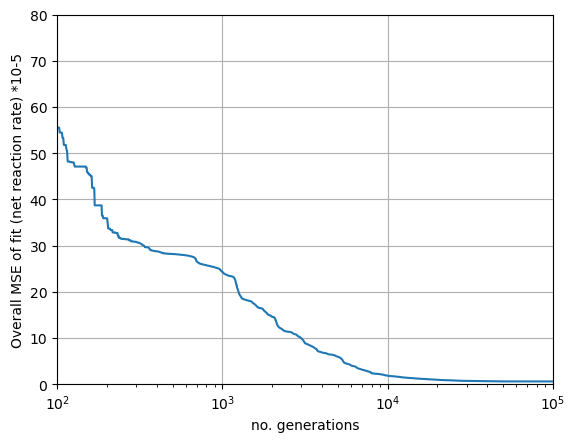

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900767403221891
-8.40102743608998
-7.601284495445233
-8.800561502780681
-8.301399391204777
-7.107132526293735
-8.09841312781694
-10.445784076602425
-7.706540023028916
-6.805842767010583
-7.306596938374823
-8.005402208922785
-7.9088656707144995
-6.803347921736369
-7.403310987835246
-7.4062536767190625
-7.900165069114623
-9.098885634593225
-8.388012475699007
-6.5016619766095545
-7.301684483468732
-6.7086611481103064
-7.508710227133411
-11.999690005324572
-7.304268829576005
-7.804350354432542
-1.3010299991263077


In [37]:
res.X

array([ -7.9007674 ,  -8.40102744,  -7.6012845 ,  -8.8005615 ,
        -8.30139939,  -7.10713253,  -8.09841313, -10.44578408,
        -7.70654002,  -6.80584277,  -7.30659694,  -8.00540221,
        -7.90886567,  -6.80334792,  -7.40331099,  -7.40625368,
        -7.90016507,  -9.09888563,  -8.38801248,  -6.50166198,
        -7.30168448,  -6.70866115,  -7.50871023, -11.99969001,
        -7.30426883,  -7.80435035,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900767403221891
-8.4: -8.40102743608998
-7.6: -7.601284495445233
-8.8: -8.800561502780681
-8.3: -8.301399391204777
-7.1: -7.107132526293735
-8.1: -8.09841312781694
-10.9: -10.445784076602425
-7.7: -7.706540023028916
-6.8: -6.805842767010583
-7.3: -7.306596938374823
-8.0: -8.005402208922785
-7.9: -7.9088656707144995
-6.8: -6.803347921736369
-7.4: -7.403310987835246
-7.4: -7.4062536767190625
-7.9: -7.900165069114623
-9.1: -9.098885634593225
-8.4: -8.388012475699007
-6.5: -6.5016619766095545
-7.3: -7.301684483468732
-6.7: -6.7086611481103064
-7.5: -7.508710227133411
-11.8: -11.999690005324572
-7.3: -7.304268829576005
-7.8: -7.804350354432542
R-value: 0.9965114031092762
R2: 0.9930349765268184
